In [1]:
import sys

sys.path.append("../")

In [2]:
import torch
import pandas as pd
import numpy as np
import wandb
import igraph as ig
from sklearn.metrics import average_precision_score


import matplotlib.pyplot as plt

from full_pipeline_main import generate_dataset
from models import SDCI
from utils import create_intervention_dataset, subset_interventions

In [3]:
seed = 0
n, d = 100, 20
n_edges_per_d = 5
frac_interventions = 1.0

def scale_fn(depth, plateau_depth = 17, slope = 7):
    return (max(1, plateau_depth - depth) / plateau_depth) * slope

X_df, B_true, wandb_config_dict = generate_dataset(
    n, d, seed, frac_interventions, n_edges_per_d=n_edges_per_d#, scale=scale_fn
)
X_obs = X_df[X_df["perturbation_label"] == "obs"].loc[:, np.arange(d)].to_numpy()
X_sub_df = subset_interventions(
    X_df, d, maintain_dataset_size=True
)

Text(0.5, 0, 'Topological rank')

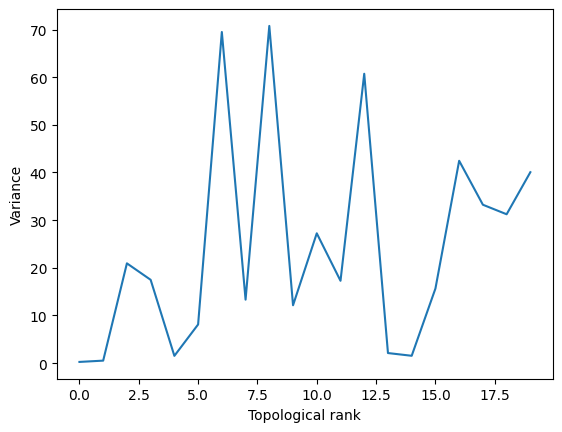

In [4]:
G = ig.Graph.Adjacency(B_true.tolist())
ordered_vertices = G.topological_sorting()
plt.plot(X_obs.var(axis=0)[ordered_vertices])
plt.ylabel("Variance")
plt.xlabel("Topological rank")

Text(0, 0.5, 'Variance(downstream_gene) - Variance(upstream_gene)')

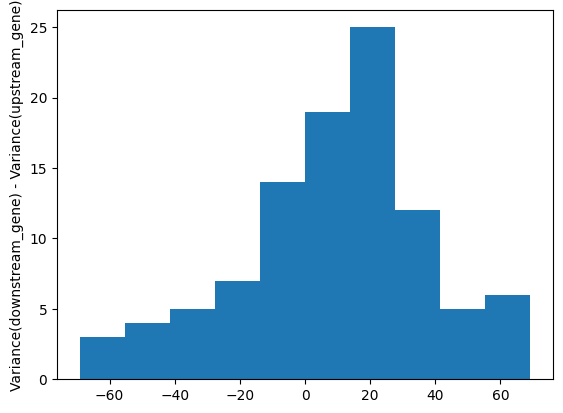

In [5]:
variances = X_obs.var(axis=0)
var_diffs = []
for i, j in zip(*np.where(B_true)):
    var_diffs.append(variances[j] - variances[i])
plt.hist(var_diffs)
plt.ylabel("Variance(downstream_gene) - Variance(upstream_gene)")

In [6]:
def run_sdci(): 
    wandb.init()
    mv_flavor = wandb.config.mv_flavor
    s1_alpha = wandb.config.s1_alpha
    s2_alpha = wandb.config.s2_alpha
    s1_beta = wandb.config.s1_beta
    s2_beta = wandb.config.s2_beta
    max_gamma = wandb.config.max_gamma
    
    dataset = create_intervention_dataset(X_sub_df, regime_format=True)
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [0.9, 0.1])

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"Using {device}")
    model = SDCI(model_variance_flavor=mv_flavor)
    model.train(
        train_dataset,
        B_true=B_true,
        device=device,
        log_wandb=True,
        verbose=False,
        stage1_kwargs={"n_epochs": 1000, "alpha": s1_alpha, "beta": s1_beta},
        stage2_kwargs={"n_epochs": 1000, "alpha": s2_alpha, "beta": s2_beta, "max_gamma": max_gamma}
    )
    val_rec_loss = model._model.reconstruction_loss(val_dataset[:][0].to(device), interventions=val_dataset[:][1].to(device)).cpu().detach().item()

    y_test = B_true.astype(bool).reshape(-1)
    y_score = model.get_adjacency_matrix(threshold = False).reshape(-1)
    auprc = average_precision_score(y_test, y_score, pos_label=True)

    wandb.log(dict(val_rec_loss=val_rec_loss, auprc=auprc))
    wandb.finish()

In [7]:
sweep_configuration = {
    "method" : "bayes",
    "name": "sdci_new_sim_sweep",
    "metric": {
        "goal": "minimize",
        "name": "val_rec_loss",
    },
    "parameters": {
        "s1_alpha": {"max": 1e-1, "min": 1e-5, "distribution": "log_uniform_values"},
        "s2_alpha": {"max": 1e-1, "min": 1e-5, "distribution": "log_uniform_values"},
        "s1_beta": {"max": 1e-1, "min": 1e-5, "distribution": "log_uniform_values"},
        "s2_beta": {"max": 1e-1, "min": 1e-5, "distribution": "log_uniform_values"},
        "max_gamma": {"max": 1000, "min": 100, "distribution": "log_uniform_values"},
        "mv_flavor": {"values": ["nn"]},
    },
    "early_terminate": {
        "type": "hyperband",
        "min_iter": 11,
    }
}

In [8]:
wandb.login()

sweep_id = wandb.sweep(sweep=sweep_configuration, project="SDCI_new_sim_sweep_w_val_loss")
wandb.agent(sweep_id, function=run_sdci)

wandb: Currently logged in as: justinhong (azizi-causal-perturb). Use `wandb login --relogin` to force relogin


Create sweep with ID: gwhjogrv
Sweep URL: https://wandb.ai/azizi-causal-perturb/SDCI_new_sim_sweep_w_val_loss/sweeps/gwhjogrv


wandb: Agent Starting Run: hf3vobec with config:
wandb: 	max_gamma: 106.63790178852976
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 6.0412150707866085e-05
wandb: 	s1_beta: 0.04424932350049995
wandb: 	s2_alpha: 3.801931391236876e-05
wandb: 	s2_beta: 0.00011734687040451905


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=631.10, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=75.27, score=120, shd=120.0, gamma=0.00
Epoch 200: loss=57.66, score=121, shd=121.0, gamma=0.00
Epoch 300: loss=51.65, score=130, shd=130.0, gamma=0.00
Epoch 400: loss=48.54, score=131, shd=131.0, gamma=0.00
Epoch 500: loss=47.53, score=125, shd=125.0, gamma=0.00
Epoch 600: loss=46.82, score=121, shd=121.0, gamma=0.00
Epoch 700: loss=46.50, score=126, shd=126.0, gamma=0.00
Epoch 800: loss=46.43, score=128, shd=128.0, gamma=0.00
Epoch 900: loss=46.38, score=131, shd=131.0, gamma=0.00
Recall of mask: 0.8
Fraction of possible edges in mask: 0.6425
Epoch 0: loss=531.22, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=36.54, score=106, shd=106.0, gamma=10.67
Epoch 200: loss=31.72, score=103, shd=103.0, gamma=10.67
Epoch 300: loss=30.03, score=99, shd=99.0, gamma=10.67
Epoch 400: loss=28.96, score=92, shd=92.0, gamma=10.67
Epoch 500: loss=28.95, score=88, shd=88.0, gamma=10.67
Epoch 600: loss=28.77, score=88, shd=88.0, g

wandb: Agent Starting Run: b1k6wznt with config:
wandb: 	max_gamma: 644.1903584695152
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.00011556338612478805
wandb: 	s1_beta: 0.01097661992978541
wandb: 	s2_alpha: 0.011953516225215215
wandb: 	s2_beta: 0.003352112369526873


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=634.04, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=67.72, score=133, shd=133.0, gamma=0.00
Epoch 200: loss=45.79, score=141, shd=141.0, gamma=0.00
Epoch 300: loss=36.84, score=152, shd=152.0, gamma=0.00
Epoch 400: loss=32.87, score=153, shd=153.0, gamma=0.00
Epoch 500: loss=30.80, score=174, shd=174.0, gamma=0.00
Epoch 600: loss=29.04, score=197, shd=197.0, gamma=0.00
Epoch 700: loss=28.18, score=209, shd=209.0, gamma=0.00
Epoch 800: loss=27.49, score=216, shd=216.0, gamma=0.00
Epoch 900: loss=27.35, score=218, shd=218.0, gamma=0.00
Recall of mask: 0.99
Fraction of possible edges in mask: 0.9075
Epoch 0: loss=496.12, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=44.92, score=102, shd=102.0, gamma=64.48
Epoch 200: loss=42.85, score=101, shd=101.0, gamma=64.48
Epoch 300: loss=42.17, score=100, shd=100.0, gamma=64.48
Epoch 400: loss=41.90, score=100, shd=100.0, gamma=64.48
Epoch 500: loss=41.87, score=100, shd=100.0, gamma=64.48
Epoch 600: loss=41.49, score=100, shd

wandb: Agent Starting Run: 488613zx with config:
wandb: 	max_gamma: 228.5911342353695
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 4.299607927079815e-05
wandb: 	s1_beta: 0.0003030508493729784
wandb: 	s2_alpha: 0.06767061833913286
wandb: 	s2_beta: 6.889017275386107e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=660.11, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=67.78, score=132, shd=132.0, gamma=0.00
Epoch 200: loss=42.63, score=164, shd=164.0, gamma=0.00
Epoch 300: loss=31.66, score=171, shd=171.0, gamma=0.00
Epoch 400: loss=26.27, score=195, shd=195.0, gamma=0.00
Epoch 500: loss=22.04, score=213, shd=213.0, gamma=0.00
Epoch 600: loss=18.73, score=221, shd=221.0, gamma=0.00
Epoch 700: loss=16.72, score=234, shd=234.0, gamma=0.00
Epoch 800: loss=15.47, score=242, shd=242.0, gamma=0.00
Epoch 900: loss=14.59, score=243, shd=243.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9225
Epoch 0: loss=534.35, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=40.80, score=99, shd=99.0, gamma=22.88
Epoch 200: loss=37.20, score=97, shd=97.0, gamma=22.88
Epoch 300: loss=35.68, score=97, shd=97.0, gamma=22.88
Epoch 400: loss=34.78, score=97, shd=97.0, gamma=22.88
Epoch 500: loss=33.93, score=97, shd=97.0, gamma=22.88
Epoch 600: loss=33.26, score=97, shd=97.0, gamma

wandb: Agent Starting Run: aydpy8tp with config:
wandb: 	max_gamma: 893.8095773778125
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.004076771805095767
wandb: 	s1_beta: 3.425314921040513e-05
wandb: 	s2_alpha: 1.39214412885958e-05
wandb: 	s2_beta: 0.00018522313791365967


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=656.47, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=70.43, score=130, shd=130.0, gamma=0.00
Epoch 200: loss=43.96, score=138, shd=138.0, gamma=0.00
Epoch 300: loss=31.15, score=145, shd=145.0, gamma=0.00
Epoch 400: loss=25.08, score=143, shd=143.0, gamma=0.00
Epoch 500: loss=21.60, score=152, shd=152.0, gamma=0.00
Epoch 600: loss=19.12, score=154, shd=154.0, gamma=0.00
Epoch 700: loss=17.68, score=163, shd=163.0, gamma=0.00
Epoch 800: loss=16.84, score=158, shd=158.0, gamma=0.00
Epoch 900: loss=16.36, score=157, shd=157.0, gamma=0.00
Recall of mask: 0.99
Fraction of possible edges in mask: 0.8075
Epoch 0: loss=586.32, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=43.29, score=99, shd=99.0, gamma=89.47
Epoch 200: loss=38.26, score=100, shd=100.0, gamma=89.47
Epoch 300: loss=36.93, score=100, shd=100.0, gamma=89.47
Epoch 400: loss=35.98, score=100, shd=100.0, gamma=89.47
Epoch 500: loss=35.20, score=100, shd=100.0, gamma=89.47
Epoch 600: loss=34.70, score=100, shd=1

wandb: Agent Starting Run: f5xkytus with config:
wandb: 	max_gamma: 289.56828686991014
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0002366686777862081
wandb: 	s1_beta: 0.0007142265179589535
wandb: 	s2_alpha: 0.0208565930385343
wandb: 	s2_beta: 2.181698196907434e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=660.10, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=68.96, score=136, shd=136.0, gamma=0.00
Epoch 200: loss=43.13, score=153, shd=153.0, gamma=0.00
Epoch 300: loss=33.55, score=174, shd=174.0, gamma=0.00
Epoch 400: loss=26.59, score=194, shd=194.0, gamma=0.00
Epoch 500: loss=22.52, score=209, shd=209.0, gamma=0.00
Epoch 600: loss=19.55, score=229, shd=229.0, gamma=0.00
Epoch 700: loss=17.59, score=232, shd=232.0, gamma=0.00
Epoch 800: loss=16.52, score=234, shd=234.0, gamma=0.00
Epoch 900: loss=15.99, score=233, shd=233.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.935
Epoch 0: loss=500.25, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=39.21, score=102, shd=102.0, gamma=28.99
Epoch 200: loss=35.21, score=98, shd=98.0, gamma=28.99
Epoch 300: loss=34.18, score=100, shd=100.0, gamma=28.99
Epoch 400: loss=33.33, score=99, shd=99.0, gamma=28.99
Epoch 500: loss=31.97, score=99, shd=99.0, gamma=28.99
Epoch 600: loss=32.10, score=102, shd=102.0, 

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 7r0fx3zf with config:
wandb: 	max_gamma: 129.15415050446842
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 5.868881337233773e-05
wandb: 	s1_beta: 0.010566879002432606
wandb: 	s2_alpha: 0.0009287470096150212
wandb: 	s2_beta: 5.271066287030165e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=666.98, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=66.06, score=126, shd=126.0, gamma=0.00
Epoch 200: loss=44.81, score=144, shd=144.0, gamma=0.00
Epoch 300: loss=37.07, score=146, shd=146.0, gamma=0.00
Epoch 400: loss=33.19, score=156, shd=156.0, gamma=0.00
Epoch 500: loss=30.96, score=179, shd=179.0, gamma=0.00
Epoch 600: loss=29.37, score=193, shd=193.0, gamma=0.00
Epoch 700: loss=28.28, score=204, shd=204.0, gamma=0.00
Epoch 800: loss=27.53, score=212, shd=212.0, gamma=0.00
Epoch 900: loss=27.16, score=216, shd=216.0, gamma=0.00
Recall of mask: 0.99
Fraction of possible edges in mask: 0.91
Epoch 0: loss=506.87, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.36, score=101, shd=101.0, gamma=12.93
Epoch 200: loss=31.41, score=103, shd=103.0, gamma=12.93
Epoch 300: loss=30.18, score=100, shd=100.0, gamma=12.93
Epoch 400: loss=30.04, score=94, shd=94.0, gamma=12.93
Epoch 500: loss=28.52, score=90, shd=90.0, gamma=12.93
Epoch 600: loss=28.09, score=88, shd=88.0, 

wandb: Agent Starting Run: zgfq1iju with config:
wandb: 	max_gamma: 163.59657005598154
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0005638217867604231
wandb: 	s1_beta: 0.005575795265947911
wandb: 	s2_alpha: 0.006464805057448428
wandb: 	s2_beta: 1.238365348917228e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=631.23, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=65.23, score=132, shd=132.0, gamma=0.00
Epoch 200: loss=40.78, score=140, shd=140.0, gamma=0.00
Epoch 300: loss=31.89, score=155, shd=155.0, gamma=0.00
Epoch 400: loss=28.18, score=163, shd=163.0, gamma=0.00
Epoch 500: loss=25.89, score=193, shd=193.0, gamma=0.00
Epoch 600: loss=24.51, score=209, shd=209.0, gamma=0.00
Epoch 700: loss=23.65, score=216, shd=216.0, gamma=0.00
Epoch 800: loss=22.89, score=221, shd=221.0, gamma=0.00
Epoch 900: loss=22.44, score=225, shd=225.0, gamma=0.00
Recall of mask: 0.99
Fraction of possible edges in mask: 0.92
Epoch 0: loss=610.29, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=37.09, score=102, shd=102.0, gamma=16.38
Epoch 200: loss=32.98, score=104, shd=104.0, gamma=16.38
Epoch 300: loss=32.90, score=103, shd=103.0, gamma=16.38
Epoch 400: loss=30.47, score=101, shd=101.0, gamma=16.38
Epoch 500: loss=29.82, score=100, shd=100.0, gamma=16.38
Epoch 600: loss=29.64, score=96, shd=96

wandb: Agent Starting Run: vjbx1fbk with config:
wandb: 	max_gamma: 139.54210913851827
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 1.2990586042349202e-05
wandb: 	s1_beta: 0.004675241646986963
wandb: 	s2_alpha: 0.0002264618814327051
wandb: 	s2_beta: 4.4208311959926025e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=668.20, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=69.08, score=141, shd=141.0, gamma=0.00
Epoch 200: loss=44.65, score=158, shd=158.0, gamma=0.00
Epoch 300: loss=34.85, score=172, shd=172.0, gamma=0.00
Epoch 400: loss=28.97, score=193, shd=193.0, gamma=0.00
Epoch 500: loss=26.15, score=212, shd=212.0, gamma=0.00
Epoch 600: loss=24.17, score=222, shd=222.0, gamma=0.00
Epoch 700: loss=22.77, score=227, shd=227.0, gamma=0.00
Epoch 800: loss=22.02, score=231, shd=231.0, gamma=0.00
Epoch 900: loss=21.54, score=236, shd=236.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9325
Epoch 0: loss=520.58, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=36.07, score=103, shd=103.0, gamma=13.97
Epoch 200: loss=31.71, score=101, shd=101.0, gamma=13.97
Epoch 300: loss=30.17, score=100, shd=100.0, gamma=13.97
Epoch 400: loss=29.23, score=99, shd=99.0, gamma=13.97
Epoch 500: loss=28.82, score=96, shd=96.0, gamma=13.97
Epoch 600: loss=28.60, score=93, shd=93.0,

wandb: Agent Starting Run: imp21nl3 with config:
wandb: 	max_gamma: 109.43938321663286
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 5.272188108540347e-05
wandb: 	s1_beta: 0.06702249810620385
wandb: 	s2_alpha: 0.0007261250924442302
wandb: 	s2_beta: 4.751186050440325e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=671.21, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=80.83, score=119, shd=119.0, gamma=0.00
Epoch 200: loss=63.74, score=119, shd=119.0, gamma=0.00
Epoch 300: loss=58.23, score=121, shd=121.0, gamma=0.00
Epoch 400: loss=55.88, score=120, shd=120.0, gamma=0.00
Epoch 500: loss=54.61, score=122, shd=122.0, gamma=0.00
Epoch 600: loss=54.19, score=125, shd=125.0, gamma=0.00
Epoch 700: loss=54.06, score=125, shd=125.0, gamma=0.00
Epoch 800: loss=53.99, score=124, shd=124.0, gamma=0.00
Epoch 900: loss=53.97, score=124, shd=124.0, gamma=0.00
Recall of mask: 0.68
Fraction of possible edges in mask: 0.515
Epoch 0: loss=547.85, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.15, score=109, shd=109.0, gamma=10.95
Epoch 200: loss=31.36, score=103, shd=103.0, gamma=10.95
Epoch 300: loss=29.81, score=99, shd=99.0, gamma=10.95
Epoch 400: loss=29.12, score=96, shd=96.0, gamma=10.95
Epoch 500: loss=28.52, score=94, shd=94.0, gamma=10.95
Epoch 600: loss=27.86, score=91, shd=91.0, g

wandb: Agent Starting Run: mo4zx0rs with config:
wandb: 	max_gamma: 101.08323645667735
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 3.97856717534724e-05
wandb: 	s1_beta: 0.00667886192429153
wandb: 	s2_alpha: 0.0007946105299791117
wandb: 	s2_beta: 0.0001303503562588155


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=702.17, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=70.43, score=138, shd=138.0, gamma=0.00
Epoch 200: loss=44.04, score=152, shd=152.0, gamma=0.00
Epoch 300: loss=34.82, score=169, shd=169.0, gamma=0.00
Epoch 400: loss=30.49, score=182, shd=182.0, gamma=0.00
Epoch 500: loss=27.87, score=194, shd=194.0, gamma=0.00
Epoch 600: loss=26.01, score=219, shd=219.0, gamma=0.00
Epoch 700: loss=24.87, score=223, shd=223.0, gamma=0.00
Epoch 800: loss=24.19, score=225, shd=225.0, gamma=0.00
Epoch 900: loss=23.53, score=232, shd=232.0, gamma=0.00
Recall of mask: 0.99
Fraction of possible edges in mask: 0.9175
Epoch 0: loss=590.30, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=36.17, score=102, shd=102.0, gamma=10.12
Epoch 200: loss=32.01, score=102, shd=102.0, gamma=10.12
Epoch 300: loss=29.73, score=98, shd=98.0, gamma=10.12
Epoch 400: loss=28.60, score=92, shd=92.0, gamma=10.12
Epoch 500: loss=28.83, score=88, shd=88.0, gamma=10.12
Epoch 600: loss=27.58, score=89, shd=89.0, 

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 3oxxaau8 with config:
wandb: 	max_gamma: 105.03334734636243
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 2.801384907482274e-05
wandb: 	s1_beta: 0.001131971601475789
wandb: 	s2_alpha: 0.002021634030547749
wandb: 	s2_beta: 0.0009613711184233872


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=658.30, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=65.95, score=147, shd=147.0, gamma=0.00
Epoch 200: loss=41.38, score=167, shd=167.0, gamma=0.00
Epoch 300: loss=31.83, score=184, shd=184.0, gamma=0.00
Epoch 400: loss=26.23, score=206, shd=206.0, gamma=0.00
Epoch 500: loss=22.72, score=214, shd=214.0, gamma=0.00
Epoch 600: loss=20.03, score=222, shd=222.0, gamma=0.00
Epoch 700: loss=18.38, score=230, shd=230.0, gamma=0.00
Epoch 800: loss=17.32, score=239, shd=239.0, gamma=0.00
Epoch 900: loss=16.65, score=242, shd=242.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9175
Epoch 0: loss=522.46, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.87, score=102, shd=102.0, gamma=10.51
Epoch 200: loss=32.55, score=98, shd=98.0, gamma=10.51
Epoch 300: loss=31.47, score=96, shd=96.0, gamma=10.51
Epoch 400: loss=30.64, score=91, shd=91.0, gamma=10.51
Epoch 500: loss=30.32, score=89, shd=89.0, gamma=10.51
Epoch 600: loss=30.11, score=88, shd=88.0, gam

wandb: Agent Starting Run: kt6he98n with config:
wandb: 	max_gamma: 100.40273660308648
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 2.428724209138897e-05
wandb: 	s1_beta: 0.0001322441594930996
wandb: 	s2_alpha: 0.0002451241245543009
wandb: 	s2_beta: 0.0002033126762918083


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=710.11, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=65.89, score=143, shd=143.0, gamma=0.00
Epoch 200: loss=41.30, score=173, shd=173.0, gamma=0.00
Epoch 300: loss=32.28, score=188, shd=188.0, gamma=0.00
Epoch 400: loss=26.31, score=201, shd=201.0, gamma=0.00
Epoch 500: loss=22.55, score=211, shd=211.0, gamma=0.00
Epoch 600: loss=19.73, score=230, shd=230.0, gamma=0.00
Epoch 700: loss=17.06, score=226, shd=226.0, gamma=0.00
Epoch 800: loss=15.70, score=238, shd=238.0, gamma=0.00
Epoch 900: loss=14.81, score=245, shd=245.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9325
Epoch 0: loss=455.42, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=37.04, score=101, shd=101.0, gamma=10.05
Epoch 200: loss=31.60, score=99, shd=99.0, gamma=10.05
Epoch 300: loss=30.21, score=93, shd=93.0, gamma=10.05
Epoch 400: loss=28.72, score=87, shd=87.0, gamma=10.05
Epoch 500: loss=28.22, score=86, shd=86.0, gamma=10.05
Epoch 600: loss=28.05, score=87, shd=87.0, gam

Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=726.74, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=68.14, score=154, shd=154.0, gamma=0.00
Epoch 200: loss=41.50, score=174, shd=174.0, gamma=0.00
Epoch 300: loss=31.54, score=191, shd=191.0, gamma=0.00
Epoch 400: loss=26.48, score=190, shd=190.0, gamma=0.00
Epoch 500: loss=22.69, score=207, shd=207.0, gamma=0.00
Epoch 600: loss=19.65, score=216, shd=216.0, gamma=0.00
Epoch 700: loss=17.12, score=233, shd=233.0, gamma=0.00
Epoch 800: loss=15.51, score=239, shd=239.0, gamma=0.00
Epoch 900: loss=14.75, score=238, shd=238.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.92
Epoch 0: loss=512.28, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.85, score=104, shd=104.0, gamma=11.52
Epoch 200: loss=31.42, score=101, shd=101.0, gamma=11.52
Epoch 300: loss=29.82, score=94, shd=94.0, gamma=11.52
Epoch 400: loss=28.62, score=90, shd=90.0, gamma=11.52
Epoch 500: loss=28.67, score=90, shd=90.0, gamma=11.52
Epoch 600: loss=27.85, score=89, shd=89.0, gam

wandb: Agent Starting Run: rtbfhol5 with config:
wandb: 	max_gamma: 116.01322606013264
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 7.19303632923031e-05
wandb: 	s1_beta: 1.8267952678741443e-05
wandb: 	s2_alpha: 0.00017334610320076036
wandb: 	s2_beta: 1.574657739146961e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=642.69, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=69.20, score=133, shd=133.0, gamma=0.00
Epoch 200: loss=43.35, score=161, shd=161.0, gamma=0.00
Epoch 300: loss=32.46, score=186, shd=186.0, gamma=0.00
Epoch 400: loss=26.50, score=202, shd=202.0, gamma=0.00
Epoch 500: loss=22.31, score=212, shd=212.0, gamma=0.00
Epoch 600: loss=18.73, score=218, shd=218.0, gamma=0.00
Epoch 700: loss=16.72, score=233, shd=233.0, gamma=0.00
Epoch 800: loss=15.51, score=236, shd=236.0, gamma=0.00
Epoch 900: loss=14.76, score=237, shd=237.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9275
Epoch 0: loss=562.99, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.23, score=99, shd=99.0, gamma=11.61
Epoch 200: loss=31.21, score=100, shd=100.0, gamma=11.61
Epoch 300: loss=29.33, score=95, shd=95.0, gamma=11.61
Epoch 400: loss=28.78, score=92, shd=92.0, gamma=11.61
Epoch 500: loss=28.23, score=90, shd=90.0, gamma=11.61
Epoch 600: loss=27.57, score=92, shd=92.0, gam

wandb: Agent Starting Run: 1mavra52 with config:
wandb: 	max_gamma: 105.09811310131948
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.00017053270244302902
wandb: 	s1_beta: 1.478511150220886e-05
wandb: 	s2_alpha: 0.03996858245662024
wandb: 	s2_beta: 2.694535116425689e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=695.51, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=70.85, score=139, shd=139.0, gamma=0.00
Epoch 200: loss=40.64, score=163, shd=163.0, gamma=0.00
Epoch 300: loss=30.62, score=174, shd=174.0, gamma=0.00
Epoch 400: loss=24.59, score=199, shd=199.0, gamma=0.00
Epoch 500: loss=20.65, score=208, shd=208.0, gamma=0.00
Epoch 600: loss=17.84, score=225, shd=225.0, gamma=0.00
Epoch 700: loss=16.13, score=242, shd=242.0, gamma=0.00
Epoch 800: loss=14.94, score=244, shd=244.0, gamma=0.00
Epoch 900: loss=14.16, score=248, shd=248.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9275
Epoch 0: loss=508.26, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=37.98, score=100, shd=100.0, gamma=10.52
Epoch 200: loss=33.74, score=100, shd=100.0, gamma=10.52
Epoch 300: loss=32.24, score=102, shd=102.0, gamma=10.52
Epoch 400: loss=32.27, score=99, shd=99.0, gamma=10.52
Epoch 500: loss=30.66, score=96, shd=96.0, gamma=10.52
Epoch 600: loss=30.09, score=96, shd=96.0,

wandb: Agent Starting Run: byxxlb92 with config:
wandb: 	max_gamma: 105.93620313498894
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 1.7036376824238064e-05
wandb: 	s1_beta: 8.20042777592713e-05
wandb: 	s2_alpha: 4.792821910823926e-05
wandb: 	s2_beta: 1.2501790322261376e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=673.55, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=69.71, score=140, shd=140.0, gamma=0.00
Epoch 200: loss=44.62, score=167, shd=167.0, gamma=0.00
Epoch 300: loss=31.77, score=188, shd=188.0, gamma=0.00
Epoch 400: loss=25.33, score=201, shd=201.0, gamma=0.00
Epoch 500: loss=21.64, score=224, shd=224.0, gamma=0.00
Epoch 600: loss=18.69, score=234, shd=234.0, gamma=0.00
Epoch 700: loss=16.75, score=241, shd=241.0, gamma=0.00
Epoch 800: loss=15.60, score=247, shd=247.0, gamma=0.00
Epoch 900: loss=14.79, score=257, shd=257.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9325
Epoch 0: loss=524.53, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.13, score=102, shd=102.0, gamma=10.60
Epoch 200: loss=30.59, score=100, shd=100.0, gamma=10.60
Epoch 300: loss=29.18, score=96, shd=96.0, gamma=10.60
Epoch 400: loss=28.65, score=90, shd=90.0, gamma=10.60
Epoch 500: loss=27.75, score=89, shd=89.0, gamma=10.60
Epoch 600: loss=27.59, score=89, shd=89.0, g

wandb: Agent Starting Run: qd5pc0pq with config:
wandb: 	max_gamma: 102.59182310621831
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.00015368937835215767
wandb: 	s1_beta: 0.0001402044918410719
wandb: 	s2_alpha: 0.000949863746639887
wandb: 	s2_beta: 2.9992207048202737e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=650.01, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=61.59, score=140, shd=140.0, gamma=0.00
Epoch 200: loss=39.72, score=171, shd=171.0, gamma=0.00
Epoch 300: loss=30.19, score=193, shd=193.0, gamma=0.00
Epoch 400: loss=24.73, score=204, shd=204.0, gamma=0.00
Epoch 500: loss=21.08, score=224, shd=224.0, gamma=0.00
Epoch 600: loss=18.19, score=227, shd=227.0, gamma=0.00
Epoch 700: loss=16.47, score=234, shd=234.0, gamma=0.00
Epoch 800: loss=15.26, score=241, shd=241.0, gamma=0.00
Epoch 900: loss=14.44, score=241, shd=241.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9175
Epoch 0: loss=483.00, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.92, score=103, shd=103.0, gamma=10.27
Epoch 200: loss=30.58, score=99, shd=99.0, gamma=10.27
Epoch 300: loss=29.68, score=94, shd=94.0, gamma=10.27
Epoch 400: loss=28.57, score=92, shd=92.0, gamma=10.27
Epoch 500: loss=27.76, score=89, shd=89.0, gamma=10.27
Epoch 600: loss=27.15, score=90, shd=90.0, gam

wandb: Agent Starting Run: a4sdgzrs with config:
wandb: 	max_gamma: 114.14759612441937
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.00030601596784013554
wandb: 	s1_beta: 1.7503495834605577e-05
wandb: 	s2_alpha: 0.00031746137517816897
wandb: 	s2_beta: 5.640206025731144e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=667.32, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=65.45, score=145, shd=145.0, gamma=0.00
Epoch 200: loss=41.28, score=163, shd=163.0, gamma=0.00
Epoch 300: loss=31.90, score=189, shd=189.0, gamma=0.00
Epoch 400: loss=25.03, score=205, shd=205.0, gamma=0.00
Epoch 500: loss=20.67, score=208, shd=208.0, gamma=0.00
Epoch 600: loss=17.69, score=225, shd=225.0, gamma=0.00
Epoch 700: loss=15.69, score=232, shd=232.0, gamma=0.00
Epoch 800: loss=14.72, score=235, shd=235.0, gamma=0.00
Epoch 900: loss=14.24, score=239, shd=239.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.93
Epoch 0: loss=535.48, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.10, score=101, shd=101.0, gamma=11.43
Epoch 200: loss=32.96, score=101, shd=101.0, gamma=11.43
Epoch 300: loss=29.74, score=100, shd=100.0, gamma=11.43
Epoch 400: loss=29.12, score=96, shd=96.0, gamma=11.43
Epoch 500: loss=27.99, score=92, shd=92.0, gamma=11.43
Epoch 600: loss=28.13, score=91, shd=91.0, g

wandb: Agent Starting Run: jgw2rv9w with config:
wandb: 	max_gamma: 107.00698102180031
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.002753635821471137
wandb: 	s1_beta: 0.00021048185773375343
wandb: 	s2_alpha: 0.0003697674850885633
wandb: 	s2_beta: 1.897658465977125e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=631.62, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=66.55, score=131, shd=131.0, gamma=0.00
Epoch 200: loss=39.83, score=146, shd=146.0, gamma=0.00
Epoch 300: loss=28.98, score=155, shd=155.0, gamma=0.00
Epoch 400: loss=23.96, score=169, shd=169.0, gamma=0.00
Epoch 500: loss=20.78, score=174, shd=174.0, gamma=0.00
Epoch 600: loss=18.42, score=176, shd=176.0, gamma=0.00
Epoch 700: loss=17.00, score=182, shd=182.0, gamma=0.00
Epoch 800: loss=16.24, score=191, shd=191.0, gamma=0.00
Epoch 900: loss=15.71, score=197, shd=197.0, gamma=0.00
Recall of mask: 0.99
Fraction of possible edges in mask: 0.8525
Epoch 0: loss=536.40, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=37.08, score=102, shd=102.0, gamma=10.71
Epoch 200: loss=30.67, score=94, shd=94.0, gamma=10.71
Epoch 300: loss=29.14, score=88, shd=88.0, gamma=10.71
Epoch 400: loss=28.26, score=84, shd=84.0, gamma=10.71
Epoch 500: loss=27.65, score=83, shd=83.0, gamma=10.71


wandb: Agent Starting Run: 9i59qxua with config:
wandb: 	max_gamma: 119.46060637210137
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0011317233250434328
wandb: 	s1_beta: 2.0697308844359465e-05
wandb: 	s2_alpha: 3.608349081569236e-05
wandb: 	s2_beta: 1.8266791975581457e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=678.55, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=64.59, score=134, shd=134.0, gamma=0.00
Epoch 200: loss=39.23, score=153, shd=153.0, gamma=0.00
Epoch 300: loss=29.65, score=167, shd=167.0, gamma=0.00
Epoch 400: loss=23.18, score=190, shd=190.0, gamma=0.00
Epoch 500: loss=19.63, score=200, shd=200.0, gamma=0.00
Epoch 600: loss=17.35, score=212, shd=212.0, gamma=0.00
Epoch 700: loss=15.75, score=213, shd=213.0, gamma=0.00
Epoch 800: loss=14.83, score=209, shd=209.0, gamma=0.00
Epoch 900: loss=14.36, score=211, shd=211.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.915
Epoch 0: loss=512.26, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.66, score=101, shd=101.0, gamma=11.96
Epoch 200: loss=31.81, score=101, shd=101.0, gamma=11.96
Epoch 300: loss=29.78, score=97, shd=97.0, gamma=11.96
Epoch 400: loss=29.56, score=94, shd=94.0, gamma=11.96
Epoch 500: loss=28.23, score=91, shd=91.0, gamma=11.96
Epoch 600: loss=27.51, score=91, shd=91.0, ga

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: a92u52a9 with config:
wandb: 	max_gamma: 108.11501278758024
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0003137343024954256
wandb: 	s1_beta: 1.732785001950367e-05
wandb: 	s2_alpha: 0.001679310823176166
wandb: 	s2_beta: 8.134501459685213e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=666.07, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=65.55, score=143, shd=143.0, gamma=0.00
Epoch 200: loss=39.17, score=167, shd=167.0, gamma=0.00
Epoch 300: loss=29.40, score=172, shd=172.0, gamma=0.00
Epoch 400: loss=24.39, score=195, shd=195.0, gamma=0.00
Epoch 500: loss=20.54, score=218, shd=218.0, gamma=0.00
Epoch 600: loss=17.80, score=227, shd=227.0, gamma=0.00
Epoch 700: loss=16.09, score=242, shd=242.0, gamma=0.00
Epoch 800: loss=14.85, score=242, shd=242.0, gamma=0.00
Epoch 900: loss=14.23, score=245, shd=245.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.925
Epoch 0: loss=531.40, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=36.10, score=102, shd=102.0, gamma=10.82
Epoch 200: loss=31.56, score=99, shd=99.0, gamma=10.82
Epoch 300: loss=30.28, score=100, shd=100.0, gamma=10.82
Epoch 400: loss=30.08, score=93, shd=93.0, gamma=10.82
Epoch 500: loss=28.53, score=89, shd=89.0, gamma=10.82
Epoch 600: loss=27.81, score=90, shd=90.0, ga

wandb: Agent Starting Run: 5gp6arch with config:
wandb: 	max_gamma: 102.50684319711355
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0018797447475252436
wandb: 	s1_beta: 0.00013536319095804254
wandb: 	s2_alpha: 0.00327643851623256
wandb: 	s2_beta: 7.882515522969629e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=626.74, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=63.25, score=130, shd=130.0, gamma=0.00
Epoch 200: loss=39.17, score=150, shd=150.0, gamma=0.00
Epoch 300: loss=28.94, score=162, shd=162.0, gamma=0.00
Epoch 400: loss=23.72, score=173, shd=173.0, gamma=0.00
Epoch 500: loss=20.35, score=184, shd=184.0, gamma=0.00
Epoch 600: loss=17.95, score=192, shd=192.0, gamma=0.00
Epoch 700: loss=16.69, score=193, shd=193.0, gamma=0.00
Epoch 800: loss=15.86, score=197, shd=197.0, gamma=0.00
Epoch 900: loss=15.31, score=204, shd=204.0, gamma=0.00
Recall of mask: 0.99
Fraction of possible edges in mask: 0.87
Epoch 0: loss=544.07, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.92, score=102, shd=102.0, gamma=10.26
Epoch 200: loss=31.65, score=95, shd=95.0, gamma=10.26
Epoch 300: loss=29.81, score=91, shd=91.0, gamma=10.26
Epoch 400: loss=28.82, score=89, shd=89.0, gamma=10.26
Epoch 500: loss=28.03, score=87, shd=87.0, gamma=10.26
Epoch 600: loss=27.51, score=86, shd=86.0, gamm

wandb: Agent Starting Run: v3ppkq8b with config:
wandb: 	max_gamma: 109.27344566806546
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.008632334275882685
wandb: 	s1_beta: 1.1680006416391944e-05
wandb: 	s2_alpha: 0.0025583730080456077
wandb: 	s2_beta: 5.437531801750535e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=755.13, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=70.80, score=120, shd=120.0, gamma=0.00
Epoch 200: loss=40.37, score=126, shd=126.0, gamma=0.00
Epoch 300: loss=28.95, score=131, shd=131.0, gamma=0.00
Epoch 400: loss=25.02, score=123, shd=123.0, gamma=0.00
Epoch 500: loss=22.56, score=127, shd=127.0, gamma=0.00
Epoch 600: loss=20.63, score=119, shd=119.0, gamma=0.00
Epoch 700: loss=19.37, score=121, shd=121.0, gamma=0.00
Epoch 800: loss=18.51, score=125, shd=125.0, gamma=0.00
Epoch 900: loss=17.85, score=122, shd=122.0, gamma=0.00
Recall of mask: 0.97
Fraction of possible edges in mask: 0.7
Epoch 0: loss=565.18, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=36.55, score=95, shd=95.0, gamma=10.94
Epoch 200: loss=31.49, score=91, shd=91.0, gamma=10.94
Epoch 300: loss=30.25, score=86, shd=86.0, gamma=10.94
Epoch 400: loss=29.37, score=86, shd=86.0, gamma=10.94
Epoch 500: loss=28.25, score=83, shd=83.0, gamma=10.94
Epoch 600: loss=27.72, score=79, shd=79.0, gamma=1

wandb: Agent Starting Run: c607ltfz with config:
wandb: 	max_gamma: 115.19070818417104
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0002603746482867439
wandb: 	s1_beta: 2.0066323443191373e-05
wandb: 	s2_alpha: 0.0008548417193478719
wandb: 	s2_beta: 1.9162381622111584e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=669.22, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=67.09, score=142, shd=142.0, gamma=0.00
Epoch 200: loss=43.50, score=164, shd=164.0, gamma=0.00
Epoch 300: loss=31.19, score=187, shd=187.0, gamma=0.00
Epoch 400: loss=24.61, score=194, shd=194.0, gamma=0.00
Epoch 500: loss=20.70, score=215, shd=215.0, gamma=0.00
Epoch 600: loss=17.74, score=225, shd=225.0, gamma=0.00
Epoch 700: loss=15.82, score=234, shd=234.0, gamma=0.00
Epoch 800: loss=14.79, score=241, shd=241.0, gamma=0.00
Epoch 900: loss=14.18, score=242, shd=242.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9375
Epoch 0: loss=487.51, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.32, score=102, shd=102.0, gamma=11.53
Epoch 200: loss=31.23, score=100, shd=100.0, gamma=11.53
Epoch 300: loss=30.07, score=97, shd=97.0, gamma=11.53
Epoch 400: loss=28.76, score=93, shd=93.0, gamma=11.53
Epoch 500: loss=28.13, score=90, shd=90.0, gamma=11.53
Epoch 600: loss=28.43, score=91, shd=91.0, g

wandb: Agent Starting Run: f4sz4uzd with config:
wandb: 	max_gamma: 100.93499853183276
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.05166805147474501
wandb: 	s1_beta: 3.408339384481245e-05
wandb: 	s2_alpha: 0.0054385612296864935
wandb: 	s2_beta: 1.6662693658584162e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=650.86, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=68.91, score=101, shd=101.0, gamma=0.00
Epoch 200: loss=42.42, score=99, shd=99.0, gamma=0.00
Epoch 300: loss=35.44, score=99, shd=99.0, gamma=0.00
Epoch 400: loss=32.62, score=96, shd=96.0, gamma=0.00
Epoch 500: loss=30.83, score=92, shd=92.0, gamma=0.00
Epoch 600: loss=29.45, score=86, shd=86.0, gamma=0.00
Epoch 700: loss=28.08, score=82, shd=82.0, gamma=0.00
Epoch 800: loss=27.05, score=79, shd=79.0, gamma=0.00
Epoch 900: loss=26.37, score=72, shd=72.0, gamma=0.00
Recall of mask: 0.59
Fraction of possible edges in mask: 0.2525
Epoch 0: loss=601.26, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=41.15, score=77, shd=77.0, gamma=10.10
Epoch 200: loss=34.78, score=75, shd=75.0, gamma=10.10
Epoch 300: loss=32.49, score=74, shd=74.0, gamma=10.10
Epoch 400: loss=31.54, score=71, shd=71.0, gamma=10.10
Epoch 500: loss=30.81, score=70, shd=70.0, gamma=10.10
Epoch 600: loss=30.07, score=71, shd=71.0, gamma=10.10
Epoch 70

wandb: Agent Starting Run: qxljsqtg with config:
wandb: 	max_gamma: 118.27633616147874
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0001104618458884332
wandb: 	s1_beta: 1.2669386000415776e-05
wandb: 	s2_alpha: 0.00528343395234201
wandb: 	s2_beta: 1.3614562638970116e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=635.87, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=64.80, score=143, shd=143.0, gamma=0.00
Epoch 200: loss=41.25, score=169, shd=169.0, gamma=0.00
Epoch 300: loss=31.97, score=187, shd=187.0, gamma=0.00
Epoch 400: loss=25.27, score=205, shd=205.0, gamma=0.00
Epoch 500: loss=21.17, score=213, shd=213.0, gamma=0.00
Epoch 600: loss=18.21, score=222, shd=222.0, gamma=0.00
Epoch 700: loss=16.40, score=231, shd=231.0, gamma=0.00
Epoch 800: loss=15.30, score=234, shd=234.0, gamma=0.00
Epoch 900: loss=14.52, score=238, shd=238.0, gamma=0.00
Epoch 300: loss=30.53, score=99, shd=99.0, gamma=11.84
Epoch 400: loss=29.17, score=95, shd=95.0, gamma=11.84
Epoch 500: loss=28.89, score=92, shd=92.0, gamma=11.84
Epoch 600: loss=28.61, score=90, shd=90.0, gamma=11.84
Epoch 700: loss=27.87, score=90, shd=90.0, gamma=11.84
Epoch 800: loss=27.62, score=90, shd=90.0, gamma=11.84
Epoch 900: loss=27.42, score=88, shd=88.0, gamma=11.84
Finished training in 27.642682790756226 seconds.


wandb: Agent Starting Run: gct4gb2f with config:
wandb: 	max_gamma: 124.63360077843514
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0003295929773308719
wandb: 	s1_beta: 2.634021011564251e-05
wandb: 	s2_alpha: 0.00035384848489455173
wandb: 	s2_beta: 7.030561211855591e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=675.24, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=63.86, score=138, shd=138.0, gamma=0.00
Epoch 200: loss=40.66, score=166, shd=166.0, gamma=0.00
Epoch 300: loss=31.12, score=182, shd=182.0, gamma=0.00
Epoch 400: loss=23.96, score=204, shd=204.0, gamma=0.00
Epoch 500: loss=20.05, score=213, shd=213.0, gamma=0.00
Epoch 600: loss=17.56, score=217, shd=217.0, gamma=0.00
Epoch 700: loss=15.79, score=233, shd=233.0, gamma=0.00
Epoch 800: loss=14.87, score=239, shd=239.0, gamma=0.00
Epoch 900: loss=14.09, score=234, shd=234.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.925
Epoch 0: loss=543.12, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=36.47, score=111, shd=111.0, gamma=12.48
Epoch 200: loss=32.07, score=104, shd=104.0, gamma=12.48
Epoch 300: loss=30.27, score=99, shd=99.0, gamma=12.48
Epoch 400: loss=29.86, score=97, shd=97.0, gamma=12.48
Epoch 500: loss=29.78, score=92, shd=92.0, gamma=12.48
Epoch 600: loss=28.91, score=89, shd=89.0, ga

wandb: Agent Starting Run: f0tbinl7 with config:
wandb: 	max_gamma: 106.14225366609956
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0006390861281190081
wandb: 	s1_beta: 4.768670255917183e-05
wandb: 	s2_alpha: 0.00022702171114436415
wandb: 	s2_beta: 0.0005222051919025073


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=693.78, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=63.64, score=137, shd=137.0, gamma=0.00
Epoch 200: loss=39.83, score=155, shd=155.0, gamma=0.00
Epoch 300: loss=30.51, score=168, shd=168.0, gamma=0.00
Epoch 400: loss=24.63, score=195, shd=195.0, gamma=0.00
Epoch 500: loss=20.46, score=217, shd=217.0, gamma=0.00
Epoch 600: loss=17.85, score=223, shd=223.0, gamma=0.00
Epoch 700: loss=16.39, score=234, shd=234.0, gamma=0.00
Epoch 800: loss=15.54, score=237, shd=237.0, gamma=0.00
Epoch 900: loss=14.99, score=241, shd=241.0, gamma=0.00
Recall of mask: 0.99
Fraction of possible edges in mask: 0.9225
Epoch 0: loss=554.51, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.47, score=102, shd=102.0, gamma=10.62
Epoch 200: loss=31.46, score=99, shd=99.0, gamma=10.62
Epoch 300: loss=31.01, score=97, shd=97.0, gamma=10.62
Epoch 400: loss=29.85, score=93, shd=93.0, gamma=10.62
Epoch 500: loss=29.05, score=90, shd=90.0, gamma=10.62
Epoch 600: loss=29.21, score=90, shd=90.0, ga

wandb: Agent Starting Run: i1q1ffz6 with config:
wandb: 	max_gamma: 137.1952196481472
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0008013585206756951
wandb: 	s1_beta: 0.000223367047833259
wandb: 	s2_alpha: 0.001187916060914432
wandb: 	s2_beta: 3.4022604448775016e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=673.68, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=67.76, score=133, shd=133.0, gamma=0.00
Epoch 200: loss=42.41, score=144, shd=144.0, gamma=0.00
Epoch 300: loss=30.89, score=167, shd=167.0, gamma=0.00
Epoch 400: loss=24.70, score=184, shd=184.0, gamma=0.00
Epoch 500: loss=20.54, score=205, shd=205.0, gamma=0.00
Epoch 600: loss=18.27, score=210, shd=210.0, gamma=0.00
Epoch 700: loss=16.94, score=225, shd=225.0, gamma=0.00
Epoch 800: loss=16.02, score=233, shd=233.0, gamma=0.00
Epoch 900: loss=15.33, score=234, shd=234.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.925
Epoch 0: loss=516.41, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.84, score=101, shd=101.0, gamma=13.73
Epoch 200: loss=31.60, score=104, shd=104.0, gamma=13.73
Epoch 300: loss=31.08, score=103, shd=103.0, gamma=13.73
Epoch 400: loss=29.72, score=100, shd=100.0, gamma=13.73
Epoch 500: loss=29.29, score=95, shd=95.0, gamma=13.73
Epoch 600: loss=28.63, score=94, shd=94.0

wandb: Agent Starting Run: 7gbahmn3 with config:
wandb: 	max_gamma: 109.33462184843576
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.00019191037125366065
wandb: 	s1_beta: 0.0004435582920202579
wandb: 	s2_alpha: 0.0009194974889305392
wandb: 	s2_beta: 5.097290878420691e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=647.84, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=71.67, score=147, shd=147.0, gamma=0.00
Epoch 200: loss=44.72, score=165, shd=165.0, gamma=0.00
Epoch 300: loss=30.59, score=186, shd=186.0, gamma=0.00
Epoch 400: loss=24.09, score=202, shd=202.0, gamma=0.00
Epoch 500: loss=20.34, score=213, shd=213.0, gamma=0.00
Epoch 600: loss=18.11, score=229, shd=229.0, gamma=0.00
Epoch 700: loss=16.74, score=236, shd=236.0, gamma=0.00
Epoch 800: loss=15.69, score=238, shd=238.0, gamma=0.00
Epoch 900: loss=15.10, score=238, shd=238.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9225
Epoch 0: loss=494.43, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.35, score=105, shd=105.0, gamma=10.94
Epoch 200: loss=31.02, score=98, shd=98.0, gamma=10.94
Epoch 300: loss=30.09, score=93, shd=93.0, gamma=10.94
Epoch 400: loss=28.62, score=90, shd=90.0, gamma=10.94
Epoch 500: loss=28.08, score=89, shd=89.0, gamma=10.94
Epoch 600: loss=28.07, score=89, shd=89.0, gam

wandb: Agent Starting Run: pu5197lp with config:
wandb: 	max_gamma: 119.863116986455
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.000980211963405574
wandb: 	s1_beta: 5.667004970706661e-05
wandb: 	s2_alpha: 0.00015191446980027963
wandb: 	s2_beta: 1.3403075602072092e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=673.84, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=66.76, score=133, shd=133.0, gamma=0.00
Epoch 200: loss=40.81, score=148, shd=148.0, gamma=0.00
Epoch 300: loss=29.98, score=163, shd=163.0, gamma=0.00
Epoch 400: loss=23.72, score=194, shd=194.0, gamma=0.00
Epoch 500: loss=20.08, score=204, shd=204.0, gamma=0.00
Epoch 600: loss=17.96, score=212, shd=212.0, gamma=0.00
Epoch 700: loss=16.47, score=223, shd=223.0, gamma=0.00
Epoch 800: loss=15.41, score=233, shd=233.0, gamma=0.00
Epoch 900: loss=14.81, score=233, shd=233.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.915
Epoch 0: loss=582.61, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=36.27, score=99, shd=99.0, gamma=12.00
Epoch 200: loss=31.05, score=98, shd=98.0, gamma=12.00
Epoch 300: loss=29.86, score=96, shd=96.0, gamma=12.00
Epoch 400: loss=28.94, score=90, shd=90.0, gamma=12.00
Epoch 500: loss=27.92, score=90, shd=90.0, gamma=12.00
Epoch 600: loss=27.86, score=89, shd=89.0, gamma=

wandb: Agent Starting Run: ffhub1yk with config:
wandb: 	max_gamma: 141.29135787693298
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0005895626314401287
wandb: 	s1_beta: 5.798051866269478e-05
wandb: 	s2_alpha: 0.000407699955442006
wandb: 	s2_beta: 3.207548407064702e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=616.37, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=68.69, score=143, shd=143.0, gamma=0.00
Epoch 200: loss=42.42, score=169, shd=169.0, gamma=0.00
Epoch 300: loss=29.48, score=182, shd=182.0, gamma=0.00
Epoch 400: loss=23.45, score=201, shd=201.0, gamma=0.00
Epoch 500: loss=19.86, score=215, shd=215.0, gamma=0.00
Epoch 600: loss=17.48, score=229, shd=229.0, gamma=0.00
Epoch 700: loss=15.98, score=232, shd=232.0, gamma=0.00
Epoch 800: loss=15.07, score=236, shd=236.0, gamma=0.00
Epoch 900: loss=14.42, score=232, shd=232.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.915
Epoch 0: loss=540.67, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.52, score=103, shd=103.0, gamma=14.14
Epoch 200: loss=31.28, score=103, shd=103.0, gamma=14.14
Epoch 300: loss=30.92, score=100, shd=100.0, gamma=14.14
Epoch 400: loss=29.73, score=99, shd=99.0, gamma=14.14
Epoch 500: loss=28.59, score=96, shd=96.0, gamma=14.14
Epoch 600: loss=28.16, score=95, shd=95.0, 

wandb: Agent Starting Run: xdckjkwq with config:
wandb: 	max_gamma: 100.78977648679054
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 7.031225110469303e-05
wandb: 	s1_beta: 0.016852380037994937
wandb: 	s2_alpha: 0.002311470670891348
wandb: 	s2_beta: 0.0002104790498934705


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=674.49, score=100, shd=100.0, gamma=0.00
Epoch 400: loss=36.75, score=145, shd=145.0, gamma=0.00
Epoch 500: loss=34.94, score=161, shd=161.0, gamma=0.00
Epoch 600: loss=33.79, score=176, shd=176.0, gamma=0.00
Epoch 700: loss=32.84, score=185, shd=185.0, gamma=0.00
Epoch 800: loss=32.35, score=192, shd=192.0, gamma=0.00
Epoch 900: loss=32.03, score=193, shd=193.0, gamma=0.00
Recall of mask: 0.99
Fraction of possible edges in mask: 0.89
Epoch 0: loss=557.45, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.60, score=103, shd=103.0, gamma=10.09
Epoch 200: loss=31.18, score=100, shd=100.0, gamma=10.09
Epoch 300: loss=30.52, score=96, shd=96.0, gamma=10.09
Epoch 400: loss=28.97, score=88, shd=88.0, gamma=10.09
Epoch 500: loss=28.27, score=88, shd=88.0, gamma=10.09
Epoch 600: loss=28.10, score=87, shd=87.0, gamma=10.09
Epoch 700: loss=28.07, score=89, shd=89.0, gamma=10.09
Epoch 800: loss=27.88, score=87, shd=87.0, gamma=10.09
Epoch 900: loss=27.64, score=87, shd=87.0, gamma

wandb: Agent Starting Run: q7tx7day with config:
wandb: 	max_gamma: 102.31759574898588
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0008111683242403867
wandb: 	s1_beta: 5.266347825780613e-05
wandb: 	s2_alpha: 0.0015532440588512774
wandb: 	s2_beta: 4.078857315106541e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=640.12, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=67.77, score=132, shd=132.0, gamma=0.00
Epoch 200: loss=42.76, score=168, shd=168.0, gamma=0.00
Epoch 300: loss=31.22, score=180, shd=180.0, gamma=0.00
Epoch 400: loss=24.34, score=205, shd=205.0, gamma=0.00
Epoch 500: loss=20.43, score=210, shd=210.0, gamma=0.00
Epoch 600: loss=17.94, score=219, shd=219.0, gamma=0.00
Epoch 700: loss=16.40, score=225, shd=225.0, gamma=0.00
Epoch 800: loss=15.30, score=232, shd=232.0, gamma=0.00
Epoch 900: loss=14.64, score=229, shd=229.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.915
Epoch 0: loss=540.68, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=36.44, score=101, shd=101.0, gamma=10.24
Epoch 200: loss=31.00, score=97, shd=97.0, gamma=10.24
Epoch 300: loss=29.70, score=93, shd=93.0, gamma=10.24
Epoch 400: loss=29.00, score=91, shd=91.0, gamma=10.24
Epoch 500: loss=29.15, score=87, shd=87.0, gamma=10.24
Epoch 600: loss=27.71, score=86, shd=86.0, gamm

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 1wpkuklk with config:
wandb: 	max_gamma: 128.6612828199646
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.002866193622214741
wandb: 	s1_beta: 0.0002853560810605306
wandb: 	s2_alpha: 0.001923799733225756
wandb: 	s2_beta: 0.004293068048317416


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=674.32, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=68.73, score=128, shd=128.0, gamma=0.00
Epoch 200: loss=39.85, score=145, shd=145.0, gamma=0.00
Epoch 300: loss=28.79, score=162, shd=162.0, gamma=0.00
Epoch 400: loss=23.17, score=167, shd=167.0, gamma=0.00
Epoch 500: loss=20.56, score=172, shd=172.0, gamma=0.00
Epoch 600: loss=18.65, score=183, shd=183.0, gamma=0.00
Epoch 700: loss=17.41, score=184, shd=184.0, gamma=0.00
Epoch 800: loss=16.61, score=187, shd=187.0, gamma=0.00
Epoch 900: loss=16.18, score=193, shd=193.0, gamma=0.00
Recall of mask: 0.99
Fraction of possible edges in mask: 0.855
Epoch 0: loss=588.03, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=40.26, score=100, shd=100.0, gamma=12.88
Epoch 200: loss=37.35, score=99, shd=99.0, gamma=12.88
Epoch 300: loss=36.44, score=96, shd=96.0, gamma=12.88
Epoch 400: loss=36.04, score=92, shd=92.0, gamma=12.88
Epoch 500: loss=36.05, score=92, shd=92.0, gamma=12.88
Epoch 600: loss=35.79, score=92, shd=92.0, gam

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ots02716 with config:
wandb: 	max_gamma: 114.71088718784654
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.00146788992958882
wandb: 	s1_beta: 0.0003634787624699515
wandb: 	s2_alpha: 0.0021997635627228353
wandb: 	s2_beta: 7.33736485802986e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=638.02, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=68.70, score=141, shd=141.0, gamma=0.00
Epoch 200: loss=41.10, score=153, shd=153.0, gamma=0.00
Epoch 300: loss=30.62, score=175, shd=175.0, gamma=0.00
Epoch 400: loss=24.94, score=183, shd=183.0, gamma=0.00
Epoch 500: loss=21.32, score=199, shd=199.0, gamma=0.00
Epoch 600: loss=18.57, score=213, shd=213.0, gamma=0.00
Epoch 700: loss=17.25, score=225, shd=225.0, gamma=0.00
Epoch 800: loss=16.25, score=221, shd=221.0, gamma=0.00
Epoch 900: loss=15.87, score=216, shd=216.0, gamma=0.00
Recall of mask: 0.99
Fraction of possible edges in mask: 0.905
Epoch 0: loss=501.54, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.41, score=102, shd=102.0, gamma=11.48
Epoch 200: loss=31.69, score=101, shd=101.0, gamma=11.48
Epoch 300: loss=29.92, score=100, shd=100.0, gamma=11.48
Epoch 400: loss=29.27, score=93, shd=93.0, gamma=11.48
Epoch 500: loss=28.47, score=91, shd=91.0, gamma=11.48
Epoch 600: loss=27.45, score=89, shd=89.0,

wandb: Agent Starting Run: ox5c0633 with config:
wandb: 	max_gamma: 120.07641148590128
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 1.540139456780883e-05
wandb: 	s1_beta: 0.005826194238056542
wandb: 	s2_alpha: 0.0014044226585556417
wandb: 	s2_beta: 0.0002215378565523553


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=682.49, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=76.35, score=135, shd=135.0, gamma=0.00
Epoch 200: loss=47.28, score=148, shd=148.0, gamma=0.00
Epoch 300: loss=37.25, score=170, shd=170.0, gamma=0.00
Epoch 400: loss=31.53, score=175, shd=175.0, gamma=0.00
Epoch 500: loss=28.33, score=203, shd=203.0, gamma=0.00
Epoch 600: loss=25.94, score=214, shd=214.0, gamma=0.00
Epoch 700: loss=24.52, score=230, shd=230.0, gamma=0.00
Epoch 800: loss=23.83, score=230, shd=230.0, gamma=0.00
Epoch 900: loss=23.25, score=233, shd=233.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9225
Epoch 0: loss=473.33, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.21, score=100, shd=100.0, gamma=12.02
Epoch 200: loss=31.83, score=100, shd=100.0, gamma=12.02
Epoch 300: loss=30.70, score=100, shd=100.0, gamma=12.02
Epoch 400: loss=29.36, score=93, shd=93.0, gamma=12.02
Epoch 500: loss=29.01, score=92, shd=92.0, gamma=12.02
Epoch 600: loss=28.21, score=91, shd=91.0,

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ymfl53z2 with config:
wandb: 	max_gamma: 117.5733862290472
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0002337667197705976
wandb: 	s1_beta: 1.0006299741954e-05
wandb: 	s2_alpha: 2.5315741037906995e-05
wandb: 	s2_beta: 0.0002371006873325212


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=692.90, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=69.84, score=139, shd=139.0, gamma=0.00
Epoch 200: loss=43.24, score=166, shd=166.0, gamma=0.00
Epoch 300: loss=31.61, score=178, shd=178.0, gamma=0.00
Epoch 400: loss=25.98, score=204, shd=204.0, gamma=0.00
Epoch 500: loss=21.35, score=224, shd=224.0, gamma=0.00
Epoch 600: loss=18.70, score=228, shd=228.0, gamma=0.00
Epoch 700: loss=16.91, score=228, shd=228.0, gamma=0.00
Epoch 800: loss=15.16, score=232, shd=232.0, gamma=0.00
Epoch 900: loss=14.32, score=241, shd=241.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9175
Epoch 0: loss=590.72, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.97, score=101, shd=101.0, gamma=11.77
Epoch 200: loss=32.29, score=101, shd=101.0, gamma=11.77
Epoch 300: loss=29.94, score=93, shd=93.0, gamma=11.77
Epoch 400: loss=29.43, score=88, shd=88.0, gamma=11.77
Epoch 500: loss=28.48, score=89, shd=89.0, gamma=11.77
Epoch 600: loss=28.66, score=90, shd=90.0, g

wandb: Agent Starting Run: 5pfy1k0x with config:
wandb: 	max_gamma: 108.0518417350672
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 6.0241015897410566e-05
wandb: 	s1_beta: 0.0005557231369582405
wandb: 	s2_alpha: 0.00030120468827145465
wandb: 	s2_beta: 0.00030599649042129743


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=655.80, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=66.82, score=150, shd=150.0, gamma=0.00
Epoch 200: loss=43.34, score=161, shd=161.0, gamma=0.00
Epoch 300: loss=32.98, score=183, shd=183.0, gamma=0.00
Epoch 400: loss=26.56, score=203, shd=203.0, gamma=0.00
Epoch 500: loss=22.79, score=207, shd=207.0, gamma=0.00
Epoch 600: loss=19.83, score=210, shd=210.0, gamma=0.00
Epoch 700: loss=17.76, score=227, shd=227.0, gamma=0.00
Epoch 800: loss=16.67, score=233, shd=233.0, gamma=0.00
Epoch 300: loss=30.85, score=99, shd=99.0, gamma=10.82
Epoch 400: loss=29.56, score=91, shd=91.0, gamma=10.82
Epoch 500: loss=29.27, score=88, shd=88.0, gamma=10.82
Epoch 600: loss=28.02, score=85, shd=85.0, gamma=10.82
Epoch 700: loss=29.22, score=92, shd=92.0, gamma=10.82
Epoch 800: loss=28.28, score=85, shd=85.0, gamma=10.82
Epoch 900: loss=28.16, score=86, shd=86.0, gamma=10.82
Finished training in 28.571799755096436 seconds.


wandb: Agent Starting Run: rs78fd15 with config:
wandb: 	max_gamma: 100.84849324523228
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 3.270394840932118e-05
wandb: 	s1_beta: 7.766246665968641e-05
wandb: 	s2_alpha: 4.120810294517796e-05
wandb: 	s2_beta: 1.7675332648306327e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=744.75, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=72.75, score=145, shd=145.0, gamma=0.00
Epoch 200: loss=44.41, score=157, shd=157.0, gamma=0.00
Epoch 300: loss=33.22, score=175, shd=175.0, gamma=0.00
Epoch 400: loss=25.81, score=191, shd=191.0, gamma=0.00
Epoch 500: loss=21.68, score=200, shd=200.0, gamma=0.00
Epoch 600: loss=18.56, score=215, shd=215.0, gamma=0.00
Epoch 700: loss=16.43, score=225, shd=225.0, gamma=0.00
Epoch 800: loss=15.28, score=233, shd=233.0, gamma=0.00
Epoch 900: loss=14.36, score=239, shd=239.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9225
Epoch 0: loss=532.29, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=34.45, score=102, shd=102.0, gamma=10.09
Epoch 200: loss=30.75, score=97, shd=97.0, gamma=10.09
Epoch 300: loss=29.41, score=93, shd=93.0, gamma=10.09
Epoch 400: loss=28.11, score=89, shd=89.0, gamma=10.09
Epoch 500: loss=27.44, score=88, shd=88.0, gamma=10.09
Epoch 600: loss=27.27, score=88, shd=88.0, gam

wandb: Agent Starting Run: 96midoir with config:
wandb: 	max_gamma: 117.92719578757251
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 4.664559882990426e-05
wandb: 	s1_beta: 3.734315360897345e-05
wandb: 	s2_alpha: 0.00029672885051770564
wandb: 	s2_beta: 3.497745721317909e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=701.64, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=73.96, score=139, shd=139.0, gamma=0.00
Epoch 200: loss=44.56, score=162, shd=162.0, gamma=0.00
Epoch 300: loss=32.37, score=176, shd=176.0, gamma=0.00
Epoch 400: loss=25.61, score=195, shd=195.0, gamma=0.00
Epoch 500: loss=21.59, score=219, shd=219.0, gamma=0.00
Epoch 600: loss=19.16, score=224, shd=224.0, gamma=0.00
Epoch 700: loss=17.09, score=233, shd=233.0, gamma=0.00
Epoch 800: loss=15.63, score=249, shd=249.0, gamma=0.00
Epoch 900: loss=14.59, score=248, shd=248.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9325
Epoch 0: loss=540.90, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=36.05, score=102, shd=102.0, gamma=11.80
Epoch 200: loss=32.45, score=104, shd=104.0, gamma=11.80
Epoch 300: loss=29.84, score=98, shd=98.0, gamma=11.80
Epoch 400: loss=28.86, score=99, shd=99.0, gamma=11.80
Epoch 500: loss=28.16, score=96, shd=96.0, gamma=11.80
Epoch 600: loss=28.04, score=92, shd=92.0, g

wandb: Agent Starting Run: sy2wtcc8 with config:
wandb: 	max_gamma: 100.37273132722478
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.00010436572171329764
wandb: 	s1_beta: 0.00026047826592400045
wandb: 	s2_alpha: 0.00014718986770290892
wandb: 	s2_beta: 1.2628911920375482e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=685.94, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=67.09, score=139, shd=139.0, gamma=0.00
Epoch 200: loss=42.26, score=169, shd=169.0, gamma=0.00
Epoch 300: loss=30.73, score=192, shd=192.0, gamma=0.00
Epoch 400: loss=25.23, score=211, shd=211.0, gamma=0.00
Epoch 500: loss=21.58, score=213, shd=213.0, gamma=0.00
Epoch 600: loss=18.73, score=225, shd=225.0, gamma=0.00
Epoch 700: loss=16.71, score=227, shd=227.0, gamma=0.00
Epoch 800: loss=15.48, score=229, shd=229.0, gamma=0.00
Epoch 900: loss=14.86, score=234, shd=234.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.915
Epoch 0: loss=618.99, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=36.27, score=97, shd=97.0, gamma=10.05
Epoch 200: loss=30.85, score=94, shd=94.0, gamma=10.05
Epoch 300: loss=29.34, score=91, shd=91.0, gamma=10.05
Epoch 400: loss=29.65, score=90, shd=90.0, gamma=10.05
Epoch 500: loss=27.67, score=87, shd=87.0, gamma=10.05
Epoch 600: loss=27.38, score=89, shd=89.0, gamma=

wandb: Agent Starting Run: kl7vriqr with config:
wandb: 	max_gamma: 108.25229212286744
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0001499195347687953
wandb: 	s1_beta: 0.00019663169974282868
wandb: 	s2_alpha: 0.00020427182336552467
wandb: 	s2_beta: 0.00010963401481954347


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=724.79, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=72.11, score=144, shd=144.0, gamma=0.00
Epoch 200: loss=45.70, score=160, shd=160.0, gamma=0.00
Epoch 300: loss=33.07, score=192, shd=192.0, gamma=0.00
Epoch 400: loss=26.41, score=198, shd=198.0, gamma=0.00
Epoch 500: loss=22.18, score=204, shd=204.0, gamma=0.00
Epoch 600: loss=18.85, score=215, shd=215.0, gamma=0.00
Epoch 700: loss=17.15, score=227, shd=227.0, gamma=0.00
Epoch 800: loss=15.93, score=230, shd=230.0, gamma=0.00
Epoch 900: loss=14.80, score=233, shd=233.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9175
Epoch 0: loss=530.86, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.72, score=98, shd=98.0, gamma=10.84
Epoch 200: loss=31.40, score=96, shd=96.0, gamma=10.84
Epoch 300: loss=29.62, score=96, shd=96.0, gamma=10.84
Epoch 400: loss=28.99, score=91, shd=91.0, gamma=10.84
Epoch 500: loss=28.85, score=89, shd=89.0, gamma=10.84
Epoch 600: loss=27.82, score=89, shd=89.0, gamma

wandb: Agent Starting Run: w3v8yqbh with config:
wandb: 	max_gamma: 110.25792436400909
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.00025103501403635854
wandb: 	s1_beta: 6.736120290122031e-05
wandb: 	s2_alpha: 0.00032187922602423867
wandb: 	s2_beta: 2.7952993755700792e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=708.85, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=70.50, score=145, shd=145.0, gamma=0.00
Epoch 200: loss=43.55, score=157, shd=157.0, gamma=0.00
Epoch 300: loss=32.40, score=189, shd=189.0, gamma=0.00
Epoch 400: loss=25.71, score=191, shd=191.0, gamma=0.00
Epoch 500: loss=21.28, score=202, shd=202.0, gamma=0.00
Epoch 600: loss=18.53, score=219, shd=219.0, gamma=0.00
Epoch 700: loss=16.48, score=224, shd=224.0, gamma=0.00
Epoch 800: loss=15.09, score=234, shd=234.0, gamma=0.00
Epoch 900: loss=14.27, score=238, shd=238.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9125
Epoch 0: loss=495.12, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=34.73, score=101, shd=101.0, gamma=11.04
Epoch 200: loss=30.93, score=98, shd=98.0, gamma=11.04
Epoch 300: loss=29.21, score=93, shd=93.0, gamma=11.04
Epoch 400: loss=28.11, score=90, shd=90.0, gamma=11.04
Epoch 500: loss=28.00, score=90, shd=90.0, gamma=11.04
Epoch 600: loss=27.29, score=89, shd=89.0, gam

wandb: Agent Starting Run: 61pdn4qz with config:
wandb: 	max_gamma: 100.12476911062842
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 1.2584043893429717e-05
wandb: 	s1_beta: 2.7603860258552757e-05
wandb: 	s2_alpha: 1.764636424047554e-05
wandb: 	s2_beta: 0.0002222431858887767


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=636.51, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=67.25, score=133, shd=133.0, gamma=0.00
Epoch 200: loss=42.57, score=162, shd=162.0, gamma=0.00
Epoch 300: loss=31.24, score=194, shd=194.0, gamma=0.00
Epoch 400: loss=25.50, score=212, shd=212.0, gamma=0.00
Epoch 500: loss=21.69, score=223, shd=223.0, gamma=0.00
Epoch 600: loss=18.76, score=229, shd=229.0, gamma=0.00
Epoch 700: loss=16.72, score=235, shd=235.0, gamma=0.00
Epoch 800: loss=15.58, score=238, shd=238.0, gamma=0.00
Epoch 900: loss=14.48, score=237, shd=237.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.925
Epoch 0: loss=497.93, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=34.36, score=100, shd=100.0, gamma=10.02
Epoch 200: loss=31.03, score=98, shd=98.0, gamma=10.02
Epoch 300: loss=29.60, score=93, shd=93.0, gamma=10.02
Epoch 400: loss=28.78, score=89, shd=89.0, gamma=10.02
Epoch 500: loss=28.02, score=85, shd=85.0, gamma=10.02
Epoch 600: loss=27.64, score=84, shd=84.0, gamm

wandb: Agent Starting Run: 3vwlafpp with config:
wandb: 	max_gamma: 115.21548578408988
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0005713729058193513
wandb: 	s1_beta: 0.00023083775628844424
wandb: 	s2_alpha: 1.630349724979256e-05
wandb: 	s2_beta: 1.8474319236835862e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=724.39, score=100, shd=100.0, gamma=0.00
Epoch 400: loss=24.55, score=181, shd=181.0, gamma=0.00
Epoch 500: loss=21.00, score=197, shd=197.0, gamma=0.00
Epoch 600: loss=18.13, score=218, shd=218.0, gamma=0.00
Epoch 700: loss=16.39, score=230, shd=230.0, gamma=0.00
Epoch 800: loss=15.42, score=233, shd=233.0, gamma=0.00
Epoch 900: loss=14.88, score=238, shd=238.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9225
Epoch 0: loss=528.27, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.81, score=103, shd=103.0, gamma=11.53
Epoch 200: loss=31.21, score=101, shd=101.0, gamma=11.53
Epoch 300: loss=29.91, score=100, shd=100.0, gamma=11.53
Epoch 400: loss=28.14, score=93, shd=93.0, gamma=11.53
Epoch 500: loss=28.17, score=89, shd=89.0, gamma=11.53
Epoch 600: loss=27.68, score=88, shd=88.0, gamma=11.53
Epoch 700: loss=28.69, score=89, shd=89.0, gamma=11.53
Epoch 800: loss=27.62, score=89, shd=89.0, gamma=11.53
Epoch 900: loss=27.60, score=89, shd=89.0, ga

wandb: Agent Starting Run: zn2vgmc6 with config:
wandb: 	max_gamma: 129.1537659532529
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.00011817919108169346
wandb: 	s1_beta: 0.00036642846094781385
wandb: 	s2_alpha: 5.031596898274456e-05
wandb: 	s2_beta: 2.5727267167842543e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=618.45, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=65.16, score=148, shd=148.0, gamma=0.00
Epoch 200: loss=43.21, score=161, shd=161.0, gamma=0.00
Epoch 300: loss=32.16, score=186, shd=186.0, gamma=0.00
Epoch 400: loss=25.78, score=201, shd=201.0, gamma=0.00
Epoch 500: loss=22.22, score=223, shd=223.0, gamma=0.00
Epoch 600: loss=19.11, score=228, shd=228.0, gamma=0.00
Epoch 700: loss=16.90, score=233, shd=233.0, gamma=0.00
Epoch 800: loss=16.04, score=238, shd=238.0, gamma=0.00
Epoch 900: loss=15.23, score=239, shd=239.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9275
Epoch 0: loss=472.03, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=34.97, score=104, shd=104.0, gamma=12.93
Epoch 200: loss=31.91, score=102, shd=102.0, gamma=12.93
Epoch 300: loss=29.94, score=97, shd=97.0, gamma=12.93
Epoch 400: loss=29.24, score=92, shd=92.0, gamma=12.93
Epoch 500: loss=28.58, score=90, shd=90.0, gamma=12.93
Epoch 600: loss=28.31, score=90, shd=90.0, g

wandb: Agent Starting Run: mwbsz1hg with config:
wandb: 	max_gamma: 104.7905824300985
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0004479559803018634
wandb: 	s1_beta: 4.943470071015469e-05
wandb: 	s2_alpha: 1.0923629384634987e-05
wandb: 	s2_beta: 1.920969459021851e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=662.83, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=64.35, score=144, shd=144.0, gamma=0.00
Epoch 200: loss=37.61, score=167, shd=167.0, gamma=0.00
Epoch 300: loss=27.77, score=196, shd=196.0, gamma=0.00
Epoch 400: loss=22.90, score=211, shd=211.0, gamma=0.00
Epoch 500: loss=19.73, score=219, shd=219.0, gamma=0.00
Epoch 600: loss=17.30, score=217, shd=217.0, gamma=0.00
Epoch 700: loss=15.96, score=224, shd=224.0, gamma=0.00
Epoch 800: loss=15.08, score=226, shd=226.0, gamma=0.00
Epoch 900: loss=14.53, score=230, shd=230.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.925
Epoch 0: loss=506.66, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=34.18, score=102, shd=102.0, gamma=10.49
Epoch 200: loss=30.76, score=100, shd=100.0, gamma=10.49
Epoch 300: loss=29.20, score=94, shd=94.0, gamma=10.49
Epoch 400: loss=28.08, score=86, shd=86.0, gamma=10.49
Epoch 500: loss=27.90, score=86, shd=86.0, gamma=10.49
Epoch 600: loss=27.16, score=87, shd=87.0, ga

wandb: Agent Starting Run: bjhxtsaf with config:
wandb: 	max_gamma: 111.17678820343176
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.00024413751302375475
wandb: 	s1_beta: 0.00030931511290721694
wandb: 	s2_alpha: 1.7538901071623597e-05
wandb: 	s2_beta: 2.4945182927796028e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=640.22, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=61.13, score=146, shd=146.0, gamma=0.00
Epoch 200: loss=37.84, score=172, shd=172.0, gamma=0.00
Epoch 300: loss=29.41, score=182, shd=182.0, gamma=0.00
Epoch 400: loss=23.69, score=202, shd=202.0, gamma=0.00
Epoch 500: loss=20.10, score=212, shd=212.0, gamma=0.00
Epoch 600: loss=17.60, score=225, shd=225.0, gamma=0.00
Epoch 700: loss=16.15, score=230, shd=230.0, gamma=0.00
Epoch 800: loss=15.24, score=234, shd=234.0, gamma=0.00
Epoch 900: loss=14.82, score=234, shd=234.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9275
Epoch 0: loss=571.49, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.13, score=100, shd=100.0, gamma=11.13
Epoch 200: loss=31.12, score=99, shd=99.0, gamma=11.13
Epoch 300: loss=29.56, score=95, shd=95.0, gamma=11.13
Epoch 400: loss=28.89, score=91, shd=91.0, gamma=11.13
Epoch 500: loss=27.98, score=91, shd=91.0, gamma=11.13
Epoch 600: loss=27.74, score=89, shd=89.0, gam

wandb: Agent Starting Run: v2n0ayxf with config:
wandb: 	max_gamma: 100.58736716848072
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.00036936064153046065
wandb: 	s1_beta: 0.00022222668898980307
wandb: 	s2_alpha: 2.6131195516522312e-05
wandb: 	s2_beta: 2.4002184906402403e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=715.89, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=67.94, score=142, shd=142.0, gamma=0.00
Epoch 200: loss=41.00, score=158, shd=158.0, gamma=0.00
Epoch 300: loss=32.32, score=170, shd=170.0, gamma=0.00
Epoch 400: loss=26.09, score=190, shd=190.0, gamma=0.00
Epoch 500: loss=21.24, score=210, shd=210.0, gamma=0.00
Epoch 600: loss=18.22, score=222, shd=222.0, gamma=0.00
Epoch 700: loss=16.31, score=231, shd=231.0, gamma=0.00
Epoch 800: loss=15.36, score=233, shd=233.0, gamma=0.00
Epoch 900: loss=14.65, score=235, shd=235.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.93
Epoch 0: loss=547.31, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=34.94, score=101, shd=101.0, gamma=10.07
Epoch 200: loss=31.37, score=98, shd=98.0, gamma=10.07
Epoch 300: loss=28.80, score=96, shd=96.0, gamma=10.07
Epoch 400: loss=28.73, score=90, shd=90.0, gamma=10.07
Epoch 500: loss=27.35, score=90, shd=90.0, gamma=10.07
Epoch 600: loss=27.62, score=90, shd=90.0, gamma

wandb: Agent Starting Run: gdlj7xv5 with config:
wandb: 	max_gamma: 100.26792987429394
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 1.8639355442338494e-05
wandb: 	s1_beta: 9.152355742339965e-05
wandb: 	s2_alpha: 0.0001016034566090723
wandb: 	s2_beta: 0.0002846370575135237


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=616.79, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=60.84, score=145, shd=145.0, gamma=0.00
Epoch 200: loss=40.35, score=174, shd=174.0, gamma=0.00
Epoch 300: loss=29.67, score=193, shd=193.0, gamma=0.00
Epoch 400: loss=24.58, score=207, shd=207.0, gamma=0.00
Epoch 500: loss=20.97, score=217, shd=217.0, gamma=0.00
Epoch 600: loss=18.46, score=231, shd=231.0, gamma=0.00
Epoch 700: loss=16.32, score=238, shd=238.0, gamma=0.00
Epoch 800: loss=15.03, score=242, shd=242.0, gamma=0.00
Epoch 900: loss=14.36, score=249, shd=249.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.94
Epoch 0: loss=520.52, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.21, score=103, shd=103.0, gamma=10.04
Epoch 200: loss=31.35, score=101, shd=101.0, gamma=10.04
Epoch 300: loss=29.72, score=97, shd=97.0, gamma=10.04
Epoch 400: loss=28.81, score=88, shd=88.0, gamma=10.04
Epoch 500: loss=28.38, score=88, shd=88.0, gamma=10.04
Epoch 600: loss=28.21, score=89, shd=89.0, gam

wandb: Agent Starting Run: i9psqxtr with config:
wandb: 	max_gamma: 101.47880103726804
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 8.732272320995748e-05
wandb: 	s1_beta: 2.863199560577853e-05
wandb: 	s2_alpha: 1.031884814287831e-05
wandb: 	s2_beta: 7.188906065592253e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=621.92, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=63.55, score=138, shd=138.0, gamma=0.00
Epoch 200: loss=42.12, score=170, shd=170.0, gamma=0.00
Epoch 300: loss=32.86, score=191, shd=191.0, gamma=0.00
Epoch 400: loss=26.98, score=194, shd=194.0, gamma=0.00
Epoch 500: loss=22.45, score=210, shd=210.0, gamma=0.00
Epoch 600: loss=19.25, score=217, shd=217.0, gamma=0.00
Epoch 700: loss=16.97, score=225, shd=225.0, gamma=0.00
Epoch 800: loss=15.58, score=237, shd=237.0, gamma=0.00
Epoch 900: loss=14.52, score=240, shd=240.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.935
Epoch 0: loss=577.48, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=36.13, score=103, shd=103.0, gamma=10.16
Epoch 200: loss=30.90, score=99, shd=99.0, gamma=10.16
Epoch 300: loss=29.13, score=92, shd=92.0, gamma=10.16
Epoch 400: loss=28.82, score=89, shd=89.0, gamma=10.16
Epoch 500: loss=27.95, score=88, shd=88.0, gamma=10.16
Epoch 600: loss=27.82, score=88, shd=88.0, gamm

wandb: Agent Starting Run: 04o45wy7 with config:
wandb: 	max_gamma: 100.97754047778436
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 8.44633635675987e-05
wandb: 	s1_beta: 0.0003693145871130683
wandb: 	s2_alpha: 0.0004845223114325506
wandb: 	s2_beta: 3.777699796046787e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=640.22, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=63.67, score=136, shd=136.0, gamma=0.00
Epoch 200: loss=40.48, score=158, shd=158.0, gamma=0.00
Epoch 300: loss=30.45, score=190, shd=190.0, gamma=0.00
Epoch 400: loss=24.60, score=201, shd=201.0, gamma=0.00
Epoch 500: loss=20.91, score=205, shd=205.0, gamma=0.00
Epoch 600: loss=18.31, score=217, shd=217.0, gamma=0.00
Epoch 700: loss=16.78, score=225, shd=225.0, gamma=0.00
Epoch 800: loss=15.73, score=230, shd=230.0, gamma=0.00
Epoch 900: loss=15.02, score=230, shd=230.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.915
Epoch 0: loss=552.12, score=100, shd=100.0, gamma=0.00
Epoch 500: loss=27.91, score=87, shd=87.0, gamma=10.11
Epoch 600: loss=27.28, score=82, shd=82.0, gamma=10.11
Epoch 700: loss=26.58, score=84, shd=84.0, gamma=10.11
Epoch 800: loss=26.56, score=84, shd=84.0, gamma=10.11
Epoch 900: loss=26.36, score=85, shd=85.0, gamma=10.11
Finished training in 28.51164150238037 seconds.


wandb: Agent Starting Run: jeo9zsvq with config:
wandb: 	max_gamma: 128.90654199790706
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.00016189004580040398
wandb: 	s1_beta: 7.455320112987023e-05
wandb: 	s2_alpha: 0.0002379255785314845
wandb: 	s2_beta: 1.5166576079712494e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=695.35, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=66.70, score=142, shd=142.0, gamma=0.00
Epoch 200: loss=41.61, score=163, shd=163.0, gamma=0.00
Epoch 300: loss=30.52, score=180, shd=180.0, gamma=0.00
Epoch 400: loss=24.11, score=184, shd=184.0, gamma=0.00
Epoch 500: loss=20.32, score=197, shd=197.0, gamma=0.00
Epoch 600: loss=17.98, score=220, shd=220.0, gamma=0.00
Epoch 700: loss=16.29, score=226, shd=226.0, gamma=0.00
Epoch 800: loss=15.09, score=239, shd=239.0, gamma=0.00
Epoch 900: loss=14.34, score=241, shd=241.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9275
Epoch 0: loss=537.59, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.53, score=100, shd=100.0, gamma=12.90
Epoch 200: loss=31.32, score=103, shd=103.0, gamma=12.90
Epoch 300: loss=29.93, score=98, shd=98.0, gamma=12.90
Epoch 400: loss=29.59, score=93, shd=93.0, gamma=12.90
Epoch 500: loss=28.41, score=91, shd=91.0, gamma=12.90
Epoch 600: loss=28.29, score=91, shd=91.0, g

wandb: Agent Starting Run: qnvs6lii with config:
wandb: 	max_gamma: 102.90370617501227
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.00011614606246898916
wandb: 	s1_beta: 0.00010804971984362176
wandb: 	s2_alpha: 4.694243850703752e-05
wandb: 	s2_beta: 0.0001683614158329043


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=755.43, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=71.16, score=141, shd=141.0, gamma=0.00
Epoch 200: loss=44.45, score=164, shd=164.0, gamma=0.00
Epoch 300: loss=32.92, score=177, shd=177.0, gamma=0.00
Epoch 400: loss=25.99, score=197, shd=197.0, gamma=0.00
Epoch 500: loss=21.41, score=211, shd=211.0, gamma=0.00
Epoch 600: loss=18.36, score=216, shd=216.0, gamma=0.00
Epoch 700: loss=16.72, score=226, shd=226.0, gamma=0.00
Epoch 800: loss=15.36, score=231, shd=231.0, gamma=0.00
Epoch 900: loss=14.57, score=235, shd=235.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.935
Epoch 0: loss=516.23, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.79, score=105, shd=105.0, gamma=10.30
Epoch 200: loss=30.52, score=102, shd=102.0, gamma=10.30
Epoch 300: loss=29.19, score=97, shd=97.0, gamma=10.30
Epoch 400: loss=28.78, score=90, shd=90.0, gamma=10.30
Epoch 500: loss=28.59, score=89, shd=89.0, gamma=10.30
Epoch 600: loss=27.87, score=87, shd=87.0, ga

wandb: Agent Starting Run: i91l5b11 with config:
wandb: 	max_gamma: 119.44040258165737
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0005775184783938126
wandb: 	s1_beta: 0.000179979602603155
wandb: 	s2_alpha: 0.0005305111205906247
wandb: 	s2_beta: 1.13825902985729e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=712.05, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=70.01, score=133, shd=133.0, gamma=0.00
Epoch 200: loss=41.89, score=162, shd=162.0, gamma=0.00
Epoch 300: loss=30.41, score=179, shd=179.0, gamma=0.00
Epoch 400: loss=24.67, score=192, shd=192.0, gamma=0.00
Epoch 500: loss=20.85, score=212, shd=212.0, gamma=0.00
Epoch 600: loss=18.23, score=228, shd=228.0, gamma=0.00
Epoch 700: loss=16.50, score=231, shd=231.0, gamma=0.00
Epoch 800: loss=15.45, score=231, shd=231.0, gamma=0.00
Epoch 900: loss=14.90, score=228, shd=228.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9075
Epoch 0: loss=549.36, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.58, score=100, shd=100.0, gamma=11.96
Epoch 200: loss=31.64, score=100, shd=100.0, gamma=11.96
Epoch 300: loss=29.88, score=96, shd=96.0, gamma=11.96
Epoch 400: loss=29.06, score=95, shd=95.0, gamma=11.96
Epoch 500: loss=27.94, score=91, shd=91.0, gamma=11.96
Epoch 600: loss=27.92, score=89, shd=89.0, g

wandb: Agent Starting Run: y2fm0fsd with config:
wandb: 	max_gamma: 106.70429022577846
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.00010176931527543604
wandb: 	s1_beta: 0.0003890880509002945
wandb: 	s2_alpha: 1.2614849589665627e-05
wandb: 	s2_beta: 3.89021616970702e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=747.24, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=71.31, score=155, shd=155.0, gamma=0.00
Epoch 200: loss=42.08, score=159, shd=159.0, gamma=0.00
Epoch 300: loss=32.14, score=181, shd=181.0, gamma=0.00
Epoch 400: loss=25.46, score=198, shd=198.0, gamma=0.00
Epoch 500: loss=21.70, score=209, shd=209.0, gamma=0.00
Epoch 600: loss=19.18, score=224, shd=224.0, gamma=0.00
Epoch 700: loss=16.93, score=223, shd=223.0, gamma=0.00
Epoch 800: loss=15.64, score=235, shd=235.0, gamma=0.00
Epoch 900: loss=15.04, score=242, shd=242.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9275
Epoch 0: loss=538.14, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=34.74, score=102, shd=102.0, gamma=10.68
Epoch 200: loss=31.38, score=100, shd=100.0, gamma=10.68
Epoch 300: loss=29.70, score=97, shd=97.0, gamma=10.68
Epoch 400: loss=29.56, score=90, shd=90.0, gamma=10.68
Epoch 500: loss=27.70, score=86, shd=86.0, gamma=10.68
Epoch 600: loss=27.66, score=85, shd=85.0, g

wandb: Agent Starting Run: tqjijvwz with config:
wandb: 	max_gamma: 104.13237578893632
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 9.756889745183963e-05
wandb: 	s1_beta: 2.8048666499306e-05
wandb: 	s2_alpha: 0.0001372346149763468
wandb: 	s2_beta: 2.8481381338931868e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=773.42, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=75.39, score=144, shd=144.0, gamma=0.00
Epoch 200: loss=44.83, score=171, shd=171.0, gamma=0.00
Epoch 300: loss=34.03, score=188, shd=188.0, gamma=0.00
Epoch 400: loss=27.61, score=201, shd=201.0, gamma=0.00
Epoch 500: loss=23.15, score=218, shd=218.0, gamma=0.00
Epoch 600: loss=19.82, score=216, shd=216.0, gamma=0.00
Epoch 700: loss=17.24, score=224, shd=224.0, gamma=0.00
Epoch 800: loss=15.48, score=234, shd=234.0, gamma=0.00
Epoch 900: loss=14.43, score=243, shd=243.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.93
Epoch 0: loss=511.96, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=34.58, score=101, shd=101.0, gamma=10.42
Epoch 200: loss=30.52, score=99, shd=99.0, gamma=10.42
Epoch 300: loss=29.83, score=95, shd=95.0, gamma=10.42
Epoch 400: loss=27.68, score=91, shd=91.0, gamma=10.42
Epoch 500: loss=27.37, score=87, shd=87.0, gamma=10.42
Epoch 600: loss=27.37, score=86, shd=86.0, gamma

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=603.40, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=62.97, score=144, shd=144.0, gamma=0.00
Epoch 200: loss=42.14, score=170, shd=170.0, gamma=0.00
Epoch 300: loss=32.47, score=191, shd=191.0, gamma=0.00
Epoch 400: loss=26.28, score=198, shd=198.0, gamma=0.00
Epoch 500: loss=21.53, score=217, shd=217.0, gamma=0.00
Epoch 600: loss=18.23, score=224, shd=224.0, gamma=0.00
Epoch 700: loss=16.52, score=229, shd=229.0, gamma=0.00
Epoch 800: loss=15.27, score=232, shd=232.0, gamma=0.00
Epoch 900: loss=14.38, score=239, shd=239.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9175
Epoch 0: loss=544.32, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=36.26, score=105, shd=105.0, gamma=12.35
Epoch 200: loss=31.58, score=103, shd=103.0, gamma=12.35
Epoch 300: loss=30.48, score=100, shd=100.0, gamma=12.35
Epoch 400: loss=29.63, score=97, shd=97.0, gamma=12.35
Epoch 500: loss=28.50, score=94, shd=94.0, gamma=12.35
Epoch 600: loss=28.45, score=91, shd=91.0,

wandb: Agent Starting Run: tvv5xbnq with config:
wandb: 	max_gamma: 100.69105564905148
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 6.029106393957741e-05
wandb: 	s1_beta: 2.7809018397018447e-05
wandb: 	s2_alpha: 2.4847797825654233e-05
wandb: 	s2_beta: 5.103235495753901e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=659.95, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=65.94, score=142, shd=142.0, gamma=0.00
Epoch 200: loss=43.84, score=180, shd=180.0, gamma=0.00
Epoch 300: loss=31.78, score=193, shd=193.0, gamma=0.00
Epoch 400: loss=24.92, score=200, shd=200.0, gamma=0.00
Epoch 500: loss=20.73, score=206, shd=206.0, gamma=0.00
Epoch 600: loss=17.96, score=219, shd=219.0, gamma=0.00
Epoch 700: loss=16.22, score=229, shd=229.0, gamma=0.00
Epoch 800: loss=15.07, score=237, shd=237.0, gamma=0.00
Epoch 900: loss=14.13, score=241, shd=241.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9275
Epoch 0: loss=569.51, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.37, score=102, shd=102.0, gamma=10.08
Epoch 200: loss=30.98, score=99, shd=99.0, gamma=10.08
Epoch 300: loss=29.53, score=96, shd=96.0, gamma=10.08
Epoch 400: loss=28.66, score=88, shd=88.0, gamma=10.08
Epoch 500: loss=27.82, score=87, shd=87.0, gamma=10.08
Epoch 600: loss=27.28, score=89, shd=89.0, gam

wandb: Agent Starting Run: huap8swt with config:
wandb: 	max_gamma: 108.68252328931904
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0006125088271187848
wandb: 	s1_beta: 0.00020814394156719912
wandb: 	s2_alpha: 1.142333156773519e-05
wandb: 	s2_beta: 0.0002460948349263145


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=678.69, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=69.84, score=126, shd=126.0, gamma=0.00
Epoch 200: loss=45.45, score=151, shd=151.0, gamma=0.00
Epoch 300: loss=31.57, score=191, shd=191.0, gamma=0.00
Epoch 400: loss=24.60, score=195, shd=195.0, gamma=0.00
Epoch 500: loss=20.72, score=205, shd=205.0, gamma=0.00
Epoch 600: loss=18.00, score=215, shd=215.0, gamma=0.00
Epoch 700: loss=16.51, score=225, shd=225.0, gamma=0.00
Epoch 800: loss=15.56, score=232, shd=232.0, gamma=0.00
Epoch 900: loss=14.93, score=239, shd=239.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.915
Epoch 0: loss=573.82, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.34, score=102, shd=102.0, gamma=10.88
Epoch 200: loss=31.18, score=97, shd=97.0, gamma=10.88
Epoch 300: loss=29.82, score=97, shd=97.0, gamma=10.88
Epoch 400: loss=28.86, score=92, shd=92.0, gamma=10.88
Epoch 500: loss=29.14, score=88, shd=88.0, gamma=10.88
Epoch 600: loss=28.48, score=87, shd=87.0, gamm

wandb: Agent Starting Run: 92iywowm with config:
wandb: 	max_gamma: 116.39486579639431
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 2.8765165455463383e-05
wandb: 	s1_beta: 0.00019283201220863136
wandb: 	s2_alpha: 3.577488539897851e-05
wandb: 	s2_beta: 7.972137506434847e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=657.55, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=67.67, score=147, shd=147.0, gamma=0.00
Epoch 200: loss=42.78, score=164, shd=164.0, gamma=0.00
Epoch 300: loss=31.12, score=182, shd=182.0, gamma=0.00
Epoch 400: loss=24.97, score=191, shd=191.0, gamma=0.00
Epoch 500: loss=21.30, score=207, shd=207.0, gamma=0.00
Epoch 600: loss=18.30, score=228, shd=228.0, gamma=0.00
Epoch 700: loss=16.32, score=235, shd=235.0, gamma=0.00
Epoch 800: loss=15.33, score=240, shd=240.0, gamma=0.00
Epoch 900: loss=14.57, score=243, shd=243.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.925
Epoch 0: loss=511.24, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.59, score=106, shd=106.0, gamma=11.65
Epoch 200: loss=32.40, score=102, shd=102.0, gamma=11.65
Epoch 300: loss=29.54, score=96, shd=96.0, gamma=11.65
Epoch 400: loss=28.95, score=90, shd=90.0, gamma=11.65
Epoch 500: loss=27.86, score=89, shd=89.0, gamma=11.65
Epoch 600: loss=28.12, score=89, shd=89.0, ga

wandb: Agent Starting Run: xq9oot8i with config:
wandb: 	max_gamma: 135.98273927954344
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 9.001895500376582e-05
wandb: 	s1_beta: 3.256961293180981e-05
wandb: 	s2_alpha: 5.324084529020183e-05
wandb: 	s2_beta: 1.1495774747094462e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=711.95, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=70.89, score=135, shd=135.0, gamma=0.00
Epoch 200: loss=44.71, score=170, shd=170.0, gamma=0.00
Epoch 300: loss=33.23, score=186, shd=186.0, gamma=0.00
Epoch 400: loss=26.30, score=194, shd=194.0, gamma=0.00
Epoch 500: loss=22.33, score=209, shd=209.0, gamma=0.00
Epoch 600: loss=18.81, score=218, shd=218.0, gamma=0.00
Epoch 700: loss=16.43, score=233, shd=233.0, gamma=0.00
Epoch 800: loss=15.12, score=239, shd=239.0, gamma=0.00
Epoch 900: loss=14.34, score=248, shd=248.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.94
Epoch 0: loss=461.15, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.03, score=105, shd=105.0, gamma=13.61
Epoch 200: loss=31.29, score=104, shd=104.0, gamma=13.61
Epoch 300: loss=30.21, score=100, shd=100.0, gamma=13.61
Epoch 400: loss=29.36, score=99, shd=99.0, gamma=13.61
Epoch 500: loss=29.05, score=97, shd=97.0, gamma=13.61
Epoch 600: loss=28.22, score=94, shd=94.0, g

wandb: Agent Starting Run: rmbfcnhi with config:
wandb: 	max_gamma: 105.72135185896646
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0006376191768521309
wandb: 	s1_beta: 0.00015948076768223244
wandb: 	s2_alpha: 0.0007937926320384351
wandb: 	s2_beta: 1.6448330295380502e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=678.80, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=67.25, score=146, shd=146.0, gamma=0.00
Epoch 200: loss=43.05, score=156, shd=156.0, gamma=0.00
Epoch 300: loss=31.96, score=169, shd=169.0, gamma=0.00
Epoch 400: loss=25.40, score=192, shd=192.0, gamma=0.00
Epoch 500: loss=21.88, score=210, shd=210.0, gamma=0.00
Epoch 600: loss=19.00, score=211, shd=211.0, gamma=0.00
Epoch 700: loss=16.86, score=223, shd=223.0, gamma=0.00
Epoch 800: loss=15.75, score=221, shd=221.0, gamma=0.00
Epoch 900: loss=15.12, score=223, shd=223.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9025
Epoch 0: loss=478.87, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.34, score=101, shd=101.0, gamma=10.58
Epoch 200: loss=31.92, score=99, shd=99.0, gamma=10.58
Epoch 300: loss=30.89, score=91, shd=91.0, gamma=10.58
Epoch 400: loss=28.55, score=90, shd=90.0, gamma=10.58
Epoch 500: loss=28.55, score=86, shd=86.0, gamma=10.58
Epoch 600: loss=27.29, score=88, shd=88.0, gam

wandb: Agent Starting Run: g1qax5fe with config:
wandb: 	max_gamma: 107.8802744709498
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 1.1828925383720568e-05
wandb: 	s1_beta: 8.813128836607443e-05
wandb: 	s2_alpha: 2.120772177823069e-05
wandb: 	s2_beta: 6.949449393686982e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=741.52, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=71.44, score=153, shd=153.0, gamma=0.00
Epoch 200: loss=44.75, score=173, shd=173.0, gamma=0.00
Epoch 300: loss=31.43, score=184, shd=184.0, gamma=0.00
Epoch 400: loss=25.32, score=195, shd=195.0, gamma=0.00
Epoch 500: loss=21.05, score=215, shd=215.0, gamma=0.00
Epoch 600: loss=18.82, score=217, shd=217.0, gamma=0.00
Epoch 700: loss=16.90, score=227, shd=227.0, gamma=0.00
Epoch 800: loss=15.54, score=237, shd=237.0, gamma=0.00
Epoch 900: loss=14.75, score=245, shd=245.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.93
Epoch 0: loss=499.22, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=36.22, score=101, shd=101.0, gamma=10.80
Epoch 200: loss=31.13, score=99, shd=99.0, gamma=10.80
Epoch 300: loss=30.02, score=98, shd=98.0, gamma=10.80
Epoch 400: loss=28.75, score=92, shd=92.0, gamma=10.80
Epoch 500: loss=28.82, score=88, shd=88.0, gamma=10.80
Epoch 600: loss=27.74, score=88, shd=88.0, gamma

wandb: Agent Starting Run: 88z3bbt1 with config:
wandb: 	max_gamma: 105.09919303056748
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.00016278450109377318
wandb: 	s1_beta: 0.00011732797748432648
wandb: 	s2_alpha: 0.00029615580916971586
wandb: 	s2_beta: 3.6117100522907543e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=643.71, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=67.09, score=141, shd=141.0, gamma=0.00
Epoch 200: loss=42.56, score=164, shd=164.0, gamma=0.00
Epoch 300: loss=30.97, score=177, shd=177.0, gamma=0.00
Epoch 700: loss=16.32, score=216, shd=216.0, gamma=0.00
Epoch 800: loss=15.20, score=222, shd=222.0, gamma=0.00
Epoch 900: loss=14.47, score=227, shd=227.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.91
Epoch 0: loss=564.31, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.17, score=103, shd=103.0, gamma=10.52
Epoch 200: loss=31.42, score=100, shd=100.0, gamma=10.52
Epoch 300: loss=29.28, score=98, shd=98.0, gamma=10.52
Epoch 400: loss=28.44, score=89, shd=89.0, gamma=10.52
Epoch 500: loss=27.87, score=87, shd=87.0, gamma=10.52
Epoch 600: loss=27.40, score=88, shd=88.0, gamma=10.52
Epoch 700: loss=27.33, score=89, shd=89.0, gamma=10.52
Epoch 800: loss=26.93, score=89, shd=89.0, gamma=10.52
Epoch 900: loss=26.15, score=90, shd=90.0, gamma=

wandb: Agent Starting Run: oy0y6gxj with config:
wandb: 	max_gamma: 103.02810344061947
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 5.466758540589155e-05
wandb: 	s1_beta: 1.4821686927765508e-05
wandb: 	s2_alpha: 0.0001437215349309931
wandb: 	s2_beta: 4.34107073302177e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=721.98, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=69.74, score=149, shd=149.0, gamma=0.00
Epoch 200: loss=44.54, score=160, shd=160.0, gamma=0.00
Epoch 300: loss=32.89, score=188, shd=188.0, gamma=0.00
Epoch 400: loss=26.63, score=211, shd=211.0, gamma=0.00
Epoch 500: loss=21.96, score=224, shd=224.0, gamma=0.00
Epoch 600: loss=19.16, score=225, shd=225.0, gamma=0.00
Epoch 700: loss=17.17, score=226, shd=226.0, gamma=0.00
Epoch 800: loss=15.52, score=232, shd=232.0, gamma=0.00
Epoch 900: loss=14.81, score=241, shd=241.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.93
Epoch 0: loss=570.66, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=37.53, score=106, shd=106.0, gamma=10.31
Epoch 200: loss=31.11, score=99, shd=99.0, gamma=10.31
Epoch 300: loss=29.81, score=96, shd=96.0, gamma=10.31
Epoch 400: loss=28.75, score=91, shd=91.0, gamma=10.31
Epoch 500: loss=28.25, score=92, shd=92.0, gamma=10.31
Epoch 600: loss=28.64, score=92, shd=92.0, gamma

wandb: Agent Starting Run: s2fqdipy with config:
wandb: 	max_gamma: 106.7315052570576
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0021021655703775985
wandb: 	s1_beta: 4.884807134495671e-05
wandb: 	s2_alpha: 2.638637379979853e-05
wandb: 	s2_beta: 1.3664249235584563e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=698.87, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=71.00, score=131, shd=131.0, gamma=0.00
Epoch 200: loss=41.86, score=146, shd=146.0, gamma=0.00
Epoch 300: loss=29.17, score=165, shd=165.0, gamma=0.00
Epoch 400: loss=23.62, score=180, shd=180.0, gamma=0.00
Epoch 500: loss=20.12, score=188, shd=188.0, gamma=0.00
Epoch 600: loss=17.88, score=191, shd=191.0, gamma=0.00
Epoch 700: loss=16.56, score=198, shd=198.0, gamma=0.00
Epoch 800: loss=15.85, score=197, shd=197.0, gamma=0.00
Epoch 900: loss=15.28, score=198, shd=198.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.8825
Epoch 0: loss=616.51, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=36.45, score=99, shd=99.0, gamma=10.68
Epoch 200: loss=30.93, score=94, shd=94.0, gamma=10.68
Epoch 300: loss=29.55, score=92, shd=92.0, gamma=10.68
Epoch 400: loss=28.58, score=89, shd=89.0, gamma=10.68
Epoch 500: loss=27.69, score=84, shd=84.0, gamma=10.68
Epoch 600: loss=27.12, score=84, shd=84.0, gamma

wandb: Agent Starting Run: 18mlbn0l with config:
wandb: 	max_gamma: 100.08655628298258
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0004672589078652299
wandb: 	s1_beta: 0.0002120215803847621
wandb: 	s2_alpha: 0.0007486068111116531
wandb: 	s2_beta: 5.0158518769006366e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=701.48, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=68.32, score=138, shd=138.0, gamma=0.00
Epoch 200: loss=44.58, score=156, shd=156.0, gamma=0.00
Epoch 300: loss=31.49, score=168, shd=168.0, gamma=0.00
Epoch 400: loss=24.79, score=195, shd=195.0, gamma=0.00
Epoch 500: loss=20.85, score=213, shd=213.0, gamma=0.00
Epoch 600: loss=18.13, score=218, shd=218.0, gamma=0.00
Epoch 700: loss=16.44, score=228, shd=228.0, gamma=0.00
Epoch 800: loss=15.50, score=232, shd=232.0, gamma=0.00
Epoch 900: loss=14.89, score=235, shd=235.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9075
Epoch 0: loss=496.21, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=34.35, score=99, shd=99.0, gamma=10.02
Epoch 200: loss=31.24, score=100, shd=100.0, gamma=10.02
Epoch 300: loss=29.13, score=93, shd=93.0, gamma=10.02
Epoch 400: loss=28.50, score=89, shd=89.0, gamma=10.02
Epoch 500: loss=27.33, score=86, shd=86.0, gamma=10.02
Epoch 600: loss=26.89, score=86, shd=86.0, gam

wandb: Agent Starting Run: 466yr4gm with config:
wandb: 	max_gamma: 104.56934819777278
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.00022755575067409737
wandb: 	s1_beta: 3.553000201511133e-05
wandb: 	s2_alpha: 0.00104829988410061
wandb: 	s2_beta: 5.159502557830024e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=648.41, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=63.84, score=142, shd=142.0, gamma=0.00
Epoch 200: loss=39.79, score=155, shd=155.0, gamma=0.00
Epoch 300: loss=30.22, score=173, shd=173.0, gamma=0.00
Epoch 400: loss=24.23, score=201, shd=201.0, gamma=0.00
Epoch 500: loss=19.94, score=207, shd=207.0, gamma=0.00
Epoch 600: loss=17.14, score=216, shd=216.0, gamma=0.00
Epoch 700: loss=15.68, score=220, shd=220.0, gamma=0.00
Epoch 800: loss=14.82, score=227, shd=227.0, gamma=0.00
Epoch 900: loss=14.06, score=226, shd=226.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9175
Epoch 0: loss=528.16, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=36.11, score=102, shd=102.0, gamma=10.47
Epoch 200: loss=30.90, score=98, shd=98.0, gamma=10.47
Epoch 300: loss=29.52, score=97, shd=97.0, gamma=10.47
Epoch 400: loss=28.14, score=90, shd=90.0, gamma=10.47
Epoch 500: loss=28.09, score=88, shd=88.0, gamma=10.47
Epoch 600: loss=27.75, score=85, shd=85.0, gam

wandb: Agent Starting Run: dvb4ffnk with config:
wandb: 	max_gamma: 128.88374202905848
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0001072313350378293
wandb: 	s1_beta: 1.0052165167036874e-05
wandb: 	s2_alpha: 3.652568443123509e-05
wandb: 	s2_beta: 2.3928945636355108e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=694.22, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=68.76, score=130, shd=130.0, gamma=0.00
Epoch 200: loss=42.86, score=160, shd=160.0, gamma=0.00
Epoch 300: loss=33.40, score=174, shd=174.0, gamma=0.00
Epoch 400: loss=26.29, score=190, shd=190.0, gamma=0.00
Epoch 500: loss=21.98, score=203, shd=203.0, gamma=0.00
Epoch 600: loss=19.32, score=216, shd=216.0, gamma=0.00
Epoch 700: loss=17.19, score=230, shd=230.0, gamma=0.00
Epoch 800: loss=15.85, score=234, shd=234.0, gamma=0.00
Epoch 900: loss=15.03, score=239, shd=239.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.915
Epoch 0: loss=542.11, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.65, score=101, shd=101.0, gamma=12.90
Epoch 200: loss=31.05, score=101, shd=101.0, gamma=12.90
Epoch 300: loss=31.77, score=109, shd=109.0, gamma=12.90
Epoch 400: loss=29.11, score=98, shd=98.0, gamma=12.90
Epoch 500: loss=28.55, score=93, shd=93.0, gamma=12.90
Epoch 600: loss=27.95, score=90, shd=90.0, 

wandb: Agent Starting Run: h2w34zh3 with config:
wandb: 	max_gamma: 116.40586417397012
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0005528015739783248
wandb: 	s1_beta: 5.280365605364473e-05
wandb: 	s2_alpha: 1.2708393767482494e-05
wandb: 	s2_beta: 1.817806478625899e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=695.84, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=67.51, score=148, shd=148.0, gamma=0.00
Epoch 200: loss=41.25, score=165, shd=165.0, gamma=0.00
Epoch 300: loss=30.26, score=186, shd=186.0, gamma=0.00
Epoch 400: loss=24.41, score=201, shd=201.0, gamma=0.00
Epoch 500: loss=20.42, score=216, shd=216.0, gamma=0.00
Epoch 600: loss=17.87, score=220, shd=220.0, gamma=0.00
Epoch 700: loss=16.17, score=227, shd=227.0, gamma=0.00
Epoch 800: loss=15.20, score=236, shd=236.0, gamma=0.00
Epoch 900: loss=14.40, score=239, shd=239.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9175
Epoch 0: loss=543.58, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=36.51, score=104, shd=104.0, gamma=11.65
Epoch 200: loss=30.95, score=102, shd=102.0, gamma=11.65
Epoch 300: loss=29.87, score=103, shd=103.0, gamma=11.65
Epoch 400: loss=29.34, score=101, shd=101.0, gamma=11.65
Epoch 500: loss=28.04, score=92, shd=92.0, gamma=11.65
Epoch 600: loss=27.93, score=89, shd=89.

wandb: Agent Starting Run: lnb2su7u with config:
wandb: 	max_gamma: 103.75198377932728
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 9.801874056461736e-05
wandb: 	s1_beta: 6.713547966159548e-05
wandb: 	s2_alpha: 0.00020077202637006428
wandb: 	s2_beta: 8.554581389004967e-05


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=668.97, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=66.71, score=143, shd=143.0, gamma=0.00
Epoch 200: loss=43.57, score=169, shd=169.0, gamma=0.00
Epoch 300: loss=32.60, score=190, shd=190.0, gamma=0.00
Epoch 400: loss=26.33, score=202, shd=202.0, gamma=0.00
Epoch 500: loss=22.05, score=218, shd=218.0, gamma=0.00
Epoch 600: loss=18.89, score=232, shd=232.0, gamma=0.00
Epoch 700: loss=16.64, score=249, shd=249.0, gamma=0.00
Epoch 800: loss=15.28, score=247, shd=247.0, gamma=0.00
Epoch 900: loss=14.52, score=251, shd=251.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9325
Epoch 0: loss=521.04, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.56, score=110, shd=110.0, gamma=10.39
Epoch 200: loss=30.92, score=99, shd=99.0, gamma=10.39
Epoch 300: loss=29.65, score=93, shd=93.0, gamma=10.39
Epoch 400: loss=28.80, score=91, shd=91.0, gamma=10.39
Epoch 500: loss=27.79, score=91, shd=91.0, gamma=10.39
Epoch 600: loss=27.50, score=90, shd=90.0, gam

wandb: Agent Starting Run: bstj5mhz with config:
wandb: 	max_gamma: 140.9478038859274
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0005208409701928485
wandb: 	s1_beta: 1.7735094633480057e-05
wandb: 	s2_alpha: 0.0002573635351141224
wandb: 	s2_beta: 8.557440533966311e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=679.46, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=66.52, score=145, shd=145.0, gamma=0.00
Epoch 200: loss=40.21, score=157, shd=157.0, gamma=0.00
Epoch 300: loss=29.22, score=183, shd=183.0, gamma=0.00
Epoch 400: loss=23.97, score=190, shd=190.0, gamma=0.00
Epoch 500: loss=20.53, score=202, shd=202.0, gamma=0.00
Epoch 600: loss=17.89, score=217, shd=217.0, gamma=0.00
Epoch 700: loss=16.12, score=227, shd=227.0, gamma=0.00
Epoch 800: loss=15.05, score=233, shd=233.0, gamma=0.00
Epoch 900: loss=14.30, score=236, shd=236.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9175
Epoch 0: loss=513.31, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=36.23, score=103, shd=103.0, gamma=14.11
Epoch 200: loss=33.09, score=106, shd=106.0, gamma=14.11
Epoch 300: loss=30.76, score=100, shd=100.0, gamma=14.11
Epoch 400: loss=29.72, score=96, shd=96.0, gamma=14.11
Epoch 500: loss=29.67, score=94, shd=94.0, gamma=14.11
Epoch 600: loss=28.33, score=93, shd=93.0,

wandb: Agent Starting Run: i15r56qw with config:
wandb: 	max_gamma: 102.198740389325
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 7.075393875069857e-05
wandb: 	s1_beta: 0.0012931095827395135
wandb: 	s2_alpha: 0.00028329365362275705
wandb: 	s2_beta: 4.163873747941779e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=686.36, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=69.12, score=148, shd=148.0, gamma=0.00
Epoch 200: loss=41.61, score=164, shd=164.0, gamma=0.00
Epoch 300: loss=33.09, score=180, shd=180.0, gamma=0.00
Epoch 400: loss=27.28, score=195, shd=195.0, gamma=0.00
Epoch 500: loss=23.45, score=205, shd=205.0, gamma=0.00
Epoch 600: loss=20.75, score=213, shd=213.0, gamma=0.00
Epoch 700: loss=18.73, score=223, shd=223.0, gamma=0.00
Epoch 800: loss=17.58, score=231, shd=231.0, gamma=0.00
Epoch 900: loss=16.94, score=236, shd=236.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9175
Epoch 0: loss=579.67, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.64, score=102, shd=102.0, gamma=10.23
Epoch 200: loss=31.30, score=97, shd=97.0, gamma=10.23
Epoch 300: loss=30.02, score=92, shd=92.0, gamma=10.23
Epoch 400: loss=28.36, score=88, shd=88.0, gamma=10.23
Epoch 500: loss=27.96, score=88, shd=88.0, gamma=10.23
Epoch 600: loss=27.41, score=89, shd=89.0, gam

wandb: Agent Starting Run: q2hkly37 with config:
wandb: 	max_gamma: 106.29802679838724
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0002676166418095064
wandb: 	s1_beta: 0.0007622291062156903
wandb: 	s2_alpha: 0.0007723726914169288
wandb: 	s2_beta: 8.588111559821404e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=658.87, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=66.93, score=148, shd=148.0, gamma=0.00
Epoch 200: loss=42.60, score=162, shd=162.0, gamma=0.00
Epoch 300: loss=30.66, score=183, shd=183.0, gamma=0.00
Epoch 400: loss=24.82, score=203, shd=203.0, gamma=0.00
Epoch 500: loss=21.38, score=209, shd=209.0, gamma=0.00
Epoch 600: loss=18.85, score=222, shd=222.0, gamma=0.00
Epoch 700: loss=17.18, score=233, shd=233.0, gamma=0.00
Epoch 800: loss=16.22, score=238, shd=238.0, gamma=0.00
Epoch 900: loss=15.75, score=242, shd=242.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.92
Epoch 0: loss=528.62, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.40, score=103, shd=103.0, gamma=10.64
Epoch 200: loss=30.80, score=98, shd=98.0, gamma=10.64
Epoch 300: loss=29.75, score=95, shd=95.0, gamma=10.64
Epoch 400: loss=28.66, score=89, shd=89.0, gamma=10.64
Epoch 500: loss=28.07, score=86, shd=86.0, gamma=10.64
Epoch 600: loss=27.50, score=87, shd=87.0, gamma

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: mo7zu9oa with config:
wandb: 	max_gamma: 101.64034745652702
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 3.3804003971106765e-05
wandb: 	s1_beta: 0.0006189325727962432
wandb: 	s2_alpha: 0.0001896520884393044
wandb: 	s2_beta: 0.0002645605097264917


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=682.37, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=65.53, score=152, shd=152.0, gamma=0.00
Epoch 200: loss=42.08, score=168, shd=168.0, gamma=0.00
Epoch 300: loss=31.57, score=193, shd=193.0, gamma=0.00
Epoch 400: loss=26.50, score=212, shd=212.0, gamma=0.00
Epoch 500: loss=22.41, score=220, shd=220.0, gamma=0.00
Epoch 600: loss=19.34, score=228, shd=228.0, gamma=0.00
Epoch 700: loss=17.56, score=238, shd=238.0, gamma=0.00
Epoch 800: loss=16.62, score=244, shd=244.0, gamma=0.00
Epoch 900: loss=15.75, score=243, shd=243.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.93
Epoch 0: loss=543.41, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=34.89, score=102, shd=102.0, gamma=10.17
Epoch 200: loss=31.00, score=100, shd=100.0, gamma=10.17
Epoch 300: loss=30.15, score=96, shd=96.0, gamma=10.17
Epoch 400: loss=29.82, score=92, shd=92.0, gamma=10.17
Epoch 500: loss=29.32, score=90, shd=90.0, gamma=10.17
Epoch 600: loss=28.17, score=89, shd=89.0, gam

wandb: Agent Starting Run: iva468bq with config:
wandb: 	max_gamma: 107.01840841412444
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0024343116547526286
wandb: 	s1_beta: 1.5240133149929172e-05
wandb: 	s2_alpha: 3.811083507313098e-05
wandb: 	s2_beta: 2.06350688308592e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=675.66, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=62.88, score=127, shd=127.0, gamma=0.00
Epoch 200: loss=38.96, score=141, shd=141.0, gamma=0.00
Epoch 300: loss=28.84, score=145, shd=145.0, gamma=0.00
Epoch 400: loss=23.17, score=166, shd=166.0, gamma=0.00
Epoch 500: loss=19.93, score=182, shd=182.0, gamma=0.00
Epoch 600: loss=17.94, score=184, shd=184.0, gamma=0.00
Epoch 700: loss=16.65, score=187, shd=187.0, gamma=0.00
Epoch 800: loss=15.96, score=191, shd=191.0, gamma=0.00
Epoch 900: loss=15.47, score=196, shd=196.0, gamma=0.00
Recall of mask: 0.99
Fraction of possible edges in mask: 0.88
Epoch 0: loss=609.78, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.92, score=101, shd=101.0, gamma=10.71
Epoch 200: loss=30.85, score=97, shd=97.0, gamma=10.71
Epoch 300: loss=29.55, score=93, shd=93.0, gamma=10.71
Epoch 400: loss=28.42, score=88, shd=88.0, gamma=10.71
Epoch 500: loss=27.95, score=86, shd=86.0, gamma=10.71
Epoch 600: loss=27.06, score=87, shd=87.0, gamm

wandb: Agent Starting Run: 3sn3kmq6 with config:
wandb: 	max_gamma: 109.64559267448163
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 4.136365709253882e-05
wandb: 	s1_beta: 0.0001120149247885224
wandb: 	s2_alpha: 9.649675117108424e-05
wandb: 	s2_beta: 7.294783709046534e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=622.25, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=63.75, score=153, shd=153.0, gamma=0.00
Epoch 200: loss=40.32, score=164, shd=164.0, gamma=0.00
Epoch 300: loss=29.90, score=187, shd=187.0, gamma=0.00
Epoch 400: loss=24.48, score=207, shd=207.0, gamma=0.00
Epoch 500: loss=21.11, score=216, shd=216.0, gamma=0.00
Epoch 600: loss=18.12, score=227, shd=227.0, gamma=0.00
Epoch 700: loss=16.44, score=237, shd=237.0, gamma=0.00
Epoch 800: loss=15.28, score=247, shd=247.0, gamma=0.00
Epoch 900: loss=14.56, score=251, shd=251.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9325
Epoch 0: loss=498.15, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.18, score=100, shd=100.0, gamma=10.98
Epoch 200: loss=31.21, score=98, shd=98.0, gamma=10.98
Epoch 300: loss=29.85, score=95, shd=95.0, gamma=10.98
Epoch 800: loss=26.73, score=87, shd=87.0, gamma=10.98
Epoch 900: loss=26.69, score=87, shd=87.0, gamma=10.98
Finished training in 28.14055871963501 seconds

wandb: Agent Starting Run: lh2xshz1 with config:
wandb: 	max_gamma: 106.87354050775366
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.00013499328900557666
wandb: 	s1_beta: 0.0002458168756653047
wandb: 	s2_alpha: 0.0005355448510882961
wandb: 	s2_beta: 5.9060776708976744e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=652.26, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=65.00, score=139, shd=139.0, gamma=0.00
Epoch 200: loss=39.80, score=169, shd=169.0, gamma=0.00
Epoch 300: loss=28.82, score=196, shd=196.0, gamma=0.00
Epoch 400: loss=23.83, score=196, shd=196.0, gamma=0.00
Epoch 500: loss=20.24, score=221, shd=221.0, gamma=0.00
Epoch 600: loss=17.97, score=224, shd=224.0, gamma=0.00
Epoch 700: loss=16.49, score=237, shd=237.0, gamma=0.00
Epoch 800: loss=15.46, score=238, shd=238.0, gamma=0.00
Epoch 900: loss=14.89, score=241, shd=241.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9275
Epoch 0: loss=574.80, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.33, score=105, shd=105.0, gamma=10.70
Epoch 200: loss=31.34, score=100, shd=100.0, gamma=10.70
Epoch 300: loss=29.35, score=92, shd=92.0, gamma=10.70
Epoch 400: loss=28.34, score=92, shd=92.0, gamma=10.70
Epoch 500: loss=29.14, score=91, shd=91.0, gamma=10.70
Epoch 600: loss=27.67, score=87, shd=87.0, g

wandb: Agent Starting Run: bib9libf with config:
wandb: 	max_gamma: 106.00814693043586
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.001048006869436109
wandb: 	s1_beta: 2.6411210774973137e-05
wandb: 	s2_alpha: 0.00018355457527535952
wandb: 	s2_beta: 1.7913085407933214e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=717.12, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=69.81, score=135, shd=135.0, gamma=0.00
Epoch 200: loss=41.49, score=160, shd=160.0, gamma=0.00
Epoch 300: loss=29.89, score=172, shd=172.0, gamma=0.00
Epoch 400: loss=24.29, score=177, shd=177.0, gamma=0.00
Epoch 500: loss=20.67, score=194, shd=194.0, gamma=0.00
Epoch 600: loss=17.86, score=202, shd=202.0, gamma=0.00
Epoch 700: loss=16.15, score=218, shd=218.0, gamma=0.00
Epoch 800: loss=15.28, score=223, shd=223.0, gamma=0.00
Epoch 900: loss=14.58, score=221, shd=221.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.91
Epoch 0: loss=529.50, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=34.39, score=100, shd=100.0, gamma=10.61
Epoch 200: loss=31.27, score=98, shd=98.0, gamma=10.61
Epoch 300: loss=29.17, score=93, shd=93.0, gamma=10.61
Epoch 400: loss=27.99, score=90, shd=90.0, gamma=10.61
Epoch 500: loss=27.43, score=89, shd=89.0, gamma=10.61
Epoch 600: loss=27.22, score=86, shd=86.0, gamma

wandb: Agent Starting Run: aw5fh2ar with config:
wandb: 	max_gamma: 106.36275616276168
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.00036420471141775465
wandb: 	s1_beta: 0.0001490993010577888
wandb: 	s2_alpha: 0.0003941991047427706
wandb: 	s2_beta: 3.272539821174783e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=692.64, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=69.90, score=137, shd=137.0, gamma=0.00
Epoch 200: loss=44.05, score=167, shd=167.0, gamma=0.00
Epoch 300: loss=31.20, score=190, shd=190.0, gamma=0.00
Epoch 400: loss=25.32, score=196, shd=196.0, gamma=0.00
Epoch 500: loss=21.24, score=208, shd=208.0, gamma=0.00
Epoch 600: loss=18.19, score=216, shd=216.0, gamma=0.00
Epoch 700: loss=16.53, score=234, shd=234.0, gamma=0.00
Epoch 800: loss=15.60, score=233, shd=233.0, gamma=0.00
Epoch 900: loss=14.90, score=238, shd=238.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9225
Epoch 0: loss=508.91, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.03, score=103, shd=103.0, gamma=10.65
Epoch 200: loss=30.98, score=97, shd=97.0, gamma=10.65
Epoch 300: loss=29.51, score=93, shd=93.0, gamma=10.65
Epoch 400: loss=28.65, score=88, shd=88.0, gamma=10.65
Epoch 500: loss=28.14, score=88, shd=88.0, gamma=10.65
Epoch 600: loss=27.81, score=90, shd=90.0, gam

wandb: Agent Starting Run: wapxxk2j with config:
wandb: 	max_gamma: 106.27821895926417
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0005202182402205685
wandb: 	s1_beta: 1.693393153005391e-05
wandb: 	s2_alpha: 0.00015379019843282944
wandb: 	s2_beta: 1.8512187678072575e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=663.15, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=67.04, score=138, shd=138.0, gamma=0.00
Epoch 200: loss=42.32, score=165, shd=165.0, gamma=0.00
Epoch 300: loss=30.79, score=189, shd=189.0, gamma=0.00
Epoch 400: loss=24.78, score=209, shd=209.0, gamma=0.00
Epoch 500: loss=20.82, score=218, shd=218.0, gamma=0.00
Epoch 600: loss=18.20, score=223, shd=223.0, gamma=0.00
Epoch 700: loss=16.24, score=237, shd=237.0, gamma=0.00
Epoch 800: loss=15.18, score=238, shd=238.0, gamma=0.00
Epoch 900: loss=14.65, score=240, shd=240.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9275
Epoch 0: loss=496.44, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.13, score=102, shd=102.0, gamma=10.64
Epoch 200: loss=30.84, score=100, shd=100.0, gamma=10.64
Epoch 300: loss=29.02, score=96, shd=96.0, gamma=10.64
Epoch 400: loss=28.79, score=91, shd=91.0, gamma=10.64
Epoch 500: loss=27.64, score=91, shd=91.0, gamma=10.64
Epoch 600: loss=26.90, score=91, shd=91.0, g

wandb: Agent Starting Run: ckgzi818 with config:
wandb: 	max_gamma: 105.4668193824849
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 3.1204703853054936e-05
wandb: 	s1_beta: 1.1208917390475757e-05
wandb: 	s2_alpha: 6.250536353568262e-05
wandb: 	s2_beta: 0.00010438184558396776


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=681.87, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=71.64, score=149, shd=149.0, gamma=0.00
Epoch 200: loss=44.30, score=173, shd=173.0, gamma=0.00
Epoch 300: loss=31.11, score=184, shd=184.0, gamma=0.00
Epoch 400: loss=25.78, score=206, shd=206.0, gamma=0.00
Epoch 500: loss=22.13, score=231, shd=231.0, gamma=0.00
Epoch 600: loss=18.61, score=240, shd=240.0, gamma=0.00
Epoch 700: loss=16.55, score=245, shd=245.0, gamma=0.00
Epoch 800: loss=15.37, score=254, shd=254.0, gamma=0.00
Epoch 900: loss=14.55, score=259, shd=259.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.94
Epoch 0: loss=483.38, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=34.62, score=101, shd=101.0, gamma=10.56
Epoch 200: loss=30.86, score=100, shd=100.0, gamma=10.56
Epoch 300: loss=29.81, score=100, shd=100.0, gamma=10.56
Epoch 400: loss=29.19, score=93, shd=93.0, gamma=10.56
Epoch 500: loss=28.06, score=88, shd=88.0, gamma=10.56
Epoch 600: loss=27.77, score=88, shd=88.0, g

wandb: Agent Starting Run: nzbp0fib with config:
wandb: 	max_gamma: 104.27427104130145
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.000673430799975421
wandb: 	s1_beta: 0.0005875847101026227
wandb: 	s2_alpha: 1.2140707106731804e-05
wandb: 	s2_beta: 1.8055703206061017e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=641.76, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=66.21, score=131, shd=131.0, gamma=0.00
Epoch 200: loss=41.47, score=179, shd=179.0, gamma=0.00
Epoch 300: loss=31.76, score=183, shd=183.0, gamma=0.00
Epoch 400: loss=26.24, score=187, shd=187.0, gamma=0.00
Epoch 500: loss=22.00, score=205, shd=205.0, gamma=0.00
Epoch 600: loss=18.73, score=228, shd=228.0, gamma=0.00
Epoch 700: loss=17.08, score=228, shd=228.0, gamma=0.00
Epoch 800: loss=16.29, score=230, shd=230.0, gamma=0.00
Epoch 900: loss=15.64, score=227, shd=227.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9125
Epoch 0: loss=584.67, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=36.55, score=106, shd=106.0, gamma=10.44
Epoch 200: loss=31.24, score=96, shd=96.0, gamma=10.44
Epoch 300: loss=29.23, score=92, shd=92.0, gamma=10.44
Epoch 400: loss=28.40, score=87, shd=87.0, gamma=10.44
Epoch 500: loss=27.39, score=85, shd=85.0, gamma=10.44
Epoch 600: loss=26.98, score=85, shd=85.0, gam

wandb: Agent Starting Run: 149tqqjg with config:
wandb: 	max_gamma: 103.1962361266328
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0003248989021687811
wandb: 	s1_beta: 1.846784337751392e-05
wandb: 	s2_alpha: 1.8887312482438644e-05
wandb: 	s2_beta: 5.85166582900535e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=672.79, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=71.46, score=139, shd=139.0, gamma=0.00
Epoch 200: loss=45.97, score=166, shd=166.0, gamma=0.00
Epoch 300: loss=32.86, score=176, shd=176.0, gamma=0.00
Epoch 400: loss=26.23, score=190, shd=190.0, gamma=0.00
Epoch 800: loss=15.19, score=229, shd=229.0, gamma=0.00
Epoch 900: loss=14.46, score=234, shd=234.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9175
Epoch 0: loss=532.36, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.05, score=102, shd=102.0, gamma=10.33
Epoch 200: loss=31.07, score=95, shd=95.0, gamma=10.33
Epoch 300: loss=29.55, score=94, shd=94.0, gamma=10.33
Epoch 400: loss=28.52, score=91, shd=91.0, gamma=10.33
Epoch 500: loss=28.04, score=88, shd=88.0, gamma=10.33
Epoch 600: loss=27.20, score=87, shd=87.0, gamma=10.33
Epoch 700: loss=27.48, score=86, shd=86.0, gamma=10.33
Epoch 800: loss=27.06, score=85, shd=85.0, gamma=10.33
Epoch 900: loss=26.88, score=83, shd=83.0, gamma=

wandb: Agent Starting Run: 5tqstjvn with config:
wandb: 	max_gamma: 100.65075332792811
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0013224943466593503
wandb: 	s1_beta: 1.3272661064592402e-05
wandb: 	s2_alpha: 0.00020671030922119724
wandb: 	s2_beta: 2.637708587753745e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=607.50, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=61.65, score=137, shd=137.0, gamma=0.00
Epoch 200: loss=38.85, score=157, shd=157.0, gamma=0.00
Epoch 300: loss=28.28, score=176, shd=176.0, gamma=0.00
Epoch 400: loss=22.96, score=193, shd=193.0, gamma=0.00
Epoch 500: loss=19.97, score=205, shd=205.0, gamma=0.00
Epoch 600: loss=17.81, score=222, shd=222.0, gamma=0.00
Epoch 700: loss=16.27, score=224, shd=224.0, gamma=0.00
Epoch 800: loss=15.36, score=230, shd=230.0, gamma=0.00
Epoch 900: loss=14.82, score=222, shd=222.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.8975
Epoch 0: loss=589.94, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.47, score=98, shd=98.0, gamma=10.08
Epoch 200: loss=30.59, score=96, shd=96.0, gamma=10.08
Epoch 300: loss=28.96, score=92, shd=92.0, gamma=10.08
Epoch 400: loss=27.69, score=87, shd=87.0, gamma=10.08
Epoch 500: loss=27.73, score=84, shd=84.0, gamma=10.08
Epoch 600: loss=26.90, score=86, shd=86.0, gamma

wandb: Agent Starting Run: t23blz35 with config:
wandb: 	max_gamma: 110.96267450975375
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.007947269629760447
wandb: 	s1_beta: 0.00032163732223519144
wandb: 	s2_alpha: 1.2056966319908993e-05
wandb: 	s2_beta: 2.0774349672685292e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=558.99, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=57.63, score=118, shd=118.0, gamma=0.00
Epoch 200: loss=37.06, score=122, shd=122.0, gamma=0.00
Epoch 300: loss=29.15, score=131, shd=131.0, gamma=0.00
Epoch 400: loss=25.50, score=125, shd=125.0, gamma=0.00
Epoch 500: loss=22.69, score=126, shd=126.0, gamma=0.00
Epoch 600: loss=20.73, score=127, shd=127.0, gamma=0.00
Epoch 700: loss=19.75, score=126, shd=126.0, gamma=0.00
Epoch 800: loss=18.95, score=125, shd=125.0, gamma=0.00
Epoch 900: loss=18.43, score=127, shd=127.0, gamma=0.00
Recall of mask: 0.97
Fraction of possible edges in mask: 0.7275
Epoch 0: loss=522.45, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=36.17, score=97, shd=97.0, gamma=11.11
Epoch 200: loss=31.04, score=91, shd=91.0, gamma=11.11
Epoch 300: loss=30.62, score=89, shd=89.0, gamma=11.11
Epoch 400: loss=29.58, score=82, shd=82.0, gamma=11.11
Epoch 500: loss=27.94, score=81, shd=81.0, gamma=11.11
Epoch 600: loss=27.70, score=81, shd=81.0, gamm

wandb: Agent Starting Run: zx790qfx with config:
wandb: 	max_gamma: 105.4796671949961
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.004275089624506001
wandb: 	s1_beta: 0.0013997916501453005
wandb: 	s2_alpha: 1.2070724985239503e-05
wandb: 	s2_beta: 1.887168090587501e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=736.59, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=75.86, score=125, shd=125.0, gamma=0.00
Epoch 200: loss=43.35, score=128, shd=128.0, gamma=0.00
Epoch 300: loss=29.93, score=138, shd=138.0, gamma=0.00
Epoch 400: loss=25.29, score=143, shd=143.0, gamma=0.00
Epoch 500: loss=22.63, score=154, shd=154.0, gamma=0.00
Epoch 600: loss=20.83, score=151, shd=151.0, gamma=0.00
Epoch 700: loss=19.80, score=160, shd=160.0, gamma=0.00
Epoch 800: loss=19.16, score=163, shd=163.0, gamma=0.00
Epoch 900: loss=18.85, score=163, shd=163.0, gamma=0.00
Recall of mask: 0.98
Fraction of possible edges in mask: 0.82
Epoch 0: loss=559.27, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=36.10, score=102, shd=102.0, gamma=10.56
Epoch 200: loss=31.04, score=96, shd=96.0, gamma=10.56
Epoch 300: loss=29.23, score=90, shd=90.0, gamma=10.56
Epoch 400: loss=28.68, score=88, shd=88.0, gamma=10.56
Epoch 500: loss=27.91, score=84, shd=84.0, gamma=10.56
Epoch 600: loss=27.22, score=83, shd=83.0, gamm

wandb: Agent Starting Run: 1w9k1jka with config:
wandb: 	max_gamma: 108.02403986952122
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 7.254757418900083e-05
wandb: 	s1_beta: 7.470450210740015e-05
wandb: 	s2_alpha: 1.0388787956732424e-05
wandb: 	s2_beta: 0.0001088621627150004


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=659.48, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=70.15, score=143, shd=143.0, gamma=0.00
Epoch 200: loss=41.31, score=174, shd=174.0, gamma=0.00
Epoch 300: loss=29.96, score=198, shd=198.0, gamma=0.00
Epoch 400: loss=25.28, score=206, shd=206.0, gamma=0.00
Epoch 500: loss=21.85, score=210, shd=210.0, gamma=0.00
Epoch 600: loss=18.89, score=221, shd=221.0, gamma=0.00
Epoch 700: loss=16.71, score=232, shd=232.0, gamma=0.00
Epoch 800: loss=15.26, score=232, shd=232.0, gamma=0.00
Epoch 900: loss=14.34, score=234, shd=234.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9125
Epoch 0: loss=554.02, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=34.84, score=101, shd=101.0, gamma=10.81
Epoch 200: loss=31.24, score=98, shd=98.0, gamma=10.81
Epoch 300: loss=29.90, score=96, shd=96.0, gamma=10.81
Epoch 400: loss=28.62, score=90, shd=90.0, gamma=10.81
Epoch 500: loss=28.77, score=90, shd=90.0, gamma=10.81
Epoch 600: loss=28.14, score=88, shd=88.0, gam

wandb: Agent Starting Run: y5lwhb6h with config:
wandb: 	max_gamma: 110.50720775884714
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0007017655355841665
wandb: 	s1_beta: 0.00034481948812798135
wandb: 	s2_alpha: 4.7537123235866515e-05
wandb: 	s2_beta: 2.6180065627753683e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=651.47, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=66.95, score=137, shd=137.0, gamma=0.00
Epoch 200: loss=40.86, score=162, shd=162.0, gamma=0.00
Epoch 300: loss=29.53, score=171, shd=171.0, gamma=0.00
Epoch 400: loss=23.69, score=197, shd=197.0, gamma=0.00
Epoch 500: loss=20.21, score=209, shd=209.0, gamma=0.00
Epoch 600: loss=18.11, score=213, shd=213.0, gamma=0.00
Epoch 700: loss=16.65, score=222, shd=222.0, gamma=0.00
Epoch 800: loss=15.75, score=231, shd=231.0, gamma=0.00
Epoch 900: loss=15.22, score=230, shd=230.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.915
Epoch 0: loss=504.54, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=34.70, score=99, shd=99.0, gamma=11.06
Epoch 200: loss=31.79, score=102, shd=102.0, gamma=11.06
Epoch 300: loss=29.46, score=95, shd=95.0, gamma=11.06
Epoch 400: loss=28.50, score=89, shd=89.0, gamma=11.06
Epoch 500: loss=27.99, score=87, shd=87.0, gamma=11.06
Epoch 600: loss=27.58, score=88, shd=88.0, gamm

wandb: Agent Starting Run: i0jon9a2 with config:
wandb: 	max_gamma: 105.80645064822514
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0013545072841028897
wandb: 	s1_beta: 3.077190811569812e-05
wandb: 	s2_alpha: 0.0001630816968450954
wandb: 	s2_beta: 2.1782437373786557e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=693.53, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=64.94, score=138, shd=138.0, gamma=0.00
Epoch 200: loss=40.00, score=147, shd=147.0, gamma=0.00
Epoch 300: loss=29.99, score=165, shd=165.0, gamma=0.00
Epoch 400: loss=24.04, score=173, shd=173.0, gamma=0.00
Epoch 500: loss=20.02, score=184, shd=184.0, gamma=0.00
Epoch 600: loss=17.71, score=196, shd=196.0, gamma=0.00
Epoch 700: loss=16.50, score=200, shd=200.0, gamma=0.00
Epoch 800: loss=15.53, score=200, shd=200.0, gamma=0.00
Epoch 900: loss=14.89, score=203, shd=203.0, gamma=0.00
Recall of mask: 0.99
Fraction of possible edges in mask: 0.8925
Epoch 0: loss=507.90, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=34.38, score=103, shd=103.0, gamma=10.59
Epoch 200: loss=30.72, score=100, shd=100.0, gamma=10.59
Epoch 300: loss=29.85, score=97, shd=97.0, gamma=10.59
Epoch 400: loss=28.89, score=88, shd=88.0, gamma=10.59
Epoch 500: loss=28.19, score=86, shd=86.0, gamma=10.59
Epoch 600: loss=27.67, score=86, shd=86.0, 

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: rh70gj7s with config:
wandb: 	max_gamma: 608.6998582142006
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.009007644118245317
wandb: 	s1_beta: 0.03463720083130501
wandb: 	s2_alpha: 0.06949228980410695
wandb: 	s2_beta: 8.572204113678895e-05


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=620.90, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=70.15, score=110, shd=110.0, gamma=0.00
Epoch 200: loss=52.41, score=113, shd=113.0, gamma=0.00
Epoch 300: loss=47.99, score=119, shd=119.0, gamma=0.00
Epoch 400: loss=46.53, score=127, shd=127.0, gamma=0.00
Epoch 500: loss=45.65, score=122, shd=122.0, gamma=0.00
Epoch 600: loss=45.28, score=121, shd=121.0, gamma=0.00
Epoch 700: loss=45.00, score=122, shd=122.0, gamma=0.00
Epoch 800: loss=44.89, score=121, shd=121.0, gamma=0.00
Epoch 900: loss=44.94, score=120, shd=120.0, gamma=0.00
Recall of mask: 0.72
Fraction of possible edges in mask: 0.5225
Epoch 0: loss=589.81, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=44.65, score=100, shd=100.0, gamma=60.93
Epoch 200: loss=39.58, score=100, shd=100.0, gamma=60.93
Epoch 300: loss=37.48, score=100, shd=100.0, gamma=60.93
Epoch 400: loss=36.24, score=100, shd=100.0, gamma=60.93
Epoch 500: loss=35.56, score=100, shd=100.0, gamma=60.93
Epoch 600: loss=34.96, score=100, shd

wandb: Agent Starting Run: qnyqdspa with config:
wandb: 	max_gamma: 105.95605354962008
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0001470146586874743
wandb: 	s1_beta: 0.00012505940108593805
wandb: 	s2_alpha: 0.0010931223849164494
wandb: 	s2_beta: 0.0004907182451134378


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=689.66, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=66.00, score=140, shd=140.0, gamma=0.00
Epoch 200: loss=43.44, score=159, shd=159.0, gamma=0.00
Epoch 300: loss=33.32, score=183, shd=183.0, gamma=0.00
Epoch 400: loss=27.00, score=193, shd=193.0, gamma=0.00
Epoch 500: loss=22.74, score=203, shd=203.0, gamma=0.00
Epoch 600: loss=19.59, score=220, shd=220.0, gamma=0.00
Epoch 700: loss=17.04, score=240, shd=240.0, gamma=0.00
Epoch 800: loss=15.59, score=239, shd=239.0, gamma=0.00
Epoch 900: loss=14.72, score=245, shd=245.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9375
Epoch 0: loss=626.67, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=38.57, score=99, shd=99.0, gamma=10.61
Epoch 200: loss=31.97, score=100, shd=100.0, gamma=10.61
Epoch 300: loss=30.66, score=96, shd=96.0, gamma=10.61
Epoch 400: loss=29.79, score=91, shd=91.0, gamma=10.61
Epoch 500: loss=29.25, score=90, shd=90.0, gamma=10.61
Epoch 600: loss=29.59, score=90, shd=90.0, gam

wandb: Agent Starting Run: nfw60nl5 with config:
wandb: 	max_gamma: 141.7297201728236
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0012365221898715624
wandb: 	s1_beta: 1.2945940755581936e-05
wandb: 	s2_alpha: 0.0006307349754326284
wandb: 	s2_beta: 2.033362125046952e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=685.40, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=70.08, score=131, shd=131.0, gamma=0.00
Epoch 200: loss=42.90, score=153, shd=153.0, gamma=0.00
Epoch 300: loss=31.16, score=173, shd=173.0, gamma=0.00
Epoch 400: loss=24.57, score=186, shd=186.0, gamma=0.00
Epoch 500: loss=20.73, score=196, shd=196.0, gamma=0.00
Epoch 600: loss=18.15, score=206, shd=206.0, gamma=0.00
Epoch 700: loss=16.67, score=216, shd=216.0, gamma=0.00
Epoch 800: loss=15.63, score=221, shd=221.0, gamma=0.00
Epoch 900: loss=15.20, score=225, shd=225.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9275
Epoch 0: loss=527.99, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.69, score=104, shd=104.0, gamma=14.19
Epoch 200: loss=31.92, score=102, shd=102.0, gamma=14.19
Epoch 300: loss=32.08, score=106, shd=106.0, gamma=14.19
Epoch 400: loss=29.10, score=100, shd=100.0, gamma=14.19
Epoch 500: loss=28.92, score=97, shd=97.0, gamma=14.19
Epoch 600: loss=28.85, score=97, shd=97.

wandb: Agent Starting Run: 0w6zgeil with config:
wandb: 	max_gamma: 105.7216054454016
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 2.508727604396617e-05
wandb: 	s1_beta: 0.0005046111485891288
wandb: 	s2_alpha: 0.00012048736042854867
wandb: 	s2_beta: 0.0004952909406405769


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=671.15, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=68.14, score=141, shd=141.0, gamma=0.00
Epoch 200: loss=43.00, score=169, shd=169.0, gamma=0.00
Epoch 300: loss=32.89, score=182, shd=182.0, gamma=0.00
Epoch 400: loss=26.38, score=196, shd=196.0, gamma=0.00
Epoch 500: loss=22.16, score=211, shd=211.0, gamma=0.00
Epoch 600: loss=19.02, score=223, shd=223.0, gamma=0.00
Epoch 700: loss=17.05, score=232, shd=232.0, gamma=0.00
Epoch 800: loss=16.02, score=241, shd=241.0, gamma=0.00
Epoch 900: loss=15.43, score=250, shd=250.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9275
Epoch 0: loss=527.62, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=36.19, score=103, shd=103.0, gamma=10.58
Epoch 200: loss=31.38, score=97, shd=97.0, gamma=10.58
Epoch 300: loss=30.08, score=94, shd=94.0, gamma=10.58
Epoch 400: loss=29.80, score=91, shd=91.0, gamma=10.58
Epoch 500: loss=29.61, score=89, shd=89.0, gamma=10.58
Epoch 600: loss=28.99, score=88, shd=88.0, gam

wandb: Agent Starting Run: 4jicdvwb with config:
wandb: 	max_gamma: 110.84527150476347
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0005009220031867459
wandb: 	s1_beta: 0.0019501939406255883
wandb: 	s2_alpha: 0.00011564398588672265
wandb: 	s2_beta: 5.999554108141693e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=687.89, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=70.37, score=134, shd=134.0, gamma=0.00
Epoch 200: loss=44.39, score=147, shd=147.0, gamma=0.00
Epoch 300: loss=33.60, score=162, shd=162.0, gamma=0.00
Epoch 400: loss=28.18, score=179, shd=179.0, gamma=0.00
Epoch 500: loss=23.58, score=199, shd=199.0, gamma=0.00
Epoch 600: loss=20.94, score=224, shd=224.0, gamma=0.00
Epoch 700: loss=19.40, score=228, shd=228.0, gamma=0.00
Epoch 800: loss=18.63, score=232, shd=232.0, gamma=0.00
Epoch 900: loss=18.07, score=231, shd=231.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.92
Epoch 0: loss=564.51, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.26, score=103, shd=103.0, gamma=11.10
Epoch 200: loss=31.14, score=101, shd=101.0, gamma=11.10
Epoch 300: loss=29.75, score=96, shd=96.0, gamma=11.10
Epoch 400: loss=29.31, score=90, shd=90.0, gamma=11.10
Epoch 500: loss=27.85, score=88, shd=88.0, gamma=11.10
Epoch 600: loss=27.82, score=87, shd=87.0, gam

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 00rivrdy with config:
wandb: 	max_gamma: 135.54760515520985
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.001359729458625432
wandb: 	s1_beta: 0.0005001690098859296
wandb: 	s2_alpha: 0.0003876363853466305
wandb: 	s2_beta: 0.00018376816605527848


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=671.53, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=70.37, score=136, shd=136.0, gamma=0.00
Epoch 200: loss=42.82, score=165, shd=165.0, gamma=0.00
Epoch 300: loss=29.49, score=174, shd=174.0, gamma=0.00
Epoch 400: loss=24.09, score=188, shd=188.0, gamma=0.00
Epoch 500: loss=20.73, score=203, shd=203.0, gamma=0.00
Epoch 600: loss=18.70, score=213, shd=213.0, gamma=0.00
Epoch 700: loss=17.29, score=217, shd=217.0, gamma=0.00
Epoch 800: loss=16.32, score=224, shd=224.0, gamma=0.00
Epoch 900: loss=15.96, score=228, shd=228.0, gamma=0.00
Recall of mask: 0.99
Fraction of possible edges in mask: 0.9025
Epoch 0: loss=544.33, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=36.54, score=104, shd=104.0, gamma=13.57
Epoch 200: loss=33.33, score=104, shd=104.0, gamma=13.57
Epoch 300: loss=30.68, score=99, shd=99.0, gamma=13.57
Epoch 400: loss=30.13, score=95, shd=95.0, gamma=13.57
Epoch 500: loss=29.30, score=93, shd=93.0, gamma=13.57
Epoch 600: loss=28.93, score=92, shd=92.0, 

wandb: Agent Starting Run: b19sscw9 with config:
wandb: 	max_gamma: 130.5221897619717
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.001039340004886905
wandb: 	s1_beta: 0.0003339912429149011
wandb: 	s2_alpha: 1.2399149292524626e-05
wandb: 	s2_beta: 1.2482966672890049e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=719.73, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=65.68, score=128, shd=128.0, gamma=0.00
Epoch 200: loss=41.78, score=150, shd=150.0, gamma=0.00
Epoch 300: loss=30.20, score=181, shd=181.0, gamma=0.00
Epoch 400: loss=24.51, score=185, shd=185.0, gamma=0.00
Epoch 500: loss=20.79, score=189, shd=189.0, gamma=0.00
Epoch 600: loss=18.45, score=203, shd=203.0, gamma=0.00
Epoch 700: loss=16.90, score=208, shd=208.0, gamma=0.00
Epoch 800: loss=15.93, score=212, shd=212.0, gamma=0.00
Epoch 900: loss=15.39, score=216, shd=216.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9025
Epoch 0: loss=470.59, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.38, score=100, shd=100.0, gamma=13.07
Epoch 200: loss=31.70, score=100, shd=100.0, gamma=13.07
Epoch 300: loss=29.67, score=99, shd=99.0, gamma=13.07
Epoch 400: loss=28.87, score=91, shd=91.0, gamma=13.07
Epoch 500: loss=28.49, score=89, shd=89.0, gamma=13.07
Epoch 600: loss=27.99, score=89, shd=89.0, g

wandb: Job received.
wandb: Agent Starting Run: 93dqaxu8 with config:
wandb: 	max_gamma: 934.227668284179
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.04453193802027166
wandb: 	s1_beta: 0.001333565104169148
wandb: 	s2_alpha: 0.027435798274651712
wandb: 	s2_beta: 0.0002972710458940975


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=629.79, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=66.23, score=102, shd=102.0, gamma=0.00
Epoch 200: loss=41.38, score=101, shd=101.0, gamma=0.00
Epoch 300: loss=35.50, score=99, shd=99.0, gamma=0.00
Epoch 400: loss=33.11, score=103, shd=103.0, gamma=0.00
Epoch 500: loss=31.58, score=99, shd=99.0, gamma=0.00
Epoch 600: loss=30.39, score=96, shd=96.0, gamma=0.00
Epoch 700: loss=29.74, score=86, shd=86.0, gamma=0.00
Epoch 800: loss=29.06, score=82, shd=82.0, gamma=0.00
Epoch 900: loss=28.69, score=82, shd=82.0, gamma=0.00
Recall of mask: 0.67
Fraction of possible edges in mask: 0.2975
Epoch 0: loss=563.01, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=45.46, score=82, shd=82.0, gamma=93.52
Epoch 200: loss=40.73, score=88, shd=88.0, gamma=93.52
Epoch 300: loss=39.53, score=87, shd=87.0, gamma=93.52
Epoch 400: loss=38.42, score=86, shd=86.0, gamma=93.52
Epoch 500: loss=38.04, score=90, shd=90.0, gamma=93.52
Epoch 600: loss=37.54, score=89, shd=89.0, gamma=93.52
Epoc

wandb: Agent Starting Run: 6anbye7r with config:
wandb: 	max_gamma: 107.23285261043851
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.001007862051016103
wandb: 	s1_beta: 0.0039502212633975575
wandb: 	s2_alpha: 0.00032947529855766565
wandb: 	s2_beta: 2.1009554469190913e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=727.08, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=72.08, score=130, shd=130.0, gamma=0.00
Epoch 200: loss=45.50, score=150, shd=150.0, gamma=0.00
Epoch 300: loss=34.82, score=152, shd=152.0, gamma=0.00
Epoch 400: loss=29.41, score=170, shd=170.0, gamma=0.00
Epoch 500: loss=25.95, score=197, shd=197.0, gamma=0.00
Epoch 600: loss=23.80, score=194, shd=194.0, gamma=0.00
Epoch 700: loss=22.39, score=211, shd=211.0, gamma=0.00
Epoch 800: loss=21.61, score=214, shd=214.0, gamma=0.00
Epoch 900: loss=21.10, score=211, shd=211.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9
Epoch 0: loss=577.77, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.19, score=101, shd=101.0, gamma=10.73
Epoch 200: loss=30.81, score=100, shd=100.0, gamma=10.73
Epoch 300: loss=29.71, score=94, shd=94.0, gamma=10.73
Epoch 400: loss=28.54, score=93, shd=93.0, gamma=10.73
Epoch 500: loss=28.46, score=90, shd=90.0, gamma=10.73
Epoch 600: loss=27.06, score=88, shd=88.0, gamm

wandb: Agent Starting Run: xdiph48q with config:
wandb: 	max_gamma: 112.08445660056242
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.023003531164299124
wandb: 	s1_beta: 0.0007056343442716291
wandb: 	s2_alpha: 1.4314666204766595e-05
wandb: 	s2_beta: 1.3082126164580417e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=732.54, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=67.18, score=116, shd=116.0, gamma=0.00
Epoch 200: loss=40.66, score=111, shd=111.0, gamma=0.00
Epoch 300: loss=32.43, score=107, shd=107.0, gamma=0.00
Epoch 400: loss=29.34, score=101, shd=101.0, gamma=0.00
Epoch 500: loss=27.56, score=100, shd=100.0, gamma=0.00
Epoch 600: loss=26.28, score=99, shd=99.0, gamma=0.00
Epoch 700: loss=25.05, score=91, shd=91.0, gamma=0.00
Epoch 800: loss=24.07, score=85, shd=85.0, gamma=0.00
Epoch 900: loss=23.58, score=84, shd=84.0, gamma=0.00
Recall of mask: 0.86
Fraction of possible edges in mask: 0.475
Epoch 0: loss=579.19, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=36.52, score=86, shd=86.0, gamma=11.22
Epoch 200: loss=31.27, score=83, shd=83.0, gamma=11.22
Epoch 300: loss=29.42, score=77, shd=77.0, gamma=11.22
Epoch 400: loss=28.28, score=73, shd=73.0, gamma=11.22
Epoch 500: loss=27.48, score=69, shd=69.0, gamma=11.22
Epoch 600: loss=26.90, score=69, shd=69.0, gamma=11.22
E

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: nl5tbebm with config:
wandb: 	max_gamma: 109.4896920976746
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.011390571973036997
wandb: 	s1_beta: 0.0007687233567300831
wandb: 	s2_alpha: 1.0109704114068118e-05
wandb: 	s2_beta: 2.76617342667338e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=610.12, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=63.25, score=114, shd=114.0, gamma=0.00
Epoch 200: loss=37.86, score=112, shd=112.0, gamma=0.00
Epoch 300: loss=29.59, score=110, shd=110.0, gamma=0.00
Epoch 400: loss=26.38, score=112, shd=112.0, gamma=0.00
Epoch 500: loss=24.23, score=113, shd=113.0, gamma=0.00
Epoch 600: loss=22.58, score=120, shd=120.0, gamma=0.00
Epoch 700: loss=21.49, score=115, shd=115.0, gamma=0.00
Epoch 800: loss=20.95, score=118, shd=118.0, gamma=0.00
Epoch 900: loss=20.44, score=117, shd=117.0, gamma=0.00
Recall of mask: 0.96
Fraction of possible edges in mask: 0.6425
Epoch 0: loss=542.21, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=36.05, score=100, shd=100.0, gamma=10.96
Epoch 200: loss=30.96, score=90, shd=90.0, gamma=10.96
Epoch 300: loss=29.48, score=81, shd=81.0, gamma=10.96
Epoch 400: loss=28.11, score=76, shd=76.0, gamma=10.96
Epoch 500: loss=27.25, score=75, shd=75.0, gamma=10.96
Epoch 600: loss=27.19, score=75, shd=75.0, ga

wandb: Agent Starting Run: lw79o6a9 with config:
wandb: 	max_gamma: 126.6845748666124
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.00030896811437162194
wandb: 	s1_beta: 0.00017543867068778418
wandb: 	s2_alpha: 0.000636691620054514
wandb: 	s2_beta: 0.00017637717681496325


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=690.31, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=69.09, score=142, shd=142.0, gamma=0.00
Epoch 200: loss=40.62, score=161, shd=161.0, gamma=0.00
Epoch 300: loss=30.15, score=171, shd=171.0, gamma=0.00
Epoch 400: loss=24.25, score=195, shd=195.0, gamma=0.00
Epoch 500: loss=19.97, score=209, shd=209.0, gamma=0.00
Epoch 600: loss=17.63, score=223, shd=223.0, gamma=0.00
Epoch 700: loss=16.00, score=237, shd=237.0, gamma=0.00
Epoch 800: loss=15.23, score=238, shd=238.0, gamma=0.00
Epoch 900: loss=14.61, score=238, shd=238.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.925
Epoch 0: loss=518.72, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=36.30, score=100, shd=100.0, gamma=12.68
Epoch 200: loss=31.64, score=99, shd=99.0, gamma=12.68
Epoch 300: loss=30.43, score=98, shd=98.0, gamma=12.68
Epoch 400: loss=30.71, score=94, shd=94.0, gamma=12.68
Epoch 500: loss=28.97, score=91, shd=91.0, gamma=12.68
Epoch 600: loss=29.68, score=92, shd=92.0, gamm

wandb: Agent Starting Run: ji501qgr with config:
wandb: 	max_gamma: 114.33185226387722
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.00013529379638360257
wandb: 	s1_beta: 0.0010888137258851262
wandb: 	s2_alpha: 0.0001078250345039038
wandb: 	s2_beta: 0.0001809139710131496


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=658.35, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=70.11, score=145, shd=145.0, gamma=0.00
Epoch 200: loss=42.72, score=162, shd=162.0, gamma=0.00
Epoch 300: loss=31.54, score=186, shd=186.0, gamma=0.00
Epoch 400: loss=25.52, score=200, shd=200.0, gamma=0.00
Epoch 500: loss=21.73, score=213, shd=213.0, gamma=0.00
Epoch 600: loss=19.40, score=221, shd=221.0, gamma=0.00
Epoch 700: loss=17.65, score=227, shd=227.0, gamma=0.00
Epoch 800: loss=16.88, score=235, shd=235.0, gamma=0.00
Epoch 900: loss=16.30, score=242, shd=242.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.925
Epoch 0: loss=527.39, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.09, score=100, shd=100.0, gamma=11.44
Epoch 200: loss=31.66, score=101, shd=101.0, gamma=11.44
Epoch 300: loss=30.18, score=101, shd=101.0, gamma=11.44
Epoch 400: loss=29.22, score=99, shd=99.0, gamma=11.44
Epoch 500: loss=28.34, score=90, shd=90.0, gamma=11.44
Epoch 600: loss=27.86, score=92, shd=92.0, 

wandb: Agent Starting Run: 1mtn84c4 with config:
wandb: 	max_gamma: 100.53066866469104
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 4.245973091650714e-05
wandb: 	s1_beta: 0.000167564643533964
wandb: 	s2_alpha: 0.001730388827795636
wandb: 	s2_beta: 0.0003186880445533622


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=650.91, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=60.42, score=157, shd=157.0, gamma=0.00
Epoch 200: loss=38.95, score=165, shd=165.0, gamma=0.00
Epoch 300: loss=31.21, score=185, shd=185.0, gamma=0.00
Epoch 400: loss=25.27, score=187, shd=187.0, gamma=0.00
Epoch 500: loss=21.67, score=207, shd=207.0, gamma=0.00
Epoch 600: loss=18.74, score=221, shd=221.0, gamma=0.00
Epoch 700: loss=16.94, score=236, shd=236.0, gamma=0.00
Epoch 800: loss=15.83, score=242, shd=242.0, gamma=0.00
Epoch 900: loss=14.97, score=248, shd=248.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.925
Epoch 0: loss=529.37, score=100, shd=100.0, gamma=0.00
Epoch 600: loss=28.82, score=89, shd=89.0, gamma=10.06
Epoch 700: loss=27.74, score=88, shd=88.0, gamma=10.06
Epoch 800: loss=28.07, score=87, shd=87.0, gamma=10.06
Epoch 900: loss=27.59, score=88, shd=88.0, gamma=10.06
Finished training in 28.00687885284424 seconds.


wandb: Agent Starting Run: ophw095q with config:
wandb: 	max_gamma: 102.1626720345457
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 7.953583669030343e-05
wandb: 	s1_beta: 2.6154185183736483e-05
wandb: 	s2_alpha: 0.00012984355025975758
wandb: 	s2_beta: 2.2996650845495372e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=635.71, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=62.97, score=147, shd=147.0, gamma=0.00
Epoch 200: loss=39.79, score=179, shd=179.0, gamma=0.00
Epoch 300: loss=31.36, score=193, shd=193.0, gamma=0.00
Epoch 400: loss=25.42, score=194, shd=194.0, gamma=0.00
Epoch 500: loss=21.09, score=218, shd=218.0, gamma=0.00
Epoch 600: loss=18.53, score=230, shd=230.0, gamma=0.00
Epoch 700: loss=16.74, score=238, shd=238.0, gamma=0.00
Epoch 800: loss=15.61, score=248, shd=248.0, gamma=0.00
Epoch 900: loss=14.81, score=253, shd=253.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9375
Epoch 0: loss=534.19, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.39, score=102, shd=102.0, gamma=10.23
Epoch 200: loss=30.57, score=99, shd=99.0, gamma=10.23
Epoch 300: loss=29.28, score=99, shd=99.0, gamma=10.23
Epoch 400: loss=27.83, score=90, shd=90.0, gamma=10.23
Epoch 500: loss=28.36, score=89, shd=89.0, gamma=10.23
Epoch 600: loss=27.73, score=88, shd=88.0, gam

wandb: Agent Starting Run: 52y546zs with config:
wandb: 	max_gamma: 104.53359056304076
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.00020815531507236548
wandb: 	s1_beta: 3.7402634727293896e-05
wandb: 	s2_alpha: 0.0005064957863970351
wandb: 	s2_beta: 0.0010503880780553076


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=612.22, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=60.46, score=151, shd=151.0, gamma=0.00
Epoch 200: loss=39.55, score=162, shd=162.0, gamma=0.00
Epoch 300: loss=29.70, score=179, shd=179.0, gamma=0.00
Epoch 400: loss=24.19, score=192, shd=192.0, gamma=0.00
Epoch 500: loss=20.41, score=210, shd=210.0, gamma=0.00
Epoch 600: loss=17.34, score=222, shd=222.0, gamma=0.00
Epoch 700: loss=15.92, score=239, shd=239.0, gamma=0.00
Epoch 800: loss=15.02, score=243, shd=243.0, gamma=0.00
Epoch 900: loss=14.38, score=245, shd=245.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.93
Epoch 0: loss=518.89, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.98, score=102, shd=102.0, gamma=10.46
Epoch 200: loss=32.78, score=101, shd=101.0, gamma=10.46
Epoch 300: loss=31.99, score=99, shd=99.0, gamma=10.46
Epoch 400: loss=31.22, score=93, shd=93.0, gamma=10.46
Epoch 500: loss=30.75, score=88, shd=88.0, gamma=10.46
Epoch 600: loss=30.49, score=87, shd=87.0, gam

wandb: Agent Starting Run: 52jengcm with config:
wandb: 	max_gamma: 118.6512970154287
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 9.615998059715912e-05
wandb: 	s1_beta: 3.805442181319024e-05
wandb: 	s2_alpha: 0.0011098537748069797
wandb: 	s2_beta: 0.0001325591198525159


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=720.92, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=72.61, score=139, shd=139.0, gamma=0.00
Epoch 200: loss=46.14, score=163, shd=163.0, gamma=0.00
Epoch 300: loss=33.56, score=184, shd=184.0, gamma=0.00
Epoch 400: loss=26.69, score=203, shd=203.0, gamma=0.00
Epoch 500: loss=22.22, score=216, shd=216.0, gamma=0.00
Epoch 600: loss=19.31, score=224, shd=224.0, gamma=0.00
Epoch 700: loss=16.78, score=231, shd=231.0, gamma=0.00
Epoch 800: loss=15.46, score=240, shd=240.0, gamma=0.00
Epoch 900: loss=14.72, score=238, shd=238.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9325
Epoch 0: loss=517.00, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=34.96, score=102, shd=102.0, gamma=11.88
Epoch 200: loss=31.54, score=105, shd=105.0, gamma=11.88
Epoch 300: loss=30.60, score=102, shd=102.0, gamma=11.88
Epoch 400: loss=29.63, score=97, shd=97.0, gamma=11.88
Epoch 500: loss=28.63, score=90, shd=90.0, gamma=11.88
Epoch 600: loss=28.32, score=89, shd=89.0,

wandb: Agent Starting Run: ht9jmw2w with config:
wandb: 	max_gamma: 812.0680433480721
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0004102696501029295
wandb: 	s1_beta: 0.0025080366143267275
wandb: 	s2_alpha: 0.003255181020573944
wandb: 	s2_beta: 1.7320578242093395e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=622.87, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=61.67, score=131, shd=131.0, gamma=0.00
Epoch 200: loss=40.35, score=152, shd=152.0, gamma=0.00
Epoch 300: loss=31.07, score=169, shd=169.0, gamma=0.00
Epoch 400: loss=26.29, score=176, shd=176.0, gamma=0.00
Epoch 500: loss=23.09, score=205, shd=205.0, gamma=0.00
Epoch 600: loss=20.86, score=223, shd=223.0, gamma=0.00
Epoch 700: loss=19.70, score=229, shd=229.0, gamma=0.00
Epoch 800: loss=19.07, score=233, shd=233.0, gamma=0.00
Epoch 900: loss=18.51, score=237, shd=237.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9125
Epoch 0: loss=558.97, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=43.91, score=100, shd=100.0, gamma=81.29
Epoch 200: loss=38.17, score=100, shd=100.0, gamma=81.29
Epoch 300: loss=36.71, score=100, shd=100.0, gamma=81.29
Epoch 400: loss=35.19, score=100, shd=100.0, gamma=81.29
Epoch 500: loss=34.85, score=100, shd=100.0, gamma=81.29
Epoch 600: loss=34.53, score=100, shd=

wandb: Agent Starting Run: 9b2olw2b with config:
wandb: 	max_gamma: 110.09597647549651
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0034136656351531573
wandb: 	s1_beta: 0.0011432880823459466
wandb: 	s2_alpha: 1.554255646724173e-05
wandb: 	s2_beta: 1.6673952928267326e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=576.29, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=62.53, score=134, shd=134.0, gamma=0.00
Epoch 200: loss=38.09, score=142, shd=142.0, gamma=0.00
Epoch 300: loss=30.20, score=142, shd=142.0, gamma=0.00
Epoch 400: loss=25.17, score=167, shd=167.0, gamma=0.00
Epoch 500: loss=22.30, score=170, shd=170.0, gamma=0.00
Epoch 600: loss=20.28, score=172, shd=172.0, gamma=0.00
Epoch 700: loss=19.31, score=171, shd=171.0, gamma=0.00
Epoch 800: loss=18.48, score=175, shd=175.0, gamma=0.00
Epoch 900: loss=18.12, score=181, shd=181.0, gamma=0.00
Recall of mask: 0.99
Fraction of possible edges in mask: 0.845
Epoch 0: loss=546.02, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.42, score=97, shd=97.0, gamma=11.02
Epoch 200: loss=31.15, score=99, shd=99.0, gamma=11.02
Epoch 300: loss=29.14, score=92, shd=92.0, gamma=11.02
Epoch 400: loss=28.11, score=87, shd=87.0, gamma=11.02
Epoch 500: loss=27.89, score=83, shd=83.0, gamma=11.02
Epoch 600: loss=27.25, score=83, shd=83.0, gamma

wandb: Agent Starting Run: a83b6gog with config:
wandb: 	max_gamma: 125.926325135358
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0002545300906047173
wandb: 	s1_beta: 0.0012772095536024083
wandb: 	s2_alpha: 5.149226527116079e-05
wandb: 	s2_beta: 1.2394210743772958e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=699.46, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=72.50, score=132, shd=132.0, gamma=0.00
Epoch 200: loss=47.78, score=150, shd=150.0, gamma=0.00
Epoch 300: loss=35.29, score=177, shd=177.0, gamma=0.00
Epoch 400: loss=28.07, score=195, shd=195.0, gamma=0.00
Epoch 500: loss=23.62, score=202, shd=202.0, gamma=0.00
Epoch 600: loss=20.80, score=215, shd=215.0, gamma=0.00
Epoch 700: loss=19.12, score=224, shd=224.0, gamma=0.00
Epoch 800: loss=17.76, score=232, shd=232.0, gamma=0.00
Epoch 900: loss=17.00, score=241, shd=241.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.93
Epoch 0: loss=514.06, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.36, score=102, shd=102.0, gamma=12.61
Epoch 200: loss=31.24, score=103, shd=103.0, gamma=12.61
Epoch 300: loss=29.82, score=102, shd=102.0, gamma=12.61
Epoch 400: loss=29.28, score=96, shd=96.0, gamma=12.61
Epoch 500: loss=28.44, score=93, shd=93.0, gamma=12.61
Epoch 600: loss=27.75, score=90, shd=90.0, g

wandb: Agent Starting Run: 58egbqd5 with config:
wandb: 	max_gamma: 105.77049167283286
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0001684835497692694
wandb: 	s1_beta: 0.0006091645252758845
wandb: 	s2_alpha: 7.972575670629509e-05
wandb: 	s2_beta: 3.655154482078622e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=618.02, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=64.65, score=145, shd=145.0, gamma=0.00
Epoch 500: loss=22.03, score=211, shd=211.0, gamma=0.00
Epoch 600: loss=18.76, score=233, shd=233.0, gamma=0.00
Epoch 700: loss=16.99, score=240, shd=240.0, gamma=0.00
Epoch 800: loss=15.96, score=244, shd=244.0, gamma=0.00
Epoch 900: loss=15.43, score=245, shd=245.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.925
Epoch 0: loss=573.07, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=34.83, score=102, shd=102.0, gamma=10.59
Epoch 200: loss=30.63, score=95, shd=95.0, gamma=10.59
Epoch 300: loss=29.23, score=92, shd=92.0, gamma=10.59
Epoch 400: loss=28.17, score=89, shd=89.0, gamma=10.59
Epoch 500: loss=27.75, score=85, shd=85.0, gamma=10.59
Epoch 600: loss=27.19, score=87, shd=87.0, gamma=10.59
Epoch 700: loss=26.94, score=86, shd=86.0, gamma=10.59
Epoch 800: loss=26.58, score=87, shd=87.0, gamma=10.59
Epoch 900: loss=26.31, score=87, shd=87.0, gamma=1

wandb: Agent Starting Run: bb291ws3 with config:
wandb: 	max_gamma: 114.47839301088112
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0027556045119641395
wandb: 	s1_beta: 0.0008980773953627596
wandb: 	s2_alpha: 1.4742934072015152e-05
wandb: 	s2_beta: 1.6873603953814785e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=738.52, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=65.55, score=132, shd=132.0, gamma=0.00
Epoch 200: loss=38.07, score=132, shd=132.0, gamma=0.00
Epoch 300: loss=28.52, score=150, shd=150.0, gamma=0.00
Epoch 400: loss=24.11, score=162, shd=162.0, gamma=0.00
Epoch 500: loss=21.11, score=175, shd=175.0, gamma=0.00
Epoch 600: loss=19.26, score=188, shd=188.0, gamma=0.00
Epoch 700: loss=18.20, score=192, shd=192.0, gamma=0.00
Epoch 800: loss=17.57, score=193, shd=193.0, gamma=0.00
Epoch 900: loss=17.29, score=188, shd=188.0, gamma=0.00
Recall of mask: 0.99
Fraction of possible edges in mask: 0.8475
Epoch 0: loss=523.99, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.28, score=100, shd=100.0, gamma=11.46
Epoch 200: loss=31.60, score=97, shd=97.0, gamma=11.46
Epoch 300: loss=29.23, score=92, shd=92.0, gamma=11.46
Epoch 400: loss=28.29, score=89, shd=89.0, gamma=11.46
Epoch 500: loss=27.61, score=85, shd=85.0, gamma=11.46
Epoch 600: loss=27.43, score=84, shd=84.0, ga

wandb: Agent Starting Run: 4z2ymx2p with config:
wandb: 	max_gamma: 100.15172203817968
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.07079284805412972
wandb: 	s1_beta: 0.00045330327616660706
wandb: 	s2_alpha: 1.6431535225642742e-05
wandb: 	s2_beta: 5.841130843908876e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=688.63, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=68.65, score=106, shd=106.0, gamma=0.00
Epoch 200: loss=43.19, score=96, shd=96.0, gamma=0.00
Epoch 300: loss=36.79, score=91, shd=91.0, gamma=0.00
Epoch 400: loss=34.39, score=90, shd=90.0, gamma=0.00
Epoch 500: loss=32.83, score=89, shd=89.0, gamma=0.00
Epoch 600: loss=31.52, score=89, shd=89.0, gamma=0.00
Epoch 700: loss=30.71, score=89, shd=89.0, gamma=0.00
Epoch 800: loss=29.76, score=84, shd=84.0, gamma=0.00
Epoch 900: loss=29.32, score=84, shd=84.0, gamma=0.00
Recall of mask: 0.5
Fraction of possible edges in mask: 0.2
Epoch 0: loss=587.69, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=43.51, score=77, shd=77.0, gamma=10.03
Epoch 200: loss=37.10, score=73, shd=73.0, gamma=10.03
Epoch 300: loss=34.83, score=73, shd=73.0, gamma=10.03
Epoch 400: loss=33.78, score=74, shd=74.0, gamma=10.03
Epoch 500: loss=32.99, score=75, shd=75.0, gamma=10.03
Epoch 600: loss=32.68, score=74, shd=74.0, gamma=10.03
Epoch 700: l

wandb: Agent Starting Run: sds38xkk with config:
wandb: 	max_gamma: 105.86825403629068
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0045243997426316065
wandb: 	s1_beta: 0.0011965250265698836
wandb: 	s2_alpha: 2.5025679749281255e-05
wandb: 	s2_beta: 1.1992727655959563e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=692.55, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=66.81, score=125, shd=125.0, gamma=0.00
Epoch 200: loss=39.08, score=129, shd=129.0, gamma=0.00
Epoch 300: loss=29.96, score=133, shd=133.0, gamma=0.00
Epoch 400: loss=25.34, score=145, shd=145.0, gamma=0.00
Epoch 500: loss=22.59, score=140, shd=140.0, gamma=0.00
Epoch 600: loss=20.90, score=152, shd=152.0, gamma=0.00
Epoch 700: loss=19.70, score=159, shd=159.0, gamma=0.00
Epoch 800: loss=19.19, score=159, shd=159.0, gamma=0.00
Epoch 900: loss=18.65, score=164, shd=164.0, gamma=0.00
Recall of mask: 0.98
Fraction of possible edges in mask: 0.815
Epoch 0: loss=588.62, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.46, score=97, shd=97.0, gamma=10.60
Epoch 200: loss=30.87, score=92, shd=92.0, gamma=10.60
Epoch 300: loss=29.18, score=89, shd=89.0, gamma=10.60
Epoch 400: loss=28.15, score=85, shd=85.0, gamma=10.60
Epoch 500: loss=27.55, score=81, shd=81.0, gamma=10.60
Epoch 600: loss=27.06, score=80, shd=80.0, gamma

wandb: Agent Starting Run: fyv6bwm7 with config:
wandb: 	max_gamma: 102.33718410358604
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0009765444031002072
wandb: 	s1_beta: 0.0012359680852172086
wandb: 	s2_alpha: 5.053738644283611e-05
wandb: 	s2_beta: 1.4197854008945284e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=651.56, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=64.37, score=139, shd=139.0, gamma=0.00
Epoch 200: loss=39.42, score=151, shd=151.0, gamma=0.00
Epoch 300: loss=30.38, score=167, shd=167.0, gamma=0.00
Epoch 400: loss=24.92, score=178, shd=178.0, gamma=0.00
Epoch 500: loss=21.95, score=195, shd=195.0, gamma=0.00
Epoch 600: loss=19.48, score=208, shd=208.0, gamma=0.00
Epoch 700: loss=18.26, score=215, shd=215.0, gamma=0.00
Epoch 800: loss=17.44, score=217, shd=217.0, gamma=0.00
Epoch 900: loss=16.98, score=220, shd=220.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.905
Epoch 0: loss=582.07, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=36.25, score=104, shd=104.0, gamma=10.24
Epoch 200: loss=30.79, score=99, shd=99.0, gamma=10.24
Epoch 300: loss=29.60, score=98, shd=98.0, gamma=10.24
Epoch 400: loss=28.36, score=95, shd=95.0, gamma=10.24
Epoch 500: loss=27.72, score=87, shd=87.0, gamma=10.24
Epoch 600: loss=27.34, score=86, shd=86.0, gamm

wandb: Agent Starting Run: 1ijva715 with config:
wandb: 	max_gamma: 116.41190404969124
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0014651843097537524
wandb: 	s1_beta: 1.9611950665639047e-05
wandb: 	s2_alpha: 0.00016198172141152755
wandb: 	s2_beta: 1.056795496754524e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=659.06, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=67.37, score=140, shd=140.0, gamma=0.00
Epoch 200: loss=41.86, score=157, shd=157.0, gamma=0.00
Epoch 300: loss=30.57, score=164, shd=164.0, gamma=0.00
Epoch 400: loss=25.05, score=180, shd=180.0, gamma=0.00
Epoch 500: loss=21.18, score=200, shd=200.0, gamma=0.00
Epoch 600: loss=18.69, score=207, shd=207.0, gamma=0.00
Epoch 700: loss=17.17, score=205, shd=205.0, gamma=0.00
Epoch 800: loss=15.71, score=215, shd=215.0, gamma=0.00
Epoch 900: loss=14.99, score=214, shd=214.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.8975
Epoch 0: loss=533.10, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=34.87, score=103, shd=103.0, gamma=11.65
Epoch 200: loss=31.26, score=100, shd=100.0, gamma=11.65
Epoch 300: loss=29.38, score=96, shd=96.0, gamma=11.65
Epoch 400: loss=28.21, score=91, shd=91.0, gamma=11.65
Epoch 500: loss=27.87, score=88, shd=88.0, gamma=11.65
Epoch 600: loss=27.39, score=88, shd=88.0, g

wandb: Agent Starting Run: wrpyjzob with config:
wandb: 	max_gamma: 115.43691276669132
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0012184446539344226
wandb: 	s1_beta: 0.0005965944261498182
wandb: 	s2_alpha: 9.991317897420026e-05
wandb: 	s2_beta: 2.5334370814180707e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=704.42, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=65.97, score=141, shd=141.0, gamma=0.00
Epoch 200: loss=40.09, score=148, shd=148.0, gamma=0.00
Epoch 300: loss=30.46, score=171, shd=171.0, gamma=0.00
Epoch 400: loss=25.29, score=181, shd=181.0, gamma=0.00
Epoch 500: loss=21.11, score=192, shd=192.0, gamma=0.00
Epoch 600: loss=18.63, score=202, shd=202.0, gamma=0.00
Epoch 700: loss=17.32, score=220, shd=220.0, gamma=0.00
Epoch 800: loss=16.60, score=222, shd=222.0, gamma=0.00
Epoch 900: loss=16.21, score=221, shd=221.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.91
Epoch 0: loss=470.45, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=34.92, score=101, shd=101.0, gamma=11.56
Epoch 200: loss=31.42, score=101, shd=101.0, gamma=11.56
Epoch 300: loss=29.49, score=97, shd=97.0, gamma=11.56
Epoch 400: loss=28.45, score=89, shd=89.0, gamma=11.56
Epoch 500: loss=28.17, score=87, shd=87.0, gamma=11.56
Epoch 600: loss=27.25, score=93, shd=93.0, gam

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=618.09, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=69.19, score=129, shd=129.0, gamma=0.00
Epoch 200: loss=47.56, score=132, shd=132.0, gamma=0.00
Epoch 300: loss=40.04, score=139, shd=139.0, gamma=0.00
Epoch 400: loss=36.02, score=143, shd=143.0, gamma=0.00
Epoch 500: loss=33.86, score=157, shd=157.0, gamma=0.00
Epoch 600: loss=32.61, score=171, shd=171.0, gamma=0.00
Epoch 700: loss=31.58, score=176, shd=176.0, gamma=0.00
Epoch 800: loss=31.09, score=185, shd=185.0, gamma=0.00
Epoch 900: loss=30.76, score=187, shd=187.0, gamma=0.00
Recall of mask: 0.99
Fraction of possible edges in mask: 0.87
Epoch 0: loss=527.87, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=36.50, score=102, shd=102.0, gamma=17.82
Epoch 200: loss=32.87, score=102, shd=102.0, gamma=17.82
Epoch 300: loss=30.98, score=102, shd=102.0, gamma=17.82
Epoch 400: loss=30.49, score=101, shd=101.0, gamma=17.82
Epoch 500: loss=29.37, score=101, shd=101.0, gamma=17.82
Epoch 600: loss=29.76, score=97, shd=97

wandb: Agent Starting Run: ni709pq7 with config:
wandb: 	max_gamma: 107.6482080950744
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0005137334737139475
wandb: 	s1_beta: 0.003897347064355081
wandb: 	s2_alpha: 0.0001143436409320812
wandb: 	s2_beta: 2.05280700768226e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=680.56, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=69.57, score=131, shd=131.0, gamma=0.00
Epoch 200: loss=44.22, score=140, shd=140.0, gamma=0.00
Epoch 300: loss=32.50, score=160, shd=160.0, gamma=0.00
Epoch 400: loss=28.34, score=180, shd=180.0, gamma=0.00
Epoch 500: loss=25.51, score=210, shd=210.0, gamma=0.00
Epoch 600: loss=23.50, score=217, shd=217.0, gamma=0.00
Epoch 700: loss=22.22, score=217, shd=217.0, gamma=0.00
Epoch 800: loss=21.20, score=225, shd=225.0, gamma=0.00
Epoch 900: loss=20.82, score=236, shd=236.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9225
Epoch 0: loss=530.97, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=34.96, score=103, shd=103.0, gamma=10.78
Epoch 200: loss=30.77, score=100, shd=100.0, gamma=10.78
Epoch 300: loss=29.76, score=93, shd=93.0, gamma=10.78
Epoch 400: loss=29.13, score=90, shd=90.0, gamma=10.78
Epoch 500: loss=28.09, score=87, shd=87.0, gamma=10.78
Epoch 600: loss=27.65, score=85, shd=85.0, g

wandb: Agent Starting Run: fz5o5ugg with config:
wandb: 	max_gamma: 107.24636903552128
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 8.428010617864815e-05
wandb: 	s1_beta: 5.711581244800597e-05
wandb: 	s2_alpha: 0.00025429105224560316
wandb: 	s2_beta: 1.1871358525653476e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=627.64, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=62.08, score=144, shd=144.0, gamma=0.00
Epoch 200: loss=41.42, score=155, shd=155.0, gamma=0.00
Epoch 300: loss=31.48, score=180, shd=180.0, gamma=0.00
Epoch 400: loss=25.64, score=201, shd=201.0, gamma=0.00
Epoch 500: loss=21.84, score=220, shd=220.0, gamma=0.00
Epoch 600: loss=18.62, score=230, shd=230.0, gamma=0.00
Epoch 700: loss=16.77, score=241, shd=241.0, gamma=0.00
Epoch 800: loss=15.58, score=248, shd=248.0, gamma=0.00
Epoch 900: loss=14.85, score=240, shd=240.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.935
Epoch 0: loss=596.76, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=37.57, score=104, shd=104.0, gamma=10.74
Epoch 200: loss=31.06, score=97, shd=97.0, gamma=10.74
Epoch 300: loss=30.03, score=96, shd=96.0, gamma=10.74
Epoch 400: loss=28.51, score=92, shd=92.0, gamma=10.74
Epoch 500: loss=28.18, score=90, shd=90.0, gamma=10.74
Epoch 600: loss=27.37, score=88, shd=88.0, gamm

wandb: Agent Starting Run: b2ovplp9 with config:
wandb: 	max_gamma: 102.68261464553818
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.000308054956621964
wandb: 	s1_beta: 0.0008495010527031403
wandb: 	s2_alpha: 0.0005180521752576642
wandb: 	s2_beta: 9.036817029529784e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=631.06, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=62.72, score=143, shd=143.0, gamma=0.00
Epoch 200: loss=40.50, score=168, shd=168.0, gamma=0.00
Epoch 300: loss=29.54, score=190, shd=190.0, gamma=0.00
Epoch 400: loss=24.74, score=198, shd=198.0, gamma=0.00
Epoch 500: loss=21.53, score=214, shd=214.0, gamma=0.00
Epoch 600: loss=19.14, score=214, shd=214.0, gamma=0.00
Epoch 700: loss=17.60, score=229, shd=229.0, gamma=0.00
Epoch 800: loss=16.55, score=234, shd=234.0, gamma=0.00
Epoch 900: loss=15.98, score=231, shd=231.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.93
Epoch 0: loss=533.24, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.17, score=102, shd=102.0, gamma=10.28
Epoch 200: loss=30.79, score=98, shd=98.0, gamma=10.28
Epoch 300: loss=29.82, score=95, shd=95.0, gamma=10.28
Epoch 400: loss=28.41, score=90, shd=90.0, gamma=10.28
Epoch 500: loss=27.99, score=88, shd=88.0, gamma=10.28
Epoch 600: loss=27.90, score=88, shd=88.0, gamma

wandb: Agent Starting Run: qcbv5r98 with config:
wandb: 	max_gamma: 101.1042080261272
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.00812200022799045
wandb: 	s1_beta: 0.0006207378381543746
wandb: 	s2_alpha: 0.030858220288907025
wandb: 	s2_beta: 0.001263818187112338


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=588.63, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=59.87, score=122, shd=122.0, gamma=0.00
Epoch 200: loss=38.63, score=121, shd=121.0, gamma=0.00
Epoch 300: loss=29.71, score=131, shd=131.0, gamma=0.00
Epoch 400: loss=25.93, score=128, shd=128.0, gamma=0.00
Epoch 500: loss=23.50, score=131, shd=131.0, gamma=0.00
Epoch 600: loss=21.53, score=124, shd=124.0, gamma=0.00
Epoch 700: loss=20.56, score=126, shd=126.0, gamma=0.00
Epoch 800: loss=19.74, score=131, shd=131.0, gamma=0.00
Epoch 900: loss=19.37, score=130, shd=130.0, gamma=0.00
Recall of mask: 0.97
Fraction of possible edges in mask: 0.715
Epoch 0: loss=569.26, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=39.09, score=97, shd=97.0, gamma=10.12
Epoch 200: loss=35.36, score=96, shd=96.0, gamma=10.12
Epoch 300: loss=34.46, score=88, shd=88.0, gamma=10.12
Epoch 400: loss=33.51, score=87, shd=87.0, gamma=10.12
Epoch 500: loss=33.41, score=86, shd=86.0, gamma=10.12
Epoch 600: loss=33.16, score=86, shd=86.0, gamma

wandb: Agent Starting Run: uofnabrv with config:
wandb: 	max_gamma: 119.91990130961308
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0007751870292739368
wandb: 	s1_beta: 0.009416984126445037
wandb: 	s2_alpha: 0.00031516475336342453
wandb: 	s2_beta: 0.00010494776572334


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=692.87, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=69.89, score=138, shd=138.0, gamma=0.00
Epoch 200: loss=45.03, score=136, shd=136.0, gamma=0.00
Epoch 300: loss=36.09, score=146, shd=146.0, gamma=0.00
Epoch 400: loss=32.20, score=161, shd=161.0, gamma=0.00
Epoch 500: loss=29.71, score=183, shd=183.0, gamma=0.00
Epoch 600: loss=28.51, score=194, shd=194.0, gamma=0.00
Epoch 700: loss=27.53, score=205, shd=205.0, gamma=0.00
Epoch 800: loss=26.90, score=206, shd=206.0, gamma=0.00
Epoch 900: loss=26.51, score=205, shd=205.0, gamma=0.00
Recall of mask: 0.99
Fraction of possible edges in mask: 0.8925
Epoch 0: loss=503.32, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.13, score=103, shd=103.0, gamma=12.00
Epoch 200: loss=31.39, score=102, shd=102.0, gamma=12.00
Epoch 300: loss=29.74, score=100, shd=100.0, gamma=12.00
Epoch 400: loss=29.00, score=92, shd=92.0, gamma=12.00
Epoch 500: loss=28.84, score=90, shd=90.0, gamma=12.00
Epoch 600: loss=28.23, score=85, shd=85.0

wandb: Agent Starting Run: fdi26i9h with config:
wandb: 	max_gamma: 110.926048238617
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0005170543565160094
wandb: 	s1_beta: 0.0012904551689448185
wandb: 	s2_alpha: 0.0009806268416728669
wandb: 	s2_beta: 0.0002712669421663586


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=774.23, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=86.15, score=136, shd=136.0, gamma=0.00
Epoch 200: loss=55.51, score=148, shd=148.0, gamma=0.00
Epoch 300: loss=37.96, score=182, shd=182.0, gamma=0.00
Epoch 400: loss=27.29, score=203, shd=203.0, gamma=0.00
Epoch 500: loss=22.89, score=215, shd=215.0, gamma=0.00
Epoch 600: loss=20.76, score=212, shd=212.0, gamma=0.00
Epoch 700: loss=19.27, score=223, shd=223.0, gamma=0.00
Epoch 800: loss=18.12, score=228, shd=228.0, gamma=0.00
Epoch 900: loss=17.42, score=236, shd=236.0, gamma=0.00
Epoch 300: loss=30.59, score=98, shd=98.0, gamma=11.10
Epoch 400: loss=29.18, score=90, shd=90.0, gamma=11.10
Epoch 500: loss=28.98, score=89, shd=89.0, gamma=11.10
Epoch 600: loss=28.51, score=87, shd=87.0, gamma=11.10
Epoch 700: loss=28.06, score=87, shd=87.0, gamma=11.10
Epoch 800: loss=28.25, score=88, shd=88.0, gamma=11.10
Epoch 900: loss=28.03, score=87, shd=87.0, gamma=11.10
Finished training in 29.10872459411621 seconds.


wandb: Agent Starting Run: a5uo948r with config:
wandb: 	max_gamma: 106.06887571636558
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 7.694972067300251e-05
wandb: 	s1_beta: 0.000940286185143836
wandb: 	s2_alpha: 0.0003007074349891188
wandb: 	s2_beta: 4.000737898269927e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=571.35, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=60.45, score=139, shd=139.0, gamma=0.00
Epoch 200: loss=39.54, score=169, shd=169.0, gamma=0.00
Epoch 300: loss=30.41, score=182, shd=182.0, gamma=0.00
Epoch 400: loss=25.26, score=200, shd=200.0, gamma=0.00
Epoch 500: loss=21.48, score=210, shd=210.0, gamma=0.00
Epoch 600: loss=19.23, score=222, shd=222.0, gamma=0.00
Epoch 700: loss=17.95, score=233, shd=233.0, gamma=0.00
Epoch 800: loss=16.74, score=238, shd=238.0, gamma=0.00
Epoch 900: loss=16.15, score=240, shd=240.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9275
Epoch 0: loss=456.94, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.51, score=112, shd=112.0, gamma=10.62
Epoch 200: loss=30.74, score=97, shd=97.0, gamma=10.62
Epoch 300: loss=30.32, score=91, shd=91.0, gamma=10.62
Epoch 400: loss=28.76, score=88, shd=88.0, gamma=10.62
Epoch 500: loss=27.62, score=88, shd=88.0, gamma=10.62
Epoch 600: loss=27.49, score=87, shd=87.0, gam

wandb: Agent Starting Run: ydbbrwcm with config:
wandb: 	max_gamma: 103.42157361498556
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 4.603273110003101e-05
wandb: 	s1_beta: 0.002615188707224602
wandb: 	s2_alpha: 0.0006555418464027678
wandb: 	s2_beta: 2.6368677587364515e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=592.94, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=66.85, score=137, shd=137.0, gamma=0.00
Epoch 200: loss=44.77, score=152, shd=152.0, gamma=0.00
Epoch 300: loss=33.39, score=181, shd=181.0, gamma=0.00
Epoch 400: loss=27.47, score=196, shd=196.0, gamma=0.00
Epoch 500: loss=24.05, score=216, shd=216.0, gamma=0.00
Epoch 600: loss=21.74, score=226, shd=226.0, gamma=0.00
Epoch 700: loss=20.28, score=234, shd=234.0, gamma=0.00
Epoch 800: loss=19.46, score=238, shd=238.0, gamma=0.00
Epoch 900: loss=18.81, score=246, shd=246.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9175
Epoch 0: loss=530.87, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=34.42, score=102, shd=102.0, gamma=10.35
Epoch 200: loss=30.69, score=99, shd=99.0, gamma=10.35
Epoch 300: loss=29.51, score=94, shd=94.0, gamma=10.35
Epoch 400: loss=28.10, score=88, shd=88.0, gamma=10.35
Epoch 500: loss=27.86, score=87, shd=87.0, gamma=10.35
Epoch 600: loss=26.94, score=86, shd=86.0, gam

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: s6x9avv4 with config:
wandb: 	max_gamma: 107.5196614412538
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.00013520963772563238
wandb: 	s1_beta: 0.00353109815894091
wandb: 	s2_alpha: 0.00024462518595483096
wandb: 	s2_beta: 5.007002473410746e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=545.83, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=60.06, score=137, shd=137.0, gamma=0.00
Epoch 200: loss=40.18, score=151, shd=151.0, gamma=0.00
Epoch 300: loss=31.56, score=176, shd=176.0, gamma=0.00
Epoch 400: loss=27.32, score=198, shd=198.0, gamma=0.00
Epoch 500: loss=24.77, score=220, shd=220.0, gamma=0.00
Epoch 600: loss=22.71, score=231, shd=231.0, gamma=0.00
Epoch 700: loss=21.37, score=231, shd=231.0, gamma=0.00
Epoch 800: loss=20.64, score=229, shd=229.0, gamma=0.00
Epoch 900: loss=19.92, score=232, shd=232.0, gamma=0.00
Recall of mask: 0.99
Fraction of possible edges in mask: 0.9125
Epoch 0: loss=528.08, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.74, score=102, shd=102.0, gamma=10.76
Epoch 200: loss=30.79, score=94, shd=94.0, gamma=10.76
Epoch 300: loss=29.42, score=91, shd=91.0, gamma=10.76
Epoch 400: loss=28.92, score=88, shd=88.0, gamma=10.76
Epoch 500: loss=27.64, score=86, shd=86.0, gamma=10.76
Epoch 600: loss=27.07, score=88, shd=88.0, ga

wandb: Agent Starting Run: duhl6d83 with config:
wandb: 	max_gamma: 113.2047834448167
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0006936803650537574
wandb: 	s1_beta: 0.00021249957099171704
wandb: 	s2_alpha: 1.1985192941672357e-05
wandb: 	s2_beta: 1.033927625187402e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=670.99, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=65.46, score=140, shd=140.0, gamma=0.00
Epoch 200: loss=40.38, score=170, shd=170.0, gamma=0.00
Epoch 300: loss=30.09, score=184, shd=184.0, gamma=0.00
Epoch 400: loss=24.34, score=196, shd=196.0, gamma=0.00
Epoch 500: loss=20.42, score=221, shd=221.0, gamma=0.00
Epoch 600: loss=18.13, score=220, shd=220.0, gamma=0.00
Epoch 700: loss=16.25, score=229, shd=229.0, gamma=0.00
Epoch 800: loss=15.33, score=229, shd=229.0, gamma=0.00
Epoch 900: loss=14.67, score=228, shd=228.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.91
Epoch 0: loss=488.82, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=34.70, score=104, shd=104.0, gamma=11.33
Epoch 200: loss=32.20, score=100, shd=100.0, gamma=11.33
Epoch 300: loss=30.11, score=98, shd=98.0, gamma=11.33
Epoch 400: loss=29.10, score=92, shd=92.0, gamma=11.33
Epoch 500: loss=28.44, score=87, shd=87.0, gamma=11.33
Epoch 600: loss=27.02, score=87, shd=87.0, gam

wandb: Agent Starting Run: 345tsoy5 with config:
wandb: 	max_gamma: 104.64477833775018
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 8.326368769640064e-05
wandb: 	s1_beta: 1.3878762131282397e-05
wandb: 	s2_alpha: 0.0014541381518523918
wandb: 	s2_beta: 3.484199509868453e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=609.28, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=62.91, score=142, shd=142.0, gamma=0.00
Epoch 200: loss=41.66, score=165, shd=165.0, gamma=0.00
Epoch 300: loss=33.29, score=181, shd=181.0, gamma=0.00
Epoch 400: loss=26.65, score=189, shd=189.0, gamma=0.00
Epoch 500: loss=22.60, score=205, shd=205.0, gamma=0.00
Epoch 600: loss=19.65, score=219, shd=219.0, gamma=0.00
Epoch 700: loss=17.71, score=234, shd=234.0, gamma=0.00
Epoch 800: loss=16.54, score=247, shd=247.0, gamma=0.00
Epoch 900: loss=15.93, score=244, shd=244.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.925
Epoch 0: loss=553.27, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.05, score=101, shd=101.0, gamma=10.47
Epoch 200: loss=31.32, score=100, shd=100.0, gamma=10.47
Epoch 300: loss=29.62, score=102, shd=102.0, gamma=10.47
Epoch 400: loss=28.80, score=91, shd=91.0, gamma=10.47
Epoch 500: loss=28.45, score=88, shd=88.0, gamma=10.47
Epoch 600: loss=27.68, score=89, shd=89.0, 

wandb: Agent Starting Run: qdspi52i with config:
wandb: 	max_gamma: 110.57428827625894
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 3.713492754271847e-05
wandb: 	s1_beta: 0.02360189411408593
wandb: 	s2_alpha: 7.212528736713548e-05
wandb: 	s2_beta: 0.00027419793276724707


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=689.34, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=73.58, score=119, shd=119.0, gamma=0.00
Epoch 200: loss=51.48, score=129, shd=129.0, gamma=0.00
Epoch 300: loss=43.60, score=140, shd=140.0, gamma=0.00
Epoch 400: loss=40.04, score=136, shd=136.0, gamma=0.00
Epoch 500: loss=38.56, score=146, shd=146.0, gamma=0.00
Epoch 600: loss=37.54, score=160, shd=160.0, gamma=0.00
Epoch 700: loss=36.96, score=162, shd=162.0, gamma=0.00
Epoch 800: loss=36.53, score=164, shd=164.0, gamma=0.00
Epoch 900: loss=36.38, score=165, shd=165.0, gamma=0.00
Recall of mask: 0.94
Fraction of possible edges in mask: 0.825
Epoch 0: loss=500.93, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=36.09, score=105, shd=105.0, gamma=11.07
Epoch 200: loss=31.09, score=101, shd=101.0, gamma=11.07
Epoch 300: loss=30.22, score=96, shd=96.0, gamma=11.07
Epoch 400: loss=29.35, score=92, shd=92.0, gamma=11.07
Epoch 500: loss=28.79, score=86, shd=86.0, gamma=11.07
Epoch 600: loss=28.73, score=88, shd=88.0, g

wandb: Agent Starting Run: vdzew2md with config:
wandb: 	max_gamma: 109.79704653176542
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0001057845376300137
wandb: 	s1_beta: 0.0043246530113099846
wandb: 	s2_alpha: 0.00020397237661834016
wandb: 	s2_beta: 0.0003516247641263153


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=712.20, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=71.55, score=134, shd=134.0, gamma=0.00
Epoch 200: loss=44.14, score=154, shd=154.0, gamma=0.00
Epoch 300: loss=34.45, score=167, shd=167.0, gamma=0.00
Epoch 400: loss=29.71, score=191, shd=191.0, gamma=0.00
Epoch 500: loss=26.10, score=204, shd=204.0, gamma=0.00
Epoch 600: loss=23.99, score=207, shd=207.0, gamma=0.00
Epoch 700: loss=22.47, score=220, shd=220.0, gamma=0.00
Epoch 800: loss=21.65, score=231, shd=231.0, gamma=0.00
Epoch 900: loss=21.18, score=232, shd=232.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9125
Epoch 0: loss=510.10, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.82, score=101, shd=101.0, gamma=10.99
Epoch 200: loss=31.46, score=101, shd=101.0, gamma=10.99
Epoch 300: loss=30.93, score=100, shd=100.0, gamma=10.99
Epoch 400: loss=29.37, score=91, shd=91.0, gamma=10.99
Epoch 500: loss=31.36, score=88, shd=88.0, gamma=10.99
Epoch 600: loss=29.10, score=87, shd=87.0,

wandb: Agent Starting Run: buplia7a with config:
wandb: 	max_gamma: 588.1862044031874
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.00013630770641230686
wandb: 	s1_beta: 5.127403728044342e-05
wandb: 	s2_alpha: 5.096131648038522e-05
wandb: 	s2_beta: 0.08844912459311474


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=674.61, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=68.00, score=157, shd=157.0, gamma=0.00
Epoch 200: loss=42.12, score=169, shd=169.0, gamma=0.00
Epoch 300: loss=30.34, score=192, shd=192.0, gamma=0.00
Epoch 400: loss=24.82, score=213, shd=213.0, gamma=0.00
Epoch 500: loss=21.01, score=218, shd=218.0, gamma=0.00
Epoch 600: loss=18.03, score=231, shd=231.0, gamma=0.00
Epoch 700: loss=16.09, score=240, shd=240.0, gamma=0.00
Epoch 800: loss=15.16, score=245, shd=245.0, gamma=0.00
Epoch 900: loss=14.42, score=250, shd=250.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.925
Epoch 0: loss=574.15, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=76.46, score=101, shd=101.0, gamma=58.88
Epoch 200: loss=75.14, score=102, shd=102.0, gamma=58.88
Epoch 300: loss=74.81, score=102, shd=102.0, gamma=58.88
Epoch 400: loss=74.85, score=102, shd=102.0, gamma=58.88
Epoch 500: loss=74.78, score=102, shd=102.0, gamma=58.88
Epoch 600: loss=74.72, score=102, shd=1

wandb: Agent Starting Run: 8is3g9nj with config:
wandb: 	max_gamma: 102.01604960143572
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.00017209779942970095
wandb: 	s1_beta: 0.0015906460647270367
wandb: 	s2_alpha: 0.0003184610637372293
wandb: 	s2_beta: 1.2870760346249587e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=682.75, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=66.33, score=148, shd=148.0, gamma=0.00
Epoch 200: loss=43.42, score=167, shd=167.0, gamma=0.00
Epoch 300: loss=33.47, score=169, shd=169.0, gamma=0.00
Epoch 400: loss=27.44, score=184, shd=184.0, gamma=0.00
Epoch 500: loss=23.17, score=199, shd=199.0, gamma=0.00
Epoch 600: loss=20.45, score=215, shd=215.0, gamma=0.00
Epoch 700: loss=19.16, score=224, shd=224.0, gamma=0.00
Epoch 800: loss=18.21, score=232, shd=232.0, gamma=0.00
Epoch 900: loss=17.71, score=238, shd=238.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.91
Epoch 0: loss=486.61, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=34.57, score=102, shd=102.0, gamma=10.21
Epoch 200: loss=30.70, score=99, shd=99.0, gamma=10.21
Epoch 300: loss=29.40, score=94, shd=94.0, gamma=10.21
Epoch 400: loss=28.23, score=88, shd=88.0, gamma=10.21
Epoch 500: loss=27.73, score=87, shd=87.0, gamma=10.21
Epoch 600: loss=27.14, score=89, shd=89.0, gamma

wandb: Agent Starting Run: sfsag39x with config:
wandb: 	max_gamma: 102.0090303278042
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.00021036703411212988
wandb: 	s1_beta: 0.0005538339120892258
wandb: 	s2_alpha: 0.00014204107585004657
wandb: 	s2_beta: 1.4953849568340435e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=674.11, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=66.75, score=141, shd=141.0, gamma=0.00
Epoch 200: loss=40.49, score=150, shd=150.0, gamma=0.00
Epoch 300: loss=30.42, score=173, shd=173.0, gamma=0.00
Epoch 400: loss=24.64, score=190, shd=190.0, gamma=0.00
Epoch 500: loss=21.21, score=208, shd=208.0, gamma=0.00
Epoch 600: loss=18.58, score=215, shd=215.0, gamma=0.00
Epoch 700: loss=16.82, score=230, shd=230.0, gamma=0.00
Epoch 800: loss=15.94, score=235, shd=235.0, gamma=0.00
Epoch 900: loss=15.47, score=241, shd=241.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.925
Epoch 0: loss=537.99, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=34.67, score=103, shd=103.0, gamma=10.21
Epoch 200: loss=30.61, score=100, shd=100.0, gamma=10.21
Epoch 300: loss=29.54, score=93, shd=93.0, gamma=10.21
Epoch 400: loss=28.11, score=88, shd=88.0, gamma=10.21
Epoch 500: loss=27.33, score=88, shd=88.0, gamma=10.21
Epoch 600: loss=27.25, score=87, shd=87.0, ga

wandb: Agent Starting Run: 6f1rpqgn with config:
wandb: 	max_gamma: 120.42034000499582
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.00021098648073692344
wandb: 	s1_beta: 0.0016048554104670547
wandb: 	s2_alpha: 0.00020509323173149185
wandb: 	s2_beta: 6.382588923416436e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=606.69, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=63.15, score=144, shd=144.0, gamma=0.00
Epoch 200: loss=39.35, score=162, shd=162.0, gamma=0.00
Epoch 300: loss=28.92, score=177, shd=177.0, gamma=0.00
Epoch 400: loss=24.06, score=200, shd=200.0, gamma=0.00
Epoch 500: loss=21.01, score=222, shd=222.0, gamma=0.00
Epoch 600: loss=19.30, score=227, shd=227.0, gamma=0.00
Epoch 700: loss=18.09, score=233, shd=233.0, gamma=0.00
Epoch 800: loss=17.50, score=240, shd=240.0, gamma=0.00
Epoch 900: loss=17.03, score=240, shd=240.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.925
Epoch 0: loss=506.84, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=34.89, score=102, shd=102.0, gamma=12.05
Epoch 200: loss=32.45, score=109, shd=109.0, gamma=12.05
Epoch 300: loss=30.14, score=98, shd=98.0, gamma=12.05
Epoch 400: loss=29.42, score=93, shd=93.0, gamma=12.05
Epoch 500: loss=28.52, score=92, shd=92.0, gamma=12.05
Epoch 600: loss=28.06, score=91, shd=91.0, ga

wandb: Agent Starting Run: t7rday3d with config:
wandb: 	max_gamma: 104.89544601246584
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0002784740444206721
wandb: 	s1_beta: 0.0380517133537849
wandb: 	s2_alpha: 1.813557217971265e-05
wandb: 	s2_beta: 1.2440922807863249e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=717.23, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=79.46, score=128, shd=128.0, gamma=0.00
Epoch 200: loss=58.16, score=120, shd=120.0, gamma=0.00
Epoch 300: loss=48.98, score=123, shd=123.0, gamma=0.00
Epoch 400: loss=46.42, score=127, shd=127.0, gamma=0.00
Epoch 500: loss=44.96, score=126, shd=126.0, gamma=0.00
Epoch 600: loss=44.30, score=131, shd=131.0, gamma=0.00
Epoch 700: loss=44.05, score=133, shd=133.0, gamma=0.00
Epoch 800: loss=43.99, score=134, shd=134.0, gamma=0.00
Epoch 900: loss=43.90, score=137, shd=137.0, gamma=0.00
Recall of mask: 0.89
Fraction of possible edges in mask: 0.7175
Epoch 0: loss=531.00, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.39, score=100, shd=100.0, gamma=10.50
Epoch 200: loss=30.57, score=99, shd=99.0, gamma=10.50
Epoch 300: loss=28.89, score=96, shd=96.0, gamma=10.50
Epoch 400: loss=28.09, score=93, shd=93.0, gamma=10.50
Epoch 500: loss=27.93, score=88, shd=88.0, gamma=10.50
Epoch 600: loss=27.22, score=87, shd=87.0, ga

wandb: Agent Starting Run: n3hqxc7x with config:
wandb: 	max_gamma: 102.99943887003326
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.00021986764252941615
wandb: 	s1_beta: 0.0005229757894610866
wandb: 	s2_alpha: 2.835793828476375e-05
wandb: 	s2_beta: 4.035625931563362e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=656.46, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=65.37, score=153, shd=153.0, gamma=0.00
Epoch 200: loss=41.56, score=170, shd=170.0, gamma=0.00
Epoch 300: loss=30.81, score=184, shd=184.0, gamma=0.00
Epoch 400: loss=25.44, score=203, shd=203.0, gamma=0.00
Epoch 500: loss=21.87, score=210, shd=210.0, gamma=0.00
Epoch 600: loss=19.29, score=217, shd=217.0, gamma=0.00
Epoch 700: loss=17.18, score=228, shd=228.0, gamma=0.00
Epoch 800: loss=16.14, score=236, shd=236.0, gamma=0.00
Epoch 900: loss=15.40, score=246, shd=246.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9275
Epoch 0: loss=534.87, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=34.47, score=104, shd=104.0, gamma=10.31
Epoch 200: loss=31.61, score=99, shd=99.0, gamma=10.31
Epoch 300: loss=28.73, score=93, shd=93.0, gamma=10.31
Epoch 400: loss=29.06, score=90, shd=90.0, gamma=10.31
Epoch 900: loss=27.19, score=89, shd=89.0, gamma=10.31
Finished training in 29.385727405548096 second

wandb: Agent Starting Run: 3ak4plsy with config:
wandb: 	max_gamma: 106.00100671296372
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0034160483112350647
wandb: 	s1_beta: 0.0016166479456052084
wandb: 	s2_alpha: 0.018999321807187462
wandb: 	s2_beta: 2.532022081698452e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=618.00, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=65.21, score=149, shd=149.0, gamma=0.00
Epoch 200: loss=38.85, score=136, shd=136.0, gamma=0.00
Epoch 300: loss=29.22, score=144, shd=144.0, gamma=0.00
Epoch 400: loss=25.08, score=155, shd=155.0, gamma=0.00
Epoch 500: loss=22.62, score=172, shd=172.0, gamma=0.00
Epoch 600: loss=20.80, score=174, shd=174.0, gamma=0.00
Epoch 700: loss=19.80, score=174, shd=174.0, gamma=0.00
Epoch 800: loss=19.08, score=176, shd=176.0, gamma=0.00
Epoch 900: loss=18.72, score=173, shd=173.0, gamma=0.00
Recall of mask: 0.98
Fraction of possible edges in mask: 0.8325
Epoch 0: loss=550.10, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=36.72, score=99, shd=99.0, gamma=10.61
Epoch 200: loss=32.41, score=98, shd=98.0, gamma=10.61
Epoch 300: loss=30.64, score=97, shd=97.0, gamma=10.61
Epoch 400: loss=30.04, score=92, shd=92.0, gamma=10.61
Epoch 500: loss=29.70, score=91, shd=91.0, gamma=10.61
Epoch 600: loss=28.82, score=86, shd=86.0, gamm

wandb: Agent Starting Run: 1dboyij8 with config:
wandb: 	max_gamma: 107.25861315344832
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 7.056119920545307e-05
wandb: 	s1_beta: 0.006901499223640889
wandb: 	s2_alpha: 0.000106717884323509
wandb: 	s2_beta: 1.6932970742671034e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=618.62, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=66.51, score=136, shd=136.0, gamma=0.00
Epoch 200: loss=43.41, score=147, shd=147.0, gamma=0.00
Epoch 300: loss=34.42, score=155, shd=155.0, gamma=0.00
Epoch 400: loss=29.67, score=175, shd=175.0, gamma=0.00
Epoch 500: loss=27.25, score=196, shd=196.0, gamma=0.00
Epoch 600: loss=25.49, score=217, shd=217.0, gamma=0.00
Epoch 700: loss=24.52, score=222, shd=222.0, gamma=0.00
Epoch 800: loss=23.87, score=226, shd=226.0, gamma=0.00
Epoch 900: loss=23.63, score=228, shd=228.0, gamma=0.00
Recall of mask: 0.98
Fraction of possible edges in mask: 0.9025
Epoch 0: loss=519.56, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=34.72, score=102, shd=102.0, gamma=10.74
Epoch 200: loss=30.98, score=100, shd=100.0, gamma=10.74
Epoch 300: loss=29.58, score=93, shd=93.0, gamma=10.74
Epoch 400: loss=28.59, score=89, shd=89.0, gamma=10.74
Epoch 500: loss=27.38, score=89, shd=89.0, gamma=10.74
Epoch 600: loss=26.99, score=88, shd=88.0, 

wandb: Agent Starting Run: zs461sch with config:
wandb: 	max_gamma: 103.29544949638507
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 1.055178716827608e-05
wandb: 	s1_beta: 0.0022861467702461847
wandb: 	s2_alpha: 0.00038618833486089664
wandb: 	s2_beta: 3.891211851305693e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=685.20, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=67.30, score=143, shd=143.0, gamma=0.00
Epoch 200: loss=44.73, score=158, shd=158.0, gamma=0.00
Epoch 300: loss=34.69, score=175, shd=175.0, gamma=0.00
Epoch 400: loss=27.60, score=195, shd=195.0, gamma=0.00
Epoch 500: loss=24.13, score=217, shd=217.0, gamma=0.00
Epoch 600: loss=21.44, score=228, shd=228.0, gamma=0.00
Epoch 700: loss=19.99, score=232, shd=232.0, gamma=0.00
Epoch 800: loss=19.16, score=236, shd=236.0, gamma=0.00
Epoch 900: loss=18.48, score=240, shd=240.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9225
Epoch 0: loss=511.72, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=36.93, score=99, shd=99.0, gamma=10.34
Epoch 200: loss=31.00, score=100, shd=100.0, gamma=10.34
Epoch 300: loss=29.09, score=96, shd=96.0, gamma=10.34
Epoch 400: loss=28.78, score=90, shd=90.0, gamma=10.34
Epoch 500: loss=27.77, score=86, shd=86.0, gamma=10.34
Epoch 600: loss=27.56, score=86, shd=86.0, gam

wandb: Agent Starting Run: 2wojt2ue with config:
wandb: 	max_gamma: 111.53707525163992
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.00018474484751137947
wandb: 	s1_beta: 1.1396825113433432e-05
wandb: 	s2_alpha: 0.0004482646417158212
wandb: 	s2_beta: 1.454014725051656e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=666.90, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=66.89, score=134, shd=134.0, gamma=0.00
Epoch 200: loss=40.77, score=175, shd=175.0, gamma=0.00
Epoch 300: loss=31.57, score=190, shd=190.0, gamma=0.00
Epoch 400: loss=25.75, score=209, shd=209.0, gamma=0.00
Epoch 500: loss=21.59, score=223, shd=223.0, gamma=0.00
Epoch 600: loss=18.28, score=232, shd=232.0, gamma=0.00
Epoch 700: loss=16.23, score=237, shd=237.0, gamma=0.00
Epoch 800: loss=15.11, score=242, shd=242.0, gamma=0.00
Epoch 900: loss=14.27, score=251, shd=251.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.93
Epoch 0: loss=486.53, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.19, score=102, shd=102.0, gamma=11.16
Epoch 200: loss=30.77, score=100, shd=100.0, gamma=11.16
Epoch 300: loss=29.61, score=97, shd=97.0, gamma=11.16
Epoch 400: loss=28.47, score=92, shd=92.0, gamma=11.16
Epoch 500: loss=28.21, score=90, shd=90.0, gamma=11.16
Epoch 600: loss=27.62, score=91, shd=91.0, gam

wandb: Agent Starting Run: z5kuqghw with config:
wandb: 	max_gamma: 141.79626241770796
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 2.641879352672758e-05
wandb: 	s1_beta: 2.837924342491834e-05
wandb: 	s2_alpha: 5.631933775034022e-05
wandb: 	s2_beta: 1.0863314949187272e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=666.15, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=64.71, score=146, shd=146.0, gamma=0.00
Epoch 200: loss=41.24, score=161, shd=161.0, gamma=0.00
Epoch 300: loss=31.21, score=197, shd=197.0, gamma=0.00
Epoch 400: loss=24.98, score=223, shd=223.0, gamma=0.00
Epoch 500: loss=21.31, score=224, shd=224.0, gamma=0.00
Epoch 600: loss=18.34, score=234, shd=234.0, gamma=0.00
Epoch 700: loss=16.33, score=241, shd=241.0, gamma=0.00
Epoch 800: loss=15.18, score=248, shd=248.0, gamma=0.00
Epoch 900: loss=14.49, score=253, shd=253.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9325
Epoch 0: loss=575.38, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=37.12, score=103, shd=103.0, gamma=14.19
Epoch 200: loss=32.21, score=103, shd=103.0, gamma=14.19
Epoch 300: loss=30.95, score=103, shd=103.0, gamma=14.19
Epoch 400: loss=29.90, score=100, shd=100.0, gamma=14.19
Epoch 500: loss=29.20, score=97, shd=97.0, gamma=14.19
Epoch 600: loss=28.57, score=94, shd=94.

wandb: Agent Starting Run: yj8z7y9b with config:
wandb: 	max_gamma: 105.1030962564705
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.00018390010403863388
wandb: 	s1_beta: 4.956758919988832e-05
wandb: 	s2_alpha: 0.0001971478553331544
wandb: 	s2_beta: 1.7247975408847377e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=632.07, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=63.93, score=149, shd=149.0, gamma=0.00
Epoch 200: loss=41.90, score=171, shd=171.0, gamma=0.00
Epoch 300: loss=30.60, score=180, shd=180.0, gamma=0.00
Epoch 400: loss=24.50, score=209, shd=209.0, gamma=0.00
Epoch 500: loss=20.28, score=216, shd=216.0, gamma=0.00
Epoch 600: loss=17.13, score=222, shd=222.0, gamma=0.00
Epoch 700: loss=15.42, score=231, shd=231.0, gamma=0.00
Epoch 800: loss=14.42, score=232, shd=232.0, gamma=0.00
Epoch 900: loss=13.98, score=243, shd=243.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.92
Epoch 0: loss=498.61, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=34.58, score=110, shd=110.0, gamma=10.52
Epoch 200: loss=30.65, score=97, shd=97.0, gamma=10.52
Epoch 300: loss=29.90, score=94, shd=94.0, gamma=10.52
Epoch 400: loss=28.67, score=90, shd=90.0, gamma=10.52
Epoch 500: loss=27.43, score=89, shd=89.0, gamma=10.52
Epoch 600: loss=27.27, score=87, shd=87.0, gamma

wandb: Agent Starting Run: byel6pau with config:
wandb: 	max_gamma: 107.51046686181158
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.00033612682049178564
wandb: 	s1_beta: 0.00028937083826884795
wandb: 	s2_alpha: 3.380863551870148e-05
wandb: 	s2_beta: 1.1460599514231131e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=672.32, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=66.98, score=141, shd=141.0, gamma=0.00
Epoch 200: loss=43.96, score=152, shd=152.0, gamma=0.00
Epoch 300: loss=33.31, score=179, shd=179.0, gamma=0.00
Epoch 400: loss=26.14, score=189, shd=189.0, gamma=0.00
Epoch 500: loss=22.13, score=209, shd=209.0, gamma=0.00
Epoch 900: loss=15.21, score=243, shd=243.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9275
Epoch 0: loss=531.42, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.63, score=99, shd=99.0, gamma=10.76
Epoch 200: loss=31.21, score=98, shd=98.0, gamma=10.76
Epoch 300: loss=29.47, score=93, shd=93.0, gamma=10.76
Epoch 400: loss=28.62, score=89, shd=89.0, gamma=10.76
Epoch 500: loss=28.54, score=86, shd=86.0, gamma=10.76
Epoch 600: loss=27.15, score=87, shd=87.0, gamma=10.76
Epoch 700: loss=28.35, score=87, shd=87.0, gamma=10.76
Epoch 800: loss=27.13, score=87, shd=87.0, gamma=10.76
Epoch 900: loss=27.04, score=87, shd=87.0, gamma=10

wandb: Agent Starting Run: enl40l72 with config:
wandb: 	max_gamma: 102.374247567646
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0001731393007014283
wandb: 	s1_beta: 4.9042391879679744e-05
wandb: 	s2_alpha: 2.5667041640344537e-05
wandb: 	s2_beta: 0.0001195640317505491


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=651.39, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=65.84, score=137, shd=137.0, gamma=0.00
Epoch 200: loss=41.12, score=173, shd=173.0, gamma=0.00
Epoch 300: loss=31.09, score=179, shd=179.0, gamma=0.00
Epoch 400: loss=25.51, score=195, shd=195.0, gamma=0.00
Epoch 500: loss=21.55, score=223, shd=223.0, gamma=0.00
Epoch 600: loss=18.22, score=231, shd=231.0, gamma=0.00
Epoch 700: loss=16.25, score=237, shd=237.0, gamma=0.00
Epoch 800: loss=15.14, score=245, shd=245.0, gamma=0.00
Epoch 900: loss=14.35, score=245, shd=245.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9325
Epoch 0: loss=495.35, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=34.07, score=103, shd=103.0, gamma=10.25
Epoch 200: loss=30.72, score=102, shd=102.0, gamma=10.25
Epoch 300: loss=29.69, score=97, shd=97.0, gamma=10.25
Epoch 400: loss=28.96, score=91, shd=91.0, gamma=10.25
Epoch 500: loss=28.08, score=88, shd=88.0, gamma=10.25
Epoch 600: loss=28.15, score=87, shd=87.0, g

wandb: Agent Starting Run: 0b2ft5wd with config:
wandb: 	max_gamma: 107.92683669732384
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 4.908033324327163e-05
wandb: 	s1_beta: 1.035643733064357e-05
wandb: 	s2_alpha: 0.00029746526439239536
wandb: 	s2_beta: 1.4491373930968357e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=655.92, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=62.96, score=141, shd=141.0, gamma=0.00
Epoch 200: loss=39.44, score=171, shd=171.0, gamma=0.00
Epoch 300: loss=30.22, score=181, shd=181.0, gamma=0.00
Epoch 400: loss=24.56, score=194, shd=194.0, gamma=0.00
Epoch 500: loss=20.71, score=210, shd=210.0, gamma=0.00
Epoch 600: loss=17.81, score=219, shd=219.0, gamma=0.00
Epoch 700: loss=16.01, score=232, shd=232.0, gamma=0.00
Epoch 800: loss=14.83, score=240, shd=240.0, gamma=0.00
Epoch 900: loss=14.21, score=242, shd=242.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.935
Epoch 0: loss=586.37, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.37, score=104, shd=104.0, gamma=10.80
Epoch 200: loss=30.88, score=102, shd=102.0, gamma=10.80
Epoch 300: loss=29.61, score=98, shd=98.0, gamma=10.80
Epoch 400: loss=29.00, score=91, shd=91.0, gamma=10.80
Epoch 500: loss=28.67, score=89, shd=89.0, gamma=10.80
Epoch 600: loss=27.82, score=89, shd=89.0, ga

wandb: Agent Starting Run: n34srdqi with config:
wandb: 	max_gamma: 105.3268291506796
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0008981770457798199
wandb: 	s1_beta: 0.04086028885525709
wandb: 	s2_alpha: 0.00013606678190972933
wandb: 	s2_beta: 6.204296483739002e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=667.47, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=71.91, score=114, shd=114.0, gamma=0.00
Epoch 200: loss=54.68, score=121, shd=121.0, gamma=0.00
Epoch 300: loss=49.71, score=119, shd=119.0, gamma=0.00
Epoch 400: loss=47.57, score=125, shd=125.0, gamma=0.00
Epoch 500: loss=46.22, score=132, shd=132.0, gamma=0.00
Epoch 600: loss=45.45, score=129, shd=129.0, gamma=0.00
Epoch 700: loss=45.30, score=132, shd=132.0, gamma=0.00
Epoch 800: loss=45.09, score=130, shd=130.0, gamma=0.00
Epoch 900: loss=44.99, score=129, shd=129.0, gamma=0.00
Recall of mask: 0.87
Fraction of possible edges in mask: 0.655
Epoch 0: loss=564.17, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=36.45, score=102, shd=102.0, gamma=10.54
Epoch 200: loss=31.20, score=96, shd=96.0, gamma=10.54
Epoch 300: loss=29.29, score=91, shd=91.0, gamma=10.54
Epoch 400: loss=28.50, score=87, shd=87.0, gamma=10.54
Epoch 500: loss=27.99, score=85, shd=85.0, gamma=10.54
Epoch 600: loss=27.40, score=85, shd=85.0, gam

wandb: Agent Starting Run: d51xkopr with config:
wandb: 	max_gamma: 104.09394285725506
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0004510197679175936
wandb: 	s1_beta: 0.0011076922955128364
wandb: 	s2_alpha: 0.00012576287900968868
wandb: 	s2_beta: 7.349854153629953e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=598.12, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=60.74, score=134, shd=134.0, gamma=0.00
Epoch 200: loss=41.42, score=167, shd=167.0, gamma=0.00
Epoch 300: loss=30.24, score=194, shd=194.0, gamma=0.00
Epoch 400: loss=25.12, score=208, shd=208.0, gamma=0.00
Epoch 500: loss=21.35, score=228, shd=228.0, gamma=0.00
Epoch 600: loss=19.29, score=241, shd=241.0, gamma=0.00
Epoch 700: loss=17.98, score=235, shd=235.0, gamma=0.00
Epoch 800: loss=17.24, score=237, shd=237.0, gamma=0.00
Epoch 900: loss=16.66, score=237, shd=237.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.925
Epoch 0: loss=564.01, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=36.03, score=103, shd=103.0, gamma=10.42
Epoch 200: loss=31.72, score=100, shd=100.0, gamma=10.42
Epoch 300: loss=30.19, score=95, shd=95.0, gamma=10.42
Epoch 400: loss=28.41, score=93, shd=93.0, gamma=10.42
Epoch 500: loss=28.53, score=88, shd=88.0, gamma=10.42
Epoch 600: loss=27.15, score=89, shd=89.0, ga

wandb: Agent Starting Run: 5uj68b4i with config:
wandb: 	max_gamma: 104.47958239833513
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 3.8323250784456765e-05
wandb: 	s1_beta: 0.0004483147166435091
wandb: 	s2_alpha: 2.6055140211321557e-05
wandb: 	s2_beta: 3.1426423187894456e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=729.17, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=70.79, score=134, shd=134.0, gamma=0.00
Epoch 200: loss=43.80, score=166, shd=166.0, gamma=0.00
Epoch 300: loss=32.69, score=189, shd=189.0, gamma=0.00
Epoch 400: loss=26.27, score=205, shd=205.0, gamma=0.00
Epoch 500: loss=22.40, score=209, shd=209.0, gamma=0.00
Epoch 600: loss=19.49, score=223, shd=223.0, gamma=0.00
Epoch 700: loss=17.46, score=227, shd=227.0, gamma=0.00
Epoch 800: loss=16.33, score=235, shd=235.0, gamma=0.00
Epoch 900: loss=15.43, score=240, shd=240.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9225
Epoch 0: loss=549.64, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=34.76, score=100, shd=100.0, gamma=10.46
Epoch 200: loss=30.60, score=101, shd=101.0, gamma=10.46
Epoch 300: loss=29.69, score=94, shd=94.0, gamma=10.46
Epoch 400: loss=28.73, score=87, shd=87.0, gamma=10.46
Epoch 500: loss=27.61, score=87, shd=87.0, gamma=10.46
Epoch 600: loss=27.83, score=87, shd=87.0, g

wandb: Agent Starting Run: r906gne5 with config:
wandb: 	max_gamma: 101.55950475093228
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.00031816309946170704
wandb: 	s1_beta: 0.00040071907358970834
wandb: 	s2_alpha: 0.0006910988608305872
wandb: 	s2_beta: 4.954136476271902e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=716.23, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=65.93, score=139, shd=139.0, gamma=0.00
Epoch 200: loss=42.56, score=159, shd=159.0, gamma=0.00
Epoch 300: loss=31.53, score=193, shd=193.0, gamma=0.00
Epoch 400: loss=25.34, score=201, shd=201.0, gamma=0.00
Epoch 500: loss=21.45, score=211, shd=211.0, gamma=0.00
Epoch 600: loss=18.55, score=223, shd=223.0, gamma=0.00
Epoch 700: loss=16.87, score=232, shd=232.0, gamma=0.00
Epoch 800: loss=15.67, score=237, shd=237.0, gamma=0.00
Epoch 900: loss=15.05, score=240, shd=240.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.93
Epoch 0: loss=505.03, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=34.80, score=101, shd=101.0, gamma=10.17
Epoch 200: loss=30.78, score=96, shd=96.0, gamma=10.17
Epoch 300: loss=29.27, score=92, shd=92.0, gamma=10.17
Epoch 400: loss=28.22, score=87, shd=87.0, gamma=10.17
Epoch 500: loss=27.64, score=86, shd=86.0, gamma=10.17
Epoch 600: loss=27.63, score=86, shd=86.0, gamma

wandb: Agent Starting Run: 4k5dsxdx with config:
wandb: 	max_gamma: 104.57095203329747
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0001798171497082051
wandb: 	s1_beta: 0.003389926812608126
wandb: 	s2_alpha: 4.5861092712632195e-05
wandb: 	s2_beta: 3.485424147489747e-05


Using cuda:0


Epoch 100: loss=63.40, score=138, shd=138.0, gamma=0.00
Epoch 200: loss=41.06, score=158, shd=158.0, gamma=0.00
Epoch 300: loss=30.95, score=177, shd=177.0, gamma=0.00
Epoch 400: loss=26.80, score=198, shd=198.0, gamma=0.00
Epoch 500: loss=23.83, score=217, shd=217.0, gamma=0.00
Epoch 600: loss=22.07, score=223, shd=223.0, gamma=0.00
Epoch 700: loss=20.90, score=230, shd=230.0, gamma=0.00
Epoch 800: loss=20.08, score=237, shd=237.0, gamma=0.00
Epoch 900: loss=19.60, score=234, shd=234.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9125
Epoch 0: loss=569.43, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=36.18, score=100, shd=100.0, gamma=10.47
Epoch 200: loss=30.82, score=99, shd=99.0, gamma=10.47
Epoch 300: loss=29.14, score=93, shd=93.0, gamma=10.47
Epoch 400: loss=27.96, score=90, shd=90.0, gamma=10.47
Epoch 500: loss=27.72, score=89, shd=89.0, gamma=10.47
Epoch 600: loss=27.69, score=87, shd=87.0, gamma=10.47
Epoch 700: loss=27.00, score=87, shd=87.0, gam

wandb: Agent Starting Run: 2ivq81wg with config:
wandb: 	max_gamma: 116.7332882007937
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.000130183135371505
wandb: 	s1_beta: 3.997743343398024e-05
wandb: 	s2_alpha: 0.0023311682674377497
wandb: 	s2_beta: 1.6890932628068797e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=629.96, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=61.66, score=145, shd=145.0, gamma=0.00
Epoch 200: loss=41.06, score=174, shd=174.0, gamma=0.00
Epoch 300: loss=30.41, score=200, shd=200.0, gamma=0.00
Epoch 400: loss=24.88, score=207, shd=207.0, gamma=0.00
Epoch 500: loss=21.04, score=229, shd=229.0, gamma=0.00
Epoch 600: loss=18.14, score=233, shd=233.0, gamma=0.00
Epoch 700: loss=16.18, score=236, shd=236.0, gamma=0.00
Epoch 800: loss=14.82, score=237, shd=237.0, gamma=0.00
Epoch 900: loss=14.15, score=242, shd=242.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9325
Epoch 0: loss=524.08, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.10, score=99, shd=99.0, gamma=11.69
Epoch 200: loss=31.67, score=104, shd=104.0, gamma=11.69
Epoch 300: loss=30.50, score=100, shd=100.0, gamma=11.69
Epoch 400: loss=28.92, score=96, shd=96.0, gamma=11.69
Epoch 500: loss=28.44, score=91, shd=91.0, gamma=11.69
Epoch 600: loss=28.76, score=90, shd=90.0, g

wandb: Agent Starting Run: 59l6el8f with config:
wandb: 	max_gamma: 100.50791049586196
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0005955223985686064
wandb: 	s1_beta: 0.00018834620371248025
wandb: 	s2_alpha: 7.886700518287076e-05
wandb: 	s2_beta: 0.0006059006349345328


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=645.74, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=66.75, score=130, shd=130.0, gamma=0.00
Epoch 200: loss=42.06, score=153, shd=153.0, gamma=0.00
Epoch 300: loss=31.06, score=175, shd=175.0, gamma=0.00
Epoch 400: loss=24.79, score=199, shd=199.0, gamma=0.00
Epoch 500: loss=20.65, score=209, shd=209.0, gamma=0.00
Epoch 600: loss=17.87, score=214, shd=214.0, gamma=0.00
Epoch 700: loss=16.32, score=212, shd=212.0, gamma=0.00
Epoch 800: loss=15.21, score=217, shd=217.0, gamma=0.00
Epoch 900: loss=14.75, score=223, shd=223.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9125
Epoch 0: loss=560.56, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=37.48, score=101, shd=101.0, gamma=10.06
Epoch 200: loss=31.77, score=97, shd=97.0, gamma=10.06
Epoch 300: loss=30.68, score=94, shd=94.0, gamma=10.06
Epoch 400: loss=30.17, score=86, shd=86.0, gamma=10.06
Epoch 500: loss=29.34, score=86, shd=86.0, gamma=10.06
Epoch 600: loss=29.47, score=85, shd=85.0, gam

wandb: Agent Starting Run: 2l9qa91n with config:
wandb: 	max_gamma: 114.4937073188068
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 3.0791093797238684e-05
wandb: 	s1_beta: 0.04527863247421573
wandb: 	s2_alpha: 0.00034450079265295106
wandb: 	s2_beta: 0.00459713494922574


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=673.18, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=74.07, score=118, shd=118.0, gamma=0.00
Epoch 200: loss=57.44, score=120, shd=120.0, gamma=0.00
Epoch 300: loss=51.54, score=118, shd=118.0, gamma=0.00
Epoch 400: loss=48.65, score=127, shd=127.0, gamma=0.00
Epoch 500: loss=47.56, score=128, shd=128.0, gamma=0.00
Epoch 600: loss=46.85, score=125, shd=125.0, gamma=0.00
Epoch 700: loss=46.75, score=129, shd=129.0, gamma=0.00
Epoch 800: loss=46.72, score=129, shd=129.0, gamma=0.00
Epoch 900: loss=46.68, score=130, shd=130.0, gamma=0.00
Recall of mask: 0.85
Fraction of possible edges in mask: 0.6475
Epoch 0: loss=568.75, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=39.09, score=98, shd=98.0, gamma=11.46
Epoch 200: loss=36.82, score=97, shd=97.0, gamma=11.46
Epoch 300: loss=36.34, score=97, shd=97.0, gamma=11.46
Epoch 400: loss=36.03, score=95, shd=95.0, gamma=11.46
Epoch 500: loss=35.86, score=96, shd=96.0, gamma=11.46
Epoch 600: loss=35.79, score=94, shd=94.0, gamm

wandb: Agent Starting Run: 7uuilyjh with config:
wandb: 	max_gamma: 115.81757356842996
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 9.727122861789668e-05
wandb: 	s1_beta: 0.00017722570623059545
wandb: 	s2_alpha: 0.04072225667587357
wandb: 	s2_beta: 1.741000286228675e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=712.93, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=78.64, score=133, shd=133.0, gamma=0.00
Epoch 200: loss=49.08, score=155, shd=155.0, gamma=0.00
Epoch 300: loss=32.84, score=172, shd=172.0, gamma=0.00
Epoch 400: loss=25.54, score=192, shd=192.0, gamma=0.00
Epoch 500: loss=21.59, score=212, shd=212.0, gamma=0.00
Epoch 600: loss=18.47, score=220, shd=220.0, gamma=0.00
Epoch 700: loss=16.74, score=232, shd=232.0, gamma=0.00
Epoch 800: loss=15.42, score=235, shd=235.0, gamma=0.00
Epoch 900: loss=14.78, score=237, shd=237.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9275
Epoch 0: loss=591.11, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=38.69, score=97, shd=97.0, gamma=11.59
Epoch 200: loss=34.12, score=97, shd=97.0, gamma=11.59
Epoch 300: loss=32.52, score=100, shd=100.0, gamma=11.59
Epoch 400: loss=32.30, score=99, shd=99.0, gamma=11.59
Epoch 500: loss=31.11, score=99, shd=99.0, gamma=11.59
Epoch 600: loss=30.95, score=99, shd=99.0, gam

wandb: Agent Starting Run: cr48toiw with config:
wandb: 	max_gamma: 118.17850628417008
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.01873970759118183
wandb: 	s1_beta: 6.603500059483366e-05
wandb: 	s2_alpha: 3.4965965314240775e-05
wandb: 	s2_beta: 1.5271962674374312e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=739.18, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=67.98, score=125, shd=125.0, gamma=0.00
Epoch 200: loss=39.37, score=118, shd=118.0, gamma=0.00
Epoch 300: loss=31.31, score=116, shd=116.0, gamma=0.00
Epoch 400: loss=27.96, score=113, shd=113.0, gamma=0.00
Epoch 500: loss=25.94, score=104, shd=104.0, gamma=0.00
Epoch 600: loss=24.24, score=99, shd=99.0, gamma=0.00
Epoch 700: loss=22.84, score=92, shd=92.0, gamma=0.00
Epoch 800: loss=21.71, score=87, shd=87.0, gamma=0.00
Epoch 900: loss=21.05, score=81, shd=81.0, gamma=0.00
Recall of mask: 0.87
Fraction of possible edges in mask: 0.515
Epoch 0: loss=507.08, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=36.54, score=91, shd=91.0, gamma=11.83
Epoch 200: loss=31.93, score=85, shd=85.0, gamma=11.83
Epoch 300: loss=29.61, score=80, shd=80.0, gamma=11.83
Epoch 400: loss=28.81, score=76, shd=76.0, gamma=11.83
Epoch 500: loss=28.25, score=73, shd=73.0, gamma=11.83
Epoch 600: loss=27.02, score=75, shd=75.0, gamma=11.83
E

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: nyt0m9dj with config:
wandb: 	max_gamma: 104.62207288131373
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.00039672409912976526
wandb: 	s1_beta: 0.0010352220267691404
wandb: 	s2_alpha: 7.65217186134201e-05
wandb: 	s2_beta: 1.4944199706421813e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=636.70, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=64.88, score=134, shd=134.0, gamma=0.00
Epoch 200: loss=41.78, score=147, shd=147.0, gamma=0.00
Epoch 300: loss=30.49, score=176, shd=176.0, gamma=0.00
Epoch 400: loss=25.17, score=198, shd=198.0, gamma=0.00
Epoch 500: loss=21.74, score=210, shd=210.0, gamma=0.00
Epoch 600: loss=19.24, score=215, shd=215.0, gamma=0.00
Epoch 700: loss=17.62, score=234, shd=234.0, gamma=0.00
Epoch 800: loss=16.75, score=233, shd=233.0, gamma=0.00
Epoch 900: loss=16.14, score=237, shd=237.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9175
Epoch 0: loss=557.03, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.72, score=101, shd=101.0, gamma=10.47
Epoch 200: loss=30.71, score=99, shd=99.0, gamma=10.47
Epoch 300: loss=29.85, score=96, shd=96.0, gamma=10.47
Epoch 400: loss=28.21, score=93, shd=93.0, gamma=10.47
Epoch 900: loss=26.35, score=85, shd=85.0, gamma=10.47
Finished training in 29.480495929718018 second

wandb: Agent Starting Run: oaais7lf with config:
wandb: 	max_gamma: 103.38321062850235
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0004300145849312032
wandb: 	s1_beta: 0.0018289841572400017
wandb: 	s2_alpha: 6.330207086102374e-05
wandb: 	s2_beta: 2.9008574302225683e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=620.49, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=65.05, score=136, shd=136.0, gamma=0.00
Epoch 200: loss=43.00, score=149, shd=149.0, gamma=0.00
Epoch 300: loss=31.66, score=165, shd=165.0, gamma=0.00
Epoch 400: loss=26.57, score=176, shd=176.0, gamma=0.00
Epoch 500: loss=23.20, score=206, shd=206.0, gamma=0.00
Epoch 600: loss=20.89, score=223, shd=223.0, gamma=0.00
Epoch 700: loss=19.19, score=228, shd=228.0, gamma=0.00
Epoch 800: loss=18.19, score=235, shd=235.0, gamma=0.00
Epoch 900: loss=17.73, score=240, shd=240.0, gamma=0.00
Recall of mask: 0.99
Fraction of possible edges in mask: 0.9175
Epoch 0: loss=545.49, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=34.47, score=100, shd=100.0, gamma=10.35
Epoch 200: loss=30.77, score=97, shd=97.0, gamma=10.35
Epoch 300: loss=29.38, score=92, shd=92.0, gamma=10.35
Epoch 400: loss=27.88, score=84, shd=84.0, gamma=10.35
Epoch 500: loss=27.91, score=84, shd=84.0, gamma=10.35
Epoch 600: loss=27.40, score=85, shd=85.0, ga

wandb: Agent Starting Run: b14hf6ap with config:
wandb: 	max_gamma: 110.96629534515162
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 1.663514762811317e-05
wandb: 	s1_beta: 2.4308176870201792e-05
wandb: 	s2_alpha: 0.00019385108485819703
wandb: 	s2_beta: 1.71439403116699e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=648.37, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=62.35, score=150, shd=150.0, gamma=0.00
Epoch 200: loss=41.72, score=171, shd=171.0, gamma=0.00
Epoch 300: loss=32.06, score=186, shd=186.0, gamma=0.00
Epoch 400: loss=25.61, score=194, shd=194.0, gamma=0.00
Epoch 500: loss=21.64, score=214, shd=214.0, gamma=0.00
Epoch 600: loss=18.51, score=232, shd=232.0, gamma=0.00
Epoch 700: loss=16.28, score=238, shd=238.0, gamma=0.00
Epoch 800: loss=15.23, score=247, shd=247.0, gamma=0.00
Epoch 900: loss=14.36, score=246, shd=246.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.93
Epoch 0: loss=557.05, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=36.39, score=104, shd=104.0, gamma=11.11
Epoch 200: loss=32.56, score=101, shd=101.0, gamma=11.11
Epoch 300: loss=30.06, score=97, shd=97.0, gamma=11.11
Epoch 400: loss=29.17, score=92, shd=92.0, gamma=11.11
Epoch 500: loss=28.65, score=90, shd=90.0, gamma=11.11
Epoch 600: loss=28.36, score=91, shd=91.0, gam

wandb: Agent Starting Run: l5b07euj with config:
wandb: 	max_gamma: 106.6766714190003
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0001556927011070188
wandb: 	s1_beta: 0.00012113876519390226
wandb: 	s2_alpha: 4.170483098060841e-05
wandb: 	s2_beta: 1.8336849429519563e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=717.64, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=68.05, score=144, shd=144.0, gamma=0.00
Epoch 200: loss=44.13, score=161, shd=161.0, gamma=0.00
Epoch 300: loss=34.09, score=179, shd=179.0, gamma=0.00
Epoch 400: loss=25.91, score=205, shd=205.0, gamma=0.00
Epoch 500: loss=21.26, score=220, shd=220.0, gamma=0.00
Epoch 600: loss=18.55, score=222, shd=222.0, gamma=0.00
Epoch 700: loss=16.84, score=232, shd=232.0, gamma=0.00
Epoch 800: loss=15.77, score=235, shd=235.0, gamma=0.00
Epoch 900: loss=14.91, score=244, shd=244.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9275
Epoch 0: loss=538.20, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=36.90, score=101, shd=101.0, gamma=10.68
Epoch 200: loss=31.24, score=97, shd=97.0, gamma=10.68
Epoch 300: loss=30.34, score=105, shd=105.0, gamma=10.68
Epoch 400: loss=28.49, score=88, shd=88.0, gamma=10.68
Epoch 500: loss=28.11, score=89, shd=89.0, gamma=10.68
Epoch 600: loss=27.77, score=88, shd=88.0, g

wandb: Agent Starting Run: fyb1qlh1 with config:
wandb: 	max_gamma: 103.140672072736
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.03587859504877877
wandb: 	s1_beta: 0.025613980894726468
wandb: 	s2_alpha: 1.7719724040124396e-05
wandb: 	s2_beta: 5.703033253154316e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=673.36, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=71.08, score=108, shd=108.0, gamma=0.00
Epoch 200: loss=51.78, score=106, shd=106.0, gamma=0.00
Epoch 300: loss=47.90, score=107, shd=107.0, gamma=0.00
Epoch 400: loss=46.90, score=103, shd=103.0, gamma=0.00
Epoch 500: loss=46.43, score=103, shd=103.0, gamma=0.00
Epoch 600: loss=46.07, score=103, shd=103.0, gamma=0.00
Epoch 700: loss=45.66, score=106, shd=106.0, gamma=0.00
Epoch 800: loss=45.70, score=106, shd=106.0, gamma=0.00
Epoch 900: loss=45.60, score=106, shd=106.0, gamma=0.00
Recall of mask: 0.48
Fraction of possible edges in mask: 0.3125
Epoch 0: loss=625.97, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=36.32, score=88, shd=88.0, gamma=10.32
Epoch 200: loss=31.94, score=88, shd=88.0, gamma=10.32
Epoch 300: loss=30.56, score=89, shd=89.0, gamma=10.32
Epoch 400: loss=29.96, score=91, shd=91.0, gamma=10.32
Epoch 500: loss=29.07, score=91, shd=91.0, gamma=10.32
Epoch 600: loss=28.51, score=93, shd=93.0, gamm

wandb: Agent Starting Run: nsix3lna with config:
wandb: 	max_gamma: 105.19976772726812
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 6.548812181661639e-05
wandb: 	s1_beta: 2.3841839346968035e-05
wandb: 	s2_alpha: 3.6756534494487954e-05
wandb: 	s2_beta: 3.6603935294378555e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=661.10, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=71.11, score=139, shd=139.0, gamma=0.00
Epoch 200: loss=43.16, score=161, shd=161.0, gamma=0.00
Epoch 300: loss=31.09, score=188, shd=188.0, gamma=0.00
Epoch 400: loss=25.33, score=196, shd=196.0, gamma=0.00
Epoch 500: loss=21.72, score=217, shd=217.0, gamma=0.00
Epoch 600: loss=18.91, score=227, shd=227.0, gamma=0.00
Epoch 700: loss=16.34, score=230, shd=230.0, gamma=0.00
Epoch 800: loss=15.02, score=235, shd=235.0, gamma=0.00
Epoch 900: loss=14.20, score=239, shd=239.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9325
Epoch 0: loss=549.46, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.34, score=103, shd=103.0, gamma=10.53
Epoch 200: loss=31.54, score=100, shd=100.0, gamma=10.53
Epoch 300: loss=29.45, score=98, shd=98.0, gamma=10.53
Epoch 400: loss=28.43, score=96, shd=96.0, gamma=10.53
Epoch 500: loss=28.85, score=89, shd=89.0, gamma=10.53
Epoch 600: loss=27.70, score=87, shd=87.0, g

wandb: Agent Starting Run: 9z2g199b with config:
wandb: 	max_gamma: 273.6237843412432
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0022564294046661946
wandb: 	s1_beta: 0.0007654532118103457
wandb: 	s2_alpha: 0.0023964594767469675
wandb: 	s2_beta: 0.0006480979531633851


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=642.47, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=67.78, score=131, shd=131.0, gamma=0.00
Epoch 200: loss=40.76, score=147, shd=147.0, gamma=0.00
Epoch 300: loss=30.27, score=148, shd=148.0, gamma=0.00
Epoch 400: loss=25.07, score=152, shd=152.0, gamma=0.00
Epoch 500: loss=21.76, score=180, shd=180.0, gamma=0.00
Epoch 600: loss=19.31, score=194, shd=194.0, gamma=0.00
Epoch 700: loss=18.17, score=199, shd=199.0, gamma=0.00
Epoch 800: loss=17.44, score=203, shd=203.0, gamma=0.00
Epoch 900: loss=16.88, score=203, shd=203.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.89
Epoch 0: loss=504.97, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=38.50, score=103, shd=103.0, gamma=27.39
Epoch 200: loss=35.48, score=102, shd=102.0, gamma=27.39
Epoch 300: loss=34.18, score=100, shd=100.0, gamma=27.39
Epoch 400: loss=33.54, score=100, shd=100.0, gamma=27.39
Epoch 500: loss=33.33, score=100, shd=100.0, gamma=27.39
Epoch 600: loss=33.08, score=99, shd=99.

wandb: Agent Starting Run: 14629i0m with config:
wandb: 	max_gamma: 104.5671058238452
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.00024530668161992276
wandb: 	s1_beta: 2.0792508473379243e-05
wandb: 	s2_alpha: 0.00010695739626464256
wandb: 	s2_beta: 2.3892773455165923e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=672.26, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=72.33, score=136, shd=136.0, gamma=0.00
Epoch 200: loss=41.55, score=163, shd=163.0, gamma=0.00
Epoch 300: loss=29.76, score=178, shd=178.0, gamma=0.00
Epoch 400: loss=24.28, score=186, shd=186.0, gamma=0.00
Epoch 900: loss=14.30, score=242, shd=242.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9275
Epoch 0: loss=485.13, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=34.45, score=104, shd=104.0, gamma=10.47
Epoch 200: loss=30.42, score=98, shd=98.0, gamma=10.47
Epoch 300: loss=28.99, score=93, shd=93.0, gamma=10.47
Epoch 400: loss=28.51, score=89, shd=89.0, gamma=10.47
Epoch 500: loss=27.87, score=88, shd=88.0, gamma=10.47
Epoch 600: loss=27.47, score=91, shd=91.0, gamma=10.47
Epoch 700: loss=27.19, score=89, shd=89.0, gamma=10.47
Epoch 800: loss=26.81, score=88, shd=88.0, gamma=10.47
Epoch 900: loss=27.43, score=87, shd=87.0, gamma=10.47
Finished training in 28.946924448013306 seconds.


wandb: Agent Starting Run: zz4sp5sj with config:
wandb: 	max_gamma: 101.88663136638893
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.002327018648940769
wandb: 	s1_beta: 0.0012821156334809852
wandb: 	s2_alpha: 1.9476235509668856e-05
wandb: 	s2_beta: 1.7253764498796414e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=702.12, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=68.93, score=126, shd=126.0, gamma=0.00
Epoch 200: loss=41.82, score=151, shd=151.0, gamma=0.00
Epoch 300: loss=31.07, score=160, shd=160.0, gamma=0.00
Epoch 400: loss=25.57, score=176, shd=176.0, gamma=0.00
Epoch 500: loss=22.46, score=185, shd=185.0, gamma=0.00
Epoch 600: loss=20.58, score=190, shd=190.0, gamma=0.00
Epoch 700: loss=19.22, score=195, shd=195.0, gamma=0.00
Epoch 800: loss=18.50, score=196, shd=196.0, gamma=0.00
Epoch 900: loss=18.04, score=198, shd=198.0, gamma=0.00
Recall of mask: 0.99
Fraction of possible edges in mask: 0.87
Epoch 0: loss=503.42, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=34.84, score=99, shd=99.0, gamma=10.20
Epoch 200: loss=30.89, score=95, shd=95.0, gamma=10.20
Epoch 300: loss=29.49, score=91, shd=91.0, gamma=10.20
Epoch 400: loss=28.23, score=87, shd=87.0, gamma=10.20
Epoch 500: loss=27.93, score=90, shd=90.0, gamma=10.20
Epoch 600: loss=26.82, score=84, shd=84.0, gamma=

wandb: Agent Starting Run: iooi6h5j with config:
wandb: 	max_gamma: 123.67271288526284
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 8.922155552853263e-05
wandb: 	s1_beta: 0.0007960757714374554
wandb: 	s2_alpha: 1.5868128782272455e-05
wandb: 	s2_beta: 1.2402376693084929e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=664.78, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=70.92, score=145, shd=145.0, gamma=0.00
Epoch 200: loss=43.21, score=163, shd=163.0, gamma=0.00
Epoch 300: loss=31.61, score=178, shd=178.0, gamma=0.00
Epoch 400: loss=26.31, score=187, shd=187.0, gamma=0.00
Epoch 500: loss=22.27, score=206, shd=206.0, gamma=0.00
Epoch 600: loss=19.61, score=218, shd=218.0, gamma=0.00
Epoch 700: loss=17.66, score=226, shd=226.0, gamma=0.00
Epoch 800: loss=16.53, score=229, shd=229.0, gamma=0.00
Epoch 900: loss=15.87, score=235, shd=235.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9275
Epoch 0: loss=500.75, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=34.97, score=103, shd=103.0, gamma=12.38
Epoch 200: loss=31.27, score=102, shd=102.0, gamma=12.38
Epoch 300: loss=30.06, score=101, shd=101.0, gamma=12.38
Epoch 400: loss=28.50, score=96, shd=96.0, gamma=12.38
Epoch 500: loss=28.17, score=93, shd=93.0, gamma=12.38
Epoch 600: loss=28.18, score=92, shd=92.0,

wandb: Agent Starting Run: zrrveszd with config:
wandb: 	max_gamma: 100.97148450562484
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0005646560954545812
wandb: 	s1_beta: 0.007247499448457651
wandb: 	s2_alpha: 7.92228907512954e-05
wandb: 	s2_beta: 1.0822690026572042e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=665.33, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=69.41, score=127, shd=127.0, gamma=0.00
Epoch 200: loss=46.58, score=151, shd=151.0, gamma=0.00
Epoch 300: loss=35.37, score=157, shd=157.0, gamma=0.00
Epoch 400: loss=30.72, score=159, shd=159.0, gamma=0.00
Epoch 500: loss=28.69, score=181, shd=181.0, gamma=0.00
Epoch 600: loss=26.78, score=195, shd=195.0, gamma=0.00
Epoch 700: loss=25.39, score=205, shd=205.0, gamma=0.00
Epoch 800: loss=24.70, score=212, shd=212.0, gamma=0.00
Epoch 900: loss=24.29, score=214, shd=214.0, gamma=0.00
Recall of mask: 0.99
Fraction of possible edges in mask: 0.92
Epoch 0: loss=514.63, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=33.85, score=102, shd=102.0, gamma=10.11
Epoch 200: loss=30.35, score=98, shd=98.0, gamma=10.11
Epoch 300: loss=29.31, score=95, shd=95.0, gamma=10.11
Epoch 400: loss=28.52, score=91, shd=91.0, gamma=10.11
Epoch 500: loss=27.83, score=87, shd=87.0, gamma=10.11
Epoch 600: loss=26.78, score=89, shd=89.0, gamm

wandb: Agent Starting Run: ks24cr0y with config:
wandb: 	max_gamma: 110.39571814836744
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.00022653745987546864
wandb: 	s1_beta: 0.06275814466003082
wandb: 	s2_alpha: 3.975401461933731e-05
wandb: 	s2_beta: 1.9824696090759945e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=690.99, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=78.89, score=115, shd=115.0, gamma=0.00
Epoch 200: loss=61.90, score=118, shd=118.0, gamma=0.00
Epoch 300: loss=56.63, score=115, shd=115.0, gamma=0.00
Epoch 400: loss=54.19, score=123, shd=123.0, gamma=0.00
Epoch 500: loss=52.92, score=124, shd=124.0, gamma=0.00
Epoch 600: loss=52.41, score=121, shd=121.0, gamma=0.00
Epoch 700: loss=52.46, score=119, shd=119.0, gamma=0.00
Epoch 800: loss=52.51, score=119, shd=119.0, gamma=0.00
Epoch 900: loss=52.29, score=118, shd=118.0, gamma=0.00
Recall of mask: 0.72
Fraction of possible edges in mask: 0.555
Epoch 0: loss=582.93, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.26, score=105, shd=105.0, gamma=11.05
Epoch 200: loss=31.01, score=101, shd=101.0, gamma=11.05
Epoch 300: loss=29.65, score=97, shd=97.0, gamma=11.05
Epoch 400: loss=28.79, score=90, shd=90.0, gamma=11.05
Epoch 500: loss=28.08, score=87, shd=87.0, gamma=11.05
Epoch 600: loss=27.75, score=85, shd=85.0, g

wandb: Agent Starting Run: dvwfi8te with config:
wandb: 	max_gamma: 120.09590747466515
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0007846263328824787
wandb: 	s1_beta: 0.003965044547062368
wandb: 	s2_alpha: 1.9687040781143168e-05
wandb: 	s2_beta: 1.2206382229668557e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=598.89, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=64.82, score=134, shd=134.0, gamma=0.00
Epoch 200: loss=43.84, score=152, shd=152.0, gamma=0.00
Epoch 300: loss=33.89, score=161, shd=161.0, gamma=0.00
Epoch 400: loss=27.82, score=175, shd=175.0, gamma=0.00
Epoch 500: loss=25.04, score=199, shd=199.0, gamma=0.00
Epoch 600: loss=23.18, score=211, shd=211.0, gamma=0.00
Epoch 700: loss=21.95, score=218, shd=218.0, gamma=0.00
Epoch 800: loss=21.16, score=226, shd=226.0, gamma=0.00
Epoch 900: loss=20.59, score=234, shd=234.0, gamma=0.00
Recall of mask: 0.99
Fraction of possible edges in mask: 0.915
Epoch 0: loss=486.85, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=34.52, score=104, shd=104.0, gamma=12.02
Epoch 200: loss=31.31, score=101, shd=101.0, gamma=12.02
Epoch 300: loss=29.60, score=100, shd=100.0, gamma=12.02
Epoch 400: loss=28.84, score=98, shd=98.0, gamma=12.02
Epoch 500: loss=29.37, score=97, shd=97.0, gamma=12.02
Epoch 600: loss=27.58, score=90, shd=90.0,

wandb: Agent Starting Run: iume692h with config:
wandb: 	max_gamma: 106.73137153063377
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 6.775207728084565e-05
wandb: 	s1_beta: 4.697584712143886e-05
wandb: 	s2_alpha: 0.0002649085775937355
wandb: 	s2_beta: 6.983199762722889e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=675.00, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=67.66, score=152, shd=152.0, gamma=0.00
Epoch 200: loss=43.45, score=172, shd=172.0, gamma=0.00
Epoch 300: loss=30.90, score=197, shd=197.0, gamma=0.00
Epoch 400: loss=25.09, score=208, shd=208.0, gamma=0.00
Epoch 500: loss=21.14, score=218, shd=218.0, gamma=0.00
Epoch 600: loss=18.21, score=224, shd=224.0, gamma=0.00
Epoch 700: loss=16.54, score=228, shd=228.0, gamma=0.00
Epoch 800: loss=15.18, score=237, shd=237.0, gamma=0.00
Epoch 900: loss=14.35, score=242, shd=242.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.93
Epoch 0: loss=492.56, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=34.86, score=102, shd=102.0, gamma=10.68
Epoch 200: loss=31.29, score=100, shd=100.0, gamma=10.68
Epoch 300: loss=30.93, score=96, shd=96.0, gamma=10.68
Epoch 400: loss=28.82, score=89, shd=89.0, gamma=10.68
Epoch 500: loss=28.25, score=88, shd=88.0, gamma=10.68
Epoch 600: loss=27.42, score=88, shd=88.0, gam

wandb: Agent Starting Run: n6kajgvn with config:
wandb: 	max_gamma: 100.293697408334
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.001654418766644371
wandb: 	s1_beta: 0.006932519572529947
wandb: 	s2_alpha: 0.0008373611750708426
wandb: 	s2_beta: 0.00026837353786175283


Using cuda:0


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=647.79, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=65.84, score=125, shd=125.0, gamma=0.00
Epoch 200: loss=41.61, score=143, shd=143.0, gamma=0.00
Epoch 300: loss=32.86, score=141, shd=141.0, gamma=0.00
Epoch 400: loss=29.46, score=156, shd=156.0, gamma=0.00
Epoch 500: loss=27.68, score=171, shd=171.0, gamma=0.00
Epoch 600: loss=26.30, score=188, shd=188.0, gamma=0.00
Epoch 700: loss=25.48, score=192, shd=192.0, gamma=0.00
Epoch 800: loss=24.78, score=198, shd=198.0, gamma=0.00
Epoch 900: loss=24.48, score=203, shd=203.0, gamma=0.00
Recall of mask: 0.99
Fraction of possible edges in mask: 0.8925
Epoch 0: loss=560.38, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.39, score=102, shd=102.0, gamma=10.04
Epoch 200: loss=31.46, score=97, shd=97.0, gamma=10.04
Epoch 300: loss=30.06, score=93, shd=93.0, gamma=10.04
Epoch 400: loss=28.83, score=86, shd=86.0, gamma=10.04
Epoch 500: loss=28.70, score=84, shd=84.0, gamma=10.04
Epoch 600: loss=27.95, score=83, shd=83.0, ga

wandb: Agent Starting Run: ibi6mvcp with config:
wandb: 	max_gamma: 109.41724551898142
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 6.755485054468824e-05
wandb: 	s1_beta: 1.0004109241214291e-05
wandb: 	s2_alpha: 0.00032802263471309184
wandb: 	s2_beta: 3.2356259212359524e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=605.87, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=61.38, score=139, shd=139.0, gamma=0.00
Epoch 200: loss=39.17, score=172, shd=172.0, gamma=0.00
Epoch 300: loss=29.91, score=202, shd=202.0, gamma=0.00
Epoch 400: loss=24.50, score=217, shd=217.0, gamma=0.00
Epoch 500: loss=20.86, score=222, shd=222.0, gamma=0.00
Epoch 600: loss=18.05, score=230, shd=230.0, gamma=0.00
Epoch 700: loss=16.34, score=235, shd=235.0, gamma=0.00
Epoch 800: loss=14.86, score=242, shd=242.0, gamma=0.00
Epoch 900: loss=14.22, score=242, shd=242.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9225
Epoch 0: loss=510.50, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.61, score=101, shd=101.0, gamma=10.95
Epoch 200: loss=31.03, score=98, shd=98.0, gamma=10.95
Epoch 300: loss=29.48, score=96, shd=96.0, gamma=10.95
Epoch 400: loss=28.65, score=93, shd=93.0, gamma=10.95
Epoch 500: loss=27.67, score=89, shd=89.0, gamma=10.95
Epoch 600: loss=27.45, score=88, shd=88.0, gam

wandb: Agent Starting Run: 52pedf2q with config:
wandb: 	max_gamma: 107.3469908391844
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 7.866624793872808e-05
wandb: 	s1_beta: 8.360696612619166e-05
wandb: 	s2_alpha: 0.0005254497337006926
wandb: 	s2_beta: 1.3871818160615008e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=743.55, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=75.45, score=136, shd=136.0, gamma=0.00
Epoch 200: loss=49.09, score=159, shd=159.0, gamma=0.00
Epoch 300: loss=37.48, score=182, shd=182.0, gamma=0.00
Epoch 400: loss=29.61, score=198, shd=198.0, gamma=0.00
Epoch 500: loss=24.00, score=213, shd=213.0, gamma=0.00
Epoch 600: loss=20.01, score=216, shd=216.0, gamma=0.00
Epoch 700: loss=17.59, score=226, shd=226.0, gamma=0.00
Epoch 800: loss=16.05, score=230, shd=230.0, gamma=0.00
Epoch 900: loss=14.92, score=236, shd=236.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.925
Epoch 0: loss=523.62, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.54, score=102, shd=102.0, gamma=10.75
Epoch 200: loss=31.07, score=99, shd=99.0, gamma=10.75
Epoch 300: loss=29.44, score=95, shd=95.0, gamma=10.75
Epoch 400: loss=29.08, score=96, shd=96.0, gamma=10.75
Epoch 500: loss=28.22, score=87, shd=87.0, gamma=10.75
Epoch 600: loss=27.35, score=89, shd=89.0, gamm

wandb: Agent Starting Run: t59ezylz with config:
wandb: 	max_gamma: 105.23268906395852
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0004499487040332573
wandb: 	s1_beta: 1.4232267500557872e-05
wandb: 	s2_alpha: 3.467510407504736e-05
wandb: 	s2_beta: 9.58489268620321e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=667.57, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=71.63, score=139, shd=139.0, gamma=0.00
Epoch 200: loss=41.84, score=158, shd=158.0, gamma=0.00
Epoch 300: loss=31.15, score=186, shd=186.0, gamma=0.00
Epoch 400: loss=24.78, score=208, shd=208.0, gamma=0.00
Epoch 500: loss=20.28, score=216, shd=216.0, gamma=0.00
Epoch 600: loss=17.80, score=228, shd=228.0, gamma=0.00
Epoch 700: loss=15.94, score=233, shd=233.0, gamma=0.00
Epoch 800: loss=14.80, score=230, shd=230.0, gamma=0.00
Epoch 900: loss=14.21, score=232, shd=232.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9125
Epoch 0: loss=556.12, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.02, score=102, shd=102.0, gamma=10.53
Epoch 200: loss=31.19, score=100, shd=100.0, gamma=10.53
Epoch 300: loss=30.15, score=98, shd=98.0, gamma=10.53
Epoch 400: loss=28.95, score=93, shd=93.0, gamma=10.53
Epoch 500: loss=28.57, score=87, shd=87.0, gamma=10.53
Epoch 600: loss=27.65, score=87, shd=87.0, g

wandb: Agent Starting Run: jfqepuvp with config:
wandb: 	max_gamma: 123.48139045689965
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.01024404417480144
wandb: 	s1_beta: 0.012011247395142458
wandb: 	s2_alpha: 1.422766732975147e-05
wandb: 	s2_beta: 1.3352732943244688e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=640.59, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=65.10, score=117, shd=117.0, gamma=0.00
Epoch 200: loss=44.75, score=115, shd=115.0, gamma=0.00
Epoch 300: loss=37.46, score=119, shd=119.0, gamma=0.00
Epoch 400: loss=35.40, score=120, shd=120.0, gamma=0.00
Epoch 500: loss=34.32, score=121, shd=121.0, gamma=0.00
Epoch 600: loss=33.39, score=126, shd=126.0, gamma=0.00
Epoch 700: loss=32.79, score=130, shd=130.0, gamma=0.00
Epoch 800: loss=32.61, score=134, shd=134.0, gamma=0.00
Epoch 900: loss=32.32, score=134, shd=134.0, gamma=0.00
Recall of mask: 0.9
Fraction of possible edges in mask: 0.6675
Epoch 0: loss=509.63, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.21, score=100, shd=100.0, gamma=12.36
Epoch 200: loss=31.71, score=97, shd=97.0, gamma=12.36
Epoch 300: loss=29.50, score=91, shd=91.0, gamma=12.36
Epoch 400: loss=28.73, score=84, shd=84.0, gamma=12.36
Epoch 500: loss=28.85, score=84, shd=84.0, gamma=12.36
Epoch 600: loss=27.50, score=83, shd=83.0, gam

wandb: Agent Starting Run: kp71u6c8 with config:
wandb: 	max_gamma: 101.74811230314316
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 2.1544690715010604e-05
wandb: 	s1_beta: 0.00021100526647806791
wandb: 	s2_alpha: 0.0003101472920483735
wandb: 	s2_beta: 3.0608280667794563e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=673.41, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=66.70, score=147, shd=147.0, gamma=0.00
Epoch 200: loss=43.85, score=164, shd=164.0, gamma=0.00
Epoch 300: loss=31.46, score=193, shd=193.0, gamma=0.00
Epoch 400: loss=25.53, score=204, shd=204.0, gamma=0.00
Epoch 500: loss=21.85, score=222, shd=222.0, gamma=0.00
Epoch 600: loss=18.79, score=227, shd=227.0, gamma=0.00
Epoch 700: loss=17.05, score=236, shd=236.0, gamma=0.00
Epoch 800: loss=15.95, score=241, shd=241.0, gamma=0.00
Epoch 900: loss=14.98, score=246, shd=246.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.925
Epoch 0: loss=544.25, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.17, score=99, shd=99.0, gamma=10.18
Epoch 200: loss=30.26, score=98, shd=98.0, gamma=10.18
Epoch 300: loss=28.73, score=92, shd=92.0, gamma=10.18
Epoch 400: loss=28.36, score=89, shd=89.0, gamma=10.18
Epoch 500: loss=27.65, score=87, shd=87.0, gamma=10.18
Epoch 600: loss=27.11, score=86, shd=86.0, gamma=

wandb: Agent Starting Run: yyzvzjp3 with config:
wandb: 	max_gamma: 126.77449046251134
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 2.5518791645013308e-05
wandb: 	s1_beta: 3.912361600016857e-05
wandb: 	s2_alpha: 0.00034436900272098617
wandb: 	s2_beta: 2.1609292331871335e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=626.57, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=66.62, score=142, shd=142.0, gamma=0.00
Epoch 200: loss=41.06, score=160, shd=160.0, gamma=0.00
Epoch 300: loss=31.44, score=189, shd=189.0, gamma=0.00
Epoch 400: loss=25.58, score=206, shd=206.0, gamma=0.00
Epoch 500: loss=21.33, score=219, shd=219.0, gamma=0.00
Epoch 600: loss=17.79, score=227, shd=227.0, gamma=0.00
Epoch 700: loss=15.98, score=235, shd=235.0, gamma=0.00
Epoch 800: loss=15.00, score=242, shd=242.0, gamma=0.00
Epoch 900: loss=14.24, score=247, shd=247.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.93
Epoch 0: loss=494.10, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=34.97, score=103, shd=103.0, gamma=12.69
Epoch 200: loss=31.17, score=104, shd=104.0, gamma=12.69
Epoch 300: loss=29.99, score=102, shd=102.0, gamma=12.69
Epoch 400: loss=29.32, score=96, shd=96.0, gamma=12.69
Epoch 500: loss=28.53, score=90, shd=90.0, gamma=12.69
Epoch 600: loss=27.63, score=91, shd=91.0, g

wandb: Agent Starting Run: 4aa7zco6 with config:
wandb: 	max_gamma: 104.56885206698732
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 8.865490462176635e-05
wandb: 	s1_beta: 6.674925230320279e-05
wandb: 	s2_alpha: 1.3276626610572226e-05
wandb: 	s2_beta: 1.8318385737882567e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=657.73, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=68.38, score=149, shd=149.0, gamma=0.00
Epoch 200: loss=42.43, score=169, shd=169.0, gamma=0.00
Epoch 300: loss=31.96, score=182, shd=182.0, gamma=0.00
Epoch 400: loss=25.81, score=192, shd=192.0, gamma=0.00
Epoch 500: loss=22.00, score=206, shd=206.0, gamma=0.00
Epoch 600: loss=18.61, score=227, shd=227.0, gamma=0.00
Epoch 700: loss=16.78, score=243, shd=243.0, gamma=0.00
Epoch 800: loss=15.69, score=252, shd=252.0, gamma=0.00
Epoch 900: loss=14.83, score=249, shd=249.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9375
Epoch 0: loss=521.81, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=34.37, score=103, shd=103.0, gamma=10.47
Epoch 200: loss=30.92, score=102, shd=102.0, gamma=10.47
Epoch 300: loss=30.58, score=99, shd=99.0, gamma=10.47
Epoch 400: loss=28.40, score=92, shd=92.0, gamma=10.47
Epoch 500: loss=28.47, score=92, shd=92.0, gamma=10.47
Epoch 600: loss=27.44, score=89, shd=89.0, g

wandb: Agent Starting Run: 5aq3ybtx with config:
wandb: 	max_gamma: 111.42321322267988
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.01727934873764196
wandb: 	s1_beta: 0.008232712772391687
wandb: 	s2_alpha: 3.2335997588269676e-05
wandb: 	s2_beta: 2.290142862240884e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=633.34, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=62.77, score=114, shd=114.0, gamma=0.00
Epoch 200: loss=41.59, score=121, shd=121.0, gamma=0.00
Epoch 300: loss=35.75, score=113, shd=113.0, gamma=0.00
Epoch 400: loss=34.25, score=114, shd=114.0, gamma=0.00
Epoch 500: loss=33.42, score=108, shd=108.0, gamma=0.00
Epoch 600: loss=32.76, score=112, shd=112.0, gamma=0.00
Epoch 700: loss=32.39, score=111, shd=111.0, gamma=0.00
Epoch 800: loss=31.81, score=110, shd=110.0, gamma=0.00
Epoch 900: loss=31.68, score=111, shd=111.0, gamma=0.00
Recall of mask: 0.86
Fraction of possible edges in mask: 0.55
Epoch 0: loss=565.34, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.83, score=89, shd=89.0, gamma=11.15
Epoch 200: loss=30.93, score=89, shd=89.0, gamma=11.15
Epoch 300: loss=29.14, score=85, shd=85.0, gamma=11.15
Epoch 400: loss=28.28, score=81, shd=81.0, gamma=11.15
Epoch 500: loss=27.52, score=80, shd=80.0, gamma=11.15
Epoch 600: loss=27.02, score=76, shd=76.0, gamma=

wandb: Agent Starting Run: lflt2izk with config:
wandb: 	max_gamma: 129.60962916300502
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.007588654264747129
wandb: 	s1_beta: 0.003275923838052792
wandb: 	s2_alpha: 5.6339284242485184e-05
wandb: 	s2_beta: 4.1089587896451816e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=683.13, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=68.49, score=120, shd=120.0, gamma=0.00
Epoch 200: loss=41.96, score=129, shd=129.0, gamma=0.00
Epoch 300: loss=32.20, score=132, shd=132.0, gamma=0.00
Epoch 400: loss=28.55, score=133, shd=133.0, gamma=0.00
Epoch 500: loss=26.53, score=138, shd=138.0, gamma=0.00
Epoch 600: loss=25.07, score=132, shd=132.0, gamma=0.00
Epoch 700: loss=24.25, score=130, shd=130.0, gamma=0.00
Epoch 800: loss=23.55, score=130, shd=130.0, gamma=0.00
Epoch 900: loss=23.28, score=133, shd=133.0, gamma=0.00
Recall of mask: 0.99
Fraction of possible edges in mask: 0.7575
Epoch 0: loss=541.35, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=36.76, score=100, shd=100.0, gamma=12.97
Epoch 200: loss=31.38, score=96, shd=96.0, gamma=12.97
Epoch 300: loss=29.81, score=91, shd=91.0, gamma=12.97
Epoch 400: loss=29.55, score=92, shd=92.0, gamma=12.97
Epoch 500: loss=28.18, score=91, shd=91.0, gamma=12.97
Epoch 600: loss=28.13, score=89, shd=89.0, ga

wandb: Agent Starting Run: 8xr11quy with config:
wandb: 	max_gamma: 101.76758773663109
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.00027591041431717245
wandb: 	s1_beta: 7.815329126084809e-05
wandb: 	s2_alpha: 0.00011144001250391224
wandb: 	s2_beta: 5.74742803138061e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=637.83, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=65.00, score=142, shd=142.0, gamma=0.00
Epoch 200: loss=41.43, score=167, shd=167.0, gamma=0.00
Epoch 300: loss=31.23, score=187, shd=187.0, gamma=0.00
Epoch 400: loss=25.63, score=209, shd=209.0, gamma=0.00
Epoch 500: loss=21.69, score=218, shd=218.0, gamma=0.00
Epoch 600: loss=18.21, score=235, shd=235.0, gamma=0.00
Epoch 700: loss=16.20, score=240, shd=240.0, gamma=0.00
Epoch 800: loss=15.38, score=246, shd=246.0, gamma=0.00
Epoch 900: loss=14.66, score=245, shd=245.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9225
Epoch 0: loss=559.03, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=34.97, score=100, shd=100.0, gamma=10.19
Epoch 200: loss=30.71, score=98, shd=98.0, gamma=10.19
Epoch 300: loss=30.86, score=98, shd=98.0, gamma=10.19
Epoch 400: loss=28.88, score=92, shd=92.0, gamma=10.19
Epoch 500: loss=27.94, score=86, shd=86.0, gamma=10.19
Epoch 600: loss=28.34, score=85, shd=85.0, gam

wandb: Agent Starting Run: bw2fa6qe with config:
wandb: 	max_gamma: 104.5188863502822
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.021311816311989387
wandb: 	s1_beta: 0.020461818754344777
wandb: 	s2_alpha: 0.0003746692689209818
wandb: 	s2_beta: 8.123023447206284e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=636.03, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=65.66, score=114, shd=114.0, gamma=0.00
Epoch 200: loss=47.07, score=115, shd=115.0, gamma=0.00
Epoch 300: loss=43.25, score=113, shd=113.0, gamma=0.00
Epoch 400: loss=42.18, score=117, shd=117.0, gamma=0.00
Epoch 500: loss=41.64, score=117, shd=117.0, gamma=0.00
Epoch 600: loss=41.31, score=116, shd=116.0, gamma=0.00
Epoch 700: loss=41.05, score=112, shd=112.0, gamma=0.00
Epoch 800: loss=40.91, score=110, shd=110.0, gamma=0.00
Epoch 900: loss=40.72, score=109, shd=109.0, gamma=0.00
Recall of mask: 0.67
Fraction of possible edges in mask: 0.445
Epoch 0: loss=572.84, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=36.23, score=95, shd=95.0, gamma=10.46
Epoch 200: loss=31.32, score=95, shd=95.0, gamma=10.46
Epoch 300: loss=29.80, score=89, shd=89.0, gamma=10.46
Epoch 400: loss=28.66, score=86, shd=86.0, gamma=10.46
Epoch 500: loss=28.33, score=84, shd=84.0, gamma=10.46
Epoch 600: loss=27.66, score=85, shd=85.0, gamma

wandb: Agent Starting Run: atzfuq6n with config:
wandb: 	max_gamma: 101.30456484905984
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.003759423121109921
wandb: 	s1_beta: 0.0017055946669477578
wandb: 	s2_alpha: 0.00032256133743694776
wandb: 	s2_beta: 0.0007737957158752069


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=709.32, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=68.72, score=129, shd=129.0, gamma=0.00
Epoch 200: loss=40.54, score=132, shd=132.0, gamma=0.00
Epoch 300: loss=31.11, score=140, shd=140.0, gamma=0.00
Epoch 400: loss=26.10, score=148, shd=148.0, gamma=0.00
Epoch 500: loss=23.39, score=158, shd=158.0, gamma=0.00
Epoch 600: loss=21.52, score=166, shd=166.0, gamma=0.00
Epoch 700: loss=20.34, score=173, shd=173.0, gamma=0.00
Epoch 800: loss=19.78, score=171, shd=171.0, gamma=0.00
Epoch 900: loss=19.26, score=173, shd=173.0, gamma=0.00
Recall of mask: 0.98
Fraction of possible edges in mask: 0.8475
Epoch 0: loss=536.65, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=34.88, score=102, shd=102.0, gamma=10.14
Epoch 200: loss=32.06, score=97, shd=97.0, gamma=10.14
Epoch 300: loss=30.92, score=92, shd=92.0, gamma=10.14
Epoch 400: loss=29.87, score=89, shd=89.0, gamma=10.14
Epoch 500: loss=29.59, score=83, shd=83.0, gamma=10.14
Epoch 600: loss=29.51, score=84, shd=84.0, ga

wandb: Agent Starting Run: ekwqtfqe with config:
wandb: 	max_gamma: 109.09993839964729
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.025733835562106892
wandb: 	s1_beta: 5.8226408642078415e-05
wandb: 	s2_alpha: 2.1536798016593905e-05
wandb: 	s2_beta: 1.2321673729932664e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=736.46, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=73.55, score=108, shd=108.0, gamma=0.00
Epoch 200: loss=41.14, score=109, shd=109.0, gamma=0.00
Epoch 300: loss=31.62, score=106, shd=106.0, gamma=0.00
Epoch 400: loss=28.77, score=97, shd=97.0, gamma=0.00
Epoch 500: loss=26.88, score=91, shd=91.0, gamma=0.00
Epoch 600: loss=25.23, score=87, shd=87.0, gamma=0.00
Epoch 700: loss=24.05, score=80, shd=80.0, gamma=0.00
Epoch 800: loss=23.21, score=81, shd=81.0, gamma=0.00
Epoch 300: loss=29.87, score=76, shd=76.0, gamma=10.92
Epoch 400: loss=28.51, score=75, shd=75.0, gamma=10.92
Epoch 500: loss=27.78, score=70, shd=70.0, gamma=10.92
Epoch 600: loss=27.09, score=67, shd=67.0, gamma=10.92
Epoch 700: loss=26.47, score=64, shd=64.0, gamma=10.92
Epoch 800: loss=26.02, score=62, shd=62.0, gamma=10.92
Epoch 900: loss=25.51, score=61, shd=61.0, gamma=10.92
Finished training in 28.288893461227417 seconds.


wandb: Agent Starting Run: izvg2qtx with config:
wandb: 	max_gamma: 103.07996724199978
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0002909077519190961
wandb: 	s1_beta: 1.6123316568735166e-05
wandb: 	s2_alpha: 1.1887164342630592e-05
wandb: 	s2_beta: 1.3395949103610789e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=542.96, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=58.10, score=140, shd=140.0, gamma=0.00
Epoch 200: loss=37.49, score=162, shd=162.0, gamma=0.00
Epoch 300: loss=28.58, score=178, shd=178.0, gamma=0.00
Epoch 400: loss=23.30, score=194, shd=194.0, gamma=0.00
Epoch 500: loss=19.50, score=212, shd=212.0, gamma=0.00
Epoch 600: loss=16.94, score=222, shd=222.0, gamma=0.00
Epoch 700: loss=15.69, score=231, shd=231.0, gamma=0.00
Epoch 800: loss=14.79, score=231, shd=231.0, gamma=0.00
Epoch 900: loss=14.29, score=232, shd=232.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.93
Epoch 0: loss=518.00, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.89, score=103, shd=103.0, gamma=10.32
Epoch 200: loss=31.26, score=102, shd=102.0, gamma=10.32
Epoch 300: loss=29.11, score=96, shd=96.0, gamma=10.32
Epoch 400: loss=28.30, score=93, shd=93.0, gamma=10.32
Epoch 500: loss=28.24, score=90, shd=90.0, gamma=10.32
Epoch 600: loss=27.87, score=89, shd=89.0, gam

wandb: Agent Starting Run: 0cxcntwu with config:
wandb: 	max_gamma: 108.44450105468104
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 4.135292210556327e-05
wandb: 	s1_beta: 3.0102184594998715e-05
wandb: 	s2_alpha: 1.2431685443380918e-05
wandb: 	s2_beta: 1.3751391378060929e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=671.68, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=65.69, score=144, shd=144.0, gamma=0.00
Epoch 200: loss=42.18, score=157, shd=157.0, gamma=0.00
Epoch 300: loss=32.72, score=177, shd=177.0, gamma=0.00
Epoch 400: loss=26.46, score=203, shd=203.0, gamma=0.00
Epoch 500: loss=21.16, score=220, shd=220.0, gamma=0.00
Epoch 600: loss=18.13, score=233, shd=233.0, gamma=0.00
Epoch 700: loss=16.39, score=244, shd=244.0, gamma=0.00
Epoch 800: loss=15.49, score=241, shd=241.0, gamma=0.00
Epoch 900: loss=14.75, score=241, shd=241.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9275
Epoch 0: loss=587.73, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.64, score=102, shd=102.0, gamma=10.86
Epoch 200: loss=31.40, score=99, shd=99.0, gamma=10.86
Epoch 300: loss=29.29, score=95, shd=95.0, gamma=10.86
Epoch 400: loss=29.03, score=89, shd=89.0, gamma=10.86
Epoch 500: loss=27.92, score=86, shd=86.0, gamma=10.86
Epoch 600: loss=27.28, score=87, shd=87.0, gam

wandb: Agent Starting Run: 1cqymdk0 with config:
wandb: 	max_gamma: 115.88372008178436
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0001041023042941423
wandb: 	s1_beta: 0.015621324624948398
wandb: 	s2_alpha: 0.005432222193723561
wandb: 	s2_beta: 0.0019926018487619866


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=641.75, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=67.69, score=131, shd=131.0, gamma=0.00
Epoch 200: loss=46.59, score=129, shd=129.0, gamma=0.00
Epoch 300: loss=39.37, score=144, shd=144.0, gamma=0.00
Epoch 400: loss=36.24, score=148, shd=148.0, gamma=0.00
Epoch 500: loss=34.22, score=163, shd=163.0, gamma=0.00
Epoch 600: loss=32.92, score=172, shd=172.0, gamma=0.00
Epoch 700: loss=32.05, score=180, shd=180.0, gamma=0.00
Epoch 800: loss=31.70, score=193, shd=193.0, gamma=0.00
Epoch 900: loss=31.48, score=194, shd=194.0, gamma=0.00
Recall of mask: 0.98
Fraction of possible edges in mask: 0.875
Epoch 0: loss=509.02, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=37.27, score=103, shd=103.0, gamma=11.60
Epoch 200: loss=34.40, score=99, shd=99.0, gamma=11.60
Epoch 300: loss=33.63, score=96, shd=96.0, gamma=11.60
Epoch 400: loss=33.36, score=92, shd=92.0, gamma=11.60
Epoch 500: loss=33.59, score=92, shd=92.0, gamma=11.60
Epoch 600: loss=32.89, score=91, shd=91.0, gam

wandb: Agent Starting Run: 6yhmxzf2 with config:
wandb: 	max_gamma: 106.57325819815505
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 2.1552412430775512e-05
wandb: 	s1_beta: 1.3755745885550049e-05
wandb: 	s2_alpha: 0.00018692579888465643
wandb: 	s2_beta: 1.791407079158975e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=717.75, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=71.90, score=145, shd=145.0, gamma=0.00
Epoch 200: loss=44.23, score=165, shd=165.0, gamma=0.00
Epoch 300: loss=31.69, score=189, shd=189.0, gamma=0.00
Epoch 400: loss=24.84, score=205, shd=205.0, gamma=0.00
Epoch 500: loss=21.04, score=216, shd=216.0, gamma=0.00
Epoch 600: loss=18.10, score=224, shd=224.0, gamma=0.00
Epoch 700: loss=16.06, score=233, shd=233.0, gamma=0.00
Epoch 800: loss=14.67, score=237, shd=237.0, gamma=0.00
Epoch 900: loss=13.99, score=242, shd=242.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.93
Epoch 0: loss=610.10, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=36.18, score=100, shd=100.0, gamma=10.67
Epoch 200: loss=31.02, score=98, shd=98.0, gamma=10.67
Epoch 300: loss=31.32, score=102, shd=102.0, gamma=10.67
Epoch 400: loss=28.99, score=92, shd=92.0, gamma=10.67
Epoch 500: loss=28.23, score=88, shd=88.0, gamma=10.67
Epoch 600: loss=27.26, score=89, shd=89.0, gam

wandb: Agent Starting Run: 7zmno42q with config:
wandb: 	max_gamma: 105.38324110836166
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.02839226510448721
wandb: 	s1_beta: 9.29971184057375e-05
wandb: 	s2_alpha: 4.303136814109631e-05
wandb: 	s2_beta: 1.469527636103476e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=667.02, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=60.99, score=115, shd=115.0, gamma=0.00
Epoch 200: loss=39.40, score=109, shd=109.0, gamma=0.00
Epoch 300: loss=33.03, score=112, shd=112.0, gamma=0.00
Epoch 400: loss=29.97, score=113, shd=113.0, gamma=0.00
Epoch 500: loss=27.86, score=100, shd=100.0, gamma=0.00
Epoch 600: loss=26.06, score=92, shd=92.0, gamma=0.00
Epoch 700: loss=24.73, score=90, shd=90.0, gamma=0.00
Epoch 800: loss=23.86, score=86, shd=86.0, gamma=0.00
Epoch 900: loss=23.33, score=85, shd=85.0, gamma=0.00
Recall of mask: 0.82
Fraction of possible edges in mask: 0.4175
Epoch 0: loss=562.92, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=37.99, score=80, shd=80.0, gamma=10.55
Epoch 200: loss=31.60, score=77, shd=77.0, gamma=10.55
Epoch 300: loss=29.50, score=76, shd=76.0, gamma=10.55
Epoch 400: loss=28.00, score=73, shd=73.0, gamma=10.55
Epoch 500: loss=27.41, score=69, shd=69.0, gamma=10.55
Epoch 600: loss=26.87, score=66, shd=66.0, gamma=10.55


wandb: Agent Starting Run: llm9nl02 with config:
wandb: 	max_gamma: 117.27474207651488
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 1.4041616702529436e-05
wandb: 	s1_beta: 0.0030011998971965653
wandb: 	s2_alpha: 8.2604137600928e-05
wandb: 	s2_beta: 1.7300870716417553e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=646.31, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=65.16, score=138, shd=138.0, gamma=0.00
Epoch 200: loss=40.58, score=163, shd=163.0, gamma=0.00
Epoch 300: loss=30.97, score=176, shd=176.0, gamma=0.00
Epoch 400: loss=26.43, score=196, shd=196.0, gamma=0.00
Epoch 500: loss=23.97, score=216, shd=216.0, gamma=0.00
Epoch 600: loss=22.04, score=229, shd=229.0, gamma=0.00
Epoch 700: loss=20.63, score=240, shd=240.0, gamma=0.00
Epoch 800: loss=19.85, score=242, shd=242.0, gamma=0.00
Epoch 900: loss=19.35, score=241, shd=241.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.925
Epoch 0: loss=503.61, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.57, score=101, shd=101.0, gamma=11.74
Epoch 200: loss=30.89, score=99, shd=99.0, gamma=11.74
Epoch 300: loss=29.55, score=99, shd=99.0, gamma=11.74
Epoch 400: loss=28.88, score=93, shd=93.0, gamma=11.74
Epoch 500: loss=27.75, score=89, shd=89.0, gamma=11.74
Epoch 600: loss=27.13, score=89, shd=89.0, gamm

wandb: Agent Starting Run: w550yh1s with config:
wandb: 	max_gamma: 143.8727304242335
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.031937086173589715
wandb: 	s1_beta: 0.01017250178507858
wandb: 	s2_alpha: 2.003084659414411e-05
wandb: 	s2_beta: 0.0003295933812402945


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=610.56, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=65.14, score=114, shd=114.0, gamma=0.00
Epoch 200: loss=43.12, score=110, shd=110.0, gamma=0.00
Epoch 700: loss=36.84, score=104, shd=104.0, gamma=0.00
Epoch 800: loss=36.60, score=103, shd=103.0, gamma=0.00
Epoch 900: loss=36.41, score=102, shd=102.0, gamma=0.00
Recall of mask: 0.67
Fraction of possible edges in mask: 0.3975
Epoch 0: loss=574.25, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=37.50, score=93, shd=93.0, gamma=14.40
Epoch 200: loss=32.93, score=91, shd=91.0, gamma=14.40
Epoch 300: loss=31.32, score=87, shd=87.0, gamma=14.40
Epoch 400: loss=30.24, score=86, shd=86.0, gamma=14.40
Epoch 500: loss=29.76, score=83, shd=83.0, gamma=14.40
Epoch 600: loss=29.24, score=79, shd=79.0, gamma=14.40
Epoch 700: loss=29.33, score=79, shd=79.0, gamma=14.40
Epoch 800: loss=29.11, score=79, shd=79.0, gamma=14.40
Epoch 900: loss=28.78, score=78, shd=78.0, gamma=14.40
Finished training in 27.907298803329468 seconds.


wandb: Agent Starting Run: snz480fg with config:
wandb: 	max_gamma: 108.62945069770927
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.008720826181345015
wandb: 	s1_beta: 0.002736684396904254
wandb: 	s2_alpha: 1.2576539352320758e-05
wandb: 	s2_beta: 2.7846924429316713e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=654.90, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=68.13, score=121, shd=121.0, gamma=0.00
Epoch 200: loss=40.72, score=117, shd=117.0, gamma=0.00
Epoch 300: loss=31.42, score=123, shd=123.0, gamma=0.00
Epoch 400: loss=27.97, score=124, shd=124.0, gamma=0.00
Epoch 500: loss=25.98, score=128, shd=128.0, gamma=0.00
Epoch 600: loss=24.77, score=128, shd=128.0, gamma=0.00
Epoch 700: loss=23.81, score=126, shd=126.0, gamma=0.00
Epoch 800: loss=23.42, score=127, shd=127.0, gamma=0.00
Epoch 900: loss=22.95, score=125, shd=125.0, gamma=0.00
Recall of mask: 0.97
Fraction of possible edges in mask: 0.7375
Epoch 0: loss=513.21, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.09, score=98, shd=98.0, gamma=10.87
Epoch 200: loss=31.38, score=94, shd=94.0, gamma=10.87
Epoch 300: loss=29.31, score=90, shd=90.0, gamma=10.87
Epoch 400: loss=28.49, score=85, shd=85.0, gamma=10.87
Epoch 500: loss=27.70, score=84, shd=84.0, gamma=10.87
Epoch 600: loss=27.27, score=80, shd=80.0, gamm

wandb: Agent Starting Run: cockta4a with config:
wandb: 	max_gamma: 103.57269618508448
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0001890315549458583
wandb: 	s1_beta: 0.00018719052285853316
wandb: 	s2_alpha: 0.0005200836493507296
wandb: 	s2_beta: 3.1279086922813514e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=655.32, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=63.61, score=131, shd=131.0, gamma=0.00
Epoch 200: loss=38.17, score=161, shd=161.0, gamma=0.00
Epoch 300: loss=28.90, score=180, shd=180.0, gamma=0.00
Epoch 400: loss=23.96, score=199, shd=199.0, gamma=0.00
Epoch 500: loss=20.31, score=212, shd=212.0, gamma=0.00
Epoch 600: loss=17.81, score=216, shd=216.0, gamma=0.00
Epoch 700: loss=16.06, score=231, shd=231.0, gamma=0.00
Epoch 800: loss=15.03, score=235, shd=235.0, gamma=0.00
Epoch 900: loss=14.39, score=235, shd=235.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.92
Epoch 0: loss=523.29, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.29, score=104, shd=104.0, gamma=10.37
Epoch 200: loss=30.59, score=99, shd=99.0, gamma=10.37
Epoch 300: loss=29.20, score=93, shd=93.0, gamma=10.37
Epoch 400: loss=28.18, score=87, shd=87.0, gamma=10.37
Epoch 500: loss=27.51, score=88, shd=88.0, gamma=10.37
Epoch 600: loss=26.85, score=86, shd=86.0, gamma

wandb: Agent Starting Run: wp42wszb with config:
wandb: 	max_gamma: 105.10608669698088
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.000518002813740048
wandb: 	s1_beta: 0.0013987562419270302
wandb: 	s2_alpha: 3.005772798620108e-05
wandb: 	s2_beta: 2.0340982696169814e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=594.35, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=65.06, score=133, shd=133.0, gamma=0.00
Epoch 200: loss=42.75, score=157, shd=157.0, gamma=0.00
Epoch 300: loss=30.93, score=178, shd=178.0, gamma=0.00
Epoch 400: loss=25.52, score=201, shd=201.0, gamma=0.00
Epoch 500: loss=22.14, score=214, shd=214.0, gamma=0.00
Epoch 600: loss=19.92, score=224, shd=224.0, gamma=0.00
Epoch 700: loss=18.55, score=232, shd=232.0, gamma=0.00
Epoch 800: loss=17.66, score=234, shd=234.0, gamma=0.00
Epoch 900: loss=17.22, score=234, shd=234.0, gamma=0.00
Recall of mask: 0.99
Fraction of possible edges in mask: 0.925
Epoch 0: loss=510.59, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=34.40, score=102, shd=102.0, gamma=10.52
Epoch 200: loss=31.03, score=100, shd=100.0, gamma=10.52
Epoch 300: loss=29.46, score=97, shd=97.0, gamma=10.52
Epoch 400: loss=28.14, score=95, shd=95.0, gamma=10.52
Epoch 500: loss=28.12, score=93, shd=93.0, gamma=10.52
Epoch 600: loss=27.43, score=92, shd=92.0, g

wandb: Agent Starting Run: rz8dgwtd with config:
wandb: 	max_gamma: 113.13162206791104
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.050823944652769
wandb: 	s1_beta: 0.010400060254084532
wandb: 	s2_alpha: 0.0001572966377492551
wandb: 	s2_beta: 1.370542899637321e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=717.96, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=69.63, score=106, shd=106.0, gamma=0.00
Epoch 200: loss=47.25, score=105, shd=105.0, gamma=0.00
Epoch 300: loss=42.34, score=98, shd=98.0, gamma=0.00
Epoch 400: loss=41.01, score=100, shd=100.0, gamma=0.00
Epoch 500: loss=40.35, score=97, shd=97.0, gamma=0.00
Epoch 600: loss=40.02, score=99, shd=99.0, gamma=0.00
Epoch 700: loss=39.85, score=97, shd=97.0, gamma=0.00
Epoch 800: loss=39.74, score=96, shd=96.0, gamma=0.00
Epoch 900: loss=39.53, score=94, shd=94.0, gamma=0.00
Recall of mask: 0.5
Fraction of possible edges in mask: 0.2975
Epoch 0: loss=573.98, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=36.55, score=88, shd=88.0, gamma=11.32
Epoch 200: loss=32.17, score=90, shd=90.0, gamma=11.32
Epoch 300: loss=30.57, score=89, shd=89.0, gamma=11.32
Epoch 400: loss=29.59, score=88, shd=88.0, gamma=11.32
Epoch 500: loss=28.73, score=86, shd=86.0, gamma=11.32
Epoch 600: loss=28.29, score=84, shd=84.0, gamma=11.32
Epoch

wandb: Agent Starting Run: vtv63nf3 with config:
wandb: 	max_gamma: 112.41063376849672
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 8.649350439544411e-05
wandb: 	s1_beta: 6.629422498875952e-05
wandb: 	s2_alpha: 0.00048720266775974176
wandb: 	s2_beta: 1.0805189791798833e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=654.98, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=65.88, score=145, shd=145.0, gamma=0.00
Epoch 200: loss=40.37, score=166, shd=166.0, gamma=0.00
Epoch 300: loss=30.97, score=182, shd=182.0, gamma=0.00
Epoch 400: loss=25.53, score=206, shd=206.0, gamma=0.00
Epoch 500: loss=21.23, score=220, shd=220.0, gamma=0.00
Epoch 600: loss=18.60, score=237, shd=237.0, gamma=0.00
Epoch 700: loss=16.88, score=244, shd=244.0, gamma=0.00
Epoch 800: loss=15.75, score=251, shd=251.0, gamma=0.00
Epoch 900: loss=14.96, score=253, shd=253.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9275
Epoch 0: loss=541.32, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.24, score=100, shd=100.0, gamma=11.25
Epoch 200: loss=31.12, score=100, shd=100.0, gamma=11.25
Epoch 300: loss=30.11, score=98, shd=98.0, gamma=11.25
Epoch 400: loss=28.58, score=95, shd=95.0, gamma=11.25
Epoch 500: loss=28.09, score=93, shd=93.0, gamma=11.25
Epoch 600: loss=27.78, score=93, shd=93.0, g

wandb: Agent Starting Run: 7pyihj2o with config:
wandb: 	max_gamma: 107.130158980929
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 6.762989605090494e-05
wandb: 	s1_beta: 8.515084711999927e-05
wandb: 	s2_alpha: 0.003408716245993794
wandb: 	s2_beta: 4.579899856999144e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=642.83, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=62.94, score=150, shd=150.0, gamma=0.00
Epoch 200: loss=39.47, score=171, shd=171.0, gamma=0.00
Epoch 300: loss=30.62, score=188, shd=188.0, gamma=0.00
Epoch 400: loss=24.77, score=199, shd=199.0, gamma=0.00
Epoch 500: loss=20.53, score=211, shd=211.0, gamma=0.00
Epoch 600: loss=17.75, score=216, shd=216.0, gamma=0.00
Epoch 700: loss=16.00, score=224, shd=224.0, gamma=0.00
Epoch 800: loss=14.99, score=227, shd=227.0, gamma=0.00
Epoch 900: loss=14.30, score=231, shd=231.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.925
Epoch 0: loss=490.92, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.00, score=100, shd=100.0, gamma=10.72
Epoch 200: loss=32.23, score=101, shd=101.0, gamma=10.72
Epoch 300: loss=30.11, score=100, shd=100.0, gamma=10.72
Epoch 400: loss=28.85, score=93, shd=93.0, gamma=10.72
Epoch 500: loss=28.37, score=89, shd=89.0, gamma=10.72
Epoch 600: loss=27.93, score=89, shd=89.0, 

wandb: Agent Starting Run: d5mwoyzt with config:
wandb: 	max_gamma: 136.30601569222245
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 1.539684440878897e-05
wandb: 	s1_beta: 0.033183199973690035
wandb: 	s2_alpha: 1.1070106667058642e-05
wandb: 	s2_beta: 1.2128119619935984e-05


Using cuda:0


Epoch 100: loss=77.31, score=132, shd=132.0, gamma=0.00
Epoch 200: loss=55.12, score=128, shd=128.0, gamma=0.00
Epoch 300: loss=48.29, score=134, shd=134.0, gamma=0.00
Epoch 400: loss=45.33, score=138, shd=138.0, gamma=0.00
Epoch 500: loss=43.19, score=135, shd=135.0, gamma=0.00
Epoch 600: loss=42.20, score=144, shd=144.0, gamma=0.00
Epoch 700: loss=41.59, score=145, shd=145.0, gamma=0.00
Epoch 800: loss=41.29, score=144, shd=144.0, gamma=0.00
Epoch 900: loss=41.08, score=144, shd=144.0, gamma=0.00
Recall of mask: 0.91
Fraction of possible edges in mask: 0.7475
Epoch 0: loss=517.66, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=34.79, score=101, shd=101.0, gamma=13.64
Epoch 200: loss=31.48, score=102, shd=102.0, gamma=13.64
Epoch 300: loss=30.09, score=98, shd=98.0, gamma=13.64
Epoch 400: loss=28.68, score=95, shd=95.0, gamma=13.64
Epoch 500: loss=28.48, score=93, shd=93.0, gamma=13.64
Epoch 600: loss=28.01, score=92, shd=92.0, gamma=13.64
Epoch 700: loss=27.59, score=92, shd=92.0, 

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: cywr2snl with config:
wandb: 	max_gamma: 235.92077577354135
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 7.599415164401239e-05
wandb: 	s1_beta: 0.03013262520790993
wandb: 	s2_alpha: 0.002108580236160269
wandb: 	s2_beta: 0.0012039669531112736


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=675.04, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=75.47, score=132, shd=132.0, gamma=0.00
Epoch 200: loss=53.94, score=128, shd=128.0, gamma=0.00
Epoch 300: loss=47.75, score=130, shd=130.0, gamma=0.00
Epoch 400: loss=43.55, score=129, shd=129.0, gamma=0.00
Epoch 500: loss=41.92, score=133, shd=133.0, gamma=0.00
Epoch 600: loss=40.79, score=141, shd=141.0, gamma=0.00
Epoch 700: loss=40.22, score=144, shd=144.0, gamma=0.00
Epoch 800: loss=39.79, score=148, shd=148.0, gamma=0.00
Epoch 900: loss=39.71, score=148, shd=148.0, gamma=0.00
Recall of mask: 0.93
Fraction of possible edges in mask: 0.775
Epoch 0: loss=583.20, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=38.91, score=104, shd=104.0, gamma=23.62
Epoch 200: loss=35.13, score=102, shd=102.0, gamma=23.62
Epoch 300: loss=34.58, score=101, shd=101.0, gamma=23.62
Epoch 400: loss=34.43, score=100, shd=100.0, gamma=23.62
Epoch 500: loss=33.89, score=98, shd=98.0, gamma=23.62
Epoch 600: loss=33.71, score=95, shd=95.

wandb: Agent Starting Run: 43wo4zz9 with config:
wandb: 	max_gamma: 103.9087489000214
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 1.6492897622764174e-05
wandb: 	s1_beta: 0.04775743214078528
wandb: 	s2_alpha: 3.921760342231184e-05
wandb: 	s2_beta: 1.6446973193385875e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=640.77, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=73.79, score=115, shd=115.0, gamma=0.00
Epoch 200: loss=57.05, score=116, shd=116.0, gamma=0.00
Epoch 300: loss=52.36, score=126, shd=126.0, gamma=0.00
Epoch 400: loss=50.08, score=125, shd=125.0, gamma=0.00
Epoch 500: loss=48.69, score=123, shd=123.0, gamma=0.00
Epoch 600: loss=48.18, score=126, shd=126.0, gamma=0.00
Epoch 700: loss=48.07, score=124, shd=124.0, gamma=0.00
Epoch 800: loss=48.02, score=125, shd=125.0, gamma=0.00
Epoch 900: loss=47.93, score=126, shd=126.0, gamma=0.00
Recall of mask: 0.81
Fraction of possible edges in mask: 0.65
Epoch 0: loss=478.74, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=34.72, score=105, shd=105.0, gamma=10.40
Epoch 200: loss=30.85, score=101, shd=101.0, gamma=10.40
Epoch 300: loss=29.26, score=98, shd=98.0, gamma=10.40
Epoch 400: loss=28.53, score=95, shd=95.0, gamma=10.40
Epoch 500: loss=27.92, score=91, shd=91.0, gamma=10.40
Epoch 600: loss=27.75, score=89, shd=89.0, ga

wandb: Agent Starting Run: kf9am4kx with config:
wandb: 	max_gamma: 116.05071033553594
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 4.975885979698183e-05
wandb: 	s1_beta: 1.651348035163335e-05
wandb: 	s2_alpha: 1.0996749190841466e-05
wandb: 	s2_beta: 0.0009175251917056184


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=668.13, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=67.50, score=145, shd=145.0, gamma=0.00
Epoch 200: loss=42.16, score=165, shd=165.0, gamma=0.00
Epoch 300: loss=30.21, score=181, shd=181.0, gamma=0.00
Epoch 400: loss=24.62, score=198, shd=198.0, gamma=0.00
Epoch 500: loss=21.15, score=207, shd=207.0, gamma=0.00
Epoch 600: loss=18.00, score=216, shd=216.0, gamma=0.00
Epoch 700: loss=16.26, score=222, shd=222.0, gamma=0.00
Epoch 800: loss=14.92, score=230, shd=230.0, gamma=0.00
Epoch 900: loss=14.12, score=234, shd=234.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9375
Epoch 0: loss=511.30, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=36.53, score=100, shd=100.0, gamma=11.62
Epoch 200: loss=32.52, score=100, shd=100.0, gamma=11.62
Epoch 300: loss=31.58, score=98, shd=98.0, gamma=11.62
Epoch 400: loss=31.85, score=93, shd=93.0, gamma=11.62
Epoch 500: loss=30.60, score=89, shd=89.0, gamma=11.62
Epoch 600: loss=30.63, score=88, shd=88.0, g

wandb: Agent Starting Run: ysbqylbp with config:
wandb: 	max_gamma: 126.09816493203024
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.00023357052362864704
wandb: 	s1_beta: 4.061535828221689e-05
wandb: 	s2_alpha: 0.0027199365668348742
wandb: 	s2_beta: 0.00017487782258365748


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=680.79, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=67.96, score=133, shd=133.0, gamma=0.00
Epoch 200: loss=43.76, score=158, shd=158.0, gamma=0.00
Epoch 300: loss=31.46, score=176, shd=176.0, gamma=0.00
Epoch 400: loss=24.94, score=187, shd=187.0, gamma=0.00
Epoch 500: loss=20.40, score=219, shd=219.0, gamma=0.00
Epoch 600: loss=17.82, score=225, shd=225.0, gamma=0.00
Epoch 700: loss=16.47, score=229, shd=229.0, gamma=0.00
Epoch 800: loss=14.94, score=227, shd=227.0, gamma=0.00
Epoch 900: loss=14.22, score=232, shd=232.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9175
Epoch 0: loss=523.93, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=36.02, score=102, shd=102.0, gamma=12.62
Epoch 200: loss=32.31, score=102, shd=102.0, gamma=12.62
Epoch 300: loss=29.89, score=99, shd=99.0, gamma=12.62
Epoch 400: loss=30.04, score=92, shd=92.0, gamma=12.62
Epoch 500: loss=29.33, score=91, shd=91.0, gamma=12.62
Epoch 600: loss=29.37, score=91, shd=91.0, g

wandb: Agent Starting Run: 38njgxj3 with config:
wandb: 	max_gamma: 100.50621257929696
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0001623605123729208
wandb: 	s1_beta: 0.0011290005309683316
wandb: 	s2_alpha: 0.004097045256704268
wandb: 	s2_beta: 2.7286646839332113e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=612.40, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=63.94, score=147, shd=147.0, gamma=0.00
Epoch 200: loss=41.44, score=174, shd=174.0, gamma=0.00
Epoch 300: loss=30.96, score=191, shd=191.0, gamma=0.00
Epoch 400: loss=25.50, score=194, shd=194.0, gamma=0.00
Epoch 500: loss=22.24, score=208, shd=208.0, gamma=0.00
Epoch 600: loss=19.72, score=224, shd=224.0, gamma=0.00
Epoch 700: loss=17.84, score=228, shd=228.0, gamma=0.00
Epoch 800: loss=16.91, score=234, shd=234.0, gamma=0.00
Epoch 900: loss=16.42, score=240, shd=240.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9325
Epoch 0: loss=468.96, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=34.53, score=100, shd=100.0, gamma=10.06
Epoch 200: loss=30.89, score=96, shd=96.0, gamma=10.06
Epoch 300: loss=29.91, score=94, shd=94.0, gamma=10.06
Epoch 400: loss=28.71, score=89, shd=89.0, gamma=10.06
Epoch 500: loss=27.87, score=87, shd=87.0, gamma=10.06
Epoch 600: loss=27.90, score=87, shd=87.0, gam

wandb: Agent Starting Run: c18zmwur with config:
wandb: 	max_gamma: 117.9605835788504
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.004621835840285499
wandb: 	s1_beta: 0.010730165129008007
wandb: 	s2_alpha: 2.618112826974064e-05
wandb: 	s2_beta: 1.711846480448365e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=670.45, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=70.52, score=122, shd=122.0, gamma=0.00
Epoch 200: loss=45.36, score=125, shd=125.0, gamma=0.00
Epoch 300: loss=36.81, score=127, shd=127.0, gamma=0.00
Epoch 400: loss=33.77, score=135, shd=135.0, gamma=0.00
Epoch 500: loss=32.10, score=142, shd=142.0, gamma=0.00
Epoch 600: loss=31.18, score=140, shd=140.0, gamma=0.00
Epoch 700: loss=30.54, score=148, shd=148.0, gamma=0.00
Epoch 800: loss=30.04, score=152, shd=152.0, gamma=0.00
Epoch 900: loss=29.77, score=153, shd=153.0, gamma=0.00
Recall of mask: 0.96
Fraction of possible edges in mask: 0.7925
Epoch 0: loss=551.39, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=36.04, score=104, shd=104.0, gamma=11.81
Epoch 200: loss=31.60, score=101, shd=101.0, gamma=11.81
Epoch 300: loss=29.63, score=95, shd=95.0, gamma=11.81
Epoch 400: loss=28.60, score=93, shd=93.0, gamma=11.81
Epoch 500: loss=28.35, score=89, shd=89.0, gamma=11.81
Epoch 600: loss=27.75, score=88, shd=88.0, 

wandb: Agent Starting Run: 6htxm67t with config:
wandb: 	max_gamma: 111.09764971939582
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 5.840393441777617e-05
wandb: 	s1_beta: 0.001918189538029562
wandb: 	s2_alpha: 0.0014908684530376358
wandb: 	s2_beta: 2.7451765073218112e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=639.17, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=66.52, score=141, shd=141.0, gamma=0.00
Epoch 200: loss=43.04, score=159, shd=159.0, gamma=0.00
Epoch 300: loss=33.38, score=167, shd=167.0, gamma=0.00
Epoch 400: loss=27.44, score=184, shd=184.0, gamma=0.00
Epoch 500: loss=23.89, score=200, shd=200.0, gamma=0.00
Epoch 600: loss=21.34, score=219, shd=219.0, gamma=0.00
Epoch 700: loss=19.59, score=226, shd=226.0, gamma=0.00
Epoch 800: loss=18.45, score=234, shd=234.0, gamma=0.00
Epoch 900: loss=17.69, score=243, shd=243.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.925
Epoch 0: loss=506.62, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=34.89, score=103, shd=103.0, gamma=11.12
Epoch 200: loss=31.17, score=100, shd=100.0, gamma=11.12
Epoch 300: loss=29.55, score=95, shd=95.0, gamma=11.12
Epoch 400: loss=28.38, score=93, shd=93.0, gamma=11.12
Epoch 500: loss=27.80, score=90, shd=90.0, gamma=11.12
Epoch 600: loss=27.65, score=90, shd=90.0, ga

wandb: Agent Starting Run: yw6de6sy with config:
wandb: 	max_gamma: 118.09922056564996
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 1.489060343920953e-05
wandb: 	s1_beta: 0.0007801507568117271
wandb: 	s2_alpha: 0.000273811849751496
wandb: 	s2_beta: 9.38253968563147e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=726.04, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=69.71, score=142, shd=142.0, gamma=0.00
Epoch 200: loss=44.19, score=156, shd=156.0, gamma=0.00
Epoch 300: loss=32.04, score=182, shd=182.0, gamma=0.00
Epoch 400: loss=26.14, score=200, shd=200.0, gamma=0.00
Epoch 500: loss=21.96, score=214, shd=214.0, gamma=0.00
Epoch 600: loss=19.28, score=212, shd=212.0, gamma=0.00
Epoch 700: loss=17.65, score=227, shd=227.0, gamma=0.00
Epoch 800: loss=16.59, score=232, shd=232.0, gamma=0.00
Epoch 900: loss=15.92, score=237, shd=237.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.94
Epoch 0: loss=452.18, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.12, score=104, shd=104.0, gamma=11.82
Epoch 200: loss=31.33, score=105, shd=105.0, gamma=11.82
Epoch 300: loss=29.93, score=102, shd=102.0, gamma=11.82
Epoch 400: loss=28.77, score=96, shd=96.0, gamma=11.82
Epoch 500: loss=28.47, score=94, shd=94.0, gamma=11.82
Epoch 600: loss=28.21, score=92, shd=92.0, g

wandb: Agent Starting Run: id8r2y32 with config:
wandb: 	max_gamma: 100.41723406344278
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.00048233069338691104
wandb: 	s1_beta: 4.310919751768997e-05
wandb: 	s2_alpha: 0.00011805393960925408
wandb: 	s2_beta: 1.3141818871171897e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=645.05, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=65.57, score=136, shd=136.0, gamma=0.00
Epoch 200: loss=42.50, score=162, shd=162.0, gamma=0.00
Epoch 300: loss=32.61, score=181, shd=181.0, gamma=0.00
Epoch 400: loss=26.54, score=203, shd=203.0, gamma=0.00
Epoch 500: loss=21.36, score=212, shd=212.0, gamma=0.00
Epoch 600: loss=17.89, score=220, shd=220.0, gamma=0.00
Epoch 700: loss=16.21, score=230, shd=230.0, gamma=0.00
Epoch 800: loss=15.08, score=236, shd=236.0, gamma=0.00
Epoch 900: loss=14.62, score=239, shd=239.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.925
Epoch 0: loss=575.75, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.55, score=99, shd=99.0, gamma=10.05
Epoch 200: loss=31.07, score=99, shd=99.0, gamma=10.05
Epoch 300: loss=29.15, score=94, shd=94.0, gamma=10.05
Epoch 400: loss=28.04, score=89, shd=89.0, gamma=10.05
Epoch 500: loss=27.40, score=85, shd=85.0, gamma=10.05
Epoch 600: loss=27.07, score=86, shd=86.0, gamma=

wandb: Agent Starting Run: 813fotsb with config:
wandb: 	max_gamma: 148.99243230322074
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 7.527001443821048e-05
wandb: 	s1_beta: 0.004667470782766559
wandb: 	s2_alpha: 3.9968255423575697e-05
wandb: 	s2_beta: 1.2085260276580787e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=642.13, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=66.51, score=140, shd=140.0, gamma=0.00
Epoch 200: loss=44.07, score=155, shd=155.0, gamma=0.00
Epoch 300: loss=34.53, score=181, shd=181.0, gamma=0.00
Epoch 400: loss=29.14, score=189, shd=189.0, gamma=0.00
Epoch 500: loss=26.32, score=203, shd=203.0, gamma=0.00
Epoch 600: loss=24.36, score=212, shd=212.0, gamma=0.00
Epoch 700: loss=22.68, score=227, shd=227.0, gamma=0.00
Epoch 800: loss=21.81, score=232, shd=232.0, gamma=0.00
Epoch 900: loss=21.31, score=234, shd=234.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9275
Epoch 0: loss=484.79, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.53, score=105, shd=105.0, gamma=14.91
Epoch 200: loss=31.54, score=107, shd=107.0, gamma=14.91
Epoch 300: loss=29.93, score=103, shd=103.0, gamma=14.91
Epoch 400: loss=30.47, score=102, shd=102.0, gamma=14.91
Epoch 500: loss=28.73, score=98, shd=98.0, gamma=14.91
Epoch 600: loss=28.21, score=96, shd=96.

wandb: Agent Starting Run: dujz6o4s with config:
wandb: 	max_gamma: 101.82990165842725
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 1.473341949756398e-05
wandb: 	s1_beta: 3.4665795059681666e-05
wandb: 	s2_alpha: 0.0002656687001790647
wandb: 	s2_beta: 2.6873902643570062e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=644.11, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=65.42, score=137, shd=137.0, gamma=0.00
Epoch 200: loss=42.05, score=164, shd=164.0, gamma=0.00
Epoch 300: loss=32.32, score=190, shd=190.0, gamma=0.00
Epoch 400: loss=25.86, score=214, shd=214.0, gamma=0.00
Epoch 500: loss=21.71, score=220, shd=220.0, gamma=0.00
Epoch 600: loss=18.39, score=227, shd=227.0, gamma=0.00
Epoch 700: loss=16.61, score=237, shd=237.0, gamma=0.00
Epoch 800: loss=15.52, score=241, shd=241.0, gamma=0.00
Epoch 900: loss=14.73, score=245, shd=245.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9225
Epoch 0: loss=490.26, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=34.97, score=99, shd=99.0, gamma=10.19
Epoch 200: loss=30.61, score=99, shd=99.0, gamma=10.19
Epoch 300: loss=29.23, score=96, shd=96.0, gamma=10.19
Epoch 400: loss=28.89, score=91, shd=91.0, gamma=10.19
Epoch 500: loss=27.32, score=86, shd=86.0, gamma=10.19
Epoch 600: loss=27.56, score=86, shd=86.0, gamma

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ldlljesv with config:
wandb: 	max_gamma: 126.58241133272014
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.002631593434082221
wandb: 	s1_beta: 0.003481768913912023
wandb: 	s2_alpha: 0.0002248324521857584
wandb: 	s2_beta: 0.0001449465736013548


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=629.59, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=67.66, score=129, shd=129.0, gamma=0.00
Epoch 200: loss=41.24, score=144, shd=144.0, gamma=0.00
Epoch 300: loss=30.30, score=148, shd=148.0, gamma=0.00
Epoch 400: loss=26.54, score=154, shd=154.0, gamma=0.00
Epoch 500: loss=24.27, score=175, shd=175.0, gamma=0.00
Epoch 600: loss=22.81, score=179, shd=179.0, gamma=0.00
Epoch 700: loss=22.00, score=187, shd=187.0, gamma=0.00
Epoch 800: loss=21.59, score=194, shd=194.0, gamma=0.00
Epoch 900: loss=21.23, score=191, shd=191.0, gamma=0.00
Recall of mask: 0.98
Fraction of possible edges in mask: 0.8575
Epoch 0: loss=521.75, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.14, score=99, shd=99.0, gamma=12.67
Epoch 200: loss=31.68, score=95, shd=95.0, gamma=12.67
Epoch 300: loss=30.83, score=91, shd=91.0, gamma=12.67
Epoch 400: loss=29.30, score=93, shd=93.0, gamma=12.67
Epoch 500: loss=28.24, score=87, shd=87.0, gamma=12.67
Epoch 600: loss=28.14, score=86, shd=86.0, gamm

wandb: Agent Starting Run: k0bcn9te with config:
wandb: 	max_gamma: 105.8678501313874
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0024977702899475194
wandb: 	s1_beta: 0.0007500223690481858
wandb: 	s2_alpha: 0.0019477244146684132
wandb: 	s2_beta: 6.67705038867679e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=610.09, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=61.21, score=136, shd=136.0, gamma=0.00
Epoch 200: loss=38.34, score=144, shd=144.0, gamma=0.00
Epoch 600: loss=18.96, score=175, shd=175.0, gamma=0.00
Epoch 700: loss=17.98, score=178, shd=178.0, gamma=0.00
Epoch 800: loss=17.38, score=183, shd=183.0, gamma=0.00
Epoch 900: loss=16.91, score=190, shd=190.0, gamma=0.00
Recall of mask: 0.99
Fraction of possible edges in mask: 0.8675
Epoch 0: loss=465.42, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.28, score=101, shd=101.0, gamma=10.60
Epoch 200: loss=31.18, score=96, shd=96.0, gamma=10.60
Epoch 300: loss=29.77, score=89, shd=89.0, gamma=10.60
Epoch 400: loss=28.78, score=88, shd=88.0, gamma=10.60
Epoch 500: loss=28.07, score=86, shd=86.0, gamma=10.60
Epoch 600: loss=27.51, score=85, shd=85.0, gamma=10.60
Epoch 700: loss=27.48, score=84, shd=84.0, gamma=10.60
Epoch 800: loss=27.17, score=84, shd=84.0, gamma=10.60
Epoch 900: loss=27.65, score=83, shd=83.0, gamma

wandb: Agent Starting Run: iif4770d with config:
wandb: 	max_gamma: 113.32200425391268
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 6.573532149318668e-05
wandb: 	s1_beta: 0.004079653661367994
wandb: 	s2_alpha: 7.405651131619007e-05
wandb: 	s2_beta: 2.2684230794674298e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=698.31, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=67.99, score=138, shd=138.0, gamma=0.00
Epoch 200: loss=42.97, score=166, shd=166.0, gamma=0.00
Epoch 300: loss=32.28, score=178, shd=178.0, gamma=0.00
Epoch 400: loss=27.82, score=185, shd=185.0, gamma=0.00
Epoch 500: loss=25.42, score=204, shd=204.0, gamma=0.00
Epoch 600: loss=23.49, score=217, shd=217.0, gamma=0.00
Epoch 700: loss=22.17, score=229, shd=229.0, gamma=0.00
Epoch 800: loss=21.17, score=237, shd=237.0, gamma=0.00
Epoch 900: loss=20.81, score=243, shd=243.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9275
Epoch 0: loss=498.65, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=34.84, score=103, shd=103.0, gamma=11.34
Epoch 200: loss=30.70, score=102, shd=102.0, gamma=11.34
Epoch 300: loss=29.58, score=97, shd=97.0, gamma=11.34
Epoch 400: loss=29.04, score=93, shd=93.0, gamma=11.34
Epoch 500: loss=28.12, score=92, shd=92.0, gamma=11.34
Epoch 600: loss=27.28, score=91, shd=91.0, g

wandb: Agent Starting Run: cw1v5plr with config:
wandb: 	max_gamma: 104.93944018353233
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 7.023163392668476e-05
wandb: 	s1_beta: 0.008859876454558307
wandb: 	s2_alpha: 0.000529617777742459
wandb: 	s2_beta: 1.3921490491733656e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=744.88, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=73.64, score=126, shd=126.0, gamma=0.00
Epoch 200: loss=47.92, score=141, shd=141.0, gamma=0.00
Epoch 300: loss=38.14, score=145, shd=145.0, gamma=0.00
Epoch 400: loss=33.38, score=163, shd=163.0, gamma=0.00
Epoch 500: loss=30.32, score=179, shd=179.0, gamma=0.00
Epoch 600: loss=28.41, score=194, shd=194.0, gamma=0.00
Epoch 700: loss=27.24, score=198, shd=198.0, gamma=0.00
Epoch 800: loss=26.56, score=202, shd=202.0, gamma=0.00
Epoch 900: loss=26.09, score=207, shd=207.0, gamma=0.00
Recall of mask: 0.99
Fraction of possible edges in mask: 0.9125
Epoch 0: loss=597.95, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=36.03, score=106, shd=106.0, gamma=10.50
Epoch 200: loss=30.96, score=96, shd=96.0, gamma=10.50
Epoch 300: loss=29.75, score=95, shd=95.0, gamma=10.50
Epoch 400: loss=28.70, score=88, shd=88.0, gamma=10.50
Epoch 500: loss=28.03, score=87, shd=87.0, gamma=10.50
Epoch 600: loss=28.37, score=85, shd=85.0, ga

wandb: Agent Starting Run: p5bggwsl with config:
wandb: 	max_gamma: 106.39892726506052
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 5.526281418826091e-05
wandb: 	s1_beta: 1.0164842799176968e-05
wandb: 	s2_alpha: 2.5601171921727567e-05
wandb: 	s2_beta: 8.011693582080586e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=663.25, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=70.20, score=153, shd=153.0, gamma=0.00
Epoch 200: loss=43.95, score=167, shd=167.0, gamma=0.00
Epoch 300: loss=31.70, score=191, shd=191.0, gamma=0.00
Epoch 400: loss=25.10, score=207, shd=207.0, gamma=0.00
Epoch 500: loss=21.31, score=216, shd=216.0, gamma=0.00
Epoch 600: loss=18.38, score=221, shd=221.0, gamma=0.00
Epoch 700: loss=16.36, score=236, shd=236.0, gamma=0.00
Epoch 800: loss=15.15, score=240, shd=240.0, gamma=0.00
Epoch 900: loss=14.37, score=245, shd=245.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9325
Epoch 0: loss=521.30, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.35, score=102, shd=102.0, gamma=10.65
Epoch 200: loss=31.30, score=100, shd=100.0, gamma=10.65
Epoch 300: loss=29.31, score=96, shd=96.0, gamma=10.65
Epoch 400: loss=28.50, score=88, shd=88.0, gamma=10.65
Epoch 500: loss=27.88, score=89, shd=89.0, gamma=10.65
Epoch 600: loss=27.72, score=89, shd=89.0, g

wandb: Agent Starting Run: phyffbk6 with config:
wandb: 	max_gamma: 109.01633303613347
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0006160160922815855
wandb: 	s1_beta: 0.00036581125919703
wandb: 	s2_alpha: 0.0010260963066473898
wandb: 	s2_beta: 2.208154041965324e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=730.52, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=71.75, score=137, shd=137.0, gamma=0.00
Epoch 200: loss=44.25, score=150, shd=150.0, gamma=0.00
Epoch 300: loss=33.75, score=162, shd=162.0, gamma=0.00
Epoch 400: loss=25.91, score=186, shd=186.0, gamma=0.00
Epoch 500: loss=21.41, score=192, shd=192.0, gamma=0.00
Epoch 600: loss=18.62, score=210, shd=210.0, gamma=0.00
Epoch 700: loss=17.03, score=213, shd=213.0, gamma=0.00
Epoch 800: loss=15.88, score=219, shd=219.0, gamma=0.00
Epoch 900: loss=15.08, score=220, shd=220.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9225
Epoch 0: loss=486.23, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.42, score=103, shd=103.0, gamma=10.91
Epoch 200: loss=30.89, score=99, shd=99.0, gamma=10.91
Epoch 300: loss=29.81, score=97, shd=97.0, gamma=10.91
Epoch 400: loss=28.73, score=93, shd=93.0, gamma=10.91
Epoch 500: loss=28.02, score=89, shd=89.0, gamma=10.91
Epoch 600: loss=27.61, score=89, shd=89.0, gam

wandb: Agent Starting Run: 3hn3mhzx with config:
wandb: 	max_gamma: 114.97163357100318
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0030474688434731054
wandb: 	s1_beta: 0.00013481270805703878
wandb: 	s2_alpha: 0.003071518493933024
wandb: 	s2_beta: 1.4226662063858447e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=669.64, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=66.92, score=135, shd=135.0, gamma=0.00
Epoch 200: loss=37.94, score=141, shd=141.0, gamma=0.00
Epoch 300: loss=27.55, score=143, shd=143.0, gamma=0.00
Epoch 400: loss=22.78, score=158, shd=158.0, gamma=0.00
Epoch 500: loss=19.75, score=170, shd=170.0, gamma=0.00
Epoch 600: loss=17.88, score=186, shd=186.0, gamma=0.00
Epoch 700: loss=17.07, score=189, shd=189.0, gamma=0.00
Epoch 800: loss=16.30, score=184, shd=184.0, gamma=0.00
Epoch 900: loss=16.08, score=188, shd=188.0, gamma=0.00
Recall of mask: 0.98
Fraction of possible edges in mask: 0.8575
Epoch 0: loss=556.61, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.42, score=101, shd=101.0, gamma=11.51
Epoch 200: loss=31.45, score=100, shd=100.0, gamma=11.51
Epoch 300: loss=30.18, score=97, shd=97.0, gamma=11.51
Epoch 400: loss=30.93, score=98, shd=98.0, gamma=11.51
Epoch 500: loss=28.11, score=87, shd=87.0, gamma=11.51
Epoch 600: loss=28.70, score=88, shd=88.0, 

wandb: Agent Starting Run: wtrydiru with config:
wandb: 	max_gamma: 108.22072776033932
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0002487039498318901
wandb: 	s1_beta: 1.0526925464593385e-05
wandb: 	s2_alpha: 0.0006983572548981432
wandb: 	s2_beta: 1.1210479109410724e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=601.80, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=60.72, score=139, shd=139.0, gamma=0.00
Epoch 200: loss=39.11, score=169, shd=169.0, gamma=0.00
Epoch 300: loss=29.93, score=188, shd=188.0, gamma=0.00
Epoch 400: loss=24.15, score=203, shd=203.0, gamma=0.00
Epoch 500: loss=20.34, score=218, shd=218.0, gamma=0.00
Epoch 600: loss=17.54, score=227, shd=227.0, gamma=0.00
Epoch 700: loss=15.56, score=227, shd=227.0, gamma=0.00
Epoch 800: loss=14.50, score=239, shd=239.0, gamma=0.00
Epoch 900: loss=13.94, score=242, shd=242.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.925
Epoch 0: loss=513.95, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.35, score=100, shd=100.0, gamma=10.83
Epoch 200: loss=30.62, score=98, shd=98.0, gamma=10.83
Epoch 300: loss=29.20, score=95, shd=95.0, gamma=10.83
Epoch 400: loss=28.31, score=97, shd=97.0, gamma=10.83
Epoch 500: loss=27.48, score=88, shd=88.0, gamma=10.83
Epoch 600: loss=27.13, score=89, shd=89.0, gamm

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=583.81, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=61.52, score=113, shd=113.0, gamma=0.00
Epoch 200: loss=36.97, score=112, shd=112.0, gamma=0.00
Epoch 300: loss=29.71, score=104, shd=104.0, gamma=0.00
Epoch 400: loss=26.81, score=112, shd=112.0, gamma=0.00
Epoch 500: loss=24.41, score=101, shd=101.0, gamma=0.00
Epoch 600: loss=22.45, score=102, shd=102.0, gamma=0.00
Epoch 700: loss=21.17, score=101, shd=101.0, gamma=0.00
Epoch 800: loss=20.41, score=98, shd=98.0, gamma=0.00
Epoch 900: loss=19.73, score=94, shd=94.0, gamma=0.00
Recall of mask: 0.94
Fraction of possible edges in mask: 0.615
Epoch 0: loss=540.07, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=36.15, score=91, shd=91.0, gamma=13.73
Epoch 200: loss=32.02, score=91, shd=91.0, gamma=13.73
Epoch 300: loss=30.52, score=87, shd=87.0, gamma=13.73
Epoch 400: loss=29.51, score=81, shd=81.0, gamma=13.73
Epoch 500: loss=28.66, score=79, shd=79.0, gamma=13.73
Epoch 600: loss=28.30, score=78, shd=78.0, gamma=13.

wandb: Agent Starting Run: m3xqdth8 with config:
wandb: 	max_gamma: 111.59437720658316
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0006671655453540929
wandb: 	s1_beta: 9.619426252295892e-05
wandb: 	s2_alpha: 0.000343584992057818
wandb: 	s2_beta: 5.074928529254171e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=596.46, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=59.35, score=141, shd=141.0, gamma=0.00
Epoch 200: loss=39.10, score=163, shd=163.0, gamma=0.00
Epoch 300: loss=29.06, score=186, shd=186.0, gamma=0.00
Epoch 400: loss=24.08, score=205, shd=205.0, gamma=0.00
Epoch 500: loss=20.89, score=209, shd=209.0, gamma=0.00
Epoch 600: loss=18.19, score=214, shd=214.0, gamma=0.00
Epoch 700: loss=16.37, score=221, shd=221.0, gamma=0.00
Epoch 800: loss=15.51, score=220, shd=220.0, gamma=0.00
Epoch 900: loss=14.91, score=227, shd=227.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9
Epoch 0: loss=515.80, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=34.97, score=100, shd=100.0, gamma=11.17
Epoch 200: loss=31.42, score=94, shd=94.0, gamma=11.17
Epoch 300: loss=29.68, score=90, shd=90.0, gamma=11.17
Epoch 400: loss=28.74, score=89, shd=89.0, gamma=11.17
Epoch 500: loss=27.92, score=87, shd=87.0, gamma=11.17
Epoch 600: loss=27.77, score=86, shd=86.0, gamma=

wandb: Agent Starting Run: 0rc1tw42 with config:
wandb: 	max_gamma: 107.30791096959804
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0006811362953605707
wandb: 	s1_beta: 7.501280843698837e-05
wandb: 	s2_alpha: 1.9543092156423815e-05
wandb: 	s2_beta: 6.89144643309191e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=633.99, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=64.20, score=147, shd=147.0, gamma=0.00
Epoch 200: loss=38.74, score=155, shd=155.0, gamma=0.00
Epoch 300: loss=27.91, score=167, shd=167.0, gamma=0.00
Epoch 400: loss=23.29, score=184, shd=184.0, gamma=0.00
Epoch 500: loss=19.48, score=208, shd=208.0, gamma=0.00
Epoch 600: loss=17.09, score=219, shd=219.0, gamma=0.00
Epoch 700: loss=15.75, score=220, shd=220.0, gamma=0.00
Epoch 800: loss=15.12, score=228, shd=228.0, gamma=0.00
Epoch 900: loss=14.48, score=231, shd=231.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.92
Epoch 0: loss=519.59, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.02, score=103, shd=103.0, gamma=10.74
Epoch 200: loss=30.95, score=99, shd=99.0, gamma=10.74
Epoch 300: loss=29.30, score=94, shd=94.0, gamma=10.74
Epoch 400: loss=29.91, score=92, shd=92.0, gamma=10.74
Epoch 500: loss=28.21, score=88, shd=88.0, gamma=10.74
Epoch 600: loss=27.39, score=88, shd=88.0, gamma

wandb: Agent Starting Run: s31zgd17 with config:
wandb: 	max_gamma: 101.61626830707633
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.006240415900447833
wandb: 	s1_beta: 0.008624473779308882
wandb: 	s2_alpha: 0.000763042963780367
wandb: 	s2_beta: 0.0001090910980527104


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=653.02, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=63.04, score=129, shd=129.0, gamma=0.00
Epoch 200: loss=40.91, score=126, shd=126.0, gamma=0.00
Epoch 300: loss=33.85, score=124, shd=124.0, gamma=0.00
Epoch 400: loss=31.62, score=123, shd=123.0, gamma=0.00
Epoch 500: loss=30.43, score=124, shd=124.0, gamma=0.00
Epoch 600: loss=29.65, score=135, shd=135.0, gamma=0.00
Epoch 700: loss=28.97, score=139, shd=139.0, gamma=0.00
Epoch 800: loss=28.39, score=140, shd=140.0, gamma=0.00
Epoch 900: loss=28.15, score=148, shd=148.0, gamma=0.00
Recall of mask: 0.97
Fraction of possible edges in mask: 0.79
Epoch 0: loss=580.51, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=36.09, score=101, shd=101.0, gamma=10.17
Epoch 200: loss=31.44, score=96, shd=96.0, gamma=10.17
Epoch 300: loss=29.47, score=91, shd=91.0, gamma=10.17
Epoch 400: loss=28.50, score=87, shd=87.0, gamma=10.17
Epoch 500: loss=27.94, score=85, shd=85.0, gamma=10.17
Epoch 600: loss=28.20, score=83, shd=83.0, gamm

wandb: Agent Starting Run: e21ztad1 with config:
wandb: 	max_gamma: 102.44949035919451
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 1.9859223717201605e-05
wandb: 	s1_beta: 6.185625838033396e-05
wandb: 	s2_alpha: 0.0009049156219179684
wandb: 	s2_beta: 0.00012641278001006596


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=631.70, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=65.18, score=151, shd=151.0, gamma=0.00
Epoch 200: loss=41.02, score=167, shd=167.0, gamma=0.00
Epoch 300: loss=31.71, score=187, shd=187.0, gamma=0.00
Epoch 400: loss=26.32, score=201, shd=201.0, gamma=0.00
Epoch 500: loss=22.18, score=218, shd=218.0, gamma=0.00
Epoch 600: loss=19.53, score=236, shd=236.0, gamma=0.00
Epoch 700: loss=17.22, score=239, shd=239.0, gamma=0.00
Epoch 800: loss=15.52, score=245, shd=245.0, gamma=0.00
Epoch 900: loss=14.88, score=252, shd=252.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.925
Epoch 0: loss=543.25, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=34.91, score=100, shd=100.0, gamma=10.26
Epoch 200: loss=30.76, score=98, shd=98.0, gamma=10.26
Epoch 300: loss=30.87, score=94, shd=94.0, gamma=10.26
Epoch 400: loss=28.39, score=91, shd=91.0, gamma=10.26
Epoch 500: loss=27.97, score=88, shd=88.0, gamma=10.26
Epoch 600: loss=28.18, score=86, shd=86.0, gamm

wandb: Agent Starting Run: obalbnd0 with config:
wandb: 	max_gamma: 101.7241172571714
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.018288158207229153
wandb: 	s1_beta: 0.0006286081081370644
wandb: 	s2_alpha: 0.004681520091376629
wandb: 	s2_beta: 3.202996126268031e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=660.86, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=63.03, score=121, shd=121.0, gamma=0.00
Epoch 200: loss=38.66, score=111, shd=111.0, gamma=0.00
Epoch 300: loss=30.85, score=100, shd=100.0, gamma=0.00
Epoch 400: loss=27.87, score=98, shd=98.0, gamma=0.00
Epoch 500: loss=26.24, score=99, shd=99.0, gamma=0.00
Epoch 600: loss=24.81, score=86, shd=86.0, gamma=0.00
Epoch 700: loss=23.70, score=86, shd=86.0, gamma=0.00
Epoch 800: loss=22.94, score=81, shd=81.0, gamma=0.00
Epoch 900: loss=22.39, score=76, shd=76.0, gamma=0.00
Recall of mask: 0.91
Fraction of possible edges in mask: 0.5275
Epoch 0: loss=549.84, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=37.75, score=84, shd=84.0, gamma=10.18
Epoch 200: loss=31.73, score=84, shd=84.0, gamma=10.18
Epoch 300: loss=29.82, score=75, shd=75.0, gamma=10.18
Epoch 400: loss=28.57, score=72, shd=72.0, gamma=10.18
Epoch 500: loss=28.22, score=72, shd=72.0, gamma=10.18
Epoch 600: loss=27.45, score=72, shd=72.0, gamma=10.18
Epoc

wandb: Agent Starting Run: hr8x6ozc with config:
wandb: 	max_gamma: 118.05174139796507
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 7.706359666968118e-05
wandb: 	s1_beta: 7.636644085368527e-05
wandb: 	s2_alpha: 0.0004488958427126797
wandb: 	s2_beta: 1.1129186327057858e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=667.41, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=65.19, score=145, shd=145.0, gamma=0.00
Epoch 200: loss=40.52, score=178, shd=178.0, gamma=0.00
Epoch 300: loss=31.25, score=192, shd=192.0, gamma=0.00
Epoch 400: loss=25.47, score=203, shd=203.0, gamma=0.00
Epoch 500: loss=21.67, score=212, shd=212.0, gamma=0.00
Epoch 600: loss=18.59, score=219, shd=219.0, gamma=0.00
Epoch 700: loss=16.95, score=227, shd=227.0, gamma=0.00
Epoch 800: loss=15.50, score=238, shd=238.0, gamma=0.00
Epoch 900: loss=14.77, score=246, shd=246.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.925
Epoch 0: loss=549.39, score=100, shd=100.0, gamma=0.00
Epoch 500: loss=28.68, score=90, shd=90.0, gamma=11.82
Epoch 600: loss=28.66, score=90, shd=90.0, gamma=11.82
Epoch 700: loss=27.56, score=90, shd=90.0, gamma=11.82
Epoch 800: loss=27.01, score=88, shd=88.0, gamma=11.82
Epoch 900: loss=26.79, score=88, shd=88.0, gamma=11.82
Finished training in 28.84529209136963 seconds.


wandb: Agent Starting Run: 5bs62vn7 with config:
wandb: 	max_gamma: 106.69612165919796
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 4.444023753942886e-05
wandb: 	s1_beta: 0.00145233881246999
wandb: 	s2_alpha: 0.00018286614041453984
wandb: 	s2_beta: 2.426568012563228e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=638.88, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=68.98, score=138, shd=138.0, gamma=0.00
Epoch 200: loss=45.33, score=154, shd=154.0, gamma=0.00
Epoch 300: loss=35.95, score=185, shd=185.0, gamma=0.00
Epoch 400: loss=28.54, score=196, shd=196.0, gamma=0.00
Epoch 500: loss=24.58, score=208, shd=208.0, gamma=0.00
Epoch 600: loss=21.69, score=224, shd=224.0, gamma=0.00
Epoch 700: loss=19.19, score=238, shd=238.0, gamma=0.00
Epoch 800: loss=17.91, score=241, shd=241.0, gamma=0.00
Epoch 900: loss=17.14, score=243, shd=243.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.925
Epoch 0: loss=472.63, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=34.28, score=101, shd=101.0, gamma=10.68
Epoch 200: loss=31.00, score=101, shd=101.0, gamma=10.68
Epoch 300: loss=29.18, score=97, shd=97.0, gamma=10.68
Epoch 400: loss=28.47, score=90, shd=90.0, gamma=10.68
Epoch 500: loss=28.49, score=89, shd=89.0, gamma=10.68
Epoch 600: loss=27.45, score=90, shd=90.0, ga

wandb: Agent Starting Run: 8xgoenxy with config:
wandb: 	max_gamma: 125.95776384388633
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 4.392963045491748e-05
wandb: 	s1_beta: 0.00018025913976112904
wandb: 	s2_alpha: 0.00010088889113755586
wandb: 	s2_beta: 1.829987283369361e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=655.36, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=65.02, score=143, shd=143.0, gamma=0.00
Epoch 200: loss=40.69, score=172, shd=172.0, gamma=0.00
Epoch 300: loss=30.24, score=182, shd=182.0, gamma=0.00
Epoch 400: loss=25.26, score=187, shd=187.0, gamma=0.00
Epoch 500: loss=21.63, score=193, shd=193.0, gamma=0.00
Epoch 600: loss=18.10, score=220, shd=220.0, gamma=0.00
Epoch 700: loss=16.20, score=222, shd=222.0, gamma=0.00
Epoch 800: loss=15.14, score=235, shd=235.0, gamma=0.00
Epoch 900: loss=14.62, score=237, shd=237.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.92
Epoch 0: loss=498.76, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=34.51, score=103, shd=103.0, gamma=12.61
Epoch 200: loss=31.21, score=104, shd=104.0, gamma=12.61
Epoch 300: loss=29.87, score=103, shd=103.0, gamma=12.61
Epoch 400: loss=29.20, score=97, shd=97.0, gamma=12.61
Epoch 500: loss=28.46, score=93, shd=93.0, gamma=12.61
Epoch 600: loss=27.62, score=89, shd=89.0, g

wandb: Agent Starting Run: ypdsi15d with config:
wandb: 	max_gamma: 104.15057420884725
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 3.126136030863936e-05
wandb: 	s1_beta: 2.494510669939495e-05
wandb: 	s2_alpha: 0.0033242412985529874
wandb: 	s2_beta: 3.0908654347410426e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=680.67, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=66.32, score=146, shd=146.0, gamma=0.00
Epoch 200: loss=42.52, score=153, shd=153.0, gamma=0.00
Epoch 300: loss=32.92, score=175, shd=175.0, gamma=0.00
Epoch 400: loss=27.05, score=203, shd=203.0, gamma=0.00
Epoch 500: loss=22.80, score=208, shd=208.0, gamma=0.00
Epoch 600: loss=19.31, score=221, shd=221.0, gamma=0.00
Epoch 700: loss=17.02, score=240, shd=240.0, gamma=0.00
Epoch 800: loss=15.60, score=246, shd=246.0, gamma=0.00
Epoch 900: loss=14.67, score=252, shd=252.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9375
Epoch 0: loss=499.83, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=34.99, score=102, shd=102.0, gamma=10.43
Epoch 200: loss=32.36, score=102, shd=102.0, gamma=10.43
Epoch 300: loss=30.38, score=100, shd=100.0, gamma=10.43
Epoch 400: loss=29.27, score=91, shd=91.0, gamma=10.43
Epoch 500: loss=28.16, score=90, shd=90.0, gamma=10.43
Epoch 600: loss=27.89, score=90, shd=90.0,

wandb: Agent Starting Run: zeuk4gw4 with config:
wandb: 	max_gamma: 106.95684644643131
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.05163686479356152
wandb: 	s1_beta: 0.005430517538674103
wandb: 	s2_alpha: 6.194957253390836e-05
wandb: 	s2_beta: 2.6663485756643184e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=628.01, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=65.83, score=103, shd=103.0, gamma=0.00
Epoch 200: loss=44.97, score=101, shd=101.0, gamma=0.00
Epoch 300: loss=38.98, score=98, shd=98.0, gamma=0.00
Epoch 400: loss=37.45, score=98, shd=98.0, gamma=0.00
Epoch 500: loss=36.64, score=94, shd=94.0, gamma=0.00
Epoch 600: loss=36.24, score=91, shd=91.0, gamma=0.00
Epoch 700: loss=35.80, score=87, shd=87.0, gamma=0.00
Epoch 800: loss=35.38, score=86, shd=86.0, gamma=0.00
Epoch 900: loss=35.34, score=83, shd=83.0, gamma=0.00
Recall of mask: 0.58
Fraction of possible edges in mask: 0.295
Epoch 0: loss=602.74, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=37.26, score=88, shd=88.0, gamma=10.71
Epoch 200: loss=32.51, score=86, shd=86.0, gamma=10.71
Epoch 300: loss=30.79, score=81, shd=81.0, gamma=10.71
Epoch 400: loss=29.82, score=81, shd=81.0, gamma=10.71
Epoch 500: loss=28.97, score=81, shd=81.0, gamma=10.71
Epoch 600: loss=28.38, score=83, shd=83.0, gamma=10.71
Epoch 7

wandb: Agent Starting Run: zck9ep3f with config:
wandb: 	max_gamma: 176.3361733023731
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 4.722918447059373e-05
wandb: 	s1_beta: 2.8497237195804486e-05
wandb: 	s2_alpha: 0.0004316354598450403
wandb: 	s2_beta: 1.7180965305493604e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=643.28, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=67.42, score=147, shd=147.0, gamma=0.00
Epoch 200: loss=42.68, score=178, shd=178.0, gamma=0.00
Epoch 300: loss=33.30, score=186, shd=186.0, gamma=0.00
Epoch 400: loss=27.69, score=209, shd=209.0, gamma=0.00
Epoch 500: loss=22.97, score=215, shd=215.0, gamma=0.00
Epoch 600: loss=19.75, score=224, shd=224.0, gamma=0.00
Epoch 700: loss=17.74, score=232, shd=232.0, gamma=0.00
Epoch 800: loss=16.50, score=239, shd=239.0, gamma=0.00
Epoch 900: loss=15.48, score=235, shd=235.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.92
Epoch 0: loss=557.77, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=37.07, score=103, shd=103.0, gamma=17.65
Epoch 200: loss=32.60, score=102, shd=102.0, gamma=17.65
Epoch 300: loss=31.05, score=101, shd=101.0, gamma=17.65
Epoch 400: loss=30.29, score=100, shd=100.0, gamma=17.65
Epoch 500: loss=30.40, score=100, shd=100.0, gamma=17.65
Epoch 600: loss=28.81, score=98, shd=98.

wandb: Agent Starting Run: wzynwqeb with config:
wandb: 	max_gamma: 111.42438508513789
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 6.473093899781506e-05
wandb: 	s1_beta: 3.2047848026291746e-05
wandb: 	s2_alpha: 0.04893518017929875
wandb: 	s2_beta: 1.2324704601226066e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=672.75, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=68.01, score=148, shd=148.0, gamma=0.00
Epoch 200: loss=42.02, score=167, shd=167.0, gamma=0.00
Epoch 300: loss=29.91, score=201, shd=201.0, gamma=0.00
Epoch 400: loss=24.41, score=212, shd=212.0, gamma=0.00
Epoch 500: loss=20.72, score=224, shd=224.0, gamma=0.00
Epoch 600: loss=18.11, score=234, shd=234.0, gamma=0.00
Epoch 700: loss=16.16, score=242, shd=242.0, gamma=0.00
Epoch 800: loss=15.08, score=247, shd=247.0, gamma=0.00
Epoch 900: loss=14.33, score=244, shd=244.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9275
Epoch 0: loss=514.27, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=38.66, score=99, shd=99.0, gamma=11.15
Epoch 200: loss=34.87, score=100, shd=100.0, gamma=11.15
Epoch 300: loss=33.23, score=98, shd=98.0, gamma=11.15
Epoch 400: loss=32.58, score=98, shd=98.0, gamma=11.15
Epoch 500: loss=31.99, score=95, shd=95.0, gamma=11.15
Epoch 600: loss=30.73, score=94, shd=94.0, gam

wandb: Agent Starting Run: 118ocem0 with config:
wandb: 	max_gamma: 106.03367898465903
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.00047612475615471433
wandb: 	s1_beta: 0.03595842744546544
wandb: 	s2_alpha: 0.00010391144789639738
wandb: 	s2_beta: 3.056502044553893e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=713.95, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=74.62, score=121, shd=121.0, gamma=0.00
Epoch 200: loss=54.08, score=114, shd=114.0, gamma=0.00
Epoch 600: loss=42.93, score=129, shd=129.0, gamma=0.00
Epoch 700: loss=42.62, score=137, shd=137.0, gamma=0.00
Epoch 800: loss=42.44, score=137, shd=137.0, gamma=0.00
Epoch 900: loss=42.38, score=136, shd=136.0, gamma=0.00
Recall of mask: 0.89
Fraction of possible edges in mask: 0.705
Epoch 0: loss=580.20, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=36.33, score=104, shd=104.0, gamma=10.61
Epoch 200: loss=31.08, score=103, shd=103.0, gamma=10.61
Epoch 300: loss=29.46, score=93, shd=93.0, gamma=10.61
Epoch 400: loss=29.70, score=94, shd=94.0, gamma=10.61
Epoch 500: loss=29.62, score=94, shd=94.0, gamma=10.61
Epoch 600: loss=27.40, score=84, shd=84.0, gamma=10.61
Epoch 700: loss=27.08, score=86, shd=86.0, gamma=10.61
Epoch 800: loss=26.56, score=86, shd=86.0, gamma=10.61
Epoch 900: loss=26.45, score=87, shd=87.0, gamm

wandb: Agent Starting Run: sa6xjx6r with config:
wandb: 	max_gamma: 111.08472689482664
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.001717801764830908
wandb: 	s1_beta: 0.007013021438807973
wandb: 	s2_alpha: 6.874328269751468e-05
wandb: 	s2_beta: 1.9589149932944744e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=675.08, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=65.21, score=124, shd=124.0, gamma=0.00
Epoch 200: loss=42.37, score=129, shd=129.0, gamma=0.00
Epoch 300: loss=34.46, score=143, shd=143.0, gamma=0.00
Epoch 400: loss=30.60, score=151, shd=151.0, gamma=0.00
Epoch 500: loss=27.90, score=168, shd=168.0, gamma=0.00
Epoch 600: loss=26.45, score=178, shd=178.0, gamma=0.00
Epoch 700: loss=25.52, score=180, shd=180.0, gamma=0.00
Epoch 800: loss=24.92, score=187, shd=187.0, gamma=0.00
Epoch 900: loss=24.59, score=199, shd=199.0, gamma=0.00
Recall of mask: 0.99
Fraction of possible edges in mask: 0.895
Epoch 0: loss=478.53, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.07, score=102, shd=102.0, gamma=11.12
Epoch 200: loss=31.03, score=99, shd=99.0, gamma=11.12
Epoch 300: loss=29.75, score=96, shd=96.0, gamma=11.12
Epoch 400: loss=28.52, score=91, shd=91.0, gamma=11.12
Epoch 500: loss=28.41, score=88, shd=88.0, gamma=11.12
Epoch 600: loss=27.55, score=88, shd=88.0, gam

wandb: Agent Starting Run: i6ulo88d with config:
wandb: 	max_gamma: 159.03711884523773
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.001961684283664647
wandb: 	s1_beta: 0.04690768128732176
wandb: 	s2_alpha: 1.0984680188966497e-05
wandb: 	s2_beta: 2.260499903355724e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=610.17, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=72.73, score=116, shd=116.0, gamma=0.00
Epoch 200: loss=57.78, score=113, shd=113.0, gamma=0.00
Epoch 300: loss=52.16, score=124, shd=124.0, gamma=0.00
Epoch 400: loss=50.39, score=130, shd=130.0, gamma=0.00
Epoch 500: loss=49.55, score=131, shd=131.0, gamma=0.00
Epoch 600: loss=49.31, score=127, shd=127.0, gamma=0.00
Epoch 700: loss=49.05, score=127, shd=127.0, gamma=0.00
Epoch 800: loss=49.01, score=130, shd=130.0, gamma=0.00
Epoch 900: loss=48.96, score=129, shd=129.0, gamma=0.00
Recall of mask: 0.76
Fraction of possible edges in mask: 0.5675
Epoch 0: loss=538.82, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=36.81, score=104, shd=104.0, gamma=15.92
Epoch 200: loss=32.49, score=101, shd=101.0, gamma=15.92
Epoch 300: loss=31.33, score=102, shd=102.0, gamma=15.92
Epoch 400: loss=30.44, score=100, shd=100.0, gamma=15.92
Epoch 500: loss=29.82, score=99, shd=99.0, gamma=15.92
Epoch 600: loss=29.45, score=98, shd=98

wandb: Agent Starting Run: gu9exgxz with config:
wandb: 	max_gamma: 106.46045313425287
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 3.153674210940034e-05
wandb: 	s1_beta: 0.0003357678453743001
wandb: 	s2_alpha: 4.274619893535399e-05
wandb: 	s2_beta: 2.9134003148480465e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=617.61, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=65.39, score=139, shd=139.0, gamma=0.00
Epoch 200: loss=42.90, score=165, shd=165.0, gamma=0.00
Epoch 300: loss=31.07, score=187, shd=187.0, gamma=0.00
Epoch 400: loss=25.32, score=203, shd=203.0, gamma=0.00
Epoch 500: loss=21.70, score=214, shd=214.0, gamma=0.00
Epoch 600: loss=18.77, score=225, shd=225.0, gamma=0.00
Epoch 700: loss=16.50, score=231, shd=231.0, gamma=0.00
Epoch 800: loss=15.23, score=242, shd=242.0, gamma=0.00
Epoch 900: loss=14.57, score=244, shd=244.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9325
Epoch 0: loss=583.80, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.42, score=104, shd=104.0, gamma=10.66
Epoch 200: loss=31.12, score=100, shd=100.0, gamma=10.66
Epoch 300: loss=29.70, score=97, shd=97.0, gamma=10.66
Epoch 400: loss=28.31, score=89, shd=89.0, gamma=10.66
Epoch 500: loss=28.38, score=89, shd=89.0, gamma=10.66
Epoch 600: loss=28.52, score=89, shd=89.0, g

wandb: Agent Starting Run: esyz71hj with config:
wandb: 	max_gamma: 100.64479566837286
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0001622957207082129
wandb: 	s1_beta: 0.0031130427742168225
wandb: 	s2_alpha: 0.00011946871711851308
wandb: 	s2_beta: 1.0635654934938765e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=647.47, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=66.24, score=133, shd=133.0, gamma=0.00
Epoch 200: loss=42.43, score=148, shd=148.0, gamma=0.00
Epoch 300: loss=32.39, score=169, shd=169.0, gamma=0.00
Epoch 400: loss=27.08, score=189, shd=189.0, gamma=0.00
Epoch 500: loss=24.57, score=199, shd=199.0, gamma=0.00
Epoch 600: loss=22.62, score=213, shd=213.0, gamma=0.00
Epoch 700: loss=21.18, score=221, shd=221.0, gamma=0.00
Epoch 800: loss=20.15, score=222, shd=222.0, gamma=0.00
Epoch 900: loss=19.51, score=221, shd=221.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9125
Epoch 0: loss=526.48, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.03, score=107, shd=107.0, gamma=10.07
Epoch 200: loss=32.06, score=100, shd=100.0, gamma=10.07
Epoch 300: loss=29.92, score=96, shd=96.0, gamma=10.07
Epoch 400: loss=28.55, score=90, shd=90.0, gamma=10.07
Epoch 500: loss=28.00, score=87, shd=87.0, gamma=10.07
Epoch 600: loss=27.20, score=85, shd=85.0, g

wandb: Agent Starting Run: pmisx99m with config:
wandb: 	max_gamma: 105.44671611798852
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0037195129221879535
wandb: 	s1_beta: 0.0008960063921419473
wandb: 	s2_alpha: 0.007230447922818854
wandb: 	s2_beta: 0.00012827756354051215


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=735.11, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=73.31, score=124, shd=124.0, gamma=0.00
Epoch 200: loss=43.71, score=130, shd=130.0, gamma=0.00
Epoch 300: loss=31.99, score=147, shd=147.0, gamma=0.00
Epoch 400: loss=25.81, score=152, shd=152.0, gamma=0.00
Epoch 500: loss=22.64, score=168, shd=168.0, gamma=0.00
Epoch 600: loss=20.49, score=170, shd=170.0, gamma=0.00
Epoch 700: loss=19.18, score=178, shd=178.0, gamma=0.00
Epoch 800: loss=18.40, score=181, shd=181.0, gamma=0.00
Epoch 900: loss=18.08, score=176, shd=176.0, gamma=0.00
Recall of mask: 0.99
Fraction of possible edges in mask: 0.85
Epoch 0: loss=572.97, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=36.05, score=100, shd=100.0, gamma=10.56
Epoch 200: loss=31.38, score=96, shd=96.0, gamma=10.56
Epoch 300: loss=29.99, score=94, shd=94.0, gamma=10.56
Epoch 400: loss=29.41, score=90, shd=90.0, gamma=10.56
Epoch 500: loss=28.76, score=87, shd=87.0, gamma=10.56
Epoch 600: loss=29.10, score=82, shd=82.0, gamm

wandb: Agent Starting Run: 5vni4rg8 with config:
wandb: 	max_gamma: 113.47603922093914
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.00012808024226918348
wandb: 	s1_beta: 0.004725161999295565
wandb: 	s2_alpha: 0.0019115771511409355
wandb: 	s2_beta: 1.0893560153982932e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=717.08, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=71.08, score=123, shd=123.0, gamma=0.00
Epoch 200: loss=45.01, score=144, shd=144.0, gamma=0.00
Epoch 300: loss=33.06, score=168, shd=168.0, gamma=0.00
Epoch 400: loss=28.45, score=185, shd=185.0, gamma=0.00
Epoch 500: loss=26.06, score=193, shd=193.0, gamma=0.00
Epoch 600: loss=24.13, score=213, shd=213.0, gamma=0.00
Epoch 700: loss=23.03, score=220, shd=220.0, gamma=0.00
Epoch 800: loss=22.19, score=226, shd=226.0, gamma=0.00
Epoch 900: loss=21.56, score=228, shd=228.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9225
Epoch 0: loss=551.27, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.15, score=101, shd=101.0, gamma=11.36
Epoch 200: loss=31.81, score=101, shd=101.0, gamma=11.36
Epoch 300: loss=29.83, score=95, shd=95.0, gamma=11.36
Epoch 400: loss=28.72, score=93, shd=93.0, gamma=11.36
Epoch 500: loss=28.82, score=88, shd=88.0, gamma=11.36
Epoch 600: loss=27.82, score=88, shd=88.0, g

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=655.02, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=71.16, score=124, shd=124.0, gamma=0.00
Epoch 200: loss=49.54, score=129, shd=129.0, gamma=0.00
Epoch 300: loss=42.66, score=135, shd=135.0, gamma=0.00
Epoch 400: loss=39.93, score=139, shd=139.0, gamma=0.00
Epoch 500: loss=38.03, score=141, shd=141.0, gamma=0.00
Epoch 600: loss=36.65, score=151, shd=151.0, gamma=0.00
Epoch 700: loss=35.90, score=159, shd=159.0, gamma=0.00
Epoch 800: loss=35.54, score=163, shd=163.0, gamma=0.00
Epoch 900: loss=35.41, score=164, shd=164.0, gamma=0.00
Recall of mask: 0.93
Fraction of possible edges in mask: 0.815
Epoch 0: loss=558.51, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=34.96, score=107, shd=107.0, gamma=10.22
Epoch 200: loss=31.02, score=98, shd=98.0, gamma=10.22
Epoch 300: loss=29.80, score=103, shd=103.0, gamma=10.22
Epoch 400: loss=28.37, score=90, shd=90.0, gamma=10.22
Epoch 500: loss=27.37, score=86, shd=86.0, gamma=10.22
Epoch 600: loss=27.48, score=85, shd=85.0, g

wandb: Agent Starting Run: sozb494h with config:
wandb: 	max_gamma: 129.0416619103519
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0006554049926597337
wandb: 	s1_beta: 0.043881317191640345
wandb: 	s2_alpha: 0.0006646409076279886
wandb: 	s2_beta: 0.00032233819916507704


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=636.58, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=71.87, score=121, shd=121.0, gamma=0.00
Epoch 200: loss=55.50, score=120, shd=120.0, gamma=0.00
Epoch 300: loss=50.65, score=123, shd=123.0, gamma=0.00
Epoch 400: loss=48.07, score=122, shd=122.0, gamma=0.00
Epoch 500: loss=47.23, score=127, shd=127.0, gamma=0.00
Epoch 600: loss=46.60, score=125, shd=125.0, gamma=0.00
Epoch 700: loss=46.15, score=124, shd=124.0, gamma=0.00
Epoch 800: loss=46.11, score=125, shd=125.0, gamma=0.00
Epoch 900: loss=46.06, score=127, shd=127.0, gamma=0.00
Recall of mask: 0.83
Fraction of possible edges in mask: 0.6425
Epoch 0: loss=487.98, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.32, score=103, shd=103.0, gamma=12.92
Epoch 200: loss=32.19, score=100, shd=100.0, gamma=12.92
Epoch 300: loss=32.00, score=95, shd=95.0, gamma=12.92
Epoch 400: loss=30.09, score=93, shd=93.0, gamma=12.92
Epoch 500: loss=29.56, score=91, shd=91.0, gamma=12.92
Epoch 600: loss=28.92, score=89, shd=89.0, 

wandb: Agent Starting Run: f8uia2q2 with config:
wandb: 	max_gamma: 263.9969431438359
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0006104379951905636
wandb: 	s1_beta: 1.761152969752918e-05
wandb: 	s2_alpha: 0.0002921197157785535
wandb: 	s2_beta: 0.006567068518777738


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=707.21, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=67.86, score=147, shd=147.0, gamma=0.00
Epoch 200: loss=41.80, score=158, shd=158.0, gamma=0.00
Epoch 300: loss=30.65, score=171, shd=171.0, gamma=0.00
Epoch 400: loss=23.88, score=198, shd=198.0, gamma=0.00
Epoch 500: loss=19.81, score=204, shd=204.0, gamma=0.00
Epoch 600: loss=17.25, score=226, shd=226.0, gamma=0.00
Epoch 700: loss=15.75, score=233, shd=233.0, gamma=0.00
Epoch 800: loss=14.86, score=230, shd=230.0, gamma=0.00
Epoch 900: loss=14.28, score=231, shd=231.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9225
Epoch 0: loss=515.10, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=43.35, score=102, shd=102.0, gamma=26.43
Epoch 200: loss=41.64, score=102, shd=102.0, gamma=26.43
Epoch 300: loss=41.24, score=102, shd=102.0, gamma=26.43
Epoch 400: loss=40.93, score=101, shd=101.0, gamma=26.43
Epoch 500: loss=40.94, score=102, shd=102.0, gamma=26.43
Epoch 600: loss=40.68, score=101, shd=

wandb: Agent Starting Run: bamjru2d with config:
wandb: 	max_gamma: 397.3767105396458
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 2.2363109084131508e-05
wandb: 	s1_beta: 1.2687363165778783e-05
wandb: 	s2_alpha: 0.00260193668114691
wandb: 	s2_beta: 0.0001120423056469183


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=665.69, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=68.01, score=142, shd=142.0, gamma=0.00
Epoch 200: loss=43.55, score=168, shd=168.0, gamma=0.00
Epoch 300: loss=31.85, score=185, shd=185.0, gamma=0.00
Epoch 400: loss=26.49, score=201, shd=201.0, gamma=0.00
Epoch 500: loss=22.91, score=209, shd=209.0, gamma=0.00
Epoch 600: loss=18.96, score=224, shd=224.0, gamma=0.00
Epoch 700: loss=16.79, score=238, shd=238.0, gamma=0.00
Epoch 800: loss=15.72, score=247, shd=247.0, gamma=0.00
Epoch 900: loss=14.79, score=253, shd=253.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9275
Epoch 0: loss=529.42, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=39.90, score=102, shd=102.0, gamma=39.78
Epoch 200: loss=35.44, score=99, shd=99.0, gamma=39.78
Epoch 300: loss=33.89, score=100, shd=100.0, gamma=39.78
Epoch 400: loss=33.67, score=99, shd=99.0, gamma=39.78
Epoch 500: loss=32.66, score=100, shd=100.0, gamma=39.78
Epoch 600: loss=32.26, score=101, shd=101.

wandb: Agent Starting Run: sxaoq5kb with config:
wandb: 	max_gamma: 116.4464804049157
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0006634565401958241
wandb: 	s1_beta: 2.5335331480717065e-05
wandb: 	s2_alpha: 0.00016484635969979102
wandb: 	s2_beta: 1.026009749557254e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=654.40, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=67.77, score=134, shd=134.0, gamma=0.00
Epoch 200: loss=41.49, score=152, shd=152.0, gamma=0.00
Epoch 300: loss=30.40, score=178, shd=178.0, gamma=0.00
Epoch 400: loss=24.16, score=208, shd=208.0, gamma=0.00
Epoch 500: loss=20.00, score=223, shd=223.0, gamma=0.00
Epoch 600: loss=17.47, score=226, shd=226.0, gamma=0.00
Epoch 700: loss=15.77, score=228, shd=228.0, gamma=0.00
Epoch 800: loss=14.79, score=230, shd=230.0, gamma=0.00
Epoch 900: loss=14.31, score=226, shd=226.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9225
Epoch 0: loss=534.35, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.35, score=101, shd=101.0, gamma=11.66
Epoch 200: loss=31.25, score=103, shd=103.0, gamma=11.66
Epoch 300: loss=30.10, score=100, shd=100.0, gamma=11.66
Epoch 400: loss=28.39, score=94, shd=94.0, gamma=11.66
Epoch 500: loss=28.55, score=94, shd=94.0, gamma=11.66
Epoch 600: loss=27.48, score=91, shd=91.0,

wandb: Agent Starting Run: pl83i0na with config:
wandb: 	max_gamma: 105.0729487539885
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.011461740490872455
wandb: 	s1_beta: 0.00018382268565948353
wandb: 	s2_alpha: 2.7413937890686972e-05
wandb: 	s2_beta: 1.016986457772661e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=658.98, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=65.58, score=120, shd=120.0, gamma=0.00
Epoch 200: loss=37.54, score=122, shd=122.0, gamma=0.00
Epoch 300: loss=29.37, score=118, shd=118.0, gamma=0.00
Epoch 400: loss=25.81, score=111, shd=111.0, gamma=0.00
Epoch 500: loss=23.44, score=117, shd=117.0, gamma=0.00
Epoch 600: loss=21.61, score=108, shd=108.0, gamma=0.00
Epoch 700: loss=20.51, score=109, shd=109.0, gamma=0.00
Epoch 800: loss=19.77, score=104, shd=104.0, gamma=0.00
Epoch 900: loss=19.35, score=108, shd=108.0, gamma=0.00
Recall of mask: 0.97
Fraction of possible edges in mask: 0.625
Epoch 0: loss=564.06, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=37.41, score=93, shd=93.0, gamma=10.52
Epoch 200: loss=30.81, score=88, shd=88.0, gamma=10.52
Epoch 300: loss=28.92, score=81, shd=81.0, gamma=10.52
Epoch 400: loss=28.09, score=74, shd=74.0, gamma=10.52
Epoch 500: loss=26.76, score=73, shd=73.0, gamma=10.52
Epoch 600: loss=26.51, score=74, shd=74.0, gamma

wandb: Agent Starting Run: v1lxrkyq with config:
wandb: 	max_gamma: 104.0236144538649
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 9.965400461452448e-05
wandb: 	s1_beta: 0.014580180844484932
wandb: 	s2_alpha: 0.07178750971704152
wandb: 	s2_beta: 1.2816677670665852e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=698.81, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=70.06, score=133, shd=133.0, gamma=0.00
Epoch 200: loss=48.57, score=133, shd=133.0, gamma=0.00
Epoch 300: loss=41.28, score=146, shd=146.0, gamma=0.00
Epoch 400: loss=37.05, score=143, shd=143.0, gamma=0.00
Epoch 500: loss=34.39, score=148, shd=148.0, gamma=0.00
Epoch 600: loss=32.49, score=174, shd=174.0, gamma=0.00
Epoch 700: loss=31.38, score=186, shd=186.0, gamma=0.00
Epoch 800: loss=30.72, score=189, shd=189.0, gamma=0.00
Epoch 900: loss=30.43, score=191, shd=191.0, gamma=0.00
Recall of mask: 0.98
Fraction of possible edges in mask: 0.8925
Epoch 0: loss=599.61, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=40.25, score=96, shd=96.0, gamma=10.41
Epoch 200: loss=35.90, score=97, shd=97.0, gamma=10.41
Epoch 300: loss=34.11, score=95, shd=95.0, gamma=10.41
Epoch 400: loss=32.89, score=97, shd=97.0, gamma=10.41
Epoch 900: loss=30.00, score=93, shd=93.0, gamma=10.41
Finished training in 28.893097400665283 seconds

wandb: Agent Starting Run: ufmpjwbi with config:
wandb: 	max_gamma: 101.67884344724128
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.00013443939015839396
wandb: 	s1_beta: 1.0709830699530344e-05
wandb: 	s2_alpha: 0.00011683868815440906
wandb: 	s2_beta: 2.8224661966717836e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=693.68, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=69.41, score=146, shd=146.0, gamma=0.00
Epoch 200: loss=44.43, score=160, shd=160.0, gamma=0.00
Epoch 300: loss=33.27, score=189, shd=189.0, gamma=0.00
Epoch 400: loss=26.08, score=216, shd=216.0, gamma=0.00
Epoch 500: loss=22.12, score=229, shd=229.0, gamma=0.00
Epoch 600: loss=18.72, score=230, shd=230.0, gamma=0.00
Epoch 700: loss=16.82, score=229, shd=229.0, gamma=0.00
Epoch 800: loss=15.63, score=237, shd=237.0, gamma=0.00
Epoch 900: loss=14.68, score=241, shd=241.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9325
Epoch 0: loss=511.07, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=34.15, score=98, shd=98.0, gamma=10.18
Epoch 200: loss=30.29, score=98, shd=98.0, gamma=10.18
Epoch 300: loss=29.03, score=92, shd=92.0, gamma=10.18
Epoch 400: loss=28.40, score=86, shd=86.0, gamma=10.18
Epoch 500: loss=27.70, score=88, shd=88.0, gamma=10.18
Epoch 600: loss=28.54, score=89, shd=89.0, gamma

wandb: Agent Starting Run: 5974kk0d with config:
wandb: 	max_gamma: 110.57134100390404
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.003308350441763825
wandb: 	s1_beta: 0.00018926994415884257
wandb: 	s2_alpha: 0.0001135336953185336
wandb: 	s2_beta: 1.4188941226401388e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=719.54, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=75.84, score=126, shd=126.0, gamma=0.00
Epoch 200: loss=45.16, score=125, shd=125.0, gamma=0.00
Epoch 300: loss=30.90, score=156, shd=156.0, gamma=0.00
Epoch 400: loss=25.13, score=162, shd=162.0, gamma=0.00
Epoch 500: loss=21.28, score=175, shd=175.0, gamma=0.00
Epoch 600: loss=19.14, score=179, shd=179.0, gamma=0.00
Epoch 700: loss=17.72, score=182, shd=182.0, gamma=0.00
Epoch 800: loss=16.85, score=176, shd=176.0, gamma=0.00
Epoch 900: loss=16.36, score=181, shd=181.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.845
Epoch 0: loss=526.10, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.34, score=100, shd=100.0, gamma=11.07
Epoch 200: loss=31.20, score=99, shd=99.0, gamma=11.07
Epoch 300: loss=30.17, score=95, shd=95.0, gamma=11.07
Epoch 400: loss=28.83, score=88, shd=88.0, gamma=11.07
Epoch 500: loss=27.70, score=87, shd=87.0, gamma=11.07
Epoch 600: loss=28.19, score=88, shd=88.0, gamm

wandb: Agent Starting Run: apwvbyoa with config:
wandb: 	max_gamma: 119.05825835796888
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.009845883494041656
wandb: 	s1_beta: 0.0070137260636432466
wandb: 	s2_alpha: 8.130166005471645e-05
wandb: 	s2_beta: 2.4286732159151036e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=669.36, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=65.66, score=121, shd=121.0, gamma=0.00
Epoch 200: loss=40.56, score=115, shd=115.0, gamma=0.00
Epoch 300: loss=33.48, score=116, shd=116.0, gamma=0.00
Epoch 400: loss=31.64, score=124, shd=124.0, gamma=0.00
Epoch 500: loss=30.49, score=128, shd=128.0, gamma=0.00
Epoch 600: loss=29.53, score=124, shd=124.0, gamma=0.00
Epoch 700: loss=28.85, score=128, shd=128.0, gamma=0.00
Epoch 800: loss=28.47, score=128, shd=128.0, gamma=0.00
Epoch 900: loss=28.17, score=127, shd=127.0, gamma=0.00
Recall of mask: 0.96
Fraction of possible edges in mask: 0.71
Epoch 0: loss=475.04, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.80, score=101, shd=101.0, gamma=11.92
Epoch 200: loss=31.31, score=95, shd=95.0, gamma=11.92
Epoch 300: loss=30.06, score=91, shd=91.0, gamma=11.92
Epoch 400: loss=28.36, score=85, shd=85.0, gamma=11.92
Epoch 500: loss=28.04, score=83, shd=83.0, gamma=11.92
Epoch 600: loss=27.45, score=83, shd=83.0, gamm

wandb: Agent Starting Run: 4rtsyc5v with config:
wandb: 	max_gamma: 101.9217830265821
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 2.0462790805317868e-05
wandb: 	s1_beta: 0.0014716280250374836
wandb: 	s2_alpha: 0.00025863101334361094
wandb: 	s2_beta: 2.0121046683106175e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=636.69, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=65.30, score=139, shd=139.0, gamma=0.00
Epoch 200: loss=40.66, score=150, shd=150.0, gamma=0.00
Epoch 300: loss=31.00, score=185, shd=185.0, gamma=0.00
Epoch 400: loss=26.27, score=207, shd=207.0, gamma=0.00
Epoch 500: loss=23.10, score=209, shd=209.0, gamma=0.00
Epoch 600: loss=20.44, score=229, shd=229.0, gamma=0.00
Epoch 700: loss=18.82, score=231, shd=231.0, gamma=0.00
Epoch 800: loss=17.65, score=233, shd=233.0, gamma=0.00
Epoch 900: loss=16.98, score=236, shd=236.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.93
Epoch 0: loss=527.27, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=34.90, score=100, shd=100.0, gamma=10.20
Epoch 200: loss=30.69, score=99, shd=99.0, gamma=10.20
Epoch 300: loss=29.91, score=94, shd=94.0, gamma=10.20
Epoch 400: loss=28.21, score=92, shd=92.0, gamma=10.20
Epoch 500: loss=27.80, score=89, shd=89.0, gamma=10.20
Epoch 600: loss=28.82, score=92, shd=92.0, gamma

wandb: Agent Starting Run: eme7kqot with config:
wandb: 	max_gamma: 107.64913884994368
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.003414089492774854
wandb: 	s1_beta: 0.02329613357567701
wandb: 	s2_alpha: 1.0772161694287945e-05
wandb: 	s2_beta: 4.246688548723805e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=661.41, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=74.52, score=126, shd=126.0, gamma=0.00
Epoch 200: loss=50.37, score=125, shd=125.0, gamma=0.00
Epoch 300: loss=43.08, score=134, shd=134.0, gamma=0.00
Epoch 400: loss=40.35, score=129, shd=129.0, gamma=0.00
Epoch 500: loss=39.11, score=133, shd=133.0, gamma=0.00
Epoch 600: loss=38.39, score=136, shd=136.0, gamma=0.00
Epoch 700: loss=37.83, score=137, shd=137.0, gamma=0.00
Epoch 800: loss=37.62, score=137, shd=137.0, gamma=0.00
Epoch 900: loss=37.48, score=137, shd=137.0, gamma=0.00
Recall of mask: 0.92
Fraction of possible edges in mask: 0.73
Epoch 0: loss=531.04, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=36.51, score=102, shd=102.0, gamma=10.78
Epoch 200: loss=31.20, score=97, shd=97.0, gamma=10.78
Epoch 300: loss=29.22, score=93, shd=93.0, gamma=10.78
Epoch 400: loss=28.85, score=91, shd=91.0, gamma=10.78
Epoch 500: loss=27.37, score=85, shd=85.0, gamma=10.78
Epoch 600: loss=26.89, score=90, shd=90.0, gamm

wandb: Agent Starting Run: 7tgkh5w7 with config:
wandb: 	max_gamma: 100.16154018094235
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0001377533602366954
wandb: 	s1_beta: 1.49793963951293e-05
wandb: 	s2_alpha: 0.0003274089921880788
wandb: 	s2_beta: 2.6972541236719243e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=673.38, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=69.92, score=139, shd=139.0, gamma=0.00
Epoch 200: loss=45.86, score=167, shd=167.0, gamma=0.00
Epoch 300: loss=33.29, score=186, shd=186.0, gamma=0.00
Epoch 400: loss=25.98, score=202, shd=202.0, gamma=0.00
Epoch 500: loss=20.88, score=214, shd=214.0, gamma=0.00
Epoch 600: loss=18.13, score=223, shd=223.0, gamma=0.00
Epoch 700: loss=16.41, score=235, shd=235.0, gamma=0.00
Epoch 800: loss=15.09, score=240, shd=240.0, gamma=0.00
Epoch 900: loss=14.33, score=240, shd=240.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9225
Epoch 0: loss=491.87, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=34.12, score=103, shd=103.0, gamma=10.03
Epoch 200: loss=30.61, score=99, shd=99.0, gamma=10.03
Epoch 300: loss=29.88, score=94, shd=94.0, gamma=10.03
Epoch 400: loss=28.42, score=90, shd=90.0, gamma=10.03
Epoch 500: loss=27.68, score=90, shd=90.0, gamma=10.03
Epoch 600: loss=26.82, score=89, shd=89.0, gam

wandb: Agent Starting Run: fnlql9sc with config:
wandb: 	max_gamma: 103.05724211747652
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.00012315255665273144
wandb: 	s1_beta: 0.0011109279674700414
wandb: 	s2_alpha: 0.0022574885916173044
wandb: 	s2_beta: 0.00020245910997642325


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=741.57, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=68.55, score=140, shd=140.0, gamma=0.00
Epoch 200: loss=41.19, score=151, shd=151.0, gamma=0.00
Epoch 300: loss=31.21, score=187, shd=187.0, gamma=0.00
Epoch 400: loss=25.70, score=204, shd=204.0, gamma=0.00
Epoch 500: loss=22.55, score=209, shd=209.0, gamma=0.00
Epoch 600: loss=19.73, score=220, shd=220.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9225
Epoch 0: loss=530.06, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.56, score=101, shd=101.0, gamma=10.32
Epoch 200: loss=30.82, score=98, shd=98.0, gamma=10.32
Epoch 300: loss=29.69, score=92, shd=92.0, gamma=10.32
Epoch 400: loss=29.48, score=88, shd=88.0, gamma=10.32
Epoch 500: loss=28.16, score=86, shd=86.0, gamma=10.32
Epoch 600: loss=29.19, score=87, shd=87.0, gamma=10.32
Epoch 700: loss=28.07, score=87, shd=87.0, gamma=10.32
Epoch 800: loss=27.54, score=87, shd=87.0, gamma=10.32
Epoch 900: loss=27.35, score=89, shd=89.0, gamma=

wandb: Agent Starting Run: tf85ygxo with config:
wandb: 	max_gamma: 104.811931728953
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 3.30866399753727e-05
wandb: 	s1_beta: 0.00012056964119402906
wandb: 	s2_alpha: 0.0002952373114618136
wandb: 	s2_beta: 5.88901351225135e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=639.95, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=59.37, score=150, shd=150.0, gamma=0.00
Epoch 200: loss=40.48, score=165, shd=165.0, gamma=0.00
Epoch 300: loss=30.26, score=188, shd=188.0, gamma=0.00
Epoch 400: loss=24.70, score=194, shd=194.0, gamma=0.00
Epoch 500: loss=21.35, score=204, shd=204.0, gamma=0.00
Epoch 600: loss=18.35, score=223, shd=223.0, gamma=0.00
Epoch 700: loss=16.27, score=239, shd=239.0, gamma=0.00
Epoch 800: loss=15.34, score=242, shd=242.0, gamma=0.00
Epoch 900: loss=14.61, score=249, shd=249.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.93
Epoch 0: loss=566.08, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.64, score=102, shd=102.0, gamma=10.49
Epoch 200: loss=31.08, score=96, shd=96.0, gamma=10.49
Epoch 300: loss=29.18, score=93, shd=93.0, gamma=10.49
Epoch 400: loss=28.25, score=89, shd=89.0, gamma=10.49
Epoch 500: loss=28.11, score=87, shd=87.0, gamma=10.49
Epoch 600: loss=26.86, score=89, shd=89.0, gamma

wandb: Agent Starting Run: kqo1s1kf with config:
wandb: 	max_gamma: 120.6327474610442
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 7.392798868119942e-05
wandb: 	s1_beta: 0.0007590000229787606
wandb: 	s2_alpha: 0.0010238025216917348
wandb: 	s2_beta: 1.1301107881041298e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=687.73, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=69.32, score=146, shd=146.0, gamma=0.00
Epoch 200: loss=41.43, score=166, shd=166.0, gamma=0.00
Epoch 300: loss=31.00, score=186, shd=186.0, gamma=0.00
Epoch 400: loss=25.56, score=203, shd=203.0, gamma=0.00
Epoch 500: loss=22.28, score=214, shd=214.0, gamma=0.00
Epoch 600: loss=19.77, score=228, shd=228.0, gamma=0.00
Epoch 700: loss=18.08, score=229, shd=229.0, gamma=0.00
Epoch 800: loss=16.85, score=241, shd=241.0, gamma=0.00
Epoch 900: loss=16.06, score=242, shd=242.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9375
Epoch 0: loss=567.65, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=38.10, score=102, shd=102.0, gamma=12.08
Epoch 200: loss=31.44, score=100, shd=100.0, gamma=12.08
Epoch 300: loss=30.61, score=99, shd=99.0, gamma=12.08
Epoch 400: loss=28.90, score=96, shd=96.0, gamma=12.08
Epoch 500: loss=28.13, score=92, shd=92.0, gamma=12.08
Epoch 600: loss=28.04, score=89, shd=89.0, g

wandb: Agent Starting Run: 0w2e4yik with config:
wandb: 	max_gamma: 103.91444118718478
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 9.690279304377927e-05
wandb: 	s1_beta: 0.00040935932530661176
wandb: 	s2_alpha: 1.1253733580608663e-05
wandb: 	s2_beta: 1.068766857896836e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=760.79, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=72.13, score=143, shd=143.0, gamma=0.00
Epoch 200: loss=45.81, score=170, shd=170.0, gamma=0.00
Epoch 300: loss=33.00, score=188, shd=188.0, gamma=0.00
Epoch 400: loss=25.81, score=204, shd=204.0, gamma=0.00
Epoch 500: loss=21.69, score=216, shd=216.0, gamma=0.00
Epoch 600: loss=19.21, score=227, shd=227.0, gamma=0.00
Epoch 700: loss=17.68, score=232, shd=232.0, gamma=0.00
Epoch 800: loss=16.16, score=239, shd=239.0, gamma=0.00
Epoch 900: loss=15.35, score=240, shd=240.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9275
Epoch 0: loss=592.21, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.29, score=99, shd=99.0, gamma=10.40
Epoch 200: loss=31.53, score=107, shd=107.0, gamma=10.40
Epoch 300: loss=29.16, score=91, shd=91.0, gamma=10.40
Epoch 400: loss=28.43, score=89, shd=89.0, gamma=10.40
Epoch 500: loss=27.61, score=85, shd=85.0, gamma=10.40
Epoch 600: loss=27.34, score=87, shd=87.0, gam

wandb: Agent Starting Run: ww7micwl with config:
wandb: 	max_gamma: 103.1301769585336
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0006423680807797349
wandb: 	s1_beta: 0.0014316911699649795
wandb: 	s2_alpha: 0.0004017077603391702
wandb: 	s2_beta: 2.7855316647629748e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=710.78, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=69.97, score=136, shd=136.0, gamma=0.00
Epoch 200: loss=43.25, score=148, shd=148.0, gamma=0.00
Epoch 300: loss=32.98, score=169, shd=169.0, gamma=0.00
Epoch 400: loss=26.37, score=182, shd=182.0, gamma=0.00
Epoch 500: loss=22.92, score=191, shd=191.0, gamma=0.00
Epoch 600: loss=20.55, score=204, shd=204.0, gamma=0.00
Epoch 700: loss=18.98, score=223, shd=223.0, gamma=0.00
Epoch 800: loss=18.16, score=228, shd=228.0, gamma=0.00
Epoch 900: loss=17.54, score=224, shd=224.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9125
Epoch 0: loss=501.18, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.06, score=103, shd=103.0, gamma=10.32
Epoch 200: loss=30.54, score=98, shd=98.0, gamma=10.32
Epoch 300: loss=29.45, score=94, shd=94.0, gamma=10.32
Epoch 400: loss=28.70, score=87, shd=87.0, gamma=10.32
Epoch 500: loss=28.16, score=85, shd=85.0, gamma=10.32
Epoch 600: loss=27.33, score=85, shd=85.0, gam

wandb: Agent Starting Run: 48bdhoc9 with config:
wandb: 	max_gamma: 103.90977088556588
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0008927487867234796
wandb: 	s1_beta: 0.0007141255202569091
wandb: 	s2_alpha: 1.4972244964927544e-05
wandb: 	s2_beta: 2.719182884919197e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=704.55, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=66.64, score=139, shd=139.0, gamma=0.00
Epoch 200: loss=43.47, score=150, shd=150.0, gamma=0.00
Epoch 300: loss=32.79, score=166, shd=166.0, gamma=0.00
Epoch 400: loss=26.11, score=177, shd=177.0, gamma=0.00
Epoch 500: loss=22.11, score=187, shd=187.0, gamma=0.00
Epoch 600: loss=19.29, score=205, shd=205.0, gamma=0.00
Epoch 700: loss=17.68, score=221, shd=221.0, gamma=0.00
Epoch 800: loss=16.85, score=226, shd=226.0, gamma=0.00
Epoch 900: loss=16.31, score=228, shd=228.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9025
Epoch 0: loss=473.41, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.17, score=102, shd=102.0, gamma=10.40
Epoch 200: loss=30.66, score=100, shd=100.0, gamma=10.40
Epoch 300: loss=29.17, score=93, shd=93.0, gamma=10.40
Epoch 400: loss=28.56, score=88, shd=88.0, gamma=10.40
Epoch 500: loss=27.66, score=87, shd=87.0, gamma=10.40
Epoch 600: loss=27.43, score=87, shd=87.0, g

wandb: Agent Starting Run: 9p3bum89 with config:
wandb: 	max_gamma: 109.56360738543016
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.00033402939710012775
wandb: 	s1_beta: 0.02712726205775445
wandb: 	s2_alpha: 0.0006044896714255449
wandb: 	s2_beta: 2.5620378542203854e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=619.63, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=68.18, score=126, shd=126.0, gamma=0.00
Epoch 200: loss=51.22, score=131, shd=131.0, gamma=0.00
Epoch 300: loss=44.91, score=129, shd=129.0, gamma=0.00
Epoch 400: loss=42.37, score=131, shd=131.0, gamma=0.00
Epoch 500: loss=41.26, score=135, shd=135.0, gamma=0.00
Epoch 600: loss=40.78, score=146, shd=146.0, gamma=0.00
Epoch 700: loss=40.41, score=147, shd=147.0, gamma=0.00
Epoch 800: loss=40.20, score=147, shd=147.0, gamma=0.00
Epoch 900: loss=40.06, score=146, shd=146.0, gamma=0.00
Recall of mask: 0.92
Fraction of possible edges in mask: 0.755
Epoch 0: loss=570.19, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.28, score=104, shd=104.0, gamma=10.97
Epoch 200: loss=31.18, score=97, shd=97.0, gamma=10.97
Epoch 300: loss=29.51, score=93, shd=93.0, gamma=10.97
Epoch 400: loss=28.37, score=94, shd=94.0, gamma=10.97
Epoch 500: loss=28.14, score=90, shd=90.0, gamma=10.97
Epoch 600: loss=27.73, score=88, shd=88.0, gam

wandb: Agent Starting Run: 9tr619bm with config:
wandb: 	max_gamma: 153.0844283728724
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 2.7228543474017933e-05
wandb: 	s1_beta: 0.007187576264731806
wandb: 	s2_alpha: 0.00033835918309735113
wandb: 	s2_beta: 1.7580045074688808e-05


Using cuda:0


Epoch 100: loss=67.58, score=131, shd=131.0, gamma=0.00
Epoch 200: loss=47.60, score=149, shd=149.0, gamma=0.00
Epoch 300: loss=37.52, score=156, shd=156.0, gamma=0.00
Epoch 400: loss=32.71, score=164, shd=164.0, gamma=0.00
Epoch 500: loss=30.02, score=187, shd=187.0, gamma=0.00
Epoch 600: loss=27.84, score=212, shd=212.0, gamma=0.00
Epoch 700: loss=26.10, score=222, shd=222.0, gamma=0.00
Epoch 800: loss=25.10, score=229, shd=229.0, gamma=0.00
Epoch 900: loss=24.33, score=232, shd=232.0, gamma=0.00
Recall of mask: 0.99
Fraction of possible edges in mask: 0.915
Epoch 0: loss=512.71, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.26, score=104, shd=104.0, gamma=15.32
Epoch 200: loss=32.09, score=103, shd=103.0, gamma=15.32
Epoch 300: loss=30.34, score=102, shd=102.0, gamma=15.32
Epoch 400: loss=29.63, score=97, shd=97.0, gamma=15.32
Epoch 500: loss=28.94, score=95, shd=95.0, gamma=15.32
Epoch 600: loss=28.42, score=94, shd=94.0, gamma=15.32
Epoch 700: loss=28.16, score=95, shd=95.0,

wandb: Agent Starting Run: yptgjhfu with config:
wandb: 	max_gamma: 113.82827229012022
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0005947474222980884
wandb: 	s1_beta: 0.001109266769016497
wandb: 	s2_alpha: 0.0002829942821275401
wandb: 	s2_beta: 1.1833069844294815e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=599.97, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=61.75, score=141, shd=141.0, gamma=0.00
Epoch 200: loss=38.68, score=154, shd=154.0, gamma=0.00
Epoch 300: loss=29.62, score=177, shd=177.0, gamma=0.00
Epoch 400: loss=24.66, score=190, shd=190.0, gamma=0.00
Epoch 500: loss=21.44, score=209, shd=209.0, gamma=0.00
Epoch 600: loss=19.05, score=223, shd=223.0, gamma=0.00
Epoch 700: loss=17.80, score=229, shd=229.0, gamma=0.00
Epoch 800: loss=17.07, score=233, shd=233.0, gamma=0.00
Epoch 900: loss=16.48, score=231, shd=231.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.905
Epoch 0: loss=541.16, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.17, score=102, shd=102.0, gamma=11.39
Epoch 200: loss=31.07, score=99, shd=99.0, gamma=11.39
Epoch 300: loss=29.18, score=93, shd=93.0, gamma=11.39
Epoch 400: loss=28.29, score=85, shd=85.0, gamma=11.39
Epoch 500: loss=28.19, score=87, shd=87.0, gamma=11.39
Epoch 600: loss=27.44, score=87, shd=87.0, gamm

wandb: Agent Starting Run: taup7n52 with config:
wandb: 	max_gamma: 112.350181065876
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0978547157208604
wandb: 	s1_beta: 3.077447869059292e-05
wandb: 	s2_alpha: 1.4104303927058777e-05
wandb: 	s2_beta: 1.241589969966691e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=731.66, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=71.17, score=99, shd=99.0, gamma=0.00
Epoch 200: loss=45.85, score=95, shd=95.0, gamma=0.00
Epoch 300: loss=39.14, score=92, shd=92.0, gamma=0.00
Epoch 400: loss=36.36, score=90, shd=90.0, gamma=0.00
Epoch 500: loss=34.35, score=92, shd=92.0, gamma=0.00
Epoch 600: loss=32.89, score=86, shd=86.0, gamma=0.00
Epoch 700: loss=31.55, score=86, shd=86.0, gamma=0.00
Epoch 800: loss=30.46, score=84, shd=84.0, gamma=0.00
Epoch 900: loss=29.77, score=83, shd=83.0, gamma=0.00
Recall of mask: 0.41
Fraction of possible edges in mask: 0.15
Epoch 0: loss=627.15, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=45.02, score=72, shd=72.0, gamma=11.25
Epoch 200: loss=39.80, score=72, shd=72.0, gamma=11.25
Epoch 300: loss=37.63, score=72, shd=72.0, gamma=11.25
Epoch 400: loss=36.33, score=71, shd=71.0, gamma=11.25
Epoch 500: loss=35.45, score=71, shd=71.0, gamma=11.25
Epoch 600: loss=34.74, score=71, shd=71.0, gamma=11.25
Epoch 700: l

wandb: Agent Starting Run: jzvfz7g4 with config:
wandb: 	max_gamma: 107.59604413585976
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 5.06623018513358e-05
wandb: 	s1_beta: 5.175543060964429e-05
wandb: 	s2_alpha: 3.603902173515104e-05
wandb: 	s2_beta: 1.5280258193050703e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=736.47, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=71.33, score=146, shd=146.0, gamma=0.00
Epoch 200: loss=43.93, score=158, shd=158.0, gamma=0.00
Epoch 300: loss=34.14, score=183, shd=183.0, gamma=0.00
Epoch 400: loss=28.29, score=195, shd=195.0, gamma=0.00
Epoch 500: loss=23.90, score=214, shd=214.0, gamma=0.00
Epoch 600: loss=19.92, score=218, shd=218.0, gamma=0.00
Epoch 700: loss=17.44, score=229, shd=229.0, gamma=0.00
Epoch 800: loss=15.92, score=235, shd=235.0, gamma=0.00
Epoch 900: loss=15.06, score=241, shd=241.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.925
Epoch 0: loss=541.83, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=34.73, score=103, shd=103.0, gamma=10.77
Epoch 200: loss=30.73, score=101, shd=101.0, gamma=10.77
Epoch 300: loss=29.69, score=101, shd=101.0, gamma=10.77
Epoch 400: loss=28.54, score=93, shd=93.0, gamma=10.77
Epoch 500: loss=27.88, score=89, shd=89.0, gamma=10.77
Epoch 600: loss=27.72, score=87, shd=87.0, 

wandb: Agent Starting Run: 3jihx0d2 with config:
wandb: 	max_gamma: 108.01110016036206
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.014754943513701909
wandb: 	s1_beta: 0.00020567057935552623
wandb: 	s2_alpha: 0.0023168956948112778
wandb: 	s2_beta: 1.053705973297767e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=708.25, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=73.72, score=115, shd=115.0, gamma=0.00
Epoch 200: loss=42.19, score=124, shd=124.0, gamma=0.00
Epoch 300: loss=30.95, score=119, shd=119.0, gamma=0.00
Epoch 400: loss=27.16, score=112, shd=112.0, gamma=0.00
Epoch 500: loss=24.84, score=108, shd=108.0, gamma=0.00
Epoch 600: loss=23.02, score=101, shd=101.0, gamma=0.00
Epoch 700: loss=22.01, score=93, shd=93.0, gamma=0.00
Epoch 800: loss=21.02, score=91, shd=91.0, gamma=0.00
Epoch 900: loss=20.55, score=92, shd=92.0, gamma=0.00
Recall of mask: 0.94
Fraction of possible edges in mask: 0.58
Epoch 0: loss=578.29, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=36.54, score=96, shd=96.0, gamma=10.81
Epoch 200: loss=31.44, score=89, shd=89.0, gamma=10.81
Epoch 300: loss=29.21, score=78, shd=78.0, gamma=10.81
Epoch 400: loss=28.27, score=73, shd=73.0, gamma=10.81
Epoch 500: loss=27.63, score=76, shd=76.0, gamma=10.81
Epoch 600: loss=27.45, score=74, shd=74.0, gamma=10.81


wandb: Agent Starting Run: 1wdam4vw with config:
wandb: 	max_gamma: 113.953682399795
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.007098081211451877
wandb: 	s1_beta: 0.016624516584129792
wandb: 	s2_alpha: 0.00111892844772975
wandb: 	s2_beta: 0.0022289915727688905


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=704.10, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=70.13, score=118, shd=118.0, gamma=0.00
Epoch 200: loss=46.27, score=115, shd=115.0, gamma=0.00
Epoch 300: loss=39.18, score=127, shd=127.0, gamma=0.00
Epoch 400: loss=37.23, score=126, shd=126.0, gamma=0.00
Epoch 500: loss=36.22, score=119, shd=119.0, gamma=0.00
Epoch 600: loss=35.60, score=126, shd=126.0, gamma=0.00
Epoch 700: loss=34.94, score=124, shd=124.0, gamma=0.00
Epoch 800: loss=34.60, score=128, shd=128.0, gamma=0.00
Epoch 900: loss=34.43, score=127, shd=127.0, gamma=0.00
Recall of mask: 0.9
Fraction of possible edges in mask: 0.675
Epoch 0: loss=573.07, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=37.86, score=94, shd=94.0, gamma=11.41
Epoch 200: loss=34.21, score=92, shd=92.0, gamma=11.41
Epoch 300: loss=33.42, score=89, shd=89.0, gamma=11.41
Epoch 400: loss=33.19, score=90, shd=90.0, gamma=11.41
Epoch 500: loss=32.99, score=88, shd=88.0, gamma=11.41
Epoch 600: loss=32.77, score=86, shd=86.0, gamma=

wandb: Agent Starting Run: i5nwijzi with config:
wandb: 	max_gamma: 110.88625373136333
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0016859128970001715
wandb: 	s1_beta: 0.0006372422733240135
wandb: 	s2_alpha: 0.0004344963767331615
wandb: 	s2_beta: 4.796936710084614e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=675.28, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=62.57, score=134, shd=134.0, gamma=0.00
Epoch 200: loss=40.09, score=146, shd=146.0, gamma=0.00
Epoch 300: loss=30.12, score=159, shd=159.0, gamma=0.00
Epoch 400: loss=24.60, score=174, shd=174.0, gamma=0.00
Epoch 500: loss=21.10, score=183, shd=183.0, gamma=0.00
Epoch 600: loss=18.92, score=201, shd=201.0, gamma=0.00
Epoch 700: loss=17.55, score=207, shd=207.0, gamma=0.00
Epoch 800: loss=16.88, score=211, shd=211.0, gamma=0.00
Epoch 900: loss=16.34, score=217, shd=217.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9
Epoch 0: loss=517.30, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=34.92, score=103, shd=103.0, gamma=11.10
Epoch 200: loss=31.14, score=98, shd=98.0, gamma=11.10
Epoch 300: loss=29.42, score=93, shd=93.0, gamma=11.10
Epoch 400: loss=28.23, score=87, shd=87.0, gamma=11.10
Epoch 500: loss=29.15, score=86, shd=86.0, gamma=11.10
Epoch 600: loss=28.18, score=88, shd=88.0, gamma=

Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=654.40, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=71.50, score=116, shd=116.0, gamma=0.00
Epoch 200: loss=40.98, score=121, shd=121.0, gamma=0.00
Epoch 300: loss=31.05, score=130, shd=130.0, gamma=0.00
Epoch 400: loss=27.11, score=131, shd=131.0, gamma=0.00
Epoch 500: loss=24.82, score=131, shd=131.0, gamma=0.00
Epoch 600: loss=23.42, score=135, shd=135.0, gamma=0.00
Epoch 700: loss=22.51, score=135, shd=135.0, gamma=0.00
Epoch 800: loss=21.90, score=127, shd=127.0, gamma=0.00
Epoch 900: loss=21.61, score=132, shd=132.0, gamma=0.00
Recall of mask: 0.98
Fraction of possible edges in mask: 0.74
Epoch 0: loss=513.40, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.83, score=100, shd=100.0, gamma=11.27
Epoch 200: loss=31.22, score=97, shd=97.0, gamma=11.27
Epoch 300: loss=29.81, score=92, shd=92.0, gamma=11.27
Epoch 400: loss=28.54, score=86, shd=86.0, gamma=11.27
Epoch 500: loss=28.08, score=85, shd=85.0, gamma=11.27
Epoch 600: loss=27.24, score=83, shd=83.0, gamm

wandb: Agent Starting Run: cu68p29v with config:
wandb: 	max_gamma: 107.71330430763346
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 9.352697319481392e-05
wandb: 	s1_beta: 0.0027101841160419573
wandb: 	s2_alpha: 0.0002269230891392036
wandb: 	s2_beta: 1.041436455778678e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=675.59, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=64.37, score=150, shd=150.0, gamma=0.00
Epoch 200: loss=41.91, score=164, shd=164.0, gamma=0.00
Epoch 300: loss=32.36, score=186, shd=186.0, gamma=0.00
Epoch 400: loss=27.41, score=197, shd=197.0, gamma=0.00
Epoch 500: loss=23.91, score=214, shd=214.0, gamma=0.00
Epoch 600: loss=21.88, score=223, shd=223.0, gamma=0.00
Epoch 700: loss=20.36, score=224, shd=224.0, gamma=0.00
Epoch 800: loss=19.45, score=235, shd=235.0, gamma=0.00
Epoch 900: loss=18.82, score=236, shd=236.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9325
Epoch 0: loss=480.35, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.00, score=101, shd=101.0, gamma=10.78
Epoch 200: loss=30.94, score=99, shd=99.0, gamma=10.78
Epoch 300: loss=29.37, score=95, shd=95.0, gamma=10.78
Epoch 400: loss=28.16, score=91, shd=91.0, gamma=10.78
Epoch 500: loss=27.60, score=88, shd=88.0, gamma=10.78
Epoch 600: loss=27.62, score=90, shd=90.0, gam

wandb: Agent Starting Run: 92j571ke with config:
wandb: 	max_gamma: 103.00455002221558
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 1.962063428876899e-05
wandb: 	s1_beta: 0.00020589691742394615
wandb: 	s2_alpha: 0.01148593474965624
wandb: 	s2_beta: 1.1829957391716584e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=775.29, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=71.05, score=139, shd=139.0, gamma=0.00
Epoch 200: loss=43.72, score=160, shd=160.0, gamma=0.00
Epoch 300: loss=31.39, score=181, shd=181.0, gamma=0.00
Epoch 400: loss=25.33, score=195, shd=195.0, gamma=0.00
Epoch 500: loss=21.64, score=214, shd=214.0, gamma=0.00
Epoch 600: loss=19.15, score=222, shd=222.0, gamma=0.00
Epoch 700: loss=17.26, score=234, shd=234.0, gamma=0.00
Epoch 800: loss=15.95, score=232, shd=232.0, gamma=0.00
Epoch 900: loss=15.05, score=237, shd=237.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.92
Epoch 0: loss=541.13, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.39, score=99, shd=99.0, gamma=10.31
Epoch 200: loss=31.54, score=97, shd=97.0, gamma=10.31
Epoch 300: loss=30.52, score=97, shd=97.0, gamma=10.31
Epoch 400: loss=29.31, score=93, shd=93.0, gamma=10.31
Epoch 500: loss=28.84, score=91, shd=91.0, gamma=10.31
Epoch 600: loss=28.30, score=87, shd=87.0, gamma=1

wandb: Agent Starting Run: zc51oi5q with config:
wandb: 	max_gamma: 119.85866251010796
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.011171419714373208
wandb: 	s1_beta: 5.427520750907989e-05
wandb: 	s2_alpha: 0.0002395201700354524
wandb: 	s2_beta: 1.2177096881459935e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=730.84, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=73.45, score=116, shd=116.0, gamma=0.00
Epoch 200: loss=40.56, score=118, shd=118.0, gamma=0.00
Epoch 300: loss=30.50, score=118, shd=118.0, gamma=0.00
Epoch 400: loss=26.09, score=113, shd=113.0, gamma=0.00
Epoch 500: loss=23.63, score=111, shd=111.0, gamma=0.00
Epoch 600: loss=21.74, score=116, shd=116.0, gamma=0.00
Epoch 700: loss=20.41, score=113, shd=113.0, gamma=0.00
Epoch 800: loss=19.65, score=108, shd=108.0, gamma=0.00
Epoch 900: loss=19.06, score=110, shd=110.0, gamma=0.00
Recall of mask: 0.97
Fraction of possible edges in mask: 0.635
Epoch 0: loss=534.20, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.90, score=95, shd=95.0, gamma=12.00
Epoch 200: loss=31.79, score=90, shd=90.0, gamma=12.00
Epoch 300: loss=29.42, score=85, shd=85.0, gamma=12.00
Epoch 400: loss=28.34, score=82, shd=82.0, gamma=12.00
Epoch 500: loss=27.84, score=75, shd=75.0, gamma=12.00
Epoch 600: loss=27.24, score=74, shd=74.0, gamma

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 9cknr5il with config:
wandb: 	max_gamma: 117.8476929784914
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0004547744217892237
wandb: 	s1_beta: 7.214116845178696e-05
wandb: 	s2_alpha: 0.0030162775958428164
wandb: 	s2_beta: 5.174658182435069e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=809.60, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=77.05, score=133, shd=133.0, gamma=0.00
Epoch 200: loss=47.91, score=154, shd=154.0, gamma=0.00
Epoch 300: loss=35.27, score=183, shd=183.0, gamma=0.00
Epoch 400: loss=27.35, score=193, shd=193.0, gamma=0.00
Epoch 500: loss=21.90, score=215, shd=215.0, gamma=0.00
Epoch 600: loss=18.80, score=214, shd=214.0, gamma=0.00
Epoch 700: loss=17.08, score=223, shd=223.0, gamma=0.00
Epoch 800: loss=15.92, score=232, shd=232.0, gamma=0.00
Epoch 900: loss=14.82, score=239, shd=239.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9225
Epoch 0: loss=484.56, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.28, score=101, shd=101.0, gamma=11.80
Epoch 200: loss=31.55, score=102, shd=102.0, gamma=11.80
Epoch 300: loss=30.05, score=99, shd=99.0, gamma=11.80
Epoch 400: loss=29.22, score=97, shd=97.0, gamma=11.80
Epoch 500: loss=28.65, score=95, shd=95.0, gamma=11.80
Epoch 600: loss=28.05, score=90, shd=90.0, g

wandb: Agent Starting Run: z5c4u2aj with config:
wandb: 	max_gamma: 109.33148549147832
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 4.93481729842582e-05
wandb: 	s1_beta: 3.10166984861234e-05
wandb: 	s2_alpha: 7.194956471770623e-05
wandb: 	s2_beta: 3.898803122659351e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=654.77, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=62.48, score=162, shd=162.0, gamma=0.00
Epoch 200: loss=40.03, score=168, shd=168.0, gamma=0.00
Epoch 300: loss=31.41, score=182, shd=182.0, gamma=0.00
Epoch 400: loss=25.58, score=204, shd=204.0, gamma=0.00
Epoch 500: loss=21.17, score=209, shd=209.0, gamma=0.00
Epoch 600: loss=18.22, score=217, shd=217.0, gamma=0.00
Epoch 700: loss=16.20, score=225, shd=225.0, gamma=0.00
Epoch 800: loss=15.04, score=232, shd=232.0, gamma=0.00
Epoch 900: loss=14.46, score=239, shd=239.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9275
Epoch 0: loss=524.77, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.73, score=102, shd=102.0, gamma=10.94
Epoch 200: loss=30.97, score=99, shd=99.0, gamma=10.94
Epoch 300: loss=29.67, score=95, shd=95.0, gamma=10.94
Epoch 400: loss=28.63, score=89, shd=89.0, gamma=10.94
Epoch 500: loss=28.06, score=89, shd=89.0, gamma=10.94
Epoch 600: loss=27.76, score=88, shd=88.0, gam

wandb: Agent Starting Run: 0efdhqoc with config:
wandb: 	max_gamma: 105.15834197367415
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 2.266834419519574e-05
wandb: 	s1_beta: 0.0005861315858976078
wandb: 	s2_alpha: 0.011421016205228047
wandb: 	s2_beta: 0.0015258891727542826


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=692.28, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=71.58, score=145, shd=145.0, gamma=0.00
Epoch 200: loss=44.12, score=178, shd=178.0, gamma=0.00
Epoch 300: loss=31.14, score=187, shd=187.0, gamma=0.00
Epoch 400: loss=26.03, score=209, shd=209.0, gamma=0.00
Epoch 500: loss=22.30, score=220, shd=220.0, gamma=0.00
Epoch 600: loss=19.86, score=225, shd=225.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.93
Epoch 0: loss=534.20, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=37.26, score=101, shd=101.0, gamma=10.53
Epoch 200: loss=34.16, score=101, shd=101.0, gamma=10.53
Epoch 300: loss=33.47, score=101, shd=101.0, gamma=10.53
Epoch 400: loss=33.32, score=100, shd=100.0, gamma=10.53
Epoch 500: loss=32.46, score=97, shd=97.0, gamma=10.53
Epoch 600: loss=32.58, score=95, shd=95.0, gamma=10.53
Epoch 700: loss=32.59, score=94, shd=94.0, gamma=10.53
Epoch 800: loss=32.54, score=91, shd=91.0, gamma=10.53
Epoch 900: loss=32.31, score=91, shd=91.0, ga

wandb: Agent Starting Run: u317zsxd with config:
wandb: 	max_gamma: 130.2623215641274
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0023036534080455363
wandb: 	s1_beta: 0.08479631101434032
wandb: 	s2_alpha: 5.95637012637658e-05
wandb: 	s2_beta: 3.653785214542616e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=615.71, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=80.74, score=115, shd=115.0, gamma=0.00
Epoch 200: loss=64.95, score=118, shd=118.0, gamma=0.00
Epoch 300: loss=61.38, score=111, shd=111.0, gamma=0.00
Epoch 400: loss=60.38, score=112, shd=112.0, gamma=0.00
Epoch 500: loss=60.00, score=114, shd=114.0, gamma=0.00
Epoch 600: loss=59.85, score=114, shd=114.0, gamma=0.00
Epoch 700: loss=59.81, score=117, shd=117.0, gamma=0.00
Epoch 800: loss=59.74, score=116, shd=116.0, gamma=0.00
Epoch 900: loss=59.78, score=116, shd=116.0, gamma=0.00
Recall of mask: 0.51
Fraction of possible edges in mask: 0.395
Epoch 0: loss=578.22, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=36.93, score=106, shd=106.0, gamma=13.04
Epoch 200: loss=32.38, score=102, shd=102.0, gamma=13.04
Epoch 300: loss=31.15, score=97, shd=97.0, gamma=13.04
Epoch 400: loss=30.61, score=97, shd=97.0, gamma=13.04
Epoch 500: loss=29.43, score=98, shd=98.0, gamma=13.04
Epoch 600: loss=29.53, score=99, shd=99.0, g

wandb: Agent Starting Run: 36qk5470 with config:
wandb: 	max_gamma: 100.6598442253611
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.002439770141914662
wandb: 	s1_beta: 0.0003340561306271888
wandb: 	s2_alpha: 1.2745110691091956e-05
wandb: 	s2_beta: 3.115368799254449e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=697.55, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=66.75, score=120, shd=120.0, gamma=0.00
Epoch 200: loss=38.45, score=132, shd=132.0, gamma=0.00
Epoch 300: loss=28.23, score=153, shd=153.0, gamma=0.00
Epoch 400: loss=23.57, score=172, shd=172.0, gamma=0.00
Epoch 500: loss=20.56, score=180, shd=180.0, gamma=0.00
Epoch 600: loss=18.78, score=187, shd=187.0, gamma=0.00
Epoch 700: loss=17.48, score=189, shd=189.0, gamma=0.00
Epoch 800: loss=16.78, score=199, shd=199.0, gamma=0.00
Epoch 900: loss=16.18, score=202, shd=202.0, gamma=0.00
Recall of mask: 0.99
Fraction of possible edges in mask: 0.89
Epoch 0: loss=483.00, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.10, score=101, shd=101.0, gamma=10.08
Epoch 200: loss=30.82, score=96, shd=96.0, gamma=10.08
Epoch 300: loss=29.02, score=91, shd=91.0, gamma=10.08
Epoch 400: loss=28.40, score=86, shd=86.0, gamma=10.08
Epoch 500: loss=27.85, score=84, shd=84.0, gamma=10.08
Epoch 600: loss=27.42, score=84, shd=84.0, gamm

wandb: Agent Starting Run: qadxxkzf with config:
wandb: 	max_gamma: 105.41707769880968
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 7.205193150126735e-05
wandb: 	s1_beta: 7.4158767411884e-05
wandb: 	s2_alpha: 0.0006963159482850182
wandb: 	s2_beta: 1.8732022205159467e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=658.31, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=63.79, score=149, shd=149.0, gamma=0.00
Epoch 200: loss=41.40, score=169, shd=169.0, gamma=0.00
Epoch 300: loss=31.00, score=193, shd=193.0, gamma=0.00
Epoch 400: loss=25.37, score=201, shd=201.0, gamma=0.00
Epoch 500: loss=21.42, score=211, shd=211.0, gamma=0.00
Epoch 600: loss=18.04, score=223, shd=223.0, gamma=0.00
Epoch 700: loss=15.91, score=239, shd=239.0, gamma=0.00
Epoch 800: loss=14.81, score=238, shd=238.0, gamma=0.00
Epoch 900: loss=14.32, score=244, shd=244.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9275
Epoch 0: loss=507.45, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.21, score=100, shd=100.0, gamma=10.55
Epoch 200: loss=30.58, score=97, shd=97.0, gamma=10.55
Epoch 300: loss=30.01, score=93, shd=93.0, gamma=10.55
Epoch 400: loss=28.39, score=89, shd=89.0, gamma=10.55
Epoch 500: loss=28.85, score=87, shd=87.0, gamma=10.55
Epoch 600: loss=27.30, score=87, shd=87.0, gam

wandb: Agent Starting Run: wxwqnhtk with config:
wandb: 	max_gamma: 106.28002624647934
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 5.499691843451147e-05
wandb: 	s1_beta: 9.971043393304493e-05
wandb: 	s2_alpha: 0.0002992584275059552
wandb: 	s2_beta: 1.7600422320753564e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=757.16, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=67.97, score=147, shd=147.0, gamma=0.00
Epoch 200: loss=43.62, score=178, shd=178.0, gamma=0.00
Epoch 300: loss=33.48, score=185, shd=185.0, gamma=0.00
Epoch 400: loss=27.08, score=195, shd=195.0, gamma=0.00
Epoch 500: loss=22.91, score=200, shd=200.0, gamma=0.00
Epoch 600: loss=19.91, score=213, shd=213.0, gamma=0.00
Epoch 700: loss=17.64, score=221, shd=221.0, gamma=0.00
Epoch 800: loss=16.18, score=233, shd=233.0, gamma=0.00
Epoch 900: loss=15.14, score=239, shd=239.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.925
Epoch 0: loss=514.11, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.08, score=101, shd=101.0, gamma=10.64
Epoch 200: loss=30.62, score=99, shd=99.0, gamma=10.64
Epoch 300: loss=29.30, score=94, shd=94.0, gamma=10.64
Epoch 400: loss=29.30, score=88, shd=88.0, gamma=10.64
Epoch 500: loss=27.82, score=87, shd=87.0, gamma=10.64
Epoch 600: loss=27.41, score=87, shd=87.0, gamm

wandb: Agent Starting Run: 5q7nm9ib with config:
wandb: 	max_gamma: 115.3083605376796
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 3.068989129497636e-05
wandb: 	s1_beta: 0.005477033001420804
wandb: 	s2_alpha: 5.7330158235613416e-05
wandb: 	s2_beta: 1.6710849468345743e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=714.01, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=68.06, score=137, shd=137.0, gamma=0.00
Epoch 200: loss=43.02, score=149, shd=149.0, gamma=0.00
Epoch 300: loss=33.36, score=163, shd=163.0, gamma=0.00
Epoch 400: loss=28.74, score=186, shd=186.0, gamma=0.00
Epoch 500: loss=26.52, score=202, shd=202.0, gamma=0.00
Epoch 600: loss=24.66, score=211, shd=211.0, gamma=0.00
Epoch 700: loss=23.54, score=221, shd=221.0, gamma=0.00
Epoch 800: loss=22.75, score=231, shd=231.0, gamma=0.00
Epoch 900: loss=22.19, score=230, shd=230.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9225
Epoch 0: loss=533.70, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.17, score=100, shd=100.0, gamma=11.54
Epoch 200: loss=31.18, score=97, shd=97.0, gamma=11.54
Epoch 300: loss=29.27, score=100, shd=100.0, gamma=11.54
Epoch 400: loss=28.87, score=94, shd=94.0, gamma=11.54
Epoch 500: loss=28.24, score=92, shd=92.0, gamma=11.54
Epoch 600: loss=27.83, score=91, shd=91.0, g

wandb: Agent Starting Run: 6ebwnt2e with config:
wandb: 	max_gamma: 106.68359486682124
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0002734002803635333
wandb: 	s1_beta: 0.0030151952753262284
wandb: 	s2_alpha: 0.000267420827278652
wandb: 	s2_beta: 3.7316958761560655e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=741.76, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=75.99, score=136, shd=136.0, gamma=0.00
Epoch 200: loss=46.02, score=151, shd=151.0, gamma=0.00
Epoch 300: loss=34.30, score=171, shd=171.0, gamma=0.00
Epoch 400: loss=28.65, score=190, shd=190.0, gamma=0.00
Epoch 500: loss=25.19, score=207, shd=207.0, gamma=0.00
Epoch 600: loss=22.81, score=224, shd=224.0, gamma=0.00
Epoch 700: loss=21.35, score=231, shd=231.0, gamma=0.00
Epoch 800: loss=20.26, score=234, shd=234.0, gamma=0.00
Epoch 900: loss=19.66, score=236, shd=236.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.925
Epoch 0: loss=548.84, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=34.92, score=100, shd=100.0, gamma=10.68
Epoch 200: loss=30.57, score=98, shd=98.0, gamma=10.68
Epoch 300: loss=29.61, score=93, shd=93.0, gamma=10.68
Epoch 400: loss=28.45, score=88, shd=88.0, gamma=10.68
Epoch 500: loss=27.51, score=86, shd=86.0, gamma=10.68
Epoch 600: loss=28.04, score=86, shd=86.0, gamm

wandb: Agent Starting Run: s49enujd with config:
wandb: 	max_gamma: 101.05607077581848
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 1.002364962047882e-05
wandb: 	s1_beta: 0.04736970992019027
wandb: 	s2_alpha: 1.2212016229523757e-05
wandb: 	s2_beta: 1.143996779528066e-05


Using cuda:0


Epoch 100: loss=77.52, score=120, shd=120.0, gamma=0.00
Epoch 200: loss=56.78, score=119, shd=119.0, gamma=0.00
Epoch 300: loss=51.68, score=131, shd=131.0, gamma=0.00
Epoch 400: loss=49.52, score=130, shd=130.0, gamma=0.00
Epoch 500: loss=48.71, score=130, shd=130.0, gamma=0.00
Epoch 600: loss=48.21, score=134, shd=134.0, gamma=0.00
Epoch 700: loss=47.97, score=131, shd=131.0, gamma=0.00
Epoch 800: loss=47.96, score=133, shd=133.0, gamma=0.00
Epoch 900: loss=47.92, score=130, shd=130.0, gamma=0.00
Recall of mask: 0.79
Fraction of possible edges in mask: 0.6425
Epoch 0: loss=568.44, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=34.89, score=104, shd=104.0, gamma=10.12
Epoch 200: loss=31.09, score=99, shd=99.0, gamma=10.12
Epoch 300: loss=29.36, score=98, shd=98.0, gamma=10.12
Epoch 400: loss=28.38, score=95, shd=95.0, gamma=10.12
Epoch 500: loss=27.99, score=92, shd=92.0, gamma=10.12
Epoch 600: loss=27.68, score=92, shd=92.0, gamma=10.12
Epoch 700: loss=26.95, score=91, shd=91.0, ga

wandb: Agent Starting Run: 7rb90spb with config:
wandb: 	max_gamma: 102.08490875399517
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.009356621071542365
wandb: 	s1_beta: 0.00018746441149406943
wandb: 	s2_alpha: 0.0028751950734127105
wandb: 	s2_beta: 2.042967553653005e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=712.93, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=65.56, score=116, shd=116.0, gamma=0.00
Epoch 200: loss=40.38, score=127, shd=127.0, gamma=0.00
Epoch 300: loss=30.36, score=120, shd=120.0, gamma=0.00
Epoch 400: loss=25.91, score=118, shd=118.0, gamma=0.00
Epoch 500: loss=23.22, score=122, shd=122.0, gamma=0.00
Epoch 600: loss=21.39, score=119, shd=119.0, gamma=0.00
Epoch 700: loss=20.21, score=118, shd=118.0, gamma=0.00
Epoch 800: loss=19.32, score=120, shd=120.0, gamma=0.00
Epoch 900: loss=18.88, score=119, shd=119.0, gamma=0.00
Recall of mask: 0.96
Fraction of possible edges in mask: 0.67
Epoch 0: loss=463.37, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.24, score=94, shd=94.0, gamma=10.22
Epoch 200: loss=31.05, score=88, shd=88.0, gamma=10.22
Epoch 300: loss=28.86, score=81, shd=81.0, gamma=10.22
Epoch 400: loss=27.75, score=77, shd=77.0, gamma=10.22
Epoch 500: loss=27.30, score=77, shd=77.0, gamma=10.22
Epoch 600: loss=26.61, score=76, shd=76.0, gamma=

wandb: Agent Starting Run: tm1nejm1 with config:
wandb: 	max_gamma: 113.26215471210794
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.002008094592244299
wandb: 	s1_beta: 0.006129295979807085
wandb: 	s2_alpha: 6.01327568857103e-05
wandb: 	s2_beta: 1.3003524055457752e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=658.76, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=67.19, score=122, shd=122.0, gamma=0.00
Epoch 200: loss=41.87, score=131, shd=131.0, gamma=0.00
Epoch 300: loss=32.38, score=139, shd=139.0, gamma=0.00
Epoch 400: loss=28.95, score=150, shd=150.0, gamma=0.00
Epoch 500: loss=27.07, score=166, shd=166.0, gamma=0.00
Epoch 600: loss=25.92, score=185, shd=185.0, gamma=0.00
Epoch 700: loss=25.11, score=193, shd=193.0, gamma=0.00
Epoch 800: loss=24.44, score=192, shd=192.0, gamma=0.00
Epoch 900: loss=24.04, score=195, shd=195.0, gamma=0.00
Recall of mask: 0.98
Fraction of possible edges in mask: 0.8575
Epoch 0: loss=536.11, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.41, score=100, shd=100.0, gamma=11.34
Epoch 200: loss=31.69, score=97, shd=97.0, gamma=11.34
Epoch 300: loss=29.55, score=94, shd=94.0, gamma=11.34
Epoch 400: loss=29.24, score=91, shd=91.0, gamma=11.34
Epoch 500: loss=28.59, score=87, shd=87.0, gamma=11.34
Epoch 600: loss=27.58, score=85, shd=85.0, ga

wandb: Agent Starting Run: islvnhij with config:
wandb: 	max_gamma: 119.39731209195166
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 2.754508470664441e-05
wandb: 	s1_beta: 1.1701977723423952e-05
wandb: 	s2_alpha: 0.0009862482330598077
wandb: 	s2_beta: 0.00012134424834352696


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=592.65, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=64.49, score=145, shd=145.0, gamma=0.00
Epoch 200: loss=40.61, score=166, shd=166.0, gamma=0.00
Epoch 300: loss=30.50, score=191, shd=191.0, gamma=0.00
Epoch 400: loss=25.28, score=206, shd=206.0, gamma=0.00
Epoch 500: loss=21.60, score=223, shd=223.0, gamma=0.00
Epoch 600: loss=18.50, score=236, shd=236.0, gamma=0.00
Epoch 700: loss=16.19, score=242, shd=242.0, gamma=0.00
Epoch 800: loss=14.94, score=251, shd=251.0, gamma=0.00
Epoch 900: loss=14.21, score=250, shd=250.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9425
Epoch 0: loss=535.06, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.14, score=102, shd=102.0, gamma=11.95
Epoch 200: loss=31.75, score=102, shd=102.0, gamma=11.95
Epoch 300: loss=30.23, score=100, shd=100.0, gamma=11.95
Epoch 400: loss=29.27, score=98, shd=98.0, gamma=11.95
Epoch 500: loss=28.57, score=90, shd=90.0, gamma=11.95
Epoch 600: loss=27.97, score=90, shd=90.0,

wandb: Agent Starting Run: b21wcvdz with config:
wandb: 	max_gamma: 116.04386937183708
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 2.6939367239637233e-05
wandb: 	s1_beta: 1.2897154615787222e-05
wandb: 	s2_alpha: 0.00012374156076492995
wandb: 	s2_beta: 2.427492204372303e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=737.09, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=72.79, score=139, shd=139.0, gamma=0.00
Epoch 200: loss=44.27, score=165, shd=165.0, gamma=0.00
Epoch 300: loss=32.18, score=189, shd=189.0, gamma=0.00
Epoch 400: loss=25.91, score=201, shd=201.0, gamma=0.00
Epoch 500: loss=21.63, score=211, shd=211.0, gamma=0.00
Epoch 600: loss=18.52, score=221, shd=221.0, gamma=0.00
Epoch 700: loss=16.53, score=226, shd=226.0, gamma=0.00
Epoch 800: loss=15.38, score=233, shd=233.0, gamma=0.00
Epoch 900: loss=14.70, score=240, shd=240.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9225
Epoch 0: loss=501.06, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.39, score=100, shd=100.0, gamma=11.62
Epoch 200: loss=32.08, score=101, shd=101.0, gamma=11.62
Epoch 300: loss=29.69, score=100, shd=100.0, gamma=11.62
Epoch 400: loss=28.83, score=94, shd=94.0, gamma=11.62
Epoch 500: loss=28.40, score=92, shd=92.0, gamma=11.62
Epoch 600: loss=27.09, score=91, shd=91.0,

wandb: Agent Starting Run: 06ln6d50 with config:
wandb: 	max_gamma: 111.74597702820084
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.000347910178195367
wandb: 	s1_beta: 0.0015819957972763084
wandb: 	s2_alpha: 0.00026486958911367623
wandb: 	s2_beta: 1.0303066790008514e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=649.41, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=65.47, score=140, shd=140.0, gamma=0.00
Epoch 200: loss=42.02, score=154, shd=154.0, gamma=0.00
Epoch 300: loss=31.41, score=175, shd=175.0, gamma=0.00
Epoch 400: loss=25.96, score=215, shd=215.0, gamma=0.00
Epoch 500: loss=22.83, score=215, shd=215.0, gamma=0.00
Epoch 600: loss=20.45, score=224, shd=224.0, gamma=0.00
Epoch 700: loss=18.88, score=236, shd=236.0, gamma=0.00
Epoch 800: loss=17.89, score=237, shd=237.0, gamma=0.00
Epoch 900: loss=17.46, score=236, shd=236.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.92
Epoch 0: loss=556.18, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.38, score=102, shd=102.0, gamma=11.19
Epoch 200: loss=31.21, score=100, shd=100.0, gamma=11.19
Epoch 300: loss=29.69, score=97, shd=97.0, gamma=11.19
Epoch 400: loss=29.05, score=93, shd=93.0, gamma=11.19
Epoch 500: loss=27.73, score=89, shd=89.0, gamma=11.19
Epoch 600: loss=27.44, score=89, shd=89.0, gam

wandb: Agent Starting Run: u1eplvbv with config:
wandb: 	max_gamma: 102.97523203082488
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0028231719570646677
wandb: 	s1_beta: 1.1326499803493644e-05
wandb: 	s2_alpha: 1.1494018842139151e-05
wandb: 	s2_beta: 0.020624175592569557


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=638.35, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=62.39, score=138, shd=138.0, gamma=0.00
Epoch 200: loss=38.35, score=140, shd=140.0, gamma=0.00
Epoch 300: loss=28.91, score=149, shd=149.0, gamma=0.00
Epoch 400: loss=23.68, score=160, shd=160.0, gamma=0.00
Epoch 500: loss=20.60, score=164, shd=164.0, gamma=0.00
Epoch 600: loss=18.39, score=174, shd=174.0, gamma=0.00
Epoch 700: loss=17.18, score=181, shd=181.0, gamma=0.00
Epoch 800: loss=16.21, score=185, shd=185.0, gamma=0.00
Epoch 900: loss=15.67, score=187, shd=187.0, gamma=0.00
Recall of mask: 0.99
Fraction of possible edges in mask: 0.8675
Epoch 0: loss=546.05, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=48.41, score=98, shd=98.0, gamma=10.31
Epoch 200: loss=46.17, score=100, shd=100.0, gamma=10.31
Epoch 300: loss=45.71, score=99, shd=99.0, gamma=10.31
Epoch 400: loss=45.51, score=100, shd=100.0, gamma=10.31
Epoch 500: loss=45.49, score=98, shd=98.0, gamma=10.31
Epoch 600: loss=45.56, score=96, shd=96.0, 

wandb: Agent Starting Run: 7odjbdl7 with config:
wandb: 	max_gamma: 101.69219909917015
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0036953474408329737
wandb: 	s1_beta: 0.00041620137319135834
wandb: 	s2_alpha: 0.0014328868429453311
wandb: 	s2_beta: 2.0908465594464815e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=735.18, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=70.37, score=122, shd=122.0, gamma=0.00
Epoch 200: loss=40.25, score=125, shd=125.0, gamma=0.00
Epoch 300: loss=29.95, score=130, shd=130.0, gamma=0.00
Epoch 400: loss=24.59, score=145, shd=145.0, gamma=0.00
Epoch 500: loss=21.25, score=148, shd=148.0, gamma=0.00
Epoch 600: loss=19.43, score=151, shd=151.0, gamma=0.00
Epoch 700: loss=17.97, score=156, shd=156.0, gamma=0.00
Epoch 800: loss=17.35, score=161, shd=161.0, gamma=0.00
Epoch 900: loss=16.69, score=170, shd=170.0, gamma=0.00
Recall of mask: 0.99
Fraction of possible edges in mask: 0.8325
Epoch 0: loss=494.39, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.19, score=99, shd=99.0, gamma=10.18
Epoch 200: loss=30.77, score=96, shd=96.0, gamma=10.18
Epoch 300: loss=29.20, score=90, shd=90.0, gamma=10.18
Epoch 400: loss=28.41, score=87, shd=87.0, gamma=10.18
Epoch 500: loss=27.46, score=86, shd=86.0, gamma=10.18
Epoch 600: loss=27.14, score=84, shd=84.0, gamm

wandb: Agent Starting Run: fh6408wv with config:
wandb: 	max_gamma: 102.7853681235706
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0006348574916281395
wandb: 	s1_beta: 0.00013847909812358654
wandb: 	s2_alpha: 0.0004322245201651704
wandb: 	s2_beta: 0.0003036342683721056


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=674.80, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=69.63, score=144, shd=144.0, gamma=0.00
Epoch 200: loss=41.83, score=154, shd=154.0, gamma=0.00
Epoch 300: loss=29.81, score=189, shd=189.0, gamma=0.00
Epoch 400: loss=23.95, score=184, shd=184.0, gamma=0.00
Epoch 500: loss=20.48, score=196, shd=196.0, gamma=0.00
Epoch 600: loss=17.98, score=213, shd=213.0, gamma=0.00
Epoch 700: loss=16.44, score=223, shd=223.0, gamma=0.00
Epoch 800: loss=15.44, score=227, shd=227.0, gamma=0.00
Epoch 900: loss=14.75, score=227, shd=227.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.91
Epoch 0: loss=513.34, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=34.99, score=101, shd=101.0, gamma=10.29
Epoch 200: loss=31.15, score=99, shd=99.0, gamma=10.29
Epoch 300: loss=30.26, score=97, shd=97.0, gamma=10.29
Epoch 400: loss=29.69, score=93, shd=93.0, gamma=10.29
Epoch 500: loss=28.99, score=88, shd=88.0, gamma=10.29
Epoch 600: loss=28.05, score=87, shd=87.0, gamma

wandb: Agent Starting Run: p355gu8t with config:
wandb: 	max_gamma: 114.45071003544722
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 8.765630296069714e-05
wandb: 	s1_beta: 6.496814730893642e-05
wandb: 	s2_alpha: 4.4272558604493905e-05
wandb: 	s2_beta: 2.0261907708842004e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=657.04, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=67.38, score=138, shd=138.0, gamma=0.00
Epoch 200: loss=41.35, score=163, shd=163.0, gamma=0.00
Epoch 300: loss=30.61, score=193, shd=193.0, gamma=0.00
Epoch 400: loss=25.59, score=206, shd=206.0, gamma=0.00
Epoch 500: loss=21.68, score=218, shd=218.0, gamma=0.00
Epoch 600: loss=18.39, score=224, shd=224.0, gamma=0.00
Epoch 700: loss=16.33, score=235, shd=235.0, gamma=0.00
Epoch 800: loss=15.15, score=242, shd=242.0, gamma=0.00
Epoch 900: loss=14.43, score=247, shd=247.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.93
Epoch 0: loss=555.60, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=37.00, score=104, shd=104.0, gamma=11.46
Epoch 200: loss=31.85, score=103, shd=103.0, gamma=11.46
Epoch 300: loss=30.31, score=101, shd=101.0, gamma=11.46
Epoch 400: loss=29.19, score=93, shd=93.0, gamma=11.46
Epoch 500: loss=27.61, score=90, shd=90.0, gamma=11.46
Epoch 600: loss=28.08, score=90, shd=90.0, g

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: c910t2ue with config:
wandb: 	max_gamma: 113.7326206259918
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.07989732724097132
wandb: 	s1_beta: 0.00014950176378177377
wandb: 	s2_alpha: 0.00363383475838192
wandb: 	s2_beta: 4.733143241230621e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=574.08, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=61.32, score=98, shd=98.0, gamma=0.00
Epoch 200: loss=42.82, score=92, shd=92.0, gamma=0.00
Epoch 300: loss=37.65, score=95, shd=95.0, gamma=0.00
Epoch 400: loss=34.98, score=94, shd=94.0, gamma=0.00
Epoch 500: loss=33.18, score=89, shd=89.0, gamma=0.00
Epoch 600: loss=32.03, score=88, shd=88.0, gamma=0.00
Epoch 700: loss=30.88, score=88, shd=88.0, gamma=0.00
Epoch 800: loss=30.07, score=84, shd=84.0, gamma=0.00
Epoch 900: loss=29.36, score=83, shd=83.0, gamma=0.00
Recall of mask: 0.49
Fraction of possible edges in mask: 0.195
Epoch 0: loss=699.51, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=43.59, score=74, shd=74.0, gamma=11.38
Epoch 200: loss=37.65, score=74, shd=74.0, gamma=11.38
Epoch 300: loss=35.58, score=73, shd=73.0, gamma=11.38
Epoch 400: loss=34.09, score=74, shd=74.0, gamma=11.38
Epoch 500: loss=33.15, score=72, shd=72.0, gamma=11.38
Epoch 600: loss=32.91, score=71, shd=71.0, gamma=11.38
Epoch 700: 

wandb: Agent Starting Run: zlsd2001 with config:
wandb: 	max_gamma: 104.75505985799916
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.00015201183585393096
wandb: 	s1_beta: 0.0004478871179106303
wandb: 	s2_alpha: 0.0010976884690515833
wandb: 	s2_beta: 1.16132463164151e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=686.97, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=66.02, score=151, shd=151.0, gamma=0.00
Epoch 200: loss=39.89, score=167, shd=167.0, gamma=0.00
Epoch 300: loss=30.24, score=192, shd=192.0, gamma=0.00
Epoch 400: loss=25.20, score=202, shd=202.0, gamma=0.00
Epoch 500: loss=21.76, score=215, shd=215.0, gamma=0.00
Epoch 600: loss=18.78, score=221, shd=221.0, gamma=0.00
Epoch 700: loss=16.90, score=224, shd=224.0, gamma=0.00
Epoch 800: loss=16.03, score=233, shd=233.0, gamma=0.00
Epoch 900: loss=15.25, score=234, shd=234.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.92
Epoch 0: loss=570.91, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.31, score=98, shd=98.0, gamma=10.49
Epoch 200: loss=30.77, score=96, shd=96.0, gamma=10.49
Epoch 300: loss=29.17, score=94, shd=94.0, gamma=10.49
Epoch 400: loss=28.42, score=86, shd=86.0, gamma=10.49
Epoch 500: loss=27.91, score=86, shd=86.0, gamma=10.49
Epoch 600: loss=27.37, score=86, shd=86.0, gamma=1

wandb: Agent Starting Run: 7m3j4344 with config:
wandb: 	max_gamma: 103.71890517947864
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.00165475367847369
wandb: 	s1_beta: 0.02816136334342111
wandb: 	s2_alpha: 2.5462604370225257e-05
wandb: 	s2_beta: 0.0003889913997761885


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=687.23, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=72.68, score=122, shd=122.0, gamma=0.00
Epoch 200: loss=52.21, score=127, shd=127.0, gamma=0.00
Epoch 300: loss=45.17, score=130, shd=130.0, gamma=0.00
Epoch 400: loss=42.06, score=131, shd=131.0, gamma=0.00
Epoch 500: loss=40.75, score=130, shd=130.0, gamma=0.00
Epoch 600: loss=39.86, score=134, shd=134.0, gamma=0.00
Epoch 700: loss=39.42, score=139, shd=139.0, gamma=0.00
Epoch 800: loss=39.11, score=139, shd=139.0, gamma=0.00
Epoch 900: loss=39.08, score=139, shd=139.0, gamma=0.00
Recall of mask: 0.92
Fraction of possible edges in mask: 0.7275
Epoch 0: loss=545.78, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.44, score=101, shd=101.0, gamma=10.38
Epoch 200: loss=31.58, score=99, shd=99.0, gamma=10.38
Epoch 300: loss=30.47, score=90, shd=90.0, gamma=10.38
Epoch 400: loss=29.15, score=86, shd=86.0, gamma=10.38
Epoch 500: loss=29.06, score=85, shd=85.0, gamma=10.38
Epoch 600: loss=28.49, score=84, shd=84.0, ga

wandb: Agent Starting Run: z80ihvqh with config:
wandb: 	max_gamma: 106.79362980890076
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 7.221407404590216e-05
wandb: 	s1_beta: 0.005041899573506417
wandb: 	s2_alpha: 0.054942462464959506
wandb: 	s2_beta: 1.2284455831791253e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=610.34, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=61.26, score=142, shd=142.0, gamma=0.00
Epoch 500: loss=25.70, score=199, shd=199.0, gamma=0.00
Epoch 600: loss=23.87, score=212, shd=212.0, gamma=0.00
Epoch 700: loss=22.56, score=222, shd=222.0, gamma=0.00
Epoch 800: loss=21.85, score=231, shd=231.0, gamma=0.00
Epoch 900: loss=21.50, score=228, shd=228.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9225
Epoch 0: loss=534.20, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=38.03, score=96, shd=96.0, gamma=10.69
Epoch 200: loss=34.46, score=100, shd=100.0, gamma=10.69
Epoch 300: loss=33.00, score=101, shd=101.0, gamma=10.69
Epoch 400: loss=31.92, score=98, shd=98.0, gamma=10.69
Epoch 500: loss=31.27, score=95, shd=95.0, gamma=10.69
Epoch 600: loss=30.37, score=94, shd=94.0, gamma=10.69
Epoch 700: loss=29.98, score=94, shd=94.0, gamma=10.69
Epoch 800: loss=29.76, score=93, shd=93.0, gamma=10.69
Epoch 900: loss=29.24, score=91, shd=91.0, gamm

wandb: Agent Starting Run: 10bps470 with config:
wandb: 	max_gamma: 104.10867999677964
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 2.3710353511505352e-05
wandb: 	s1_beta: 2.056922608126178e-05
wandb: 	s2_alpha: 0.00028626491514203084
wandb: 	s2_beta: 1.582652627935683e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=674.49, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=62.00, score=142, shd=142.0, gamma=0.00
Epoch 200: loss=40.21, score=171, shd=171.0, gamma=0.00
Epoch 300: loss=31.05, score=190, shd=190.0, gamma=0.00
Epoch 400: loss=24.66, score=202, shd=202.0, gamma=0.00
Epoch 500: loss=20.57, score=221, shd=221.0, gamma=0.00
Epoch 600: loss=18.20, score=236, shd=236.0, gamma=0.00
Epoch 700: loss=16.72, score=244, shd=244.0, gamma=0.00
Epoch 800: loss=15.70, score=252, shd=252.0, gamma=0.00
Epoch 900: loss=14.88, score=255, shd=255.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.94
Epoch 0: loss=500.85, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=34.82, score=103, shd=103.0, gamma=10.42
Epoch 200: loss=31.32, score=103, shd=103.0, gamma=10.42
Epoch 300: loss=29.98, score=99, shd=99.0, gamma=10.42
Epoch 400: loss=28.92, score=93, shd=93.0, gamma=10.42
Epoch 500: loss=29.14, score=90, shd=90.0, gamma=10.42
Epoch 600: loss=27.19, score=90, shd=90.0, gam

wandb: Agent Starting Run: 73l8aww2 with config:
wandb: 	max_gamma: 116.81788308125728
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 1.3816785889537637e-05
wandb: 	s1_beta: 0.0007556146884363751
wandb: 	s2_alpha: 0.00027399755055956853
wandb: 	s2_beta: 1.3850061522373716e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=686.11, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=69.59, score=150, shd=150.0, gamma=0.00
Epoch 200: loss=43.18, score=160, shd=160.0, gamma=0.00
Epoch 300: loss=32.24, score=184, shd=184.0, gamma=0.00
Epoch 400: loss=26.03, score=204, shd=204.0, gamma=0.00
Epoch 500: loss=22.16, score=215, shd=215.0, gamma=0.00
Epoch 600: loss=19.30, score=217, shd=217.0, gamma=0.00
Epoch 700: loss=17.57, score=222, shd=222.0, gamma=0.00
Epoch 800: loss=16.40, score=231, shd=231.0, gamma=0.00
Epoch 900: loss=15.76, score=242, shd=242.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9175
Epoch 0: loss=485.72, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=34.51, score=105, shd=105.0, gamma=11.69
Epoch 200: loss=31.13, score=103, shd=103.0, gamma=11.69
Epoch 300: loss=29.49, score=98, shd=98.0, gamma=11.69
Epoch 400: loss=29.38, score=91, shd=91.0, gamma=11.69
Epoch 500: loss=27.70, score=87, shd=87.0, gamma=11.69
Epoch 600: loss=27.57, score=89, shd=89.0, g

wandb: Agent Starting Run: 8f7tkp6u with config:
wandb: 	max_gamma: 107.86619558803964
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0002367784864363697
wandb: 	s1_beta: 1.3705289110957735e-05
wandb: 	s2_alpha: 0.00012699697183418874
wandb: 	s2_beta: 1.1592225957380246e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=772.41, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=73.58, score=137, shd=137.0, gamma=0.00
Epoch 200: loss=43.91, score=160, shd=160.0, gamma=0.00
Epoch 300: loss=32.22, score=182, shd=182.0, gamma=0.00
Epoch 400: loss=26.01, score=191, shd=191.0, gamma=0.00
Epoch 500: loss=21.46, score=212, shd=212.0, gamma=0.00
Epoch 600: loss=18.61, score=221, shd=221.0, gamma=0.00
Epoch 700: loss=16.45, score=224, shd=224.0, gamma=0.00
Epoch 800: loss=15.12, score=224, shd=224.0, gamma=0.00
Epoch 900: loss=14.41, score=229, shd=229.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9275
Epoch 0: loss=538.37, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=36.27, score=104, shd=104.0, gamma=10.80
Epoch 200: loss=31.17, score=101, shd=101.0, gamma=10.80
Epoch 300: loss=29.46, score=93, shd=93.0, gamma=10.80
Epoch 400: loss=28.47, score=90, shd=90.0, gamma=10.80
Epoch 500: loss=27.59, score=89, shd=89.0, gamma=10.80
Epoch 600: loss=27.09, score=90, shd=90.0, g

wandb: Agent Starting Run: axx89yg3 with config:
wandb: 	max_gamma: 127.38812834950777
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.00462646419046826
wandb: 	s1_beta: 0.0007959551384433465
wandb: 	s2_alpha: 0.0015373723350758017
wandb: 	s2_beta: 1.3643391691550849e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=669.34, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=64.11, score=124, shd=124.0, gamma=0.00
Epoch 200: loss=39.43, score=127, shd=127.0, gamma=0.00
Epoch 300: loss=29.78, score=135, shd=135.0, gamma=0.00
Epoch 400: loss=25.22, score=148, shd=148.0, gamma=0.00
Epoch 500: loss=22.57, score=166, shd=166.0, gamma=0.00
Epoch 600: loss=20.82, score=165, shd=165.0, gamma=0.00
Epoch 700: loss=19.43, score=160, shd=160.0, gamma=0.00
Epoch 800: loss=18.75, score=159, shd=159.0, gamma=0.00
Epoch 900: loss=18.18, score=154, shd=154.0, gamma=0.00
Recall of mask: 0.99
Fraction of possible edges in mask: 0.83
Epoch 0: loss=536.01, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.30, score=103, shd=103.0, gamma=12.75
Epoch 200: loss=31.39, score=99, shd=99.0, gamma=12.75
Epoch 300: loss=30.25, score=95, shd=95.0, gamma=12.75
Epoch 400: loss=30.32, score=92, shd=92.0, gamma=12.75
Epoch 500: loss=28.33, score=89, shd=89.0, gamma=12.75
Epoch 600: loss=27.78, score=89, shd=89.0, gamm

wandb: Agent Starting Run: kkihjajm with config:
wandb: 	max_gamma: 108.68609051274264
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 6.491518311073855e-05
wandb: 	s1_beta: 0.04630570083125151
wandb: 	s2_alpha: 0.005349774097561063
wandb: 	s2_beta: 2.0316066921492473e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=634.14, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=75.99, score=119, shd=119.0, gamma=0.00
Epoch 200: loss=56.17, score=122, shd=122.0, gamma=0.00
Epoch 300: loss=51.16, score=126, shd=126.0, gamma=0.00
Epoch 400: loss=49.14, score=128, shd=128.0, gamma=0.00
Epoch 500: loss=48.39, score=125, shd=125.0, gamma=0.00
Epoch 600: loss=47.94, score=124, shd=124.0, gamma=0.00
Epoch 700: loss=47.76, score=125, shd=125.0, gamma=0.00
Epoch 800: loss=47.62, score=124, shd=124.0, gamma=0.00
Epoch 900: loss=47.59, score=125, shd=125.0, gamma=0.00
Recall of mask: 0.83
Fraction of possible edges in mask: 0.6425
Epoch 0: loss=555.67, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=36.07, score=102, shd=102.0, gamma=10.88
Epoch 200: loss=31.51, score=98, shd=98.0, gamma=10.88
Epoch 300: loss=30.00, score=97, shd=97.0, gamma=10.88
Epoch 400: loss=29.17, score=91, shd=91.0, gamma=10.88
Epoch 500: loss=28.85, score=89, shd=89.0, gamma=10.88
Epoch 600: loss=28.28, score=87, shd=87.0, ga

wandb: Agent Starting Run: ysbr0xko with config:
wandb: 	max_gamma: 102.09386934738627
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0002070957690573844
wandb: 	s1_beta: 0.00021473321822652888
wandb: 	s2_alpha: 0.0004497481096965393
wandb: 	s2_beta: 2.3388614695575457e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=698.19, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=74.26, score=134, shd=134.0, gamma=0.00
Epoch 200: loss=45.58, score=177, shd=177.0, gamma=0.00
Epoch 300: loss=34.71, score=195, shd=195.0, gamma=0.00
Epoch 400: loss=27.40, score=202, shd=202.0, gamma=0.00
Epoch 500: loss=22.40, score=203, shd=203.0, gamma=0.00
Epoch 600: loss=19.40, score=218, shd=218.0, gamma=0.00
Epoch 700: loss=17.30, score=230, shd=230.0, gamma=0.00
Epoch 800: loss=15.59, score=228, shd=228.0, gamma=0.00
Epoch 900: loss=14.87, score=236, shd=236.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.935
Epoch 0: loss=504.04, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.75, score=103, shd=103.0, gamma=10.22
Epoch 200: loss=30.76, score=98, shd=98.0, gamma=10.22
Epoch 300: loss=29.04, score=96, shd=96.0, gamma=10.22
Epoch 400: loss=28.61, score=89, shd=89.0, gamma=10.22
Epoch 500: loss=27.72, score=88, shd=88.0, gamma=10.22
Epoch 600: loss=26.97, score=87, shd=87.0, gamm

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=649.21, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=63.28, score=141, shd=141.0, gamma=0.00
Epoch 200: loss=39.51, score=157, shd=157.0, gamma=0.00
Epoch 300: loss=29.02, score=161, shd=161.0, gamma=0.00
Epoch 400: loss=23.78, score=189, shd=189.0, gamma=0.00
Epoch 500: loss=19.92, score=206, shd=206.0, gamma=0.00
Epoch 600: loss=17.50, score=213, shd=213.0, gamma=0.00
Epoch 700: loss=16.25, score=227, shd=227.0, gamma=0.00
Epoch 800: loss=15.43, score=227, shd=227.0, gamma=0.00
Epoch 900: loss=15.05, score=220, shd=220.0, gamma=0.00
Recall of mask: 0.99
Fraction of possible edges in mask: 0.915
Epoch 0: loss=496.19, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=34.56, score=98, shd=98.0, gamma=10.24
Epoch 200: loss=30.59, score=96, shd=96.0, gamma=10.24
Epoch 300: loss=29.17, score=94, shd=94.0, gamma=10.24
Epoch 400: loss=27.76, score=83, shd=83.0, gamma=10.24
Epoch 500: loss=27.55, score=83, shd=83.0, gamma=10.24
Epoch 600: loss=27.06, score=84, shd=84.0, gamma

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ddiwys67 with config:
wandb: 	max_gamma: 111.84261218929907
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0031786701168077516
wandb: 	s1_beta: 0.007026698582876865
wandb: 	s2_alpha: 0.00041528525129688054
wandb: 	s2_beta: 3.174234068617539e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=623.26, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=65.77, score=127, shd=127.0, gamma=0.00
Epoch 200: loss=41.29, score=129, shd=129.0, gamma=0.00
Epoch 300: loss=32.88, score=134, shd=134.0, gamma=0.00
Epoch 400: loss=29.50, score=143, shd=143.0, gamma=0.00
Epoch 500: loss=27.74, score=152, shd=152.0, gamma=0.00
Epoch 600: loss=26.58, score=167, shd=167.0, gamma=0.00
Epoch 700: loss=25.99, score=168, shd=168.0, gamma=0.00
Epoch 800: loss=25.54, score=170, shd=170.0, gamma=0.00
Epoch 900: loss=25.23, score=175, shd=175.0, gamma=0.00
Recall of mask: 0.99
Fraction of possible edges in mask: 0.8575
Epoch 0: loss=515.15, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.41, score=101, shd=101.0, gamma=11.20
Epoch 200: loss=30.72, score=98, shd=98.0, gamma=11.20
Epoch 300: loss=29.45, score=93, shd=93.0, gamma=11.20
Epoch 400: loss=28.49, score=91, shd=91.0, gamma=11.20
Epoch 500: loss=27.88, score=87, shd=87.0, gamma=11.20
Epoch 600: loss=27.38, score=87, shd=87.0, ga

wandb: Agent Starting Run: l6ouigwh with config:
wandb: 	max_gamma: 100.08452782841007
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 9.0459519808914e-05
wandb: 	s1_beta: 0.0001834570402744628
wandb: 	s2_alpha: 0.001031487864150152
wandb: 	s2_beta: 2.3694681232027793e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=692.62, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=69.02, score=144, shd=144.0, gamma=0.00
Epoch 200: loss=41.95, score=159, shd=159.0, gamma=0.00
Epoch 300: loss=30.80, score=196, shd=196.0, gamma=0.00
Epoch 400: loss=25.37, score=208, shd=208.0, gamma=0.00
Epoch 500: loss=21.61, score=215, shd=215.0, gamma=0.00
Epoch 600: loss=18.73, score=229, shd=229.0, gamma=0.00
Epoch 700: loss=16.51, score=233, shd=233.0, gamma=0.00
Epoch 800: loss=15.21, score=233, shd=233.0, gamma=0.00
Epoch 900: loss=14.68, score=230, shd=230.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9275
Epoch 0: loss=526.96, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.04, score=102, shd=102.0, gamma=10.02
Epoch 200: loss=30.96, score=97, shd=97.0, gamma=10.02
Epoch 300: loss=29.29, score=95, shd=95.0, gamma=10.02
Epoch 400: loss=29.08, score=89, shd=89.0, gamma=10.02
Epoch 500: loss=28.00, score=87, shd=87.0, gamma=10.02
Epoch 600: loss=27.32, score=86, shd=86.0, gam

wandb: Agent Starting Run: rqh1vz74 with config:
wandb: 	max_gamma: 120.47176541732227
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0002525679764461433
wandb: 	s1_beta: 3.557240128964588e-05
wandb: 	s2_alpha: 3.344395159492182e-05
wandb: 	s2_beta: 0.00019708827722562345


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=660.51, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=67.44, score=139, shd=139.0, gamma=0.00
Epoch 200: loss=41.53, score=161, shd=161.0, gamma=0.00
Epoch 300: loss=29.13, score=185, shd=185.0, gamma=0.00
Epoch 400: loss=23.67, score=200, shd=200.0, gamma=0.00
Epoch 500: loss=20.31, score=232, shd=232.0, gamma=0.00
Epoch 600: loss=17.29, score=230, shd=230.0, gamma=0.00
Epoch 700: loss=15.57, score=239, shd=239.0, gamma=0.00
Epoch 800: loss=14.73, score=244, shd=244.0, gamma=0.00
Epoch 900: loss=14.11, score=251, shd=251.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.935
Epoch 0: loss=532.42, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.73, score=103, shd=103.0, gamma=12.06
Epoch 200: loss=31.65, score=101, shd=101.0, gamma=12.06
Epoch 300: loss=30.10, score=101, shd=101.0, gamma=12.06
Epoch 400: loss=29.38, score=101, shd=101.0, gamma=12.06
Epoch 500: loss=29.03, score=96, shd=96.0, gamma=12.06
Epoch 600: loss=29.52, score=94, shd=94.0

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ogei47b7 with config:
wandb: 	max_gamma: 106.25538613630611
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0003369555906173709
wandb: 	s1_beta: 0.0024185170895691726
wandb: 	s2_alpha: 0.002452323932351459
wandb: 	s2_beta: 1.4573976309210904e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=651.64, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=67.79, score=137, shd=137.0, gamma=0.00
Epoch 200: loss=43.79, score=144, shd=144.0, gamma=0.00
Epoch 300: loss=33.31, score=165, shd=165.0, gamma=0.00
Epoch 400: loss=27.69, score=184, shd=184.0, gamma=0.00
Epoch 500: loss=24.04, score=207, shd=207.0, gamma=0.00
Epoch 600: loss=21.34, score=222, shd=222.0, gamma=0.00
Epoch 700: loss=19.71, score=230, shd=230.0, gamma=0.00
Epoch 800: loss=19.03, score=230, shd=230.0, gamma=0.00
Epoch 900: loss=18.54, score=232, shd=232.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9125
Epoch 0: loss=541.16, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=34.97, score=102, shd=102.0, gamma=10.64
Epoch 200: loss=30.61, score=99, shd=99.0, gamma=10.64
Epoch 300: loss=28.85, score=96, shd=96.0, gamma=10.64
Epoch 400: loss=28.55, score=89, shd=89.0, gamma=10.64
Epoch 500: loss=28.02, score=89, shd=89.0, gamma=10.64
Epoch 600: loss=27.90, score=87, shd=87.0, gam

wandb: Agent Starting Run: xutwimzi with config:
wandb: 	max_gamma: 106.70708286683222
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 5.957215812699155e-05
wandb: 	s1_beta: 4.4974878941748905e-05
wandb: 	s2_alpha: 0.00010375861769346022
wandb: 	s2_beta: 6.269792806644128e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=667.40, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=68.28, score=145, shd=145.0, gamma=0.00
Epoch 200: loss=41.25, score=175, shd=175.0, gamma=0.00
Epoch 300: loss=30.48, score=185, shd=185.0, gamma=0.00
Epoch 400: loss=24.82, score=190, shd=190.0, gamma=0.00
Epoch 500: loss=20.88, score=201, shd=201.0, gamma=0.00
Epoch 600: loss=18.09, score=219, shd=219.0, gamma=0.00
Epoch 700: loss=16.32, score=225, shd=225.0, gamma=0.00
Epoch 800: loss=15.11, score=236, shd=236.0, gamma=0.00
Epoch 900: loss=14.40, score=243, shd=243.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9325
Epoch 0: loss=532.29, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.07, score=102, shd=102.0, gamma=10.68
Epoch 200: loss=31.31, score=100, shd=100.0, gamma=10.68
Epoch 300: loss=29.29, score=92, shd=92.0, gamma=10.68
Epoch 400: loss=28.41, score=87, shd=87.0, gamma=10.68
Epoch 500: loss=27.91, score=88, shd=88.0, gamma=10.68
Epoch 600: loss=27.64, score=88, shd=88.0, g

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: lq97q956 with config:
wandb: 	max_gamma: 105.57371623019117
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 1.9118131095023145e-05
wandb: 	s1_beta: 1.5980015140938297e-05
wandb: 	s2_alpha: 0.00031839907316011975
wandb: 	s2_beta: 0.00030793323077018164


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=678.25, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=69.67, score=146, shd=146.0, gamma=0.00
Epoch 200: loss=43.55, score=167, shd=167.0, gamma=0.00
Epoch 300: loss=33.15, score=187, shd=187.0, gamma=0.00
Epoch 700: loss=17.01, score=229, shd=229.0, gamma=0.00
Epoch 800: loss=15.90, score=243, shd=243.0, gamma=0.00
Epoch 900: loss=14.78, score=247, shd=247.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.935
Epoch 0: loss=520.95, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.44, score=103, shd=103.0, gamma=10.57
Epoch 200: loss=31.15, score=101, shd=101.0, gamma=10.57
Epoch 300: loss=29.93, score=97, shd=97.0, gamma=10.57
Epoch 400: loss=29.00, score=91, shd=91.0, gamma=10.57
Epoch 500: loss=28.66, score=89, shd=89.0, gamma=10.57
Epoch 600: loss=28.35, score=89, shd=89.0, gamma=10.57
Epoch 700: loss=28.16, score=89, shd=89.0, gamma=10.57
Epoch 800: loss=27.77, score=88, shd=88.0, gamma=10.57
Epoch 900: loss=27.78, score=89, shd=89.0, gamma

wandb: Agent Starting Run: pwyw6m19 with config:
wandb: 	max_gamma: 105.02218320972266
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.00013159381483404252
wandb: 	s1_beta: 0.00542685334372953
wandb: 	s2_alpha: 0.0008527457377233704
wandb: 	s2_beta: 0.00017716297445515502


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=714.84, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=73.30, score=125, shd=125.0, gamma=0.00
Epoch 200: loss=46.89, score=151, shd=151.0, gamma=0.00
Epoch 300: loss=36.61, score=152, shd=152.0, gamma=0.00
Epoch 400: loss=30.42, score=168, shd=168.0, gamma=0.00
Epoch 500: loss=27.60, score=198, shd=198.0, gamma=0.00
Epoch 600: loss=25.80, score=213, shd=213.0, gamma=0.00
Epoch 700: loss=24.59, score=225, shd=225.0, gamma=0.00
Epoch 800: loss=23.40, score=231, shd=231.0, gamma=0.00
Epoch 900: loss=22.55, score=232, shd=232.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9175
Epoch 0: loss=544.39, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.03, score=100, shd=100.0, gamma=10.51
Epoch 200: loss=30.90, score=93, shd=93.0, gamma=10.51
Epoch 300: loss=29.66, score=91, shd=91.0, gamma=10.51
Epoch 400: loss=28.34, score=87, shd=87.0, gamma=10.51
Epoch 500: loss=27.92, score=86, shd=86.0, gamma=10.51
Epoch 600: loss=27.78, score=86, shd=86.0, gam

wandb: Agent Starting Run: 79sixz7f with config:
wandb: 	max_gamma: 118.62877006202343
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.011249553169184185
wandb: 	s1_beta: 0.016533695533506653
wandb: 	s2_alpha: 4.067764216808571e-05
wandb: 	s2_beta: 1.12856523862406e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=647.92, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=66.97, score=111, shd=111.0, gamma=0.00
Epoch 200: loss=44.95, score=117, shd=117.0, gamma=0.00
Epoch 300: loss=39.48, score=120, shd=120.0, gamma=0.00
Epoch 400: loss=38.18, score=119, shd=119.0, gamma=0.00
Epoch 500: loss=37.46, score=119, shd=119.0, gamma=0.00
Epoch 600: loss=37.01, score=125, shd=125.0, gamma=0.00
Epoch 700: loss=36.41, score=123, shd=123.0, gamma=0.00
Epoch 800: loss=36.20, score=124, shd=124.0, gamma=0.00
Epoch 900: loss=36.03, score=122, shd=122.0, gamma=0.00
Recall of mask: 0.87
Fraction of possible edges in mask: 0.6075
Epoch 0: loss=584.10, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=36.69, score=100, shd=100.0, gamma=11.87
Epoch 200: loss=31.30, score=93, shd=93.0, gamma=11.87
Epoch 300: loss=29.97, score=90, shd=90.0, gamma=11.87
Epoch 400: loss=28.55, score=86, shd=86.0, gamma=11.87
Epoch 500: loss=28.05, score=83, shd=83.0, gamma=11.87
Epoch 600: loss=27.77, score=86, shd=86.0, ga

wandb: Agent Starting Run: ovoxg244 with config:
wandb: 	max_gamma: 114.81494536314864
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0005262285186674578
wandb: 	s1_beta: 0.0005477939189096801
wandb: 	s2_alpha: 0.00023223883267136448
wandb: 	s2_beta: 1.1219397221448936e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=712.58, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=63.40, score=149, shd=149.0, gamma=0.00
Epoch 200: loss=39.02, score=149, shd=149.0, gamma=0.00
Epoch 300: loss=28.77, score=180, shd=180.0, gamma=0.00
Epoch 400: loss=23.81, score=194, shd=194.0, gamma=0.00
Epoch 500: loss=20.72, score=201, shd=201.0, gamma=0.00
Epoch 600: loss=18.14, score=218, shd=218.0, gamma=0.00
Epoch 700: loss=16.67, score=228, shd=228.0, gamma=0.00
Epoch 800: loss=15.91, score=232, shd=232.0, gamma=0.00
Epoch 900: loss=15.47, score=229, shd=229.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.915
Epoch 0: loss=590.41, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=36.40, score=102, shd=102.0, gamma=11.49
Epoch 200: loss=31.62, score=96, shd=96.0, gamma=11.49
Epoch 300: loss=29.72, score=94, shd=94.0, gamma=11.49
Epoch 400: loss=28.86, score=91, shd=91.0, gamma=11.49
Epoch 500: loss=28.52, score=88, shd=88.0, gamma=11.49
Epoch 600: loss=27.63, score=88, shd=88.0, gamm

wandb: Agent Starting Run: nuhz4654 with config:
wandb: 	max_gamma: 119.30427454764668
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 1.3982626765727686e-05
wandb: 	s1_beta: 4.2411178533812914e-05
wandb: 	s2_alpha: 0.00022910906193889663
wandb: 	s2_beta: 1.856720984069797e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=602.64, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=63.31, score=140, shd=140.0, gamma=0.00
Epoch 200: loss=40.68, score=158, shd=158.0, gamma=0.00
Epoch 300: loss=30.71, score=186, shd=186.0, gamma=0.00
Epoch 400: loss=25.32, score=201, shd=201.0, gamma=0.00
Epoch 500: loss=21.68, score=216, shd=216.0, gamma=0.00
Epoch 600: loss=18.58, score=218, shd=218.0, gamma=0.00
Epoch 700: loss=16.46, score=228, shd=228.0, gamma=0.00
Epoch 800: loss=15.41, score=238, shd=238.0, gamma=0.00
Epoch 900: loss=14.63, score=247, shd=247.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.925
Epoch 0: loss=473.06, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=34.82, score=102, shd=102.0, gamma=11.94
Epoch 200: loss=31.16, score=101, shd=101.0, gamma=11.94
Epoch 300: loss=29.66, score=98, shd=98.0, gamma=11.94
Epoch 400: loss=28.67, score=94, shd=94.0, gamma=11.94
Epoch 500: loss=28.89, score=91, shd=91.0, gamma=11.94
Epoch 600: loss=27.27, score=90, shd=90.0, ga

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 9c843edo with config:
wandb: 	max_gamma: 103.30165627309576
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 6.204416848817478e-05
wandb: 	s1_beta: 0.01478456019927458
wandb: 	s2_alpha: 0.0011407103256621835
wandb: 	s2_beta: 1.2940182336524997e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=614.91, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=64.60, score=126, shd=126.0, gamma=0.00
Epoch 200: loss=45.45, score=133, shd=133.0, gamma=0.00
Epoch 300: loss=37.78, score=150, shd=150.0, gamma=0.00
Epoch 400: loss=34.70, score=156, shd=156.0, gamma=0.00
Epoch 500: loss=33.01, score=169, shd=169.0, gamma=0.00
Epoch 600: loss=31.96, score=179, shd=179.0, gamma=0.00
Epoch 700: loss=31.12, score=186, shd=186.0, gamma=0.00
Epoch 800: loss=30.82, score=195, shd=195.0, gamma=0.00
Epoch 900: loss=30.59, score=200, shd=200.0, gamma=0.00
Recall of mask: 0.97
Fraction of possible edges in mask: 0.875
Epoch 0: loss=507.50, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=34.69, score=101, shd=101.0, gamma=10.34
Epoch 200: loss=31.05, score=98, shd=98.0, gamma=10.34
Epoch 300: loss=29.02, score=93, shd=93.0, gamma=10.34
Epoch 400: loss=28.38, score=91, shd=91.0, gamma=10.34
Epoch 500: loss=28.09, score=90, shd=90.0, gamma=10.34
Epoch 600: loss=27.51, score=90, shd=90.0, gam

wandb: Agent Starting Run: t9o7xmwj with config:
wandb: 	max_gamma: 103.01114034731611
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0006875988149798803
wandb: 	s1_beta: 0.00283440110219785
wandb: 	s2_alpha: 0.0005522637136512409
wandb: 	s2_beta: 6.875202223224544e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=666.58, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=65.63, score=138, shd=138.0, gamma=0.00
Epoch 200: loss=40.87, score=149, shd=149.0, gamma=0.00
Epoch 300: loss=31.20, score=159, shd=159.0, gamma=0.00
Epoch 400: loss=26.35, score=168, shd=168.0, gamma=0.00
Epoch 500: loss=23.39, score=194, shd=194.0, gamma=0.00
Epoch 600: loss=21.35, score=206, shd=206.0, gamma=0.00
Epoch 700: loss=20.23, score=218, shd=218.0, gamma=0.00
Epoch 800: loss=19.61, score=221, shd=221.0, gamma=0.00
Epoch 900: loss=19.19, score=220, shd=220.0, gamma=0.00
Recall of mask: 0.99
Fraction of possible edges in mask: 0.915
Epoch 0: loss=587.08, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.57, score=104, shd=104.0, gamma=10.31
Epoch 200: loss=31.61, score=100, shd=100.0, gamma=10.31
Epoch 300: loss=29.41, score=96, shd=96.0, gamma=10.31
Epoch 400: loss=30.43, score=97, shd=97.0, gamma=10.31
Epoch 500: loss=27.73, score=87, shd=87.0, gamma=10.31
Epoch 600: loss=27.02, score=86, shd=86.0, g

wandb: Agent Starting Run: lavft6hu with config:
wandb: 	max_gamma: 114.29387576269568
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.00028066110283847436
wandb: 	s1_beta: 0.00018107687382619403
wandb: 	s2_alpha: 2.6237709302760024e-05
wandb: 	s2_beta: 2.584604155719595e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=613.30, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=64.21, score=145, shd=145.0, gamma=0.00
Epoch 200: loss=41.79, score=160, shd=160.0, gamma=0.00
Epoch 300: loss=30.52, score=178, shd=178.0, gamma=0.00
Epoch 400: loss=24.82, score=196, shd=196.0, gamma=0.00
Epoch 500: loss=20.71, score=224, shd=224.0, gamma=0.00
Epoch 600: loss=18.17, score=232, shd=232.0, gamma=0.00
Epoch 700: loss=16.44, score=239, shd=239.0, gamma=0.00
Epoch 800: loss=15.23, score=242, shd=242.0, gamma=0.00
Epoch 900: loss=14.56, score=244, shd=244.0, gamma=0.00
Epoch 400: loss=28.59, score=91, shd=91.0, gamma=11.44
Epoch 500: loss=27.86, score=88, shd=88.0, gamma=11.44
Epoch 600: loss=28.38, score=89, shd=89.0, gamma=11.44
Epoch 700: loss=27.13, score=87, shd=87.0, gamma=11.44
Epoch 800: loss=28.86, score=94, shd=94.0, gamma=11.44
Epoch 900: loss=26.51, score=87, shd=87.0, gamma=11.44
Finished training in 28.918030977249146 seconds.


wandb: Agent Starting Run: utpnj9dt with config:
wandb: 	max_gamma: 135.7655451501209
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.00026615276250091324
wandb: 	s1_beta: 0.00016319285867068725
wandb: 	s2_alpha: 3.424900146537537e-05
wandb: 	s2_beta: 0.0005763045989893905


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=802.74, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=86.84, score=134, shd=134.0, gamma=0.00
Epoch 200: loss=50.89, score=163, shd=163.0, gamma=0.00
Epoch 300: loss=33.11, score=195, shd=195.0, gamma=0.00
Epoch 400: loss=25.92, score=202, shd=202.0, gamma=0.00
Epoch 500: loss=21.60, score=211, shd=211.0, gamma=0.00
Epoch 600: loss=18.66, score=226, shd=226.0, gamma=0.00
Epoch 700: loss=16.93, score=233, shd=233.0, gamma=0.00
Epoch 800: loss=15.54, score=233, shd=233.0, gamma=0.00
Epoch 900: loss=14.65, score=237, shd=237.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.92
Epoch 0: loss=515.68, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=36.45, score=102, shd=102.0, gamma=13.59
Epoch 200: loss=32.48, score=102, shd=102.0, gamma=13.59
Epoch 300: loss=31.32, score=99, shd=99.0, gamma=13.59
Epoch 400: loss=31.19, score=96, shd=96.0, gamma=13.59
Epoch 500: loss=30.00, score=93, shd=93.0, gamma=13.59
Epoch 600: loss=30.18, score=92, shd=92.0, gam

wandb: Agent Starting Run: fqdw59fq with config:
wandb: 	max_gamma: 107.07402035998504
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.00045740203503674074
wandb: 	s1_beta: 0.000554455565524464
wandb: 	s2_alpha: 4.587375024949203e-05
wandb: 	s2_beta: 1.5459149805041794e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=681.94, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=68.86, score=133, shd=133.0, gamma=0.00
Epoch 200: loss=43.11, score=163, shd=163.0, gamma=0.00
Epoch 300: loss=32.00, score=173, shd=173.0, gamma=0.00
Epoch 400: loss=25.82, score=200, shd=200.0, gamma=0.00
Epoch 500: loss=21.93, score=207, shd=207.0, gamma=0.00
Epoch 600: loss=19.26, score=215, shd=215.0, gamma=0.00
Epoch 700: loss=17.84, score=219, shd=219.0, gamma=0.00
Epoch 800: loss=16.39, score=228, shd=228.0, gamma=0.00
Epoch 900: loss=15.77, score=230, shd=230.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9225
Epoch 0: loss=504.16, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.04, score=100, shd=100.0, gamma=10.72
Epoch 200: loss=30.78, score=99, shd=99.0, gamma=10.72
Epoch 300: loss=29.19, score=92, shd=92.0, gamma=10.72
Epoch 400: loss=28.18, score=91, shd=91.0, gamma=10.72
Epoch 500: loss=27.57, score=86, shd=86.0, gamma=10.72
Epoch 600: loss=27.28, score=86, shd=86.0, gam

wandb: Agent Starting Run: v1od7srr with config:
wandb: 	max_gamma: 105.9304629444825
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0001801912659613822
wandb: 	s1_beta: 0.00446352100194088
wandb: 	s2_alpha: 0.0007652834594777773
wandb: 	s2_beta: 7.463419370978338e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=643.33, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=67.80, score=137, shd=137.0, gamma=0.00
Epoch 200: loss=42.72, score=150, shd=150.0, gamma=0.00
Epoch 300: loss=33.23, score=166, shd=166.0, gamma=0.00
Epoch 400: loss=28.70, score=184, shd=184.0, gamma=0.00
Epoch 500: loss=25.91, score=200, shd=200.0, gamma=0.00
Epoch 600: loss=23.88, score=216, shd=216.0, gamma=0.00
Epoch 700: loss=22.23, score=222, shd=222.0, gamma=0.00
Epoch 800: loss=21.54, score=226, shd=226.0, gamma=0.00
Epoch 900: loss=20.94, score=227, shd=227.0, gamma=0.00
Recall of mask: 0.99
Fraction of possible edges in mask: 0.915
Epoch 0: loss=532.52, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=34.80, score=100, shd=100.0, gamma=10.60
Epoch 200: loss=30.68, score=100, shd=100.0, gamma=10.60
Epoch 300: loss=29.32, score=93, shd=93.0, gamma=10.60
Epoch 400: loss=28.81, score=90, shd=90.0, gamma=10.60
Epoch 500: loss=28.92, score=87, shd=87.0, gamma=10.60
Epoch 600: loss=27.45, score=87, shd=87.0, g

wandb: Agent Starting Run: 4bvdpacr with config:
wandb: 	max_gamma: 121.44187109039414
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0009708810834362252
wandb: 	s1_beta: 0.0017747927365997322
wandb: 	s2_alpha: 0.0006274573151614496
wandb: 	s2_beta: 1.0159531753648496e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=679.74, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=63.82, score=136, shd=136.0, gamma=0.00
Epoch 200: loss=41.31, score=152, shd=152.0, gamma=0.00
Epoch 300: loss=31.63, score=168, shd=168.0, gamma=0.00
Epoch 400: loss=26.15, score=181, shd=181.0, gamma=0.00
Epoch 500: loss=22.76, score=192, shd=192.0, gamma=0.00
Epoch 600: loss=20.64, score=204, shd=204.0, gamma=0.00
Epoch 700: loss=19.27, score=219, shd=219.0, gamma=0.00
Epoch 800: loss=18.38, score=221, shd=221.0, gamma=0.00
Epoch 900: loss=17.94, score=224, shd=224.0, gamma=0.00
Recall of mask: 0.99
Fraction of possible edges in mask: 0.9175
Epoch 0: loss=534.96, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.43, score=102, shd=102.0, gamma=12.16
Epoch 200: loss=31.09, score=101, shd=101.0, gamma=12.16
Epoch 300: loss=29.72, score=100, shd=100.0, gamma=12.16
Epoch 400: loss=29.53, score=98, shd=98.0, gamma=12.16
Epoch 500: loss=29.01, score=92, shd=92.0, gamma=12.16
Epoch 600: loss=27.76, score=90, shd=90.0

wandb: Agent Starting Run: 792pnm8q with config:
wandb: 	max_gamma: 104.12431768593616
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0010374747606945024
wandb: 	s1_beta: 0.014639088835882929
wandb: 	s2_alpha: 0.07048811695670307
wandb: 	s2_beta: 3.13588173943098e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=673.82, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=65.55, score=134, shd=134.0, gamma=0.00
Epoch 200: loss=44.51, score=133, shd=133.0, gamma=0.00
Epoch 300: loss=37.48, score=143, shd=143.0, gamma=0.00
Epoch 400: loss=35.02, score=145, shd=145.0, gamma=0.00
Epoch 500: loss=33.32, score=154, shd=154.0, gamma=0.00
Epoch 600: loss=32.21, score=160, shd=160.0, gamma=0.00
Epoch 700: loss=31.29, score=173, shd=173.0, gamma=0.00
Epoch 800: loss=30.88, score=175, shd=175.0, gamma=0.00
Epoch 900: loss=30.62, score=178, shd=178.0, gamma=0.00
Recall of mask: 0.98
Fraction of possible edges in mask: 0.88
Epoch 0: loss=500.13, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=39.23, score=96, shd=96.0, gamma=10.42
Epoch 200: loss=35.69, score=98, shd=98.0, gamma=10.42
Epoch 300: loss=33.86, score=96, shd=96.0, gamma=10.42
Epoch 400: loss=32.82, score=95, shd=95.0, gamma=10.42
Epoch 500: loss=32.37, score=93, shd=93.0, gamma=10.42
Epoch 600: loss=32.49, score=92, shd=92.0, gamma=

wandb: Agent Starting Run: 11ra82oy with config:
wandb: 	max_gamma: 109.34874317130442
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0016226182327223496
wandb: 	s1_beta: 0.0023582724485770087
wandb: 	s2_alpha: 0.00019848502652933372
wandb: 	s2_beta: 2.0575323331256665e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=664.86, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=64.05, score=123, shd=123.0, gamma=0.00
Epoch 200: loss=41.19, score=139, shd=139.0, gamma=0.00
Epoch 300: loss=32.06, score=147, shd=147.0, gamma=0.00
Epoch 400: loss=26.58, score=165, shd=165.0, gamma=0.00
Epoch 500: loss=23.73, score=174, shd=174.0, gamma=0.00
Epoch 600: loss=21.51, score=191, shd=191.0, gamma=0.00
Epoch 700: loss=20.30, score=200, shd=200.0, gamma=0.00
Epoch 800: loss=19.60, score=204, shd=204.0, gamma=0.00
Epoch 900: loss=19.03, score=209, shd=209.0, gamma=0.00
Recall of mask: 0.99
Fraction of possible edges in mask: 0.9
Epoch 0: loss=533.28, score=100, shd=100.0, gamma=0.00
Epoch 500: loss=27.82, score=87, shd=87.0, gamma=10.95
Epoch 600: loss=27.59, score=88, shd=88.0, gamma=10.95
Epoch 700: loss=26.67, score=89, shd=89.0, gamma=10.95
Epoch 800: loss=26.57, score=88, shd=88.0, gamma=10.95
Epoch 900: loss=26.72, score=88, shd=88.0, gamma=10.95
Finished training in 28.72530436515808 seconds.


wandb: Agent Starting Run: 52ec15h1 with config:
wandb: 	max_gamma: 179.83322818242027
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.04316519354302239
wandb: 	s1_beta: 0.017450788655521764
wandb: 	s2_alpha: 0.00016127465047084883
wandb: 	s2_beta: 1.144962009467386e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=624.97, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=68.35, score=106, shd=106.0, gamma=0.00
Epoch 200: loss=47.85, score=103, shd=103.0, gamma=0.00
Epoch 300: loss=44.55, score=99, shd=99.0, gamma=0.00
Epoch 400: loss=43.93, score=100, shd=100.0, gamma=0.00
Epoch 500: loss=43.56, score=98, shd=98.0, gamma=0.00
Epoch 600: loss=43.15, score=99, shd=99.0, gamma=0.00
Epoch 700: loss=42.94, score=101, shd=101.0, gamma=0.00
Epoch 800: loss=42.76, score=97, shd=97.0, gamma=0.00
Epoch 900: loss=42.57, score=96, shd=96.0, gamma=0.00
Recall of mask: 0.47
Fraction of possible edges in mask: 0.31
Epoch 0: loss=554.27, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=38.56, score=98, shd=98.0, gamma=18.00
Epoch 200: loss=33.75, score=92, shd=92.0, gamma=18.00
Epoch 300: loss=31.93, score=89, shd=89.0, gamma=18.00
Epoch 400: loss=30.89, score=88, shd=88.0, gamma=18.00
Epoch 500: loss=30.44, score=89, shd=89.0, gamma=18.00
Epoch 600: loss=29.61, score=89, shd=89.0, gamma=18.00
Epoc

wandb: Agent Starting Run: 76czk2j3 with config:
wandb: 	max_gamma: 103.22389763180868
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0005442010886566989
wandb: 	s1_beta: 0.00026350819079792734
wandb: 	s2_alpha: 0.000493914380663054
wandb: 	s2_beta: 9.046361807811156e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=735.87, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=64.82, score=137, shd=137.0, gamma=0.00
Epoch 200: loss=40.08, score=159, shd=159.0, gamma=0.00
Epoch 300: loss=30.36, score=187, shd=187.0, gamma=0.00
Epoch 400: loss=23.96, score=200, shd=200.0, gamma=0.00
Epoch 500: loss=20.65, score=215, shd=215.0, gamma=0.00
Epoch 600: loss=18.22, score=222, shd=222.0, gamma=0.00
Epoch 700: loss=16.66, score=236, shd=236.0, gamma=0.00
Epoch 800: loss=15.68, score=240, shd=240.0, gamma=0.00
Epoch 900: loss=15.12, score=241, shd=241.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9225
Epoch 0: loss=538.68, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.89, score=103, shd=103.0, gamma=10.33
Epoch 200: loss=31.49, score=97, shd=97.0, gamma=10.33
Epoch 300: loss=29.84, score=94, shd=94.0, gamma=10.33
Epoch 400: loss=28.68, score=86, shd=86.0, gamma=10.33
Epoch 500: loss=28.36, score=86, shd=86.0, gamma=10.33
Epoch 600: loss=27.17, score=85, shd=85.0, gam

wandb: Agent Starting Run: 5rpozhw2 with config:
wandb: 	max_gamma: 120.8352789977117
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.00460172808849243
wandb: 	s1_beta: 0.0006191625960946185
wandb: 	s2_alpha: 0.0001523931329913186
wandb: 	s2_beta: 4.2809724032639375e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=697.80, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=67.33, score=129, shd=129.0, gamma=0.00
Epoch 200: loss=41.02, score=133, shd=133.0, gamma=0.00
Epoch 300: loss=30.15, score=140, shd=140.0, gamma=0.00
Epoch 400: loss=25.08, score=138, shd=138.0, gamma=0.00
Epoch 500: loss=22.31, score=151, shd=151.0, gamma=0.00
Epoch 600: loss=20.33, score=157, shd=157.0, gamma=0.00
Epoch 700: loss=18.89, score=168, shd=168.0, gamma=0.00
Epoch 800: loss=18.13, score=170, shd=170.0, gamma=0.00
Epoch 900: loss=17.80, score=169, shd=169.0, gamma=0.00
Recall of mask: 0.99
Fraction of possible edges in mask: 0.8275
Epoch 0: loss=512.38, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.84, score=97, shd=97.0, gamma=12.10
Epoch 200: loss=31.44, score=97, shd=97.0, gamma=12.10
Epoch 300: loss=29.57, score=94, shd=94.0, gamma=12.10
Epoch 400: loss=28.95, score=89, shd=89.0, gamma=12.10
Epoch 500: loss=27.70, score=87, shd=87.0, gamma=12.10
Epoch 600: loss=27.61, score=84, shd=84.0, gamm

wandb: Agent Starting Run: qch2ykqx with config:
wandb: 	max_gamma: 945.9471552694184
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0007816871545437641
wandb: 	s1_beta: 0.04612025479809257
wandb: 	s2_alpha: 0.05153921603533252
wandb: 	s2_beta: 0.05324458710785001


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=695.06, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=84.10, score=117, shd=117.0, gamma=0.00
Epoch 200: loss=60.38, score=130, shd=130.0, gamma=0.00
Epoch 300: loss=54.76, score=123, shd=123.0, gamma=0.00
Epoch 400: loss=51.43, score=129, shd=129.0, gamma=0.00
Epoch 500: loss=48.69, score=127, shd=127.0, gamma=0.00
Epoch 600: loss=47.62, score=123, shd=123.0, gamma=0.00
Epoch 700: loss=47.27, score=125, shd=125.0, gamma=0.00
Epoch 800: loss=47.20, score=126, shd=126.0, gamma=0.00
Epoch 900: loss=46.90, score=125, shd=125.0, gamma=0.00
Recall of mask: 0.82
Fraction of possible edges in mask: 0.615
Epoch 0: loss=540.86, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=73.18, score=99, shd=99.0, gamma=94.69
Epoch 200: loss=71.86, score=99, shd=99.0, gamma=94.69
Epoch 300: loss=71.40, score=99, shd=99.0, gamma=94.69
Epoch 400: loss=71.29, score=99, shd=99.0, gamma=94.69
Epoch 500: loss=71.17, score=99, shd=99.0, gamma=94.69
Epoch 600: loss=71.32, score=99, shd=99.0, gamma

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: cr9mytv8 with config:
wandb: 	max_gamma: 104.33953974310792
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.00012278044031780103
wandb: 	s1_beta: 0.0030616025035314146
wandb: 	s2_alpha: 5.1109412354136013e-05
wandb: 	s2_beta: 1.246960689196804e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=688.16, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=67.58, score=142, shd=142.0, gamma=0.00
Epoch 200: loss=43.79, score=145, shd=145.0, gamma=0.00
Epoch 300: loss=34.75, score=171, shd=171.0, gamma=0.00
Epoch 400: loss=28.83, score=189, shd=189.0, gamma=0.00
Epoch 500: loss=25.29, score=206, shd=206.0, gamma=0.00
Epoch 600: loss=22.43, score=210, shd=210.0, gamma=0.00
Epoch 700: loss=20.93, score=226, shd=226.0, gamma=0.00
Epoch 800: loss=19.99, score=228, shd=228.0, gamma=0.00
Epoch 900: loss=19.47, score=229, shd=229.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9175
Epoch 0: loss=520.12, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=34.74, score=100, shd=100.0, gamma=10.44
Epoch 200: loss=30.54, score=96, shd=96.0, gamma=10.44
Epoch 300: loss=29.28, score=93, shd=93.0, gamma=10.44
Epoch 400: loss=28.20, score=90, shd=90.0, gamma=10.44
Epoch 500: loss=27.60, score=88, shd=88.0, gamma=10.44
Epoch 600: loss=27.57, score=86, shd=86.0, gam

wandb: Agent Starting Run: 3zm5ymdn with config:
wandb: 	max_gamma: 327.35586391876
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.006100740442421484
wandb: 	s1_beta: 1.4199128187515596e-05
wandb: 	s2_alpha: 0.012290281396206212
wandb: 	s2_beta: 0.01564534105845252


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=644.90, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=63.78, score=131, shd=131.0, gamma=0.00
Epoch 200: loss=38.36, score=130, shd=130.0, gamma=0.00
Epoch 300: loss=28.91, score=127, shd=127.0, gamma=0.00
Epoch 400: loss=23.81, score=134, shd=134.0, gamma=0.00
Epoch 500: loss=21.26, score=136, shd=136.0, gamma=0.00
Epoch 600: loss=19.39, score=136, shd=136.0, gamma=0.00
Epoch 700: loss=18.40, score=136, shd=136.0, gamma=0.00
Epoch 800: loss=17.63, score=132, shd=132.0, gamma=0.00
Epoch 900: loss=17.11, score=135, shd=135.0, gamma=0.00
Recall of mask: 0.99
Fraction of possible edges in mask: 0.75
Epoch 0: loss=552.45, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=51.43, score=100, shd=100.0, gamma=32.77
Epoch 200: loss=49.95, score=100, shd=100.0, gamma=32.77
Epoch 300: loss=49.66, score=100, shd=100.0, gamma=32.77
Epoch 400: loss=49.35, score=99, shd=99.0, gamma=32.77
Epoch 500: loss=49.34, score=100, shd=100.0, gamma=32.77
Epoch 600: loss=49.20, score=99, shd=99.0

wandb: Agent Starting Run: hfu0oomn with config:
wandb: 	max_gamma: 146.8628786329351
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.05022340005645536
wandb: 	s1_beta: 0.0010182001781066277
wandb: 	s2_alpha: 0.0184127847334601
wandb: 	s2_beta: 1.4025529742816908e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 200: loss=44.35, score=101, shd=101.0, gamma=0.00
Epoch 300: loss=36.04, score=100, shd=100.0, gamma=0.00
Epoch 400: loss=33.50, score=99, shd=99.0, gamma=0.00
Epoch 500: loss=32.04, score=96, shd=96.0, gamma=0.00
Epoch 600: loss=30.85, score=88, shd=88.0, gamma=0.00
Epoch 700: loss=29.79, score=84, shd=84.0, gamma=0.00
Epoch 800: loss=29.32, score=82, shd=82.0, gamma=0.00
Epoch 900: loss=28.76, score=76, shd=76.0, gamma=0.00
Recall of mask: 0.66
Fraction of possible edges in mask: 0.29
Epoch 0: loss=591.80, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=40.57, score=79, shd=79.0, gamma=14.70
Epoch 200: loss=35.44, score=85, shd=85.0, gamma=14.70
Epoch 300: loss=33.20, score=81, shd=81.0, gamma=14.70
Epoch 400: loss=31.68, score=83, shd=83.0, gamma=14.70
Epoch 500: loss=30.96, score=79, shd=79.0, gamma=14.70
Epoch 600: loss=30.73, score=77, shd=77.0, gamma=14.70
Epoch 700: loss=29.98, score=77, shd=77.0, gamma=14.70
Epoch 800: loss=29.76, score=75, shd=75.0, gamma=14.70
Epoch 9

wandb: Agent Starting Run: o0j51cre with config:
wandb: 	max_gamma: 101.97963154483826
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 1.120687416195897e-05
wandb: 	s1_beta: 0.05938736791067262
wandb: 	s2_alpha: 0.01843336395648313
wandb: 	s2_beta: 0.005200020010882209


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=673.69, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=76.58, score=116, shd=116.0, gamma=0.00
Epoch 200: loss=60.29, score=119, shd=119.0, gamma=0.00
Epoch 300: loss=56.02, score=126, shd=126.0, gamma=0.00
Epoch 400: loss=53.82, score=121, shd=121.0, gamma=0.00
Epoch 500: loss=52.97, score=126, shd=126.0, gamma=0.00
Epoch 600: loss=52.03, score=125, shd=125.0, gamma=0.00
Epoch 700: loss=51.68, score=124, shd=124.0, gamma=0.00
Epoch 800: loss=51.55, score=124, shd=124.0, gamma=0.00
Epoch 900: loss=51.55, score=124, shd=124.0, gamma=0.00
Recall of mask: 0.75
Fraction of possible edges in mask: 0.5575
Epoch 0: loss=531.49, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=40.32, score=100, shd=100.0, gamma=10.21
Epoch 200: loss=39.09, score=99, shd=99.0, gamma=10.21
Epoch 300: loss=38.21, score=99, shd=99.0, gamma=10.21
Epoch 400: loss=37.96, score=98, shd=98.0, gamma=10.21
Epoch 500: loss=37.71, score=97, shd=97.0, gamma=10.21
Epoch 600: loss=37.85, score=99, shd=99.0, ga

wandb: Agent Starting Run: pye7h12i with config:
wandb: 	max_gamma: 104.9851347133941
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 1.7169286196867706e-05
wandb: 	s1_beta: 2.6566873886491643e-05
wandb: 	s2_alpha: 0.00021606107352696645
wandb: 	s2_beta: 3.27093892412179e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=628.64, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=60.60, score=153, shd=153.0, gamma=0.00
Epoch 200: loss=38.09, score=183, shd=183.0, gamma=0.00
Epoch 300: loss=29.36, score=197, shd=197.0, gamma=0.00
Epoch 400: loss=24.40, score=200, shd=200.0, gamma=0.00
Epoch 500: loss=20.87, score=221, shd=221.0, gamma=0.00
Epoch 600: loss=18.02, score=229, shd=229.0, gamma=0.00
Epoch 700: loss=16.15, score=237, shd=237.0, gamma=0.00
Epoch 800: loss=14.76, score=239, shd=239.0, gamma=0.00
Epoch 900: loss=14.13, score=246, shd=246.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9175
Epoch 0: loss=560.75, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.66, score=99, shd=99.0, gamma=10.51
Epoch 200: loss=31.20, score=98, shd=98.0, gamma=10.51
Epoch 300: loss=29.44, score=93, shd=93.0, gamma=10.51
Epoch 400: loss=28.39, score=89, shd=89.0, gamma=10.51
Epoch 500: loss=27.73, score=86, shd=86.0, gamma=10.51
Epoch 600: loss=27.58, score=92, shd=92.0, gamma

wandb: Agent Starting Run: x0rutz2v with config:
wandb: 	max_gamma: 106.84568989130538
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.04101962211930632
wandb: 	s1_beta: 2.111436367511371e-05
wandb: 	s2_alpha: 3.9951353188632485e-05
wandb: 	s2_beta: 1.5705627094385638e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=718.82, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=67.62, score=103, shd=103.0, gamma=0.00
Epoch 200: loss=41.35, score=103, shd=103.0, gamma=0.00
Epoch 300: loss=34.02, score=106, shd=106.0, gamma=0.00
Epoch 400: loss=31.19, score=96, shd=96.0, gamma=0.00
Epoch 500: loss=29.27, score=93, shd=93.0, gamma=0.00
Epoch 600: loss=27.89, score=84, shd=84.0, gamma=0.00
Epoch 700: loss=26.54, score=72, shd=72.0, gamma=0.00
Epoch 800: loss=25.70, score=70, shd=70.0, gamma=0.00
Epoch 900: loss=25.00, score=70, shd=70.0, gamma=0.00
Recall of mask: 0.71
Fraction of possible edges in mask: 0.3225
Epoch 0: loss=571.72, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=37.09, score=69, shd=69.0, gamma=10.70
Epoch 200: loss=32.18, score=75, shd=75.0, gamma=10.70
Epoch 300: loss=29.93, score=75, shd=75.0, gamma=10.70
Epoch 400: loss=28.41, score=70, shd=70.0, gamma=10.70
Epoch 500: loss=27.48, score=69, shd=69.0, gamma=10.70
Epoch 600: loss=26.94, score=69, shd=69.0, gamma=10.70
Epoc

wandb: Agent Starting Run: 5evknp2q with config:
wandb: 	max_gamma: 122.78409508232848
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.00028804690332940956
wandb: 	s1_beta: 1.858669559897536e-05
wandb: 	s2_alpha: 4.39964554227333e-05
wandb: 	s2_beta: 1.0558181368056232e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=665.85, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=67.44, score=144, shd=144.0, gamma=0.00
Epoch 200: loss=43.56, score=176, shd=176.0, gamma=0.00
Epoch 300: loss=31.70, score=195, shd=195.0, gamma=0.00
Epoch 400: loss=26.07, score=206, shd=206.0, gamma=0.00
Epoch 500: loss=21.81, score=216, shd=216.0, gamma=0.00
Epoch 600: loss=19.08, score=229, shd=229.0, gamma=0.00
Epoch 700: loss=16.64, score=229, shd=229.0, gamma=0.00
Epoch 800: loss=15.44, score=231, shd=231.0, gamma=0.00
Epoch 900: loss=14.85, score=241, shd=241.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.92
Epoch 0: loss=490.15, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.16, score=102, shd=102.0, gamma=12.29
Epoch 200: loss=31.99, score=110, shd=110.0, gamma=12.29
Epoch 300: loss=29.76, score=103, shd=103.0, gamma=12.29
Epoch 400: loss=28.74, score=98, shd=98.0, gamma=12.29
Epoch 500: loss=28.65, score=93, shd=93.0, gamma=12.29
Epoch 600: loss=27.67, score=92, shd=92.0, g

wandb: Agent Starting Run: xqgd4ogd with config:
wandb: 	max_gamma: 110.28631863063914
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.03665669022620857
wandb: 	s1_beta: 0.00656360870843607
wandb: 	s2_alpha: 1.3409903979020828e-05
wandb: 	s2_beta: 3.220926172358016e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=627.03, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=67.62, score=108, shd=108.0, gamma=0.00
Epoch 200: loss=42.70, score=108, shd=108.0, gamma=0.00
Epoch 300: loss=37.73, score=105, shd=105.0, gamma=0.00
Epoch 400: loss=36.51, score=105, shd=105.0, gamma=0.00
Epoch 500: loss=35.58, score=99, shd=99.0, gamma=0.00
Epoch 600: loss=35.18, score=96, shd=96.0, gamma=0.00
Epoch 700: loss=34.73, score=96, shd=96.0, gamma=0.00
Epoch 800: loss=34.48, score=90, shd=90.0, gamma=0.00
Epoch 900: loss=34.26, score=91, shd=91.0, gamma=0.00
Recall of mask: 0.67
Fraction of possible edges in mask: 0.375
Epoch 0: loss=616.58, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=40.22, score=89, shd=89.0, gamma=11.04
Epoch 200: loss=32.21, score=86, shd=86.0, gamma=11.04
Epoch 300: loss=30.13, score=80, shd=80.0, gamma=11.04
Epoch 400: loss=29.03, score=79, shd=79.0, gamma=11.04
Epoch 500: loss=28.31, score=75, shd=75.0, gamma=11.04
Epoch 600: loss=27.85, score=76, shd=76.0, gamma=11.04
Epo

wandb: Agent Starting Run: rdns1nhx with config:
wandb: 	max_gamma: 106.4388054619354
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.05521272832433723
wandb: 	s1_beta: 0.003428466440207713
wandb: 	s2_alpha: 0.0007030258175789674
wandb: 	s2_beta: 1.9562790718903972e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=683.36, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=69.64, score=103, shd=103.0, gamma=0.00
Epoch 200: loss=44.31, score=100, shd=100.0, gamma=0.00
Epoch 300: loss=38.38, score=96, shd=96.0, gamma=0.00
Epoch 400: loss=36.16, score=96, shd=96.0, gamma=0.00
Epoch 500: loss=35.19, score=93, shd=93.0, gamma=0.00
Epoch 600: loss=34.51, score=92, shd=92.0, gamma=0.00
Epoch 700: loss=34.05, score=91, shd=91.0, gamma=0.00
Epoch 800: loss=33.64, score=84, shd=84.0, gamma=0.00
Epoch 900: loss=33.35, score=81, shd=81.0, gamma=0.00
Recall of mask: 0.56
Fraction of possible edges in mask: 0.26
Epoch 0: loss=657.45, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=39.54, score=80, shd=80.0, gamma=10.65
Epoch 200: loss=33.85, score=85, shd=85.0, gamma=10.65
Epoch 300: loss=31.71, score=79, shd=79.0, gamma=10.65
Epoch 400: loss=30.44, score=77, shd=77.0, gamma=10.65
Epoch 500: loss=29.40, score=77, shd=77.0, gamma=10.65
Epoch 600: loss=28.81, score=75, shd=75.0, gamma=10.65
Epoch 70

Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=619.70, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=64.65, score=153, shd=153.0, gamma=0.00
Epoch 200: loss=42.62, score=169, shd=169.0, gamma=0.00
Epoch 300: loss=31.69, score=187, shd=187.0, gamma=0.00
Epoch 400: loss=25.77, score=197, shd=197.0, gamma=0.00
Epoch 500: loss=22.19, score=201, shd=201.0, gamma=0.00
Epoch 600: loss=19.54, score=220, shd=220.0, gamma=0.00
Epoch 700: loss=17.63, score=227, shd=227.0, gamma=0.00
Epoch 800: loss=16.60, score=233, shd=233.0, gamma=0.00
Epoch 900: loss=15.87, score=237, shd=237.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9275
Epoch 0: loss=544.28, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.86, score=103, shd=103.0, gamma=10.14
Epoch 200: loss=30.76, score=96, shd=96.0, gamma=10.14
Epoch 300: loss=29.15, score=95, shd=95.0, gamma=10.14
Epoch 400: loss=28.65, score=91, shd=91.0, gamma=10.14
Epoch 500: loss=27.84, score=88, shd=88.0, gamma=10.14
Epoch 600: loss=27.79, score=88, shd=88.0, gam

wandb: Agent Starting Run: 8g8msd83 with config:
wandb: 	max_gamma: 117.72082706776816
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0004868758494474648
wandb: 	s1_beta: 0.0011177812719147646
wandb: 	s2_alpha: 0.001587303337330484
wandb: 	s2_beta: 1.3800441710921412e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=665.05, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=65.71, score=148, shd=148.0, gamma=0.00
Epoch 200: loss=40.45, score=165, shd=165.0, gamma=0.00
Epoch 300: loss=29.43, score=181, shd=181.0, gamma=0.00
Epoch 400: loss=24.42, score=189, shd=189.0, gamma=0.00
Epoch 500: loss=20.92, score=212, shd=212.0, gamma=0.00
Epoch 600: loss=18.87, score=214, shd=214.0, gamma=0.00
Epoch 700: loss=17.62, score=230, shd=230.0, gamma=0.00
Epoch 800: loss=17.00, score=232, shd=232.0, gamma=0.00
Epoch 900: loss=16.43, score=237, shd=237.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.925
Epoch 0: loss=538.22, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.37, score=100, shd=100.0, gamma=11.78
Epoch 200: loss=31.13, score=100, shd=100.0, gamma=11.78
Epoch 300: loss=29.98, score=101, shd=101.0, gamma=11.78
Epoch 400: loss=29.18, score=97, shd=97.0, gamma=11.78
Epoch 500: loss=28.19, score=93, shd=93.0, gamma=11.78
Epoch 600: loss=28.02, score=91, shd=91.0, 

wandb: Agent Starting Run: h1k4lqj7 with config:
wandb: 	max_gamma: 116.60446390782649
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.009410006444071436
wandb: 	s1_beta: 0.0016947574227222323
wandb: 	s2_alpha: 0.001038356597883639
wandb: 	s2_beta: 2.736602369048234e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=600.89, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=58.55, score=116, shd=116.0, gamma=0.00
Epoch 200: loss=36.28, score=124, shd=124.0, gamma=0.00
Epoch 300: loss=29.79, score=119, shd=119.0, gamma=0.00
Epoch 400: loss=26.74, score=121, shd=121.0, gamma=0.00
Epoch 500: loss=24.59, score=121, shd=121.0, gamma=0.00
Epoch 600: loss=23.25, score=125, shd=125.0, gamma=0.00
Epoch 700: loss=22.34, score=121, shd=121.0, gamma=0.00
Epoch 800: loss=21.72, score=119, shd=119.0, gamma=0.00
Epoch 900: loss=21.59, score=117, shd=117.0, gamma=0.00
Recall of mask: 0.98
Fraction of possible edges in mask: 0.71
Epoch 0: loss=589.78, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=36.76, score=98, shd=98.0, gamma=11.67
Epoch 200: loss=31.60, score=91, shd=91.0, gamma=11.67
Epoch 300: loss=30.01, score=86, shd=86.0, gamma=11.67
Epoch 400: loss=28.77, score=82, shd=82.0, gamma=11.67
Epoch 500: loss=27.95, score=80, shd=80.0, gamma=11.67
Epoch 600: loss=27.96, score=78, shd=78.0, gamma=

wandb: Agent Starting Run: iowjmi1u with config:
wandb: 	max_gamma: 104.58566334082654
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 7.05866066172009e-05
wandb: 	s1_beta: 8.335748782274731e-05
wandb: 	s2_alpha: 4.196891167839788e-05
wandb: 	s2_beta: 4.01548855791635e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=596.00, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=64.80, score=131, shd=131.0, gamma=0.00
Epoch 200: loss=43.27, score=159, shd=159.0, gamma=0.00
Epoch 300: loss=31.52, score=177, shd=177.0, gamma=0.00
Epoch 400: loss=25.09, score=199, shd=199.0, gamma=0.00
Epoch 500: loss=21.23, score=208, shd=208.0, gamma=0.00
Epoch 600: loss=18.04, score=226, shd=226.0, gamma=0.00
Epoch 700: loss=16.04, score=235, shd=235.0, gamma=0.00
Epoch 800: loss=14.99, score=237, shd=237.0, gamma=0.00
Epoch 900: loss=14.32, score=242, shd=242.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.925
Epoch 0: loss=559.56, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=36.48, score=102, shd=102.0, gamma=10.47
Epoch 200: loss=30.73, score=98, shd=98.0, gamma=10.47
Epoch 300: loss=29.63, score=95, shd=95.0, gamma=10.47
Epoch 400: loss=28.07, score=88, shd=88.0, gamma=10.47
Epoch 500: loss=28.58, score=87, shd=87.0, gamma=10.47
Epoch 600: loss=27.50, score=86, shd=86.0, gamm

wandb: Agent Starting Run: oe97p5oa with config:
wandb: 	max_gamma: 101.44704645723498
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.000494871296541393
wandb: 	s1_beta: 0.0011902311778365386
wandb: 	s2_alpha: 1.3472456175869332e-05
wandb: 	s2_beta: 2.989796804159024e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=715.48, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=74.19, score=131, shd=131.0, gamma=0.00
Epoch 200: loss=45.11, score=158, shd=158.0, gamma=0.00
Epoch 300: loss=33.63, score=172, shd=172.0, gamma=0.00
Epoch 400: loss=26.36, score=188, shd=188.0, gamma=0.00
Epoch 500: loss=22.99, score=214, shd=214.0, gamma=0.00
Epoch 600: loss=20.47, score=220, shd=220.0, gamma=0.00
Epoch 700: loss=18.49, score=225, shd=225.0, gamma=0.00
Epoch 800: loss=17.58, score=232, shd=232.0, gamma=0.00
Epoch 900: loss=16.88, score=235, shd=235.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9225
Epoch 0: loss=552.19, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.59, score=101, shd=101.0, gamma=10.15
Epoch 200: loss=30.90, score=97, shd=97.0, gamma=10.15
Epoch 300: loss=29.28, score=91, shd=91.0, gamma=10.15
Epoch 400: loss=28.21, score=89, shd=89.0, gamma=10.15
Epoch 500: loss=28.90, score=88, shd=88.0, gamma=10.15
Epoch 600: loss=27.80, score=86, shd=86.0, gam

wandb: Agent Starting Run: k9hrg93j with config:
wandb: 	max_gamma: 100.67423348811263
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0003628077668878385
wandb: 	s1_beta: 0.0004024114305283355
wandb: 	s2_alpha: 0.0006906232843424079
wandb: 	s2_beta: 1.0945508883204313e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=718.09, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=71.37, score=141, shd=141.0, gamma=0.00
Epoch 200: loss=44.12, score=156, shd=156.0, gamma=0.00
Epoch 300: loss=32.01, score=182, shd=182.0, gamma=0.00
Epoch 400: loss=25.49, score=193, shd=193.0, gamma=0.00
Epoch 500: loss=21.38, score=211, shd=211.0, gamma=0.00
Epoch 600: loss=18.68, score=220, shd=220.0, gamma=0.00
Epoch 700: loss=16.82, score=223, shd=223.0, gamma=0.00
Epoch 800: loss=15.71, score=227, shd=227.0, gamma=0.00
Epoch 900: loss=15.09, score=230, shd=230.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9125
Epoch 0: loss=590.21, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=34.88, score=98, shd=98.0, gamma=10.08
Epoch 200: loss=31.18, score=94, shd=94.0, gamma=10.08
Epoch 300: loss=29.19, score=92, shd=92.0, gamma=10.08
Epoch 400: loss=28.31, score=89, shd=89.0, gamma=10.08
Epoch 500: loss=27.53, score=87, shd=87.0, gamma=10.08
Epoch 600: loss=27.64, score=88, shd=88.0, gamma

wandb: Agent Starting Run: ecf07jou with config:
wandb: 	max_gamma: 104.60865919475086
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0008786003126210179
wandb: 	s1_beta: 1.1750309070826264e-05
wandb: 	s2_alpha: 0.0002407389505160904
wandb: 	s2_beta: 2.0929396017858977e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=654.04, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=64.38, score=133, shd=133.0, gamma=0.00
Epoch 200: loss=40.43, score=165, shd=165.0, gamma=0.00
Epoch 300: loss=30.24, score=178, shd=178.0, gamma=0.00
Epoch 400: loss=24.37, score=196, shd=196.0, gamma=0.00
Epoch 500: loss=20.26, score=203, shd=203.0, gamma=0.00
Epoch 600: loss=17.80, score=213, shd=213.0, gamma=0.00
Epoch 700: loss=16.16, score=220, shd=220.0, gamma=0.00
Epoch 800: loss=15.28, score=221, shd=221.0, gamma=0.00
Epoch 900: loss=14.79, score=227, shd=227.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9225
Epoch 0: loss=553.11, score=100, shd=100.0, gamma=0.00
Epoch 600: loss=27.34, score=88, shd=88.0, gamma=10.47
Epoch 700: loss=26.77, score=89, shd=89.0, gamma=10.47
Epoch 800: loss=26.40, score=89, shd=89.0, gamma=10.47
Epoch 900: loss=26.57, score=89, shd=89.0, gamma=10.47
Finished training in 28.621093273162842 seconds.


wandb: Agent Starting Run: o173avoz with config:
wandb: 	max_gamma: 108.90539645415996
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.009221715340504316
wandb: 	s1_beta: 0.00019080383043411825
wandb: 	s2_alpha: 7.862463699908432e-05
wandb: 	s2_beta: 5.479211297539011e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=728.99, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=69.11, score=116, shd=116.0, gamma=0.00
Epoch 200: loss=38.99, score=116, shd=116.0, gamma=0.00
Epoch 300: loss=29.44, score=122, shd=122.0, gamma=0.00
Epoch 400: loss=25.70, score=118, shd=118.0, gamma=0.00
Epoch 500: loss=23.07, score=117, shd=117.0, gamma=0.00
Epoch 600: loss=21.12, score=108, shd=108.0, gamma=0.00
Epoch 700: loss=20.09, score=112, shd=112.0, gamma=0.00
Epoch 800: loss=19.08, score=113, shd=113.0, gamma=0.00
Epoch 900: loss=18.74, score=110, shd=110.0, gamma=0.00
Recall of mask: 0.97
Fraction of possible edges in mask: 0.675
Epoch 0: loss=590.48, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=36.63, score=96, shd=96.0, gamma=10.90
Epoch 200: loss=31.40, score=91, shd=91.0, gamma=10.90
Epoch 300: loss=29.35, score=84, shd=84.0, gamma=10.90
Epoch 400: loss=28.41, score=79, shd=79.0, gamma=10.90
Epoch 500: loss=28.04, score=79, shd=79.0, gamma=10.90
Epoch 600: loss=27.20, score=76, shd=76.0, gamma

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: crr075tg with config:
wandb: 	max_gamma: 151.76802690762793
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 2.4789968229392057e-05
wandb: 	s1_beta: 0.0008861617765872601
wandb: 	s2_alpha: 4.475356908422411e-05
wandb: 	s2_beta: 5.127035382971598e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=727.68, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=72.03, score=137, shd=137.0, gamma=0.00
Epoch 200: loss=44.92, score=170, shd=170.0, gamma=0.00
Epoch 300: loss=32.37, score=183, shd=183.0, gamma=0.00
Epoch 400: loss=26.46, score=198, shd=198.0, gamma=0.00
Epoch 500: loss=22.50, score=215, shd=215.0, gamma=0.00
Epoch 600: loss=19.98, score=225, shd=225.0, gamma=0.00
Epoch 700: loss=18.15, score=235, shd=235.0, gamma=0.00
Epoch 800: loss=16.87, score=240, shd=240.0, gamma=0.00
Epoch 900: loss=16.17, score=246, shd=246.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9325
Epoch 0: loss=566.04, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.95, score=102, shd=102.0, gamma=15.19
Epoch 200: loss=32.21, score=101, shd=101.0, gamma=15.19
Epoch 300: loss=30.47, score=100, shd=100.0, gamma=15.19
Epoch 400: loss=30.11, score=100, shd=100.0, gamma=15.19
Epoch 500: loss=29.56, score=96, shd=96.0, gamma=15.19
Epoch 600: loss=29.05, score=92, shd=92.

wandb: Agent Starting Run: o60u4ari with config:
wandb: 	max_gamma: 106.59123034705333
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0028797547184181457
wandb: 	s1_beta: 5.923421327578002e-05
wandb: 	s2_alpha: 1.4995985443255708e-05
wandb: 	s2_beta: 1.381045906725892e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=635.84, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=65.69, score=131, shd=131.0, gamma=0.00
Epoch 200: loss=37.87, score=142, shd=142.0, gamma=0.00
Epoch 300: loss=27.67, score=154, shd=154.0, gamma=0.00
Epoch 400: loss=22.93, score=165, shd=165.0, gamma=0.00
Epoch 500: loss=20.07, score=170, shd=170.0, gamma=0.00
Epoch 600: loss=18.11, score=182, shd=182.0, gamma=0.00
Epoch 700: loss=16.88, score=184, shd=184.0, gamma=0.00
Epoch 800: loss=16.10, score=186, shd=186.0, gamma=0.00
Epoch 900: loss=15.57, score=182, shd=182.0, gamma=0.00
Recall of mask: 0.98
Fraction of possible edges in mask: 0.865
Epoch 0: loss=537.58, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=36.38, score=103, shd=103.0, gamma=10.67
Epoch 200: loss=30.95, score=98, shd=98.0, gamma=10.67
Epoch 300: loss=28.88, score=89, shd=89.0, gamma=10.67
Epoch 400: loss=28.09, score=86, shd=86.0, gamma=10.67
Epoch 500: loss=27.36, score=83, shd=83.0, gamma=10.67
Epoch 600: loss=27.00, score=82, shd=82.0, gam

wandb: Agent Starting Run: c1lhe0hl with config:
wandb: 	max_gamma: 106.0285134942458
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 1.1674629485016606e-05
wandb: 	s1_beta: 1.3273520665120135e-05
wandb: 	s2_alpha: 0.019907244248278205
wandb: 	s2_beta: 2.394796096845077e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=595.00, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=65.10, score=133, shd=133.0, gamma=0.00
Epoch 200: loss=41.53, score=165, shd=165.0, gamma=0.00
Epoch 300: loss=30.46, score=182, shd=182.0, gamma=0.00
Epoch 400: loss=24.50, score=200, shd=200.0, gamma=0.00
Epoch 500: loss=21.00, score=209, shd=209.0, gamma=0.00
Epoch 600: loss=18.40, score=225, shd=225.0, gamma=0.00
Epoch 700: loss=16.48, score=236, shd=236.0, gamma=0.00
Epoch 800: loss=15.28, score=242, shd=242.0, gamma=0.00
Epoch 900: loss=14.54, score=247, shd=247.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.935
Epoch 0: loss=487.87, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=36.34, score=100, shd=100.0, gamma=10.61
Epoch 200: loss=32.59, score=102, shd=102.0, gamma=10.61
Epoch 300: loss=31.19, score=101, shd=101.0, gamma=10.61
Epoch 400: loss=30.37, score=98, shd=98.0, gamma=10.61
Epoch 500: loss=29.64, score=95, shd=95.0, gamma=10.61
Epoch 600: loss=29.21, score=93, shd=93.0, 

wandb: Agent Starting Run: ps1r5w9y with config:
wandb: 	max_gamma: 105.9211675514528
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.01929037757781936
wandb: 	s1_beta: 0.002788395501987014
wandb: 	s2_alpha: 0.0004286001881266645
wandb: 	s2_beta: 1.4531469329409948e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=615.43, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=62.19, score=112, shd=112.0, gamma=0.00
Epoch 200: loss=39.46, score=110, shd=110.0, gamma=0.00
Epoch 300: loss=33.19, score=110, shd=110.0, gamma=0.00
Epoch 400: loss=30.68, score=103, shd=103.0, gamma=0.00
Epoch 500: loss=29.07, score=101, shd=101.0, gamma=0.00
Epoch 600: loss=27.87, score=95, shd=95.0, gamma=0.00
Epoch 700: loss=27.07, score=98, shd=98.0, gamma=0.00
Epoch 800: loss=26.57, score=97, shd=97.0, gamma=0.00
Epoch 900: loss=26.20, score=95, shd=95.0, gamma=0.00
Recall of mask: 0.92
Fraction of possible edges in mask: 0.5525
Epoch 0: loss=596.37, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=36.38, score=91, shd=91.0, gamma=10.60
Epoch 200: loss=31.48, score=86, shd=86.0, gamma=10.60
Epoch 300: loss=29.50, score=79, shd=79.0, gamma=10.60
Epoch 400: loss=27.97, score=78, shd=78.0, gamma=10.60
Epoch 500: loss=27.53, score=75, shd=75.0, gamma=10.60
Epoch 600: loss=26.62, score=71, shd=71.0, gamma=10.60


wandb: Agent Starting Run: rrm0i8do with config:
wandb: 	max_gamma: 105.3614607789848
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 3.407067608998733e-05
wandb: 	s1_beta: 0.0009115823281044352
wandb: 	s2_alpha: 1.3902602798914342e-05
wandb: 	s2_beta: 1.1327688511223465e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=633.57, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=65.36, score=143, shd=143.0, gamma=0.00
Epoch 200: loss=40.52, score=166, shd=166.0, gamma=0.00
Epoch 300: loss=31.21, score=196, shd=196.0, gamma=0.00
Epoch 400: loss=26.04, score=208, shd=208.0, gamma=0.00
Epoch 500: loss=22.43, score=214, shd=214.0, gamma=0.00
Epoch 600: loss=19.73, score=225, shd=225.0, gamma=0.00
Epoch 700: loss=17.74, score=232, shd=232.0, gamma=0.00
Epoch 800: loss=16.71, score=234, shd=234.0, gamma=0.00
Epoch 900: loss=16.11, score=237, shd=237.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9225
Epoch 0: loss=559.56, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=34.66, score=100, shd=100.0, gamma=10.55
Epoch 200: loss=30.81, score=98, shd=98.0, gamma=10.55
Epoch 300: loss=28.92, score=95, shd=95.0, gamma=10.55
Epoch 400: loss=28.17, score=89, shd=89.0, gamma=10.55
Epoch 500: loss=27.85, score=87, shd=87.0, gamma=10.55
Epoch 600: loss=26.72, score=87, shd=87.0, gam

wandb: Agent Starting Run: 9v5okcia with config:
wandb: 	max_gamma: 106.55435346789758
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.00010520053609250402
wandb: 	s1_beta: 0.0009474834497295968
wandb: 	s2_alpha: 2.129161443783696e-05
wandb: 	s2_beta: 0.00010281970135536336


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=656.88, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=66.76, score=133, shd=133.0, gamma=0.00
Epoch 500: loss=22.58, score=211, shd=211.0, gamma=0.00
Epoch 600: loss=19.97, score=225, shd=225.0, gamma=0.00
Epoch 700: loss=17.98, score=231, shd=231.0, gamma=0.00
Epoch 800: loss=17.07, score=240, shd=240.0, gamma=0.00
Epoch 900: loss=16.25, score=239, shd=239.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.915
Epoch 0: loss=539.18, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=36.45, score=98, shd=98.0, gamma=10.67
Epoch 200: loss=31.09, score=99, shd=99.0, gamma=10.67
Epoch 300: loss=29.48, score=94, shd=94.0, gamma=10.67
Epoch 400: loss=28.80, score=91, shd=91.0, gamma=10.67
Epoch 500: loss=28.02, score=88, shd=88.0, gamma=10.67
Epoch 600: loss=27.76, score=90, shd=90.0, gamma=10.67
Epoch 700: loss=27.19, score=89, shd=89.0, gamma=10.67
Epoch 800: loss=27.37, score=89, shd=89.0, gamma=10.67
Epoch 900: loss=27.28, score=88, shd=88.0, gamma=10.

wandb: Agent Starting Run: 8zpijzhy with config:
wandb: 	max_gamma: 146.1597485845606
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 2.980245981317707e-05
wandb: 	s1_beta: 0.00010657611283607604
wandb: 	s2_alpha: 2.4092787871774975e-05
wandb: 	s2_beta: 1.0958182112417768e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=598.02, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=60.88, score=142, shd=142.0, gamma=0.00
Epoch 200: loss=39.24, score=174, shd=174.0, gamma=0.00
Epoch 300: loss=30.44, score=200, shd=200.0, gamma=0.00
Epoch 400: loss=24.90, score=208, shd=208.0, gamma=0.00
Epoch 500: loss=21.27, score=212, shd=212.0, gamma=0.00
Epoch 600: loss=18.33, score=223, shd=223.0, gamma=0.00
Epoch 700: loss=16.61, score=232, shd=232.0, gamma=0.00
Epoch 800: loss=15.08, score=235, shd=235.0, gamma=0.00
Epoch 900: loss=14.35, score=239, shd=239.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9325
Epoch 0: loss=465.08, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=36.88, score=103, shd=103.0, gamma=14.63
Epoch 200: loss=32.73, score=102, shd=102.0, gamma=14.63
Epoch 300: loss=30.70, score=100, shd=100.0, gamma=14.63
Epoch 400: loss=29.45, score=96, shd=96.0, gamma=14.63
Epoch 500: loss=28.92, score=96, shd=96.0, gamma=14.63
Epoch 600: loss=29.47, score=97, shd=97.0,

wandb: Agent Starting Run: rlr5as39 with config:
wandb: 	max_gamma: 109.2963659343034
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 2.6158206875176453e-05
wandb: 	s1_beta: 0.0015033784958945196
wandb: 	s2_alpha: 2.78534587522555e-05
wandb: 	s2_beta: 2.546677469317567e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=693.09, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=68.05, score=144, shd=144.0, gamma=0.00
Epoch 200: loss=41.07, score=153, shd=153.0, gamma=0.00
Epoch 300: loss=30.11, score=182, shd=182.0, gamma=0.00
Epoch 400: loss=25.12, score=196, shd=196.0, gamma=0.00
Epoch 500: loss=21.94, score=211, shd=211.0, gamma=0.00
Epoch 600: loss=19.53, score=229, shd=229.0, gamma=0.00
Epoch 700: loss=18.24, score=235, shd=235.0, gamma=0.00
Epoch 800: loss=17.34, score=237, shd=237.0, gamma=0.00
Epoch 900: loss=16.91, score=244, shd=244.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.915
Epoch 0: loss=580.53, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.84, score=100, shd=100.0, gamma=10.94
Epoch 200: loss=31.01, score=99, shd=99.0, gamma=10.94
Epoch 300: loss=29.67, score=97, shd=97.0, gamma=10.94
Epoch 400: loss=28.61, score=89, shd=89.0, gamma=10.94
Epoch 500: loss=27.78, score=89, shd=89.0, gamma=10.94
Epoch 600: loss=28.10, score=87, shd=87.0, gamm

wandb: Agent Starting Run: hm71k0mo with config:
wandb: 	max_gamma: 106.5506590212134
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0004751584439845114
wandb: 	s1_beta: 0.00015770569019370542
wandb: 	s2_alpha: 0.0006846614989822739
wandb: 	s2_beta: 6.457273951708877e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=700.01, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=69.86, score=144, shd=144.0, gamma=0.00
Epoch 200: loss=41.07, score=157, shd=157.0, gamma=0.00
Epoch 300: loss=30.64, score=184, shd=184.0, gamma=0.00
Epoch 400: loss=24.95, score=198, shd=198.0, gamma=0.00
Epoch 500: loss=20.69, score=212, shd=212.0, gamma=0.00
Epoch 600: loss=17.68, score=216, shd=216.0, gamma=0.00
Epoch 700: loss=16.27, score=222, shd=222.0, gamma=0.00
Epoch 800: loss=15.37, score=228, shd=228.0, gamma=0.00
Epoch 900: loss=14.70, score=231, shd=231.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9275
Epoch 0: loss=534.36, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.04, score=104, shd=104.0, gamma=10.67
Epoch 200: loss=30.96, score=100, shd=100.0, gamma=10.67
Epoch 300: loss=29.34, score=95, shd=95.0, gamma=10.67
Epoch 400: loss=28.65, score=88, shd=88.0, gamma=10.67
Epoch 500: loss=28.36, score=89, shd=89.0, gamma=10.67
Epoch 600: loss=27.69, score=88, shd=88.0, g

wandb: Agent Starting Run: 58jdoqfm with config:
wandb: 	max_gamma: 127.435361637132
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 1.7244198941381065e-05
wandb: 	s1_beta: 0.0004852063008337195
wandb: 	s2_alpha: 5.4046359353963575e-05
wandb: 	s2_beta: 1.4648850650928216e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=728.01, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=64.43, score=146, shd=146.0, gamma=0.00
Epoch 200: loss=41.57, score=167, shd=167.0, gamma=0.00
Epoch 300: loss=32.52, score=189, shd=189.0, gamma=0.00
Epoch 400: loss=26.48, score=200, shd=200.0, gamma=0.00
Epoch 500: loss=21.86, score=208, shd=208.0, gamma=0.00
Epoch 600: loss=19.04, score=217, shd=217.0, gamma=0.00
Epoch 700: loss=17.43, score=228, shd=228.0, gamma=0.00
Epoch 800: loss=16.49, score=235, shd=235.0, gamma=0.00
Epoch 900: loss=15.55, score=240, shd=240.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9125
Epoch 0: loss=544.13, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.54, score=102, shd=102.0, gamma=12.76
Epoch 200: loss=31.44, score=102, shd=102.0, gamma=12.76
Epoch 300: loss=29.82, score=100, shd=100.0, gamma=12.76
Epoch 400: loss=29.17, score=95, shd=95.0, gamma=12.76
Epoch 500: loss=28.70, score=94, shd=94.0, gamma=12.76
Epoch 600: loss=28.02, score=95, shd=95.0,

wandb: Agent Starting Run: kj580225 with config:
wandb: 	max_gamma: 104.7973249004354
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0006730494672746652
wandb: 	s1_beta: 0.03336416313567346
wandb: 	s2_alpha: 0.0001818167451013488
wandb: 	s2_beta: 1.3066057967218865e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=722.68, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=76.52, score=126, shd=126.0, gamma=0.00
Epoch 200: loss=54.07, score=127, shd=127.0, gamma=0.00
Epoch 300: loss=47.48, score=126, shd=126.0, gamma=0.00
Epoch 400: loss=44.21, score=136, shd=136.0, gamma=0.00
Epoch 500: loss=42.82, score=136, shd=136.0, gamma=0.00
Epoch 600: loss=42.29, score=138, shd=138.0, gamma=0.00
Epoch 700: loss=41.93, score=139, shd=139.0, gamma=0.00
Epoch 800: loss=41.69, score=142, shd=142.0, gamma=0.00
Epoch 900: loss=41.68, score=141, shd=141.0, gamma=0.00
Recall of mask: 0.89
Fraction of possible edges in mask: 0.7375
Epoch 0: loss=571.30, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.94, score=100, shd=100.0, gamma=10.49
Epoch 200: loss=30.84, score=98, shd=98.0, gamma=10.49
Epoch 300: loss=29.90, score=91, shd=91.0, gamma=10.49
Epoch 400: loss=28.06, score=90, shd=90.0, gamma=10.49
Epoch 500: loss=27.77, score=88, shd=88.0, gamma=10.49
Epoch 600: loss=27.30, score=86, shd=86.0, ga

wandb: Agent Starting Run: 0am4h7m9 with config:
wandb: 	max_gamma: 154.63792445675782
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 1.3448061193723897e-05
wandb: 	s1_beta: 0.010434601327519747
wandb: 	s2_alpha: 0.0018205053591019715
wandb: 	s2_beta: 6.801664745178867e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=682.40, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=69.89, score=125, shd=125.0, gamma=0.00
Epoch 200: loss=46.10, score=145, shd=145.0, gamma=0.00
Epoch 300: loss=38.06, score=148, shd=148.0, gamma=0.00
Epoch 400: loss=33.85, score=158, shd=158.0, gamma=0.00
Epoch 500: loss=31.56, score=173, shd=173.0, gamma=0.00
Epoch 600: loss=29.74, score=187, shd=187.0, gamma=0.00
Epoch 700: loss=28.57, score=207, shd=207.0, gamma=0.00
Epoch 800: loss=27.55, score=208, shd=208.0, gamma=0.00
Epoch 900: loss=27.00, score=212, shd=212.0, gamma=0.00
Recall of mask: 0.99
Fraction of possible edges in mask: 0.915
Epoch 0: loss=527.61, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=36.12, score=105, shd=105.0, gamma=15.48
Epoch 200: loss=32.35, score=104, shd=104.0, gamma=15.48
Epoch 300: loss=31.44, score=103, shd=103.0, gamma=15.48
Epoch 400: loss=30.13, score=100, shd=100.0, gamma=15.48
Epoch 500: loss=29.49, score=97, shd=97.0, gamma=15.48
Epoch 600: loss=28.75, score=95, shd=95.

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=657.44, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=66.77, score=126, shd=126.0, gamma=0.00
Epoch 200: loss=42.20, score=129, shd=129.0, gamma=0.00
Epoch 300: loss=30.62, score=143, shd=143.0, gamma=0.00
Epoch 400: loss=26.12, score=160, shd=160.0, gamma=0.00
Epoch 500: loss=23.69, score=179, shd=179.0, gamma=0.00
Epoch 600: loss=21.95, score=189, shd=189.0, gamma=0.00
Epoch 700: loss=21.07, score=200, shd=200.0, gamma=0.00
Epoch 800: loss=20.25, score=205, shd=205.0, gamma=0.00
Epoch 900: loss=19.92, score=201, shd=201.0, gamma=0.00
Recall of mask: 0.98
Fraction of possible edges in mask: 0.865
Epoch 0: loss=502.43, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.54, score=100, shd=100.0, gamma=10.75
Epoch 200: loss=30.97, score=93, shd=93.0, gamma=10.75
Epoch 300: loss=29.19, score=88, shd=88.0, gamma=10.75
Epoch 400: loss=28.69, score=83, shd=83.0, gamma=10.75
Epoch 500: loss=27.14, score=83, shd=83.0, gamma=10.75
Epoch 600: loss=27.38, score=83, shd=83.0, gam

wandb: Agent Starting Run: tzv5355y with config:
wandb: 	max_gamma: 108.58067918146006
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.00016835386919335544
wandb: 	s1_beta: 5.439769396824771e-05
wandb: 	s2_alpha: 0.0002931040271390535
wandb: 	s2_beta: 1.2135540624102627e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=677.48, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=68.20, score=145, shd=145.0, gamma=0.00
Epoch 200: loss=41.25, score=178, shd=178.0, gamma=0.00
Epoch 300: loss=30.44, score=191, shd=191.0, gamma=0.00
Epoch 400: loss=24.64, score=199, shd=199.0, gamma=0.00
Epoch 500: loss=20.41, score=210, shd=210.0, gamma=0.00
Epoch 600: loss=17.97, score=220, shd=220.0, gamma=0.00
Epoch 700: loss=16.27, score=242, shd=242.0, gamma=0.00
Epoch 800: loss=15.27, score=244, shd=244.0, gamma=0.00
Epoch 900: loss=14.58, score=243, shd=243.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.94
Epoch 0: loss=544.05, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.43, score=103, shd=103.0, gamma=10.87
Epoch 200: loss=31.12, score=99, shd=99.0, gamma=10.87
Epoch 300: loss=29.35, score=98, shd=98.0, gamma=10.87
Epoch 400: loss=27.98, score=93, shd=93.0, gamma=10.87
Epoch 500: loss=27.86, score=91, shd=91.0, gamma=10.87
Epoch 600: loss=27.70, score=89, shd=89.0, gamma

wandb: Agent Starting Run: jzanv3zr with config:
wandb: 	max_gamma: 106.3655243922382
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 4.565822299102808e-05
wandb: 	s1_beta: 0.0008285621073893523
wandb: 	s2_alpha: 0.0009931205184945222
wandb: 	s2_beta: 1.1173037003976488e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=681.56, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=68.89, score=138, shd=138.0, gamma=0.00
Epoch 200: loss=42.24, score=154, shd=154.0, gamma=0.00
Epoch 300: loss=32.85, score=168, shd=168.0, gamma=0.00
Epoch 400: loss=27.67, score=180, shd=180.0, gamma=0.00
Epoch 500: loss=23.65, score=205, shd=205.0, gamma=0.00
Epoch 600: loss=20.69, score=219, shd=219.0, gamma=0.00
Epoch 700: loss=18.37, score=222, shd=222.0, gamma=0.00
Epoch 800: loss=17.05, score=231, shd=231.0, gamma=0.00
Epoch 900: loss=16.19, score=238, shd=238.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.92
Epoch 0: loss=494.29, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.25, score=100, shd=100.0, gamma=10.65
Epoch 200: loss=30.81, score=100, shd=100.0, gamma=10.65
Epoch 300: loss=29.86, score=96, shd=96.0, gamma=10.65
Epoch 400: loss=28.93, score=92, shd=92.0, gamma=10.65
Epoch 500: loss=28.22, score=88, shd=88.0, gamma=10.65
Epoch 600: loss=28.66, score=88, shd=88.0, gam

wandb: Agent Starting Run: t1g830tv with config:
wandb: 	max_gamma: 107.09326355969482
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 3.7593582067874474e-05
wandb: 	s1_beta: 0.0004904189480586976
wandb: 	s2_alpha: 0.00041916460059334207
wandb: 	s2_beta: 1.3614526575341637e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=684.87, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=74.06, score=151, shd=151.0, gamma=0.00
Epoch 200: loss=46.65, score=162, shd=162.0, gamma=0.00
Epoch 300: loss=33.48, score=179, shd=179.0, gamma=0.00
Epoch 400: loss=26.40, score=211, shd=211.0, gamma=0.00
Epoch 500: loss=22.28, score=218, shd=218.0, gamma=0.00
Epoch 600: loss=19.44, score=227, shd=227.0, gamma=0.00
Epoch 700: loss=17.76, score=235, shd=235.0, gamma=0.00
Epoch 800: loss=16.63, score=235, shd=235.0, gamma=0.00
Epoch 900: loss=15.73, score=244, shd=244.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9275
Epoch 0: loss=520.66, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=36.09, score=102, shd=102.0, gamma=10.72
Epoch 200: loss=31.14, score=102, shd=102.0, gamma=10.72
Epoch 300: loss=29.39, score=96, shd=96.0, gamma=10.72
Epoch 400: loss=28.15, score=90, shd=90.0, gamma=10.72
Epoch 500: loss=27.93, score=91, shd=91.0, gamma=10.72
Epoch 600: loss=27.46, score=88, shd=88.0, g

wandb: Agent Starting Run: kn6fgpbn with config:
wandb: 	max_gamma: 147.90509214055774
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.004027337065845403
wandb: 	s1_beta: 4.947401449901172e-05
wandb: 	s2_alpha: 0.0003771557405706731
wandb: 	s2_beta: 5.505440539516294e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=718.98, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=66.57, score=137, shd=137.0, gamma=0.00
Epoch 200: loss=41.82, score=142, shd=142.0, gamma=0.00
Epoch 300: loss=30.16, score=142, shd=142.0, gamma=0.00
Epoch 400: loss=24.35, score=155, shd=155.0, gamma=0.00
Epoch 500: loss=20.91, score=166, shd=166.0, gamma=0.00
Epoch 600: loss=18.74, score=172, shd=172.0, gamma=0.00
Epoch 700: loss=17.44, score=170, shd=170.0, gamma=0.00
Epoch 800: loss=16.83, score=164, shd=164.0, gamma=0.00
Epoch 900: loss=16.27, score=170, shd=170.0, gamma=0.00
Recall of mask: 0.98
Fraction of possible edges in mask: 0.805
Epoch 0: loss=562.80, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=38.01, score=100, shd=100.0, gamma=14.81
Epoch 200: loss=31.91, score=97, shd=97.0, gamma=14.81
Epoch 300: loss=30.36, score=93, shd=93.0, gamma=14.81
Epoch 400: loss=29.31, score=89, shd=89.0, gamma=14.81
Epoch 500: loss=28.90, score=87, shd=87.0, gamma=14.81
Epoch 600: loss=28.37, score=87, shd=87.0, gam

wandb: Agent Starting Run: ez6i0fov with config:
wandb: 	max_gamma: 260.49516011635643
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0028226726426273485
wandb: 	s1_beta: 0.005695334190540034
wandb: 	s2_alpha: 5.657477336802914e-05
wandb: 	s2_beta: 0.003971161598783349


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=768.65, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=75.17, score=132, shd=132.0, gamma=0.00
Epoch 200: loss=45.96, score=128, shd=128.0, gamma=0.00
Epoch 300: loss=35.30, score=135, shd=135.0, gamma=0.00
Epoch 400: loss=30.87, score=143, shd=143.0, gamma=0.00
Epoch 500: loss=27.93, score=155, shd=155.0, gamma=0.00
Epoch 600: loss=26.14, score=159, shd=159.0, gamma=0.00
Epoch 700: loss=24.96, score=166, shd=166.0, gamma=0.00
Epoch 800: loss=24.44, score=174, shd=174.0, gamma=0.00
Epoch 900: loss=24.02, score=177, shd=177.0, gamma=0.00
Recall of mask: 0.99
Fraction of possible edges in mask: 0.87
Epoch 0: loss=519.74, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=41.78, score=102, shd=102.0, gamma=26.08
Epoch 200: loss=39.21, score=102, shd=102.0, gamma=26.08
Epoch 300: loss=38.67, score=101, shd=101.0, gamma=26.08
Epoch 400: loss=39.09, score=101, shd=101.0, gamma=26.08
Epoch 500: loss=38.30, score=101, shd=101.0, gamma=26.08
Epoch 600: loss=37.99, score=102, shd=1

wandb: Agent Starting Run: q2bwd7uz with config:
wandb: 	max_gamma: 111.10874988118616
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 1.1716988175399048e-05
wandb: 	s1_beta: 9.914298296238748e-05
wandb: 	s2_alpha: 2.774736964383667e-05
wandb: 	s2_beta: 7.132243201925847e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=700.19, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=67.41, score=143, shd=143.0, gamma=0.00
Epoch 200: loss=43.59, score=161, shd=161.0, gamma=0.00
Epoch 300: loss=32.26, score=183, shd=183.0, gamma=0.00
Epoch 400: loss=26.48, score=195, shd=195.0, gamma=0.00
Epoch 500: loss=22.29, score=208, shd=208.0, gamma=0.00
Epoch 600: loss=19.11, score=225, shd=225.0, gamma=0.00
Epoch 700: loss=17.21, score=236, shd=236.0, gamma=0.00
Epoch 800: loss=15.70, score=250, shd=250.0, gamma=0.00
Epoch 900: loss=14.67, score=252, shd=252.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.93
Epoch 0: loss=550.52, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.42, score=100, shd=100.0, gamma=11.12
Epoch 200: loss=31.40, score=100, shd=100.0, gamma=11.12
Epoch 300: loss=29.75, score=95, shd=95.0, gamma=11.12
Epoch 800: loss=26.85, score=88, shd=88.0, gamma=11.12
Epoch 900: loss=26.26, score=89, shd=89.0, gamma=11.12
Finished training in 30.220298290252686 second

wandb: Agent Starting Run: ulbb5ztg with config:
wandb: 	max_gamma: 103.11218750395363
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.00023622704165059973
wandb: 	s1_beta: 0.0004403061488260749
wandb: 	s2_alpha: 0.00012808139969611187
wandb: 	s2_beta: 2.737565869624543e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=619.53, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=64.88, score=146, shd=146.0, gamma=0.00
Epoch 200: loss=40.94, score=161, shd=161.0, gamma=0.00
Epoch 300: loss=30.97, score=176, shd=176.0, gamma=0.00
Epoch 400: loss=24.80, score=188, shd=188.0, gamma=0.00
Epoch 500: loss=20.76, score=211, shd=211.0, gamma=0.00
Epoch 600: loss=18.01, score=227, shd=227.0, gamma=0.00
Epoch 700: loss=16.62, score=235, shd=235.0, gamma=0.00
Epoch 800: loss=15.76, score=239, shd=239.0, gamma=0.00
Epoch 900: loss=15.26, score=243, shd=243.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.925
Epoch 0: loss=534.99, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.21, score=101, shd=101.0, gamma=10.32
Epoch 200: loss=30.49, score=98, shd=98.0, gamma=10.32
Epoch 300: loss=29.24, score=95, shd=95.0, gamma=10.32
Epoch 400: loss=29.10, score=93, shd=93.0, gamma=10.32
Epoch 500: loss=28.28, score=89, shd=89.0, gamma=10.32
Epoch 600: loss=28.04, score=88, shd=88.0, gamm

wandb: Agent Starting Run: d37eq3oc with config:
wandb: 	max_gamma: 101.64543095263404
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0013082412177357063
wandb: 	s1_beta: 0.0023503157002701374
wandb: 	s2_alpha: 4.5770255141887995e-05
wandb: 	s2_beta: 0.0006177960626989237


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=669.17, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=67.36, score=140, shd=140.0, gamma=0.00
Epoch 200: loss=41.71, score=144, shd=144.0, gamma=0.00
Epoch 300: loss=30.97, score=165, shd=165.0, gamma=0.00
Epoch 400: loss=26.01, score=179, shd=179.0, gamma=0.00
Epoch 500: loss=23.10, score=189, shd=189.0, gamma=0.00
Epoch 600: loss=21.08, score=201, shd=201.0, gamma=0.00
Epoch 700: loss=20.02, score=210, shd=210.0, gamma=0.00
Epoch 800: loss=19.30, score=209, shd=209.0, gamma=0.00
Epoch 900: loss=18.82, score=204, shd=204.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.8875
Epoch 0: loss=492.89, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=34.85, score=100, shd=100.0, gamma=10.17
Epoch 200: loss=31.63, score=96, shd=96.0, gamma=10.17
Epoch 300: loss=30.20, score=92, shd=92.0, gamma=10.17
Epoch 400: loss=29.94, score=87, shd=87.0, gamma=10.17
Epoch 500: loss=29.63, score=85, shd=85.0, gamma=10.17
Epoch 600: loss=28.71, score=86, shd=86.0, gam

wandb: Agent Starting Run: dmr0dkeh with config:
wandb: 	max_gamma: 105.05292332381762
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0011951342551687724
wandb: 	s1_beta: 0.002001237529357029
wandb: 	s2_alpha: 1.7858076379385033e-05
wandb: 	s2_beta: 1.0561916801970591e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=643.58, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=67.43, score=126, shd=126.0, gamma=0.00
Epoch 200: loss=41.07, score=150, shd=150.0, gamma=0.00
Epoch 300: loss=31.03, score=164, shd=164.0, gamma=0.00
Epoch 400: loss=25.67, score=189, shd=189.0, gamma=0.00
Epoch 500: loss=22.66, score=199, shd=199.0, gamma=0.00
Epoch 600: loss=20.79, score=211, shd=211.0, gamma=0.00
Epoch 700: loss=19.57, score=213, shd=213.0, gamma=0.00
Epoch 800: loss=18.91, score=217, shd=217.0, gamma=0.00
Epoch 900: loss=18.28, score=218, shd=218.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.895
Epoch 0: loss=543.85, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=34.84, score=99, shd=99.0, gamma=10.52
Epoch 200: loss=30.82, score=100, shd=100.0, gamma=10.52
Epoch 300: loss=29.63, score=92, shd=92.0, gamma=10.52
Epoch 400: loss=28.50, score=85, shd=85.0, gamma=10.52
Epoch 500: loss=27.82, score=85, shd=85.0, gamma=10.52
Epoch 600: loss=28.25, score=83, shd=83.0, gamm

wandb: Agent Starting Run: 1lc1ig54 with config:
wandb: 	max_gamma: 109.6534411267744
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 2.8996309999863343e-05
wandb: 	s1_beta: 1.1485235906253348e-05
wandb: 	s2_alpha: 0.00028543240724400123
wandb: 	s2_beta: 3.601677555641467e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=644.01, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=64.44, score=143, shd=143.0, gamma=0.00
Epoch 200: loss=41.76, score=172, shd=172.0, gamma=0.00
Epoch 300: loss=31.41, score=204, shd=204.0, gamma=0.00
Epoch 400: loss=25.51, score=216, shd=216.0, gamma=0.00
Epoch 500: loss=21.88, score=220, shd=220.0, gamma=0.00
Epoch 600: loss=18.82, score=224, shd=224.0, gamma=0.00
Epoch 700: loss=16.54, score=236, shd=236.0, gamma=0.00
Epoch 800: loss=15.28, score=244, shd=244.0, gamma=0.00
Epoch 900: loss=14.50, score=247, shd=247.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9325
Epoch 0: loss=518.16, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.72, score=103, shd=103.0, gamma=10.98
Epoch 200: loss=31.48, score=100, shd=100.0, gamma=10.98
Epoch 300: loss=29.58, score=98, shd=98.0, gamma=10.98
Epoch 400: loss=28.70, score=93, shd=93.0, gamma=10.98
Epoch 500: loss=28.06, score=89, shd=89.0, gamma=10.98
Epoch 600: loss=28.06, score=87, shd=87.0, g

wandb: Agent Starting Run: bqta61ky with config:
wandb: 	max_gamma: 145.96756925988316
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 2.1687211828856818e-05
wandb: 	s1_beta: 0.022536434914232947
wandb: 	s2_alpha: 0.015395395890820028
wandb: 	s2_beta: 1.3349835373712117e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=686.27, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=70.40, score=128, shd=128.0, gamma=0.00
Epoch 200: loss=48.84, score=141, shd=141.0, gamma=0.00
Epoch 300: loss=42.59, score=140, shd=140.0, gamma=0.00
Epoch 400: loss=39.53, score=139, shd=139.0, gamma=0.00
Epoch 500: loss=37.65, score=148, shd=148.0, gamma=0.00
Epoch 600: loss=36.84, score=159, shd=159.0, gamma=0.00
Epoch 700: loss=36.15, score=161, shd=161.0, gamma=0.00
Epoch 800: loss=35.81, score=166, shd=166.0, gamma=0.00
Epoch 900: loss=35.53, score=165, shd=165.0, gamma=0.00
Recall of mask: 0.94
Fraction of possible edges in mask: 0.83
Epoch 0: loss=519.37, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=36.92, score=100, shd=100.0, gamma=14.61
Epoch 200: loss=33.06, score=102, shd=102.0, gamma=14.61
Epoch 300: loss=31.42, score=100, shd=100.0, gamma=14.61
Epoch 400: loss=30.72, score=99, shd=99.0, gamma=14.61
Epoch 500: loss=29.47, score=98, shd=98.0, gamma=14.61
Epoch 600: loss=29.60, score=95, shd=95.0, 

wandb: Agent Starting Run: dlmkfyii with config:
wandb: 	max_gamma: 100.8906963011379
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 1.565797661317056e-05
wandb: 	s1_beta: 0.0014154089915992
wandb: 	s2_alpha: 0.007929549074732145
wandb: 	s2_beta: 1.4590285191965171e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=648.90, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=69.96, score=142, shd=142.0, gamma=0.00
Epoch 200: loss=42.15, score=161, shd=161.0, gamma=0.00
Epoch 300: loss=32.11, score=178, shd=178.0, gamma=0.00
Epoch 400: loss=27.02, score=194, shd=194.0, gamma=0.00
Epoch 500: loss=23.14, score=213, shd=213.0, gamma=0.00
Epoch 600: loss=20.38, score=224, shd=224.0, gamma=0.00
Epoch 700: loss=18.93, score=227, shd=227.0, gamma=0.00
Epoch 800: loss=18.12, score=231, shd=231.0, gamma=0.00
Epoch 900: loss=17.47, score=234, shd=234.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.92
Epoch 0: loss=584.56, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=36.43, score=99, shd=99.0, gamma=10.10
Epoch 200: loss=31.71, score=99, shd=99.0, gamma=10.10
Epoch 300: loss=30.12, score=97, shd=97.0, gamma=10.10
Epoch 400: loss=29.62, score=98, shd=98.0, gamma=10.10
Epoch 500: loss=28.74, score=89, shd=89.0, gamma=10.10
Epoch 600: loss=27.81, score=89, shd=89.0, gamma=1

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: yxjsjbqq with config:
wandb: 	max_gamma: 103.091907886912
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 4.895853067509644e-05
wandb: 	s1_beta: 9.939832998217896e-05
wandb: 	s2_alpha: 9.271724648521132e-05
wandb: 	s2_beta: 5.054899494934838e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 200: loss=41.48, score=162, shd=162.0, gamma=0.00
Epoch 300: loss=31.44, score=175, shd=175.0, gamma=0.00
Epoch 400: loss=26.10, score=194, shd=194.0, gamma=0.00
Epoch 500: loss=21.65, score=206, shd=206.0, gamma=0.00
Epoch 600: loss=18.42, score=222, shd=222.0, gamma=0.00
Epoch 700: loss=16.47, score=236, shd=236.0, gamma=0.00
Epoch 800: loss=15.29, score=238, shd=238.0, gamma=0.00
Epoch 900: loss=14.45, score=244, shd=244.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9275
Epoch 0: loss=541.79, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.91, score=104, shd=104.0, gamma=10.32
Epoch 200: loss=31.04, score=99, shd=99.0, gamma=10.32
Epoch 300: loss=30.97, score=96, shd=96.0, gamma=10.32
Epoch 400: loss=28.56, score=88, shd=88.0, gamma=10.32
Epoch 500: loss=28.09, score=87, shd=87.0, gamma=10.32
Epoch 600: loss=27.49, score=84, shd=84.0, gamma=10.32
Epoch 700: loss=27.16, score=85, shd=85.0, gamma=10.32
Epoch 800: loss=26.30, score=84, shd=84.0, gamm

wandb: Agent Starting Run: js7xaln9 with config:
wandb: 	max_gamma: 111.32289668465398
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0002546183229963636
wandb: 	s1_beta: 6.704693562519736e-05
wandb: 	s2_alpha: 0.004471206673838645
wandb: 	s2_beta: 4.438194446229089e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=669.83, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=65.05, score=146, shd=146.0, gamma=0.00
Epoch 200: loss=41.20, score=167, shd=167.0, gamma=0.00
Epoch 300: loss=29.43, score=182, shd=182.0, gamma=0.00
Epoch 400: loss=23.81, score=200, shd=200.0, gamma=0.00
Epoch 500: loss=20.06, score=208, shd=208.0, gamma=0.00
Epoch 600: loss=17.51, score=224, shd=224.0, gamma=0.00
Epoch 700: loss=15.79, score=226, shd=226.0, gamma=0.00
Epoch 800: loss=14.69, score=230, shd=230.0, gamma=0.00
Epoch 900: loss=14.15, score=238, shd=238.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9275
Epoch 0: loss=533.90, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=34.70, score=100, shd=100.0, gamma=11.14
Epoch 200: loss=31.95, score=100, shd=100.0, gamma=11.14
Epoch 300: loss=29.98, score=99, shd=99.0, gamma=11.14
Epoch 400: loss=29.26, score=93, shd=93.0, gamma=11.14
Epoch 500: loss=28.85, score=92, shd=92.0, gamma=11.14
Epoch 600: loss=28.56, score=89, shd=89.0, g

wandb: Agent Starting Run: q5chd9r3 with config:
wandb: 	max_gamma: 116.86120643645526
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0010093774079302255
wandb: 	s1_beta: 0.011463040192080935
wandb: 	s2_alpha: 6.746605064101339e-05
wandb: 	s2_beta: 0.0005171261731483527


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=639.21, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=66.79, score=131, shd=131.0, gamma=0.00
Epoch 200: loss=42.72, score=135, shd=135.0, gamma=0.00
Epoch 300: loss=35.18, score=145, shd=145.0, gamma=0.00
Epoch 400: loss=32.58, score=154, shd=154.0, gamma=0.00
Epoch 500: loss=30.68, score=173, shd=173.0, gamma=0.00
Epoch 600: loss=29.37, score=187, shd=187.0, gamma=0.00
Epoch 700: loss=28.71, score=195, shd=195.0, gamma=0.00
Epoch 800: loss=28.25, score=198, shd=198.0, gamma=0.00
Epoch 900: loss=27.99, score=200, shd=200.0, gamma=0.00
Recall of mask: 0.98
Fraction of possible edges in mask: 0.8675
Epoch 0: loss=561.05, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=36.39, score=101, shd=101.0, gamma=11.70
Epoch 200: loss=31.88, score=99, shd=99.0, gamma=11.70
Epoch 300: loss=30.60, score=100, shd=100.0, gamma=11.70
Epoch 400: loss=30.74, score=95, shd=95.0, gamma=11.70
Epoch 500: loss=30.08, score=93, shd=93.0, gamma=11.70
Epoch 600: loss=29.84, score=89, shd=89.0, 

wandb: Agent Starting Run: amet40fq with config:
wandb: 	max_gamma: 105.06556619442904
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 9.015850882341248e-05
wandb: 	s1_beta: 4.75832655528096e-05
wandb: 	s2_alpha: 0.00040832892544126085
wandb: 	s2_beta: 2.254730649369696e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=706.93, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=70.52, score=142, shd=142.0, gamma=0.00
Epoch 200: loss=42.62, score=175, shd=175.0, gamma=0.00
Epoch 300: loss=30.73, score=201, shd=201.0, gamma=0.00
Epoch 400: loss=24.97, score=204, shd=204.0, gamma=0.00
Epoch 500: loss=21.00, score=205, shd=205.0, gamma=0.00
Epoch 600: loss=18.26, score=225, shd=225.0, gamma=0.00
Epoch 700: loss=16.29, score=232, shd=232.0, gamma=0.00
Epoch 800: loss=15.34, score=239, shd=239.0, gamma=0.00
Epoch 900: loss=14.48, score=240, shd=240.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.925
Epoch 0: loss=517.47, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.30, score=102, shd=102.0, gamma=10.52
Epoch 200: loss=31.70, score=101, shd=101.0, gamma=10.52
Epoch 300: loss=29.61, score=93, shd=93.0, gamma=10.52
Epoch 400: loss=28.84, score=92, shd=92.0, gamma=10.52
Epoch 500: loss=28.76, score=88, shd=88.0, gamma=10.52
Epoch 600: loss=27.63, score=88, shd=88.0, ga

wandb: Agent Starting Run: hpp0qljt with config:
wandb: 	max_gamma: 110.66901243937144
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0017918486956739605
wandb: 	s1_beta: 0.0019298800854818609
wandb: 	s2_alpha: 1.5380349158922425e-05
wandb: 	s2_beta: 0.000127441019509605


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=632.77, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=62.62, score=131, shd=131.0, gamma=0.00
Epoch 200: loss=37.59, score=137, shd=137.0, gamma=0.00
Epoch 300: loss=29.07, score=144, shd=144.0, gamma=0.00
Epoch 400: loss=25.16, score=164, shd=164.0, gamma=0.00
Epoch 500: loss=22.02, score=185, shd=185.0, gamma=0.00
Epoch 600: loss=20.38, score=197, shd=197.0, gamma=0.00
Epoch 700: loss=19.58, score=201, shd=201.0, gamma=0.00
Epoch 800: loss=18.98, score=209, shd=209.0, gamma=0.00
Epoch 900: loss=18.58, score=211, shd=211.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.8925
Epoch 0: loss=532.74, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.85, score=103, shd=103.0, gamma=11.08
Epoch 200: loss=31.22, score=98, shd=98.0, gamma=11.08
Epoch 300: loss=29.61, score=93, shd=93.0, gamma=11.08
Epoch 400: loss=28.71, score=93, shd=93.0, gamma=11.08
Epoch 500: loss=28.29, score=89, shd=89.0, gamma=11.08
Epoch 600: loss=27.91, score=88, shd=88.0, gam

wandb: Agent Starting Run: t0wavlyd with config:
wandb: 	max_gamma: 112.80171611364923
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.001275205298771804
wandb: 	s1_beta: 0.0017879674965537275
wandb: 	s2_alpha: 0.00010340117676838873
wandb: 	s2_beta: 2.2806189568073812e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=607.91, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=62.68, score=131, shd=131.0, gamma=0.00
Epoch 200: loss=41.07, score=149, shd=149.0, gamma=0.00
Epoch 300: loss=31.60, score=164, shd=164.0, gamma=0.00
Epoch 400: loss=26.39, score=171, shd=171.0, gamma=0.00
Epoch 500: loss=22.76, score=186, shd=186.0, gamma=0.00
Epoch 600: loss=20.34, score=196, shd=196.0, gamma=0.00
Epoch 700: loss=19.25, score=205, shd=205.0, gamma=0.00
Epoch 800: loss=18.58, score=213, shd=213.0, gamma=0.00
Epoch 900: loss=18.27, score=213, shd=213.0, gamma=0.00
Recall of mask: 0.99
Fraction of possible edges in mask: 0.905
Epoch 0: loss=526.75, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.43, score=104, shd=104.0, gamma=11.29
Epoch 200: loss=30.52, score=97, shd=97.0, gamma=11.29
Epoch 300: loss=29.49, score=93, shd=93.0, gamma=11.29
Epoch 400: loss=28.59, score=89, shd=89.0, gamma=11.29
Epoch 500: loss=29.03, score=93, shd=93.0, gamma=11.29
Epoch 600: loss=27.57, score=87, shd=87.0, gam

wandb: Agent Starting Run: wu9l3kgb with config:
wandb: 	max_gamma: 116.31582081935824
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.00010975049779128204
wandb: 	s1_beta: 0.008758792319656558
wandb: 	s2_alpha: 4.496658319905912e-05
wandb: 	s2_beta: 0.0003799807632806287


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=649.19, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=66.77, score=130, shd=130.0, gamma=0.00
Epoch 200: loss=45.08, score=148, shd=148.0, gamma=0.00
Epoch 300: loss=35.49, score=148, shd=148.0, gamma=0.00
Epoch 400: loss=31.47, score=165, shd=165.0, gamma=0.00
Epoch 500: loss=29.22, score=191, shd=191.0, gamma=0.00
Epoch 600: loss=27.67, score=202, shd=202.0, gamma=0.00
Epoch 700: loss=26.81, score=217, shd=217.0, gamma=0.00
Epoch 800: loss=26.10, score=221, shd=221.0, gamma=0.00
Epoch 900: loss=25.80, score=218, shd=218.0, gamma=0.00
Recall of mask: 0.99
Fraction of possible edges in mask: 0.9025
Epoch 0: loss=486.34, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.28, score=102, shd=102.0, gamma=11.64
Epoch 200: loss=31.74, score=101, shd=101.0, gamma=11.64
Epoch 300: loss=31.22, score=96, shd=96.0, gamma=11.64
Epoch 400: loss=29.74, score=92, shd=92.0, gamma=11.64
Epoch 500: loss=29.40, score=93, shd=93.0, gamma=11.64
Epoch 600: loss=29.08, score=91, shd=91.0, 

wandb: Agent Starting Run: jh7y106u with config:
wandb: 	max_gamma: 358.3485744004285
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.017180664210346683
wandb: 	s1_beta: 0.0014098380619216022
wandb: 	s2_alpha: 0.05071939177946384
wandb: 	s2_beta: 3.2654865725217e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=633.62, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=61.50, score=122, shd=122.0, gamma=0.00
Epoch 200: loss=39.29, score=114, shd=114.0, gamma=0.00
Epoch 300: loss=32.37, score=112, shd=112.0, gamma=0.00
Epoch 400: loss=29.26, score=110, shd=110.0, gamma=0.00
Epoch 500: loss=27.44, score=106, shd=106.0, gamma=0.00
Epoch 600: loss=25.95, score=100, shd=100.0, gamma=0.00
Epoch 700: loss=24.78, score=98, shd=98.0, gamma=0.00
Epoch 800: loss=24.05, score=95, shd=95.0, gamma=0.00
Epoch 900: loss=23.46, score=92, shd=92.0, gamma=0.00
Recall of mask: 0.94
Fraction of possible edges in mask: 0.5725
Epoch 0: loss=550.48, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=42.24, score=94, shd=94.0, gamma=35.87
Epoch 200: loss=37.77, score=96, shd=96.0, gamma=35.87
Epoch 300: loss=35.86, score=95, shd=95.0, gamma=35.87
Epoch 400: loss=35.10, score=96, shd=96.0, gamma=35.87
Epoch 500: loss=33.85, score=98, shd=98.0, gamma=35.87
Epoch 600: loss=32.80, score=96, shd=96.0, gamma=35.8

wandb: Agent Starting Run: wk0prck6 with config:
wandb: 	max_gamma: 126.51999564335134
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.003220030002969684
wandb: 	s1_beta: 0.002733489754262193
wandb: 	s2_alpha: 9.992439241347232e-05
wandb: 	s2_beta: 4.250668598481859e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=651.12, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=64.28, score=127, shd=127.0, gamma=0.00
Epoch 200: loss=39.87, score=137, shd=137.0, gamma=0.00
Epoch 300: loss=30.29, score=153, shd=153.0, gamma=0.00
Epoch 400: loss=26.33, score=156, shd=156.0, gamma=0.00
Epoch 500: loss=23.94, score=170, shd=170.0, gamma=0.00
Epoch 600: loss=22.45, score=175, shd=175.0, gamma=0.00
Epoch 700: loss=21.38, score=180, shd=180.0, gamma=0.00
Epoch 800: loss=20.84, score=180, shd=180.0, gamma=0.00
Epoch 900: loss=20.46, score=182, shd=182.0, gamma=0.00
Recall of mask: 0.98
Fraction of possible edges in mask: 0.8525
Epoch 0: loss=470.36, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.74, score=101, shd=101.0, gamma=12.66
Epoch 200: loss=31.38, score=96, shd=96.0, gamma=12.66
Epoch 300: loss=30.18, score=93, shd=93.0, gamma=12.66
Epoch 400: loss=29.07, score=92, shd=92.0, gamma=12.66
Epoch 500: loss=28.13, score=90, shd=90.0, gamma=12.66
Epoch 600: loss=28.49, score=92, shd=92.0, ga

wandb: Agent Starting Run: gyl3vhhb with config:
wandb: 	max_gamma: 100.53554752937684
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.00013359236630703609
wandb: 	s1_beta: 0.0022449274444455536
wandb: 	s2_alpha: 5.14664946607241e-05
wandb: 	s2_beta: 3.098664794186922e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=653.53, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=61.70, score=144, shd=144.0, gamma=0.00
Epoch 200: loss=39.14, score=150, shd=150.0, gamma=0.00
Epoch 300: loss=30.81, score=180, shd=180.0, gamma=0.00
Epoch 400: loss=26.17, score=185, shd=185.0, gamma=0.00
Epoch 500: loss=22.60, score=214, shd=214.0, gamma=0.00
Epoch 600: loss=20.72, score=224, shd=224.0, gamma=0.00
Epoch 700: loss=19.25, score=236, shd=236.0, gamma=0.00
Epoch 800: loss=18.61, score=234, shd=234.0, gamma=0.00
Epoch 900: loss=18.07, score=237, shd=237.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.935
Epoch 0: loss=505.08, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=34.23, score=102, shd=102.0, gamma=10.06
Epoch 200: loss=30.90, score=98, shd=98.0, gamma=10.06
Epoch 300: loss=28.67, score=95, shd=95.0, gamma=10.06
Epoch 400: loss=28.60, score=90, shd=90.0, gamma=10.06
Epoch 500: loss=27.81, score=89, shd=89.0, gamma=10.06
Epoch 600: loss=27.49, score=88, shd=88.0, gamm

wandb: Agent Starting Run: rhab7oak with config:
wandb: 	max_gamma: 112.63355546326744
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.002162583361827873
wandb: 	s1_beta: 0.0002082900177864904
wandb: 	s2_alpha: 1.1295687665649433e-05
wandb: 	s2_beta: 1.238212487948544e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=665.90, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=67.94, score=133, shd=133.0, gamma=0.00
Epoch 200: loss=41.24, score=145, shd=145.0, gamma=0.00
Epoch 300: loss=29.41, score=171, shd=171.0, gamma=0.00
Epoch 400: loss=24.38, score=167, shd=167.0, gamma=0.00
Epoch 500: loss=21.07, score=174, shd=174.0, gamma=0.00
Epoch 600: loss=18.51, score=184, shd=184.0, gamma=0.00
Epoch 700: loss=17.17, score=189, shd=189.0, gamma=0.00
Epoch 800: loss=16.32, score=193, shd=193.0, gamma=0.00
Epoch 900: loss=15.80, score=195, shd=195.0, gamma=0.00
Recall of mask: 0.99
Fraction of possible edges in mask: 0.885
Epoch 0: loss=545.14, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.90, score=99, shd=99.0, gamma=11.27
Epoch 200: loss=30.97, score=100, shd=100.0, gamma=11.27
Epoch 300: loss=29.75, score=97, shd=97.0, gamma=11.27
Epoch 400: loss=29.03, score=92, shd=92.0, gamma=11.27
Epoch 500: loss=28.25, score=88, shd=88.0, gamma=11.27
Epoch 600: loss=28.02, score=89, shd=89.0, gam

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: n8y8o4pf with config:
wandb: 	max_gamma: 108.58381524026296
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.00012905447195155664
wandb: 	s1_beta: 0.04409271162988917
wandb: 	s2_alpha: 2.855854420399589e-05
wandb: 	s2_beta: 5.826826810752924e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=695.27, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=78.31, score=119, shd=119.0, gamma=0.00
Epoch 200: loss=59.81, score=125, shd=125.0, gamma=0.00
Epoch 300: loss=54.08, score=127, shd=127.0, gamma=0.00
Epoch 400: loss=51.43, score=131, shd=131.0, gamma=0.00
Epoch 500: loss=48.49, score=126, shd=126.0, gamma=0.00
Epoch 600: loss=46.86, score=125, shd=125.0, gamma=0.00
Epoch 700: loss=46.33, score=127, shd=127.0, gamma=0.00
Epoch 800: loss=45.99, score=126, shd=126.0, gamma=0.00
Epoch 900: loss=45.68, score=127, shd=127.0, gamma=0.00
Recall of mask: 0.84
Fraction of possible edges in mask: 0.6625
Epoch 0: loss=545.21, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.22, score=103, shd=103.0, gamma=10.87
Epoch 200: loss=31.11, score=99, shd=99.0, gamma=10.87
Epoch 300: loss=30.05, score=94, shd=94.0, gamma=10.87
Epoch 400: loss=28.81, score=93, shd=93.0, gamma=10.87
Epoch 500: loss=28.51, score=89, shd=89.0, gamma=10.87
Epoch 600: loss=27.91, score=89, shd=89.0, ga

wandb: Agent Starting Run: ckz24e20 with config:
wandb: 	max_gamma: 102.94095522668786
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.00018437947533980105
wandb: 	s1_beta: 2.3054101467976934e-05
wandb: 	s2_alpha: 0.0008092286177437092
wandb: 	s2_beta: 4.568153849872214e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=614.90, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=61.10, score=141, shd=141.0, gamma=0.00
Epoch 200: loss=39.66, score=164, shd=164.0, gamma=0.00
Epoch 300: loss=30.36, score=181, shd=181.0, gamma=0.00
Epoch 400: loss=24.48, score=196, shd=196.0, gamma=0.00
Epoch 500: loss=19.87, score=213, shd=213.0, gamma=0.00
Epoch 600: loss=17.20, score=227, shd=227.0, gamma=0.00
Epoch 700: loss=15.79, score=239, shd=239.0, gamma=0.00
Epoch 800: loss=14.95, score=236, shd=236.0, gamma=0.00
Epoch 900: loss=14.31, score=240, shd=240.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9225
Epoch 0: loss=523.97, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.69, score=101, shd=101.0, gamma=10.30
Epoch 200: loss=30.89, score=100, shd=100.0, gamma=10.30
Epoch 300: loss=29.48, score=100, shd=100.0, gamma=10.30
Epoch 400: loss=28.99, score=100, shd=100.0, gamma=10.30
Epoch 500: loss=28.43, score=94, shd=94.0, gamma=10.30
Epoch 600: loss=27.47, score=88, shd=88.

wandb: Agent Starting Run: 8842z3q0 with config:
wandb: 	max_gamma: 110.34410940113013
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0015962652827513726
wandb: 	s1_beta: 0.0007768543162441903
wandb: 	s2_alpha: 0.0012352155132832412
wandb: 	s2_beta: 0.00029341488758624


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=716.21, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=70.38, score=130, shd=130.0, gamma=0.00
Epoch 200: loss=43.89, score=138, shd=138.0, gamma=0.00
Epoch 600: loss=19.83, score=197, shd=197.0, gamma=0.00
Epoch 700: loss=18.03, score=203, shd=203.0, gamma=0.00
Epoch 800: loss=17.13, score=201, shd=201.0, gamma=0.00
Epoch 900: loss=16.73, score=207, shd=207.0, gamma=0.00
Recall of mask: 0.99
Fraction of possible edges in mask: 0.8975
Epoch 0: loss=558.71, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.58, score=102, shd=102.0, gamma=11.05
Epoch 200: loss=31.30, score=101, shd=101.0, gamma=11.05
Epoch 300: loss=30.54, score=97, shd=97.0, gamma=11.05
Epoch 400: loss=29.76, score=93, shd=93.0, gamma=11.05
Epoch 500: loss=28.85, score=88, shd=88.0, gamma=11.05
Epoch 600: loss=28.52, score=86, shd=86.0, gamma=11.05
Epoch 700: loss=29.01, score=86, shd=86.0, gamma=11.05
Epoch 800: loss=28.17, score=85, shd=85.0, gamma=11.05
Epoch 900: loss=28.35, score=85, shd=85.0, gam

wandb: Agent Starting Run: 01jrdyq1 with config:
wandb: 	max_gamma: 104.93731371571324
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.00014858027998184017
wandb: 	s1_beta: 0.0026741308643769995
wandb: 	s2_alpha: 1.069923027079849e-05
wandb: 	s2_beta: 1.6002936505718443e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=703.94, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=70.88, score=128, shd=128.0, gamma=0.00
Epoch 200: loss=45.76, score=141, shd=141.0, gamma=0.00
Epoch 300: loss=33.48, score=166, shd=166.0, gamma=0.00
Epoch 400: loss=28.41, score=175, shd=175.0, gamma=0.00
Epoch 500: loss=24.90, score=193, shd=193.0, gamma=0.00
Epoch 600: loss=22.56, score=213, shd=213.0, gamma=0.00
Epoch 700: loss=20.78, score=218, shd=218.0, gamma=0.00
Epoch 800: loss=19.82, score=229, shd=229.0, gamma=0.00
Epoch 900: loss=19.32, score=234, shd=234.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.915
Epoch 0: loss=529.42, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.32, score=102, shd=102.0, gamma=10.50
Epoch 200: loss=31.22, score=100, shd=100.0, gamma=10.50
Epoch 300: loss=29.71, score=96, shd=96.0, gamma=10.50
Epoch 400: loss=29.22, score=88, shd=88.0, gamma=10.50
Epoch 500: loss=27.45, score=89, shd=89.0, gamma=10.50
Epoch 600: loss=27.31, score=89, shd=89.0, ga

wandb: Agent Starting Run: tjbkhghz with config:
wandb: 	max_gamma: 103.22157412639508
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.00018504077621668688
wandb: 	s1_beta: 0.02209675033322547
wandb: 	s2_alpha: 0.02676508021295863
wandb: 	s2_beta: 1.991218836665045e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=702.44, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=75.87, score=128, shd=128.0, gamma=0.00
Epoch 200: loss=51.87, score=129, shd=129.0, gamma=0.00
Epoch 300: loss=43.49, score=131, shd=131.0, gamma=0.00
Epoch 400: loss=40.60, score=145, shd=145.0, gamma=0.00
Epoch 500: loss=38.34, score=147, shd=147.0, gamma=0.00
Epoch 600: loss=36.94, score=147, shd=147.0, gamma=0.00
Epoch 700: loss=36.00, score=149, shd=149.0, gamma=0.00
Epoch 800: loss=35.54, score=153, shd=153.0, gamma=0.00
Epoch 900: loss=35.23, score=153, shd=153.0, gamma=0.00
Recall of mask: 0.97
Fraction of possible edges in mask: 0.83
Epoch 0: loss=488.67, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=36.79, score=100, shd=100.0, gamma=10.33
Epoch 200: loss=33.08, score=100, shd=100.0, gamma=10.33
Epoch 300: loss=31.58, score=98, shd=98.0, gamma=10.33
Epoch 400: loss=30.04, score=93, shd=93.0, gamma=10.33
Epoch 500: loss=29.66, score=89, shd=89.0, gamma=10.33
Epoch 600: loss=29.21, score=89, shd=89.0, ga

wandb: Agent Starting Run: 3uywdjcb with config:
wandb: 	max_gamma: 108.68980642601709
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0062518985599603815
wandb: 	s1_beta: 0.05031691159680001
wandb: 	s2_alpha: 0.00018503196984896633
wandb: 	s2_beta: 0.00010869690740655296


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=739.68, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=81.10, score=118, shd=118.0, gamma=0.00
Epoch 200: loss=58.59, score=118, shd=118.0, gamma=0.00
Epoch 300: loss=53.34, score=117, shd=117.0, gamma=0.00
Epoch 400: loss=51.51, score=121, shd=121.0, gamma=0.00
Epoch 500: loss=50.63, score=122, shd=122.0, gamma=0.00
Epoch 600: loss=50.26, score=123, shd=123.0, gamma=0.00
Epoch 700: loss=49.96, score=123, shd=123.0, gamma=0.00
Epoch 800: loss=49.97, score=126, shd=126.0, gamma=0.00
Epoch 900: loss=49.90, score=125, shd=125.0, gamma=0.00
Recall of mask: 0.63
Fraction of possible edges in mask: 0.4825
Epoch 0: loss=592.17, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.57, score=107, shd=107.0, gamma=10.88
Epoch 200: loss=31.30, score=105, shd=105.0, gamma=10.88
Epoch 300: loss=30.09, score=98, shd=98.0, gamma=10.88
Epoch 400: loss=29.15, score=95, shd=95.0, gamma=10.88
Epoch 500: loss=28.44, score=93, shd=93.0, gamma=10.88
Epoch 600: loss=28.24, score=91, shd=91.0, 

wandb: Agent Starting Run: 2fn5vss7 with config:
wandb: 	max_gamma: 108.3428634433275
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 1.732690028105657e-05
wandb: 	s1_beta: 4.6044323073775775e-05
wandb: 	s2_alpha: 0.0004224720896287122
wandb: 	s2_beta: 1.0311364559465256e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=670.07, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=64.81, score=143, shd=143.0, gamma=0.00
Epoch 200: loss=41.84, score=169, shd=169.0, gamma=0.00
Epoch 300: loss=30.67, score=185, shd=185.0, gamma=0.00
Epoch 400: loss=24.62, score=205, shd=205.0, gamma=0.00
Epoch 500: loss=20.81, score=212, shd=212.0, gamma=0.00
Epoch 600: loss=18.10, score=217, shd=217.0, gamma=0.00
Epoch 700: loss=16.31, score=232, shd=232.0, gamma=0.00
Epoch 800: loss=15.28, score=234, shd=234.0, gamma=0.00
Epoch 900: loss=14.62, score=246, shd=246.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9375
Epoch 0: loss=540.25, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=36.33, score=102, shd=102.0, gamma=10.85
Epoch 200: loss=30.91, score=99, shd=99.0, gamma=10.85
Epoch 300: loss=29.73, score=96, shd=96.0, gamma=10.85
Epoch 400: loss=28.58, score=91, shd=91.0, gamma=10.85
Epoch 500: loss=27.78, score=87, shd=87.0, gamma=10.85
Epoch 600: loss=27.39, score=87, shd=87.0, gam

wandb: Agent Starting Run: rzwwsxsp with config:
wandb: 	max_gamma: 102.59146899915685
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0325722735012614
wandb: 	s1_beta: 0.010079300728301318
wandb: 	s2_alpha: 2.533375957827409e-05
wandb: 	s2_beta: 3.4983994114878186e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=703.14, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=73.76, score=108, shd=108.0, gamma=0.00
Epoch 200: loss=44.96, score=110, shd=110.0, gamma=0.00
Epoch 300: loss=40.20, score=107, shd=107.0, gamma=0.00
Epoch 400: loss=38.74, score=103, shd=103.0, gamma=0.00
Epoch 500: loss=37.94, score=103, shd=103.0, gamma=0.00
Epoch 600: loss=37.39, score=101, shd=101.0, gamma=0.00
Epoch 700: loss=37.16, score=100, shd=100.0, gamma=0.00
Epoch 800: loss=36.80, score=98, shd=98.0, gamma=0.00
Epoch 900: loss=36.58, score=102, shd=102.0, gamma=0.00
Recall of mask: 0.62
Fraction of possible edges in mask: 0.3675
Epoch 0: loss=628.13, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=38.27, score=87, shd=87.0, gamma=10.27
Epoch 200: loss=31.77, score=89, shd=89.0, gamma=10.27
Epoch 300: loss=30.12, score=84, shd=84.0, gamma=10.27
Epoch 400: loss=28.89, score=79, shd=79.0, gamma=10.27
Epoch 500: loss=28.27, score=78, shd=78.0, gamma=10.27
Epoch 600: loss=27.62, score=78, shd=78.0, gamma=

wandb: Agent Starting Run: d2judrrq with config:
wandb: 	max_gamma: 104.55147870856798
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.00017028618920942682
wandb: 	s1_beta: 1.0291709748636604e-05
wandb: 	s2_alpha: 0.0003824382988448531
wandb: 	s2_beta: 3.229440646195277e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=631.26, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=64.73, score=138, shd=138.0, gamma=0.00
Epoch 200: loss=40.95, score=168, shd=168.0, gamma=0.00
Epoch 300: loss=30.28, score=198, shd=198.0, gamma=0.00
Epoch 400: loss=24.17, score=209, shd=209.0, gamma=0.00
Epoch 500: loss=20.55, score=225, shd=225.0, gamma=0.00
Epoch 600: loss=17.71, score=230, shd=230.0, gamma=0.00
Epoch 700: loss=15.91, score=243, shd=243.0, gamma=0.00
Epoch 800: loss=14.86, score=242, shd=242.0, gamma=0.00
Epoch 900: loss=14.31, score=245, shd=245.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.93
Epoch 0: loss=512.01, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=36.52, score=104, shd=104.0, gamma=10.47
Epoch 200: loss=30.90, score=98, shd=98.0, gamma=10.47
Epoch 300: loss=29.58, score=99, shd=99.0, gamma=10.47
Epoch 400: loss=28.60, score=91, shd=91.0, gamma=10.47
Epoch 500: loss=28.05, score=89, shd=89.0, gamma=10.47
Epoch 600: loss=28.27, score=89, shd=89.0, gamma

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=591.19, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=65.94, score=124, shd=124.0, gamma=0.00
Epoch 200: loss=47.60, score=121, shd=121.0, gamma=0.00
Epoch 300: loss=41.58, score=130, shd=130.0, gamma=0.00
Epoch 400: loss=39.58, score=132, shd=132.0, gamma=0.00
Epoch 500: loss=38.15, score=126, shd=126.0, gamma=0.00
Epoch 600: loss=37.34, score=135, shd=135.0, gamma=0.00
Epoch 700: loss=36.86, score=139, shd=139.0, gamma=0.00
Epoch 800: loss=36.63, score=142, shd=142.0, gamma=0.00
Epoch 900: loss=36.56, score=141, shd=141.0, gamma=0.00
Recall of mask: 0.91
Fraction of possible edges in mask: 0.7325
Epoch 0: loss=521.02, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=36.79, score=102, shd=102.0, gamma=10.47
Epoch 200: loss=32.48, score=97, shd=97.0, gamma=10.47
Epoch 300: loss=31.07, score=95, shd=95.0, gamma=10.47
Epoch 400: loss=30.35, score=91, shd=91.0, gamma=10.47
Epoch 500: loss=30.24, score=90, shd=90.0, gamma=10.47
Epoch 600: loss=29.27, score=87, shd=87.0, ga

wandb: Agent Starting Run: tmnum4tz with config:
wandb: 	max_gamma: 106.56225885214587
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 6.823248261901045e-05
wandb: 	s1_beta: 0.0008168172734971285
wandb: 	s2_alpha: 2.158368367382643e-05
wandb: 	s2_beta: 0.00014948641911338576


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=642.85, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=64.90, score=138, shd=138.0, gamma=0.00
Epoch 200: loss=41.11, score=165, shd=165.0, gamma=0.00
Epoch 300: loss=31.26, score=176, shd=176.0, gamma=0.00
Epoch 400: loss=26.06, score=189, shd=189.0, gamma=0.00
Epoch 500: loss=22.21, score=211, shd=211.0, gamma=0.00
Epoch 600: loss=19.52, score=221, shd=221.0, gamma=0.00
Epoch 700: loss=17.63, score=231, shd=231.0, gamma=0.00
Epoch 800: loss=16.54, score=233, shd=233.0, gamma=0.00
Epoch 900: loss=15.90, score=234, shd=234.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.92
Epoch 0: loss=525.59, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=36.34, score=101, shd=101.0, gamma=10.67
Epoch 200: loss=31.48, score=99, shd=99.0, gamma=10.67
Epoch 300: loss=30.15, score=95, shd=95.0, gamma=10.67
Epoch 400: loss=29.43, score=90, shd=90.0, gamma=10.67
Epoch 500: loss=28.47, score=87, shd=87.0, gamma=10.67
Epoch 600: loss=28.28, score=88, shd=88.0, gamma

wandb: Agent Starting Run: aa1jhwpy with config:
wandb: 	max_gamma: 135.40614895628002
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.018407759236869055
wandb: 	s1_beta: 0.00532282381867237
wandb: 	s2_alpha: 0.00023281534926465435
wandb: 	s2_beta: 9.935376692783996e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=675.31, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=72.47, score=122, shd=122.0, gamma=0.00
Epoch 200: loss=42.71, score=114, shd=114.0, gamma=0.00
Epoch 300: loss=35.44, score=117, shd=117.0, gamma=0.00
Epoch 400: loss=32.75, score=104, shd=104.0, gamma=0.00
Epoch 500: loss=31.53, score=104, shd=104.0, gamma=0.00
Epoch 600: loss=30.60, score=103, shd=103.0, gamma=0.00
Epoch 700: loss=29.94, score=109, shd=109.0, gamma=0.00
Epoch 800: loss=29.61, score=107, shd=107.0, gamma=0.00
Epoch 900: loss=29.18, score=103, shd=103.0, gamma=0.00
Recall of mask: 0.86
Fraction of possible edges in mask: 0.56
Epoch 0: loss=568.24, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=36.81, score=93, shd=93.0, gamma=13.55
Epoch 200: loss=31.79, score=87, shd=87.0, gamma=13.55
Epoch 300: loss=29.77, score=84, shd=84.0, gamma=13.55
Epoch 400: loss=28.96, score=81, shd=81.0, gamma=13.55
Epoch 500: loss=28.36, score=83, shd=83.0, gamma=13.55
Epoch 600: loss=27.91, score=81, shd=81.0, gamma=

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 6lk08bos with config:
wandb: 	max_gamma: 113.72445392871036
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 1.4646293223318065e-05
wandb: 	s1_beta: 0.0017750222429351442
wandb: 	s2_alpha: 0.000468132629369812
wandb: 	s2_beta: 1.573173367897871e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=622.56, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=63.72, score=142, shd=142.0, gamma=0.00
Epoch 200: loss=42.09, score=174, shd=174.0, gamma=0.00
Epoch 300: loss=32.86, score=178, shd=178.0, gamma=0.00
Epoch 400: loss=28.36, score=195, shd=195.0, gamma=0.00
Epoch 500: loss=24.80, score=212, shd=212.0, gamma=0.00
Epoch 600: loss=21.58, score=231, shd=231.0, gamma=0.00
Epoch 700: loss=19.70, score=234, shd=234.0, gamma=0.00
Epoch 800: loss=18.53, score=241, shd=241.0, gamma=0.00
Epoch 900: loss=17.81, score=243, shd=243.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.925
Epoch 0: loss=529.71, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.91, score=102, shd=102.0, gamma=11.38
Epoch 200: loss=31.70, score=103, shd=103.0, gamma=11.38
Epoch 300: loss=29.70, score=99, shd=99.0, gamma=11.38
Epoch 400: loss=28.57, score=92, shd=92.0, gamma=11.38
Epoch 500: loss=28.76, score=91, shd=91.0, gamma=11.38
Epoch 600: loss=27.79, score=89, shd=89.0, ga

wandb: Agent Starting Run: 5sy7ooyx with config:
wandb: 	max_gamma: 108.73840527823832
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 8.873841300842419e-05
wandb: 	s1_beta: 0.00038151249722906546
wandb: 	s2_alpha: 2.1810761720529425e-05
wandb: 	s2_beta: 1.445083796320492e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=633.27, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=63.76, score=145, shd=145.0, gamma=0.00
Epoch 200: loss=41.04, score=159, shd=159.0, gamma=0.00
Epoch 300: loss=30.75, score=193, shd=193.0, gamma=0.00
Epoch 400: loss=25.27, score=204, shd=204.0, gamma=0.00
Epoch 500: loss=21.32, score=215, shd=215.0, gamma=0.00
Epoch 600: loss=18.41, score=226, shd=226.0, gamma=0.00
Epoch 700: loss=16.58, score=238, shd=238.0, gamma=0.00
Epoch 800: loss=15.64, score=240, shd=240.0, gamma=0.00
Epoch 900: loss=15.06, score=244, shd=244.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9225
Epoch 0: loss=466.84, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=34.43, score=99, shd=99.0, gamma=10.88
Epoch 200: loss=31.24, score=100, shd=100.0, gamma=10.88
Epoch 300: loss=29.37, score=96, shd=96.0, gamma=10.88
Epoch 400: loss=28.89, score=94, shd=94.0, gamma=10.88
Epoch 500: loss=28.15, score=91, shd=91.0, gamma=10.88
Epoch 600: loss=26.97, score=89, shd=89.0, gam

wandb: Agent Starting Run: qzlh417b with config:
wandb: 	max_gamma: 107.47748474684197
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.000964361221873077
wandb: 	s1_beta: 0.013413187971349796
wandb: 	s2_alpha: 0.0007834947188810896
wandb: 	s2_beta: 9.45284776124254e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=721.21, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=74.33, score=121, shd=121.0, gamma=0.00
Epoch 200: loss=47.72, score=133, shd=133.0, gamma=0.00
Epoch 300: loss=38.79, score=138, shd=138.0, gamma=0.00
Epoch 400: loss=34.81, score=142, shd=142.0, gamma=0.00
Epoch 500: loss=33.09, score=154, shd=154.0, gamma=0.00
Epoch 600: loss=31.69, score=166, shd=166.0, gamma=0.00
Epoch 700: loss=31.09, score=173, shd=173.0, gamma=0.00
Epoch 800: loss=30.65, score=179, shd=179.0, gamma=0.00
Epoch 900: loss=30.42, score=187, shd=187.0, gamma=0.00
Recall of mask: 0.99
Fraction of possible edges in mask: 0.8775
Epoch 0: loss=533.33, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.82, score=101, shd=101.0, gamma=10.76
Epoch 200: loss=30.77, score=102, shd=102.0, gamma=10.76
Epoch 300: loss=30.59, score=94, shd=94.0, gamma=10.76
Epoch 400: loss=28.88, score=88, shd=88.0, gamma=10.76
Epoch 500: loss=28.07, score=87, shd=87.0, gamma=10.76
Epoch 600: loss=27.71, score=87, shd=87.0, 

wandb: Agent Starting Run: upcx2cwq with config:
wandb: 	max_gamma: 106.97410207798124
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 6.789921341111271e-05
wandb: 	s1_beta: 1.2718069896529642e-05
wandb: 	s2_alpha: 0.007937770658046335
wandb: 	s2_beta: 3.622811504286158e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=670.62, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=66.74, score=141, shd=141.0, gamma=0.00
Epoch 200: loss=42.03, score=167, shd=167.0, gamma=0.00
Epoch 300: loss=31.82, score=185, shd=185.0, gamma=0.00
Epoch 400: loss=26.59, score=207, shd=207.0, gamma=0.00
Epoch 500: loss=22.53, score=219, shd=219.0, gamma=0.00
Epoch 600: loss=19.35, score=222, shd=222.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9225
Epoch 0: loss=553.48, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.42, score=97, shd=97.0, gamma=10.71
Epoch 200: loss=31.72, score=100, shd=100.0, gamma=10.71
Epoch 300: loss=30.30, score=99, shd=99.0, gamma=10.71
Epoch 400: loss=29.51, score=94, shd=94.0, gamma=10.71
Epoch 500: loss=28.44, score=91, shd=91.0, gamma=10.71
Epoch 600: loss=28.86, score=92, shd=92.0, gamma=10.71
Epoch 700: loss=27.07, score=91, shd=91.0, gamma=10.71
Epoch 800: loss=27.47, score=90, shd=90.0, gamma=10.71
Epoch 900: loss=27.01, score=89, shd=89.0, gamma=

wandb: Agent Starting Run: 3xmmoak5 with config:
wandb: 	max_gamma: 106.56720939541133
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0001325121013120808
wandb: 	s1_beta: 0.000634867728043864
wandb: 	s2_alpha: 0.00010305954338272725
wandb: 	s2_beta: 1.41672508597434e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=628.47, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=64.05, score=146, shd=146.0, gamma=0.00
Epoch 200: loss=39.73, score=165, shd=165.0, gamma=0.00
Epoch 300: loss=30.21, score=178, shd=178.0, gamma=0.00
Epoch 400: loss=24.81, score=204, shd=204.0, gamma=0.00
Epoch 500: loss=21.52, score=222, shd=222.0, gamma=0.00
Epoch 600: loss=19.06, score=233, shd=233.0, gamma=0.00
Epoch 700: loss=17.42, score=240, shd=240.0, gamma=0.00
Epoch 800: loss=16.37, score=245, shd=245.0, gamma=0.00
Epoch 900: loss=15.83, score=248, shd=248.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.935
Epoch 0: loss=502.39, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=34.84, score=103, shd=103.0, gamma=10.67
Epoch 200: loss=31.25, score=100, shd=100.0, gamma=10.67
Epoch 300: loss=29.03, score=97, shd=97.0, gamma=10.67
Epoch 400: loss=28.53, score=89, shd=89.0, gamma=10.67
Epoch 500: loss=27.73, score=89, shd=89.0, gamma=10.67
Epoch 600: loss=27.75, score=90, shd=90.0, ga

wandb: Agent Starting Run: 8jmdc8ju with config:
wandb: 	max_gamma: 107.96999277512694
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 7.376253508743338e-05
wandb: 	s1_beta: 0.00020164731424830463
wandb: 	s2_alpha: 1.0892426586939962e-05
wandb: 	s2_beta: 2.7614383061472764e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=634.63, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=63.46, score=140, shd=140.0, gamma=0.00
Epoch 200: loss=39.37, score=167, shd=167.0, gamma=0.00
Epoch 300: loss=30.61, score=178, shd=178.0, gamma=0.00
Epoch 400: loss=24.83, score=201, shd=201.0, gamma=0.00
Epoch 500: loss=21.18, score=213, shd=213.0, gamma=0.00
Epoch 600: loss=18.57, score=219, shd=219.0, gamma=0.00
Epoch 700: loss=16.81, score=224, shd=224.0, gamma=0.00
Epoch 800: loss=15.34, score=239, shd=239.0, gamma=0.00
Epoch 900: loss=14.72, score=239, shd=239.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.93
Epoch 0: loss=512.05, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=34.79, score=101, shd=101.0, gamma=10.81
Epoch 200: loss=30.69, score=97, shd=97.0, gamma=10.81
Epoch 300: loss=29.43, score=93, shd=93.0, gamma=10.81
Epoch 400: loss=28.49, score=88, shd=88.0, gamma=10.81
Epoch 500: loss=27.76, score=87, shd=87.0, gamma=10.81
Epoch 600: loss=28.54, score=91, shd=91.0, gamma

wandb: Agent Starting Run: ssunc83l with config:
wandb: 	max_gamma: 118.8864529982919
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0004819422135883189
wandb: 	s1_beta: 0.0003777916714596983
wandb: 	s2_alpha: 0.05700771546251264
wandb: 	s2_beta: 0.0110650257595405


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=609.99, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=66.48, score=146, shd=146.0, gamma=0.00
Epoch 200: loss=42.35, score=155, shd=155.0, gamma=0.00
Epoch 300: loss=31.23, score=164, shd=164.0, gamma=0.00
Epoch 400: loss=25.26, score=183, shd=183.0, gamma=0.00
Epoch 500: loss=21.36, score=201, shd=201.0, gamma=0.00
Epoch 600: loss=18.53, score=209, shd=209.0, gamma=0.00
Epoch 700: loss=16.75, score=221, shd=221.0, gamma=0.00
Epoch 800: loss=15.76, score=227, shd=227.0, gamma=0.00
Epoch 900: loss=15.18, score=229, shd=229.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.91
Epoch 0: loss=530.03, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=48.01, score=96, shd=96.0, gamma=11.90
Epoch 200: loss=46.62, score=96, shd=96.0, gamma=11.90
Epoch 300: loss=46.37, score=98, shd=98.0, gamma=11.90
Epoch 400: loss=46.02, score=97, shd=97.0, gamma=11.90
Epoch 500: loss=45.85, score=98, shd=98.0, gamma=11.90
Epoch 600: loss=45.88, score=97, shd=97.0, gamma=1

wandb: Agent Starting Run: e873ry74 with config:
wandb: 	max_gamma: 122.166811723908
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 2.077437820728334e-05
wandb: 	s1_beta: 0.0004288996508491094
wandb: 	s2_alpha: 0.0002289537777539243
wandb: 	s2_beta: 1.131998838070674e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=672.44, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=68.65, score=141, shd=141.0, gamma=0.00
Epoch 200: loss=44.77, score=156, shd=156.0, gamma=0.00
Epoch 300: loss=33.50, score=186, shd=186.0, gamma=0.00
Epoch 400: loss=27.86, score=200, shd=200.0, gamma=0.00
Epoch 500: loss=23.36, score=209, shd=209.0, gamma=0.00
Epoch 600: loss=19.90, score=223, shd=223.0, gamma=0.00
Epoch 700: loss=17.83, score=227, shd=227.0, gamma=0.00
Epoch 800: loss=16.34, score=232, shd=232.0, gamma=0.00
Epoch 900: loss=15.50, score=235, shd=235.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.915
Epoch 0: loss=524.08, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=36.81, score=101, shd=101.0, gamma=12.23
Epoch 200: loss=31.72, score=101, shd=101.0, gamma=12.23
Epoch 300: loss=29.79, score=97, shd=97.0, gamma=12.23
Epoch 400: loss=28.77, score=89, shd=89.0, gamma=12.23
Epoch 500: loss=28.12, score=90, shd=90.0, gamma=12.23
Epoch 600: loss=27.71, score=89, shd=89.0, ga

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: sqwja5c7 with config:
wandb: 	max_gamma: 113.6307467179226
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.00011673793226651406
wandb: 	s1_beta: 0.0013334102513010311
wandb: 	s2_alpha: 3.1222965092128955e-05
wandb: 	s2_beta: 1.9591303438075765e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=633.37, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=64.17, score=145, shd=145.0, gamma=0.00
Epoch 200: loss=41.03, score=159, shd=159.0, gamma=0.00
Epoch 300: loss=30.58, score=182, shd=182.0, gamma=0.00
Epoch 400: loss=25.70, score=200, shd=200.0, gamma=0.00
Epoch 500: loss=22.09, score=213, shd=213.0, gamma=0.00
Epoch 600: loss=19.88, score=220, shd=220.0, gamma=0.00
Epoch 700: loss=18.25, score=235, shd=235.0, gamma=0.00
Epoch 800: loss=17.38, score=244, shd=244.0, gamma=0.00
Epoch 900: loss=16.87, score=243, shd=243.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9325
Epoch 0: loss=550.34, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.25, score=102, shd=102.0, gamma=11.37
Epoch 200: loss=32.00, score=105, shd=105.0, gamma=11.37
Epoch 300: loss=29.64, score=101, shd=101.0, gamma=11.37
Epoch 400: loss=28.99, score=99, shd=99.0, gamma=11.37
Epoch 500: loss=28.11, score=91, shd=91.0, gamma=11.37
Epoch 600: loss=28.46, score=89, shd=89.0,

wandb: Agent Starting Run: keldtn7x with config:
wandb: 	max_gamma: 106.7465966086087
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.000384775328845377
wandb: 	s1_beta: 2.792069470031465e-05
wandb: 	s2_alpha: 0.0020475918345685693
wandb: 	s2_beta: 2.031264448975645e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=702.97, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=65.48, score=137, shd=137.0, gamma=0.00
Epoch 200: loss=42.52, score=167, shd=167.0, gamma=0.00
Epoch 300: loss=30.81, score=187, shd=187.0, gamma=0.00
Epoch 400: loss=24.24, score=198, shd=198.0, gamma=0.00
Epoch 500: loss=20.26, score=209, shd=209.0, gamma=0.00
Epoch 600: loss=17.55, score=214, shd=214.0, gamma=0.00
Epoch 700: loss=15.96, score=221, shd=221.0, gamma=0.00
Epoch 800: loss=14.88, score=234, shd=234.0, gamma=0.00
Epoch 900: loss=14.19, score=234, shd=234.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.905
Epoch 0: loss=515.95, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.30, score=103, shd=103.0, gamma=10.69
Epoch 200: loss=31.65, score=98, shd=98.0, gamma=10.69
Epoch 300: loss=29.52, score=96, shd=96.0, gamma=10.69
Epoch 400: loss=28.44, score=91, shd=91.0, gamma=10.69
Epoch 500: loss=29.45, score=93, shd=93.0, gamma=10.69
Epoch 600: loss=28.25, score=87, shd=87.0, gamm

wandb: Agent Starting Run: pdj9557c with config:
wandb: 	max_gamma: 104.56670559664028
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 1.1245228908731009e-05
wandb: 	s1_beta: 2.094028648388846e-05
wandb: 	s2_alpha: 0.0100305649734216
wandb: 	s2_beta: 0.00012050363106392732


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=652.60, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=66.54, score=151, shd=151.0, gamma=0.00
Epoch 200: loss=41.06, score=175, shd=175.0, gamma=0.00
Epoch 300: loss=30.78, score=197, shd=197.0, gamma=0.00
Epoch 400: loss=25.57, score=217, shd=217.0, gamma=0.00
Epoch 500: loss=21.73, score=220, shd=220.0, gamma=0.00
Epoch 600: loss=18.85, score=236, shd=236.0, gamma=0.00
Epoch 700: loss=16.87, score=239, shd=239.0, gamma=0.00
Epoch 800: loss=15.34, score=246, shd=246.0, gamma=0.00
Epoch 200: loss=31.77, score=99, shd=99.0, gamma=10.47
Epoch 300: loss=30.61, score=99, shd=99.0, gamma=10.47
Epoch 400: loss=31.23, score=98, shd=98.0, gamma=10.47
Epoch 500: loss=29.50, score=90, shd=90.0, gamma=10.47
Epoch 600: loss=28.75, score=90, shd=90.0, gamma=10.47
Epoch 700: loss=28.39, score=91, shd=91.0, gamma=10.47
Epoch 800: loss=27.63, score=90, shd=90.0, gamma=10.47
Epoch 900: loss=27.71, score=90, shd=90.0, gamma=10.47
Finished training in 31.662729024887085 seconds.


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ddra1ppg with config:
wandb: 	max_gamma: 117.3227753911454
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0006372050506905515
wandb: 	s1_beta: 0.020596012972896503
wandb: 	s2_alpha: 0.0002448867323291071
wandb: 	s2_beta: 5.1817379096115816e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=680.48, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=71.60, score=129, shd=129.0, gamma=0.00
Epoch 200: loss=50.32, score=135, shd=135.0, gamma=0.00
Epoch 300: loss=43.01, score=133, shd=133.0, gamma=0.00
Epoch 400: loss=39.35, score=138, shd=138.0, gamma=0.00
Epoch 500: loss=37.36, score=149, shd=149.0, gamma=0.00
Epoch 600: loss=36.29, score=155, shd=155.0, gamma=0.00
Epoch 700: loss=35.53, score=154, shd=154.0, gamma=0.00
Epoch 800: loss=35.00, score=159, shd=159.0, gamma=0.00
Epoch 900: loss=34.85, score=159, shd=159.0, gamma=0.00
Recall of mask: 0.94
Fraction of possible edges in mask: 0.825
Epoch 0: loss=484.72, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.49, score=104, shd=104.0, gamma=11.74
Epoch 200: loss=31.60, score=101, shd=101.0, gamma=11.74
Epoch 300: loss=29.66, score=97, shd=97.0, gamma=11.74
Epoch 400: loss=29.54, score=91, shd=91.0, gamma=11.74
Epoch 500: loss=28.22, score=91, shd=91.0, gamma=11.74
Epoch 600: loss=27.77, score=89, shd=89.0, g

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: cvvyiue3 with config:
wandb: 	max_gamma: 102.39877336741924
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.00018592661042511017
wandb: 	s1_beta: 0.0006211894974223911
wandb: 	s2_alpha: 0.0018942921435158991
wandb: 	s2_beta: 2.5253890083015217e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=691.94, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=65.71, score=148, shd=148.0, gamma=0.00
Epoch 200: loss=41.52, score=158, shd=158.0, gamma=0.00
Epoch 300: loss=31.87, score=200, shd=200.0, gamma=0.00
Epoch 400: loss=26.06, score=194, shd=194.0, gamma=0.00
Epoch 500: loss=22.27, score=209, shd=209.0, gamma=0.00
Epoch 600: loss=19.59, score=214, shd=214.0, gamma=0.00
Epoch 700: loss=17.27, score=224, shd=224.0, gamma=0.00
Epoch 800: loss=16.20, score=227, shd=227.0, gamma=0.00
Epoch 900: loss=15.51, score=233, shd=233.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9125
Epoch 0: loss=511.54, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=34.91, score=103, shd=103.0, gamma=10.25
Epoch 200: loss=30.95, score=98, shd=98.0, gamma=10.25
Epoch 300: loss=30.86, score=93, shd=93.0, gamma=10.25
Epoch 400: loss=28.52, score=90, shd=90.0, gamma=10.25
Epoch 500: loss=27.96, score=87, shd=87.0, gamma=10.25
Epoch 600: loss=27.67, score=87, shd=87.0, gam

wandb: Agent Starting Run: 8cyiohrd with config:
wandb: 	max_gamma: 103.67315396071685
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.005503459267820855
wandb: 	s1_beta: 2.451505320173087e-05
wandb: 	s2_alpha: 0.0002818863087640361
wandb: 	s2_beta: 1.0439831345486934e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=665.34, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=67.25, score=128, shd=128.0, gamma=0.00
Epoch 200: loss=39.91, score=127, shd=127.0, gamma=0.00
Epoch 300: loss=29.17, score=131, shd=131.0, gamma=0.00
Epoch 400: loss=24.46, score=135, shd=135.0, gamma=0.00
Epoch 500: loss=21.43, score=139, shd=139.0, gamma=0.00
Epoch 600: loss=19.59, score=140, shd=140.0, gamma=0.00
Epoch 700: loss=18.29, score=144, shd=144.0, gamma=0.00
Epoch 800: loss=17.63, score=147, shd=147.0, gamma=0.00
Epoch 900: loss=16.94, score=148, shd=148.0, gamma=0.00
Recall of mask: 0.98
Fraction of possible edges in mask: 0.755
Epoch 0: loss=538.40, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=36.41, score=98, shd=98.0, gamma=10.38
Epoch 200: loss=30.81, score=88, shd=88.0, gamma=10.38
Epoch 300: loss=29.68, score=82, shd=82.0, gamma=10.38
Epoch 400: loss=28.13, score=82, shd=82.0, gamma=10.38
Epoch 500: loss=27.66, score=82, shd=82.0, gamma=10.38
Epoch 600: loss=26.73, score=79, shd=79.0, gamma

wandb: Agent Starting Run: 5vobqeso with config:
wandb: 	max_gamma: 105.73992302697356
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0016868881895031871
wandb: 	s1_beta: 0.0005807394165431725
wandb: 	s2_alpha: 0.00024006231484204673
wandb: 	s2_beta: 2.4165800205051923e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=707.02, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=74.85, score=129, shd=129.0, gamma=0.00
Epoch 200: loss=42.76, score=141, shd=141.0, gamma=0.00
Epoch 300: loss=30.39, score=162, shd=162.0, gamma=0.00
Epoch 400: loss=24.79, score=167, shd=167.0, gamma=0.00
Epoch 500: loss=21.29, score=195, shd=195.0, gamma=0.00
Epoch 600: loss=19.11, score=205, shd=205.0, gamma=0.00
Epoch 700: loss=17.76, score=210, shd=210.0, gamma=0.00
Epoch 800: loss=16.85, score=212, shd=212.0, gamma=0.00
Epoch 900: loss=16.27, score=215, shd=215.0, gamma=0.00
Recall of mask: 0.99
Fraction of possible edges in mask: 0.8975
Epoch 0: loss=532.05, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=34.52, score=101, shd=101.0, gamma=10.58
Epoch 200: loss=30.68, score=99, shd=99.0, gamma=10.58
Epoch 300: loss=29.96, score=94, shd=94.0, gamma=10.58
Epoch 400: loss=27.74, score=88, shd=88.0, gamma=10.58
Epoch 500: loss=27.20, score=87, shd=87.0, gamma=10.58
Epoch 600: loss=27.74, score=87, shd=87.0, ga

wandb: Agent Starting Run: a8sbrhar with config:
wandb: 	max_gamma: 125.74560815925392
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.003163510275535181
wandb: 	s1_beta: 0.00020714706176133587
wandb: 	s2_alpha: 3.790012596498696e-05
wandb: 	s2_beta: 3.699579735244926e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=640.33, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=64.27, score=136, shd=136.0, gamma=0.00
Epoch 200: loss=38.62, score=143, shd=143.0, gamma=0.00
Epoch 300: loss=28.13, score=152, shd=152.0, gamma=0.00
Epoch 400: loss=23.73, score=152, shd=152.0, gamma=0.00
Epoch 500: loss=20.73, score=161, shd=161.0, gamma=0.00
Epoch 600: loss=18.52, score=169, shd=169.0, gamma=0.00
Epoch 700: loss=17.10, score=175, shd=175.0, gamma=0.00
Epoch 800: loss=16.49, score=181, shd=181.0, gamma=0.00
Epoch 900: loss=15.90, score=179, shd=179.0, gamma=0.00
Recall of mask: 0.99
Fraction of possible edges in mask: 0.865
Epoch 0: loss=513.53, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.57, score=102, shd=102.0, gamma=12.59
Epoch 200: loss=31.19, score=101, shd=101.0, gamma=12.59
Epoch 300: loss=30.27, score=99, shd=99.0, gamma=12.59
Epoch 400: loss=29.50, score=91, shd=91.0, gamma=12.59
Epoch 500: loss=28.31, score=87, shd=87.0, gamma=12.59
Epoch 600: loss=28.07, score=87, shd=87.0, g

wandb: Agent Starting Run: r1srdm6b with config:
wandb: 	max_gamma: 124.13841604268508
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.01993593972627468
wandb: 	s1_beta: 0.09346600001501236
wandb: 	s2_alpha: 2.11768725016222e-05
wandb: 	s2_beta: 3.0174221552267756e-05


Using cuda:0


Epoch 100: loss=82.17, score=106, shd=106.0, gamma=0.00
Epoch 200: loss=68.91, score=107, shd=107.0, gamma=0.00
Epoch 300: loss=65.59, score=107, shd=107.0, gamma=0.00
Epoch 400: loss=64.68, score=108, shd=108.0, gamma=0.00
Epoch 500: loss=64.37, score=109, shd=109.0, gamma=0.00
Epoch 600: loss=64.29, score=110, shd=110.0, gamma=0.00
Epoch 700: loss=64.34, score=113, shd=113.0, gamma=0.00
Epoch 800: loss=64.23, score=112, shd=112.0, gamma=0.00
Epoch 900: loss=64.33, score=112, shd=112.0, gamma=0.00
Recall of mask: 0.41
Fraction of possible edges in mask: 0.2725
Epoch 0: loss=611.65, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=37.27, score=104, shd=104.0, gamma=12.43
Epoch 200: loss=33.32, score=103, shd=103.0, gamma=12.43
Epoch 300: loss=32.13, score=106, shd=106.0, gamma=12.43
Epoch 400: loss=31.56, score=104, shd=104.0, gamma=12.43
Epoch 500: loss=31.02, score=101, shd=101.0, gamma=12.43
Epoch 600: loss=30.87, score=101, shd=101.0, gamma=12.43
Epoch 700: loss=30.66, score=103, s

wandb: Agent Starting Run: w0hw6h9y with config:
wandb: 	max_gamma: 102.96141007526042
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 1.851560566228224e-05
wandb: 	s1_beta: 0.00937992504836318
wandb: 	s2_alpha: 8.203032692832123e-05
wandb: 	s2_beta: 0.0008864942158474819


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=726.99, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=70.67, score=130, shd=130.0, gamma=0.00
Epoch 200: loss=46.25, score=144, shd=144.0, gamma=0.00
Epoch 300: loss=36.63, score=151, shd=151.0, gamma=0.00
Epoch 400: loss=32.36, score=159, shd=159.0, gamma=0.00
Epoch 500: loss=30.12, score=180, shd=180.0, gamma=0.00
Epoch 600: loss=28.84, score=206, shd=206.0, gamma=0.00
Epoch 700: loss=27.50, score=217, shd=217.0, gamma=0.00
Epoch 800: loss=26.56, score=219, shd=219.0, gamma=0.00
Epoch 900: loss=26.17, score=222, shd=222.0, gamma=0.00
Recall of mask: 0.99
Fraction of possible edges in mask: 0.9
Epoch 0: loss=572.86, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=36.10, score=101, shd=101.0, gamma=10.31
Epoch 200: loss=31.99, score=98, shd=98.0, gamma=10.31
Epoch 300: loss=31.29, score=94, shd=94.0, gamma=10.31
Epoch 400: loss=30.59, score=92, shd=92.0, gamma=10.31
Epoch 500: loss=30.21, score=86, shd=86.0, gamma=10.31
Epoch 600: loss=29.59, score=84, shd=84.0, gamma

wandb: Agent Starting Run: wt0ijbuk with config:
wandb: 	max_gamma: 103.82992905635852
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 9.724949999668776e-05
wandb: 	s1_beta: 5.07867815121959e-05
wandb: 	s2_alpha: 0.00021182774220047243
wandb: 	s2_beta: 3.9652879523382346e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=682.05, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=68.43, score=141, shd=141.0, gamma=0.00
Epoch 200: loss=43.86, score=162, shd=162.0, gamma=0.00
Epoch 300: loss=32.17, score=181, shd=181.0, gamma=0.00
Epoch 400: loss=25.95, score=199, shd=199.0, gamma=0.00
Epoch 500: loss=22.25, score=210, shd=210.0, gamma=0.00
Epoch 600: loss=18.92, score=223, shd=223.0, gamma=0.00
Epoch 700: loss=16.38, score=227, shd=227.0, gamma=0.00
Epoch 800: loss=15.11, score=242, shd=242.0, gamma=0.00
Epoch 900: loss=14.26, score=243, shd=243.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9275
Epoch 0: loss=526.66, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.45, score=103, shd=103.0, gamma=10.39
Epoch 200: loss=30.76, score=100, shd=100.0, gamma=10.39
Epoch 300: loss=29.22, score=99, shd=99.0, gamma=10.39
Epoch 400: loss=28.89, score=92, shd=92.0, gamma=10.39
Epoch 500: loss=28.13, score=90, shd=90.0, gamma=10.39
Epoch 600: loss=27.40, score=88, shd=88.0, g

wandb: Agent Starting Run: znip31ii with config:
wandb: 	max_gamma: 104.4680966710212
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.009602855145879836
wandb: 	s1_beta: 0.08371945080424056
wandb: 	s2_alpha: 0.00024512033231114517
wandb: 	s2_beta: 0.0007799122360472242


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=645.19, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=82.36, score=109, shd=109.0, gamma=0.00
Epoch 200: loss=66.47, score=112, shd=112.0, gamma=0.00
Epoch 300: loss=62.28, score=109, shd=109.0, gamma=0.00
Epoch 400: loss=61.22, score=111, shd=111.0, gamma=0.00
Epoch 500: loss=60.89, score=110, shd=110.0, gamma=0.00
Epoch 600: loss=60.80, score=110, shd=110.0, gamma=0.00
Epoch 700: loss=60.85, score=111, shd=111.0, gamma=0.00
Epoch 800: loss=60.73, score=110, shd=110.0, gamma=0.00
Epoch 900: loss=60.85, score=110, shd=110.0, gamma=0.00
Recall of mask: 0.49
Fraction of possible edges in mask: 0.3575
Epoch 0: loss=550.85, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=36.83, score=101, shd=101.0, gamma=10.46
Epoch 200: loss=33.32, score=96, shd=96.0, gamma=10.46
Epoch 300: loss=32.24, score=95, shd=95.0, gamma=10.46
Epoch 400: loss=31.68, score=90, shd=90.0, gamma=10.46
Epoch 500: loss=31.51, score=90, shd=90.0, gamma=10.46
Epoch 600: loss=31.50, score=89, shd=89.0, ga

wandb: Agent Starting Run: kmk3uary with config:
wandb: 	max_gamma: 105.84787367480877
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 2.0422400639602543e-05
wandb: 	s1_beta: 0.00016234333881638466
wandb: 	s2_alpha: 4.1569834612217304e-05
wandb: 	s2_beta: 1.1245059290902264e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=652.40, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=61.74, score=148, shd=148.0, gamma=0.00
Epoch 200: loss=38.84, score=170, shd=170.0, gamma=0.00
Epoch 300: loss=28.84, score=195, shd=195.0, gamma=0.00
Epoch 400: loss=23.50, score=202, shd=202.0, gamma=0.00
Epoch 500: loss=19.76, score=221, shd=221.0, gamma=0.00
Epoch 600: loss=17.24, score=233, shd=233.0, gamma=0.00
Epoch 700: loss=15.73, score=240, shd=240.0, gamma=0.00
Epoch 800: loss=14.94, score=245, shd=245.0, gamma=0.00
Epoch 900: loss=14.36, score=248, shd=248.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9225
Epoch 0: loss=536.06, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.76, score=100, shd=100.0, gamma=10.60
Epoch 200: loss=31.07, score=98, shd=98.0, gamma=10.60
Epoch 300: loss=29.47, score=96, shd=96.0, gamma=10.60
Epoch 400: loss=28.27, score=90, shd=90.0, gamma=10.60
Epoch 500: loss=28.68, score=87, shd=87.0, gamma=10.60
Epoch 600: loss=27.12, score=88, shd=88.0, gam

wandb: Agent Starting Run: osak731b with config:
wandb: 	max_gamma: 104.31020758023598
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 4.0358946014170966e-05
wandb: 	s1_beta: 0.0004972459158652622
wandb: 	s2_alpha: 0.0005727325680401962
wandb: 	s2_beta: 4.748086786873438e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=761.13, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=74.94, score=137, shd=137.0, gamma=0.00
Epoch 200: loss=46.47, score=156, shd=156.0, gamma=0.00
Epoch 300: loss=36.50, score=180, shd=180.0, gamma=0.00
Epoch 400: loss=28.86, score=193, shd=193.0, gamma=0.00
Epoch 500: loss=23.93, score=203, shd=203.0, gamma=0.00
Epoch 600: loss=20.54, score=214, shd=214.0, gamma=0.00
Epoch 700: loss=18.05, score=218, shd=218.0, gamma=0.00
Epoch 800: loss=16.63, score=221, shd=221.0, gamma=0.00
Epoch 900: loss=15.68, score=227, shd=227.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9275
Epoch 0: loss=494.52, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.35, score=99, shd=99.0, gamma=10.44
Epoch 200: loss=30.67, score=100, shd=100.0, gamma=10.44
Epoch 300: loss=29.63, score=92, shd=92.0, gamma=10.44
Epoch 400: loss=28.70, score=87, shd=87.0, gamma=10.44
Epoch 500: loss=27.78, score=87, shd=87.0, gamma=10.44
Epoch 600: loss=27.20, score=87, shd=87.0, gam

wandb: Agent Starting Run: 2piadxvc with config:
wandb: 	max_gamma: 152.0130502305455
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0003309224871926852
wandb: 	s1_beta: 0.0092524293976677
wandb: 	s2_alpha: 5.726935167768365e-05
wandb: 	s2_beta: 0.001367272277449152


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=578.50, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=60.30, score=137, shd=137.0, gamma=0.00
Epoch 200: loss=41.14, score=148, shd=148.0, gamma=0.00
Epoch 300: loss=33.77, score=147, shd=147.0, gamma=0.00
Epoch 400: loss=30.69, score=162, shd=162.0, gamma=0.00
Epoch 500: loss=28.68, score=185, shd=185.0, gamma=0.00
Epoch 600: loss=27.44, score=200, shd=200.0, gamma=0.00
Epoch 700: loss=26.77, score=210, shd=210.0, gamma=0.00
Epoch 800: loss=26.37, score=213, shd=213.0, gamma=0.00
Epoch 900: loss=26.02, score=218, shd=218.0, gamma=0.00
Recall of mask: 0.99
Fraction of possible edges in mask: 0.8975
Epoch 0: loss=494.19, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=37.69, score=104, shd=104.0, gamma=15.22
Epoch 200: loss=34.30, score=103, shd=103.0, gamma=15.22
Epoch 300: loss=33.30, score=101, shd=101.0, gamma=15.22
Epoch 400: loss=33.18, score=100, shd=100.0, gamma=15.22
Epoch 500: loss=32.26, score=97, shd=97.0, gamma=15.22
Epoch 600: loss=32.32, score=95, shd=95

wandb: Agent Starting Run: bum4mob5 with config:
wandb: 	max_gamma: 101.04384701050672
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 4.731997934205301e-05
wandb: 	s1_beta: 0.008635035188075874
wandb: 	s2_alpha: 0.00033342991670869034
wandb: 	s2_beta: 1.3802957709657783e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=683.18, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=68.51, score=133, shd=133.0, gamma=0.00
Epoch 200: loss=44.81, score=142, shd=142.0, gamma=0.00
Epoch 300: loss=35.70, score=153, shd=153.0, gamma=0.00
Epoch 400: loss=31.57, score=168, shd=168.0, gamma=0.00
Epoch 500: loss=29.31, score=187, shd=187.0, gamma=0.00
Epoch 600: loss=27.63, score=205, shd=205.0, gamma=0.00
Epoch 700: loss=26.54, score=216, shd=216.0, gamma=0.00
Epoch 800: loss=25.81, score=224, shd=224.0, gamma=0.00
Epoch 900: loss=25.30, score=230, shd=230.0, gamma=0.00
Recall of mask: 0.99
Fraction of possible edges in mask: 0.9225
Epoch 0: loss=496.99, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=34.35, score=104, shd=104.0, gamma=10.11
Epoch 200: loss=30.90, score=100, shd=100.0, gamma=10.11
Epoch 300: loss=29.34, score=98, shd=98.0, gamma=10.11
Epoch 400: loss=28.32, score=91, shd=91.0, gamma=10.11
Epoch 500: loss=27.75, score=86, shd=86.0, gamma=10.11
Epoch 600: loss=27.07, score=87, shd=87.0, 

wandb: Agent Starting Run: qipdxvd6 with config:
wandb: 	max_gamma: 123.06925491122672
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 3.4537346812426276e-05
wandb: 	s1_beta: 1.2218092928587384e-05
wandb: 	s2_alpha: 0.0031324617003777944
wandb: 	s2_beta: 1.6621635849205305e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=652.20, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=69.66, score=142, shd=142.0, gamma=0.00
Epoch 200: loss=43.09, score=164, shd=164.0, gamma=0.00
Epoch 300: loss=31.72, score=189, shd=189.0, gamma=0.00
Epoch 400: loss=25.01, score=201, shd=201.0, gamma=0.00
Epoch 500: loss=21.05, score=219, shd=219.0, gamma=0.00
Epoch 600: loss=18.48, score=228, shd=228.0, gamma=0.00
Epoch 700: loss=16.34, score=233, shd=233.0, gamma=0.00
Epoch 800: loss=14.96, score=237, shd=237.0, gamma=0.00
Epoch 900: loss=14.28, score=251, shd=251.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9225
Epoch 0: loss=502.45, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=34.87, score=100, shd=100.0, gamma=12.32
Epoch 200: loss=31.28, score=100, shd=100.0, gamma=12.32
Epoch 300: loss=29.65, score=94, shd=94.0, gamma=12.32
Epoch 400: loss=31.28, score=92, shd=92.0, gamma=12.32
Epoch 500: loss=28.66, score=92, shd=92.0, gamma=12.32
Epoch 600: loss=28.28, score=90, shd=90.0, g

wandb: Agent Starting Run: ft1x40yu with config:
wandb: 	max_gamma: 122.18998371623633
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0015422721634881862
wandb: 	s1_beta: 0.0024817985540292573
wandb: 	s2_alpha: 1.3828118991292163e-05
wandb: 	s2_beta: 0.00010179681564342156


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=623.56, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=62.09, score=131, shd=131.0, gamma=0.00
Epoch 200: loss=38.51, score=149, shd=149.0, gamma=0.00
Epoch 300: loss=29.74, score=153, shd=153.0, gamma=0.00
Epoch 400: loss=25.47, score=165, shd=165.0, gamma=0.00
Epoch 500: loss=23.22, score=187, shd=187.0, gamma=0.00
Epoch 600: loss=21.55, score=200, shd=200.0, gamma=0.00
Epoch 700: loss=20.34, score=202, shd=202.0, gamma=0.00
Epoch 800: loss=19.69, score=213, shd=213.0, gamma=0.00
Epoch 900: loss=19.35, score=213, shd=213.0, gamma=0.00
Recall of mask: 0.99
Fraction of possible edges in mask: 0.9
Epoch 0: loss=506.51, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.62, score=102, shd=102.0, gamma=12.23
Epoch 200: loss=31.51, score=100, shd=100.0, gamma=12.23
Epoch 300: loss=30.19, score=98, shd=98.0, gamma=12.23
Epoch 400: loss=29.17, score=95, shd=95.0, gamma=12.23
Epoch 500: loss=28.57, score=89, shd=89.0, gamma=12.23
Epoch 600: loss=28.75, score=89, shd=89.0, gam

wandb: Agent Starting Run: 4eaneres with config:
wandb: 	max_gamma: 148.53594256493477
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.00110121309294323
wandb: 	s1_beta: 0.00026429781111116167
wandb: 	s2_alpha: 0.0004977578391026637
wandb: 	s2_beta: 1.887897683960708e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=720.43, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=74.80, score=136, shd=136.0, gamma=0.00
Epoch 200: loss=44.76, score=149, shd=149.0, gamma=0.00
Epoch 300: loss=31.24, score=163, shd=163.0, gamma=0.00
Epoch 400: loss=24.80, score=183, shd=183.0, gamma=0.00
Epoch 500: loss=20.69, score=200, shd=200.0, gamma=0.00
Epoch 600: loss=18.38, score=206, shd=206.0, gamma=0.00
Epoch 700: loss=16.80, score=212, shd=212.0, gamma=0.00
Epoch 800: loss=15.76, score=222, shd=222.0, gamma=0.00
Epoch 900: loss=15.22, score=222, shd=222.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9075
Epoch 0: loss=564.06, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=36.00, score=103, shd=103.0, gamma=14.87
Epoch 200: loss=31.76, score=104, shd=104.0, gamma=14.87
Epoch 300: loss=31.31, score=99, shd=99.0, gamma=14.87
Epoch 400: loss=29.55, score=98, shd=98.0, gamma=14.87
Epoch 500: loss=28.94, score=92, shd=92.0, gamma=14.87
Epoch 600: loss=28.40, score=92, shd=92.0, g

wandb: Agent Starting Run: 7zprhx36 with config:
wandb: 	max_gamma: 106.41024315842418
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0005709476697018013
wandb: 	s1_beta: 2.3281107521004063e-05
wandb: 	s2_alpha: 5.7819183768810577e-05
wandb: 	s2_beta: 0.00013320722041366303


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=614.95, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=63.67, score=140, shd=140.0, gamma=0.00
Epoch 200: loss=41.64, score=163, shd=163.0, gamma=0.00
Epoch 300: loss=30.45, score=173, shd=173.0, gamma=0.00
Epoch 400: loss=23.63, score=201, shd=201.0, gamma=0.00
Epoch 500: loss=19.92, score=208, shd=208.0, gamma=0.00
Epoch 600: loss=17.61, score=220, shd=220.0, gamma=0.00
Epoch 700: loss=15.67, score=231, shd=231.0, gamma=0.00
Epoch 800: loss=14.81, score=237, shd=237.0, gamma=0.00
Epoch 900: loss=14.16, score=233, shd=233.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9075
Epoch 0: loss=528.70, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.40, score=99, shd=99.0, gamma=10.65
Epoch 200: loss=31.14, score=97, shd=97.0, gamma=10.65
Epoch 300: loss=29.66, score=93, shd=93.0, gamma=10.65
Epoch 400: loss=29.41, score=87, shd=87.0, gamma=10.65
Epoch 500: loss=28.58, score=86, shd=86.0, gamma=10.65
Epoch 600: loss=28.44, score=86, shd=86.0, gamma

wandb: Agent Starting Run: ksopo4lv with config:
wandb: 	max_gamma: 105.03207497363796
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 1.8338124890200727e-05
wandb: 	s1_beta: 0.0049348058039468444
wandb: 	s2_alpha: 0.00024530959480162064
wandb: 	s2_beta: 1.0647762166246512e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=699.41, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=68.19, score=138, shd=138.0, gamma=0.00
Epoch 200: loss=42.61, score=156, shd=156.0, gamma=0.00
Epoch 300: loss=31.82, score=173, shd=173.0, gamma=0.00
Epoch 400: loss=27.89, score=182, shd=182.0, gamma=0.00
Epoch 500: loss=25.51, score=203, shd=203.0, gamma=0.00
Epoch 600: loss=23.78, score=210, shd=210.0, gamma=0.00
Epoch 700: loss=22.83, score=220, shd=220.0, gamma=0.00
Epoch 800: loss=22.22, score=228, shd=228.0, gamma=0.00
Epoch 900: loss=21.55, score=231, shd=231.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9225
Epoch 0: loss=547.29, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=34.97, score=103, shd=103.0, gamma=10.51
Epoch 200: loss=30.91, score=100, shd=100.0, gamma=10.51
Epoch 300: loss=29.43, score=93, shd=93.0, gamma=10.51
Epoch 400: loss=28.61, score=92, shd=92.0, gamma=10.51
Epoch 500: loss=27.96, score=86, shd=86.0, gamma=10.51
Epoch 600: loss=27.44, score=86, shd=86.0, g

wandb: Agent Starting Run: l43ympvu with config:
wandb: 	max_gamma: 109.3975606983853
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 4.4545428188744215e-05
wandb: 	s1_beta: 1.927384863769872e-05
wandb: 	s2_alpha: 0.004438323737267912
wandb: 	s2_beta: 4.955410927736952e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=706.39, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=67.55, score=147, shd=147.0, gamma=0.00
Epoch 200: loss=42.91, score=161, shd=161.0, gamma=0.00
Epoch 300: loss=31.22, score=185, shd=185.0, gamma=0.00
Epoch 400: loss=24.71, score=205, shd=205.0, gamma=0.00
Epoch 500: loss=20.97, score=226, shd=226.0, gamma=0.00
Epoch 600: loss=18.44, score=229, shd=229.0, gamma=0.00
Epoch 700: loss=16.49, score=240, shd=240.0, gamma=0.00
Epoch 200: loss=31.61, score=98, shd=98.0, gamma=10.95
Epoch 300: loss=29.88, score=97, shd=97.0, gamma=10.95
Epoch 400: loss=29.05, score=94, shd=94.0, gamma=10.95
Epoch 500: loss=28.36, score=91, shd=91.0, gamma=10.95
Epoch 600: loss=27.79, score=90, shd=90.0, gamma=10.95
Epoch 700: loss=27.82, score=90, shd=90.0, gamma=10.95
Epoch 800: loss=26.98, score=88, shd=88.0, gamma=10.95
Epoch 900: loss=26.89, score=89, shd=89.0, gamma=10.95
Finished training in 28.889697074890137 seconds.


wandb: Agent Starting Run: y7xano6e with config:
wandb: 	max_gamma: 104.55731462884368
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0008057294298020381
wandb: 	s1_beta: 0.0007835981270497094
wandb: 	s2_alpha: 0.00023233510794325903
wandb: 	s2_beta: 1.1557804967369604e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=712.67, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=70.99, score=142, shd=142.0, gamma=0.00
Epoch 200: loss=44.68, score=157, shd=157.0, gamma=0.00
Epoch 300: loss=32.83, score=171, shd=171.0, gamma=0.00
Epoch 400: loss=26.56, score=180, shd=180.0, gamma=0.00
Epoch 500: loss=22.13, score=195, shd=195.0, gamma=0.00
Epoch 600: loss=19.16, score=205, shd=205.0, gamma=0.00
Epoch 700: loss=17.56, score=209, shd=209.0, gamma=0.00
Epoch 800: loss=16.72, score=214, shd=214.0, gamma=0.00
Epoch 900: loss=16.14, score=217, shd=217.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.91
Epoch 0: loss=504.03, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=34.74, score=102, shd=102.0, gamma=10.47
Epoch 200: loss=31.39, score=97, shd=97.0, gamma=10.47
Epoch 300: loss=30.05, score=99, shd=99.0, gamma=10.47
Epoch 400: loss=28.91, score=88, shd=88.0, gamma=10.47
Epoch 500: loss=27.63, score=84, shd=84.0, gamma=10.47
Epoch 600: loss=27.45, score=86, shd=86.0, gamma

wandb: Agent Starting Run: 3u3io7cw with config:
wandb: 	max_gamma: 113.38748556230806
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.00010538789670649808
wandb: 	s1_beta: 0.0014753457561413198
wandb: 	s2_alpha: 0.0048406341456337255
wandb: 	s2_beta: 2.060669886905953e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=685.58, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=67.30, score=142, shd=142.0, gamma=0.00
Epoch 200: loss=42.24, score=158, shd=158.0, gamma=0.00
Epoch 300: loss=31.73, score=173, shd=173.0, gamma=0.00
Epoch 400: loss=26.43, score=186, shd=186.0, gamma=0.00
Epoch 500: loss=22.87, score=202, shd=202.0, gamma=0.00
Epoch 600: loss=19.97, score=223, shd=223.0, gamma=0.00
Epoch 700: loss=18.71, score=225, shd=225.0, gamma=0.00
Epoch 800: loss=17.79, score=225, shd=225.0, gamma=0.00
Epoch 900: loss=17.16, score=231, shd=231.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.925
Epoch 0: loss=537.58, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.40, score=101, shd=101.0, gamma=11.35
Epoch 200: loss=31.33, score=100, shd=100.0, gamma=11.35
Epoch 300: loss=29.63, score=97, shd=97.0, gamma=11.35
Epoch 400: loss=28.89, score=91, shd=91.0, gamma=11.35
Epoch 500: loss=28.92, score=87, shd=87.0, gamma=11.35
Epoch 600: loss=28.22, score=90, shd=90.0, ga

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 51c7feq6 with config:
wandb: 	max_gamma: 119.66585782216868
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 6.412828539042285e-05
wandb: 	s1_beta: 0.003856869940607098
wandb: 	s2_alpha: 0.0007917928217553345
wandb: 	s2_beta: 0.00021762433860147588


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=659.08, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=68.07, score=137, shd=137.0, gamma=0.00
Epoch 200: loss=45.91, score=157, shd=157.0, gamma=0.00
Epoch 300: loss=34.62, score=172, shd=172.0, gamma=0.00
Epoch 400: loss=29.33, score=186, shd=186.0, gamma=0.00
Epoch 500: loss=25.99, score=193, shd=193.0, gamma=0.00
Epoch 600: loss=23.55, score=209, shd=209.0, gamma=0.00
Epoch 700: loss=22.17, score=220, shd=220.0, gamma=0.00
Epoch 800: loss=21.12, score=230, shd=230.0, gamma=0.00
Epoch 900: loss=20.56, score=232, shd=232.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9225
Epoch 0: loss=518.64, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.95, score=100, shd=100.0, gamma=11.98
Epoch 200: loss=31.55, score=101, shd=101.0, gamma=11.98
Epoch 300: loss=30.36, score=98, shd=98.0, gamma=11.98
Epoch 400: loss=29.06, score=94, shd=94.0, gamma=11.98
Epoch 500: loss=28.77, score=91, shd=91.0, gamma=11.98
Epoch 600: loss=28.61, score=91, shd=91.0, g

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: p044557r with config:
wandb: 	max_gamma: 114.54846756214702
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 3.6518955063067496e-05
wandb: 	s1_beta: 5.078784342578677e-05
wandb: 	s2_alpha: 6.833466176254992e-05
wandb: 	s2_beta: 1.78926826682971e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=598.56, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=62.53, score=136, shd=136.0, gamma=0.00
Epoch 200: loss=40.44, score=159, shd=159.0, gamma=0.00
Epoch 300: loss=30.61, score=176, shd=176.0, gamma=0.00
Epoch 400: loss=25.01, score=202, shd=202.0, gamma=0.00
Epoch 500: loss=21.25, score=213, shd=213.0, gamma=0.00
Epoch 600: loss=18.63, score=222, shd=222.0, gamma=0.00
Epoch 700: loss=16.52, score=238, shd=238.0, gamma=0.00
Epoch 800: loss=15.30, score=242, shd=242.0, gamma=0.00
Epoch 900: loss=14.60, score=244, shd=244.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9325
Epoch 0: loss=536.86, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.67, score=102, shd=102.0, gamma=11.47
Epoch 200: loss=31.70, score=100, shd=100.0, gamma=11.47
Epoch 300: loss=29.41, score=98, shd=98.0, gamma=11.47
Epoch 400: loss=29.56, score=91, shd=91.0, gamma=11.47
Epoch 500: loss=28.22, score=91, shd=91.0, gamma=11.47
Epoch 600: loss=27.74, score=90, shd=90.0, g

wandb: Agent Starting Run: mj6kfeqi with config:
wandb: 	max_gamma: 102.03991206866824
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0008124646613056363
wandb: 	s1_beta: 0.004907491304129133
wandb: 	s2_alpha: 8.672437726899903e-05
wandb: 	s2_beta: 9.153132148941044e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=617.97, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=64.70, score=126, shd=126.0, gamma=0.00
Epoch 200: loss=41.57, score=137, shd=137.0, gamma=0.00
Epoch 300: loss=32.15, score=141, shd=141.0, gamma=0.00
Epoch 400: loss=28.43, score=171, shd=171.0, gamma=0.00
Epoch 500: loss=25.99, score=179, shd=179.0, gamma=0.00
Epoch 600: loss=24.62, score=195, shd=195.0, gamma=0.00
Epoch 700: loss=23.47, score=205, shd=205.0, gamma=0.00
Epoch 800: loss=22.47, score=211, shd=211.0, gamma=0.00
Epoch 900: loss=21.86, score=216, shd=216.0, gamma=0.00
Recall of mask: 0.99
Fraction of possible edges in mask: 0.9075
Epoch 0: loss=571.89, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.19, score=102, shd=102.0, gamma=10.21
Epoch 200: loss=30.89, score=99, shd=99.0, gamma=10.21
Epoch 300: loss=29.47, score=93, shd=93.0, gamma=10.21
Epoch 400: loss=28.61, score=90, shd=90.0, gamma=10.21
Epoch 500: loss=27.61, score=86, shd=86.0, gamma=10.21
Epoch 600: loss=28.05, score=86, shd=86.0, ga

wandb: Agent Starting Run: k555hjwy with config:
wandb: 	max_gamma: 101.36341631281184
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.004637637405810519
wandb: 	s1_beta: 0.003992432606442014
wandb: 	s2_alpha: 2.403632581660811e-05
wandb: 	s2_beta: 1.8172650969152865e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=645.40, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=62.89, score=134, shd=134.0, gamma=0.00
Epoch 200: loss=39.90, score=120, shd=120.0, gamma=0.00
Epoch 300: loss=31.10, score=128, shd=128.0, gamma=0.00
Epoch 400: loss=27.91, score=136, shd=136.0, gamma=0.00
Epoch 500: loss=26.11, score=138, shd=138.0, gamma=0.00
Epoch 600: loss=24.81, score=141, shd=141.0, gamma=0.00
Epoch 700: loss=23.88, score=149, shd=149.0, gamma=0.00
Epoch 800: loss=23.20, score=160, shd=160.0, gamma=0.00
Epoch 900: loss=22.85, score=161, shd=161.0, gamma=0.00
Recall of mask: 0.98
Fraction of possible edges in mask: 0.81
Epoch 0: loss=559.19, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=34.96, score=96, shd=96.0, gamma=10.15
Epoch 200: loss=30.63, score=93, shd=93.0, gamma=10.15
Epoch 300: loss=28.80, score=89, shd=89.0, gamma=10.15
Epoch 400: loss=27.63, score=84, shd=84.0, gamma=10.15
Epoch 500: loss=27.85, score=81, shd=81.0, gamma=10.15
Epoch 600: loss=27.03, score=80, shd=80.0, gamma=

wandb: Agent Starting Run: lidt5jb9 with config:
wandb: 	max_gamma: 100.20627214773798
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 4.9147854736384334e-05
wandb: 	s1_beta: 5.705048562192122e-05
wandb: 	s2_alpha: 0.02948656456329633
wandb: 	s2_beta: 5.464983679943515e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=674.43, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=72.01, score=145, shd=145.0, gamma=0.00
Epoch 500: loss=21.54, score=209, shd=209.0, gamma=0.00
Epoch 600: loss=18.80, score=218, shd=218.0, gamma=0.00
Epoch 700: loss=16.68, score=236, shd=236.0, gamma=0.00
Epoch 800: loss=15.37, score=242, shd=242.0, gamma=0.00
Epoch 900: loss=14.60, score=244, shd=244.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.93
Epoch 0: loss=520.03, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=37.86, score=103, shd=103.0, gamma=10.03
Epoch 200: loss=33.39, score=99, shd=99.0, gamma=10.03
Epoch 300: loss=31.83, score=99, shd=99.0, gamma=10.03
Epoch 400: loss=30.99, score=97, shd=97.0, gamma=10.03
Epoch 500: loss=30.48, score=94, shd=94.0, gamma=10.03
Epoch 600: loss=29.68, score=92, shd=92.0, gamma=10.03
Epoch 700: loss=29.25, score=93, shd=93.0, gamma=10.03
Epoch 800: loss=29.21, score=93, shd=93.0, gamma=10.03
Epoch 900: loss=28.60, score=92, shd=92.0, gamma=10

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ekycus8h with config:
wandb: 	max_gamma: 100.30100278107862
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 4.3691853955511846e-05
wandb: 	s1_beta: 0.0016567642857665385
wandb: 	s2_alpha: 8.985649045087482e-05
wandb: 	s2_beta: 4.510997473730248e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=660.30, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=64.94, score=136, shd=136.0, gamma=0.00
Epoch 200: loss=42.20, score=160, shd=160.0, gamma=0.00
Epoch 300: loss=32.71, score=173, shd=173.0, gamma=0.00
Epoch 400: loss=27.06, score=197, shd=197.0, gamma=0.00
Epoch 500: loss=23.30, score=215, shd=215.0, gamma=0.00
Epoch 600: loss=20.85, score=225, shd=225.0, gamma=0.00
Epoch 700: loss=19.00, score=229, shd=229.0, gamma=0.00
Epoch 800: loss=17.99, score=237, shd=237.0, gamma=0.00
Epoch 900: loss=17.40, score=235, shd=235.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.92
Epoch 0: loss=520.61, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.46, score=99, shd=99.0, gamma=10.04
Epoch 200: loss=30.55, score=97, shd=97.0, gamma=10.04
Epoch 300: loss=28.91, score=92, shd=92.0, gamma=10.04
Epoch 400: loss=28.18, score=87, shd=87.0, gamma=10.04
Epoch 500: loss=28.01, score=85, shd=85.0, gamma=10.04
Epoch 600: loss=27.04, score=88, shd=88.0, gamma=1

wandb: Agent Starting Run: l8xw2rke with config:
wandb: 	max_gamma: 100.9014387022543
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.000678455302017495
wandb: 	s1_beta: 0.003830850211306533
wandb: 	s2_alpha: 4.448900243817437e-05
wandb: 	s2_beta: 1.630834809281196e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=631.99, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=65.30, score=130, shd=130.0, gamma=0.00
Epoch 200: loss=41.44, score=142, shd=142.0, gamma=0.00
Epoch 300: loss=31.14, score=166, shd=166.0, gamma=0.00
Epoch 400: loss=27.07, score=193, shd=193.0, gamma=0.00
Epoch 500: loss=24.74, score=210, shd=210.0, gamma=0.00
Epoch 600: loss=22.69, score=215, shd=215.0, gamma=0.00
Epoch 700: loss=21.56, score=221, shd=221.0, gamma=0.00
Epoch 800: loss=20.87, score=218, shd=218.0, gamma=0.00
Epoch 900: loss=20.54, score=221, shd=221.0, gamma=0.00
Recall of mask: 0.99
Fraction of possible edges in mask: 0.9075
Epoch 0: loss=564.94, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.74, score=103, shd=103.0, gamma=10.10
Epoch 200: loss=30.53, score=98, shd=98.0, gamma=10.10
Epoch 300: loss=29.09, score=92, shd=92.0, gamma=10.10
Epoch 400: loss=28.26, score=88, shd=88.0, gamma=10.10
Epoch 500: loss=28.16, score=87, shd=87.0, gamma=10.10
Epoch 600: loss=27.06, score=87, shd=87.0, ga

wandb: Agent Starting Run: bsw8x9v2 with config:
wandb: 	max_gamma: 100.28184105367602
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.03377866695136671
wandb: 	s1_beta: 9.104702675173562e-05
wandb: 	s2_alpha: 0.00016924710319631347
wandb: 	s2_beta: 1.0064663419902414e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=661.07, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=65.93, score=110, shd=110.0, gamma=0.00
Epoch 200: loss=40.35, score=106, shd=106.0, gamma=0.00
Epoch 300: loss=33.20, score=104, shd=104.0, gamma=0.00
Epoch 400: loss=30.23, score=107, shd=107.0, gamma=0.00
Epoch 500: loss=28.34, score=94, shd=94.0, gamma=0.00
Epoch 600: loss=26.71, score=90, shd=90.0, gamma=0.00
Epoch 700: loss=25.58, score=82, shd=82.0, gamma=0.00
Epoch 800: loss=24.73, score=81, shd=81.0, gamma=0.00
Epoch 900: loss=24.35, score=78, shd=78.0, gamma=0.00
Recall of mask: 0.72
Fraction of possible edges in mask: 0.365
Epoch 0: loss=578.33, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=39.77, score=82, shd=82.0, gamma=10.04
Epoch 200: loss=32.53, score=78, shd=78.0, gamma=10.04
Epoch 300: loss=30.38, score=75, shd=75.0, gamma=10.04
Epoch 400: loss=29.02, score=75, shd=75.0, gamma=10.04
Epoch 500: loss=27.93, score=71, shd=71.0, gamma=10.04
Epoch 600: loss=27.87, score=70, shd=70.0, gamma=10.04
Epo

wandb: Agent Starting Run: 6l6bj1a2 with config:
wandb: 	max_gamma: 110.98837377841716
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.043939649887227976
wandb: 	s1_beta: 0.0003126735400455268
wandb: 	s2_alpha: 0.006058683961721849
wandb: 	s2_beta: 4.933103626579609e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=651.14, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=64.93, score=106, shd=106.0, gamma=0.00
Epoch 200: loss=41.23, score=104, shd=104.0, gamma=0.00
Epoch 300: loss=34.86, score=100, shd=100.0, gamma=0.00
Epoch 400: loss=32.26, score=103, shd=103.0, gamma=0.00
Epoch 500: loss=30.44, score=102, shd=102.0, gamma=0.00
Epoch 600: loss=28.97, score=90, shd=90.0, gamma=0.00
Epoch 700: loss=27.95, score=86, shd=86.0, gamma=0.00
Epoch 800: loss=26.99, score=85, shd=85.0, gamma=0.00
Epoch 900: loss=26.36, score=80, shd=80.0, gamma=0.00
Recall of mask: 0.67
Fraction of possible edges in mask: 0.3125
Epoch 0: loss=562.42, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=39.32, score=74, shd=74.0, gamma=11.11
Epoch 200: loss=33.85, score=84, shd=84.0, gamma=11.11
Epoch 300: loss=31.77, score=78, shd=78.0, gamma=11.11
Epoch 400: loss=30.38, score=72, shd=72.0, gamma=11.11
Epoch 500: loss=29.59, score=74, shd=74.0, gamma=11.11
Epoch 600: loss=29.11, score=72, shd=72.0, gamma=11.11


wandb: Agent Starting Run: 3q3m3261 with config:
wandb: 	max_gamma: 125.73881747837876
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0004734771141268738
wandb: 	s1_beta: 0.0008789182329595521
wandb: 	s2_alpha: 8.952397410648099e-05
wandb: 	s2_beta: 1.9792427560675263e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=665.63, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=67.18, score=139, shd=139.0, gamma=0.00
Epoch 200: loss=42.45, score=151, shd=151.0, gamma=0.00
Epoch 300: loss=32.76, score=177, shd=177.0, gamma=0.00
Epoch 400: loss=26.64, score=195, shd=195.0, gamma=0.00
Epoch 500: loss=22.09, score=212, shd=212.0, gamma=0.00
Epoch 600: loss=19.39, score=226, shd=226.0, gamma=0.00
Epoch 700: loss=17.74, score=231, shd=231.0, gamma=0.00
Epoch 800: loss=16.97, score=234, shd=234.0, gamma=0.00
Epoch 900: loss=16.28, score=236, shd=236.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9275
Epoch 0: loss=515.91, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.32, score=99, shd=99.0, gamma=12.59
Epoch 200: loss=31.27, score=99, shd=99.0, gamma=12.59
Epoch 300: loss=29.55, score=98, shd=98.0, gamma=12.59
Epoch 400: loss=28.85, score=93, shd=93.0, gamma=12.59
Epoch 500: loss=28.26, score=90, shd=90.0, gamma=12.59
Epoch 600: loss=27.74, score=91, shd=91.0, gamma

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=566.33, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=61.18, score=144, shd=144.0, gamma=0.00
Epoch 200: loss=38.48, score=177, shd=177.0, gamma=0.00
Epoch 300: loss=30.29, score=194, shd=194.0, gamma=0.00
Epoch 400: loss=25.59, score=211, shd=211.0, gamma=0.00
Epoch 500: loss=21.73, score=218, shd=218.0, gamma=0.00
Epoch 600: loss=18.89, score=230, shd=230.0, gamma=0.00
Epoch 700: loss=16.92, score=235, shd=235.0, gamma=0.00
Epoch 800: loss=15.61, score=246, shd=246.0, gamma=0.00
Epoch 900: loss=14.70, score=248, shd=248.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9325
Epoch 0: loss=517.64, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.36, score=104, shd=104.0, gamma=11.58
Epoch 200: loss=31.45, score=104, shd=104.0, gamma=11.58
Epoch 300: loss=30.62, score=100, shd=100.0, gamma=11.58
Epoch 400: loss=28.69, score=92, shd=92.0, gamma=11.58
Epoch 500: loss=28.99, score=90, shd=90.0, gamma=11.58
Epoch 600: loss=28.01, score=91, shd=91.0,

wandb: Agent Starting Run: 8sv3b4bh with config:
wandb: 	max_gamma: 112.42245277496752
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 1.1978740041697987e-05
wandb: 	s1_beta: 0.004347723878137417
wandb: 	s2_alpha: 0.0006863326279811478
wandb: 	s2_beta: 3.941643124677295e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=638.15, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=64.41, score=136, shd=136.0, gamma=0.00
Epoch 200: loss=42.62, score=154, shd=154.0, gamma=0.00
Epoch 300: loss=33.06, score=171, shd=171.0, gamma=0.00
Epoch 400: loss=28.43, score=194, shd=194.0, gamma=0.00
Epoch 500: loss=25.89, score=202, shd=202.0, gamma=0.00
Epoch 600: loss=23.93, score=219, shd=219.0, gamma=0.00
Epoch 700: loss=22.32, score=226, shd=226.0, gamma=0.00
Epoch 800: loss=21.38, score=226, shd=226.0, gamma=0.00
Epoch 900: loss=20.80, score=234, shd=234.0, gamma=0.00
Recall of mask: 0.99
Fraction of possible edges in mask: 0.9125
Epoch 0: loss=562.84, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=36.22, score=110, shd=110.0, gamma=11.25
Epoch 200: loss=31.17, score=99, shd=99.0, gamma=11.25
Epoch 300: loss=29.28, score=96, shd=96.0, gamma=11.25
Epoch 400: loss=28.50, score=94, shd=94.0, gamma=11.25
Epoch 500: loss=28.43, score=92, shd=92.0, gamma=11.25
Epoch 600: loss=27.93, score=90, shd=90.0, ga

wandb: Agent Starting Run: e1vsqfks with config:
wandb: 	max_gamma: 106.75241918500552
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0009066805434806116
wandb: 	s1_beta: 0.0006631506584547962
wandb: 	s2_alpha: 3.889480179727042e-05
wandb: 	s2_beta: 1.1743850602118554e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=686.58, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=69.34, score=136, shd=136.0, gamma=0.00
Epoch 200: loss=40.15, score=149, shd=149.0, gamma=0.00
Epoch 300: loss=29.17, score=172, shd=172.0, gamma=0.00
Epoch 400: loss=24.13, score=192, shd=192.0, gamma=0.00
Epoch 500: loss=20.78, score=206, shd=206.0, gamma=0.00
Epoch 600: loss=18.60, score=205, shd=205.0, gamma=0.00
Epoch 700: loss=17.24, score=213, shd=213.0, gamma=0.00
Epoch 800: loss=16.58, score=220, shd=220.0, gamma=0.00
Epoch 900: loss=16.12, score=218, shd=218.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9075
Epoch 0: loss=530.24, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.20, score=103, shd=103.0, gamma=10.69
Epoch 200: loss=30.78, score=98, shd=98.0, gamma=10.69
Epoch 300: loss=30.19, score=92, shd=92.0, gamma=10.69
Epoch 400: loss=28.42, score=89, shd=89.0, gamma=10.69
Epoch 500: loss=28.33, score=86, shd=86.0, gamma=10.69
Epoch 600: loss=27.51, score=87, shd=87.0, gam

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 98zm9j04 with config:
wandb: 	max_gamma: 100.81465562046716
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0014954127718823371
wandb: 	s1_beta: 0.004090131319626881
wandb: 	s2_alpha: 0.0016144819931461214
wandb: 	s2_beta: 9.978576301329744e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=653.96, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=66.17, score=137, shd=137.0, gamma=0.00
Epoch 200: loss=41.42, score=139, shd=139.0, gamma=0.00
Epoch 300: loss=31.32, score=148, shd=148.0, gamma=0.00
Epoch 400: loss=27.44, score=166, shd=166.0, gamma=0.00
Epoch 500: loss=24.79, score=186, shd=186.0, gamma=0.00
Epoch 600: loss=23.07, score=191, shd=191.0, gamma=0.00
Epoch 700: loss=22.03, score=199, shd=199.0, gamma=0.00
Epoch 800: loss=21.47, score=201, shd=201.0, gamma=0.00
Epoch 900: loss=21.26, score=205, shd=205.0, gamma=0.00
Recall of mask: 0.99
Fraction of possible edges in mask: 0.8675
Epoch 0: loss=513.80, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=34.15, score=101, shd=101.0, gamma=10.09
Epoch 200: loss=30.76, score=95, shd=95.0, gamma=10.09
Epoch 300: loss=29.57, score=90, shd=90.0, gamma=10.09
Epoch 400: loss=28.71, score=87, shd=87.0, gamma=10.09
Epoch 500: loss=28.25, score=85, shd=85.0, gamma=10.09
Epoch 600: loss=27.24, score=84, shd=84.0, ga

wandb: Agent Starting Run: suk4n356 with config:
wandb: 	max_gamma: 109.65000018682044
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.009156820388901052
wandb: 	s1_beta: 0.002419953256176534
wandb: 	s2_alpha: 0.08394829589983147
wandb: 	s2_beta: 0.0007978880669667484


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=665.45, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=66.94, score=123, shd=123.0, gamma=0.00
Epoch 200: loss=39.46, score=113, shd=113.0, gamma=0.00
Epoch 300: loss=30.99, score=116, shd=116.0, gamma=0.00
Epoch 400: loss=27.78, score=113, shd=113.0, gamma=0.00
Epoch 500: loss=25.73, score=114, shd=114.0, gamma=0.00
Epoch 600: loss=24.37, score=118, shd=118.0, gamma=0.00
Epoch 700: loss=23.56, score=113, shd=113.0, gamma=0.00
Epoch 800: loss=23.19, score=120, shd=120.0, gamma=0.00
Epoch 900: loss=22.72, score=114, shd=114.0, gamma=0.00
Recall of mask: 0.98
Fraction of possible edges in mask: 0.7175
Epoch 0: loss=571.69, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=41.52, score=93, shd=93.0, gamma=10.98
Epoch 200: loss=37.79, score=96, shd=96.0, gamma=10.98
Epoch 300: loss=36.56, score=95, shd=95.0, gamma=10.98
Epoch 400: loss=35.64, score=93, shd=93.0, gamma=10.98
Epoch 500: loss=35.14, score=94, shd=94.0, gamma=10.98
Epoch 600: loss=34.70, score=93, shd=93.0, gamm

wandb: Agent Starting Run: cqx8e864 with config:
wandb: 	max_gamma: 100.8635931354388
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0019461931977639397
wandb: 	s1_beta: 0.00012621067775716186
wandb: 	s2_alpha: 0.000127962856170229
wandb: 	s2_beta: 0.00010342642150125612


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=609.09, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=60.95, score=133, shd=133.0, gamma=0.00
Epoch 200: loss=39.10, score=143, shd=143.0, gamma=0.00
Epoch 300: loss=29.18, score=161, shd=161.0, gamma=0.00
Epoch 400: loss=23.72, score=181, shd=181.0, gamma=0.00
Epoch 500: loss=20.19, score=194, shd=194.0, gamma=0.00
Epoch 600: loss=17.98, score=202, shd=202.0, gamma=0.00
Epoch 700: loss=16.65, score=202, shd=202.0, gamma=0.00
Epoch 800: loss=15.87, score=195, shd=195.0, gamma=0.00
Epoch 900: loss=15.33, score=194, shd=194.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.8725
Epoch 0: loss=474.69, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=34.93, score=104, shd=104.0, gamma=10.10
Epoch 200: loss=31.14, score=98, shd=98.0, gamma=10.10
Epoch 300: loss=29.39, score=93, shd=93.0, gamma=10.10
Epoch 400: loss=28.57, score=87, shd=87.0, gamma=10.10
Epoch 500: loss=27.40, score=86, shd=86.0, gamma=10.10
Epoch 600: loss=27.14, score=83, shd=83.0, gam

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 7xkyrqoq with config:
wandb: 	max_gamma: 101.09781234148868
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0006153905062402982
wandb: 	s1_beta: 0.0005164612469872909
wandb: 	s2_alpha: 2.811178782856497e-05
wandb: 	s2_beta: 1.0328493586750895e-05


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=697.05, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=70.38, score=135, shd=135.0, gamma=0.00
Epoch 200: loss=40.60, score=152, shd=152.0, gamma=0.00
Epoch 300: loss=30.18, score=177, shd=177.0, gamma=0.00
Epoch 400: loss=24.84, score=178, shd=178.0, gamma=0.00
Epoch 500: loss=21.31, score=203, shd=203.0, gamma=0.00
Epoch 600: loss=18.78, score=215, shd=215.0, gamma=0.00
Epoch 700: loss=17.03, score=223, shd=223.0, gamma=0.00
Epoch 800: loss=16.16, score=230, shd=230.0, gamma=0.00
Epoch 900: loss=15.61, score=235, shd=235.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9175
Epoch 0: loss=506.35, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=34.45, score=101, shd=101.0, gamma=10.12
Epoch 200: loss=30.41, score=99, shd=99.0, gamma=10.12
Epoch 300: loss=29.33, score=96, shd=96.0, gamma=10.12
Epoch 400: loss=27.97, score=87, shd=87.0, gamma=10.12
Epoch 500: loss=27.27, score=87, shd=87.0, gamma=10.12
Epoch 600: loss=26.83, score=85, shd=85.0, gam

wandb: Agent Starting Run: cznkizij with config:
wandb: 	max_gamma: 122.92152327685422
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 7.835579140208513e-05
wandb: 	s1_beta: 0.0007256425564723765
wandb: 	s2_alpha: 0.00024438865896002094
wandb: 	s2_beta: 1.556399555401647e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=723.87, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=71.94, score=141, shd=141.0, gamma=0.00
Epoch 200: loss=42.85, score=154, shd=154.0, gamma=0.00
Epoch 300: loss=31.00, score=180, shd=180.0, gamma=0.00
Epoch 400: loss=25.18, score=197, shd=197.0, gamma=0.00
Epoch 500: loss=21.66, score=211, shd=211.0, gamma=0.00
Epoch 600: loss=19.03, score=218, shd=218.0, gamma=0.00
Epoch 700: loss=17.24, score=233, shd=233.0, gamma=0.00
Epoch 800: loss=16.34, score=236, shd=236.0, gamma=0.00
Epoch 900: loss=15.77, score=240, shd=240.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9225
Epoch 0: loss=490.99, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.76, score=105, shd=105.0, gamma=12.30
Epoch 200: loss=33.10, score=104, shd=104.0, gamma=12.30
Epoch 300: loss=29.94, score=100, shd=100.0, gamma=12.30
Epoch 400: loss=28.65, score=94, shd=94.0, gamma=12.30
Epoch 500: loss=28.54, score=94, shd=94.0, gamma=12.30
Epoch 600: loss=28.90, score=93, shd=93.0,

wandb: Agent Starting Run: 6guyejpk with config:
wandb: 	max_gamma: 166.8343214397097
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0012944921397935504
wandb: 	s1_beta: 8.931052372400298e-05
wandb: 	s2_alpha: 0.0031583348515159867
wandb: 	s2_beta: 4.3317079197707385e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=640.54, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=66.80, score=140, shd=140.0, gamma=0.00
Epoch 200: loss=40.90, score=145, shd=145.0, gamma=0.00
Epoch 300: loss=28.83, score=161, shd=161.0, gamma=0.00
Epoch 400: loss=23.49, score=177, shd=177.0, gamma=0.00
Epoch 500: loss=19.86, score=194, shd=194.0, gamma=0.00
Epoch 600: loss=17.22, score=204, shd=204.0, gamma=0.00
Epoch 700: loss=16.06, score=215, shd=215.0, gamma=0.00
Epoch 800: loss=15.28, score=220, shd=220.0, gamma=0.00
Epoch 900: loss=14.82, score=222, shd=222.0, gamma=0.00
Recall of mask: 0.99
Fraction of possible edges in mask: 0.905
Epoch 0: loss=487.85, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=36.77, score=102, shd=102.0, gamma=16.70
Epoch 200: loss=32.62, score=103, shd=103.0, gamma=16.70
Epoch 300: loss=31.06, score=102, shd=102.0, gamma=16.70
Epoch 400: loss=30.42, score=100, shd=100.0, gamma=16.70
Epoch 500: loss=29.89, score=100, shd=100.0, gamma=16.70
Epoch 600: loss=29.33, score=97, shd=9

wandb: Agent Starting Run: 0a88imy8 with config:
wandb: 	max_gamma: 102.4218508747835
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 4.1485317487475925e-05
wandb: 	s1_beta: 0.005337950258245168
wandb: 	s2_alpha: 4.7417206658776473e-05
wandb: 	s2_beta: 0.0001726736544227793


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=691.29, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=68.47, score=129, shd=129.0, gamma=0.00
Epoch 200: loss=45.65, score=138, shd=138.0, gamma=0.00
Epoch 300: loss=35.91, score=163, shd=163.0, gamma=0.00
Epoch 400: loss=30.83, score=184, shd=184.0, gamma=0.00
Epoch 500: loss=27.61, score=201, shd=201.0, gamma=0.00
Epoch 600: loss=25.34, score=218, shd=218.0, gamma=0.00
Epoch 700: loss=23.73, score=229, shd=229.0, gamma=0.00
Epoch 800: loss=22.85, score=237, shd=237.0, gamma=0.00
Epoch 900: loss=22.37, score=234, shd=234.0, gamma=0.00
Recall of mask: 0.99
Fraction of possible edges in mask: 0.925
Epoch 0: loss=536.40, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.40, score=104, shd=104.0, gamma=10.25
Epoch 200: loss=31.34, score=97, shd=97.0, gamma=10.25
Epoch 300: loss=29.61, score=97, shd=97.0, gamma=10.25
Epoch 400: loss=29.99, score=92, shd=92.0, gamma=10.25
Epoch 500: loss=28.15, score=85, shd=85.0, gamma=10.25
Epoch 600: loss=27.19, score=85, shd=85.0, gam

wandb: Agent Starting Run: z8jh0ygr with config:
wandb: 	max_gamma: 123.37882571142572
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.014664669354545698
wandb: 	s1_beta: 0.09268825443986642
wandb: 	s2_alpha: 1.713008755098939e-05
wandb: 	s2_beta: 0.00010744342496347312


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=694.22, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=83.03, score=110, shd=110.0, gamma=0.00
Epoch 200: loss=68.23, score=110, shd=110.0, gamma=0.00
Epoch 300: loss=65.05, score=112, shd=112.0, gamma=0.00
Epoch 400: loss=64.31, score=113, shd=113.0, gamma=0.00
Epoch 500: loss=64.01, score=115, shd=115.0, gamma=0.00
Epoch 600: loss=63.94, score=115, shd=115.0, gamma=0.00
Epoch 700: loss=63.87, score=115, shd=115.0, gamma=0.00
Epoch 800: loss=63.90, score=115, shd=115.0, gamma=0.00
Epoch 900: loss=63.84, score=115, shd=115.0, gamma=0.00
Recall of mask: 0.46
Fraction of possible edges in mask: 0.3
Epoch 0: loss=552.84, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=36.26, score=102, shd=102.0, gamma=12.35
Epoch 200: loss=33.02, score=99, shd=99.0, gamma=12.35
Epoch 300: loss=32.15, score=97, shd=97.0, gamma=12.35
Epoch 400: loss=31.41, score=93, shd=93.0, gamma=12.35
Epoch 500: loss=30.76, score=92, shd=92.0, gamma=12.35
Epoch 600: loss=30.69, score=93, shd=93.0, gamma

wandb: Agent Starting Run: xgathomw with config:
wandb: 	max_gamma: 100.27735972147758
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0011740186334307735
wandb: 	s1_beta: 0.0001225943766387547
wandb: 	s2_alpha: 0.0001022436788776633
wandb: 	s2_beta: 2.37578168572403e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=632.20, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=63.31, score=150, shd=150.0, gamma=0.00
Epoch 200: loss=40.67, score=153, shd=153.0, gamma=0.00
Epoch 300: loss=30.42, score=172, shd=172.0, gamma=0.00
Epoch 400: loss=24.61, score=188, shd=188.0, gamma=0.00
Epoch 500: loss=20.79, score=201, shd=201.0, gamma=0.00
Epoch 600: loss=17.92, score=211, shd=211.0, gamma=0.00
Epoch 700: loss=16.43, score=226, shd=226.0, gamma=0.00
Epoch 800: loss=15.54, score=224, shd=224.0, gamma=0.00
Epoch 900: loss=15.08, score=224, shd=224.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9125
Epoch 0: loss=532.10, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.55, score=102, shd=102.0, gamma=10.04
Epoch 200: loss=30.79, score=98, shd=98.0, gamma=10.04
Epoch 300: loss=29.70, score=96, shd=96.0, gamma=10.04
Epoch 400: loss=28.28, score=87, shd=87.0, gamma=10.04
Epoch 500: loss=27.36, score=84, shd=84.0, gamma=10.04
Epoch 600: loss=27.03, score=86, shd=86.0, gam

wandb: Agent Starting Run: 66rqhpcq with config:
wandb: 	max_gamma: 107.4507269628434
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.00819340910528775
wandb: 	s1_beta: 0.00647477915311752
wandb: 	s2_alpha: 0.0011749434623360045
wandb: 	s2_beta: 0.00015345288426299927


Using cuda:0


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=627.02, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=62.34, score=123, shd=123.0, gamma=0.00
Epoch 200: loss=38.70, score=122, shd=122.0, gamma=0.00
Epoch 300: loss=32.52, score=128, shd=128.0, gamma=0.00
Epoch 400: loss=30.41, score=128, shd=128.0, gamma=0.00
Epoch 500: loss=29.23, score=127, shd=127.0, gamma=0.00
Epoch 600: loss=28.22, score=134, shd=134.0, gamma=0.00
Epoch 700: loss=27.64, score=134, shd=134.0, gamma=0.00
Epoch 800: loss=27.11, score=136, shd=136.0, gamma=0.00
Epoch 900: loss=26.98, score=139, shd=139.0, gamma=0.00
Recall of mask: 0.97
Fraction of possible edges in mask: 0.7425
Epoch 0: loss=561.19, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=37.77, score=100, shd=100.0, gamma=10.76
Epoch 200: loss=31.36, score=96, shd=96.0, gamma=10.76
Epoch 300: loss=29.84, score=93, shd=93.0, gamma=10.76
Epoch 400: loss=28.92, score=91, shd=91.0, gamma=10.76
Epoch 500: loss=28.44, score=87, shd=87.0, gamma=10.76
Epoch 600: loss=27.90, score=83, shd=83.0, ga

wandb: Agent Starting Run: 2gtwaxw0 with config:
wandb: 	max_gamma: 112.75265703834962
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.00011551644488799586
wandb: 	s1_beta: 0.00010842191788210558
wandb: 	s2_alpha: 0.0004687304946007474
wandb: 	s2_beta: 3.5118521853598554e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=620.26, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=65.89, score=134, shd=134.0, gamma=0.00
Epoch 200: loss=41.97, score=165, shd=165.0, gamma=0.00
Epoch 300: loss=32.16, score=184, shd=184.0, gamma=0.00
Epoch 400: loss=26.00, score=201, shd=201.0, gamma=0.00
Epoch 500: loss=21.16, score=213, shd=213.0, gamma=0.00
Epoch 600: loss=17.84, score=232, shd=232.0, gamma=0.00
Epoch 700: loss=16.26, score=235, shd=235.0, gamma=0.00
Epoch 800: loss=15.21, score=240, shd=240.0, gamma=0.00
Epoch 900: loss=14.60, score=245, shd=245.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.92
Epoch 0: loss=502.13, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.12, score=99, shd=99.0, gamma=11.29
Epoch 200: loss=31.44, score=101, shd=101.0, gamma=11.29
Epoch 300: loss=29.89, score=97, shd=97.0, gamma=11.29
Epoch 400: loss=28.81, score=93, shd=93.0, gamma=11.29
Epoch 500: loss=27.70, score=90, shd=90.0, gamma=11.29
Epoch 600: loss=27.81, score=89, shd=89.0, gamma

wandb: Agent Starting Run: utfq8r2k with config:
wandb: 	max_gamma: 119.736261983465
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 1.389380292264114e-05
wandb: 	s1_beta: 3.192805758816194e-05
wandb: 	s2_alpha: 0.0003506333842833095
wandb: 	s2_beta: 2.0601834910701872e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=644.28, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=63.49, score=143, shd=143.0, gamma=0.00
Epoch 200: loss=40.48, score=155, shd=155.0, gamma=0.00
Epoch 300: loss=30.28, score=186, shd=186.0, gamma=0.00
Epoch 400: loss=24.66, score=207, shd=207.0, gamma=0.00
Epoch 500: loss=21.19, score=217, shd=217.0, gamma=0.00
Epoch 600: loss=18.60, score=226, shd=226.0, gamma=0.00
Epoch 700: loss=16.72, score=232, shd=232.0, gamma=0.00
Epoch 800: loss=15.53, score=243, shd=243.0, gamma=0.00
Epoch 900: loss=14.72, score=246, shd=246.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9225
Epoch 0: loss=555.50, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=36.74, score=101, shd=101.0, gamma=11.99
Epoch 200: loss=31.47, score=98, shd=98.0, gamma=11.99
Epoch 300: loss=30.46, score=97, shd=97.0, gamma=11.99
Epoch 400: loss=29.19, score=97, shd=97.0, gamma=11.99
Epoch 500: loss=29.11, score=94, shd=94.0, gamma=11.99
Epoch 600: loss=27.86, score=92, shd=92.0, gam

wandb: Agent Starting Run: wk4urb4c with config:
wandb: 	max_gamma: 112.1763625863755
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 5.7034482327105417e-05
wandb: 	s1_beta: 0.006094890076996202
wandb: 	s2_alpha: 0.00013216381028269885
wandb: 	s2_beta: 1.741908659463023e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=700.94, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=70.63, score=140, shd=140.0, gamma=0.00
Epoch 200: loss=43.35, score=145, shd=145.0, gamma=0.00
Epoch 300: loss=34.53, score=167, shd=167.0, gamma=0.00
Epoch 400: loss=30.00, score=180, shd=180.0, gamma=0.00
Epoch 500: loss=27.36, score=179, shd=179.0, gamma=0.00
Epoch 600: loss=25.39, score=197, shd=197.0, gamma=0.00
Epoch 700: loss=24.07, score=213, shd=213.0, gamma=0.00
Epoch 800: loss=23.24, score=214, shd=214.0, gamma=0.00
Epoch 900: loss=22.69, score=224, shd=224.0, gamma=0.00
Recall of mask: 0.99
Fraction of possible edges in mask: 0.9075
Epoch 0: loss=493.15, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.37, score=101, shd=101.0, gamma=11.23
Epoch 200: loss=30.80, score=99, shd=99.0, gamma=11.23
Epoch 300: loss=29.35, score=94, shd=94.0, gamma=11.23
Epoch 400: loss=28.44, score=88, shd=88.0, gamma=11.23
Epoch 500: loss=27.62, score=88, shd=88.0, gamma=11.23
Epoch 600: loss=27.06, score=88, shd=88.0, ga

wandb: Agent Starting Run: 3w7zqdxj with config:
wandb: 	max_gamma: 204.04580265554483
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 1.0714419386019217e-05
wandb: 	s1_beta: 0.0139069961501629
wandb: 	s2_alpha: 0.004644805530246232
wandb: 	s2_beta: 0.04340180839568817


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=637.55, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=72.59, score=124, shd=124.0, gamma=0.00
Epoch 200: loss=46.54, score=132, shd=132.0, gamma=0.00
Epoch 300: loss=37.93, score=148, shd=148.0, gamma=0.00
Epoch 400: loss=34.50, score=157, shd=157.0, gamma=0.00
Epoch 500: loss=32.90, score=168, shd=168.0, gamma=0.00
Epoch 600: loss=31.78, score=192, shd=192.0, gamma=0.00
Epoch 700: loss=30.89, score=197, shd=197.0, gamma=0.00
Epoch 800: loss=30.30, score=198, shd=198.0, gamma=0.00
Epoch 900: loss=29.91, score=211, shd=211.0, gamma=0.00
Recall of mask: 0.98
Fraction of possible edges in mask: 0.89
Epoch 0: loss=511.27, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=59.87, score=101, shd=101.0, gamma=20.43
Epoch 200: loss=58.61, score=102, shd=102.0, gamma=20.43
Epoch 300: loss=58.52, score=101, shd=101.0, gamma=20.43
Epoch 400: loss=58.30, score=101, shd=101.0, gamma=20.43
Epoch 500: loss=58.46, score=101, shd=101.0, gamma=20.43
Epoch 600: loss=58.25, score=100, shd=1

wandb: Agent Starting Run: hv8jjtd5 with config:
wandb: 	max_gamma: 107.499636241851
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.00012087348109121166
wandb: 	s1_beta: 0.00023558477801877365
wandb: 	s2_alpha: 0.0007920823688887839
wandb: 	s2_beta: 1.387011973846421e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=644.90, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=62.38, score=141, shd=141.0, gamma=0.00
Epoch 200: loss=41.57, score=168, shd=168.0, gamma=0.00
Epoch 300: loss=31.75, score=188, shd=188.0, gamma=0.00
Epoch 400: loss=25.91, score=199, shd=199.0, gamma=0.00
Epoch 500: loss=21.52, score=213, shd=213.0, gamma=0.00
Epoch 600: loss=18.51, score=228, shd=228.0, gamma=0.00
Epoch 700: loss=16.47, score=239, shd=239.0, gamma=0.00
Epoch 800: loss=15.28, score=235, shd=235.0, gamma=0.00
Epoch 900: loss=14.72, score=245, shd=245.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9275
Epoch 0: loss=529.98, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.54, score=103, shd=103.0, gamma=10.76
Epoch 200: loss=31.00, score=99, shd=99.0, gamma=10.76
Epoch 300: loss=29.46, score=94, shd=94.0, gamma=10.76
Epoch 400: loss=28.30, score=89, shd=89.0, gamma=10.76
Epoch 500: loss=28.20, score=88, shd=88.0, gamma=10.76
Epoch 600: loss=27.70, score=87, shd=87.0, gam

wandb: Agent Starting Run: f1u9lgiy with config:
wandb: 	max_gamma: 104.3819110702742
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 2.3323639871687523e-05
wandb: 	s1_beta: 3.2957007430671926e-05
wandb: 	s2_alpha: 0.00015760400958159026
wandb: 	s2_beta: 1.563164346711715e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=602.56, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=61.01, score=141, shd=141.0, gamma=0.00
Epoch 200: loss=40.49, score=169, shd=169.0, gamma=0.00
Epoch 300: loss=31.36, score=184, shd=184.0, gamma=0.00
Epoch 400: loss=26.03, score=203, shd=203.0, gamma=0.00
Epoch 500: loss=21.76, score=217, shd=217.0, gamma=0.00
Epoch 600: loss=18.42, score=232, shd=232.0, gamma=0.00
Epoch 700: loss=16.84, score=235, shd=235.0, gamma=0.00
Epoch 800: loss=15.59, score=244, shd=244.0, gamma=0.00
Epoch 900: loss=14.79, score=241, shd=241.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9275
Epoch 0: loss=485.01, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=34.74, score=100, shd=100.0, gamma=10.45
Epoch 200: loss=31.01, score=99, shd=99.0, gamma=10.45
Epoch 300: loss=29.21, score=94, shd=94.0, gamma=10.45
Epoch 400: loss=28.39, score=88, shd=88.0, gamma=10.45
Epoch 500: loss=27.98, score=87, shd=87.0, gamma=10.45
Epoch 600: loss=27.41, score=88, shd=88.0, gam

wandb: Agent Starting Run: wjo9snh4 with config:
wandb: 	max_gamma: 103.23153009185968
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 3.513576652662573e-05
wandb: 	s1_beta: 0.0031019414979905247
wandb: 	s2_alpha: 0.0003634680324654719
wandb: 	s2_beta: 2.8484519559782503e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=660.73, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=69.40, score=128, shd=128.0, gamma=0.00
Epoch 200: loss=44.84, score=147, shd=147.0, gamma=0.00
Epoch 300: loss=34.00, score=172, shd=172.0, gamma=0.00
Epoch 400: loss=28.26, score=184, shd=184.0, gamma=0.00
Epoch 500: loss=24.66, score=202, shd=202.0, gamma=0.00
Epoch 900: loss=19.61, score=233, shd=233.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9175
Epoch 0: loss=537.32, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.70, score=102, shd=102.0, gamma=10.33
Epoch 200: loss=30.92, score=99, shd=99.0, gamma=10.33
Epoch 300: loss=29.41, score=92, shd=92.0, gamma=10.33
Epoch 400: loss=28.18, score=88, shd=88.0, gamma=10.33
Epoch 500: loss=27.82, score=87, shd=87.0, gamma=10.33
Epoch 600: loss=27.32, score=88, shd=88.0, gamma=10.33
Epoch 700: loss=27.66, score=86, shd=86.0, gamma=10.33
Epoch 800: loss=27.44, score=89, shd=89.0, gamma=10.33
Epoch 900: loss=26.36, score=89, shd=89.0, gamma=

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: gvjt9kld with config:
wandb: 	max_gamma: 102.40704590117696
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 1.5667830923736634e-05
wandb: 	s1_beta: 0.0005138813618429917
wandb: 	s2_alpha: 1.2491839949247863e-05
wandb: 	s2_beta: 1.3900169519272664e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=712.91, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=69.91, score=147, shd=147.0, gamma=0.00
Epoch 200: loss=41.79, score=160, shd=160.0, gamma=0.00
Epoch 300: loss=31.89, score=187, shd=187.0, gamma=0.00
Epoch 400: loss=25.74, score=194, shd=194.0, gamma=0.00
Epoch 500: loss=22.13, score=216, shd=216.0, gamma=0.00
Epoch 600: loss=19.40, score=220, shd=220.0, gamma=0.00
Epoch 700: loss=17.64, score=230, shd=230.0, gamma=0.00
Epoch 800: loss=16.08, score=239, shd=239.0, gamma=0.00
Epoch 900: loss=15.48, score=246, shd=246.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9225
Epoch 0: loss=542.69, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=34.47, score=102, shd=102.0, gamma=10.25
Epoch 200: loss=30.59, score=101, shd=101.0, gamma=10.25
Epoch 300: loss=29.07, score=100, shd=100.0, gamma=10.25
Epoch 400: loss=28.11, score=96, shd=96.0, gamma=10.25
Epoch 500: loss=27.86, score=91, shd=91.0, gamma=10.25
Epoch 600: loss=27.45, score=89, shd=89.0,

wandb: Agent Starting Run: 13zvh7gf with config:
wandb: 	max_gamma: 112.56059972435338
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0016360829228843044
wandb: 	s1_beta: 0.005794311872382244
wandb: 	s2_alpha: 0.0003519521469474089
wandb: 	s2_beta: 2.3987488639129734e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=661.84, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=67.45, score=133, shd=133.0, gamma=0.00
Epoch 200: loss=44.98, score=124, shd=124.0, gamma=0.00
Epoch 300: loss=35.15, score=149, shd=149.0, gamma=0.00
Epoch 400: loss=30.02, score=162, shd=162.0, gamma=0.00
Epoch 500: loss=27.48, score=175, shd=175.0, gamma=0.00
Epoch 600: loss=25.81, score=182, shd=182.0, gamma=0.00
Epoch 700: loss=24.57, score=194, shd=194.0, gamma=0.00
Epoch 800: loss=23.95, score=199, shd=199.0, gamma=0.00
Epoch 900: loss=23.49, score=201, shd=201.0, gamma=0.00
Recall of mask: 0.99
Fraction of possible edges in mask: 0.875
Epoch 0: loss=546.21, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=34.96, score=102, shd=102.0, gamma=11.27
Epoch 200: loss=31.21, score=100, shd=100.0, gamma=11.27
Epoch 300: loss=29.81, score=94, shd=94.0, gamma=11.27
Epoch 400: loss=29.02, score=91, shd=91.0, gamma=11.27
Epoch 500: loss=28.68, score=90, shd=90.0, gamma=11.27
Epoch 600: loss=27.47, score=89, shd=89.0, g

wandb: Agent Starting Run: qhywnfjd with config:
wandb: 	max_gamma: 109.01527860985904
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 1.1469329362106832e-05
wandb: 	s1_beta: 6.046832674448677e-05
wandb: 	s2_alpha: 0.0010786937474137157
wandb: 	s2_beta: 6.190549374448614e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=607.89, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=65.80, score=142, shd=142.0, gamma=0.00
Epoch 200: loss=41.16, score=171, shd=171.0, gamma=0.00
Epoch 300: loss=29.95, score=191, shd=191.0, gamma=0.00
Epoch 400: loss=25.46, score=218, shd=218.0, gamma=0.00
Epoch 500: loss=21.36, score=226, shd=226.0, gamma=0.00
Epoch 600: loss=18.43, score=229, shd=229.0, gamma=0.00
Epoch 700: loss=16.50, score=223, shd=223.0, gamma=0.00
Epoch 800: loss=15.20, score=240, shd=240.0, gamma=0.00
Epoch 900: loss=14.29, score=239, shd=239.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.925
Epoch 0: loss=594.75, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=36.29, score=100, shd=100.0, gamma=10.91
Epoch 200: loss=31.72, score=98, shd=98.0, gamma=10.91
Epoch 300: loss=29.65, score=96, shd=96.0, gamma=10.91
Epoch 400: loss=28.79, score=91, shd=91.0, gamma=10.91
Epoch 500: loss=28.09, score=88, shd=88.0, gamma=10.91
Epoch 600: loss=27.93, score=88, shd=88.0, gamm

wandb: Agent Starting Run: a0i8yjhg with config:
wandb: 	max_gamma: 103.72849773359272
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0008453077074126609
wandb: 	s1_beta: 2.4490007311593843e-05
wandb: 	s2_alpha: 7.394118789926925e-05
wandb: 	s2_beta: 0.00016933582226403586


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=626.47, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=70.35, score=126, shd=126.0, gamma=0.00
Epoch 200: loss=42.58, score=147, shd=147.0, gamma=0.00
Epoch 300: loss=30.38, score=168, shd=168.0, gamma=0.00
Epoch 400: loss=23.60, score=187, shd=187.0, gamma=0.00
Epoch 500: loss=19.95, score=200, shd=200.0, gamma=0.00
Epoch 600: loss=17.00, score=214, shd=214.0, gamma=0.00
Epoch 700: loss=15.63, score=224, shd=224.0, gamma=0.00
Epoch 800: loss=14.85, score=227, shd=227.0, gamma=0.00
Epoch 900: loss=14.30, score=234, shd=234.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9075
Epoch 0: loss=515.84, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.30, score=104, shd=104.0, gamma=10.38
Epoch 200: loss=31.05, score=95, shd=95.0, gamma=10.38
Epoch 300: loss=29.42, score=92, shd=92.0, gamma=10.38
Epoch 400: loss=28.26, score=86, shd=86.0, gamma=10.38
Epoch 500: loss=29.01, score=86, shd=86.0, gamma=10.38
Epoch 600: loss=27.90, score=85, shd=85.0, gam

wandb: Agent Starting Run: 6pr5azb9 with config:
wandb: 	max_gamma: 114.50616010071472
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.001954472374014138
wandb: 	s1_beta: 4.5582371831147034e-05
wandb: 	s2_alpha: 1.2799744764148076e-05
wandb: 	s2_beta: 0.0002144348478713024


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=658.09, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=68.10, score=126, shd=126.0, gamma=0.00
Epoch 200: loss=40.93, score=146, shd=146.0, gamma=0.00
Epoch 300: loss=30.04, score=165, shd=165.0, gamma=0.00
Epoch 400: loss=24.01, score=182, shd=182.0, gamma=0.00
Epoch 500: loss=20.32, score=195, shd=195.0, gamma=0.00
Epoch 600: loss=18.07, score=201, shd=201.0, gamma=0.00
Epoch 700: loss=16.79, score=199, shd=199.0, gamma=0.00
Epoch 800: loss=15.80, score=204, shd=204.0, gamma=0.00
Epoch 900: loss=15.35, score=201, shd=201.0, gamma=0.00
Recall of mask: 0.99
Fraction of possible edges in mask: 0.895
Epoch 0: loss=534.74, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.34, score=101, shd=101.0, gamma=11.46
Epoch 200: loss=31.67, score=100, shd=100.0, gamma=11.46
Epoch 300: loss=29.88, score=94, shd=94.0, gamma=11.46
Epoch 400: loss=29.26, score=87, shd=87.0, gamma=11.46
Epoch 500: loss=28.85, score=89, shd=89.0, gamma=11.46
Epoch 600: loss=28.45, score=88, shd=88.0, g

wandb: Agent Starting Run: wt2s7mk2 with config:
wandb: 	max_gamma: 110.71085812289375
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 4.309503496719648e-05
wandb: 	s1_beta: 0.0003352032449966414
wandb: 	s2_alpha: 0.0011610076181903589
wandb: 	s2_beta: 3.537300393529968e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=732.31, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=71.47, score=146, shd=146.0, gamma=0.00
Epoch 200: loss=42.51, score=156, shd=156.0, gamma=0.00
Epoch 300: loss=30.95, score=179, shd=179.0, gamma=0.00
Epoch 400: loss=25.41, score=197, shd=197.0, gamma=0.00
Epoch 500: loss=22.25, score=213, shd=213.0, gamma=0.00
Epoch 600: loss=19.43, score=213, shd=213.0, gamma=0.00
Epoch 700: loss=17.57, score=222, shd=222.0, gamma=0.00
Epoch 800: loss=16.19, score=231, shd=231.0, gamma=0.00
Epoch 900: loss=15.36, score=234, shd=234.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9225
Epoch 0: loss=568.29, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.69, score=102, shd=102.0, gamma=11.08
Epoch 200: loss=31.00, score=100, shd=100.0, gamma=11.08
Epoch 300: loss=29.73, score=97, shd=97.0, gamma=11.08
Epoch 400: loss=28.52, score=91, shd=91.0, gamma=11.08
Epoch 500: loss=28.03, score=89, shd=89.0, gamma=11.08
Epoch 600: loss=27.91, score=89, shd=89.0, g

wandb: Agent Starting Run: p3ux6x2v with config:
wandb: 	max_gamma: 112.17692971855097
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.021288693371409803
wandb: 	s1_beta: 0.006560100647463546
wandb: 	s2_alpha: 2.074048044554909e-05
wandb: 	s2_beta: 1.2978870107364663e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=705.64, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=69.66, score=124, shd=124.0, gamma=0.00
Epoch 200: loss=44.70, score=114, shd=114.0, gamma=0.00
Epoch 300: loss=36.14, score=111, shd=111.0, gamma=0.00
Epoch 400: loss=34.22, score=109, shd=109.0, gamma=0.00
Epoch 500: loss=33.20, score=106, shd=106.0, gamma=0.00
Epoch 600: loss=32.55, score=102, shd=102.0, gamma=0.00
Epoch 700: loss=31.90, score=102, shd=102.0, gamma=0.00
Epoch 800: loss=31.71, score=101, shd=101.0, gamma=0.00
Epoch 900: loss=31.48, score=100, shd=100.0, gamma=0.00
Epoch 400: loss=28.59, score=78, shd=78.0, gamma=11.23
Epoch 500: loss=27.79, score=76, shd=76.0, gamma=11.23
Epoch 600: loss=27.43, score=75, shd=75.0, gamma=11.23
Epoch 700: loss=27.15, score=73, shd=73.0, gamma=11.23
Epoch 800: loss=26.57, score=72, shd=72.0, gamma=11.23
Epoch 900: loss=26.28, score=71, shd=71.0, gamma=11.23
Finished training in 29.410216093063354 seconds.


wandb: Agent Starting Run: q0wimdnx with config:
wandb: 	max_gamma: 103.37898019924543
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 2.5631571726282987e-05
wandb: 	s1_beta: 0.0003212367210564223
wandb: 	s2_alpha: 0.0001273582577704647
wandb: 	s2_beta: 1.0341571344504009e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=690.02, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=72.37, score=142, shd=142.0, gamma=0.00
Epoch 200: loss=45.25, score=156, shd=156.0, gamma=0.00
Epoch 300: loss=32.14, score=198, shd=198.0, gamma=0.00
Epoch 400: loss=26.31, score=213, shd=213.0, gamma=0.00
Epoch 500: loss=22.53, score=229, shd=229.0, gamma=0.00
Epoch 600: loss=19.83, score=231, shd=231.0, gamma=0.00
Epoch 700: loss=17.74, score=232, shd=232.0, gamma=0.00
Epoch 800: loss=16.26, score=237, shd=237.0, gamma=0.00
Epoch 900: loss=15.40, score=242, shd=242.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9375
Epoch 0: loss=575.13, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.50, score=102, shd=102.0, gamma=10.35
Epoch 200: loss=30.97, score=102, shd=102.0, gamma=10.35
Epoch 300: loss=29.73, score=96, shd=96.0, gamma=10.35
Epoch 400: loss=29.58, score=89, shd=89.0, gamma=10.35
Epoch 500: loss=28.15, score=89, shd=89.0, gamma=10.35
Epoch 600: loss=28.35, score=86, shd=86.0, g

wandb: Agent Starting Run: imczum76 with config:
wandb: 	max_gamma: 101.0093909895897
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 3.989852133634872e-05
wandb: 	s1_beta: 1.5368611930534323e-05
wandb: 	s2_alpha: 0.0003869554171756179
wandb: 	s2_beta: 2.0252312563134163e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=710.56, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=75.59, score=132, shd=132.0, gamma=0.00
Epoch 200: loss=44.81, score=159, shd=159.0, gamma=0.00
Epoch 300: loss=32.70, score=189, shd=189.0, gamma=0.00
Epoch 400: loss=26.19, score=192, shd=192.0, gamma=0.00
Epoch 500: loss=21.75, score=200, shd=200.0, gamma=0.00
Epoch 600: loss=18.75, score=214, shd=214.0, gamma=0.00
Epoch 700: loss=16.63, score=218, shd=218.0, gamma=0.00
Epoch 800: loss=15.43, score=225, shd=225.0, gamma=0.00
Epoch 900: loss=14.50, score=235, shd=235.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9325
Epoch 0: loss=516.95, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=34.80, score=100, shd=100.0, gamma=10.11
Epoch 200: loss=30.57, score=102, shd=102.0, gamma=10.11
Epoch 300: loss=29.13, score=98, shd=98.0, gamma=10.11
Epoch 400: loss=28.18, score=91, shd=91.0, gamma=10.11
Epoch 500: loss=27.65, score=90, shd=90.0, gamma=10.11
Epoch 600: loss=27.17, score=89, shd=89.0, g

wandb: Agent Starting Run: k4zpv9ka with config:
wandb: 	max_gamma: 177.4651582276047
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 1.8411552442657457e-05
wandb: 	s1_beta: 3.0122097922213768e-05
wandb: 	s2_alpha: 0.0013875449902058558
wandb: 	s2_beta: 0.0003286891727677479


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=592.54, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=60.51, score=142, shd=142.0, gamma=0.00
Epoch 200: loss=40.26, score=169, shd=169.0, gamma=0.00
Epoch 300: loss=30.75, score=184, shd=184.0, gamma=0.00
Epoch 400: loss=25.60, score=204, shd=204.0, gamma=0.00
Epoch 500: loss=21.41, score=225, shd=225.0, gamma=0.00
Epoch 600: loss=18.76, score=234, shd=234.0, gamma=0.00
Epoch 700: loss=16.60, score=236, shd=236.0, gamma=0.00
Epoch 800: loss=14.85, score=239, shd=239.0, gamma=0.00
Epoch 900: loss=14.21, score=247, shd=247.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.935
Epoch 0: loss=550.90, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=37.13, score=101, shd=101.0, gamma=17.76
Epoch 200: loss=33.37, score=103, shd=103.0, gamma=17.76
Epoch 300: loss=32.04, score=102, shd=102.0, gamma=17.76
Epoch 400: loss=32.03, score=100, shd=100.0, gamma=17.76
Epoch 500: loss=30.90, score=101, shd=101.0, gamma=17.76
Epoch 600: loss=31.67, score=101, shd=1

wandb: Agent Starting Run: 8ozn78g8 with config:
wandb: 	max_gamma: 120.3471321508881
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 6.418984196063148e-05
wandb: 	s1_beta: 0.0019004213794387751
wandb: 	s2_alpha: 0.0003467984371653817
wandb: 	s2_beta: 1.5207451315564848e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=692.55, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=66.02, score=143, shd=143.0, gamma=0.00
Epoch 200: loss=42.34, score=157, shd=157.0, gamma=0.00
Epoch 300: loss=32.20, score=197, shd=197.0, gamma=0.00
Epoch 400: loss=26.94, score=197, shd=197.0, gamma=0.00
Epoch 500: loss=23.55, score=214, shd=214.0, gamma=0.00
Epoch 600: loss=21.11, score=224, shd=224.0, gamma=0.00
Epoch 700: loss=19.20, score=219, shd=219.0, gamma=0.00
Epoch 800: loss=18.39, score=226, shd=226.0, gamma=0.00
Epoch 900: loss=17.89, score=232, shd=232.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9175
Epoch 0: loss=526.25, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.63, score=101, shd=101.0, gamma=12.05
Epoch 200: loss=31.72, score=101, shd=101.0, gamma=12.05
Epoch 300: loss=30.30, score=97, shd=97.0, gamma=12.05
Epoch 400: loss=29.37, score=92, shd=92.0, gamma=12.05
Epoch 500: loss=28.60, score=92, shd=92.0, gamma=12.05
Epoch 600: loss=27.93, score=91, shd=91.0, g

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 4wx8qkes with config:
wandb: 	max_gamma: 101.70044265607652
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.00018237744720211668
wandb: 	s1_beta: 7.788636957682263e-05
wandb: 	s2_alpha: 0.001018275414448778
wandb: 	s2_beta: 4.713254263163783e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=745.79, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=66.23, score=147, shd=147.0, gamma=0.00
Epoch 200: loss=41.77, score=158, shd=158.0, gamma=0.00
Epoch 300: loss=31.11, score=184, shd=184.0, gamma=0.00
Epoch 400: loss=25.60, score=205, shd=205.0, gamma=0.00
Epoch 500: loss=21.51, score=210, shd=210.0, gamma=0.00
Epoch 600: loss=18.42, score=224, shd=224.0, gamma=0.00
Epoch 700: loss=16.38, score=233, shd=233.0, gamma=0.00
Epoch 800: loss=15.18, score=233, shd=233.0, gamma=0.00
Epoch 900: loss=14.39, score=239, shd=239.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.935
Epoch 0: loss=539.67, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=34.68, score=102, shd=102.0, gamma=10.18
Epoch 200: loss=31.08, score=98, shd=98.0, gamma=10.18
Epoch 300: loss=29.51, score=95, shd=95.0, gamma=10.18
Epoch 400: loss=28.37, score=87, shd=87.0, gamma=10.18
Epoch 500: loss=27.93, score=85, shd=85.0, gamma=10.18
Epoch 600: loss=27.33, score=86, shd=86.0, gamm

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: p3mhns8j with config:
wandb: 	max_gamma: 103.69744427277313
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 6.673366151178953e-05
wandb: 	s1_beta: 0.0051440783776753015
wandb: 	s2_alpha: 0.00017732968851990477
wandb: 	s2_beta: 4.218675783019979e-05


Using cuda:0


Epoch 200: loss=46.06, score=146, shd=146.0, gamma=0.00
Epoch 300: loss=35.09, score=174, shd=174.0, gamma=0.00
Epoch 400: loss=29.35, score=184, shd=184.0, gamma=0.00
Epoch 500: loss=26.39, score=201, shd=201.0, gamma=0.00
Epoch 600: loss=24.71, score=209, shd=209.0, gamma=0.00
Epoch 700: loss=23.43, score=222, shd=222.0, gamma=0.00
Epoch 800: loss=22.68, score=228, shd=228.0, gamma=0.00
Epoch 900: loss=22.07, score=229, shd=229.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.92
Epoch 0: loss=506.94, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.00, score=100, shd=100.0, gamma=10.38
Epoch 200: loss=30.62, score=99, shd=99.0, gamma=10.38
Epoch 300: loss=29.09, score=93, shd=93.0, gamma=10.38
Epoch 400: loss=28.39, score=86, shd=86.0, gamma=10.38
Epoch 500: loss=27.98, score=85, shd=85.0, gamma=10.38
Epoch 600: loss=27.13, score=83, shd=83.0, gamma=10.38
Epoch 700: loss=27.37, score=85, shd=85.0, gamma=10.38
Epoch 800: loss=26.96, score=83, shd=83.0, gamma=

wandb: Agent Starting Run: m2g0mjgx with config:
wandb: 	max_gamma: 105.54160181617692
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 1.3017523429555668e-05
wandb: 	s1_beta: 1.16691543116035e-05
wandb: 	s2_alpha: 0.06794686475925066
wandb: 	s2_beta: 6.796974692181867e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=589.57, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=61.71, score=153, shd=153.0, gamma=0.00
Epoch 200: loss=41.35, score=169, shd=169.0, gamma=0.00
Epoch 300: loss=30.23, score=191, shd=191.0, gamma=0.00
Epoch 400: loss=24.75, score=202, shd=202.0, gamma=0.00
Epoch 500: loss=21.08, score=215, shd=215.0, gamma=0.00
Epoch 600: loss=18.46, score=223, shd=223.0, gamma=0.00
Epoch 700: loss=16.23, score=236, shd=236.0, gamma=0.00
Epoch 800: loss=15.01, score=239, shd=239.0, gamma=0.00
Epoch 900: loss=14.27, score=247, shd=247.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.925
Epoch 0: loss=548.50, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=40.16, score=93, shd=93.0, gamma=10.56
Epoch 200: loss=35.83, score=99, shd=99.0, gamma=10.56
Epoch 300: loss=35.16, score=98, shd=98.0, gamma=10.56
Epoch 400: loss=33.36, score=98, shd=98.0, gamma=10.56
Epoch 500: loss=32.85, score=96, shd=96.0, gamma=10.56
Epoch 600: loss=32.05, score=95, shd=95.0, gamma=

wandb: Agent Starting Run: wbmsm3ar with config:
wandb: 	max_gamma: 114.78017520100508
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.004836732421176341
wandb: 	s1_beta: 0.0021511558419619737
wandb: 	s2_alpha: 1.2355956407560471e-05
wandb: 	s2_beta: 1.0947989578248875e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=668.80, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=63.78, score=125, shd=125.0, gamma=0.00
Epoch 200: loss=39.52, score=130, shd=130.0, gamma=0.00
Epoch 300: loss=30.24, score=134, shd=134.0, gamma=0.00
Epoch 400: loss=26.22, score=142, shd=142.0, gamma=0.00
Epoch 500: loss=24.04, score=150, shd=150.0, gamma=0.00
Epoch 600: loss=22.56, score=153, shd=153.0, gamma=0.00
Epoch 700: loss=21.56, score=156, shd=156.0, gamma=0.00
Epoch 800: loss=20.98, score=156, shd=156.0, gamma=0.00
Epoch 900: loss=20.57, score=158, shd=158.0, gamma=0.00
Recall of mask: 0.98
Fraction of possible edges in mask: 0.8075
Epoch 0: loss=571.75, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.42, score=99, shd=99.0, gamma=11.49
Epoch 200: loss=31.14, score=100, shd=100.0, gamma=11.49
Epoch 300: loss=29.94, score=92, shd=92.0, gamma=11.49
Epoch 400: loss=28.82, score=90, shd=90.0, gamma=11.49
Epoch 500: loss=28.19, score=85, shd=85.0, gamma=11.49
Epoch 600: loss=27.94, score=86, shd=86.0, ga

wandb: Agent Starting Run: twpexiq1 with config:
wandb: 	max_gamma: 133.75567329977017
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0038662808695801376
wandb: 	s1_beta: 0.003764278025413709
wandb: 	s2_alpha: 3.202572534244905e-05
wandb: 	s2_beta: 1.3321291012786314e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=633.05, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=65.52, score=132, shd=132.0, gamma=0.00
Epoch 200: loss=39.89, score=139, shd=139.0, gamma=0.00
Epoch 300: loss=30.59, score=132, shd=132.0, gamma=0.00
Epoch 400: loss=27.49, score=148, shd=148.0, gamma=0.00
Epoch 500: loss=25.53, score=163, shd=163.0, gamma=0.00
Epoch 600: loss=24.18, score=169, shd=169.0, gamma=0.00
Epoch 700: loss=23.09, score=176, shd=176.0, gamma=0.00
Epoch 800: loss=22.59, score=183, shd=183.0, gamma=0.00
Epoch 900: loss=22.13, score=180, shd=180.0, gamma=0.00
Recall of mask: 0.98
Fraction of possible edges in mask: 0.85
Epoch 0: loss=478.22, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.34, score=101, shd=101.0, gamma=13.39
Epoch 200: loss=31.91, score=102, shd=102.0, gamma=13.39
Epoch 300: loss=30.99, score=96, shd=96.0, gamma=13.39
Epoch 400: loss=29.07, score=93, shd=93.0, gamma=13.39
Epoch 500: loss=28.38, score=92, shd=92.0, gamma=13.39
Epoch 600: loss=27.86, score=89, shd=89.0, ga

wandb: Agent Starting Run: 5koqjxwf with config:
wandb: 	max_gamma: 113.26298080313872
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.002215528333634853
wandb: 	s1_beta: 0.0012009689341394532
wandb: 	s2_alpha: 4.995229107722858e-05
wandb: 	s2_beta: 0.0001156766540908044


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=666.39, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=71.30, score=135, shd=135.0, gamma=0.00
Epoch 200: loss=45.91, score=148, shd=148.0, gamma=0.00
Epoch 300: loss=34.53, score=160, shd=160.0, gamma=0.00
Epoch 400: loss=27.89, score=169, shd=169.0, gamma=0.00
Epoch 500: loss=23.56, score=183, shd=183.0, gamma=0.00
Epoch 600: loss=20.85, score=188, shd=188.0, gamma=0.00
Epoch 700: loss=19.27, score=191, shd=191.0, gamma=0.00
Epoch 800: loss=18.47, score=197, shd=197.0, gamma=0.00
Epoch 900: loss=17.92, score=205, shd=205.0, gamma=0.00
Recall of mask: 0.99
Fraction of possible edges in mask: 0.885
Epoch 0: loss=513.53, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=34.76, score=100, shd=100.0, gamma=11.34
Epoch 200: loss=31.22, score=96, shd=96.0, gamma=11.34
Epoch 300: loss=29.42, score=93, shd=93.0, gamma=11.34
Epoch 400: loss=29.19, score=90, shd=90.0, gamma=11.34
Epoch 500: loss=28.88, score=90, shd=90.0, gamma=11.34
Epoch 600: loss=27.85, score=89, shd=89.0, gam

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: el5jq648 with config:
wandb: 	max_gamma: 101.230337031443
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 1.3088896454217229e-05
wandb: 	s1_beta: 0.0006909842960367231
wandb: 	s2_alpha: 0.0014386107992862354
wandb: 	s2_beta: 9.123019915110145e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=671.89, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=67.80, score=136, shd=136.0, gamma=0.00
Epoch 200: loss=41.65, score=164, shd=164.0, gamma=0.00
Epoch 300: loss=31.94, score=180, shd=180.0, gamma=0.00
Epoch 400: loss=25.96, score=198, shd=198.0, gamma=0.00
Epoch 500: loss=22.10, score=211, shd=211.0, gamma=0.00
Epoch 600: loss=19.46, score=219, shd=219.0, gamma=0.00
Epoch 700: loss=17.70, score=229, shd=229.0, gamma=0.00
Epoch 800: loss=16.46, score=242, shd=242.0, gamma=0.00
Epoch 900: loss=15.66, score=250, shd=250.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9425
Epoch 0: loss=566.28, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=36.09, score=102, shd=102.0, gamma=10.13
Epoch 200: loss=31.32, score=99, shd=99.0, gamma=10.13
Epoch 300: loss=29.90, score=97, shd=97.0, gamma=10.13
Epoch 400: loss=28.58, score=92, shd=92.0, gamma=10.13
Epoch 500: loss=28.97, score=89, shd=89.0, gamma=10.13
Epoch 600: loss=27.99, score=89, shd=89.0, gam

wandb: Agent Starting Run: xnbh1h2z with config:
wandb: 	max_gamma: 130.4630082223987
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 1.5282265372598062e-05
wandb: 	s1_beta: 0.00018459603430699136
wandb: 	s2_alpha: 0.000921937399535576
wandb: 	s2_beta: 6.702978537917353e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=622.63, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=62.52, score=147, shd=147.0, gamma=0.00
Epoch 200: loss=41.48, score=175, shd=175.0, gamma=0.00
Epoch 300: loss=31.30, score=195, shd=195.0, gamma=0.00
Epoch 400: loss=25.86, score=202, shd=202.0, gamma=0.00
Epoch 800: loss=15.59, score=242, shd=242.0, gamma=0.00
Epoch 900: loss=14.92, score=239, shd=239.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9275
Epoch 0: loss=505.29, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.66, score=104, shd=104.0, gamma=13.06
Epoch 200: loss=31.76, score=101, shd=101.0, gamma=13.06
Epoch 300: loss=30.52, score=101, shd=101.0, gamma=13.06
Epoch 400: loss=29.40, score=100, shd=100.0, gamma=13.06
Epoch 500: loss=29.14, score=103, shd=103.0, gamma=13.06
Epoch 600: loss=28.10, score=94, shd=94.0, gamma=13.06
Epoch 700: loss=28.33, score=93, shd=93.0, gamma=13.06
Epoch 800: loss=28.81, score=94, shd=94.0, gamma=13.06
Epoch 900: loss=28.07, score=92, shd=92.0

wandb: Agent Starting Run: rxobbiww with config:
wandb: 	max_gamma: 140.23318537463322
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.001128905643177629
wandb: 	s1_beta: 3.9256298511015336e-05
wandb: 	s2_alpha: 1.343709318809766e-05
wandb: 	s2_beta: 2.33196792293306e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=683.85, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=66.64, score=130, shd=130.0, gamma=0.00
Epoch 200: loss=41.12, score=159, shd=159.0, gamma=0.00
Epoch 300: loss=29.74, score=170, shd=170.0, gamma=0.00
Epoch 400: loss=23.73, score=187, shd=187.0, gamma=0.00
Epoch 500: loss=20.32, score=197, shd=197.0, gamma=0.00
Epoch 600: loss=17.94, score=199, shd=199.0, gamma=0.00
Epoch 700: loss=16.36, score=203, shd=203.0, gamma=0.00
Epoch 800: loss=15.40, score=207, shd=207.0, gamma=0.00
Epoch 900: loss=14.71, score=212, shd=212.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9
Epoch 0: loss=505.18, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.22, score=103, shd=103.0, gamma=14.04
Epoch 200: loss=31.52, score=103, shd=103.0, gamma=14.04
Epoch 300: loss=30.45, score=100, shd=100.0, gamma=14.04
Epoch 400: loss=29.20, score=99, shd=99.0, gamma=14.04
Epoch 500: loss=28.58, score=96, shd=96.0, gamma=14.04
Epoch 600: loss=28.34, score=90, shd=90.0, ga

wandb: Agent Starting Run: ktfmbgbv with config:
wandb: 	max_gamma: 110.41318385939589
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.00481411497260559
wandb: 	s1_beta: 0.04837701633749473
wandb: 	s2_alpha: 2.6856971562707153e-05
wandb: 	s2_beta: 1.1187713412775403e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=704.06, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=74.47, score=114, shd=114.0, gamma=0.00
Epoch 200: loss=57.12, score=118, shd=118.0, gamma=0.00
Epoch 300: loss=52.35, score=121, shd=121.0, gamma=0.00
Epoch 400: loss=50.62, score=123, shd=123.0, gamma=0.00
Epoch 500: loss=49.90, score=125, shd=125.0, gamma=0.00
Epoch 600: loss=49.74, score=129, shd=129.0, gamma=0.00
Epoch 700: loss=49.57, score=130, shd=130.0, gamma=0.00
Epoch 800: loss=49.48, score=127, shd=127.0, gamma=0.00
Epoch 900: loss=49.44, score=128, shd=128.0, gamma=0.00
Recall of mask: 0.65
Fraction of possible edges in mask: 0.5125
Epoch 0: loss=601.72, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.57, score=106, shd=106.0, gamma=11.05
Epoch 200: loss=31.33, score=105, shd=105.0, gamma=11.05
Epoch 300: loss=29.90, score=101, shd=101.0, gamma=11.05
Epoch 400: loss=28.74, score=97, shd=97.0, gamma=11.05
Epoch 500: loss=28.41, score=97, shd=97.0, gamma=11.05
Epoch 600: loss=27.79, score=96, shd=96.0

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: qj2cq6z8 with config:
wandb: 	max_gamma: 142.7170349073298
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 1.8821147680771673e-05
wandb: 	s1_beta: 0.00012240827571107415
wandb: 	s2_alpha: 0.0009915632726949797
wandb: 	s2_beta: 2.4440811978920207e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=659.18, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=65.37, score=142, shd=142.0, gamma=0.00
Epoch 200: loss=41.84, score=164, shd=164.0, gamma=0.00
Epoch 300: loss=31.92, score=187, shd=187.0, gamma=0.00
Epoch 400: loss=26.49, score=203, shd=203.0, gamma=0.00
Epoch 500: loss=22.58, score=215, shd=215.0, gamma=0.00
Epoch 600: loss=19.46, score=223, shd=223.0, gamma=0.00
Epoch 700: loss=17.27, score=231, shd=231.0, gamma=0.00
Epoch 800: loss=15.53, score=242, shd=242.0, gamma=0.00
Epoch 900: loss=14.70, score=250, shd=250.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.93
Epoch 0: loss=512.20, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=36.32, score=102, shd=102.0, gamma=14.29
Epoch 200: loss=32.03, score=104, shd=104.0, gamma=14.29
Epoch 300: loss=30.80, score=104, shd=104.0, gamma=14.29
Epoch 400: loss=30.09, score=102, shd=102.0, gamma=14.29
Epoch 500: loss=29.69, score=100, shd=100.0, gamma=14.29
Epoch 600: loss=28.91, score=96, shd=96.

wandb: Agent Starting Run: rrbybiih with config:
wandb: 	max_gamma: 100.24790043742512
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 1.6998467815525442e-05
wandb: 	s1_beta: 1.7561425885848784e-05
wandb: 	s2_alpha: 0.007145724537725676
wandb: 	s2_beta: 2.2641131970952713e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=637.20, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=62.61, score=151, shd=151.0, gamma=0.00
Epoch 200: loss=41.31, score=181, shd=181.0, gamma=0.00
Epoch 300: loss=30.93, score=197, shd=197.0, gamma=0.00
Epoch 400: loss=24.96, score=200, shd=200.0, gamma=0.00
Epoch 500: loss=21.56, score=219, shd=219.0, gamma=0.00
Epoch 600: loss=18.84, score=240, shd=240.0, gamma=0.00
Epoch 700: loss=16.23, score=236, shd=236.0, gamma=0.00
Epoch 800: loss=15.04, score=235, shd=235.0, gamma=0.00
Epoch 900: loss=14.45, score=238, shd=238.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9275
Epoch 0: loss=516.83, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=34.80, score=99, shd=99.0, gamma=10.03
Epoch 200: loss=31.04, score=98, shd=98.0, gamma=10.03
Epoch 300: loss=29.72, score=94, shd=94.0, gamma=10.03
Epoch 400: loss=29.46, score=91, shd=91.0, gamma=10.03
Epoch 500: loss=28.66, score=89, shd=89.0, gamma=10.03
Epoch 600: loss=28.41, score=91, shd=91.0, gamma

wandb: Agent Starting Run: tev4o4se with config:
wandb: 	max_gamma: 118.09122329861408
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.001228524045928016
wandb: 	s1_beta: 0.001626816641361589
wandb: 	s2_alpha: 0.00010633798661085052
wandb: 	s2_beta: 2.638949786413151e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=699.31, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=68.03, score=139, shd=139.0, gamma=0.00
Epoch 200: loss=43.12, score=150, shd=150.0, gamma=0.00
Epoch 300: loss=32.16, score=168, shd=168.0, gamma=0.00
Epoch 400: loss=26.11, score=180, shd=180.0, gamma=0.00
Epoch 500: loss=22.84, score=199, shd=199.0, gamma=0.00
Epoch 600: loss=20.38, score=210, shd=210.0, gamma=0.00
Epoch 700: loss=19.07, score=221, shd=221.0, gamma=0.00
Epoch 800: loss=18.34, score=224, shd=224.0, gamma=0.00
Epoch 900: loss=17.93, score=228, shd=228.0, gamma=0.00
Recall of mask: 0.99
Fraction of possible edges in mask: 0.9025
Epoch 0: loss=464.98, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.55, score=104, shd=104.0, gamma=11.82
Epoch 200: loss=31.02, score=99, shd=99.0, gamma=11.82
Epoch 300: loss=31.00, score=99, shd=99.0, gamma=11.82
Epoch 400: loss=28.85, score=89, shd=89.0, gamma=11.82
Epoch 500: loss=27.82, score=87, shd=87.0, gamma=11.82
Epoch 600: loss=28.19, score=85, shd=85.0, ga

wandb: Agent Starting Run: cqdwulid with config:
wandb: 	max_gamma: 101.48212150145449
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 3.148211028035829e-05
wandb: 	s1_beta: 0.013348322889058678
wandb: 	s2_alpha: 0.0008402129383218231
wandb: 	s2_beta: 0.00010780165637837812


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=629.55, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=66.51, score=127, shd=127.0, gamma=0.00
Epoch 200: loss=45.90, score=129, shd=129.0, gamma=0.00
Epoch 300: loss=37.62, score=145, shd=145.0, gamma=0.00
Epoch 400: loss=34.38, score=156, shd=156.0, gamma=0.00
Epoch 500: loss=32.43, score=170, shd=170.0, gamma=0.00
Epoch 600: loss=31.17, score=195, shd=195.0, gamma=0.00
Epoch 700: loss=30.06, score=199, shd=199.0, gamma=0.00
Epoch 800: loss=29.54, score=205, shd=205.0, gamma=0.00
Epoch 900: loss=29.27, score=208, shd=208.0, gamma=0.00
Recall of mask: 0.99
Fraction of possible edges in mask: 0.9
Epoch 0: loss=533.37, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.47, score=102, shd=102.0, gamma=10.16
Epoch 200: loss=31.47, score=98, shd=98.0, gamma=10.16
Epoch 300: loss=29.52, score=93, shd=93.0, gamma=10.16
Epoch 400: loss=28.32, score=87, shd=87.0, gamma=10.16
Epoch 900: loss=26.49, score=88, shd=88.0, gamma=10.16
Finished training in 30.216530799865723 seconds.

wandb: Agent Starting Run: t0xtxb8u with config:
wandb: 	max_gamma: 102.66170514223413
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 6.546452362733804e-05
wandb: 	s1_beta: 0.001835932329881856
wandb: 	s2_alpha: 0.0003279178797337396
wandb: 	s2_beta: 0.00033290901273202794


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=666.14, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=66.71, score=139, shd=139.0, gamma=0.00
Epoch 200: loss=41.56, score=160, shd=160.0, gamma=0.00
Epoch 300: loss=31.74, score=181, shd=181.0, gamma=0.00
Epoch 400: loss=26.37, score=204, shd=204.0, gamma=0.00
Epoch 500: loss=23.14, score=223, shd=223.0, gamma=0.00
Epoch 600: loss=20.67, score=227, shd=227.0, gamma=0.00
Epoch 700: loss=19.06, score=235, shd=235.0, gamma=0.00
Epoch 800: loss=18.13, score=241, shd=241.0, gamma=0.00
Epoch 900: loss=17.61, score=242, shd=242.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.93
Epoch 0: loss=528.81, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.85, score=103, shd=103.0, gamma=10.28
Epoch 200: loss=31.33, score=97, shd=97.0, gamma=10.28
Epoch 300: loss=30.51, score=94, shd=94.0, gamma=10.28
Epoch 400: loss=29.73, score=89, shd=89.0, gamma=10.28
Epoch 500: loss=29.13, score=87, shd=87.0, gamma=10.28
Epoch 600: loss=29.22, score=87, shd=87.0, gamma

wandb: Agent Starting Run: sgo6k3k7 with config:
wandb: 	max_gamma: 101.48827268180187
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 5.338318615037981e-05
wandb: 	s1_beta: 1.1775450007306878e-05
wandb: 	s2_alpha: 6.135293752840657e-05
wandb: 	s2_beta: 0.00026220780977750024


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=669.65, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=69.47, score=143, shd=143.0, gamma=0.00
Epoch 200: loss=43.05, score=168, shd=168.0, gamma=0.00
Epoch 300: loss=31.34, score=182, shd=182.0, gamma=0.00
Epoch 400: loss=25.07, score=201, shd=201.0, gamma=0.00
Epoch 500: loss=21.23, score=214, shd=214.0, gamma=0.00
Epoch 600: loss=18.40, score=225, shd=225.0, gamma=0.00
Epoch 700: loss=16.20, score=229, shd=229.0, gamma=0.00
Epoch 800: loss=14.89, score=233, shd=233.0, gamma=0.00
Epoch 900: loss=14.03, score=236, shd=236.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9325
Epoch 0: loss=518.88, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=34.52, score=102, shd=102.0, gamma=10.16
Epoch 200: loss=31.54, score=102, shd=102.0, gamma=10.16
Epoch 300: loss=30.21, score=92, shd=92.0, gamma=10.16
Epoch 400: loss=29.44, score=87, shd=87.0, gamma=10.16
Epoch 500: loss=28.38, score=86, shd=86.0, gamma=10.16
Epoch 600: loss=28.19, score=87, shd=87.0, g

wandb: Agent Starting Run: 7806a8h8 with config:
wandb: 	max_gamma: 109.19649543746452
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.00016903525859948194
wandb: 	s1_beta: 0.011070694013905476
wandb: 	s2_alpha: 8.198800765012956e-05
wandb: 	s2_beta: 1.9334020023061695e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=709.29, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=75.60, score=131, shd=131.0, gamma=0.00
Epoch 200: loss=46.81, score=139, shd=139.0, gamma=0.00
Epoch 300: loss=37.47, score=145, shd=145.0, gamma=0.00
Epoch 400: loss=33.73, score=156, shd=156.0, gamma=0.00
Epoch 500: loss=31.70, score=170, shd=170.0, gamma=0.00
Epoch 600: loss=29.88, score=189, shd=189.0, gamma=0.00
Epoch 700: loss=28.55, score=204, shd=204.0, gamma=0.00
Epoch 800: loss=27.89, score=206, shd=206.0, gamma=0.00
Epoch 900: loss=27.55, score=204, shd=204.0, gamma=0.00
Recall of mask: 0.99
Fraction of possible edges in mask: 0.9075
Epoch 0: loss=526.55, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.27, score=101, shd=101.0, gamma=10.93
Epoch 200: loss=30.92, score=99, shd=99.0, gamma=10.93
Epoch 300: loss=29.09, score=95, shd=95.0, gamma=10.93
Epoch 400: loss=28.64, score=94, shd=94.0, gamma=10.93
Epoch 500: loss=28.19, score=90, shd=90.0, gamma=10.93
Epoch 600: loss=27.15, score=89, shd=89.0, ga

wandb: Agent Starting Run: hdsdq91w with config:
wandb: 	max_gamma: 725.9644436185729
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.021882737312578917
wandb: 	s1_beta: 0.09155707695875606
wandb: 	s2_alpha: 0.026136779455721976
wandb: 	s2_beta: 2.411077782092957e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=618.79, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=80.27, score=103, shd=103.0, gamma=0.00
Epoch 200: loss=68.33, score=109, shd=109.0, gamma=0.00
Epoch 300: loss=65.90, score=110, shd=110.0, gamma=0.00
Epoch 400: loss=65.32, score=111, shd=111.0, gamma=0.00
Epoch 500: loss=65.02, score=113, shd=113.0, gamma=0.00
Epoch 600: loss=65.06, score=112, shd=112.0, gamma=0.00
Epoch 700: loss=65.06, score=112, shd=112.0, gamma=0.00
Epoch 800: loss=64.94, score=112, shd=112.0, gamma=0.00
Epoch 900: loss=64.97, score=112, shd=112.0, gamma=0.00
Recall of mask: 0.41
Fraction of possible edges in mask: 0.2575
Epoch 0: loss=576.90, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=44.13, score=105, shd=105.0, gamma=72.67
Epoch 200: loss=39.16, score=104, shd=104.0, gamma=72.67
Epoch 300: loss=37.49, score=103, shd=103.0, gamma=72.67
Epoch 400: loss=36.19, score=105, shd=105.0, gamma=72.67
Epoch 500: loss=35.74, score=105, shd=105.0, gamma=72.67
Epoch 600: loss=35.43, score=105, shd

wandb: Agent Starting Run: ot0bvimu with config:
wandb: 	max_gamma: 100.586997828698
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0004503788960343661
wandb: 	s1_beta: 4.052810435602219e-05
wandb: 	s2_alpha: 0.00022097336551351343
wandb: 	s2_beta: 0.0001435867973584511


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=620.38, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=62.01, score=138, shd=138.0, gamma=0.00
Epoch 200: loss=38.51, score=162, shd=162.0, gamma=0.00
Epoch 300: loss=29.27, score=186, shd=186.0, gamma=0.00
Epoch 400: loss=23.15, score=201, shd=201.0, gamma=0.00
Epoch 500: loss=19.39, score=210, shd=210.0, gamma=0.00
Epoch 600: loss=17.15, score=225, shd=225.0, gamma=0.00
Epoch 700: loss=15.73, score=230, shd=230.0, gamma=0.00
Epoch 800: loss=14.76, score=226, shd=226.0, gamma=0.00
Epoch 900: loss=14.12, score=223, shd=223.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.925
Epoch 0: loss=547.41, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.05, score=99, shd=99.0, gamma=10.07
Epoch 200: loss=31.45, score=97, shd=97.0, gamma=10.07
Epoch 300: loss=29.64, score=91, shd=91.0, gamma=10.07
Epoch 400: loss=28.57, score=89, shd=89.0, gamma=10.07
Epoch 500: loss=28.59, score=87, shd=87.0, gamma=10.07
Epoch 600: loss=27.72, score=90, shd=90.0, gamma=

wandb: Agent Starting Run: uj9itgij with config:
wandb: 	max_gamma: 180.6061702853636
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0001980267271882713
wandb: 	s1_beta: 2.1588359420802142e-05
wandb: 	s2_alpha: 1.502667540279878e-05
wandb: 	s2_beta: 1.2128758111259384e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=729.50, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=68.88, score=142, shd=142.0, gamma=0.00
Epoch 200: loss=43.80, score=156, shd=156.0, gamma=0.00
Epoch 300: loss=31.79, score=183, shd=183.0, gamma=0.00
Epoch 400: loss=24.74, score=199, shd=199.0, gamma=0.00
Epoch 500: loss=20.87, score=213, shd=213.0, gamma=0.00
Epoch 600: loss=18.37, score=220, shd=220.0, gamma=0.00
Epoch 700: loss=16.54, score=227, shd=227.0, gamma=0.00
Epoch 800: loss=15.68, score=233, shd=233.0, gamma=0.00
Epoch 900: loss=14.64, score=237, shd=237.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9325
Epoch 0: loss=534.56, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=36.36, score=106, shd=106.0, gamma=18.08
Epoch 200: loss=32.73, score=104, shd=104.0, gamma=18.08
Epoch 300: loss=31.33, score=103, shd=103.0, gamma=18.08
Epoch 400: loss=30.69, score=101, shd=101.0, gamma=18.08
Epoch 500: loss=30.01, score=101, shd=101.0, gamma=18.08
Epoch 600: loss=29.82, score=100, shd=

wandb: Agent Starting Run: mve4msmq with config:
wandb: 	max_gamma: 103.90370814021531
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.01223398770679166
wandb: 	s1_beta: 1.6435457789468613e-05
wandb: 	s2_alpha: 0.0003635753754328479
wandb: 	s2_beta: 1.838098096426966e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=641.36, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=62.46, score=115, shd=115.0, gamma=0.00
Epoch 200: loss=37.17, score=113, shd=113.0, gamma=0.00
Epoch 700: loss=20.69, score=108, shd=108.0, gamma=0.00
Epoch 800: loss=19.95, score=102, shd=102.0, gamma=0.00
Epoch 900: loss=19.24, score=103, shd=103.0, gamma=0.00
Recall of mask: 0.94
Fraction of possible edges in mask: 0.6225
Epoch 0: loss=536.41, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.58, score=93, shd=93.0, gamma=10.40
Epoch 200: loss=31.10, score=86, shd=86.0, gamma=10.40
Epoch 300: loss=28.77, score=81, shd=81.0, gamma=10.40
Epoch 400: loss=28.02, score=79, shd=79.0, gamma=10.40
Epoch 500: loss=27.37, score=76, shd=76.0, gamma=10.40
Epoch 600: loss=27.03, score=75, shd=75.0, gamma=10.40
Epoch 700: loss=26.49, score=76, shd=76.0, gamma=10.40
Epoch 800: loss=26.19, score=74, shd=74.0, gamma=10.40
Epoch 900: loss=26.03, score=75, shd=75.0, gamma=10.40
Finished training in 28.861848831176758 seconds.


wandb: Agent Starting Run: rqu12qda with config:
wandb: 	max_gamma: 115.58551548492008
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 1.1047108156358343e-05
wandb: 	s1_beta: 0.0003157046341627876
wandb: 	s2_alpha: 0.0002874429413978122
wandb: 	s2_beta: 2.5724939031546836e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=696.08, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=68.08, score=147, shd=147.0, gamma=0.00
Epoch 200: loss=42.06, score=167, shd=167.0, gamma=0.00
Epoch 300: loss=30.58, score=185, shd=185.0, gamma=0.00
Epoch 400: loss=24.79, score=197, shd=197.0, gamma=0.00
Epoch 500: loss=21.30, score=221, shd=221.0, gamma=0.00
Epoch 600: loss=18.41, score=224, shd=224.0, gamma=0.00
Epoch 700: loss=16.57, score=239, shd=239.0, gamma=0.00
Epoch 800: loss=15.35, score=243, shd=243.0, gamma=0.00
Epoch 900: loss=14.83, score=249, shd=249.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9225
Epoch 0: loss=557.20, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.36, score=100, shd=100.0, gamma=11.57
Epoch 200: loss=31.56, score=103, shd=103.0, gamma=11.57
Epoch 300: loss=29.72, score=98, shd=98.0, gamma=11.57
Epoch 400: loss=28.88, score=91, shd=91.0, gamma=11.57
Epoch 500: loss=28.20, score=95, shd=95.0, gamma=11.57
Epoch 600: loss=27.67, score=86, shd=86.0, g

wandb: Agent Starting Run: 9kc1niho with config:
wandb: 	max_gamma: 108.08262540449115
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.07066027459935686
wandb: 	s1_beta: 0.00043901743315753793
wandb: 	s2_alpha: 1.67583208266099e-05
wandb: 	s2_beta: 0.00013980491783518553


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=669.65, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=68.91, score=101, shd=101.0, gamma=0.00
Epoch 200: loss=43.91, score=95, shd=95.0, gamma=0.00
Epoch 300: loss=37.10, score=93, shd=93.0, gamma=0.00
Epoch 400: loss=34.66, score=95, shd=95.0, gamma=0.00
Epoch 500: loss=32.97, score=90, shd=90.0, gamma=0.00
Epoch 600: loss=31.57, score=85, shd=85.0, gamma=0.00
Epoch 700: loss=30.38, score=85, shd=85.0, gamma=0.00
Epoch 800: loss=29.63, score=82, shd=82.0, gamma=0.00
Epoch 900: loss=29.01, score=80, shd=80.0, gamma=0.00
Recall of mask: 0.49
Fraction of possible edges in mask: 0.205
Epoch 0: loss=649.18, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=43.60, score=80, shd=80.0, gamma=10.82
Epoch 200: loss=37.34, score=78, shd=78.0, gamma=10.82
Epoch 300: loss=34.80, score=80, shd=80.0, gamma=10.82
Epoch 400: loss=33.45, score=78, shd=78.0, gamma=10.82
Epoch 500: loss=32.57, score=78, shd=78.0, gamma=10.82
Epoch 600: loss=31.76, score=77, shd=77.0, gamma=10.82
Epoch 700

wandb: Agent Starting Run: rtkhdure with config:
wandb: 	max_gamma: 103.07435146220531
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.00044887744811703944
wandb: 	s1_beta: 2.230094760326859e-05
wandb: 	s2_alpha: 1.895959742036835e-05
wandb: 	s2_beta: 1.124297394885153e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=700.90, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=69.29, score=144, shd=144.0, gamma=0.00
Epoch 200: loss=41.69, score=167, shd=167.0, gamma=0.00
Epoch 300: loss=32.35, score=183, shd=183.0, gamma=0.00
Epoch 400: loss=26.24, score=195, shd=195.0, gamma=0.00
Epoch 500: loss=21.54, score=210, shd=210.0, gamma=0.00
Epoch 600: loss=17.85, score=223, shd=223.0, gamma=0.00
Epoch 700: loss=16.07, score=227, shd=227.0, gamma=0.00
Epoch 800: loss=15.00, score=228, shd=228.0, gamma=0.00
Epoch 900: loss=14.23, score=229, shd=229.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.915
Epoch 0: loss=524.09, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=34.30, score=100, shd=100.0, gamma=10.32
Epoch 200: loss=30.59, score=98, shd=98.0, gamma=10.32
Epoch 300: loss=29.19, score=94, shd=94.0, gamma=10.32
Epoch 400: loss=28.02, score=89, shd=89.0, gamma=10.32
Epoch 500: loss=27.47, score=85, shd=85.0, gamma=10.32
Epoch 600: loss=26.83, score=85, shd=85.0, gamm

wandb: Agent Starting Run: 64qh0jum with config:
wandb: 	max_gamma: 105.15183345312563
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 6.00985962147744e-05
wandb: 	s1_beta: 1.261532242462998e-05
wandb: 	s2_alpha: 7.392894743450558e-05
wandb: 	s2_beta: 4.754555165128571e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=678.91, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=71.58, score=151, shd=151.0, gamma=0.00
Epoch 200: loss=43.33, score=168, shd=168.0, gamma=0.00
Epoch 300: loss=31.51, score=193, shd=193.0, gamma=0.00
Epoch 400: loss=25.52, score=208, shd=208.0, gamma=0.00
Epoch 500: loss=21.05, score=219, shd=219.0, gamma=0.00
Epoch 600: loss=18.21, score=231, shd=231.0, gamma=0.00
Epoch 700: loss=16.42, score=242, shd=242.0, gamma=0.00
Epoch 800: loss=15.18, score=247, shd=247.0, gamma=0.00
Epoch 900: loss=14.54, score=249, shd=249.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9275
Epoch 0: loss=546.42, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=34.87, score=100, shd=100.0, gamma=10.53
Epoch 200: loss=32.53, score=107, shd=107.0, gamma=10.53
Epoch 300: loss=29.32, score=97, shd=97.0, gamma=10.53
Epoch 400: loss=29.16, score=88, shd=88.0, gamma=10.53
Epoch 500: loss=27.96, score=87, shd=87.0, gamma=10.53
Epoch 600: loss=27.52, score=85, shd=85.0, g

wandb: Agent Starting Run: waq9des4 with config:
wandb: 	max_gamma: 102.42100073641356
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.008085440407037124
wandb: 	s1_beta: 0.0012559023571465904
wandb: 	s2_alpha: 0.013189047397217397
wandb: 	s2_beta: 5.4079316083803766e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=724.04, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=67.84, score=125, shd=125.0, gamma=0.00
Epoch 200: loss=40.45, score=122, shd=122.0, gamma=0.00
Epoch 300: loss=31.00, score=121, shd=121.0, gamma=0.00
Epoch 400: loss=27.13, score=125, shd=125.0, gamma=0.00
Epoch 500: loss=24.61, score=133, shd=133.0, gamma=0.00
Epoch 600: loss=22.79, score=138, shd=138.0, gamma=0.00
Epoch 700: loss=21.65, score=135, shd=135.0, gamma=0.00
Epoch 800: loss=21.03, score=132, shd=132.0, gamma=0.00
Epoch 900: loss=20.45, score=127, shd=127.0, gamma=0.00
Recall of mask: 0.98
Fraction of possible edges in mask: 0.7475
Epoch 0: loss=521.07, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.44, score=100, shd=100.0, gamma=10.25
Epoch 200: loss=32.07, score=96, shd=96.0, gamma=10.25
Epoch 300: loss=30.53, score=93, shd=93.0, gamma=10.25
Epoch 400: loss=30.15, score=86, shd=86.0, gamma=10.25
Epoch 500: loss=29.56, score=86, shd=86.0, gamma=10.25
Epoch 600: loss=27.93, score=87, shd=87.0, ga

wandb: Agent Starting Run: qg2t2hej with config:
wandb: 	max_gamma: 134.03203997909017
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 1.320009490278075e-05
wandb: 	s1_beta: 0.006159008349658639
wandb: 	s2_alpha: 1.4459604560191424e-05
wandb: 	s2_beta: 1.1946909784846616e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=679.03, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=68.90, score=138, shd=138.0, gamma=0.00
Epoch 200: loss=45.32, score=151, shd=151.0, gamma=0.00
Epoch 300: loss=36.51, score=165, shd=165.0, gamma=0.00
Epoch 400: loss=31.31, score=187, shd=187.0, gamma=0.00
Epoch 500: loss=28.64, score=192, shd=192.0, gamma=0.00
Epoch 600: loss=26.28, score=207, shd=207.0, gamma=0.00
Epoch 700: loss=24.81, score=222, shd=222.0, gamma=0.00
Epoch 800: loss=24.05, score=224, shd=224.0, gamma=0.00
Epoch 900: loss=23.34, score=229, shd=229.0, gamma=0.00
Recall of mask: 0.99
Fraction of possible edges in mask: 0.91
Epoch 0: loss=499.68, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.19, score=103, shd=103.0, gamma=13.42
Epoch 200: loss=31.91, score=104, shd=104.0, gamma=13.42
Epoch 300: loss=30.38, score=101, shd=101.0, gamma=13.42
Epoch 400: loss=28.84, score=99, shd=99.0, gamma=13.42
Epoch 500: loss=28.87, score=93, shd=93.0, gamma=13.42
Epoch 600: loss=28.98, score=91, shd=91.0, 

wandb: Agent Starting Run: l7a85pme with config:
wandb: 	max_gamma: 118.20298002795889
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0013489112673247632
wandb: 	s1_beta: 0.00012705513018462225
wandb: 	s2_alpha: 0.003432225176308583
wandb: 	s2_beta: 1.3227770943435082e-05


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=637.04, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=64.66, score=137, shd=137.0, gamma=0.00
Epoch 200: loss=39.01, score=162, shd=162.0, gamma=0.00
Epoch 300: loss=28.46, score=176, shd=176.0, gamma=0.00
Epoch 400: loss=23.52, score=189, shd=189.0, gamma=0.00
Epoch 500: loss=20.21, score=205, shd=205.0, gamma=0.00
Epoch 600: loss=17.78, score=204, shd=204.0, gamma=0.00
Epoch 700: loss=16.26, score=209, shd=209.0, gamma=0.00
Epoch 800: loss=15.41, score=212, shd=212.0, gamma=0.00
Epoch 900: loss=14.76, score=214, shd=214.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.905
Epoch 0: loss=538.46, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.71, score=102, shd=102.0, gamma=11.83
Epoch 200: loss=31.57, score=99, shd=99.0, gamma=11.83
Epoch 300: loss=30.43, score=97, shd=97.0, gamma=11.83
Epoch 400: loss=28.98, score=93, shd=93.0, gamma=11.83
Epoch 500: loss=28.76, score=90, shd=90.0, gamma=11.83
Epoch 600: loss=27.57, score=88, shd=88.0, gamm

wandb: Agent Starting Run: cgnmgsk9 with config:
wandb: 	max_gamma: 102.37657090242293
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0001299104243477237
wandb: 	s1_beta: 0.0005125498200577715
wandb: 	s2_alpha: 0.012590151870504569
wandb: 	s2_beta: 5.398995270725428e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=670.29, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=62.83, score=141, shd=141.0, gamma=0.00
Epoch 200: loss=39.52, score=161, shd=161.0, gamma=0.00
Epoch 300: loss=28.92, score=191, shd=191.0, gamma=0.00
Epoch 400: loss=23.84, score=208, shd=208.0, gamma=0.00
Epoch 500: loss=20.36, score=219, shd=219.0, gamma=0.00
Epoch 600: loss=18.06, score=229, shd=229.0, gamma=0.00
Epoch 700: loss=16.70, score=241, shd=241.0, gamma=0.00
Epoch 800: loss=16.03, score=245, shd=245.0, gamma=0.00
Epoch 900: loss=15.43, score=250, shd=250.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.925
Epoch 0: loss=494.68, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.55, score=100, shd=100.0, gamma=10.25
Epoch 200: loss=32.05, score=99, shd=99.0, gamma=10.25
Epoch 300: loss=30.32, score=96, shd=96.0, gamma=10.25
Epoch 400: loss=29.59, score=93, shd=93.0, gamma=10.25
Epoch 500: loss=29.09, score=88, shd=88.0, gamma=10.25
Epoch 600: loss=28.71, score=89, shd=89.0, gamm

wandb: Agent Starting Run: f8fkawbx with config:
wandb: 	max_gamma: 112.43640948813632
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 2.1170007787260175e-05
wandb: 	s1_beta: 0.0006957901075770286
wandb: 	s2_alpha: 1.5246454305098508e-05
wandb: 	s2_beta: 0.0003008849589264934


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=720.15, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=73.08, score=137, shd=137.0, gamma=0.00
Epoch 200: loss=44.38, score=170, shd=170.0, gamma=0.00
Epoch 300: loss=32.76, score=191, shd=191.0, gamma=0.00
Epoch 400: loss=26.20, score=199, shd=199.0, gamma=0.00
Epoch 500: loss=21.96, score=211, shd=211.0, gamma=0.00
Epoch 600: loss=19.56, score=223, shd=223.0, gamma=0.00
Epoch 700: loss=17.77, score=231, shd=231.0, gamma=0.00
Epoch 800: loss=16.76, score=235, shd=235.0, gamma=0.00
Epoch 900: loss=16.02, score=239, shd=239.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9225
Epoch 0: loss=527.78, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=36.17, score=102, shd=102.0, gamma=11.25
Epoch 200: loss=31.55, score=96, shd=96.0, gamma=11.25
Epoch 300: loss=29.69, score=93, shd=93.0, gamma=11.25
Epoch 400: loss=29.59, score=90, shd=90.0, gamma=11.25
Epoch 500: loss=28.76, score=86, shd=86.0, gamma=11.25
Epoch 600: loss=28.20, score=86, shd=86.0, gam

wandb: Agent Starting Run: rbtydb65 with config:
wandb: 	max_gamma: 109.36165014061004
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0008726967276047008
wandb: 	s1_beta: 0.0011220455249710854
wandb: 	s2_alpha: 0.0024917212199067713
wandb: 	s2_beta: 7.650416798829012e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=668.76, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=68.94, score=136, shd=136.0, gamma=0.00
Epoch 200: loss=44.60, score=142, shd=142.0, gamma=0.00
Epoch 300: loss=31.64, score=179, shd=179.0, gamma=0.00
Epoch 400: loss=25.16, score=196, shd=196.0, gamma=0.00
Epoch 500: loss=21.60, score=207, shd=207.0, gamma=0.00
Epoch 600: loss=19.12, score=206, shd=206.0, gamma=0.00
Epoch 700: loss=18.04, score=216, shd=216.0, gamma=0.00
Epoch 800: loss=17.29, score=222, shd=222.0, gamma=0.00
Epoch 900: loss=16.81, score=224, shd=224.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.925
Epoch 0: loss=539.31, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.34, score=103, shd=103.0, gamma=10.95
Epoch 200: loss=31.00, score=101, shd=101.0, gamma=10.95
Epoch 300: loss=29.84, score=98, shd=98.0, gamma=10.95
Epoch 400: loss=28.53, score=89, shd=89.0, gamma=10.95
Epoch 500: loss=28.38, score=91, shd=91.0, gamma=10.95
Epoch 600: loss=27.50, score=89, shd=89.0, ga

wandb: Agent Starting Run: w2ctg9o0 with config:
wandb: 	max_gamma: 100.0157210861878
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.004498564194814719
wandb: 	s1_beta: 0.013455003087846064
wandb: 	s2_alpha: 0.0001531563503741391
wandb: 	s2_beta: 0.00011885559413722125


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=732.84, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=79.50, score=122, shd=122.0, gamma=0.00
Epoch 200: loss=49.49, score=119, shd=119.0, gamma=0.00
Epoch 300: loss=38.95, score=125, shd=125.0, gamma=0.00
Epoch 400: loss=35.34, score=134, shd=134.0, gamma=0.00
Epoch 500: loss=33.89, score=136, shd=136.0, gamma=0.00
Epoch 600: loss=32.92, score=135, shd=135.0, gamma=0.00
Epoch 700: loss=32.36, score=137, shd=137.0, gamma=0.00
Epoch 800: loss=32.01, score=141, shd=141.0, gamma=0.00
Epoch 900: loss=31.58, score=139, shd=139.0, gamma=0.00
Recall of mask: 0.97
Fraction of possible edges in mask: 0.78
Epoch 0: loss=597.70, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=36.25, score=100, shd=100.0, gamma=10.01
Epoch 200: loss=30.91, score=93, shd=93.0, gamma=10.01
Epoch 300: loss=29.65, score=92, shd=92.0, gamma=10.01
Epoch 400: loss=29.43, score=91, shd=91.0, gamma=10.01
Epoch 500: loss=27.84, score=85, shd=85.0, gamma=10.01
Epoch 600: loss=27.24, score=85, shd=85.0, gamm

wandb: Agent Starting Run: aq7d1r4e with config:
wandb: 	max_gamma: 109.11396339141562
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 5.719125268464743e-05
wandb: 	s1_beta: 0.0003833721843667548
wandb: 	s2_alpha: 1.614704615075355e-05
wandb: 	s2_beta: 0.00011780689806710024


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=666.13, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=66.59, score=139, shd=139.0, gamma=0.00
Epoch 200: loss=43.43, score=158, shd=158.0, gamma=0.00
Epoch 300: loss=31.76, score=167, shd=167.0, gamma=0.00
Epoch 400: loss=25.31, score=188, shd=188.0, gamma=0.00
Epoch 500: loss=21.70, score=209, shd=209.0, gamma=0.00
Epoch 600: loss=18.81, score=224, shd=224.0, gamma=0.00
Epoch 700: loss=16.74, score=234, shd=234.0, gamma=0.00
Epoch 800: loss=15.69, score=238, shd=238.0, gamma=0.00
Epoch 900: loss=15.18, score=240, shd=240.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9375
Epoch 0: loss=553.21, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.09, score=104, shd=104.0, gamma=10.92
Epoch 200: loss=31.29, score=102, shd=102.0, gamma=10.92
Epoch 300: loss=29.94, score=98, shd=98.0, gamma=10.92
Epoch 400: loss=28.73, score=95, shd=95.0, gamma=10.92
Epoch 500: loss=28.59, score=91, shd=91.0, gamma=10.92
Epoch 600: loss=28.18, score=89, shd=89.0, g

wandb: Agent Starting Run: evz6gpm3 with config:
wandb: 	max_gamma: 105.7403104509848
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0002383410078600216
wandb: 	s1_beta: 0.006323758832697833
wandb: 	s2_alpha: 0.0004088342246672409
wandb: 	s2_beta: 1.119111863255558e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=731.98, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=69.77, score=133, shd=133.0, gamma=0.00
Epoch 200: loss=43.17, score=142, shd=142.0, gamma=0.00
Epoch 300: loss=33.55, score=164, shd=164.0, gamma=0.00
Epoch 400: loss=29.57, score=177, shd=177.0, gamma=0.00
Epoch 500: loss=27.42, score=194, shd=194.0, gamma=0.00
Epoch 600: loss=25.91, score=202, shd=202.0, gamma=0.00
Epoch 700: loss=25.01, score=211, shd=211.0, gamma=0.00
Epoch 800: loss=24.02, score=222, shd=222.0, gamma=0.00
Epoch 900: loss=23.23, score=230, shd=230.0, gamma=0.00
Recall of mask: 0.99
Fraction of possible edges in mask: 0.91
Epoch 0: loss=524.82, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.34, score=101, shd=101.0, gamma=10.58
Epoch 200: loss=31.06, score=95, shd=95.0, gamma=10.58
Epoch 300: loss=29.56, score=92, shd=92.0, gamma=10.58
Epoch 400: loss=28.59, score=89, shd=89.0, gamma=10.58
Epoch 500: loss=27.44, score=88, shd=88.0, gamma=10.58
Finished training in 28.27239441871643 seconds.

wandb: Agent Starting Run: x0rg3hx0 with config:
wandb: 	max_gamma: 114.49500069512506
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0067540787462101815
wandb: 	s1_beta: 0.0002375154831711486
wandb: 	s2_alpha: 2.021797330795944e-05
wandb: 	s2_beta: 5.317417599930485e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=658.01, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=67.84, score=118, shd=118.0, gamma=0.00
Epoch 200: loss=40.48, score=123, shd=123.0, gamma=0.00
Epoch 300: loss=29.70, score=118, shd=118.0, gamma=0.00
Epoch 400: loss=25.32, score=119, shd=119.0, gamma=0.00
Epoch 500: loss=22.50, score=122, shd=122.0, gamma=0.00
Epoch 600: loss=20.40, score=128, shd=128.0, gamma=0.00
Epoch 700: loss=19.12, score=132, shd=132.0, gamma=0.00
Epoch 800: loss=18.25, score=131, shd=131.0, gamma=0.00
Epoch 900: loss=17.77, score=135, shd=135.0, gamma=0.00
Recall of mask: 0.97
Fraction of possible edges in mask: 0.7375
Epoch 0: loss=482.34, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.29, score=98, shd=98.0, gamma=11.46
Epoch 200: loss=31.03, score=93, shd=93.0, gamma=11.46
Epoch 300: loss=29.49, score=87, shd=87.0, gamma=11.46
Epoch 400: loss=28.20, score=82, shd=82.0, gamma=11.46
Epoch 500: loss=28.01, score=81, shd=81.0, gamma=11.46
Epoch 600: loss=27.19, score=81, shd=81.0, gamm

wandb: Agent Starting Run: davplwzz with config:
wandb: 	max_gamma: 125.22658541295137
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 2.2041880015135247e-05
wandb: 	s1_beta: 7.109626138108172e-05
wandb: 	s2_alpha: 0.0014630577021626085
wandb: 	s2_beta: 9.594599294627188e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=676.66, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=66.56, score=141, shd=141.0, gamma=0.00
Epoch 200: loss=40.70, score=168, shd=168.0, gamma=0.00
Epoch 300: loss=31.08, score=190, shd=190.0, gamma=0.00
Epoch 400: loss=25.40, score=202, shd=202.0, gamma=0.00
Epoch 500: loss=21.74, score=212, shd=212.0, gamma=0.00
Epoch 600: loss=18.82, score=220, shd=220.0, gamma=0.00
Epoch 700: loss=16.88, score=235, shd=235.0, gamma=0.00
Epoch 800: loss=15.71, score=249, shd=249.0, gamma=0.00
Epoch 900: loss=14.75, score=252, shd=252.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9225
Epoch 0: loss=495.92, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=34.70, score=101, shd=101.0, gamma=12.54
Epoch 200: loss=31.84, score=101, shd=101.0, gamma=12.54
Epoch 300: loss=30.17, score=100, shd=100.0, gamma=12.54
Epoch 400: loss=29.79, score=98, shd=98.0, gamma=12.54
Epoch 500: loss=29.16, score=92, shd=92.0, gamma=12.54
Epoch 600: loss=28.21, score=92, shd=92.0,

wandb: Agent Starting Run: t0pcwxrq with config:
wandb: 	max_gamma: 113.665405540872
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.00923664741587688
wandb: 	s1_beta: 0.053439898081409073
wandb: 	s2_alpha: 9.01294579958668e-05
wandb: 	s2_beta: 1.5241638121935875e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=713.57, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=79.12, score=113, shd=113.0, gamma=0.00
Epoch 200: loss=59.05, score=112, shd=112.0, gamma=0.00
Epoch 300: loss=53.93, score=114, shd=114.0, gamma=0.00
Epoch 400: loss=52.55, score=110, shd=110.0, gamma=0.00
Epoch 500: loss=52.07, score=117, shd=117.0, gamma=0.00
Epoch 600: loss=51.77, score=114, shd=114.0, gamma=0.00
Epoch 700: loss=51.55, score=116, shd=116.0, gamma=0.00
Epoch 800: loss=51.60, score=118, shd=118.0, gamma=0.00
Epoch 900: loss=51.54, score=117, shd=117.0, gamma=0.00
Recall of mask: 0.64
Fraction of possible edges in mask: 0.44
Epoch 0: loss=541.22, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.63, score=110, shd=110.0, gamma=11.38
Epoch 200: loss=31.29, score=100, shd=100.0, gamma=11.38
Epoch 300: loss=30.18, score=98, shd=98.0, gamma=11.38
Epoch 400: loss=28.85, score=95, shd=95.0, gamma=11.38
Epoch 500: loss=28.15, score=93, shd=93.0, gamma=11.38
Epoch 600: loss=27.60, score=92, shd=92.0, ga

wandb: Agent Starting Run: og79fitr with config:
wandb: 	max_gamma: 110.32887655393772
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0023183862082404917
wandb: 	s1_beta: 0.00022248062374852012
wandb: 	s2_alpha: 0.0004308622382160626
wandb: 	s2_beta: 1.2736270104691947e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=659.88, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=64.07, score=132, shd=132.0, gamma=0.00
Epoch 200: loss=38.55, score=138, shd=138.0, gamma=0.00
Epoch 300: loss=29.08, score=152, shd=152.0, gamma=0.00
Epoch 400: loss=23.60, score=151, shd=151.0, gamma=0.00
Epoch 500: loss=20.57, score=171, shd=171.0, gamma=0.00
Epoch 600: loss=18.48, score=179, shd=179.0, gamma=0.00
Epoch 700: loss=17.01, score=190, shd=190.0, gamma=0.00
Epoch 800: loss=16.24, score=197, shd=197.0, gamma=0.00
Epoch 900: loss=15.67, score=198, shd=198.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.8775
Epoch 0: loss=491.86, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=36.31, score=106, shd=106.0, gamma=11.04
Epoch 200: loss=30.96, score=97, shd=97.0, gamma=11.04
Epoch 300: loss=29.53, score=90, shd=90.0, gamma=11.04
Epoch 400: loss=28.03, score=87, shd=87.0, gamma=11.04
Epoch 500: loss=27.76, score=87, shd=87.0, gamma=11.04
Epoch 600: loss=27.04, score=87, shd=87.0, gam

wandb: Agent Starting Run: 06icc3xr with config:
wandb: 	max_gamma: 101.82818199121368
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0007393875221713761
wandb: 	s1_beta: 0.0016848794325991542
wandb: 	s2_alpha: 1.0195309134732018e-05
wandb: 	s2_beta: 3.271481040212515e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=742.12, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=71.27, score=132, shd=132.0, gamma=0.00
Epoch 200: loss=42.91, score=150, shd=150.0, gamma=0.00
Epoch 300: loss=31.47, score=168, shd=168.0, gamma=0.00
Epoch 400: loss=26.36, score=174, shd=174.0, gamma=0.00
Epoch 500: loss=23.04, score=198, shd=198.0, gamma=0.00
Epoch 600: loss=20.46, score=213, shd=213.0, gamma=0.00
Epoch 700: loss=19.21, score=224, shd=224.0, gamma=0.00
Epoch 800: loss=18.40, score=233, shd=233.0, gamma=0.00
Epoch 900: loss=17.89, score=237, shd=237.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.92
Epoch 0: loss=517.03, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=34.29, score=100, shd=100.0, gamma=10.19
Epoch 200: loss=31.59, score=96, shd=96.0, gamma=10.19
Epoch 300: loss=29.31, score=92, shd=92.0, gamma=10.19
Epoch 400: loss=28.62, score=88, shd=88.0, gamma=10.19
Epoch 500: loss=27.68, score=88, shd=88.0, gamma=10.19
Epoch 600: loss=27.85, score=89, shd=89.0, gamma

wandb: Agent Starting Run: d8pdu68l with config:
wandb: 	max_gamma: 314.557741774826
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 1.6590882902438756e-05
wandb: 	s1_beta: 0.003116758678006876
wandb: 	s2_alpha: 2.768696044518606e-05
wandb: 	s2_beta: 0.0017045325218624605


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=639.16, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=68.00, score=132, shd=132.0, gamma=0.00
Epoch 200: loss=44.78, score=151, shd=151.0, gamma=0.00
Epoch 300: loss=33.68, score=191, shd=191.0, gamma=0.00
Epoch 400: loss=28.69, score=199, shd=199.0, gamma=0.00
Epoch 500: loss=25.35, score=212, shd=212.0, gamma=0.00
Epoch 600: loss=23.15, score=216, shd=216.0, gamma=0.00
Epoch 700: loss=21.48, score=230, shd=230.0, gamma=0.00
Epoch 800: loss=20.49, score=234, shd=234.0, gamma=0.00
Epoch 900: loss=19.79, score=238, shd=238.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.925
Epoch 0: loss=509.10, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=39.73, score=103, shd=103.0, gamma=31.49
Epoch 200: loss=37.04, score=100, shd=100.0, gamma=31.49
Epoch 300: loss=37.69, score=100, shd=100.0, gamma=31.49
Epoch 400: loss=36.18, score=99, shd=99.0, gamma=31.49
Epoch 500: loss=35.85, score=100, shd=100.0, gamma=31.49
Epoch 600: loss=35.77, score=99, shd=99.0

wandb: Agent Starting Run: bu0ywpxr with config:
wandb: 	max_gamma: 102.78477384451917
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.030507452631807177
wandb: 	s1_beta: 0.0004840207397062345
wandb: 	s2_alpha: 1.3137934244407267e-05
wandb: 	s2_beta: 0.0003787210286890072


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=657.30, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=63.12, score=108, shd=108.0, gamma=0.00
Epoch 200: loss=40.24, score=110, shd=110.0, gamma=0.00
Epoch 300: loss=33.30, score=108, shd=108.0, gamma=0.00
Epoch 400: loss=30.56, score=105, shd=105.0, gamma=0.00
Epoch 800: loss=25.47, score=77, shd=77.0, gamma=0.00
Epoch 900: loss=24.80, score=79, shd=79.0, gamma=0.00
Recall of mask: 0.81
Fraction of possible edges in mask: 0.395
Epoch 0: loss=595.17, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=37.26, score=82, shd=82.0, gamma=10.29
Epoch 200: loss=32.52, score=79, shd=79.0, gamma=10.29
Epoch 300: loss=30.78, score=73, shd=73.0, gamma=10.29
Epoch 400: loss=29.66, score=72, shd=72.0, gamma=10.29
Epoch 500: loss=28.93, score=69, shd=69.0, gamma=10.29
Epoch 600: loss=28.52, score=68, shd=68.0, gamma=10.29
Epoch 700: loss=28.26, score=66, shd=66.0, gamma=10.29
Epoch 800: loss=28.13, score=65, shd=65.0, gamma=10.29
Epoch 900: loss=27.89, score=65, shd=65.0, gamma=10.29


wandb: Agent Starting Run: 507zyqgz with config:
wandb: 	max_gamma: 122.3893909059554
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 2.018155437105528e-05
wandb: 	s1_beta: 0.054048928734006414
wandb: 	s2_alpha: 0.0002501780040950312
wandb: 	s2_beta: 1.127513807378278e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=631.75, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=73.91, score=118, shd=118.0, gamma=0.00
Epoch 200: loss=58.73, score=119, shd=119.0, gamma=0.00
Epoch 300: loss=54.13, score=126, shd=126.0, gamma=0.00
Epoch 400: loss=51.67, score=128, shd=128.0, gamma=0.00
Epoch 500: loss=50.29, score=131, shd=131.0, gamma=0.00
Epoch 600: loss=49.69, score=128, shd=128.0, gamma=0.00
Epoch 700: loss=49.47, score=125, shd=125.0, gamma=0.00
Epoch 800: loss=49.33, score=123, shd=123.0, gamma=0.00
Epoch 900: loss=49.30, score=129, shd=129.0, gamma=0.00
Recall of mask: 0.77
Fraction of possible edges in mask: 0.5825
Epoch 0: loss=538.20, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.20, score=105, shd=105.0, gamma=12.25
Epoch 200: loss=31.81, score=102, shd=102.0, gamma=12.25
Epoch 300: loss=29.73, score=96, shd=96.0, gamma=12.25
Epoch 400: loss=28.73, score=93, shd=93.0, gamma=12.25
Epoch 500: loss=28.70, score=91, shd=91.0, gamma=12.25
Epoch 600: loss=28.41, score=87, shd=87.0, 

wandb: Agent Starting Run: vkubnwwu with config:
wandb: 	max_gamma: 102.3328236017328
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 1.713806956255303e-05
wandb: 	s1_beta: 1.1433437750089428e-05
wandb: 	s2_alpha: 6.473425317223046e-05
wandb: 	s2_beta: 1.0757470036206863e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=655.14, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=67.98, score=145, shd=145.0, gamma=0.00
Epoch 200: loss=44.00, score=166, shd=166.0, gamma=0.00
Epoch 300: loss=32.12, score=184, shd=184.0, gamma=0.00
Epoch 400: loss=25.44, score=198, shd=198.0, gamma=0.00
Epoch 500: loss=21.05, score=215, shd=215.0, gamma=0.00
Epoch 600: loss=18.07, score=222, shd=222.0, gamma=0.00
Epoch 700: loss=16.17, score=235, shd=235.0, gamma=0.00
Epoch 800: loss=15.14, score=243, shd=243.0, gamma=0.00
Epoch 900: loss=14.43, score=246, shd=246.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.93
Epoch 0: loss=481.97, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=34.60, score=104, shd=104.0, gamma=10.24
Epoch 200: loss=30.93, score=102, shd=102.0, gamma=10.24
Epoch 300: loss=30.86, score=94, shd=94.0, gamma=10.24
Epoch 400: loss=28.17, score=88, shd=88.0, gamma=10.24
Epoch 500: loss=27.65, score=89, shd=89.0, gamma=10.24
Epoch 600: loss=27.09, score=86, shd=86.0, gam

wandb: Agent Starting Run: ul0ojjgb with config:
wandb: 	max_gamma: 106.73997715479813
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 5.6639383952036456e-05
wandb: 	s1_beta: 0.0079346739789984
wandb: 	s2_alpha: 0.0006640879896375782
wandb: 	s2_beta: 2.2172145538814057e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=598.47, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=63.89, score=124, shd=124.0, gamma=0.00
Epoch 200: loss=42.88, score=151, shd=151.0, gamma=0.00
Epoch 300: loss=35.18, score=158, shd=158.0, gamma=0.00
Epoch 400: loss=30.87, score=161, shd=161.0, gamma=0.00
Epoch 500: loss=28.54, score=179, shd=179.0, gamma=0.00
Epoch 600: loss=27.05, score=203, shd=203.0, gamma=0.00
Epoch 700: loss=26.03, score=217, shd=217.0, gamma=0.00
Epoch 800: loss=25.17, score=217, shd=217.0, gamma=0.00
Epoch 900: loss=24.79, score=223, shd=223.0, gamma=0.00
Recall of mask: 0.99
Fraction of possible edges in mask: 0.91
Epoch 0: loss=539.20, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=36.91, score=102, shd=102.0, gamma=10.68
Epoch 200: loss=31.26, score=101, shd=101.0, gamma=10.68
Epoch 300: loss=29.82, score=96, shd=96.0, gamma=10.68
Epoch 400: loss=28.74, score=90, shd=90.0, gamma=10.68
Epoch 500: loss=27.76, score=90, shd=90.0, gamma=10.68
Epoch 600: loss=27.65, score=89, shd=89.0, ga

wandb: Agent Starting Run: b4ik5are with config:
wandb: 	max_gamma: 113.3240845370223
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.02261636191443976
wandb: 	s1_beta: 1.243337582002182e-05
wandb: 	s2_alpha: 0.0035560651754846864
wandb: 	s2_beta: 2.9234465232826234e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=607.73, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=60.43, score=116, shd=116.0, gamma=0.00
Epoch 200: loss=36.81, score=111, shd=111.0, gamma=0.00
Epoch 300: loss=31.19, score=108, shd=108.0, gamma=0.00
Epoch 400: loss=28.26, score=96, shd=96.0, gamma=0.00
Epoch 500: loss=26.42, score=93, shd=93.0, gamma=0.00
Epoch 600: loss=24.66, score=92, shd=92.0, gamma=0.00
Epoch 700: loss=23.46, score=87, shd=87.0, gamma=0.00
Epoch 800: loss=22.61, score=78, shd=78.0, gamma=0.00
Epoch 900: loss=21.90, score=78, shd=78.0, gamma=0.00
Recall of mask: 0.88
Fraction of possible edges in mask: 0.45
Epoch 0: loss=565.32, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=37.63, score=79, shd=79.0, gamma=11.34
Epoch 200: loss=31.81, score=74, shd=74.0, gamma=11.34
Epoch 300: loss=29.92, score=73, shd=73.0, gamma=11.34
Epoch 400: loss=28.43, score=71, shd=71.0, gamma=11.34
Epoch 500: loss=27.78, score=71, shd=71.0, gamma=11.34
Epoch 600: loss=27.45, score=71, shd=71.0, gamma=11.34
Epoch 

wandb: Agent Starting Run: e4az717j with config:
wandb: 	max_gamma: 109.47036602771766
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.004779863766643143
wandb: 	s1_beta: 0.00046865861583488265
wandb: 	s2_alpha: 3.647590213470302e-05
wandb: 	s2_beta: 0.0004220170769418404


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=633.15, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=65.03, score=127, shd=127.0, gamma=0.00
Epoch 200: loss=38.68, score=129, shd=129.0, gamma=0.00
Epoch 300: loss=28.83, score=146, shd=146.0, gamma=0.00
Epoch 400: loss=24.41, score=140, shd=140.0, gamma=0.00
Epoch 500: loss=21.72, score=146, shd=146.0, gamma=0.00
Epoch 600: loss=20.09, score=151, shd=151.0, gamma=0.00
Epoch 700: loss=18.76, score=155, shd=155.0, gamma=0.00
Epoch 800: loss=18.01, score=158, shd=158.0, gamma=0.00
Epoch 900: loss=17.51, score=157, shd=157.0, gamma=0.00
Recall of mask: 0.98
Fraction of possible edges in mask: 0.8075
Epoch 0: loss=498.24, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=36.24, score=99, shd=99.0, gamma=10.96
Epoch 200: loss=31.67, score=99, shd=99.0, gamma=10.96
Epoch 300: loss=30.11, score=94, shd=94.0, gamma=10.96
Epoch 400: loss=29.64, score=88, shd=88.0, gamma=10.96
Epoch 500: loss=29.62, score=83, shd=83.0, gamma=10.96
Epoch 600: loss=28.77, score=84, shd=84.0, gamm

wandb: Agent Starting Run: f4at7qqj with config:
wandb: 	max_gamma: 432.6399944042042
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 2.3559275660386525e-05
wandb: 	s1_beta: 0.005934281773324014
wandb: 	s2_alpha: 0.0006691015186445794
wandb: 	s2_beta: 0.0002277065196816651


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=693.81, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=71.84, score=141, shd=141.0, gamma=0.00
Epoch 200: loss=44.30, score=150, shd=150.0, gamma=0.00
Epoch 300: loss=34.10, score=175, shd=175.0, gamma=0.00
Epoch 400: loss=29.80, score=177, shd=177.0, gamma=0.00
Epoch 500: loss=27.50, score=184, shd=184.0, gamma=0.00
Epoch 600: loss=25.56, score=205, shd=205.0, gamma=0.00
Epoch 700: loss=24.19, score=209, shd=209.0, gamma=0.00
Epoch 800: loss=23.33, score=215, shd=215.0, gamma=0.00
Epoch 900: loss=22.73, score=221, shd=221.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.925
Epoch 0: loss=536.66, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=39.19, score=103, shd=103.0, gamma=43.31
Epoch 200: loss=35.48, score=100, shd=100.0, gamma=43.31
Epoch 300: loss=35.11, score=101, shd=101.0, gamma=43.31
Epoch 400: loss=33.59, score=101, shd=101.0, gamma=43.31
Epoch 500: loss=33.36, score=101, shd=101.0, gamma=43.31
Epoch 600: loss=33.02, score=101, shd=1

wandb: Agent Starting Run: fu415ib9 with config:
wandb: 	max_gamma: 109.95088032212963
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 6.66289500660534e-05
wandb: 	s1_beta: 3.810958176335305e-05
wandb: 	s2_alpha: 0.00020487765683503708
wandb: 	s2_beta: 1.155552428629232e-05


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=608.51, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=63.94, score=139, shd=139.0, gamma=0.00
Epoch 200: loss=40.35, score=165, shd=165.0, gamma=0.00
Epoch 300: loss=30.84, score=190, shd=190.0, gamma=0.00
Epoch 400: loss=24.59, score=203, shd=203.0, gamma=0.00
Epoch 500: loss=20.38, score=211, shd=211.0, gamma=0.00
Epoch 600: loss=18.02, score=211, shd=211.0, gamma=0.00
Epoch 700: loss=16.32, score=227, shd=227.0, gamma=0.00
Epoch 800: loss=15.27, score=234, shd=234.0, gamma=0.00
Epoch 900: loss=14.38, score=239, shd=239.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9275
Epoch 0: loss=561.54, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.97, score=104, shd=104.0, gamma=11.01
Epoch 200: loss=31.37, score=101, shd=101.0, gamma=11.01
Epoch 300: loss=29.69, score=96, shd=96.0, gamma=11.01
Epoch 400: loss=28.07, score=89, shd=89.0, gamma=11.01
Epoch 500: loss=27.45, score=89, shd=89.0, gamma=11.01
Epoch 600: loss=27.51, score=89, shd=89.0, g

wandb: Agent Starting Run: 87dn9ort with config:
wandb: 	max_gamma: 112.79420115477484
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.00024872561598125476
wandb: 	s1_beta: 0.0025211735641335947
wandb: 	s2_alpha: 7.187481751367058e-05
wandb: 	s2_beta: 0.0008084074712984495


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=707.15, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=67.50, score=127, shd=127.0, gamma=0.00
Epoch 200: loss=43.15, score=163, shd=163.0, gamma=0.00
Epoch 300: loss=32.64, score=177, shd=177.0, gamma=0.00
Epoch 400: loss=27.49, score=185, shd=185.0, gamma=0.00
Epoch 500: loss=24.11, score=202, shd=202.0, gamma=0.00
Epoch 600: loss=21.60, score=218, shd=218.0, gamma=0.00
Epoch 700: loss=20.13, score=226, shd=226.0, gamma=0.00
Epoch 800: loss=19.21, score=232, shd=232.0, gamma=0.00
Epoch 900: loss=18.83, score=236, shd=236.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.93
Epoch 0: loss=505.58, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.60, score=103, shd=103.0, gamma=11.29
Epoch 200: loss=32.11, score=101, shd=101.0, gamma=11.29
Epoch 300: loss=31.76, score=103, shd=103.0, gamma=11.29
Epoch 400: loss=30.69, score=94, shd=94.0, gamma=11.29
Epoch 500: loss=30.02, score=92, shd=92.0, gamma=11.29
Epoch 600: loss=29.86, score=90, shd=90.0, g

wandb: Agent Starting Run: diak3m5o with config:
wandb: 	max_gamma: 103.88386507437754
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0001878118040430686
wandb: 	s1_beta: 1.47457085176154e-05
wandb: 	s2_alpha: 0.0005658105617309859
wandb: 	s2_beta: 1.924657126179873e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=760.14, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=91.48, score=135, shd=135.0, gamma=0.00
Epoch 200: loss=53.57, score=167, shd=167.0, gamma=0.00
Epoch 300: loss=38.85, score=187, shd=187.0, gamma=0.00
Epoch 400: loss=31.11, score=197, shd=197.0, gamma=0.00
Epoch 500: loss=24.70, score=216, shd=216.0, gamma=0.00
Epoch 600: loss=20.97, score=211, shd=211.0, gamma=0.00
Epoch 700: loss=18.64, score=222, shd=222.0, gamma=0.00
Epoch 800: loss=16.43, score=226, shd=226.0, gamma=0.00
Epoch 900: loss=15.19, score=225, shd=225.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9225
Epoch 0: loss=524.74, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.27, score=104, shd=104.0, gamma=10.40
Epoch 200: loss=30.64, score=101, shd=101.0, gamma=10.40
Epoch 300: loss=30.01, score=105, shd=105.0, gamma=10.40
Epoch 400: loss=28.22, score=89, shd=89.0, gamma=10.40
Epoch 500: loss=27.80, score=90, shd=90.0, gamma=10.40
Epoch 600: loss=27.85, score=89, shd=89.0,

wandb: Agent Starting Run: c9znr791 with config:
wandb: 	max_gamma: 105.78726765804412
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0002588558745296696
wandb: 	s1_beta: 0.00021564901837169096
wandb: 	s2_alpha: 5.486973297487953e-05
wandb: 	s2_beta: 3.2416569082505176e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=619.90, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=65.17, score=144, shd=144.0, gamma=0.00
Epoch 200: loss=41.09, score=162, shd=162.0, gamma=0.00
Epoch 300: loss=30.32, score=197, shd=197.0, gamma=0.00
Epoch 400: loss=24.15, score=204, shd=204.0, gamma=0.00
Epoch 500: loss=20.51, score=219, shd=219.0, gamma=0.00
Epoch 600: loss=17.84, score=232, shd=232.0, gamma=0.00
Epoch 700: loss=16.14, score=242, shd=242.0, gamma=0.00
Epoch 800: loss=15.19, score=239, shd=239.0, gamma=0.00
Epoch 900: loss=14.63, score=243, shd=243.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.93
Epoch 0: loss=506.31, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.17, score=104, shd=104.0, gamma=10.59
Epoch 200: loss=30.59, score=101, shd=101.0, gamma=10.59
Epoch 300: loss=29.13, score=98, shd=98.0, gamma=10.59
Epoch 400: loss=28.28, score=90, shd=90.0, gamma=10.59
Epoch 500: loss=28.21, score=90, shd=90.0, gamma=10.59
Epoch 600: loss=27.25, score=88, shd=88.0, gam

wandb: Agent Starting Run: zr5eaccn with config:
wandb: 	max_gamma: 114.46967220886653
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.00012588445852510188
wandb: 	s1_beta: 0.00023901959124119707
wandb: 	s2_alpha: 1.5677845038862326e-05
wandb: 	s2_beta: 1.7622499762727826e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=645.48, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=63.80, score=148, shd=148.0, gamma=0.00
Epoch 200: loss=41.79, score=166, shd=166.0, gamma=0.00
Epoch 300: loss=29.97, score=184, shd=184.0, gamma=0.00
Epoch 400: loss=24.22, score=202, shd=202.0, gamma=0.00
Epoch 500: loss=20.72, score=214, shd=214.0, gamma=0.00
Epoch 600: loss=18.08, score=219, shd=219.0, gamma=0.00
Epoch 700: loss=16.40, score=231, shd=231.0, gamma=0.00
Epoch 800: loss=15.44, score=239, shd=239.0, gamma=0.00
Epoch 900: loss=14.64, score=237, shd=237.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9225
Epoch 0: loss=536.40, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=36.15, score=111, shd=111.0, gamma=11.46
Epoch 200: loss=31.49, score=103, shd=103.0, gamma=11.46
Epoch 300: loss=29.17, score=99, shd=99.0, gamma=11.46
Epoch 400: loss=28.75, score=94, shd=94.0, gamma=11.46
Epoch 500: loss=27.68, score=91, shd=91.0, gamma=11.46
Epoch 600: loss=28.10, score=91, shd=91.0, g

wandb: Agent Starting Run: 2wshdb8x with config:
wandb: 	max_gamma: 106.65888003883772
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.017279741804316344
wandb: 	s1_beta: 1.0164615898864196e-05
wandb: 	s2_alpha: 1.7099689677428428e-05
wandb: 	s2_beta: 0.00020840106191659827


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=572.12, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=58.19, score=119, shd=119.0, gamma=0.00
Epoch 200: loss=36.95, score=118, shd=118.0, gamma=0.00
Epoch 300: loss=30.79, score=115, shd=115.0, gamma=0.00
Epoch 400: loss=27.69, score=103, shd=103.0, gamma=0.00
Epoch 500: loss=25.06, score=102, shd=102.0, gamma=0.00
Epoch 600: loss=23.42, score=104, shd=104.0, gamma=0.00
Epoch 700: loss=22.33, score=95, shd=95.0, gamma=0.00
Epoch 800: loss=21.43, score=90, shd=90.0, gamma=0.00
Epoch 900: loss=20.83, score=90, shd=90.0, gamma=0.00
Recall of mask: 0.92
Fraction of possible edges in mask: 0.515
Epoch 0: loss=561.20, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=38.49, score=89, shd=89.0, gamma=10.68
Epoch 200: loss=31.87, score=87, shd=87.0, gamma=10.68
Epoch 300: loss=30.04, score=73, shd=73.0, gamma=10.68
Epoch 400: loss=29.04, score=68, shd=68.0, gamma=10.68
Epoch 500: loss=27.99, score=66, shd=66.0, gamma=10.68
Epoch 600: loss=27.95, score=66, shd=66.0, gamma=10.68

wandb: Agent Starting Run: 14s923uc with config:
wandb: 	max_gamma: 485.11398225808455
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.024696302139159257
wandb: 	s1_beta: 0.00040494219724294977
wandb: 	s2_alpha: 0.04954036983579839
wandb: 	s2_beta: 1.7441666464321682e-05


Using cuda:0


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=680.80, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=69.55, score=115, shd=115.0, gamma=0.00
Epoch 200: loss=40.12, score=111, shd=111.0, gamma=0.00
Epoch 300: loss=31.97, score=116, shd=116.0, gamma=0.00
Epoch 400: loss=29.20, score=103, shd=103.0, gamma=0.00
Epoch 500: loss=27.40, score=96, shd=96.0, gamma=0.00
Epoch 600: loss=25.82, score=96, shd=96.0, gamma=0.00
Epoch 700: loss=24.78, score=92, shd=92.0, gamma=0.00
Epoch 800: loss=23.90, score=87, shd=87.0, gamma=0.00
Epoch 900: loss=23.39, score=88, shd=88.0, gamma=0.00
Recall of mask: 0.81
Fraction of possible edges in mask: 0.46
Epoch 0: loss=557.59, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=44.63, score=95, shd=95.0, gamma=48.56
Epoch 200: loss=38.74, score=93, shd=93.0, gamma=48.56
Epoch 300: loss=36.46, score=94, shd=94.0, gamma=48.56
Epoch 400: loss=35.01, score=94, shd=94.0, gamma=48.56
Epoch 500: loss=33.85, score=96, shd=96.0, gamma=48.56
Epoch 600: loss=33.32, score=95, shd=95.0, gamma=48.56
Epoc

wandb: Agent Starting Run: t0ld05ho with config:
wandb: 	max_gamma: 130.66073435911545
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0016496460780596545
wandb: 	s1_beta: 0.0002360745040299069
wandb: 	s2_alpha: 1.6099125653603058e-05
wandb: 	s2_beta: 0.0007211179053634623


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=748.54, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=71.50, score=134, shd=134.0, gamma=0.00
Epoch 200: loss=43.29, score=141, shd=141.0, gamma=0.00
Epoch 300: loss=31.62, score=155, shd=155.0, gamma=0.00
Epoch 400: loss=25.25, score=171, shd=171.0, gamma=0.00
Epoch 500: loss=21.16, score=186, shd=186.0, gamma=0.00
Epoch 600: loss=18.79, score=205, shd=205.0, gamma=0.00
Epoch 700: loss=17.14, score=216, shd=216.0, gamma=0.00
Epoch 800: loss=16.17, score=219, shd=219.0, gamma=0.00
Epoch 900: loss=15.62, score=218, shd=218.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.8975
Epoch 0: loss=491.43, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=36.12, score=104, shd=104.0, gamma=13.08
Epoch 200: loss=32.60, score=102, shd=102.0, gamma=13.08
Epoch 300: loss=32.11, score=98, shd=98.0, gamma=13.08
Epoch 400: loss=31.16, score=97, shd=97.0, gamma=13.08
Epoch 500: loss=30.50, score=95, shd=95.0, gamma=13.08
Epoch 600: loss=30.67, score=95, shd=95.0, g

wandb: Agent Starting Run: ywjl59rn with config:
wandb: 	max_gamma: 117.0531383711963
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0002747350513222513
wandb: 	s1_beta: 0.003189702836950088
wandb: 	s2_alpha: 0.0001877045883285216
wandb: 	s2_beta: 0.00031722693060925517


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=670.89, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=63.00, score=142, shd=142.0, gamma=0.00
Epoch 200: loss=41.23, score=160, shd=160.0, gamma=0.00
Epoch 300: loss=31.63, score=181, shd=181.0, gamma=0.00
Epoch 400: loss=26.73, score=186, shd=186.0, gamma=0.00
Epoch 500: loss=24.01, score=208, shd=208.0, gamma=0.00
Epoch 600: loss=22.00, score=220, shd=220.0, gamma=0.00
Epoch 700: loss=20.85, score=231, shd=231.0, gamma=0.00
Epoch 800: loss=20.05, score=238, shd=238.0, gamma=0.00
Epoch 900: loss=19.56, score=236, shd=236.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.93
Epoch 0: loss=499.54, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.10, score=101, shd=101.0, gamma=11.72
Epoch 200: loss=31.46, score=101, shd=101.0, gamma=11.72
Epoch 300: loss=30.21, score=98, shd=98.0, gamma=11.72
Epoch 400: loss=29.24, score=96, shd=96.0, gamma=11.72
Epoch 500: loss=28.96, score=92, shd=92.0, gamma=11.72
Epoch 600: loss=29.09, score=94, shd=94.0, gam

wandb: Agent Starting Run: 67kzg39r with config:
wandb: 	max_gamma: 155.67388376293263
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0007994145903266482
wandb: 	s1_beta: 0.003883093656040339
wandb: 	s2_alpha: 0.006944294562446271
wandb: 	s2_beta: 0.00032781158767500253


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=693.93, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=67.57, score=133, shd=133.0, gamma=0.00
Epoch 200: loss=43.10, score=146, shd=146.0, gamma=0.00
Epoch 300: loss=33.19, score=161, shd=161.0, gamma=0.00
Epoch 400: loss=28.23, score=180, shd=180.0, gamma=0.00
Epoch 500: loss=25.62, score=200, shd=200.0, gamma=0.00
Epoch 600: loss=23.69, score=217, shd=217.0, gamma=0.00
Epoch 700: loss=22.14, score=223, shd=223.0, gamma=0.00
Epoch 800: loss=21.36, score=229, shd=229.0, gamma=0.00
Epoch 900: loss=21.00, score=228, shd=228.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9275
Epoch 0: loss=551.52, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=36.59, score=103, shd=103.0, gamma=15.58
Epoch 200: loss=33.24, score=104, shd=104.0, gamma=15.58
Epoch 300: loss=31.96, score=100, shd=100.0, gamma=15.58
Epoch 400: loss=31.83, score=101, shd=101.0, gamma=15.58
Epoch 500: loss=30.93, score=101, shd=101.0, gamma=15.58
Epoch 600: loss=31.21, score=99, shd=9

wandb: Agent Starting Run: 1f9ddyt8 with config:
wandb: 	max_gamma: 110.61630043786876
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.00032739352283711674
wandb: 	s1_beta: 0.0015266102786361114
wandb: 	s2_alpha: 0.0005774156895568433
wandb: 	s2_beta: 1.1497069440701971e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=679.25, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=67.04, score=137, shd=137.0, gamma=0.00
Epoch 200: loss=41.48, score=162, shd=162.0, gamma=0.00
Epoch 300: loss=30.92, score=178, shd=178.0, gamma=0.00
Epoch 400: loss=25.43, score=193, shd=193.0, gamma=0.00
Epoch 500: loss=22.13, score=203, shd=203.0, gamma=0.00
Epoch 600: loss=19.82, score=215, shd=215.0, gamma=0.00
Epoch 700: loss=18.40, score=226, shd=226.0, gamma=0.00
Epoch 800: loss=17.70, score=230, shd=230.0, gamma=0.00
Epoch 900: loss=17.04, score=232, shd=232.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.925
Epoch 0: loss=560.72, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.31, score=103, shd=103.0, gamma=11.07
Epoch 200: loss=30.74, score=101, shd=101.0, gamma=11.07
Epoch 300: loss=29.37, score=97, shd=97.0, gamma=11.07
Epoch 400: loss=28.58, score=88, shd=88.0, gamma=11.07
Epoch 500: loss=28.00, score=87, shd=87.0, gamma=11.07
Epoch 600: loss=28.00, score=87, shd=87.0, ga

wandb: Agent Starting Run: gdf383ce with config:
wandb: 	max_gamma: 100.8098793828764
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0004564635238016523
wandb: 	s1_beta: 0.000517569910582931
wandb: 	s2_alpha: 0.00011379926775130308
wandb: 	s2_beta: 0.0001435595658524297


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=657.58, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=65.40, score=135, shd=135.0, gamma=0.00
Epoch 200: loss=40.73, score=154, shd=154.0, gamma=0.00
Epoch 300: loss=29.84, score=179, shd=179.0, gamma=0.00
Epoch 400: loss=24.79, score=197, shd=197.0, gamma=0.00
Epoch 500: loss=21.32, score=204, shd=204.0, gamma=0.00
Epoch 600: loss=18.70, score=227, shd=227.0, gamma=0.00
Epoch 700: loss=16.94, score=231, shd=231.0, gamma=0.00
Epoch 800: loss=15.86, score=242, shd=242.0, gamma=0.00
Epoch 900: loss=15.34, score=240, shd=240.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9075
Epoch 0: loss=513.50, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.39, score=98, shd=98.0, gamma=10.09
Epoch 200: loss=31.27, score=98, shd=98.0, gamma=10.09
Epoch 300: loss=28.95, score=96, shd=96.0, gamma=10.09
Epoch 400: loss=28.65, score=88, shd=88.0, gamma=10.09
Epoch 500: loss=27.84, score=88, shd=88.0, gamma=10.09
Epoch 600: loss=28.10, score=87, shd=87.0, gamma

wandb: Agent Starting Run: ktx1nsfi with config:
wandb: 	max_gamma: 109.19416821273131
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 1.036982889096062e-05
wandb: 	s1_beta: 0.00034768526596037436
wandb: 	s2_alpha: 1.4396911409640972e-05
wandb: 	s2_beta: 2.3664131605072627e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=647.31, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=61.06, score=147, shd=147.0, gamma=0.00
Epoch 200: loss=38.46, score=166, shd=166.0, gamma=0.00
Epoch 300: loss=29.73, score=184, shd=184.0, gamma=0.00
Epoch 400: loss=24.29, score=202, shd=202.0, gamma=0.00
Epoch 500: loss=20.51, score=214, shd=214.0, gamma=0.00
Epoch 600: loss=17.87, score=225, shd=225.0, gamma=0.00
Epoch 700: loss=16.24, score=229, shd=229.0, gamma=0.00
Epoch 800: loss=15.33, score=228, shd=228.0, gamma=0.00
Epoch 900: loss=14.77, score=233, shd=233.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9275
Epoch 0: loss=533.47, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.32, score=101, shd=101.0, gamma=10.93
Epoch 200: loss=31.23, score=100, shd=100.0, gamma=10.93
Epoch 300: loss=30.36, score=98, shd=98.0, gamma=10.93
Epoch 400: loss=28.85, score=93, shd=93.0, gamma=10.93
Epoch 500: loss=28.07, score=90, shd=90.0, gamma=10.93
Epoch 600: loss=27.36, score=90, shd=90.0, g

wandb: Agent Starting Run: 9660z0t3 with config:
wandb: 	max_gamma: 107.6119489063466
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.00011133081662410686
wandb: 	s1_beta: 5.483850186472435e-05
wandb: 	s2_alpha: 0.0005303287912790796
wandb: 	s2_beta: 1.6969106187012935e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=647.81, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=67.50, score=146, shd=146.0, gamma=0.00
Epoch 200: loss=41.85, score=167, shd=167.0, gamma=0.00
Epoch 300: loss=31.63, score=190, shd=190.0, gamma=0.00
Epoch 400: loss=25.85, score=200, shd=200.0, gamma=0.00
Epoch 500: loss=21.78, score=215, shd=215.0, gamma=0.00
Epoch 900: loss=14.24, score=248, shd=248.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.935
Epoch 0: loss=523.13, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.12, score=101, shd=101.0, gamma=10.77
Epoch 200: loss=31.01, score=100, shd=100.0, gamma=10.77
Epoch 300: loss=29.33, score=98, shd=98.0, gamma=10.77
Epoch 400: loss=29.20, score=92, shd=92.0, gamma=10.77
Epoch 500: loss=28.11, score=89, shd=89.0, gamma=10.77
Epoch 600: loss=26.99, score=89, shd=89.0, gamma=10.77
Epoch 700: loss=26.96, score=90, shd=90.0, gamma=10.77
Epoch 800: loss=27.31, score=89, shd=89.0, gamma=10.77
Epoch 900: loss=26.57, score=89, shd=89.0, gamma

wandb: Agent Starting Run: yhjpl5i0 with config:
wandb: 	max_gamma: 125.27606370648738
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.001592626004948775
wandb: 	s1_beta: 0.0001558237491644996
wandb: 	s2_alpha: 0.0002131276209756993
wandb: 	s2_beta: 5.6454924496361645e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=703.32, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=66.46, score=142, shd=142.0, gamma=0.00
Epoch 200: loss=40.12, score=148, shd=148.0, gamma=0.00
Epoch 300: loss=29.91, score=164, shd=164.0, gamma=0.00
Epoch 400: loss=23.72, score=180, shd=180.0, gamma=0.00
Epoch 500: loss=19.98, score=196, shd=196.0, gamma=0.00
Epoch 600: loss=17.88, score=203, shd=203.0, gamma=0.00
Epoch 700: loss=16.44, score=213, shd=213.0, gamma=0.00
Epoch 800: loss=15.65, score=215, shd=215.0, gamma=0.00
Epoch 900: loss=15.18, score=214, shd=214.0, gamma=0.00
Recall of mask: 0.99
Fraction of possible edges in mask: 0.9125
Epoch 0: loss=479.10, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=34.62, score=101, shd=101.0, gamma=12.54
Epoch 200: loss=31.40, score=102, shd=102.0, gamma=12.54
Epoch 300: loss=29.42, score=98, shd=98.0, gamma=12.54
Epoch 400: loss=28.73, score=95, shd=95.0, gamma=12.54
Epoch 500: loss=28.22, score=90, shd=90.0, gamma=12.54
Epoch 600: loss=28.39, score=89, shd=89.0, 

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: m9pf9x81 with config:
wandb: 	max_gamma: 109.20469723344696
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0019414078360885324
wandb: 	s1_beta: 5.433627509391636e-05
wandb: 	s2_alpha: 4.304635950983024e-05
wandb: 	s2_beta: 3.5040932774653304e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=618.37, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=62.37, score=135, shd=135.0, gamma=0.00
Epoch 200: loss=38.40, score=142, shd=142.0, gamma=0.00
Epoch 300: loss=28.49, score=152, shd=152.0, gamma=0.00
Epoch 400: loss=23.04, score=169, shd=169.0, gamma=0.00
Epoch 500: loss=19.95, score=177, shd=177.0, gamma=0.00
Epoch 600: loss=17.86, score=184, shd=184.0, gamma=0.00
Epoch 700: loss=16.46, score=194, shd=194.0, gamma=0.00
Epoch 800: loss=15.82, score=201, shd=201.0, gamma=0.00
Epoch 900: loss=15.35, score=205, shd=205.0, gamma=0.00
Recall of mask: 0.99
Fraction of possible edges in mask: 0.8875
Epoch 0: loss=556.27, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.50, score=101, shd=101.0, gamma=10.93
Epoch 200: loss=31.14, score=99, shd=99.0, gamma=10.93
Epoch 300: loss=29.27, score=92, shd=92.0, gamma=10.93
Epoch 400: loss=28.94, score=87, shd=87.0, gamma=10.93
Epoch 500: loss=28.12, score=89, shd=89.0, gamma=10.93
Epoch 600: loss=27.66, score=87, shd=87.0, ga

wandb: Agent Starting Run: puem17ae with config:
wandb: 	max_gamma: 118.70046990423069
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.00015047022665852145
wandb: 	s1_beta: 0.002628936411092193
wandb: 	s2_alpha: 0.007377721462244461
wandb: 	s2_beta: 0.00010314640028487989


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=666.37, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=66.20, score=131, shd=131.0, gamma=0.00
Epoch 200: loss=43.41, score=151, shd=151.0, gamma=0.00
Epoch 300: loss=31.78, score=176, shd=176.0, gamma=0.00
Epoch 400: loss=26.79, score=200, shd=200.0, gamma=0.00
Epoch 500: loss=23.85, score=207, shd=207.0, gamma=0.00
Epoch 600: loss=21.79, score=226, shd=226.0, gamma=0.00
Epoch 700: loss=20.10, score=233, shd=233.0, gamma=0.00
Epoch 800: loss=19.40, score=233, shd=233.0, gamma=0.00
Epoch 900: loss=18.78, score=232, shd=232.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.92
Epoch 0: loss=518.91, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.95, score=101, shd=101.0, gamma=11.88
Epoch 200: loss=31.99, score=100, shd=100.0, gamma=11.88
Epoch 300: loss=31.08, score=99, shd=99.0, gamma=11.88
Epoch 400: loss=29.64, score=96, shd=96.0, gamma=11.88
Epoch 500: loss=30.21, score=94, shd=94.0, gamma=11.88
Epoch 600: loss=28.54, score=93, shd=93.0, gam

wandb: Agent Starting Run: p59fsc1c with config:
wandb: 	max_gamma: 116.236349269555
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.04385851696014379
wandb: 	s1_beta: 8.989066927414448e-05
wandb: 	s2_alpha: 1.5726813212098306e-05
wandb: 	s2_beta: 1.4195547759505502e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=613.79, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=65.40, score=107, shd=107.0, gamma=0.00
Epoch 200: loss=40.15, score=104, shd=104.0, gamma=0.00
Epoch 300: loss=34.33, score=100, shd=100.0, gamma=0.00
Epoch 400: loss=31.74, score=92, shd=92.0, gamma=0.00
Epoch 500: loss=29.90, score=93, shd=93.0, gamma=0.00
Epoch 600: loss=28.39, score=86, shd=86.0, gamma=0.00
Epoch 700: loss=27.16, score=81, shd=81.0, gamma=0.00
Epoch 800: loss=26.13, score=77, shd=77.0, gamma=0.00
Epoch 900: loss=25.45, score=74, shd=74.0, gamma=0.00
Recall of mask: 0.67
Fraction of possible edges in mask: 0.315
Epoch 0: loss=610.16, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=39.20, score=80, shd=80.0, gamma=11.64
Epoch 200: loss=33.34, score=83, shd=83.0, gamma=11.64
Epoch 300: loss=30.97, score=81, shd=81.0, gamma=11.64
Epoch 400: loss=29.55, score=76, shd=76.0, gamma=11.64
Epoch 500: loss=29.02, score=76, shd=76.0, gamma=11.64
Epoch 600: loss=28.24, score=75, shd=75.0, gamma=11.64
Epoch

wandb: Agent Starting Run: 9zeune3x with config:
wandb: 	max_gamma: 144.24079556521656
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0035766887322518028
wandb: 	s1_beta: 0.0009265472506110102
wandb: 	s2_alpha: 1.6279129639280035e-05
wandb: 	s2_beta: 1.0206747581200166e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=684.09, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=66.78, score=133, shd=133.0, gamma=0.00
Epoch 200: loss=40.97, score=135, shd=135.0, gamma=0.00
Epoch 300: loss=29.38, score=141, shd=141.0, gamma=0.00
Epoch 400: loss=24.77, score=153, shd=153.0, gamma=0.00
Epoch 500: loss=22.00, score=165, shd=165.0, gamma=0.00
Epoch 600: loss=20.07, score=164, shd=164.0, gamma=0.00
Epoch 700: loss=18.95, score=166, shd=166.0, gamma=0.00
Epoch 800: loss=18.24, score=171, shd=171.0, gamma=0.00
Epoch 900: loss=17.76, score=176, shd=176.0, gamma=0.00
Recall of mask: 0.99
Fraction of possible edges in mask: 0.835
Epoch 0: loss=516.29, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=36.31, score=100, shd=100.0, gamma=14.44
Epoch 200: loss=31.55, score=99, shd=99.0, gamma=14.44
Epoch 300: loss=30.23, score=96, shd=96.0, gamma=14.44
Epoch 400: loss=29.53, score=92, shd=92.0, gamma=14.44
Epoch 500: loss=28.19, score=88, shd=88.0, gamma=14.44
Epoch 600: loss=27.77, score=88, shd=88.0, gam

wandb: Agent Starting Run: syb3av6m with config:
wandb: 	max_gamma: 101.79038661238144
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.00024702193851843673
wandb: 	s1_beta: 0.0011913326768143002
wandb: 	s2_alpha: 2.657399192417484e-05
wandb: 	s2_beta: 1.919351331895999e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=710.97, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=71.80, score=127, shd=127.0, gamma=0.00
Epoch 200: loss=44.91, score=151, shd=151.0, gamma=0.00
Epoch 300: loss=33.30, score=179, shd=179.0, gamma=0.00
Epoch 400: loss=26.86, score=195, shd=195.0, gamma=0.00
Epoch 500: loss=22.93, score=202, shd=202.0, gamma=0.00
Epoch 600: loss=20.11, score=220, shd=220.0, gamma=0.00
Epoch 700: loss=18.30, score=224, shd=224.0, gamma=0.00
Epoch 800: loss=17.32, score=230, shd=230.0, gamma=0.00
Epoch 900: loss=16.67, score=231, shd=231.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.925
Epoch 0: loss=561.27, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=34.84, score=101, shd=101.0, gamma=10.19
Epoch 200: loss=31.14, score=97, shd=97.0, gamma=10.19
Epoch 300: loss=29.09, score=92, shd=92.0, gamma=10.19
Epoch 400: loss=28.29, score=89, shd=89.0, gamma=10.19
Epoch 500: loss=28.05, score=87, shd=87.0, gamma=10.19
Epoch 600: loss=27.36, score=87, shd=87.0, gamm

wandb: Agent Starting Run: qe0lr6ie with config:
wandb: 	max_gamma: 102.24240931372036
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0011847188818509477
wandb: 	s1_beta: 0.001379844517507985
wandb: 	s2_alpha: 0.00012156980610073946
wandb: 	s2_beta: 5.526547018849147e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=723.01, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=69.43, score=134, shd=134.0, gamma=0.00
Epoch 200: loss=42.98, score=147, shd=147.0, gamma=0.00
Epoch 300: loss=31.52, score=162, shd=162.0, gamma=0.00
Epoch 400: loss=25.66, score=193, shd=193.0, gamma=0.00
Epoch 500: loss=22.39, score=211, shd=211.0, gamma=0.00
Epoch 600: loss=20.08, score=213, shd=213.0, gamma=0.00
Epoch 700: loss=18.64, score=215, shd=215.0, gamma=0.00
Epoch 800: loss=18.01, score=214, shd=214.0, gamma=0.00
Epoch 900: loss=17.32, score=212, shd=212.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.905
Epoch 0: loss=510.58, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=34.98, score=101, shd=101.0, gamma=10.23
Epoch 200: loss=30.55, score=93, shd=93.0, gamma=10.23
Epoch 300: loss=29.02, score=90, shd=90.0, gamma=10.23
Epoch 400: loss=28.25, score=86, shd=86.0, gamma=10.23
Epoch 500: loss=27.81, score=87, shd=87.0, gamma=10.23
Epoch 600: loss=27.44, score=87, shd=87.0, gamm

wandb: Agent Starting Run: d4mfj4yw with config:
wandb: 	max_gamma: 100.43877608770774
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.04401369375566761
wandb: 	s1_beta: 0.0002132978798242596
wandb: 	s2_alpha: 1.3115791407243224e-05
wandb: 	s2_beta: 3.569071531370435e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=634.53, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=62.96, score=110, shd=110.0, gamma=0.00
Epoch 200: loss=41.20, score=104, shd=104.0, gamma=0.00
Epoch 300: loss=34.87, score=103, shd=103.0, gamma=0.00
Epoch 400: loss=32.35, score=99, shd=99.0, gamma=0.00
Epoch 500: loss=30.46, score=98, shd=98.0, gamma=0.00
Epoch 600: loss=28.85, score=93, shd=93.0, gamma=0.00
Epoch 700: loss=27.70, score=87, shd=87.0, gamma=0.00
Epoch 800: loss=26.66, score=83, shd=83.0, gamma=0.00
Epoch 900: loss=26.12, score=75, shd=75.0, gamma=0.00
Recall of mask: 0.68
Fraction of possible edges in mask: 0.32
Epoch 0: loss=646.69, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=40.58, score=79, shd=79.0, gamma=10.05
Epoch 200: loss=33.36, score=76, shd=76.0, gamma=10.05
Epoch 300: loss=31.11, score=77, shd=77.0, gamma=10.05
Epoch 400: loss=29.72, score=76, shd=76.0, gamma=10.05
Epoch 500: loss=29.22, score=75, shd=75.0, gamma=10.05
Epoch 600: loss=28.67, score=74, shd=74.0, gamma=10.05
Epoch 

wandb: Agent Starting Run: ht3pwcol with config:
wandb: 	max_gamma: 103.75297993911592
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0005790342924876827
wandb: 	s1_beta: 0.001951023673401643
wandb: 	s2_alpha: 0.00021974396908097893
wandb: 	s2_beta: 7.152539767274462e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=602.30, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=61.27, score=143, shd=143.0, gamma=0.00
Epoch 200: loss=40.16, score=157, shd=157.0, gamma=0.00
Epoch 300: loss=30.42, score=190, shd=190.0, gamma=0.00
Epoch 400: loss=25.66, score=204, shd=204.0, gamma=0.00
Epoch 500: loss=22.67, score=210, shd=210.0, gamma=0.00
Epoch 600: loss=20.20, score=213, shd=213.0, gamma=0.00
Epoch 700: loss=19.03, score=222, shd=222.0, gamma=0.00
Epoch 800: loss=18.37, score=223, shd=223.0, gamma=0.00
Epoch 900: loss=18.01, score=220, shd=220.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.91
Epoch 0: loss=584.60, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.77, score=100, shd=100.0, gamma=10.39
Epoch 200: loss=32.11, score=97, shd=97.0, gamma=10.39
Epoch 300: loss=29.40, score=95, shd=95.0, gamma=10.39
Epoch 400: loss=28.37, score=88, shd=88.0, gamma=10.39
Epoch 500: loss=27.85, score=87, shd=87.0, gamma=10.39
Epoch 600: loss=27.70, score=89, shd=89.0, gamma

wandb: Agent Starting Run: 1bnawmg2 with config:
wandb: 	max_gamma: 106.79299904666156
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.001939117597824982
wandb: 	s1_beta: 0.01773784098187504
wandb: 	s2_alpha: 3.740018571457878e-05
wandb: 	s2_beta: 6.846557936567882e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=796.74, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=94.03, score=117, shd=117.0, gamma=0.00
Epoch 200: loss=55.84, score=133, shd=133.0, gamma=0.00
Epoch 300: loss=44.78, score=142, shd=142.0, gamma=0.00
Epoch 400: loss=40.78, score=142, shd=142.0, gamma=0.00
Epoch 500: loss=37.69, score=145, shd=145.0, gamma=0.00
Epoch 600: loss=36.20, score=156, shd=156.0, gamma=0.00
Epoch 700: loss=35.15, score=153, shd=153.0, gamma=0.00
Epoch 800: loss=34.41, score=156, shd=156.0, gamma=0.00
Epoch 900: loss=34.23, score=163, shd=163.0, gamma=0.00
Recall of mask: 0.95
Fraction of possible edges in mask: 0.8225
Epoch 0: loss=556.90, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.06, score=104, shd=104.0, gamma=10.69
Epoch 200: loss=30.87, score=99, shd=99.0, gamma=10.69
Epoch 300: loss=29.71, score=96, shd=96.0, gamma=10.69
Epoch 400: loss=28.46, score=91, shd=91.0, gamma=10.69
Epoch 500: loss=28.45, score=88, shd=88.0, gamma=10.69
Epoch 600: loss=27.43, score=88, shd=88.0, ga

wandb: Agent Starting Run: 353wmzbe with config:
wandb: 	max_gamma: 105.6801221327674
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0006081270737719973
wandb: 	s1_beta: 3.1818205594857104e-05
wandb: 	s2_alpha: 0.03331125701031533
wandb: 	s2_beta: 1.0667707211238586e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=662.92, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=63.71, score=135, shd=135.0, gamma=0.00
Epoch 200: loss=40.21, score=156, shd=156.0, gamma=0.00
Epoch 300: loss=28.83, score=188, shd=188.0, gamma=0.00
Epoch 400: loss=23.20, score=194, shd=194.0, gamma=0.00
Epoch 500: loss=19.65, score=212, shd=212.0, gamma=0.00
Epoch 600: loss=17.21, score=217, shd=217.0, gamma=0.00
Epoch 700: loss=15.81, score=223, shd=223.0, gamma=0.00
Epoch 800: loss=14.91, score=225, shd=225.0, gamma=0.00
Epoch 900: loss=14.30, score=228, shd=228.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.92
Epoch 0: loss=529.80, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=37.51, score=99, shd=99.0, gamma=10.58
Epoch 200: loss=33.33, score=101, shd=101.0, gamma=10.58
Epoch 300: loss=32.26, score=100, shd=100.0, gamma=10.58
Epoch 400: loss=31.03, score=99, shd=99.0, gamma=10.58
Epoch 500: loss=30.21, score=98, shd=98.0, gamma=10.58
Epoch 600: loss=29.48, score=94, shd=94.0, gam

wandb: Agent Starting Run: n36z5kyq with config:
wandb: 	max_gamma: 121.78732448567212
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 1.0953740663633156e-05
wandb: 	s1_beta: 3.835427094942373e-05
wandb: 	s2_alpha: 0.001224100970019118
wandb: 	s2_beta: 6.532429788381356e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=692.48, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=65.38, score=145, shd=145.0, gamma=0.00
Epoch 200: loss=39.91, score=162, shd=162.0, gamma=0.00
Epoch 300: loss=29.22, score=195, shd=195.0, gamma=0.00
Epoch 400: loss=23.93, score=214, shd=214.0, gamma=0.00
Epoch 500: loss=20.73, score=218, shd=218.0, gamma=0.00
Epoch 600: loss=18.11, score=229, shd=229.0, gamma=0.00
Epoch 700: loss=16.16, score=240, shd=240.0, gamma=0.00
Epoch 800: loss=15.16, score=247, shd=247.0, gamma=0.00
Epoch 900: loss=14.37, score=248, shd=248.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9325
Epoch 0: loss=499.67, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=34.99, score=103, shd=103.0, gamma=12.19
Epoch 200: loss=31.71, score=103, shd=103.0, gamma=12.19
Epoch 300: loss=29.95, score=102, shd=102.0, gamma=12.19
Epoch 400: loss=29.90, score=101, shd=101.0, gamma=12.19
Epoch 500: loss=28.81, score=94, shd=94.0, gamma=12.19
Epoch 600: loss=28.23, score=93, shd=93.

wandb: Agent Starting Run: jbpgbzov with config:
wandb: 	max_gamma: 119.04804767713412
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 1.6539581101910594e-05
wandb: 	s1_beta: 0.02359659307705745
wandb: 	s2_alpha: 1.8258527200094907e-05
wandb: 	s2_beta: 1.1317019809942122e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=693.49, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=70.47, score=126, shd=126.0, gamma=0.00
Epoch 200: loss=50.59, score=130, shd=130.0, gamma=0.00
Epoch 300: loss=43.27, score=139, shd=139.0, gamma=0.00
Epoch 400: loss=40.12, score=142, shd=142.0, gamma=0.00
Epoch 500: loss=38.24, score=146, shd=146.0, gamma=0.00
Epoch 600: loss=37.29, score=155, shd=155.0, gamma=0.00
Epoch 700: loss=36.60, score=162, shd=162.0, gamma=0.00
Epoch 800: loss=36.16, score=165, shd=165.0, gamma=0.00
Epoch 900: loss=35.92, score=165, shd=165.0, gamma=0.00
Recall of mask: 0.93
Fraction of possible edges in mask: 0.82
Epoch 0: loss=501.10, score=100, shd=100.0, gamma=0.00
Epoch 400: loss=28.55, score=90, shd=90.0, gamma=11.92
Epoch 500: loss=28.23, score=88, shd=88.0, gamma=11.92
Epoch 600: loss=28.19, score=86, shd=86.0, gamma=11.92
Epoch 700: loss=26.81, score=87, shd=87.0, gamma=11.92
Epoch 800: loss=26.99, score=88, shd=88.0, gamma=11.92
Epoch 900: loss=26.73, score=89, shd=89.0, gamma=

wandb: Agent Starting Run: 8l3ozh86 with config:
wandb: 	max_gamma: 104.516992031405
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.003757903887522952
wandb: 	s1_beta: 0.0034013486875694578
wandb: 	s2_alpha: 8.046064085824276e-05
wandb: 	s2_beta: 0.0001887757437930503


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=618.72, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=62.25, score=130, shd=130.0, gamma=0.00
Epoch 200: loss=38.27, score=133, shd=133.0, gamma=0.00
Epoch 300: loss=30.95, score=140, shd=140.0, gamma=0.00
Epoch 400: loss=27.20, score=149, shd=149.0, gamma=0.00
Epoch 500: loss=25.02, score=154, shd=154.0, gamma=0.00
Epoch 600: loss=23.41, score=166, shd=166.0, gamma=0.00
Epoch 700: loss=22.59, score=170, shd=170.0, gamma=0.00
Epoch 800: loss=21.93, score=174, shd=174.0, gamma=0.00
Epoch 900: loss=21.70, score=173, shd=173.0, gamma=0.00
Recall of mask: 0.98
Fraction of possible edges in mask: 0.8225
Epoch 0: loss=521.02, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=36.15, score=100, shd=100.0, gamma=10.46
Epoch 200: loss=31.47, score=96, shd=96.0, gamma=10.46
Epoch 300: loss=29.46, score=87, shd=87.0, gamma=10.46
Epoch 400: loss=28.69, score=83, shd=83.0, gamma=10.46
Epoch 500: loss=27.77, score=82, shd=82.0, gamma=10.46
Epoch 600: loss=27.90, score=82, shd=82.0, ga

wandb: Agent Starting Run: t293pb7a with config:
wandb: 	max_gamma: 109.51288996908586
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 8.685056762398134e-05
wandb: 	s1_beta: 0.00023068446026053497
wandb: 	s2_alpha: 0.00019697560415452968
wandb: 	s2_beta: 0.001517909461385671


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=645.38, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=64.01, score=139, shd=139.0, gamma=0.00
Epoch 200: loss=41.48, score=167, shd=167.0, gamma=0.00
Epoch 300: loss=31.03, score=186, shd=186.0, gamma=0.00
Epoch 400: loss=25.46, score=200, shd=200.0, gamma=0.00
Epoch 500: loss=21.50, score=218, shd=218.0, gamma=0.00
Epoch 600: loss=18.29, score=234, shd=234.0, gamma=0.00
Epoch 700: loss=16.49, score=242, shd=242.0, gamma=0.00
Epoch 800: loss=15.70, score=244, shd=244.0, gamma=0.00
Epoch 900: loss=14.88, score=245, shd=245.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9325
Epoch 0: loss=543.75, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=36.50, score=102, shd=102.0, gamma=10.96
Epoch 200: loss=33.22, score=102, shd=102.0, gamma=10.96
Epoch 300: loss=32.59, score=99, shd=99.0, gamma=10.96
Epoch 400: loss=32.00, score=93, shd=93.0, gamma=10.96
Epoch 500: loss=31.54, score=91, shd=91.0, gamma=10.96
Epoch 600: loss=31.96, score=91, shd=91.0, g

wandb: Agent Starting Run: s81pnol7 with config:
wandb: 	max_gamma: 112.22132833827646
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 4.77383250571118e-05
wandb: 	s1_beta: 0.009159518624966296
wandb: 	s2_alpha: 1.417846023419342e-05
wandb: 	s2_beta: 5.210726469080143e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=687.20, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=67.36, score=138, shd=138.0, gamma=0.00
Epoch 200: loss=42.74, score=150, shd=150.0, gamma=0.00
Epoch 300: loss=34.45, score=155, shd=155.0, gamma=0.00
Epoch 400: loss=31.44, score=163, shd=163.0, gamma=0.00
Epoch 500: loss=29.71, score=175, shd=175.0, gamma=0.00
Epoch 600: loss=28.05, score=194, shd=194.0, gamma=0.00
Epoch 700: loss=26.99, score=208, shd=208.0, gamma=0.00
Epoch 800: loss=26.23, score=219, shd=219.0, gamma=0.00
Epoch 900: loss=26.02, score=223, shd=223.0, gamma=0.00
Recall of mask: 0.99
Fraction of possible edges in mask: 0.905
Epoch 0: loss=519.09, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=34.83, score=98, shd=98.0, gamma=11.23
Epoch 200: loss=31.02, score=97, shd=97.0, gamma=11.23
Epoch 300: loss=29.93, score=95, shd=95.0, gamma=11.23
Epoch 400: loss=28.63, score=90, shd=90.0, gamma=11.23
Epoch 500: loss=27.93, score=89, shd=89.0, gamma=11.23
Epoch 600: loss=27.75, score=89, shd=89.0, gamma

wandb: Agent Starting Run: itplsl7h with config:
wandb: 	max_gamma: 111.37630028682972
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0001541873241236564
wandb: 	s1_beta: 1.5347280402200622e-05
wandb: 	s2_alpha: 0.0003383321056692848
wandb: 	s2_beta: 2.2828169964083862e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=632.22, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=63.90, score=142, shd=142.0, gamma=0.00
Epoch 200: loss=40.56, score=163, shd=163.0, gamma=0.00
Epoch 300: loss=30.86, score=184, shd=184.0, gamma=0.00
Epoch 400: loss=24.91, score=203, shd=203.0, gamma=0.00
Epoch 500: loss=20.78, score=214, shd=214.0, gamma=0.00
Epoch 600: loss=18.16, score=227, shd=227.0, gamma=0.00
Epoch 700: loss=16.15, score=231, shd=231.0, gamma=0.00
Epoch 800: loss=15.13, score=236, shd=236.0, gamma=0.00
Epoch 900: loss=14.39, score=239, shd=239.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.92
Epoch 0: loss=548.67, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.98, score=102, shd=102.0, gamma=11.15
Epoch 200: loss=30.97, score=98, shd=98.0, gamma=11.15
Epoch 300: loss=29.73, score=93, shd=93.0, gamma=11.15
Epoch 400: loss=28.10, score=92, shd=92.0, gamma=11.15
Epoch 500: loss=28.23, score=90, shd=90.0, gamma=11.15
Epoch 600: loss=26.83, score=89, shd=89.0, gamma

wandb: Agent Starting Run: 3cx1peh7 with config:
wandb: 	max_gamma: 101.54748636001172
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.014253506506306447
wandb: 	s1_beta: 1.5077616761731122e-05
wandb: 	s2_alpha: 1.1445502016243605e-05
wandb: 	s2_beta: 0.0010186349909548525


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=673.92, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=63.55, score=119, shd=119.0, gamma=0.00
Epoch 200: loss=38.36, score=111, shd=111.0, gamma=0.00
Epoch 300: loss=29.90, score=109, shd=109.0, gamma=0.00
Epoch 400: loss=26.64, score=104, shd=104.0, gamma=0.00
Epoch 500: loss=24.31, score=101, shd=101.0, gamma=0.00
Epoch 600: loss=22.74, score=96, shd=96.0, gamma=0.00
Epoch 700: loss=21.33, score=94, shd=94.0, gamma=0.00
Epoch 800: loss=20.40, score=90, shd=90.0, gamma=0.00
Epoch 900: loss=19.80, score=88, shd=88.0, gamma=0.00
Recall of mask: 0.95
Fraction of possible edges in mask: 0.57
Epoch 0: loss=630.61, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=40.30, score=87, shd=87.0, gamma=10.16
Epoch 200: loss=33.45, score=86, shd=86.0, gamma=10.16
Epoch 300: loss=31.93, score=83, shd=83.0, gamma=10.16
Epoch 400: loss=31.12, score=75, shd=75.0, gamma=10.16
Epoch 500: loss=30.77, score=74, shd=74.0, gamma=10.16
Epoch 600: loss=30.43, score=71, shd=71.0, gamma=10.16
Ep

wandb: Agent Starting Run: ft6g8ajn with config:
wandb: 	max_gamma: 102.4828532116278
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.00036220485349576785
wandb: 	s1_beta: 0.001537953285786576
wandb: 	s2_alpha: 0.0001672733555913292
wandb: 	s2_beta: 4.681474148887295e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=721.25, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=67.19, score=145, shd=145.0, gamma=0.00
Epoch 200: loss=42.97, score=154, shd=154.0, gamma=0.00
Epoch 300: loss=32.75, score=178, shd=178.0, gamma=0.00
Epoch 400: loss=26.35, score=189, shd=189.0, gamma=0.00
Epoch 500: loss=22.89, score=209, shd=209.0, gamma=0.00
Epoch 600: loss=20.63, score=218, shd=218.0, gamma=0.00
Epoch 700: loss=18.76, score=225, shd=225.0, gamma=0.00
Epoch 800: loss=17.74, score=234, shd=234.0, gamma=0.00
Epoch 900: loss=17.05, score=237, shd=237.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9225
Epoch 0: loss=527.54, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.96, score=102, shd=102.0, gamma=10.26
Epoch 200: loss=30.90, score=100, shd=100.0, gamma=10.26
Epoch 300: loss=29.44, score=95, shd=95.0, gamma=10.26
Epoch 400: loss=27.94, score=91, shd=91.0, gamma=10.26
Epoch 500: loss=28.23, score=87, shd=87.0, gamma=10.26
Epoch 600: loss=27.18, score=84, shd=84.0, g

wandb: Agent Starting Run: rwq1uixf with config:
wandb: 	max_gamma: 128.64812354196422
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 1.654099011062531e-05
wandb: 	s1_beta: 1.0367131059014745e-05
wandb: 	s2_alpha: 0.000275911735567702
wandb: 	s2_beta: 0.00013014458850786956


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 200: loss=39.86, score=158, shd=158.0, gamma=0.00
Epoch 300: loss=30.75, score=185, shd=185.0, gamma=0.00
Epoch 400: loss=24.98, score=200, shd=200.0, gamma=0.00
Epoch 500: loss=21.48, score=205, shd=205.0, gamma=0.00
Epoch 600: loss=18.68, score=219, shd=219.0, gamma=0.00
Epoch 700: loss=16.75, score=240, shd=240.0, gamma=0.00
Epoch 800: loss=15.41, score=242, shd=242.0, gamma=0.00
Epoch 900: loss=14.38, score=252, shd=252.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.93
Epoch 0: loss=545.10, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.50, score=104, shd=104.0, gamma=12.88
Epoch 200: loss=31.69, score=102, shd=102.0, gamma=12.88
Epoch 300: loss=30.08, score=100, shd=100.0, gamma=12.88
Epoch 400: loss=29.18, score=96, shd=96.0, gamma=12.88
Epoch 500: loss=28.96, score=91, shd=91.0, gamma=12.88
Epoch 600: loss=28.31, score=90, shd=90.0, gamma=12.88
Epoch 700: loss=28.18, score=90, shd=90.0, gamma=12.88
Epoch 800: loss=27.84, score=91, shd=91.0, ga

wandb: Agent Starting Run: phx8j8u5 with config:
wandb: 	max_gamma: 111.23141973889854
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0010689006536257176
wandb: 	s1_beta: 2.5092261813846417e-05
wandb: 	s2_alpha: 1.6324477597669988e-05
wandb: 	s2_beta: 0.001551657669178874


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=748.54, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=75.06, score=133, shd=133.0, gamma=0.00
Epoch 200: loss=42.15, score=161, shd=161.0, gamma=0.00
Epoch 300: loss=30.05, score=172, shd=172.0, gamma=0.00
Epoch 400: loss=23.94, score=187, shd=187.0, gamma=0.00
Epoch 500: loss=19.96, score=196, shd=196.0, gamma=0.00
Epoch 600: loss=17.83, score=205, shd=205.0, gamma=0.00
Epoch 700: loss=16.55, score=214, shd=214.0, gamma=0.00
Epoch 800: loss=15.45, score=221, shd=221.0, gamma=0.00
Epoch 900: loss=14.83, score=223, shd=223.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.895
Epoch 0: loss=572.47, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=37.93, score=101, shd=101.0, gamma=11.13
Epoch 200: loss=33.48, score=96, shd=96.0, gamma=11.13
Epoch 300: loss=32.93, score=94, shd=94.0, gamma=11.13
Epoch 400: loss=32.05, score=90, shd=90.0, gamma=11.13
Epoch 500: loss=31.76, score=88, shd=88.0, gamma=11.13
Epoch 600: loss=31.46, score=88, shd=88.0, gamm

wandb: Agent Starting Run: adltf22x with config:
wandb: 	max_gamma: 100.9096454923001
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 1.541754726803868e-05
wandb: 	s1_beta: 6.752154228838807e-05
wandb: 	s2_alpha: 0.0035962171031373525
wandb: 	s2_beta: 2.108450997192092e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=700.32, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=72.33, score=138, shd=138.0, gamma=0.00
Epoch 200: loss=44.99, score=173, shd=173.0, gamma=0.00
Epoch 300: loss=33.50, score=191, shd=191.0, gamma=0.00
Epoch 400: loss=27.08, score=197, shd=197.0, gamma=0.00
Epoch 500: loss=23.20, score=209, shd=209.0, gamma=0.00
Epoch 600: loss=19.87, score=222, shd=222.0, gamma=0.00
Epoch 700: loss=17.31, score=226, shd=226.0, gamma=0.00
Epoch 800: loss=15.77, score=241, shd=241.0, gamma=0.00
Epoch 900: loss=14.83, score=246, shd=246.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9325
Epoch 0: loss=485.82, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.53, score=101, shd=101.0, gamma=10.10
Epoch 200: loss=30.94, score=100, shd=100.0, gamma=10.10
Epoch 300: loss=30.35, score=96, shd=96.0, gamma=10.10
Epoch 400: loss=29.16, score=91, shd=91.0, gamma=10.10
Epoch 500: loss=28.09, score=90, shd=90.0, gamma=10.10
Epoch 600: loss=27.48, score=88, shd=88.0, g

wandb: Agent Starting Run: cy7i7uln with config:
wandb: 	max_gamma: 102.45127220619572
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0004256506247029182
wandb: 	s1_beta: 0.00014972409570404867
wandb: 	s2_alpha: 0.000983041227126239
wandb: 	s2_beta: 1.1658219787995832e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=656.87, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=66.31, score=132, shd=132.0, gamma=0.00
Epoch 200: loss=40.21, score=148, shd=148.0, gamma=0.00
Epoch 300: loss=30.64, score=179, shd=179.0, gamma=0.00
Epoch 400: loss=25.00, score=189, shd=189.0, gamma=0.00
Epoch 500: loss=21.21, score=209, shd=209.0, gamma=0.00
Epoch 600: loss=18.16, score=225, shd=225.0, gamma=0.00
Epoch 700: loss=16.12, score=234, shd=234.0, gamma=0.00
Epoch 800: loss=15.06, score=235, shd=235.0, gamma=0.00
Epoch 900: loss=14.38, score=235, shd=235.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.935
Epoch 0: loss=525.39, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.54, score=101, shd=101.0, gamma=10.26
Epoch 200: loss=31.31, score=100, shd=100.0, gamma=10.26
Epoch 300: loss=29.47, score=94, shd=94.0, gamma=10.26
Epoch 400: loss=28.09, score=92, shd=92.0, gamma=10.26
Epoch 500: loss=28.42, score=91, shd=91.0, gamma=10.26
Epoch 600: loss=27.94, score=90, shd=90.0, ga

wandb: Agent Starting Run: fkza7boz with config:
wandb: 	max_gamma: 303.99215912560993
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 1.8987204873452218e-05
wandb: 	s1_beta: 0.010186522698321664
wandb: 	s2_alpha: 0.0020668219028263726
wandb: 	s2_beta: 0.007163812083152656


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=640.02, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=65.93, score=130, shd=130.0, gamma=0.00
Epoch 200: loss=45.38, score=140, shd=140.0, gamma=0.00
Epoch 300: loss=35.98, score=158, shd=158.0, gamma=0.00
Epoch 400: loss=32.58, score=165, shd=165.0, gamma=0.00
Epoch 500: loss=30.39, score=176, shd=176.0, gamma=0.00
Epoch 600: loss=28.88, score=196, shd=196.0, gamma=0.00
Epoch 700: loss=27.72, score=202, shd=202.0, gamma=0.00
Epoch 800: loss=27.12, score=217, shd=217.0, gamma=0.00
Epoch 900: loss=26.70, score=214, shd=214.0, gamma=0.00
Recall of mask: 0.99
Fraction of possible edges in mask: 0.895
Epoch 0: loss=553.79, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=44.48, score=104, shd=104.0, gamma=30.43
Epoch 200: loss=43.19, score=104, shd=104.0, gamma=30.43
Epoch 300: loss=42.63, score=104, shd=104.0, gamma=30.43
Epoch 400: loss=42.25, score=103, shd=103.0, gamma=30.43
Epoch 500: loss=42.25, score=103, shd=103.0, gamma=30.43
Epoch 600: loss=42.35, score=104, shd=

wandb: Agent Starting Run: nqft013m with config:
wandb: 	max_gamma: 100.77631997653124
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0003499954112661901
wandb: 	s1_beta: 0.00017086978289318215
wandb: 	s2_alpha: 3.488289455473685e-05
wandb: 	s2_beta: 3.15016282467572e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=646.22, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=65.81, score=135, shd=135.0, gamma=0.00
Epoch 200: loss=42.10, score=154, shd=154.0, gamma=0.00
Epoch 300: loss=31.88, score=181, shd=181.0, gamma=0.00
Epoch 400: loss=25.19, score=199, shd=199.0, gamma=0.00
Epoch 500: loss=21.23, score=215, shd=215.0, gamma=0.00
Epoch 600: loss=18.34, score=221, shd=221.0, gamma=0.00
Epoch 700: loss=16.51, score=228, shd=228.0, gamma=0.00
Epoch 800: loss=15.34, score=234, shd=234.0, gamma=0.00
Epoch 900: loss=14.69, score=237, shd=237.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.915
Epoch 0: loss=535.07, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=36.61, score=106, shd=106.0, gamma=10.09
Epoch 200: loss=30.52, score=97, shd=97.0, gamma=10.09
Epoch 300: loss=29.21, score=93, shd=93.0, gamma=10.09
Epoch 400: loss=28.17, score=87, shd=87.0, gamma=10.09
Epoch 500: loss=27.73, score=87, shd=87.0, gamma=10.09
Epoch 600: loss=27.52, score=88, shd=88.0, gamm

wandb: Agent Starting Run: 726azy1g with config:
wandb: 	max_gamma: 143.45116115931822
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.014024594578533571
wandb: 	s1_beta: 2.816746116673614e-05
wandb: 	s2_alpha: 1.8193548214109745e-05
wandb: 	s2_beta: 3.5117823910903196e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=689.23, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=66.90, score=116, shd=116.0, gamma=0.00
Epoch 200: loss=37.98, score=107, shd=107.0, gamma=0.00
Epoch 300: loss=29.29, score=113, shd=113.0, gamma=0.00
Epoch 400: loss=26.23, score=108, shd=108.0, gamma=0.00
Epoch 500: loss=24.11, score=99, shd=99.0, gamma=0.00
Epoch 600: loss=22.19, score=100, shd=100.0, gamma=0.00
Epoch 700: loss=21.19, score=90, shd=90.0, gamma=0.00
Epoch 800: loss=20.48, score=94, shd=94.0, gamma=0.00
Epoch 900: loss=19.86, score=90, shd=90.0, gamma=0.00
Recall of mask: 0.94
Fraction of possible edges in mask: 0.6
Epoch 0: loss=509.45, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=36.68, score=98, shd=98.0, gamma=14.36
Epoch 200: loss=31.84, score=91, shd=91.0, gamma=14.36
Epoch 300: loss=30.24, score=88, shd=88.0, gamma=14.36
Epoch 400: loss=29.89, score=84, shd=84.0, gamma=14.36
Epoch 500: loss=28.84, score=83, shd=83.0, gamma=14.36
Epoch 600: loss=28.00, score=81, shd=81.0, gamma=14.36
Epo

wandb: Agent Starting Run: ppv1ef92 with config:
wandb: 	max_gamma: 104.63708488979272
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 2.5221168023940062e-05
wandb: 	s1_beta: 2.5113347137106713e-05
wandb: 	s2_alpha: 0.006166274638590921
wandb: 	s2_beta: 2.115048268718754e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=636.13, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=64.10, score=145, shd=145.0, gamma=0.00
Epoch 200: loss=41.10, score=166, shd=166.0, gamma=0.00
Epoch 300: loss=30.59, score=188, shd=188.0, gamma=0.00
Epoch 400: loss=25.22, score=202, shd=202.0, gamma=0.00
Epoch 500: loss=21.27, score=207, shd=207.0, gamma=0.00
Epoch 600: loss=18.07, score=219, shd=219.0, gamma=0.00
Epoch 700: loss=16.19, score=236, shd=236.0, gamma=0.00
Epoch 800: loss=14.94, score=241, shd=241.0, gamma=0.00
Epoch 900: loss=14.10, score=252, shd=252.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.925
Epoch 0: loss=514.76, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.21, score=99, shd=99.0, gamma=10.47
Epoch 200: loss=32.00, score=105, shd=105.0, gamma=10.47
Epoch 300: loss=30.24, score=96, shd=96.0, gamma=10.47
Epoch 400: loss=29.36, score=92, shd=92.0, gamma=10.47
Epoch 500: loss=28.38, score=90, shd=90.0, gamma=10.47
Epoch 600: loss=27.94, score=91, shd=91.0, gamm

wandb: Agent Starting Run: s24uajp1 with config:
wandb: 	max_gamma: 188.9193582591858
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 9.721391325170796e-05
wandb: 	s1_beta: 0.0021602906219080563
wandb: 	s2_alpha: 0.00029403528275816036
wandb: 	s2_beta: 1.1620857074651251e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=670.44, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=66.06, score=141, shd=141.0, gamma=0.00
Epoch 200: loss=41.62, score=164, shd=164.0, gamma=0.00
Epoch 300: loss=31.18, score=184, shd=184.0, gamma=0.00
Epoch 400: loss=25.98, score=199, shd=199.0, gamma=0.00
Epoch 500: loss=22.70, score=205, shd=205.0, gamma=0.00
Epoch 600: loss=20.39, score=221, shd=221.0, gamma=0.00
Epoch 700: loss=18.95, score=226, shd=226.0, gamma=0.00
Epoch 800: loss=18.14, score=230, shd=230.0, gamma=0.00
Epoch 900: loss=17.68, score=233, shd=233.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9225
Epoch 0: loss=450.72, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=36.01, score=104, shd=104.0, gamma=18.91
Epoch 200: loss=32.60, score=103, shd=103.0, gamma=18.91
Epoch 300: loss=31.10, score=102, shd=102.0, gamma=18.91
Epoch 400: loss=30.27, score=102, shd=102.0, gamma=18.91
Epoch 500: loss=30.47, score=101, shd=101.0, gamma=18.91
Epoch 600: loss=30.03, score=98, shd=9

wandb: Agent Starting Run: qlpa4gie with config:
wandb: 	max_gamma: 125.61244808772452
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0004048201485566842
wandb: 	s1_beta: 2.685830036838392e-05
wandb: 	s2_alpha: 4.01812288011384e-05
wandb: 	s2_beta: 5.0463242509021634e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=623.68, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=60.50, score=145, shd=145.0, gamma=0.00
Epoch 200: loss=38.66, score=166, shd=166.0, gamma=0.00
Epoch 300: loss=30.15, score=179, shd=179.0, gamma=0.00
Epoch 400: loss=24.05, score=196, shd=196.0, gamma=0.00
Epoch 500: loss=20.05, score=209, shd=209.0, gamma=0.00
Epoch 600: loss=17.57, score=218, shd=218.0, gamma=0.00
Epoch 700: loss=15.85, score=235, shd=235.0, gamma=0.00
Epoch 800: loss=14.81, score=239, shd=239.0, gamma=0.00
Epoch 900: loss=14.07, score=242, shd=242.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9225
Epoch 0: loss=511.36, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=34.96, score=101, shd=101.0, gamma=12.57
Epoch 200: loss=31.60, score=103, shd=103.0, gamma=12.57
Epoch 300: loss=31.07, score=101, shd=101.0, gamma=12.57
Epoch 400: loss=29.39, score=96, shd=96.0, gamma=12.57
Epoch 500: loss=28.25, score=92, shd=92.0, gamma=12.57
Epoch 600: loss=28.06, score=89, shd=89.0,

wandb: Agent Starting Run: g0przc2n with config:
wandb: 	max_gamma: 108.2126642159046
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0009343246945989112
wandb: 	s1_beta: 0.0003978493361837196
wandb: 	s2_alpha: 3.3691491289051324e-05
wandb: 	s2_beta: 2.849524021888515e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=680.28, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=68.15, score=144, shd=144.0, gamma=0.00
Epoch 200: loss=42.75, score=161, shd=161.0, gamma=0.00
Epoch 300: loss=30.05, score=177, shd=177.0, gamma=0.00
Epoch 400: loss=24.54, score=185, shd=185.0, gamma=0.00
Epoch 500: loss=21.16, score=208, shd=208.0, gamma=0.00
Epoch 600: loss=18.57, score=220, shd=220.0, gamma=0.00
Epoch 700: loss=16.96, score=226, shd=226.0, gamma=0.00
Epoch 800: loss=15.99, score=225, shd=225.0, gamma=0.00
Epoch 900: loss=15.42, score=227, shd=227.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.91
Epoch 0: loss=516.99, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=34.71, score=100, shd=100.0, gamma=10.83
Epoch 200: loss=30.60, score=96, shd=96.0, gamma=10.83
Epoch 300: loss=29.60, score=96, shd=96.0, gamma=10.83
Epoch 400: loss=28.22, score=88, shd=88.0, gamma=10.83
Epoch 500: loss=27.50, score=87, shd=87.0, gamma=10.83
Epoch 600: loss=27.63, score=86, shd=86.0, gamma

wandb: Agent Starting Run: 479ab79s with config:
wandb: 	max_gamma: 121.69512506883495
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0010993137818857805
wandb: 	s1_beta: 0.01287714324334248
wandb: 	s2_alpha: 0.025660010443543498
wandb: 	s2_beta: 1.879587711194196e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=675.80, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=67.60, score=131, shd=131.0, gamma=0.00
Epoch 200: loss=46.31, score=131, shd=131.0, gamma=0.00
Epoch 300: loss=38.20, score=138, shd=138.0, gamma=0.00
Epoch 400: loss=34.46, score=155, shd=155.0, gamma=0.00
Epoch 500: loss=32.37, score=163, shd=163.0, gamma=0.00
Epoch 600: loss=31.16, score=173, shd=173.0, gamma=0.00
Epoch 700: loss=30.32, score=177, shd=177.0, gamma=0.00
Epoch 800: loss=29.89, score=176, shd=176.0, gamma=0.00
Epoch 900: loss=29.59, score=177, shd=177.0, gamma=0.00
Recall of mask: 0.98
Fraction of possible edges in mask: 0.8675
Epoch 0: loss=502.24, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=36.70, score=101, shd=101.0, gamma=12.18
Epoch 200: loss=33.20, score=102, shd=102.0, gamma=12.18
Epoch 300: loss=32.05, score=100, shd=100.0, gamma=12.18
Epoch 400: loss=31.36, score=97, shd=97.0, gamma=12.18
Epoch 500: loss=30.52, score=96, shd=96.0, gamma=12.18
Epoch 600: loss=30.10, score=96, shd=96.0

wandb: Agent Starting Run: mfdmw2w3 with config:
wandb: 	max_gamma: 118.84889921973289
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.00020033429556930296
wandb: 	s1_beta: 2.2184075855426256e-05
wandb: 	s2_alpha: 0.0006825561602948065
wandb: 	s2_beta: 2.440997399250432e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=648.80, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=64.33, score=143, shd=143.0, gamma=0.00
Epoch 200: loss=41.05, score=164, shd=164.0, gamma=0.00
Epoch 300: loss=30.89, score=180, shd=180.0, gamma=0.00
Epoch 400: loss=25.57, score=201, shd=201.0, gamma=0.00
Epoch 500: loss=21.81, score=217, shd=217.0, gamma=0.00
Epoch 600: loss=19.05, score=225, shd=225.0, gamma=0.00
Epoch 700: loss=16.58, score=232, shd=232.0, gamma=0.00
Epoch 800: loss=15.10, score=237, shd=237.0, gamma=0.00
Epoch 900: loss=14.49, score=240, shd=240.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9275
Epoch 0: loss=528.77, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=36.37, score=105, shd=105.0, gamma=11.90
Epoch 200: loss=31.63, score=102, shd=102.0, gamma=11.90
Epoch 300: loss=29.76, score=97, shd=97.0, gamma=11.90
Epoch 400: loss=28.29, score=92, shd=92.0, gamma=11.90
Epoch 500: loss=28.13, score=93, shd=93.0, gamma=11.90
Epoch 600: loss=30.10, score=98, shd=98.0, g

wandb: Agent Starting Run: zhoj9tqi with config:
wandb: 	max_gamma: 109.06315328136311
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0004025773780994921
wandb: 	s1_beta: 0.000241675108275058
wandb: 	s2_alpha: 7.884355159756362e-05
wandb: 	s2_beta: 5.5386194361065926e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=620.76, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=64.09, score=131, shd=131.0, gamma=0.00
Epoch 200: loss=40.12, score=153, shd=153.0, gamma=0.00
Epoch 300: loss=30.06, score=183, shd=183.0, gamma=0.00
Epoch 400: loss=24.28, score=196, shd=196.0, gamma=0.00
Epoch 500: loss=20.55, score=210, shd=210.0, gamma=0.00
Epoch 600: loss=18.03, score=219, shd=219.0, gamma=0.00
Epoch 700: loss=16.32, score=225, shd=225.0, gamma=0.00
Epoch 800: loss=15.53, score=235, shd=235.0, gamma=0.00
Epoch 900: loss=14.96, score=238, shd=238.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9275
Epoch 0: loss=524.49, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=34.53, score=102, shd=102.0, gamma=10.92
Epoch 200: loss=30.66, score=100, shd=100.0, gamma=10.92
Epoch 300: loss=29.03, score=98, shd=98.0, gamma=10.92
Epoch 400: loss=28.47, score=90, shd=90.0, gamma=10.92
Epoch 500: loss=27.79, score=86, shd=86.0, gamma=10.92
Epoch 600: loss=27.89, score=88, shd=88.0, g

wandb: Agent Starting Run: j3heli0c with config:
wandb: 	max_gamma: 118.10330411015882
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 5.064969794874376e-05
wandb: 	s1_beta: 0.001144038670362328
wandb: 	s2_alpha: 0.00012238528317535106
wandb: 	s2_beta: 2.4370425058472952e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=596.09, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=60.44, score=151, shd=151.0, gamma=0.00
Epoch 200: loss=39.48, score=172, shd=172.0, gamma=0.00
Epoch 300: loss=29.27, score=204, shd=204.0, gamma=0.00
Epoch 400: loss=24.39, score=213, shd=213.0, gamma=0.00
Epoch 500: loss=21.09, score=224, shd=224.0, gamma=0.00
Epoch 600: loss=18.90, score=233, shd=233.0, gamma=0.00
Epoch 700: loss=17.63, score=238, shd=238.0, gamma=0.00
Epoch 800: loss=16.83, score=240, shd=240.0, gamma=0.00
Epoch 900: loss=16.28, score=245, shd=245.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.93
Epoch 0: loss=574.87, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.53, score=103, shd=103.0, gamma=11.82
Epoch 200: loss=31.16, score=100, shd=100.0, gamma=11.82
Epoch 300: loss=29.40, score=96, shd=96.0, gamma=11.82
Epoch 400: loss=28.89, score=91, shd=91.0, gamma=11.82
Epoch 500: loss=28.59, score=89, shd=89.0, gamma=11.82
Epoch 600: loss=27.72, score=89, shd=89.0, gam

wandb: Agent Starting Run: qzflimp4 with config:
wandb: 	max_gamma: 108.5584156720009
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0011192008387653314
wandb: 	s1_beta: 0.0015698131391827465
wandb: 	s2_alpha: 0.00016212396971970394
wandb: 	s2_beta: 3.796415545713735e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=678.82, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=68.89, score=128, shd=128.0, gamma=0.00
Epoch 200: loss=44.18, score=137, shd=137.0, gamma=0.00
Epoch 300: loss=31.71, score=158, shd=158.0, gamma=0.00
Epoch 400: loss=25.99, score=174, shd=174.0, gamma=0.00
Epoch 500: loss=22.51, score=186, shd=186.0, gamma=0.00
Epoch 600: loss=20.26, score=196, shd=196.0, gamma=0.00
Epoch 700: loss=18.93, score=211, shd=211.0, gamma=0.00
Epoch 800: loss=18.18, score=216, shd=216.0, gamma=0.00
Epoch 900: loss=17.69, score=215, shd=215.0, gamma=0.00
Recall of mask: 0.99
Fraction of possible edges in mask: 0.905
Epoch 0: loss=515.69, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=34.47, score=102, shd=102.0, gamma=10.87
Epoch 200: loss=31.52, score=100, shd=100.0, gamma=10.87
Epoch 300: loss=29.46, score=94, shd=94.0, gamma=10.87
Epoch 400: loss=29.05, score=93, shd=93.0, gamma=10.87
Epoch 500: loss=28.55, score=86, shd=86.0, gamma=10.87
Epoch 600: loss=27.59, score=86, shd=86.0, g

wandb: Agent Starting Run: urcb51g2 with config:
wandb: 	max_gamma: 190.9791987900408
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 1.1939486414140932e-05
wandb: 	s1_beta: 0.005327944041845307
wandb: 	s2_alpha: 0.000802465132228941
wandb: 	s2_beta: 1.219150335355386e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=665.50, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=69.59, score=134, shd=134.0, gamma=0.00
Epoch 200: loss=45.69, score=147, shd=147.0, gamma=0.00
Epoch 300: loss=35.17, score=158, shd=158.0, gamma=0.00
Epoch 400: loss=30.12, score=183, shd=183.0, gamma=0.00
Epoch 500: loss=27.79, score=184, shd=184.0, gamma=0.00
Epoch 600: loss=26.02, score=209, shd=209.0, gamma=0.00
Epoch 700: loss=24.02, score=218, shd=218.0, gamma=0.00
Epoch 800: loss=22.87, score=226, shd=226.0, gamma=0.00
Epoch 900: loss=22.21, score=229, shd=229.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9225
Epoch 0: loss=500.80, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=36.43, score=105, shd=105.0, gamma=19.12
Epoch 200: loss=33.21, score=104, shd=104.0, gamma=19.12
Epoch 300: loss=31.96, score=104, shd=104.0, gamma=19.12
Epoch 400: loss=30.57, score=102, shd=102.0, gamma=19.12
Epoch 500: loss=29.73, score=100, shd=100.0, gamma=19.12
Epoch 600: loss=29.80, score=100, shd=

wandb: Agent Starting Run: q6z07hwo with config:
wandb: 	max_gamma: 103.13403237082366
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.005283846508341912
wandb: 	s1_beta: 0.00023293828996750224
wandb: 	s2_alpha: 0.0002884405388700611
wandb: 	s2_beta: 2.3318161122426784e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=651.83, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=62.51, score=128, shd=128.0, gamma=0.00
Epoch 200: loss=37.91, score=124, shd=124.0, gamma=0.00
Epoch 300: loss=28.94, score=130, shd=130.0, gamma=0.00
Epoch 400: loss=24.12, score=143, shd=143.0, gamma=0.00
Epoch 500: loss=21.50, score=144, shd=144.0, gamma=0.00
Epoch 600: loss=19.68, score=145, shd=145.0, gamma=0.00
Epoch 700: loss=18.54, score=148, shd=148.0, gamma=0.00
Epoch 800: loss=17.96, score=156, shd=156.0, gamma=0.00
Epoch 900: loss=17.55, score=154, shd=154.0, gamma=0.00
Recall of mask: 0.99
Fraction of possible edges in mask: 0.805
Epoch 0: loss=561.24, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.63, score=100, shd=100.0, gamma=10.32
Epoch 200: loss=30.69, score=95, shd=95.0, gamma=10.32
Epoch 300: loss=29.05, score=91, shd=91.0, gamma=10.32
Epoch 400: loss=28.26, score=87, shd=87.0, gamma=10.32
Epoch 500: loss=27.41, score=84, shd=84.0, gamma=10.32
Epoch 600: loss=26.82, score=83, shd=83.0, gam

wandb: Agent Starting Run: 145fkqvd with config:
wandb: 	max_gamma: 108.21909470435972
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0008629018320100166
wandb: 	s1_beta: 1.853742396861144e-05
wandb: 	s2_alpha: 6.887265417821679e-05
wandb: 	s2_beta: 0.00017617057886627966


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=626.21, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=64.01, score=136, shd=136.0, gamma=0.00
Epoch 200: loss=40.00, score=154, shd=154.0, gamma=0.00
Epoch 300: loss=29.29, score=176, shd=176.0, gamma=0.00
Epoch 400: loss=22.87, score=192, shd=192.0, gamma=0.00
Epoch 500: loss=19.42, score=191, shd=191.0, gamma=0.00
Epoch 600: loss=16.83, score=213, shd=213.0, gamma=0.00
Epoch 700: loss=15.55, score=224, shd=224.0, gamma=0.00
Epoch 800: loss=14.84, score=227, shd=227.0, gamma=0.00
Epoch 900: loss=14.31, score=223, shd=223.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.91
Epoch 0: loss=540.18, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.28, score=100, shd=100.0, gamma=10.83
Epoch 200: loss=31.06, score=98, shd=98.0, gamma=10.83
Epoch 300: loss=30.21, score=95, shd=95.0, gamma=10.83
Epoch 400: loss=29.74, score=92, shd=92.0, gamma=10.83
Epoch 500: loss=28.14, score=88, shd=88.0, gamma=10.83
Epoch 600: loss=27.86, score=86, shd=86.0, gamma

wandb: Agent Starting Run: 6zxla9hq with config:
wandb: 	max_gamma: 105.82586656041916
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.02304454084498358
wandb: 	s1_beta: 0.00017339140223649645
wandb: 	s2_alpha: 0.04045671170442628
wandb: 	s2_beta: 1.4452431116968386e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=654.07, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=63.31, score=119, shd=119.0, gamma=0.00
Epoch 200: loss=38.11, score=114, shd=114.0, gamma=0.00
Epoch 300: loss=31.29, score=109, shd=109.0, gamma=0.00
Epoch 400: loss=28.46, score=106, shd=106.0, gamma=0.00
Epoch 500: loss=26.55, score=99, shd=99.0, gamma=0.00
Epoch 600: loss=25.11, score=98, shd=98.0, gamma=0.00
Epoch 700: loss=23.86, score=89, shd=89.0, gamma=0.00
Epoch 800: loss=22.87, score=83, shd=83.0, gamma=0.00
Epoch 900: loss=22.29, score=80, shd=80.0, gamma=0.00
Recall of mask: 0.85
Fraction of possible edges in mask: 0.475
Epoch 0: loss=548.74, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=38.57, score=90, shd=90.0, gamma=10.59
Epoch 200: loss=34.15, score=88, shd=88.0, gamma=10.59
Epoch 300: loss=32.34, score=88, shd=88.0, gamma=10.59
Epoch 400: loss=30.77, score=86, shd=86.0, gamma=10.59
Epoch 500: loss=29.94, score=84, shd=84.0, gamma=10.59
Epoch 600: loss=29.61, score=84, shd=84.0, gamma=10.59
Epo

wandb: Agent Starting Run: erv87w6d with config:
wandb: 	max_gamma: 114.10230214220556
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 9.175435345109875e-05
wandb: 	s1_beta: 0.008124338514016526
wandb: 	s2_alpha: 0.000637450778058081
wandb: 	s2_beta: 1.1962527495102625e-05


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=633.37, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=65.84, score=128, shd=128.0, gamma=0.00
Epoch 200: loss=43.63, score=151, shd=151.0, gamma=0.00
Epoch 300: loss=35.36, score=159, shd=159.0, gamma=0.00
Epoch 400: loss=31.23, score=174, shd=174.0, gamma=0.00
Epoch 500: loss=28.74, score=200, shd=200.0, gamma=0.00
Epoch 600: loss=26.99, score=207, shd=207.0, gamma=0.00
Epoch 700: loss=25.93, score=214, shd=214.0, gamma=0.00
Epoch 800: loss=25.30, score=218, shd=218.0, gamma=0.00
Epoch 900: loss=24.86, score=227, shd=227.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.92
Epoch 0: loss=539.57, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=36.45, score=105, shd=105.0, gamma=11.42
Epoch 200: loss=31.14, score=99, shd=99.0, gamma=11.42
Epoch 300: loss=30.06, score=97, shd=97.0, gamma=11.42
Epoch 400: loss=29.32, score=90, shd=90.0, gamma=11.42
Epoch 500: loss=28.27, score=88, shd=88.0, gamma=11.42
Epoch 600: loss=28.09, score=89, shd=89.0, gamma

wandb: Agent Starting Run: nief094c with config:
wandb: 	max_gamma: 101.14326215021576
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0036105162055471767
wandb: 	s1_beta: 8.756961034229491e-05
wandb: 	s2_alpha: 0.003029706305345202
wandb: 	s2_beta: 2.031419261220049e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=618.73, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=63.35, score=135, shd=135.0, gamma=0.00
Epoch 200: loss=38.52, score=138, shd=138.0, gamma=0.00
Epoch 300: loss=28.24, score=145, shd=145.0, gamma=0.00
Epoch 400: loss=23.60, score=154, shd=154.0, gamma=0.00
Epoch 500: loss=20.53, score=165, shd=165.0, gamma=0.00
Epoch 600: loss=18.62, score=169, shd=169.0, gamma=0.00
Epoch 700: loss=17.30, score=172, shd=172.0, gamma=0.00
Epoch 800: loss=16.56, score=169, shd=169.0, gamma=0.00
Epoch 900: loss=16.02, score=169, shd=169.0, gamma=0.00
Recall of mask: 0.99
Fraction of possible edges in mask: 0.825
Epoch 0: loss=517.16, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.03, score=100, shd=100.0, gamma=10.12
Epoch 200: loss=32.68, score=95, shd=95.0, gamma=10.12
Epoch 300: loss=29.39, score=90, shd=90.0, gamma=10.12
Epoch 400: loss=28.57, score=86, shd=86.0, gamma=10.12
Epoch 500: loss=27.73, score=83, shd=83.0, gamma=10.12
Epoch 600: loss=27.59, score=84, shd=84.0, gam

wandb: Agent Starting Run: ns5a3v0n with config:
wandb: 	max_gamma: 126.76275438245489
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0007319807221828435
wandb: 	s1_beta: 7.794390885614896e-05
wandb: 	s2_alpha: 1.6903034608049523e-05
wandb: 	s2_beta: 1.1041101708182054e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=725.72, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=70.02, score=139, shd=139.0, gamma=0.00
Epoch 200: loss=40.71, score=156, shd=156.0, gamma=0.00
Epoch 300: loss=29.39, score=191, shd=191.0, gamma=0.00
Epoch 400: loss=23.42, score=197, shd=197.0, gamma=0.00
Epoch 500: loss=20.21, score=205, shd=205.0, gamma=0.00
Epoch 600: loss=17.51, score=220, shd=220.0, gamma=0.00
Epoch 700: loss=15.95, score=220, shd=220.0, gamma=0.00
Epoch 800: loss=15.08, score=222, shd=222.0, gamma=0.00
Epoch 900: loss=14.66, score=227, shd=227.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9
Epoch 0: loss=479.56, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.32, score=104, shd=104.0, gamma=12.69
Epoch 200: loss=31.21, score=103, shd=103.0, gamma=12.69
Epoch 300: loss=29.91, score=101, shd=101.0, gamma=12.69
Epoch 400: loss=28.76, score=96, shd=96.0, gamma=12.69
Epoch 500: loss=29.03, score=90, shd=90.0, gamma=12.69
Epoch 600: loss=28.02, score=89, shd=89.0, ga

wandb: Agent Starting Run: lzzbfe63 with config:
wandb: 	max_gamma: 124.59470709735318
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.009698072556815502
wandb: 	s1_beta: 0.00013771465823975815
wandb: 	s2_alpha: 0.00022787381638347907
wandb: 	s2_beta: 6.261387833326291e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=693.94, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=68.18, score=113, shd=113.0, gamma=0.00
Epoch 200: loss=37.81, score=122, shd=122.0, gamma=0.00
Epoch 300: loss=28.65, score=124, shd=124.0, gamma=0.00
Epoch 400: loss=25.39, score=129, shd=129.0, gamma=0.00
Epoch 500: loss=22.92, score=121, shd=121.0, gamma=0.00
Epoch 600: loss=21.25, score=118, shd=118.0, gamma=0.00
Epoch 700: loss=20.03, score=120, shd=120.0, gamma=0.00
Epoch 800: loss=19.37, score=117, shd=117.0, gamma=0.00
Epoch 900: loss=18.73, score=115, shd=115.0, gamma=0.00
Recall of mask: 0.97
Fraction of possible edges in mask: 0.655
Epoch 0: loss=497.29, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.43, score=91, shd=91.0, gamma=12.47
Epoch 200: loss=31.79, score=85, shd=85.0, gamma=12.47
Epoch 300: loss=29.78, score=76, shd=76.0, gamma=12.47
Epoch 400: loss=28.85, score=72, shd=72.0, gamma=12.47
Epoch 500: loss=28.06, score=71, shd=71.0, gamma=12.47
Epoch 600: loss=28.20, score=73, shd=73.0, gamma

wandb: Agent Starting Run: m1lx8zul with config:
wandb: 	max_gamma: 119.20318636700964
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0004069804983219008
wandb: 	s1_beta: 0.00018831078813623685
wandb: 	s2_alpha: 2.7170453129137164e-05
wandb: 	s2_beta: 0.000127323930482953


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=644.06, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=65.58, score=141, shd=141.0, gamma=0.00
Epoch 200: loss=41.90, score=158, shd=158.0, gamma=0.00
Epoch 300: loss=30.58, score=180, shd=180.0, gamma=0.00
Epoch 400: loss=24.78, score=197, shd=197.0, gamma=0.00
Epoch 500: loss=21.15, score=214, shd=214.0, gamma=0.00
Epoch 600: loss=18.51, score=221, shd=221.0, gamma=0.00
Epoch 700: loss=16.62, score=233, shd=233.0, gamma=0.00
Epoch 800: loss=15.56, score=238, shd=238.0, gamma=0.00
Epoch 900: loss=14.90, score=242, shd=242.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9175
Epoch 0: loss=469.28, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=34.99, score=106, shd=106.0, gamma=11.93
Epoch 200: loss=32.01, score=100, shd=100.0, gamma=11.93
Epoch 300: loss=30.57, score=99, shd=99.0, gamma=11.93
Epoch 400: loss=29.27, score=97, shd=97.0, gamma=11.93
Epoch 500: loss=28.92, score=93, shd=93.0, gamma=11.93
Epoch 600: loss=28.18, score=92, shd=92.0, g

wandb: Agent Starting Run: n2orc7lk with config:
wandb: 	max_gamma: 149.00041334470498
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.00021941891400130396
wandb: 	s1_beta: 0.0007575483164886146
wandb: 	s2_alpha: 1.8136632383479133e-05
wandb: 	s2_beta: 2.161107865221681e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=676.17, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=68.54, score=143, shd=143.0, gamma=0.00
Epoch 200: loss=44.41, score=166, shd=166.0, gamma=0.00
Epoch 300: loss=33.20, score=191, shd=191.0, gamma=0.00
Epoch 400: loss=27.33, score=198, shd=198.0, gamma=0.00
Epoch 500: loss=23.10, score=216, shd=216.0, gamma=0.00
Epoch 600: loss=20.80, score=222, shd=222.0, gamma=0.00
Epoch 700: loss=19.31, score=225, shd=225.0, gamma=0.00
Epoch 800: loss=17.87, score=231, shd=231.0, gamma=0.00
Epoch 900: loss=16.88, score=238, shd=238.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.915
Epoch 0: loss=477.96, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=36.29, score=103, shd=103.0, gamma=14.91
Epoch 200: loss=31.63, score=103, shd=103.0, gamma=14.91
Epoch 300: loss=30.57, score=100, shd=100.0, gamma=14.91
Epoch 400: loss=29.31, score=100, shd=100.0, gamma=14.91
Epoch 500: loss=28.99, score=95, shd=95.0, gamma=14.91
Epoch 600: loss=29.12, score=93, shd=93.0

wandb: Agent Starting Run: l8m9asry with config:
wandb: 	max_gamma: 105.26376839401108
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 2.3855318504686876e-05
wandb: 	s1_beta: 0.010770598884726064
wandb: 	s2_alpha: 0.00038639157727047386
wandb: 	s2_beta: 2.759578400617991e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=663.74, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=66.82, score=125, shd=125.0, gamma=0.00
Epoch 200: loss=44.06, score=143, shd=143.0, gamma=0.00
Epoch 300: loss=35.55, score=144, shd=144.0, gamma=0.00
Epoch 400: loss=32.20, score=157, shd=157.0, gamma=0.00
Epoch 500: loss=30.55, score=174, shd=174.0, gamma=0.00
Epoch 600: loss=29.35, score=187, shd=187.0, gamma=0.00
Epoch 700: loss=28.35, score=206, shd=206.0, gamma=0.00
Epoch 800: loss=27.43, score=208, shd=208.0, gamma=0.00
Epoch 900: loss=27.17, score=217, shd=217.0, gamma=0.00
Recall of mask: 0.99
Fraction of possible edges in mask: 0.905
Epoch 0: loss=540.86, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.57, score=99, shd=99.0, gamma=10.54
Epoch 200: loss=30.57, score=96, shd=96.0, gamma=10.54
Epoch 300: loss=29.09, score=92, shd=92.0, gamma=10.54
Epoch 400: loss=28.25, score=88, shd=88.0, gamma=10.54
Epoch 500: loss=27.50, score=86, shd=86.0, gamma=10.54
Epoch 600: loss=27.08, score=84, shd=84.0, gamma

wandb: Agent Starting Run: 1i5us7sy with config:
wandb: 	max_gamma: 116.54790735520136
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 6.0495327620922093e-05
wandb: 	s1_beta: 0.0015972034180717302
wandb: 	s2_alpha: 5.931790174952445e-05
wandb: 	s2_beta: 1.340559746671771e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=676.99, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=69.63, score=142, shd=142.0, gamma=0.00
Epoch 200: loss=44.29, score=166, shd=166.0, gamma=0.00
Epoch 300: loss=32.16, score=178, shd=178.0, gamma=0.00
Epoch 400: loss=26.44, score=204, shd=204.0, gamma=0.00
Epoch 500: loss=23.14, score=223, shd=223.0, gamma=0.00
Epoch 600: loss=20.88, score=230, shd=230.0, gamma=0.00
Epoch 700: loss=19.00, score=232, shd=232.0, gamma=0.00
Epoch 800: loss=17.96, score=235, shd=235.0, gamma=0.00
Epoch 900: loss=17.18, score=239, shd=239.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9125
Epoch 0: loss=563.13, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=34.80, score=102, shd=102.0, gamma=11.67
Epoch 200: loss=31.10, score=102, shd=102.0, gamma=11.67
Epoch 300: loss=30.03, score=98, shd=98.0, gamma=11.67
Epoch 400: loss=29.49, score=95, shd=95.0, gamma=11.67
Epoch 500: loss=28.57, score=90, shd=90.0, gamma=11.67
Epoch 600: loss=29.05, score=91, shd=91.0, g

wandb: Agent Starting Run: czy4mb56 with config:
wandb: 	max_gamma: 153.18085357681264
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.005876679065051491
wandb: 	s1_beta: 0.003866698078559647
wandb: 	s2_alpha: 0.0003952244977322048
wandb: 	s2_beta: 2.2640491702946365e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=621.66, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=62.83, score=123, shd=123.0, gamma=0.00
Epoch 200: loss=39.17, score=129, shd=129.0, gamma=0.00
Epoch 300: loss=31.02, score=124, shd=124.0, gamma=0.00
Epoch 400: loss=28.04, score=131, shd=131.0, gamma=0.00
Epoch 500: loss=26.33, score=137, shd=137.0, gamma=0.00
Epoch 600: loss=25.01, score=146, shd=146.0, gamma=0.00
Epoch 700: loss=24.03, score=145, shd=145.0, gamma=0.00
Epoch 800: loss=23.59, score=150, shd=150.0, gamma=0.00
Epoch 900: loss=23.35, score=151, shd=151.0, gamma=0.00
Recall of mask: 0.98
Fraction of possible edges in mask: 0.7625
Epoch 0: loss=504.31, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.68, score=98, shd=98.0, gamma=15.33
Epoch 200: loss=31.61, score=98, shd=98.0, gamma=15.33
Epoch 300: loss=30.31, score=92, shd=92.0, gamma=15.33
Epoch 400: loss=29.31, score=89, shd=89.0, gamma=15.33
Epoch 500: loss=28.82, score=89, shd=89.0, gamma=15.33
Epoch 600: loss=28.45, score=88, shd=88.0, gamm

wandb: Agent Starting Run: 51kfoqo7 with config:
wandb: 	max_gamma: 108.16539589523856
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 9.579536169700535e-05
wandb: 	s1_beta: 4.913441494738553e-05
wandb: 	s2_alpha: 4.189095314785714e-05
wandb: 	s2_beta: 1.1570985465523943e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=669.86, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=68.66, score=143, shd=143.0, gamma=0.00
Epoch 200: loss=41.69, score=173, shd=173.0, gamma=0.00
Epoch 300: loss=31.26, score=191, shd=191.0, gamma=0.00
Epoch 400: loss=24.99, score=206, shd=206.0, gamma=0.00
Epoch 500: loss=21.05, score=214, shd=214.0, gamma=0.00
Epoch 600: loss=18.35, score=222, shd=222.0, gamma=0.00
Epoch 700: loss=16.19, score=232, shd=232.0, gamma=0.00
Epoch 800: loss=15.18, score=234, shd=234.0, gamma=0.00
Epoch 900: loss=14.40, score=235, shd=235.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.92
Epoch 0: loss=535.91, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.28, score=101, shd=101.0, gamma=10.83
Epoch 200: loss=31.49, score=100, shd=100.0, gamma=10.83
Epoch 300: loss=29.50, score=100, shd=100.0, gamma=10.83
Epoch 400: loss=28.04, score=94, shd=94.0, gamma=10.83
Epoch 500: loss=27.86, score=88, shd=88.0, gamma=10.83
Epoch 600: loss=26.82, score=87, shd=87.0, g

wandb: Agent Starting Run: 73kkdqpe with config:
wandb: 	max_gamma: 103.8891284659425
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.01824114180830197
wandb: 	s1_beta: 0.0009166384840051184
wandb: 	s2_alpha: 6.352056228993225e-05
wandb: 	s2_beta: 0.008351914526843534


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=593.33, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=61.46, score=111, shd=111.0, gamma=0.00
Epoch 200: loss=38.00, score=113, shd=113.0, gamma=0.00
Epoch 300: loss=30.99, score=105, shd=105.0, gamma=0.00
Epoch 400: loss=28.14, score=105, shd=105.0, gamma=0.00
Epoch 500: loss=26.53, score=100, shd=100.0, gamma=0.00
Epoch 600: loss=25.14, score=98, shd=98.0, gamma=0.00
Epoch 700: loss=24.16, score=93, shd=93.0, gamma=0.00
Epoch 800: loss=23.30, score=91, shd=91.0, gamma=0.00
Epoch 900: loss=22.94, score=90, shd=90.0, gamma=0.00
Recall of mask: 0.91
Fraction of possible edges in mask: 0.545
Epoch 0: loss=593.92, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=43.58, score=93, shd=93.0, gamma=10.40
Epoch 200: loss=40.36, score=91, shd=91.0, gamma=10.40
Epoch 300: loss=39.69, score=87, shd=87.0, gamma=10.40
Epoch 400: loss=39.35, score=84, shd=84.0, gamma=10.40
Epoch 500: loss=39.20, score=82, shd=82.0, gamma=10.40
Epoch 600: loss=39.11, score=81, shd=81.0, gamma=10.40
E

wandb: Agent Starting Run: l1ifspqi with config:
wandb: 	max_gamma: 102.43129086471475
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 4.988387697243933e-05
wandb: 	s1_beta: 0.00027667068767671973
wandb: 	s2_alpha: 0.02761551949566112
wandb: 	s2_beta: 3.1228450418572984e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=680.98, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=73.85, score=137, shd=137.0, gamma=0.00
Epoch 200: loss=46.23, score=157, shd=157.0, gamma=0.00
Epoch 300: loss=34.06, score=195, shd=195.0, gamma=0.00
Epoch 400: loss=26.53, score=201, shd=201.0, gamma=0.00
Epoch 500: loss=22.78, score=214, shd=214.0, gamma=0.00
Epoch 600: loss=19.85, score=231, shd=231.0, gamma=0.00
Epoch 700: loss=17.35, score=239, shd=239.0, gamma=0.00
Epoch 800: loss=15.99, score=245, shd=245.0, gamma=0.00
Epoch 900: loss=15.13, score=248, shd=248.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9325
Epoch 0: loss=596.09, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=38.11, score=98, shd=98.0, gamma=10.25
Epoch 200: loss=33.13, score=102, shd=102.0, gamma=10.25
Epoch 300: loss=32.19, score=102, shd=102.0, gamma=10.25
Epoch 400: loss=30.93, score=97, shd=97.0, gamma=10.25
Epoch 500: loss=29.84, score=96, shd=96.0, gamma=10.25
Epoch 600: loss=29.75, score=94, shd=94.0, g

wandb: Agent Starting Run: erdo6m6n with config:
wandb: 	max_gamma: 101.56151543760627
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.08329908825514828
wandb: 	s1_beta: 4.556985870954409e-05
wandb: 	s2_alpha: 3.542862749455409e-05
wandb: 	s2_beta: 1.6196911253782527e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=705.69, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=70.92, score=101, shd=101.0, gamma=0.00
Epoch 200: loss=45.72, score=96, shd=96.0, gamma=0.00
Epoch 300: loss=38.22, score=96, shd=96.0, gamma=0.00
Epoch 400: loss=35.56, score=91, shd=91.0, gamma=0.00
Epoch 500: loss=33.60, score=87, shd=87.0, gamma=0.00
Epoch 600: loss=31.94, score=88, shd=88.0, gamma=0.00
Epoch 700: loss=30.86, score=89, shd=89.0, gamma=0.00
Epoch 800: loss=29.77, score=84, shd=84.0, gamma=0.00
Epoch 900: loss=28.96, score=82, shd=82.0, gamma=0.00
Recall of mask: 0.47
Fraction of possible edges in mask: 0.185
Epoch 0: loss=697.34, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=43.12, score=78, shd=78.0, gamma=10.17
Epoch 200: loss=37.34, score=75, shd=75.0, gamma=10.17
Epoch 300: loss=35.29, score=72, shd=72.0, gamma=10.17
Epoch 400: loss=33.79, score=75, shd=75.0, gamma=10.17
Epoch 500: loss=33.06, score=75, shd=75.0, gamma=10.17
Epoch 600: loss=32.38, score=75, shd=75.0, gamma=10.17
Epoch 700

wandb: Agent Starting Run: xo6vdlvl with config:
wandb: 	max_gamma: 182.96854001499085
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.03213330050167826
wandb: 	s1_beta: 5.4558522161684315e-05
wandb: 	s2_alpha: 0.0019775090191961144
wandb: 	s2_beta: 0.016649023915988888


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=656.22, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=66.98, score=107, shd=107.0, gamma=0.00
Epoch 200: loss=39.79, score=113, shd=113.0, gamma=0.00
Epoch 300: loss=33.01, score=106, shd=106.0, gamma=0.00
Epoch 700: loss=25.62, score=82, shd=82.0, gamma=0.00
Epoch 800: loss=24.58, score=73, shd=73.0, gamma=0.00
Epoch 900: loss=23.86, score=73, shd=73.0, gamma=0.00
Recall of mask: 0.74
Fraction of possible edges in mask: 0.3625
Epoch 0: loss=631.98, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=51.92, score=84, shd=84.0, gamma=18.32
Epoch 200: loss=49.41, score=85, shd=85.0, gamma=18.32
Epoch 300: loss=48.46, score=82, shd=82.0, gamma=18.32
Epoch 400: loss=48.07, score=80, shd=80.0, gamma=18.32
Epoch 500: loss=48.04, score=81, shd=81.0, gamma=18.32
Epoch 600: loss=47.80, score=80, shd=80.0, gamma=18.32
Epoch 700: loss=47.84, score=80, shd=80.0, gamma=18.32
Epoch 800: loss=47.93, score=81, shd=81.0, gamma=18.32
Epoch 900: loss=47.90, score=80, shd=80.0, gamma=18.32
F

wandb: Agent Starting Run: cpdnqhj0 with config:
wandb: 	max_gamma: 105.29894400558398
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0005067738981237051
wandb: 	s1_beta: 0.0016396740310146089
wandb: 	s2_alpha: 0.0001350034655217052
wandb: 	s2_beta: 1.0123667464483084e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=686.78, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=64.43, score=142, shd=142.0, gamma=0.00
Epoch 200: loss=40.67, score=157, shd=157.0, gamma=0.00
Epoch 300: loss=31.05, score=187, shd=187.0, gamma=0.00
Epoch 400: loss=26.26, score=198, shd=198.0, gamma=0.00
Epoch 500: loss=23.19, score=197, shd=197.0, gamma=0.00
Epoch 600: loss=20.88, score=217, shd=217.0, gamma=0.00
Epoch 700: loss=19.19, score=221, shd=221.0, gamma=0.00
Epoch 800: loss=18.12, score=221, shd=221.0, gamma=0.00
Epoch 900: loss=17.50, score=226, shd=226.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9175
Epoch 0: loss=535.57, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.54, score=103, shd=103.0, gamma=10.54
Epoch 200: loss=31.22, score=104, shd=104.0, gamma=10.54
Epoch 300: loss=29.89, score=95, shd=95.0, gamma=10.54
Epoch 400: loss=28.26, score=90, shd=90.0, gamma=10.54
Epoch 500: loss=28.41, score=88, shd=88.0, gamma=10.54
Epoch 600: loss=26.65, score=87, shd=87.0, g

wandb: Agent Starting Run: v3o8y544 with config:
wandb: 	max_gamma: 133.61154846888854
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 1.446583983029708e-05
wandb: 	s1_beta: 2.7128156676893568e-05
wandb: 	s2_alpha: 0.00038662873821944393
wandb: 	s2_beta: 2.9815342136071286e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=664.80, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=65.58, score=152, shd=152.0, gamma=0.00
Epoch 200: loss=41.19, score=166, shd=166.0, gamma=0.00
Epoch 300: loss=31.29, score=192, shd=192.0, gamma=0.00
Epoch 400: loss=26.08, score=206, shd=206.0, gamma=0.00
Epoch 500: loss=22.00, score=212, shd=212.0, gamma=0.00
Epoch 600: loss=18.84, score=224, shd=224.0, gamma=0.00
Epoch 700: loss=16.86, score=235, shd=235.0, gamma=0.00
Epoch 800: loss=15.72, score=242, shd=242.0, gamma=0.00
Epoch 900: loss=14.89, score=242, shd=242.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.92
Epoch 0: loss=535.78, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=34.84, score=102, shd=102.0, gamma=13.37
Epoch 200: loss=31.76, score=101, shd=101.0, gamma=13.37
Epoch 300: loss=30.42, score=100, shd=100.0, gamma=13.37
Epoch 400: loss=28.88, score=94, shd=94.0, gamma=13.37
Epoch 500: loss=28.49, score=92, shd=92.0, gamma=13.37
Epoch 600: loss=28.37, score=92, shd=92.0, g

wandb: Agent Starting Run: u5siwd6n with config:
wandb: 	max_gamma: 225.36321572202883
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.00504571385972474
wandb: 	s1_beta: 9.152419376028276e-05
wandb: 	s2_alpha: 1.0555561475757682e-05
wandb: 	s2_beta: 4.308150222697844e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=698.44, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=67.90, score=136, shd=136.0, gamma=0.00
Epoch 200: loss=40.86, score=130, shd=130.0, gamma=0.00
Epoch 300: loss=30.80, score=143, shd=143.0, gamma=0.00
Epoch 400: loss=25.32, score=138, shd=138.0, gamma=0.00
Epoch 500: loss=22.05, score=146, shd=146.0, gamma=0.00
Epoch 600: loss=19.74, score=148, shd=148.0, gamma=0.00
Epoch 700: loss=18.19, score=144, shd=144.0, gamma=0.00
Epoch 800: loss=17.50, score=150, shd=150.0, gamma=0.00
Epoch 900: loss=16.95, score=153, shd=153.0, gamma=0.00
Recall of mask: 0.99
Fraction of possible edges in mask: 0.775
Epoch 0: loss=473.13, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=37.27, score=101, shd=101.0, gamma=22.56
Epoch 200: loss=33.45, score=98, shd=98.0, gamma=22.56
Epoch 300: loss=31.80, score=96, shd=96.0, gamma=22.56
Epoch 400: loss=31.00, score=96, shd=96.0, gamma=22.56
Epoch 500: loss=30.02, score=96, shd=96.0, gamma=22.56
Epoch 600: loss=29.49, score=95, shd=95.0, gam

wandb: Agent Starting Run: pxd6s43y with config:
wandb: 	max_gamma: 149.81940760226382
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.01031638483090996
wandb: 	s1_beta: 1.8618677380957383e-05
wandb: 	s2_alpha: 0.0060008203210172315
wandb: 	s2_beta: 0.01722375627763919


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=702.32, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=68.30, score=118, shd=118.0, gamma=0.00
Epoch 200: loss=40.79, score=123, shd=123.0, gamma=0.00
Epoch 300: loss=31.47, score=119, shd=119.0, gamma=0.00
Epoch 400: loss=27.27, score=121, shd=121.0, gamma=0.00
Epoch 500: loss=24.03, score=116, shd=116.0, gamma=0.00
Epoch 600: loss=21.96, score=115, shd=115.0, gamma=0.00
Epoch 700: loss=20.44, score=114, shd=114.0, gamma=0.00
Epoch 800: loss=19.38, score=115, shd=115.0, gamma=0.00
Epoch 900: loss=18.92, score=116, shd=116.0, gamma=0.00
Recall of mask: 0.97
Fraction of possible edges in mask: 0.6525
Epoch 0: loss=538.03, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=48.92, score=97, shd=97.0, gamma=15.00
Epoch 200: loss=47.12, score=96, shd=96.0, gamma=15.00
Epoch 300: loss=46.59, score=97, shd=97.0, gamma=15.00
Epoch 400: loss=46.27, score=97, shd=97.0, gamma=15.00
Epoch 500: loss=46.25, score=96, shd=96.0, gamma=15.00
Epoch 600: loss=46.23, score=95, shd=95.0, gamm

wandb: Agent Starting Run: x6xk6g1e with config:
wandb: 	max_gamma: 111.6099301242588
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0002313800740701853
wandb: 	s1_beta: 3.2979223070543113e-05
wandb: 	s2_alpha: 1.9481090315501624e-05
wandb: 	s2_beta: 0.0002964837492741101


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=636.54, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=66.80, score=145, shd=145.0, gamma=0.00
Epoch 200: loss=44.04, score=159, shd=159.0, gamma=0.00
Epoch 300: loss=32.63, score=178, shd=178.0, gamma=0.00
Epoch 400: loss=25.81, score=183, shd=183.0, gamma=0.00
Epoch 500: loss=21.51, score=208, shd=208.0, gamma=0.00
Epoch 600: loss=18.20, score=221, shd=221.0, gamma=0.00
Epoch 700: loss=15.97, score=229, shd=229.0, gamma=0.00
Epoch 800: loss=14.93, score=233, shd=233.0, gamma=0.00
Epoch 900: loss=14.23, score=232, shd=232.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.915
Epoch 0: loss=560.62, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.53, score=100, shd=100.0, gamma=11.17
Epoch 200: loss=31.83, score=100, shd=100.0, gamma=11.17
Epoch 300: loss=30.07, score=96, shd=96.0, gamma=11.17
Epoch 400: loss=29.22, score=92, shd=92.0, gamma=11.17
Epoch 500: loss=28.52, score=90, shd=90.0, gamma=11.17
Epoch 600: loss=28.36, score=89, shd=89.0, ga

wandb: Agent Starting Run: ivvrqjv9 with config:
wandb: 	max_gamma: 100.20671878788734
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0001182104591341371
wandb: 	s1_beta: 6.581850858072247e-05
wandb: 	s2_alpha: 3.3473354033362274e-05
wandb: 	s2_beta: 2.3733068077329325e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=671.99, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=62.45, score=135, shd=135.0, gamma=0.00
Epoch 200: loss=39.41, score=176, shd=176.0, gamma=0.00
Epoch 300: loss=29.93, score=189, shd=189.0, gamma=0.00
Epoch 400: loss=24.28, score=199, shd=199.0, gamma=0.00
Epoch 500: loss=20.82, score=212, shd=212.0, gamma=0.00
Epoch 600: loss=17.97, score=222, shd=222.0, gamma=0.00
Epoch 700: loss=16.17, score=235, shd=235.0, gamma=0.00
Epoch 800: loss=15.05, score=239, shd=239.0, gamma=0.00
Epoch 900: loss=14.29, score=238, shd=238.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9175
Epoch 0: loss=531.88, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=34.66, score=98, shd=98.0, gamma=10.03
Epoch 200: loss=30.36, score=96, shd=96.0, gamma=10.03
Epoch 300: loss=29.62, score=90, shd=90.0, gamma=10.03
Epoch 400: loss=29.24, score=91, shd=91.0, gamma=10.03
Epoch 500: loss=28.13, score=88, shd=88.0, gamma=10.03
Epoch 600: loss=27.00, score=89, shd=89.0, gamma

wandb: Agent Starting Run: 59rjm3ya with config:
wandb: 	max_gamma: 113.91533037795642
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0011172197145471914
wandb: 	s1_beta: 0.0003351529297441661
wandb: 	s2_alpha: 7.370982241849088e-05
wandb: 	s2_beta: 1.264155520306815e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=704.98, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=69.11, score=135, shd=135.0, gamma=0.00
Epoch 200: loss=42.42, score=163, shd=163.0, gamma=0.00
Epoch 300: loss=31.47, score=172, shd=172.0, gamma=0.00
Epoch 400: loss=24.40, score=189, shd=189.0, gamma=0.00
Epoch 500: loss=20.40, score=207, shd=207.0, gamma=0.00
Epoch 600: loss=18.33, score=211, shd=211.0, gamma=0.00
Epoch 700: loss=16.77, score=217, shd=217.0, gamma=0.00
Epoch 800: loss=15.99, score=217, shd=217.0, gamma=0.00
Epoch 300: loss=29.35, score=95, shd=95.0, gamma=11.40
Epoch 400: loss=28.65, score=91, shd=91.0, gamma=11.40
Epoch 500: loss=27.73, score=89, shd=89.0, gamma=11.40
Epoch 600: loss=28.21, score=89, shd=89.0, gamma=11.40
Epoch 700: loss=26.90, score=90, shd=90.0, gamma=11.40
Epoch 800: loss=26.69, score=87, shd=87.0, gamma=11.40
Epoch 900: loss=26.44, score=86, shd=86.0, gamma=11.40
Finished training in 28.74567437171936 seconds.


wandb: Agent Starting Run: eoc2bag9 with config:
wandb: 	max_gamma: 101.56654784952836
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0008530318336377136
wandb: 	s1_beta: 0.00423602258261894
wandb: 	s2_alpha: 9.33408391572745e-05
wandb: 	s2_beta: 1.5238475688663509e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=667.15, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=64.18, score=135, shd=135.0, gamma=0.00
Epoch 200: loss=41.45, score=148, shd=148.0, gamma=0.00
Epoch 300: loss=31.55, score=159, shd=159.0, gamma=0.00
Epoch 400: loss=27.08, score=170, shd=170.0, gamma=0.00
Epoch 500: loss=24.76, score=192, shd=192.0, gamma=0.00
Epoch 600: loss=22.89, score=211, shd=211.0, gamma=0.00
Epoch 700: loss=22.09, score=220, shd=220.0, gamma=0.00
Epoch 800: loss=21.63, score=228, shd=228.0, gamma=0.00
Epoch 900: loss=21.11, score=235, shd=235.0, gamma=0.00
Recall of mask: 0.99
Fraction of possible edges in mask: 0.91
Epoch 0: loss=541.94, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=34.69, score=98, shd=98.0, gamma=10.17
Epoch 200: loss=30.41, score=98, shd=98.0, gamma=10.17
Epoch 300: loss=29.54, score=92, shd=92.0, gamma=10.17
Epoch 400: loss=29.49, score=88, shd=88.0, gamma=10.17
Epoch 500: loss=27.58, score=86, shd=86.0, gamma=10.17
Epoch 600: loss=26.73, score=87, shd=87.0, gamma=

wandb: Agent Starting Run: 6gryov7y with config:
wandb: 	max_gamma: 116.94476260803022
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.06074335473632554
wandb: 	s1_beta: 0.004394057051377466
wandb: 	s2_alpha: 0.0003391192248886886
wandb: 	s2_beta: 1.1973640056309516e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=714.46, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=75.69, score=106, shd=106.0, gamma=0.00
Epoch 200: loss=48.41, score=97, shd=97.0, gamma=0.00
Epoch 300: loss=39.79, score=95, shd=95.0, gamma=0.00
Epoch 400: loss=37.59, score=92, shd=92.0, gamma=0.00
Epoch 500: loss=36.66, score=96, shd=96.0, gamma=0.00
Epoch 600: loss=35.95, score=96, shd=96.0, gamma=0.00
Epoch 700: loss=35.45, score=91, shd=91.0, gamma=0.00
Epoch 800: loss=35.16, score=86, shd=86.0, gamma=0.00
Epoch 900: loss=34.93, score=84, shd=84.0, gamma=0.00
Recall of mask: 0.52
Fraction of possible edges in mask: 0.24
Epoch 0: loss=597.14, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=39.16, score=81, shd=81.0, gamma=11.71
Epoch 200: loss=33.92, score=83, shd=83.0, gamma=11.71
Epoch 300: loss=31.54, score=81, shd=81.0, gamma=11.71
Epoch 400: loss=30.32, score=81, shd=81.0, gamma=11.71
Epoch 500: loss=29.63, score=82, shd=82.0, gamma=11.71
Epoch 600: loss=29.46, score=81, shd=81.0, gamma=11.71
Epoch 700:

wandb: Agent Starting Run: u10kb85e with config:
wandb: 	max_gamma: 112.88564777533026
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 1.339940469947483e-05
wandb: 	s1_beta: 5.04041339419572e-05
wandb: 	s2_alpha: 0.0014807107475156391
wandb: 	s2_beta: 0.00010002315062023243


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=660.66, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=67.00, score=142, shd=142.0, gamma=0.00
Epoch 200: loss=41.45, score=168, shd=168.0, gamma=0.00
Epoch 300: loss=31.40, score=179, shd=179.0, gamma=0.00
Epoch 400: loss=24.90, score=197, shd=197.0, gamma=0.00
Epoch 500: loss=21.31, score=211, shd=211.0, gamma=0.00
Epoch 600: loss=18.62, score=222, shd=222.0, gamma=0.00
Epoch 700: loss=16.66, score=234, shd=234.0, gamma=0.00
Epoch 800: loss=15.33, score=246, shd=246.0, gamma=0.00
Epoch 900: loss=14.62, score=246, shd=246.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9275
Epoch 0: loss=531.75, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=36.22, score=105, shd=105.0, gamma=11.30
Epoch 200: loss=31.50, score=99, shd=99.0, gamma=11.30
Epoch 300: loss=31.16, score=90, shd=90.0, gamma=11.30
Epoch 400: loss=28.89, score=91, shd=91.0, gamma=11.30
Epoch 500: loss=29.06, score=90, shd=90.0, gamma=11.30
Epoch 600: loss=28.70, score=89, shd=89.0, gam

wandb: Agent Starting Run: j7pb9tpd with config:
wandb: 	max_gamma: 114.20752776886935
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0005314337417705209
wandb: 	s1_beta: 0.004413575237392391
wandb: 	s2_alpha: 3.609133808159256e-05
wandb: 	s2_beta: 1.920383926999861e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=672.37, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=65.04, score=128, shd=128.0, gamma=0.00
Epoch 200: loss=42.23, score=129, shd=129.0, gamma=0.00
Epoch 300: loss=33.32, score=156, shd=156.0, gamma=0.00
Epoch 400: loss=28.60, score=181, shd=181.0, gamma=0.00
Epoch 500: loss=25.96, score=202, shd=202.0, gamma=0.00
Epoch 600: loss=23.92, score=211, shd=211.0, gamma=0.00
Epoch 700: loss=22.59, score=220, shd=220.0, gamma=0.00
Epoch 800: loss=21.88, score=227, shd=227.0, gamma=0.00
Epoch 900: loss=21.39, score=228, shd=228.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.9175
Epoch 0: loss=526.67, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=34.71, score=100, shd=100.0, gamma=11.43
Epoch 200: loss=30.95, score=98, shd=98.0, gamma=11.43
Epoch 300: loss=29.44, score=95, shd=95.0, gamma=11.43
Epoch 400: loss=28.89, score=92, shd=92.0, gamma=11.43
Epoch 500: loss=28.21, score=90, shd=90.0, gamma=11.43
Epoch 600: loss=27.58, score=90, shd=90.0, gam

wandb: Agent Starting Run: ay6oanpc with config:
wandb: 	max_gamma: 856.9903131181183
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 1.54706574240856e-05
wandb: 	s1_beta: 2.1722530725923736e-05
wandb: 	s2_alpha: 2.1574092754482088e-05
wandb: 	s2_beta: 3.0511693460999483e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=590.08, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=61.49, score=143, shd=143.0, gamma=0.00
Epoch 200: loss=39.11, score=164, shd=164.0, gamma=0.00
Epoch 300: loss=29.45, score=194, shd=194.0, gamma=0.00
Epoch 400: loss=24.36, score=205, shd=205.0, gamma=0.00
Epoch 500: loss=20.41, score=224, shd=224.0, gamma=0.00
Epoch 600: loss=18.04, score=232, shd=232.0, gamma=0.00
Epoch 700: loss=16.28, score=237, shd=237.0, gamma=0.00
Epoch 800: loss=14.80, score=247, shd=247.0, gamma=0.00
Epoch 900: loss=14.21, score=246, shd=246.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.925
Epoch 0: loss=522.45, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=42.52, score=103, shd=103.0, gamma=85.78
Epoch 200: loss=38.35, score=100, shd=100.0, gamma=85.78
Epoch 300: loss=37.54, score=100, shd=100.0, gamma=85.78
Epoch 400: loss=35.36, score=100, shd=100.0, gamma=85.78
Epoch 500: loss=35.17, score=100, shd=100.0, gamma=85.78
Epoch 600: loss=34.26, score=100, shd=1

wandb: Agent Starting Run: aio3vv0i with config:
wandb: 	max_gamma: 101.14859124045496
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.0001432106902779084
wandb: 	s1_beta: 0.0008911342245638403
wandb: 	s2_alpha: 0.0005944634572984715
wandb: 	s2_beta: 2.1733163733750777e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=678.67, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=70.43, score=135, shd=135.0, gamma=0.00
Epoch 200: loss=45.42, score=153, shd=153.0, gamma=0.00
Epoch 300: loss=33.03, score=191, shd=191.0, gamma=0.00
Epoch 400: loss=26.23, score=206, shd=206.0, gamma=0.00
Epoch 500: loss=22.45, score=208, shd=208.0, gamma=0.00
Epoch 600: loss=19.58, score=229, shd=229.0, gamma=0.00
Epoch 700: loss=17.97, score=235, shd=235.0, gamma=0.00
Epoch 800: loss=16.77, score=232, shd=232.0, gamma=0.00
Epoch 900: loss=16.11, score=238, shd=238.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.925
Epoch 0: loss=536.23, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=35.29, score=102, shd=102.0, gamma=10.12
Epoch 200: loss=30.96, score=97, shd=97.0, gamma=10.12
Epoch 700: loss=27.23, score=85, shd=85.0, gamma=10.12
Epoch 800: loss=26.21, score=85, shd=85.0, gamma=10.12
Epoch 900: loss=26.17, score=86, shd=86.0, gamma=10.12
Finished training in 27.92617893218994 seconds.

wandb: Agent Starting Run: 1eqmbnul with config:
wandb: 	max_gamma: 107.11466110000072
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 2.00989360909301e-05
wandb: 	s1_beta: 0.00041492742709987033
wandb: 	s2_alpha: 0.0010507385362168546
wandb: 	s2_beta: 2.511926036219451e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=697.08, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=63.59, score=146, shd=146.0, gamma=0.00
Epoch 200: loss=39.42, score=169, shd=169.0, gamma=0.00
Epoch 300: loss=31.55, score=184, shd=184.0, gamma=0.00
Epoch 400: loss=25.22, score=199, shd=199.0, gamma=0.00
Epoch 500: loss=20.95, score=206, shd=206.0, gamma=0.00
Epoch 600: loss=18.44, score=209, shd=209.0, gamma=0.00
Epoch 700: loss=16.70, score=219, shd=219.0, gamma=0.00
Epoch 800: loss=15.54, score=229, shd=229.0, gamma=0.00
Epoch 900: loss=15.01, score=232, shd=232.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.92
Epoch 0: loss=502.59, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=34.78, score=102, shd=102.0, gamma=10.72
Epoch 200: loss=31.04, score=97, shd=97.0, gamma=10.72
Epoch 300: loss=29.81, score=96, shd=96.0, gamma=10.72
Epoch 400: loss=28.95, score=91, shd=91.0, gamma=10.72
Epoch 500: loss=28.66, score=87, shd=87.0, gamma=10.72
Epoch 600: loss=27.35, score=87, shd=87.0, gamma

wandb: Agent Starting Run: 93kx8e90 with config:
wandb: 	max_gamma: 111.41298331041584
wandb: 	mv_flavor: nn
wandb: 	s1_alpha: 0.04761031587923381
wandb: 	s1_beta: 0.005912072787482781
wandb: 	s2_alpha: 0.011263744915585338
wandb: 	s2_beta: 5.528003987047128e-05


Using cuda:0


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=608.60, score=100, shd=100.0, gamma=0.00
Epoch 100: loss=63.27, score=105, shd=105.0, gamma=0.00
Epoch 200: loss=43.62, score=105, shd=105.0, gamma=0.00
Epoch 300: loss=39.25, score=100, shd=100.0, gamma=0.00
Epoch 400: loss=37.73, score=97, shd=97.0, gamma=0.00


wandb: Ctrl + C detected. Stopping sweep.
